In [2]:
import pandas as pd
import numpy as np
import random
import librosa
import cv2
import os
import glob
import joblib
from pydub import AudioSegment
from tqdm import tqdm
import IPython.display
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.io as pio
init_notebook_mode(connected=True)
pio.renderers.default = "notebook_connected"
import warnings
warnings.simplefilter("ignore")

import cosine_similarity as cs
import freq_dataset as fd
cos = cs.CosineSimilarity()
freq = fd.MakeFreqDataset()

In [2]:
# 1초 마다 밀면서 3초 간격으로 음원 잘라서 재저장하는 함수
def cut_song_by_sec(song, save_path, term=3): #term = 3 #3초간격으로 자르기
    song_name = song.split('/')[-1][:-4]
    new_path = f"../../tracks/{save_path}/{song_name}"
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    o_audio = AudioSegment.from_file(song)
    for n in range(round(o_audio.duration_seconds)-term+1):
        audio = o_audio[n*1000 : (n+term)*1000] #Works in milliseconds(*1000)
        new_dir = f"{new_path}/{n}_{n+term}.wav"
        audio.export(new_dir, format="wav") #Exports to a wav file in the current path.

In [3]:
def draw_amplitude(path, sample_rate=16000):
    (file_dir, file_id) = os.path.split(path)
    print("file_dir:", file_dir)
    print("file_id:", file_id)
    y, sr = librosa.load(path, sr=sample_rate)
    time = np.linspace(0, len(y)/sr, len(y)) # time axis
    fig, ax1 = plt.subplots(figsize=(16,6)) # plot
    ax1.plot(time, y, color = 'b', label='speech waveform')
    ax1.set_ylabel("Amplitude") # y 축
    ax1.set_xlabel("Time[s]") # x 축
    plt.title(file_id) # 제목
    plt.show()

In [4]:
# 고조파-타악기 분리, 다중 스펙트럼 기능 및 비트 동기 기능 
# Harmonics : 사람의 귀로 구분할 수 없는 특징들(음악의 색깔)
# Percussives: 리듬과 감정을 나타내는 충격파

def draw_har_per(path, sample_rate=16000):
    (file_dir, file_id) = os.path.split(path)
    print("file_dir:", file_dir)
    print("file_id:", file_id)
    y, sr = librosa.load(path, sr=sample_rate)
    time = np.linspace(0, len(y)/sr, len(y)) # time axis
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    plt.figure(figsize=(16,6))
    plt.plot(time, y_harmonic, color='b') # 파랑: Harmonics
    plt.plot(time, y_percussive, color='r') # 빨강: Percussives
    plt.show()

In [5]:
test_df = pd.read_csv("../files/freq_test_656rows.csv") # test용 데이터 (90% * 20%) 확보
val_df = pd.read_csv("../files/freq_validation_365rows.csv") # validation용 데이터 (10%) 확보
test_df.drop(["Unnamed: 0", "cate1"], axis=1, inplace=True)
val_df.drop(["Unnamed: 0", "cate1"], axis=1, inplace=True)

In [6]:
info_df = pd.concat([test_df, val_df])
info_df

,name,path,cate2,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,hanseungsu_shout_16,../../sounds/1213/shout/hanseungsu_shout_16.wav,shout,8.192018,0.202083,0.084405,0.027616,0.000692,1662.211995,1.186889e+06,...,-6.088322,76.555527,-6.510984,92.146088,6.930360,68.039070,-1.556297,89.232880,-5.844841,78.868286
1,6.Cat Meow by TRNGLE Id-362652,../../sounds/animal/고양이 소리/6.Cat Meow by TRNGL...,cat,1.088073,0.453812,0.094687,0.040446,0.000283,2685.311563,5.458783e+05,...,0.387226,49.732262,-13.637202,133.180786,-0.251262,49.196346,-1.518515,29.548542,2.504709,31.960922
2,leehyein_shout69,../../sounds/1213/shout/leehyein_shout69.wav,shout,5.461361,0.252511,0.095202,0.017422,0.000075,1960.682366,3.482728e+05,...,2.137298,34.344601,1.986619,33.573463,1.642567,43.645515,6.037652,61.415951,10.472886,76.853813
3,hanseungsu_horse_21,../../sounds/1213/horse/hanseungsu_horse_21.wav,horse,3.413333,0.340111,0.108629,0.042315,0.000871,2152.889400,8.594626e+05,...,-4.800057,58.605831,-3.985535,75.099442,-3.267649,173.786316,-8.127737,168.052719,13.905841,276.266083
4,hayongwoo_shout_78,../../sounds/1213/shout/hayongwoo_shout_78.wav,shout,5.461361,0.205193,0.091792,0.043510,0.006853,846.317428,8.080633e+05,...,-1.795465,48.939701,-4.034616,46.705349,-1.303292,18.925755,-3.122836,23.098501,1.475520,12.997753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,leehyein_dog_69,../../sounds/1213/dog/leehyein_dog_69.wav,dog,4.778685,0.330144,0.115986,0.051198,0.005211,2074.511247,8.353703e+05,...,-8.798749,219.865784,-5.292364,159.694366,-4.726391,60.928726,-4.812090,58.354900,-8.993101,134.413101
361,3-127890-A-9,../../sounds/animal/까마귀 소리/3-127890-A-9.wav,bird,5.000000,0.447741,0.085763,0.142572,0.004740,2071.478150,8.647269e+04,...,6.257189,32.187214,1.366897,52.293522,8.743168,74.648994,-1.124382,62.274414,9.611350,61.031666
362,cat_7,../../sounds/animal/cats_dogs/cat_7.wav,cat,11.900000,0.641050,0.050241,0.011247,0.000180,1416.869795,2.467703e+05,...,-1.899099,60.904736,3.817300,30.844086,9.130227,52.711655,2.349515,34.298866,2.336022,27.332382
363,drum220,../../sounds/1213/drum/drum220.wav,drum,8.231020,0.391983,0.124770,0.015940,0.001000,1644.904388,3.245667e+06,...,4.682291,42.079605,1.695995,18.344511,0.642295,14.391456,-0.364749,16.167292,0.433051,15.468788


In [7]:
# 랜덤 곡으로 테스트
random_song = random.choice(val_df['path'].tolist())
print(random_song)
cut_song_by_sec(random_song, save_path='1213_trial6')

../../sounds/animal/개 소리/dog009.wav


In [31]:
# 전체곡 3초단위로 쪼개서 저장하기
for song in tqdm(test_df['path']):
    cut_song_by_sec(song, save_path='1213_trial6')

100%|██████████| 656/656 [03:24<00:00,  3.21it/s]


In [36]:
info_df[info_df['name']=='hanseungsu_shout_16']['cate2'].iloc[0]

'shout'

In [8]:
# 3초단위로 1초마다 밀면서 쪼갠 데이터셋 path 데이터 프레임으로 정리
s_path = "../../tracks/1213_trial6/"
o_path = list(set(glob.glob(f'{s_path}*/*')))
path_ls = [file for file in o_path if file.endswith(".mp3") or file.endswith(".wav")]
name_ls = [name.split('/')[-2] for name in path_ls]
start_ls = [int(name.split('/')[-1][:-4].split('_')[0]) for name in path_ls]
end_ls = [int(name.split('/')[-1][:-4].split('_')[1]) for name in path_ls]
label_ls = [info_df[info_df['name']==name]['cate2'].iloc[0] for name in name_ls]
info_df2 = pd.DataFrame()
info_df2['path'] = path_ls
info_df2['name'] = name_ls
info_df2['start'] = start_ls
info_df2['end'] = end_ls
info_df2['label'] = label_ls
info_df2 = info_df2.sort_values(by=['name','end'])
info_df2.reset_index(drop=True, inplace=True)
info_df2

,path,name,start,end,label
0,../../tracks/1213_trial6/1-100038-A-14/0_3.wav,1-100038-A-14,0,3,bird
1,../../tracks/1213_trial6/1-100038-A-14/1_4.wav,1-100038-A-14,1,4,bird
2,../../tracks/1213_trial6/1-100038-A-14/2_5.wav,1-100038-A-14,2,5,bird
3,../../tracks/1213_trial6/1-110389-A-0/0_3.wav,1-110389-A-0,0,3,dog
4,../../tracks/1213_trial6/1-110389-A-0/1_4.wav,1-110389-A-0,1,4,dog
...,...,...,...,...,...
5805,../../tracks/1213_trial6/parkseongyoung_shout_...,parkseongyoung_shout_98,4,7,shout
5806,../../tracks/1213_trial6/parkseongyoung_shout_...,parkseongyoung_shout_98,5,8,shout
5807,../../tracks/1213_trial6/parkseongyoung_shout_...,parkseongyoung_shout_98,6,9,shout
5808,../../tracks/1213_trial6/parkseongyoung_shout_...,parkseongyoung_shout_98,7,10,shout


In [38]:
freq_df = freq.make_frequency_df(tracks_df=info_df)
freq_df.to_csv("../files/freq_splited_1213.csv", encoding='utf-8-sig')

100%|██████████| 5810/5810 [1:02:23<00:00,  1.55it/s]


In [13]:
freq_df = pd.read_csv("../files/freq_splited_1213.csv")
freq_df.drop(["Unnamed: 0"], axis=1, inplace=True)
freq_df['start'] = [int(name.split('/')[-1][:-4].split('_')[0]) for name in freq_df['path']]
freq_df['end'] = [int(name.split('/')[-1][:-4].split('_')[1]) for name in freq_df['path']]
freq_df['label'] = [info_df[info_df['name']==name]['cate2'].iloc[0] for name in freq_df['name']]
freq_df

,name,path,label,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,start,end
0,1-100038-A-14,../../tracks/1213_trial6/1-100038-A-14/0_3.wav,bird,3.000000,0.283338,0.089276,0.063474,0.001700,3506.229052,1.809475e+05,...,1.290453,32.523357,-10.802720,32.661377,-2.120730,53.144516,8.539434,60.616344,0,3
1,1-100038-A-14,../../tracks/1213_trial6/1-100038-A-14/1_4.wav,bird,3.000000,0.364173,0.081509,0.033552,0.000079,3287.605530,7.996766e+04,...,5.188783,40.223907,-13.482948,44.838425,5.270273,31.324274,0.362631,36.510899,1,4
2,1-100038-A-14,../../tracks/1213_trial6/1-100038-A-14/2_5.wav,bird,3.000000,0.375093,0.077315,0.031307,0.000042,3398.796133,9.343780e+04,...,6.544007,37.734615,-12.023079,32.176353,5.164810,38.836082,-2.097291,49.277367,2,5
3,1-110389-A-0,../../tracks/1213_trial6/1-110389-A-0/0_3.wav,dog,3.000000,0.118818,0.073303,0.011670,0.001853,231.679915,2.783545e+05,...,0.574947,3.180933,1.446884,13.123255,0.827792,8.788814,0.717775,9.917254,0,3
4,1-110389-A-0,../../tracks/1213_trial6/1-110389-A-0/1_4.wav,dog,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5805,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,shout,3.000000,0.319446,0.092124,0.022193,0.000209,1899.694319,8.871661e+04,...,-6.622928,52.154572,-10.973144,37.042068,-7.609065,80.573395,-4.818632,101.300064,4,7
5806,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,shout,3.000000,0.302058,0.093381,0.030142,0.000197,1842.083974,7.286384e+04,...,-6.255531,51.138317,-11.003696,32.996319,-8.215035,72.340134,-3.683304,133.690521,5,8
5807,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,shout,3.000000,0.323383,0.093066,0.021921,0.000209,1900.336713,8.863640e+04,...,-6.531158,50.725578,-10.992870,37.147484,-7.794780,85.561752,-5.181902,95.893837,6,9
5808,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,shout,3.000000,0.304752,0.093603,0.030241,0.000197,1850.802318,7.295634e+04,...,-5.757778,49.368858,-10.799461,33.283142,-8.063362,72.854401,-3.277162,143.226410,7,10


In [11]:
model_ls = list(set(glob.glob(f'models/1213_*XGB*'))) + list(set(glob.glob(f'models/1213_*RF*'))) 
model_ls

['models/1213_8_XGB_93.pkl',
 'models/1213_8_XGB_oversampling_94.pkl',
 'models/1213_8_RF_oversampling_92.pkl',
 'models/1213_8_RF_87.pkl']

In [38]:
rf_model = joblib.load('models/1213_8_RF_oversampling_92.pkl')
y_pred = rf_model.predict(freq_df.drop(['name', 'path', 'duration', 'start', 'end'], axis=1))
y_pred

array(['bird', 'bird', 'bird', ..., 'shout', 'shout', 'shout'],
      dtype=object)

In [14]:
final_result = pd.DataFrame()

for model_name in tqdm(model_ls):
    model = joblib.load(model_name)
    y_pred = model.predict(freq_df.drop(['name', 'path', 'duration', 'start', 'end'], axis=1))
    
    pred_df = freq_df[['name', 'path', 'duration', 'start', 'end']].copy()
    pred_df['y_pred'] = y_pred
    pred_df['model'] = model_name.split('/')[-1][:-4]
    pred_df['label'] = [info_df[info_df['name']==name]['cate2'].iloc[0] for name in pred_df['name']]
    pred_df['answer'] = pred_df['label'] == pred_df['y_pred']
    final_result = pd.concat([final_result, pred_df])

final_result

  0%|          | 0/4 [00:00<?, ?it/s]


ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.label

------bird------
정답률: 0.812688%
오답률: 0.187312%
------cat------
정답률: 0.833572%
오답률: 0.166428%
------clap------
정답률: 0.95122%
오답률: 0.04878%
------dog------
정답률: 0.806953%
오답률: 0.193047%
------drum------
정답률: 0.800118%
오답률: 0.199882%
------horse------
정답률: 0.813505%
오답률: 0.186495%
------lion------
정답률: 0.792063%
오답률: 0.207937%
------shout------
정답률: 0.851685%
오답률: 0.148315%


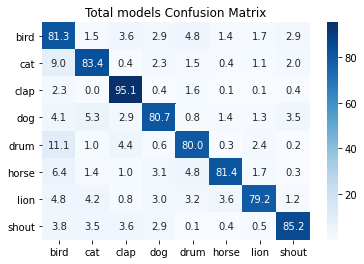

In [5]:
## 라벨별 정확도 확인
for idx in range(len(np.unique(final_result_detail['label']))):
    label_name = np.unique(final_result_detail['label'])[idx]
    print(f"------{label_name}------")
    tmp_df = final_result_detail[final_result_detail['label']==label_name].copy()
    print(f"정답률: {round(len(tmp_df[tmp_df['answer']==True])/len(tmp_df),6)}%")
    print(f"오답률: {round(len(tmp_df[tmp_df['answer']!=True])/len(tmp_df),6)}%")
cf = confusion_matrix(final_result_detail['label'], final_result_detail['y_pred'],)
ax = sns.heatmap([cf[idx]/cf.sum(1)[idx]*100 for idx in range(len(cf))], annot=True, xticklabels=np.unique(final_result_detail['label']), yticklabels=np.unique(final_result_detail['label']), fmt='.1f', cmap="Blues")
plt.title("Total models Confusion Matrix")
plt.show()

------1213_8_RF_87------
정답률: 0.7871%
오답률: 0.2129%
[99.99999999999999, 100.0, 100.0, 100.0, 100.0, 100.0, 100.00000000000001, 100.0]


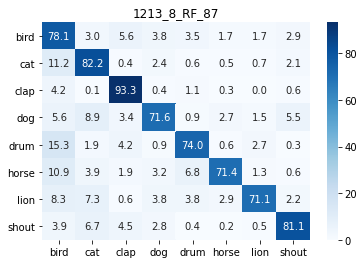

------1213_8_RF_oversampling_92------
정답률: 0.8491%
오답률: 0.1509%
[100.0, 100.0, 100.0, 100.00000000000001, 100.0, 100.0, 100.0, 100.0]


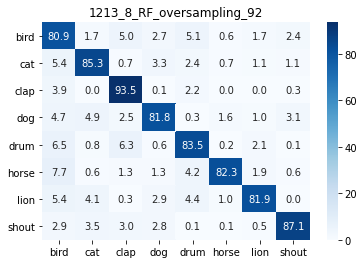

------1213_8_XGB_93------
정답률: 0.8477%
오답률: 0.1523%
[100.00000000000001, 100.00000000000001, 100.0, 99.99999999999999, 100.0, 100.0, 100.0, 100.0]


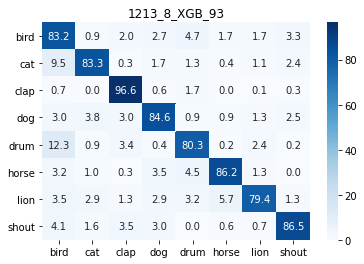

------1213_8_XGB_oversampling_94------
정답률: 0.8528%
오답률: 0.1472%
[100.0, 100.00000000000001, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


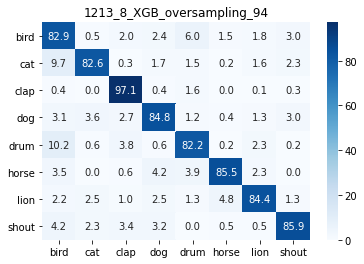

In [8]:
## 모델별 정확도 확인
for idx in range(len(np.unique(final_result_detail['model']))):
    model_name = np.unique(final_result_detail['model'])[idx]
    print(f"------{model_name}------")
    tmp_df = final_result_detail[final_result_detail['model']==model_name].copy()
    print(f"정답률: {round(len(tmp_df[tmp_df['answer']==True])/len(tmp_df),4)}%")
    print(f"오답률: {round(len(tmp_df[tmp_df['answer']!=True])/len(tmp_df),4)}%")
    cf = confusion_matrix(tmp_df['label'], tmp_df['y_pred'],)
    ax = sns.heatmap([cf[idx]/cf.sum(1)[idx]*100 for idx in range(len(cf))], annot=True, xticklabels=np.unique(tmp_df['label']), yticklabels=np.unique(tmp_df['label']), fmt='.1f', cmap="Blues")
    print([sum(cf[idx]/cf.sum(1)[idx]*100) for idx in range(len(cf))])
    plt.title(model_name)
    plt.show()

In [49]:
tmp_df = final_result[final_result['name']=='1-110389-A-0']
len(tmp_df[tmp_df['answer']==True])/len(tmp_df)

0.8333333333333334

In [86]:
freq_df

,name,path,label,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,start,end
0,1-100038-A-14,../../tracks/1213_trial6/1-100038-A-14/0_3.wav,bird,3.000000,0.283338,0.089276,0.063474,0.001700,3506.229052,1.809475e+05,...,1.290453,32.523357,-10.802720,32.661377,-2.120730,53.144516,8.539434,60.616344,0,3
1,1-100038-A-14,../../tracks/1213_trial6/1-100038-A-14/1_4.wav,bird,3.000000,0.364173,0.081509,0.033552,0.000079,3287.605530,7.996766e+04,...,5.188783,40.223907,-13.482948,44.838425,5.270273,31.324274,0.362631,36.510899,1,4
2,1-100038-A-14,../../tracks/1213_trial6/1-100038-A-14/2_5.wav,bird,3.000000,0.375093,0.077315,0.031307,0.000042,3398.796133,9.343780e+04,...,6.544007,37.734615,-12.023079,32.176353,5.164810,38.836082,-2.097291,49.277367,2,5
3,1-110389-A-0,../../tracks/1213_trial6/1-110389-A-0/0_3.wav,dog,3.000000,0.118818,0.073303,0.011670,0.001853,231.679915,2.783545e+05,...,0.574947,3.180933,1.446884,13.123255,0.827792,8.788814,0.717775,9.917254,0,3
4,1-110389-A-0,../../tracks/1213_trial6/1-110389-A-0/1_4.wav,dog,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5805,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,shout,3.000000,0.319446,0.092124,0.022193,0.000209,1899.694319,8.871661e+04,...,-6.622928,52.154572,-10.973144,37.042068,-7.609065,80.573395,-4.818632,101.300064,4,7
5806,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,shout,3.000000,0.302058,0.093381,0.030142,0.000197,1842.083974,7.286384e+04,...,-6.255531,51.138317,-11.003696,32.996319,-8.215035,72.340134,-3.683304,133.690521,5,8
5807,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,shout,3.000000,0.323383,0.093066,0.021921,0.000209,1900.336713,8.863640e+04,...,-6.531158,50.725578,-10.992870,37.147484,-7.794780,85.561752,-5.181902,95.893837,6,9
5808,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,shout,3.000000,0.304752,0.093603,0.030241,0.000197,1850.802318,7.295634e+04,...,-5.757778,49.368858,-10.799461,33.283142,-8.063362,72.854401,-3.277162,143.226410,7,10


In [15]:
label_ls = np.unique(freq_df['label']).tolist()

def model_predict(model, target_df):
    md = joblib.load(model)
    tmp_df = target_df.set_index('name', drop=True)
    tmp_df = tmp_df.drop(['path', 'duration', 'start', 'end'], axis=1)
    print(f"이 소리는 {(max(md.predict_proba(tmp_df)[0])*100).round(3)}의 확률로 '{md.predict(tmp_df)[0]}' 로 추정됩니다.")
    return md.predict_proba(tmp_df)[0], md.predict(tmp_df)[0]

def listen_predict_df(val_df):
    y = val_df['label']
    X = val_df.drop(["label"], axis=1)
    print(label_ls)
    final_result = pd.DataFrame()
    for idx in tqdm(range(len(X))):
        freq_df = X.iloc[[idx]]
        proba_ls = []
        pred_label = []
        for model in model_ls:
            proba, label = model_predict(model, freq_df)
            proba_ls.append(proba)
            pred_label.append(label)
        print("----------------")
#         print(f"{y[idx]}는 {label_ls[sum(proba_ls).tolist().index(max(sum(proba_ls)))]} 일 확률이 가장 높습니다!")
        result_df = pd.DataFrame(data=proba_ls, columns=label_ls, index=[m.split("/")[-1][:-4] for m in model_ls]).round(1)
        
        result_df['label'] = y[idx]
        result_df['name'] = freq_df['name'][idx]
        result_df['y_pred'] = pred_label
        result_df.sort_values(by=f'{label_ls[sum(proba_ls).tolist().index(max(sum(proba_ls)))]}', ascending=False, inplace=True)
    
        final_result = pd.concat([final_result, result_df])
    return final_result

In [94]:
final_result_detail = listen_predict_df(freq_df)

  0%|          | 0/5810 [00:00<?, ?it/s]

['bird', 'cat', 'clap', 'dog', 'drum', 'horse', 'lion', 'shout']
이 소리는 85.805의 확률로 'bird' 로 추정됩니다.


  0%|          | 1/5810 [00:00<41:01,  2.36it/s]

이 소리는 82.243의 확률로 'bird' 로 추정됩니다.
이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.972의 확률로 'bird' 로 추정됩니다.
이 소리는 95.861의 확률로 'bird' 로 추정됩니다.


  0%|          | 2/5810 [00:00<40:37,  2.38it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.948의 확률로 'bird' 로 추정됩니다.
이 소리는 98.136의 확률로 'bird' 로 추정됩니다.


  0%|          | 3/5810 [00:01<40:46,  2.37it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.793의 확률로 'dog' 로 추정됩니다.
이 소리는 94.629의 확률로 'dog' 로 추정됩니다.


  0%|          | 4/5810 [00:01<40:58,  2.36it/s]

이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 39.931의 확률로 'dog' 로 추정됩니다.
이 소리는 38.043의 확률로 'dog' 로 추정됩니다.


  0%|          | 5/5810 [00:02<41:11,  2.35it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 39.931의 확률로 'dog' 로 추정됩니다.
이 소리는 38.043의 확률로 'dog' 로 추정됩니다.


  0%|          | 6/5810 [00:02<45:16,  2.14it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.952의 확률로 'bird' 로 추정됩니다.
이 소리는 94.97의 확률로 'bird' 로 추정됩니다.


  0%|          | 7/5810 [00:03<44:06,  2.19it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.046의 확률로 'bird' 로 추정됩니다.


  0%|          | 8/5810 [00:03<43:07,  2.24it/s]

이 소리는 96.152의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.166의 확률로 'bird' 로 추정됩니다.
이 소리는 96.283의 확률로 'bird' 로 추정됩니다.


  0%|          | 9/5810 [00:03<43:19,  2.23it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.136의 확률로 'bird' 로 추정됩니다.


  0%|          | 10/5810 [00:04<42:35,  2.27it/s]

이 소리는 97.479의 확률로 'bird' 로 추정됩니다.
이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.232의 확률로 'bird' 로 추정됩니다.
이 소리는 95.851의 확률로 'bird' 로 추정됩니다.


  0%|          | 11/5810 [00:04<43:45,  2.21it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 72.563의 확률로 'bird' 로 추정됩니다.
이 소리는 76.946의 확률로 'bird' 로 추정됩니다.


  0%|          | 12/5810 [00:05<42:57,  2.25it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 83.884의 확률로 'bird' 로 추정됩니다.


  0%|          | 13/5810 [00:05<42:55,  2.25it/s]

이 소리는 82.051의 확률로 'bird' 로 추정됩니다.
이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 78.249의 확률로 'bird' 로 추정됩니다.
이 소리는 83.055의 확률로 'bird' 로 추정됩니다.


  0%|          | 14/5810 [00:06<42:40,  2.26it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 84.494의 확률로 'cat' 로 추정됩니다.


  0%|          | 15/5810 [00:06<41:59,  2.30it/s]

이 소리는 69.318의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.122의 확률로 'bird' 로 추정됩니다.
이 소리는 91.446의 확률로 'bird' 로 추정됩니다.


  0%|          | 16/5810 [00:07<41:48,  2.31it/s]

이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.98의 확률로 'bird' 로 추정됩니다.


  0%|          | 17/5810 [00:07<41:23,  2.33it/s]

이 소리는 93.82의 확률로 'bird' 로 추정됩니다.
이 소리는 62.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 83.946의 확률로 'bird' 로 추정됩니다.
이 소리는 85.723의 확률로 'bird' 로 추정됩니다.


  0%|          | 18/5810 [00:07<41:10,  2.34it/s]

이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 57.341의 확률로 'dog' 로 추정됩니다.


  0%|          | 19/5810 [00:08<41:00,  2.35it/s]

이 소리는 67.701의 확률로 'dog' 로 추정됩니다.
이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 61.399의 확률로 'shout' 로 추정됩니다.
이 소리는 58.807의 확률로 'dog' 로 추정됩니다.


  0%|          | 20/5810 [00:08<41:00,  2.35it/s]

이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 56.662의 확률로 'shout' 로 추정됩니다.
이 소리는 56.329의 확률로 'dog' 로 추정됩니다.


  0%|          | 21/5810 [00:09<40:59,  2.35it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 71.612의 확률로 'bird' 로 추정됩니다.


  0%|          | 22/5810 [00:09<41:02,  2.35it/s]

이 소리는 82.305의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 59.754의 확률로 'bird' 로 추정됩니다.
이 소리는 72.771의 확률로 'bird' 로 추정됩니다.


  0%|          | 23/5810 [00:10<41:08,  2.34it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 88.25의 확률로 'bird' 로 추정됩니다.


  0%|          | 24/5810 [00:10<41:13,  2.34it/s]

이 소리는 92.151의 확률로 'bird' 로 추정됩니다.
이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 89.934의 확률로 'bird' 로 추정됩니다.
이 소리는 91.232의 확률로 'bird' 로 추정됩니다.


  0%|          | 25/5810 [00:10<41:09,  2.34it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.194의 확률로 'cat' 로 추정됩니다.


  0%|          | 26/5810 [00:11<41:21,  2.33it/s]

이 소리는 98.688의 확률로 'cat' 로 추정됩니다.
이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.318의 확률로 'cat' 로 추정됩니다.
이 소리는 97.481의 확률로 'cat' 로 추정됩니다.


  0%|          | 27/5810 [00:11<41:11,  2.34it/s]

이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.621의 확률로 'cat' 로 추정됩니다.


  0%|          | 28/5810 [00:12<41:02,  2.35it/s]

이 소리는 98.475의 확률로 'cat' 로 추정됩니다.
이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 84.546의 확률로 'cat' 로 추정됩니다.
이 소리는 90.232의 확률로 'cat' 로 추정됩니다.


  0%|          | 29/5810 [00:12<41:00,  2.35it/s]

이 소리는 38.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 50.446의 확률로 'cat' 로 추정됩니다.


  1%|          | 30/5810 [00:12<40:49,  2.36it/s]

이 소리는 45.611의 확률로 'cat' 로 추정됩니다.
이 소리는 44.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 70.933의 확률로 'horse' 로 추정됩니다.
이 소리는 92.078의 확률로 'horse' 로 추정됩니다.


  1%|          | 31/5810 [00:13<40:42,  2.37it/s]

이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 36.303의 확률로 'horse' 로 추정됩니다.
이 소리는 59.009의 확률로 'horse' 로 추정됩니다.


  1%|          | 32/5810 [00:13<41:55,  2.30it/s]

이 소리는 48.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 36.822의 확률로 'shout' 로 추정됩니다.
이 소리는 54.929의 확률로 'horse' 로 추정됩니다.


  1%|          | 33/5810 [00:14<41:42,  2.31it/s]

이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 96.001의 확률로 'bird' 로 추정됩니다.


  1%|          | 34/5810 [00:14<41:31,  2.32it/s]

이 소리는 96.087의 확률로 'bird' 로 추정됩니다.
이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 73.117의 확률로 'bird' 로 추정됩니다.
이 소리는 74.582의 확률로 'bird' 로 추정됩니다.


  1%|          | 35/5810 [00:15<41:13,  2.33it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.31의 확률로 'bird' 로 추정됩니다.


  1%|          | 36/5810 [00:15<41:04,  2.34it/s]

이 소리는 95.666의 확률로 'bird' 로 추정됩니다.
이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 45.643의 확률로 'dog' 로 추정됩니다.
이 소리는 42.27의 확률로 'dog' 로 추정됩니다.


  1%|          | 37/5810 [00:15<41:02,  2.34it/s]

이 소리는 22.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 60.432의 확률로 'bird' 로 추정됩니다.


  1%|          | 38/5810 [00:16<40:50,  2.36it/s]

이 소리는 58.749의 확률로 'bird' 로 추정됩니다.
이 소리는 22.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 58.789의 확률로 'bird' 로 추정됩니다.
이 소리는 59.809의 확률로 'bird' 로 추정됩니다.


  1%|          | 39/5810 [00:16<40:57,  2.35it/s]

이 소리는 20.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.295의 확률로 'shout' 로 추정됩니다.
이 소리는 97.038의 확률로 'shout' 로 추정됩니다.


  1%|          | 40/5810 [00:17<41:08,  2.34it/s]

이 소리는 26.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 39.931의 확률로 'dog' 로 추정됩니다.


  1%|          | 41/5810 [00:17<41:08,  2.34it/s]

이 소리는 38.043의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 39.931의 확률로 'dog' 로 추정됩니다.
이 소리는 38.043의 확률로 'dog' 로 추정됩니다.


  1%|          | 42/5810 [00:18<41:03,  2.34it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 48.615의 확률로 'dog' 로 추정됩니다.


  1%|          | 43/5810 [00:18<40:50,  2.35it/s]

이 소리는 45.403의 확률로 'bird' 로 추정됩니다.
이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 52.906의 확률로 'dog' 로 추정됩니다.
이 소리는 62.341의 확률로 'dog' 로 추정됩니다.


  1%|          | 44/5810 [00:18<40:57,  2.35it/s]

이 소리는 38.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 63.533의 확률로 'dog' 로 추정됩니다.


  1%|          | 45/5810 [00:19<40:43,  2.36it/s]

이 소리는 81.764의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.86의 확률로 'dog' 로 추정됩니다.
이 소리는 98.493의 확률로 'dog' 로 추정됩니다.


  1%|          | 46/5810 [00:19<40:49,  2.35it/s]

이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.901의 확률로 'dog' 로 추정됩니다.


  1%|          | 47/5810 [00:20<40:37,  2.36it/s]

이 소리는 98.59의 확률로 'dog' 로 추정됩니다.
이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.633의 확률로 'dog' 로 추정됩니다.
이 소리는 99.719의 확률로 'dog' 로 추정됩니다.


  1%|          | 48/5810 [00:20<40:43,  2.36it/s]

이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.768의 확률로 'dog' 로 추정됩니다.


  1%|          | 49/5810 [00:21<40:36,  2.36it/s]

이 소리는 99.798의 확률로 'dog' 로 추정됩니다.
이 소리는 86.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.749의 확률로 'dog' 로 추정됩니다.
이 소리는 99.763의 확률로 'dog' 로 추정됩니다.


  1%|          | 50/5810 [00:21<40:46,  2.35it/s]

이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.691의 확률로 'dog' 로 추정됩니다.


  1%|          | 51/5810 [00:21<40:31,  2.37it/s]

이 소리는 99.691의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.728의 확률로 'bird' 로 추정됩니다.
이 소리는 99.609의 확률로 'bird' 로 추정됩니다.


  1%|          | 52/5810 [00:22<40:34,  2.37it/s]

이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.619의 확률로 'bird' 로 추정됩니다.


  1%|          | 53/5810 [00:22<40:21,  2.38it/s]

이 소리는 99.304의 확률로 'bird' 로 추정됩니다.
이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.199의 확률로 'bird' 로 추정됩니다.
이 소리는 99.199의 확률로 'bird' 로 추정됩니다.


  1%|          | 54/5810 [00:23<40:30,  2.37it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 64.174의 확률로 'horse' 로 추정됩니다.


  1%|          | 55/5810 [00:23<40:43,  2.36it/s]

이 소리는 79.912의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 48.822의 확률로 'bird' 로 추정됩니다.
이 소리는 47.216의 확률로 'bird' 로 추정됩니다.


  1%|          | 56/5810 [00:24<40:38,  2.36it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 50.295의 확률로 'bird' 로 추정됩니다.


  1%|          | 57/5810 [00:24<40:32,  2.36it/s]

이 소리는 48.348의 확률로 'bird' 로 추정됩니다.
이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 53.093의 확률로 'bird' 로 추정됩니다.
이 소리는 46.125의 확률로 'bird' 로 추정됩니다.


  1%|          | 58/5810 [00:24<40:40,  2.36it/s]

이 소리는 26.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 56.208의 확률로 'bird' 로 추정됩니다.
이 소리는 42.905의 확률로 'bird' 로 추정됩니다.


  1%|          | 59/5810 [00:25<42:33,  2.25it/s]

이 소리는 26.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 50.005의 확률로 'bird' 로 추정됩니다.


  1%|          | 60/5810 [00:25<45:13,  2.12it/s]

이 소리는 42.049의 확률로 'bird' 로 추정됩니다.
이 소리는 24.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 51.786의 확률로 'bird' 로 추정됩니다.
이 소리는 41.621의 확률로 'bird' 로 추정됩니다.


  1%|          | 61/5810 [00:26<44:14,  2.17it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 51.598의 확률로 'bird' 로 추정됩니다.
이 소리는 45.365의 확률로 'bird' 로 추정됩니다.


  1%|          | 62/5810 [00:26<43:56,  2.18it/s]

이 소리는 26.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 54.584의 확률로 'bird' 로 추정됩니다.
이 소리는 39.832의 확률로 'bird' 로 추정됩니다.


  1%|          | 63/5810 [00:27<42:47,  2.24it/s]

이 소리는 26.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 54.242의 확률로 'bird' 로 추정됩니다.


  1%|          | 64/5810 [00:27<43:34,  2.20it/s]

이 소리는 42.619의 확률로 'bird' 로 추정됩니다.
이 소리는 26.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 50.116의 확률로 'bird' 로 추정됩니다.
이 소리는 38.647의 확률로 'bird' 로 추정됩니다.


  1%|          | 65/5810 [00:28<43:08,  2.22it/s]

이 소리는 24.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 55.019의 확률로 'bird' 로 추정됩니다.
이 소리는 42.571의 확률로 'bird' 로 추정됩니다.


  1%|          | 66/5810 [00:28<42:12,  2.27it/s]

이 소리는 22.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 71.867의 확률로 'bird' 로 추정됩니다.


  1%|          | 67/5810 [00:28<41:23,  2.31it/s]

이 소리는 71.995의 확률로 'bird' 로 추정됩니다.
이 소리는 28.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 71.844의 확률로 'bird' 로 추정됩니다.
이 소리는 89.767의 확률로 'bird' 로 추정됩니다.


  1%|          | 68/5810 [00:29<40:51,  2.34it/s]

이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 65.72의 확률로 'bird' 로 추정됩니다.
이 소리는 67.692의 확률로 'bird' 로 추정됩니다.


  1%|          | 69/5810 [00:29<40:32,  2.36it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 71.195의 확률로 'bird' 로 추정됩니다.


  1%|          | 70/5810 [00:30<42:41,  2.24it/s]

이 소리는 64.539의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.165의 확률로 'bird' 로 추정됩니다.
이 소리는 90.645의 확률로 'bird' 로 추정됩니다.


  1%|          | 71/5810 [00:30<41:48,  2.29it/s]

이 소리는 26.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 86.499의 확률로 'bird' 로 추정됩니다.
이 소리는 88.133의 확률로 'bird' 로 추정됩니다.


  1%|          | 72/5810 [00:31<41:52,  2.28it/s]

이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 83.517의 확률로 'bird' 로 추정됩니다.
이 소리는 76.837의 확률로 'bird' 로 추정됩니다.


  1%|▏         | 73/5810 [00:31<42:54,  2.23it/s]

이 소리는 28.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 76.024의 확률로 'bird' 로 추정됩니다.
이 소리는 70.731의 확률로 'bird' 로 추정됩니다.


  1%|▏         | 74/5810 [00:32<42:43,  2.24it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 74.867의 확률로 'bird' 로 추정됩니다.
이 소리는 73.074의 확률로 'bird' 로 추정됩니다.


  1%|▏         | 75/5810 [00:32<42:23,  2.25it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 73.897의 확률로 'bird' 로 추정됩니다.
이 소리는 69.722의 확률로 'bird' 로 추정됩니다.


  1%|▏         | 76/5810 [00:32<42:04,  2.27it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 76.33의 확률로 'bird' 로 추정됩니다.


  1%|▏         | 77/5810 [00:33<41:25,  2.31it/s]

이 소리는 71.499의 확률로 'bird' 로 추정됩니다.
이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 77.423의 확률로 'bird' 로 추정됩니다.
이 소리는 56.219의 확률로 'bird' 로 추정됩니다.


  1%|▏         | 78/5810 [00:33<40:58,  2.33it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 79.641의 확률로 'bird' 로 추정됩니다.


  1%|▏         | 79/5810 [00:34<40:39,  2.35it/s]

이 소리는 56.205의 확률로 'bird' 로 추정됩니다.
이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 81.569의 확률로 'bird' 로 추정됩니다.
이 소리는 76.026의 확률로 'bird' 로 추정됩니다.


  1%|▏         | 80/5810 [00:34<40:21,  2.37it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 57.971의 확률로 'bird' 로 추정됩니다.
이 소리는 54.282의 확률로 'bird' 로 추정됩니다.


  1%|▏         | 81/5810 [00:35<40:26,  2.36it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 55.72의 확률로 'bird' 로 추정됩니다.


  1%|▏         | 82/5810 [00:35<40:42,  2.34it/s]

이 소리는 51.36의 확률로 'bird' 로 추정됩니다.
이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 76.836의 확률로 'bird' 로 추정됩니다.
이 소리는 59.415의 확률로 'bird' 로 추정됩니다.


  1%|▏         | 83/5810 [00:35<40:52,  2.34it/s]

이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 80.308의 확률로 'bird' 로 추정됩니다.
이 소리는 62.08의 확률로 'bird' 로 추정됩니다.


  1%|▏         | 84/5810 [00:36<40:52,  2.33it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 81.417의 확률로 'bird' 로 추정됩니다.


  1%|▏         | 85/5810 [00:36<41:03,  2.32it/s]

이 소리는 73.516의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 86.468의 확률로 'bird' 로 추정됩니다.
이 소리는 85.054의 확률로 'bird' 로 추정됩니다.


  1%|▏         | 86/5810 [00:37<40:54,  2.33it/s]

이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 79.875의 확률로 'bird' 로 추정됩니다.


  1%|▏         | 87/5810 [00:37<40:38,  2.35it/s]

이 소리는 74.863의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 93.097의 확률로 'bird' 로 추정됩니다.
이 소리는 78.976의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 88/5810 [00:38<40:52,  2.33it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 81.911의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 89/5810 [00:38<42:59,  2.22it/s]

이 소리는 65.142의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 60.945의 확률로 'bird' 로 추정됩니다.
이 소리는 55.642의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 90/5810 [00:38<42:00,  2.27it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 49.664의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 91/5810 [00:39<41:16,  2.31it/s]

이 소리는 49.272의 확률로 'horse' 로 추정됩니다.
이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 52.701의 확률로 'bird' 로 추정됩니다.
이 소리는 46.545의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 92/5810 [00:39<41:30,  2.30it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 57.446의 확률로 'cat' 로 추정됩니다.
이 소리는 49.513의 확률로 'cat' 로 추정됩니다.


  2%|▏         | 93/5810 [00:40<42:05,  2.26it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 50.704의 확률로 'cat' 로 추정됩니다.
이 소리는 57.714의 확률로 'cat' 로 추정됩니다.


  2%|▏         | 94/5810 [00:40<41:51,  2.28it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 76.391의 확률로 'clap' 로 추정됩니다.
이 소리는 68.227의 확률로 'clap' 로 추정됩니다.


  2%|▏         | 95/5810 [00:41<41:19,  2.30it/s]

이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 75.917의 확률로 'clap' 로 추정됩니다.


  2%|▏         | 96/5810 [00:41<41:01,  2.32it/s]

이 소리는 80.945의 확률로 'clap' 로 추정됩니다.
이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 39.931의 확률로 'dog' 로 추정됩니다.
이 소리는 38.043의 확률로 'dog' 로 추정됩니다.


  2%|▏         | 97/5810 [00:42<41:17,  2.31it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.2의 확률로 'bird' 로 추정됩니다.
이 소리는 92.927의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 98/5810 [00:42<41:40,  2.28it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 75.095의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 99/5810 [00:42<41:48,  2.28it/s]

이 소리는 78.277의 확률로 'bird' 로 추정됩니다.
이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 80.886의 확률로 'bird' 로 추정됩니다.
이 소리는 83.899의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 100/5810 [00:43<42:00,  2.27it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.155의 확률로 'bird' 로 추정됩니다.
이 소리는 91.774의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 101/5810 [00:43<42:09,  2.26it/s]

이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.531의 확률로 'bird' 로 추정됩니다.
이 소리는 92.225의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 102/5810 [00:44<42:00,  2.26it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 89.551의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 103/5810 [00:44<41:23,  2.30it/s]

이 소리는 93.084의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 74.255의 확률로 'cat' 로 추정됩니다.
이 소리는 77.216의 확률로 'cat' 로 추정됩니다.


  2%|▏         | 104/5810 [00:45<41:10,  2.31it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 48.38의 확률로 'cat' 로 추정됩니다.


  2%|▏         | 105/5810 [00:45<40:59,  2.32it/s]

이 소리는 67.495의 확률로 'cat' 로 추정됩니다.
이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 44.368의 확률로 'cat' 로 추정됩니다.
이 소리는 36.161의 확률로 'dog' 로 추정됩니다.


  2%|▏         | 106/5810 [00:45<41:05,  2.31it/s]

이 소리는 26.0의 확률로 'cat' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 86.26의 확률로 'shout' 로 추정됩니다.
이 소리는 81.373의 확률로 'shout' 로 추정됩니다.


  2%|▏         | 107/5810 [00:46<42:06,  2.26it/s]

이 소리는 38.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 38.25의 확률로 'dog' 로 추정됩니다.
이 소리는 52.838의 확률로 'dog' 로 추정됩니다.


  2%|▏         | 108/5810 [00:46<42:31,  2.23it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 61.733의 확률로 'dog' 로 추정됩니다.
이 소리는 37.806의 확률로 'dog' 로 추정됩니다.


  2%|▏         | 109/5810 [00:47<42:06,  2.26it/s]

이 소리는 26.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 75.448의 확률로 'shout' 로 추정됩니다.


  2%|▏         | 110/5810 [00:47<42:17,  2.25it/s]

이 소리는 77.654의 확률로 'shout' 로 추정됩니다.
이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 74.219의 확률로 'shout' 로 추정됩니다.
이 소리는 76.909의 확률로 'shout' 로 추정됩니다.


  2%|▏         | 111/5810 [00:48<42:47,  2.22it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 30.54의 확률로 'dog' 로 추정됩니다.
이 소리는 47.742의 확률로 'dog' 로 추정됩니다.


  2%|▏         | 112/5810 [00:48<43:23,  2.19it/s]

이 소리는 26.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 81.282의 확률로 'cat' 로 추정됩니다.
이 소리는 79.83의 확률로 'cat' 로 추정됩니다.


  2%|▏         | 113/5810 [00:49<42:59,  2.21it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 63.274의 확률로 'shout' 로 추정됩니다.


  2%|▏         | 114/5810 [00:49<42:23,  2.24it/s]

이 소리는 54.835의 확률로 'shout' 로 추정됩니다.
이 소리는 36.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 71.293의 확률로 'dog' 로 추정됩니다.
이 소리는 68.462의 확률로 'dog' 로 추정됩니다.


  2%|▏         | 115/5810 [00:49<41:48,  2.27it/s]

이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 90.04의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 116/5810 [00:50<41:32,  2.28it/s]

이 소리는 91.586의 확률로 'bird' 로 추정됩니다.
이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 89.06의 확률로 'bird' 로 추정됩니다.
이 소리는 87.857의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 117/5810 [00:50<43:16,  2.19it/s]

이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.535의 확률로 'bird' 로 추정됩니다.
이 소리는 96.95의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 118/5810 [00:51<42:49,  2.22it/s]

이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.861의 확률로 'bird' 로 추정됩니다.
이 소리는 94.716의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 119/5810 [00:51<42:46,  2.22it/s]

이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.342의 확률로 'bird' 로 추정됩니다.
이 소리는 94.955의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 120/5810 [00:52<42:12,  2.25it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.24의 확률로 'bird' 로 추정됩니다.
이 소리는 97.718의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 121/5810 [00:52<42:02,  2.25it/s]

이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.334의 확률로 'dog' 로 추정됩니다.


  2%|▏         | 122/5810 [00:53<41:40,  2.27it/s]

이 소리는 99.264의 확률로 'dog' 로 추정됩니다.
이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.436의 확률로 'dog' 로 추정됩니다.
이 소리는 97.79의 확률로 'dog' 로 추정됩니다.


  2%|▏         | 123/5810 [00:53<41:20,  2.29it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.18의 확률로 'dog' 로 추정됩니다.


  2%|▏         | 124/5810 [00:53<41:16,  2.30it/s]

이 소리는 99.266의 확률로 'dog' 로 추정됩니다.
이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.793의 확률로 'dog' 로 추정됩니다.
이 소리는 91.998의 확률로 'dog' 로 추정됩니다.


  2%|▏         | 125/5810 [00:54<41:04,  2.31it/s]

이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.74의 확률로 'dog' 로 추정됩니다.


  2%|▏         | 126/5810 [00:54<40:42,  2.33it/s]

이 소리는 97.414의 확률로 'dog' 로 추정됩니다.
이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 42.604의 확률로 'dog' 로 추정됩니다.
이 소리는 41.975의 확률로 'dog' 로 추정됩니다.


  2%|▏         | 127/5810 [00:55<40:33,  2.34it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.088의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 128/5810 [00:55<40:47,  2.32it/s]

이 소리는 99.187의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.841의 확률로 'bird' 로 추정됩니다.
이 소리는 99.031의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 129/5810 [00:56<40:32,  2.34it/s]

이 소리는 72.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.989의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 130/5810 [00:56<40:26,  2.34it/s]

이 소리는 98.944의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 48.689의 확률로 'bird' 로 추정됩니다.
이 소리는 64.804의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 131/5810 [00:56<40:18,  2.35it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 87.541의 확률로 'cat' 로 추정됩니다.
이 소리는 90.473의 확률로 'cat' 로 추정됩니다.


  2%|▏         | 132/5810 [00:57<40:24,  2.34it/s]

이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 76.295의 확률로 'cat' 로 추정됩니다.


  2%|▏         | 133/5810 [00:57<40:16,  2.35it/s]

이 소리는 84.502의 확률로 'cat' 로 추정됩니다.
이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 53.674의 확률로 'bird' 로 추정됩니다.
이 소리는 52.378의 확률로 'cat' 로 추정됩니다.


  2%|▏         | 134/5810 [00:58<40:55,  2.31it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 76.589의 확률로 'bird' 로 추정됩니다.
이 소리는 71.361의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 135/5810 [00:58<41:00,  2.31it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 76.266의 확률로 'bird' 로 추정됩니다.
이 소리는 58.056의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 136/5810 [00:59<41:48,  2.26it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 55.231의 확률로 'bird' 로 추정됩니다.
이 소리는 59.109의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 137/5810 [00:59<41:32,  2.28it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 52.999의 확률로 'bird' 로 추정됩니다.
이 소리는 53.941의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 138/5810 [01:00<41:33,  2.27it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 40.835의 확률로 'bird' 로 추정됩니다.
이 소리는 44.363의 확률로 'cat' 로 추정됩니다.


  2%|▏         | 139/5810 [01:00<41:59,  2.25it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 47.12의 확률로 'cat' 로 추정됩니다.
이 소리는 65.839의 확률로 'cat' 로 추정됩니다.


  2%|▏         | 140/5810 [01:00<43:09,  2.19it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 47.742의 확률로 'cat' 로 추정됩니다.
이 소리는 52.734의 확률로 'cat' 로 추정됩니다.


  2%|▏         | 141/5810 [01:01<42:35,  2.22it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 47.814의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 142/5810 [01:01<42:17,  2.23it/s]

이 소리는 39.012의 확률로 'bird' 로 추정됩니다.
이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 63.032의 확률로 'bird' 로 추정됩니다.
이 소리는 54.818의 확률로 'bird' 로 추정됩니다.


  2%|▏         | 143/5810 [01:02<41:30,  2.28it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.724의 확률로 'cat' 로 추정됩니다.


  2%|▏         | 144/5810 [01:02<41:14,  2.29it/s]

이 소리는 98.693의 확률로 'cat' 로 추정됩니다.
이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.333의 확률로 'cat' 로 추정됩니다.
이 소리는 95.652의 확률로 'cat' 로 추정됩니다.


  2%|▏         | 145/5810 [01:03<41:13,  2.29it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 45.213의 확률로 'bird' 로 추정됩니다.
이 소리는 54.042의 확률로 'cat' 로 추정됩니다.


  3%|▎         | 146/5810 [01:03<41:02,  2.30it/s]

이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 78.967의 확률로 'cat' 로 추정됩니다.


  3%|▎         | 147/5810 [01:03<40:58,  2.30it/s]

이 소리는 81.472의 확률로 'cat' 로 추정됩니다.
이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 30.222의 확률로 'dog' 로 추정됩니다.
이 소리는 42.077의 확률로 'lion' 로 추정됩니다.


  3%|▎         | 148/5810 [01:04<41:47,  2.26it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 39.931의 확률로 'dog' 로 추정됩니다.
이 소리는 38.043의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 149/5810 [01:04<41:17,  2.29it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.7의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 150/5810 [01:05<41:16,  2.29it/s]

이 소리는 93.443의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 44.511의 확률로 'bird' 로 추정됩니다.
이 소리는 44.535의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 151/5810 [01:05<41:06,  2.29it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 55.302의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 152/5810 [01:06<40:49,  2.31it/s]

이 소리는 60.611의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 49.602의 확률로 'dog' 로 추정됩니다.
이 소리는 65.741의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 153/5810 [01:06<40:29,  2.33it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 59.605의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 154/5810 [01:07<40:05,  2.35it/s]

이 소리는 64.544의 확률로 'dog' 로 추정됩니다.
이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 91.646의 확률로 'dog' 로 추정됩니다.
이 소리는 92.744의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 155/5810 [01:07<39:59,  2.36it/s]

이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.063의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 156/5810 [01:07<39:55,  2.36it/s]

이 소리는 99.202의 확률로 'dog' 로 추정됩니다.
이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.659의 확률로 'dog' 로 추정됩니다.
이 소리는 99.453의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 157/5810 [01:08<40:01,  2.35it/s]

이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.665의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 158/5810 [01:08<39:46,  2.37it/s]

이 소리는 99.662의 확률로 'dog' 로 추정됩니다.
이 소리는 82.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.476의 확률로 'dog' 로 추정됩니다.
이 소리는 95.197의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 159/5810 [01:09<39:49,  2.37it/s]

이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.762의 확률로 'dog' 로 추정됩니다.
이 소리는 97.341의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 160/5810 [01:09<40:00,  2.35it/s]

이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 90.465의 확률로 'dog' 로 추정됩니다.
이 소리는 89.227의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 161/5810 [01:09<40:18,  2.34it/s]

이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.869의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 162/5810 [01:10<39:59,  2.35it/s]

이 소리는 95.116의 확률로 'bird' 로 추정됩니다.
이 소리는 26.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.418의 확률로 'bird' 로 추정됩니다.
이 소리는 96.64의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 163/5810 [01:10<40:25,  2.33it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 87.848의 확률로 'bird' 로 추정됩니다.
이 소리는 87.383의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 164/5810 [01:11<40:12,  2.34it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.815의 확률로 'bird' 로 추정됩니다.
이 소리는 97.846의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 165/5810 [01:11<40:21,  2.33it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.594의 확률로 'bird' 로 추정됩니다.
이 소리는 98.738의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 166/5810 [01:12<40:13,  2.34it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.087의 확률로 'bird' 로 추정됩니다.
이 소리는 98.988의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 167/5810 [01:12<40:05,  2.35it/s]

이 소리는 68.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.698의 확률로 'cat' 로 추정됩니다.


  3%|▎         | 168/5810 [01:12<39:44,  2.37it/s]

이 소리는 98.101의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 70.663의 확률로 'cat' 로 추정됩니다.
이 소리는 43.709의 확률로 'cat' 로 추정됩니다.


  3%|▎         | 169/5810 [01:13<39:34,  2.38it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 31.96의 확률로 'drum' 로 추정됩니다.
이 소리는 37.532의 확률로 'drum' 로 추정됩니다.


  3%|▎         | 170/5810 [01:13<39:47,  2.36it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 96.766의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 171/5810 [01:14<40:21,  2.33it/s]

이 소리는 95.958의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.071의 확률로 'dog' 로 추정됩니다.
이 소리는 96.744의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 172/5810 [01:14<40:03,  2.35it/s]

이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.667의 확률로 'dog' 로 추정됩니다.
이 소리는 96.895의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 173/5810 [01:15<39:55,  2.35it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.447의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 174/5810 [01:15<39:46,  2.36it/s]

이 소리는 93.667의 확률로 'bird' 로 추정됩니다.
이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 83.155의 확률로 'bird' 로 추정됩니다.
이 소리는 75.929의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 175/5810 [01:15<39:39,  2.37it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 66.306의 확률로 'bird' 로 추정됩니다.
이 소리는 72.598의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 176/5810 [01:16<39:52,  2.35it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 67.784의 확률로 'bird' 로 추정됩니다.
이 소리는 80.07의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 177/5810 [01:16<39:45,  2.36it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 82.711의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 178/5810 [01:17<39:37,  2.37it/s]

이 소리는 87.849의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 63.05의 확률로 'bird' 로 추정됩니다.
이 소리는 74.034의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 179/5810 [01:17<39:41,  2.36it/s]

이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 32.822의 확률로 'dog' 로 추정됩니다.
이 소리는 38.839의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 180/5810 [01:18<39:54,  2.35it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 54.004의 확률로 'shout' 로 추정됩니다.


  3%|▎         | 181/5810 [01:18<40:01,  2.34it/s]

이 소리는 46.695의 확률로 'shout' 로 추정됩니다.
이 소리는 36.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 84.299의 확률로 'shout' 로 추정됩니다.
이 소리는 81.895의 확률로 'shout' 로 추정됩니다.


  3%|▎         | 182/5810 [01:18<39:44,  2.36it/s]

이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 87.155의 확률로 'dog' 로 추정됩니다.
이 소리는 90.443의 확률로 'dog' 로 추정됩니다.
이 소리는 48.0의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 183/5810 [01:19<39:36,  2.37it/s]

이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 48.755의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 184/5810 [01:19<39:25,  2.38it/s]

이 소리는 71.957의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 39.931의 확률로 'dog' 로 추정됩니다.
이 소리는 38.043의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 185/5810 [01:20<40:51,  2.29it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.767의 확률로 'bird' 로 추정됩니다.
이 소리는 98.735의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 186/5810 [01:20<40:55,  2.29it/s]

이 소리는 58.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.168의 확률로 'bird' 로 추정됩니다.
이 소리는 99.282의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 187/5810 [01:21<40:56,  2.29it/s]

이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.834의 확률로 'clap' 로 추정됩니다.


  3%|▎         | 188/5810 [01:21<40:39,  2.30it/s]

이 소리는 94.039의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.582의 확률로 'bird' 로 추정됩니다.
이 소리는 95.87의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 189/5810 [01:21<40:11,  2.33it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.968의 확률로 'bird' 로 추정됩니다.
이 소리는 98.984의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 190/5810 [01:22<40:04,  2.34it/s]

이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.961의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 191/5810 [01:22<39:43,  2.36it/s]

이 소리는 99.28의 확률로 'bird' 로 추정됩니다.
이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 39.731의 확률로 'lion' 로 추정됩니다.
이 소리는 72.41의 확률로 'lion' 로 추정됩니다.


  3%|▎         | 192/5810 [01:23<39:45,  2.35it/s]

이 소리는 36.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 39.931의 확률로 'dog' 로 추정됩니다.
이 소리는 38.043의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 193/5810 [01:23<39:37,  2.36it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 39.931의 확률로 'dog' 로 추정됩니다.
이 소리는 38.043의 확률로 'dog' 로 추정됩니다.


  3%|▎         | 194/5810 [01:24<39:30,  2.37it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.474의 확률로 'bird' 로 추정됩니다.
이 소리는 99.467의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 195/5810 [01:24<39:27,  2.37it/s]

이 소리는 72.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.347의 확률로 'bird' 로 추정됩니다.
이 소리는 99.118의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 196/5810 [01:24<39:42,  2.36it/s]

이 소리는 62.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 36.918의 확률로 'shout' 로 추정됩니다.


  3%|▎         | 197/5810 [01:25<39:26,  2.37it/s]

이 소리는 50.079의 확률로 'shout' 로 추정됩니다.
이 소리는 48.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 30.685의 확률로 'shout' 로 추정됩니다.
이 소리는 41.353의 확률로 'shout' 로 추정됩니다.


  3%|▎         | 198/5810 [01:25<39:17,  2.38it/s]

이 소리는 26.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 92.51의 확률로 'bird' 로 추정됩니다.
이 소리는 91.907의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 199/5810 [01:26<39:35,  2.36it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 83.627의 확률로 'bird' 로 추정됩니다.
이 소리는 79.956의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 200/5810 [01:26<39:43,  2.35it/s]

이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 84.983의 확률로 'bird' 로 추정됩니다.
이 소리는 85.768의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 201/5810 [01:27<39:47,  2.35it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 77.999의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 202/5810 [01:27<39:35,  2.36it/s]

이 소리는 82.624의 확률로 'bird' 로 추정됩니다.
이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 91.806의 확률로 'bird' 로 추정됩니다.
이 소리는 90.37의 확률로 'bird' 로 추정됩니다.


  3%|▎         | 203/5810 [01:27<39:34,  2.36it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 80.834의 확률로 'lion' 로 추정됩니다.
이 소리는 64.596의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.


  4%|▎         | 204/5810 [01:28<39:27,  2.37it/s]

이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 81.223의 확률로 'lion' 로 추정됩니다.


  4%|▎         | 205/5810 [01:28<39:17,  2.38it/s]

이 소리는 68.908의 확률로 'lion' 로 추정됩니다.
이 소리는 48.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 92.352의 확률로 'lion' 로 추정됩니다.
이 소리는 41.491의 확률로 'lion' 로 추정됩니다.


  4%|▎         | 206/5810 [01:29<39:10,  2.38it/s]

이 소리는 42.0의 확률로 'lion' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 68.192의 확률로 'horse' 로 추정됩니다.
이 소리는 57.31의 확률로 'horse' 로 추정됩니다.


  4%|▎         | 207/5810 [01:29<39:22,  2.37it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 59.502의 확률로 'horse' 로 추정됩니다.
이 소리는 70.853의 확률로 'horse' 로 추정됩니다.


  4%|▎         | 208/5810 [01:29<39:37,  2.36it/s]

이 소리는 20.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.91의 확률로 'lion' 로 추정됩니다.
이 소리는 80.562의 확률로 'lion' 로 추정됩니다.


  4%|▎         | 209/5810 [01:30<39:36,  2.36it/s]

이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 95.412의 확률로 'lion' 로 추정됩니다.


  4%|▎         | 210/5810 [01:30<39:40,  2.35it/s]

이 소리는 78.575의 확률로 'lion' 로 추정됩니다.
이 소리는 38.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 97.588의 확률로 'lion' 로 추정됩니다.
이 소리는 62.539의 확률로 'lion' 로 추정됩니다.


  4%|▎         | 211/5810 [01:31<39:36,  2.36it/s]

이 소리는 46.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 72.86의 확률로 'horse' 로 추정됩니다.


  4%|▎         | 212/5810 [01:31<39:22,  2.37it/s]

이 소리는 68.42의 확률로 'horse' 로 추정됩니다.
이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.587의 확률로 'lion' 로 추정됩니다.
이 소리는 63.402의 확률로 'lion' 로 추정됩니다.


  4%|▎         | 213/5810 [01:32<39:25,  2.37it/s]

이 소리는 52.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.075의 확률로 'lion' 로 추정됩니다.


  4%|▎         | 214/5810 [01:32<39:15,  2.38it/s]

이 소리는 94.619의 확률로 'lion' 로 추정됩니다.
이 소리는 52.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.096의 확률로 'lion' 로 추정됩니다.
이 소리는 95.974의 확률로 'lion' 로 추정됩니다.


  4%|▎         | 215/5810 [01:32<39:17,  2.37it/s]

이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 92.08의 확률로 'lion' 로 추정됩니다.


  4%|▎         | 216/5810 [01:33<39:08,  2.38it/s]

이 소리는 60.476의 확률로 'horse' 로 추정됩니다.
이 소리는 44.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 68.78의 확률로 'bird' 로 추정됩니다.
이 소리는 53.517의 확률로 'bird' 로 추정됩니다.


  4%|▎         | 217/5810 [01:33<39:24,  2.37it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 50.956의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 218/5810 [01:34<39:17,  2.37it/s]

이 소리는 48.834의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 57.197의 확률로 'bird' 로 추정됩니다.
이 소리는 51.584의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 219/5810 [01:34<39:13,  2.38it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 56.072의 확률로 'horse' 로 추정됩니다.
이 소리는 49.118의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 220/5810 [01:35<39:22,  2.37it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 56.18의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 221/5810 [01:35<41:03,  2.27it/s]

이 소리는 67.868의 확률로 'bird' 로 추정됩니다.
이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.404의 확률로 'bird' 로 추정됩니다.
이 소리는 87.169의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 222/5810 [01:36<44:29,  2.09it/s]

이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 82.449의 확률로 'bird' 로 추정됩니다.
이 소리는 82.336의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 223/5810 [01:36<43:35,  2.14it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 91.019의 확률로 'drum' 로 추정됩니다.
이 소리는 87.566의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 224/5810 [01:36<43:12,  2.16it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.012의 확률로 'drum' 로 추정됩니다.
이 소리는 94.071의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 225/5810 [01:37<42:20,  2.20it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.004의 확률로 'drum' 로 추정됩니다.
이 소리는 92.8의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 226/5810 [01:37<42:33,  2.19it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.734의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 227/5810 [01:38<41:32,  2.24it/s]

이 소리는 90.468의 확률로 'drum' 로 추정됩니다.
이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 72.927의 확률로 'drum' 로 추정됩니다.
이 소리는 80.389의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 228/5810 [01:38<40:52,  2.28it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.23의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 229/5810 [01:39<40:36,  2.29it/s]

이 소리는 96.135의 확률로 'drum' 로 추정됩니다.
이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.772의 확률로 'drum' 로 추정됩니다.
이 소리는 89.692의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 230/5810 [01:39<40:16,  2.31it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.875의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 231/5810 [01:39<39:46,  2.34it/s]

이 소리는 86.61의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.951의 확률로 'drum' 로 추정됩니다.
이 소리는 93.941의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 232/5810 [01:40<39:37,  2.35it/s]

이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 28.912의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 233/5810 [01:40<39:19,  2.36it/s]

이 소리는 35.555의 확률로 'horse' 로 추정됩니다.
이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 56.399의 확률로 'drum' 로 추정됩니다.
이 소리는 72.346의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 234/5810 [01:41<39:19,  2.36it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.056의 확률로 'drum' 로 추정됩니다.
이 소리는 90.68의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 235/5810 [01:41<39:39,  2.34it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 89.392의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 236/5810 [01:42<39:22,  2.36it/s]

이 소리는 80.086의 확률로 'drum' 로 추정됩니다.
이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 58.92의 확률로 'bird' 로 추정됩니다.
이 소리는 71.313의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 237/5810 [01:42<39:19,  2.36it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.865의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 238/5810 [01:42<39:11,  2.37it/s]

이 소리는 98.176의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 91.408의 확률로 'drum' 로 추정됩니다.
이 소리는 88.197의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 239/5810 [01:43<39:03,  2.38it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 80.641의 확률로 'drum' 로 추정됩니다.
이 소리는 80.969의 확률로 'drum' 로 추정됩니다.
이 소리는 56.0의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 240/5810 [01:43<39:04,  2.38it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.466의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 241/5810 [01:44<38:56,  2.38it/s]

이 소리는 96.545의 확률로 'drum' 로 추정됩니다.
이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.58의 확률로 'drum' 로 추정됩니다.
이 소리는 95.816의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 242/5810 [01:44<38:57,  2.38it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 84.393의 확률로 'drum' 로 추정됩니다.
이 소리는 89.799의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 243/5810 [01:45<39:17,  2.36it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 85.137의 확률로 'drum' 로 추정됩니다.
이 소리는 89.833의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 244/5810 [01:45<39:32,  2.35it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.797의 확률로 'drum' 로 추정됩니다.


  4%|▍         | 245/5810 [01:45<39:13,  2.36it/s]

이 소리는 93.655의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.986의 확률로 'bird' 로 추정됩니다.
이 소리는 95.692의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 246/5810 [01:46<39:10,  2.37it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 91.593의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 247/5810 [01:46<38:57,  2.38it/s]

이 소리는 93.866의 확률로 'bird' 로 추정됩니다.
이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 46.574의 확률로 'dog' 로 추정됩니다.
이 소리는 53.89의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 248/5810 [01:47<38:51,  2.39it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.248의 확률로 'bird' 로 추정됩니다.
이 소리는 99.109의 확률로 'bird' 로 추정됩니다.
이 소리는 48.0의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 249/5810 [01:47<38:51,  2.39it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.174의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 250/5810 [01:47<38:44,  2.39it/s]

이 소리는 94.933의 확률로 'bird' 로 추정됩니다.
이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.942의 확률로 'bird' 로 추정됩니다.
이 소리는 94.517의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 251/5810 [01:48<38:47,  2.39it/s]

이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.757의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 252/5810 [01:48<38:44,  2.39it/s]

이 소리는 96.84의 확률로 'bird' 로 추정됩니다.
이 소리는 62.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.603의 확률로 'bird' 로 추정됩니다.
이 소리는 98.655의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 253/5810 [01:49<38:51,  2.38it/s]

이 소리는 64.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.59의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 254/5810 [01:49<39:18,  2.36it/s]

이 소리는 98.77의 확률로 'bird' 로 추정됩니다.
이 소리는 58.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.987의 확률로 'bird' 로 추정됩니다.
이 소리는 98.508의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 255/5810 [01:50<39:16,  2.36it/s]

이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.758의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 256/5810 [01:50<39:33,  2.34it/s]

이 소리는 98.516의 확률로 'bird' 로 추정됩니다.
이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.128의 확률로 'bird' 로 추정됩니다.
이 소리는 98.569의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 257/5810 [01:50<39:33,  2.34it/s]

이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.403의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 258/5810 [01:51<39:16,  2.36it/s]

이 소리는 97.731의 확률로 'bird' 로 추정됩니다.
이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.375의 확률로 'bird' 로 추정됩니다.
이 소리는 97.991의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 259/5810 [01:51<39:11,  2.36it/s]

이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.402의 확률로 'bird' 로 추정됩니다.
이 소리는 98.529의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 260/5810 [01:52<39:11,  2.36it/s]

이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.722의 확률로 'bird' 로 추정됩니다.
이 소리는 96.222의 확률로 'bird' 로 추정됩니다.


  4%|▍         | 261/5810 [01:52<39:27,  2.34it/s]

이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.745의 확률로 'bird' 로 추정됩니다.
이 소리는 98.989의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 262/5810 [01:53<39:39,  2.33it/s]

이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.267의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 263/5810 [01:53<39:26,  2.34it/s]

이 소리는 99.274의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.878의 확률로 'bird' 로 추정됩니다.
이 소리는 99.116의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 264/5810 [01:53<39:20,  2.35it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.299의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 265/5810 [01:54<39:03,  2.37it/s]

이 소리는 99.026의 확률로 'bird' 로 추정됩니다.
이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 76.334의 확률로 'bird' 로 추정됩니다.
이 소리는 74.944의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 266/5810 [01:54<38:54,  2.37it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.714의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 267/5810 [01:55<38:42,  2.39it/s]

이 소리는 95.972의 확률로 'bird' 로 추정됩니다.
이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.503의 확률로 'bird' 로 추정됩니다.
이 소리는 93.679의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 268/5810 [01:55<39:04,  2.36it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 37.932의 확률로 'horse' 로 추정됩니다.


  5%|▍         | 269/5810 [01:56<39:01,  2.37it/s]

이 소리는 39.394의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 63.979의 확률로 'lion' 로 추정됩니다.
이 소리는 84.583의 확률로 'lion' 로 추정됩니다.


  5%|▍         | 270/5810 [01:56<39:11,  2.36it/s]

이 소리는 24.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 88.526의 확률로 'drum' 로 추정됩니다.


  5%|▍         | 271/5810 [01:56<38:55,  2.37it/s]

이 소리는 86.76의 확률로 'drum' 로 추정됩니다.
이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.713의 확률로 'drum' 로 추정됩니다.
이 소리는 93.212의 확률로 'drum' 로 추정됩니다.


  5%|▍         | 272/5810 [01:57<39:04,  2.36it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 70.315의 확률로 'drum' 로 추정됩니다.


  5%|▍         | 273/5810 [01:57<38:58,  2.37it/s]

이 소리는 62.055의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.656의 확률로 'bird' 로 추정됩니다.
이 소리는 99.554의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 274/5810 [01:58<39:08,  2.36it/s]

이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.415의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 275/5810 [01:58<39:07,  2.36it/s]

이 소리는 99.063의 확률로 'bird' 로 추정됩니다.
이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.004의 확률로 'bird' 로 추정됩니다.
이 소리는 98.891의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 276/5810 [01:59<39:05,  2.36it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.756의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 277/5810 [01:59<38:52,  2.37it/s]

이 소리는 98.958의 확률로 'bird' 로 추정됩니다.
이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.343의 확률로 'bird' 로 추정됩니다.
이 소리는 96.835의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 278/5810 [01:59<38:46,  2.38it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.704의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 279/5810 [02:00<38:38,  2.39it/s]

이 소리는 97.15의 확률로 'bird' 로 추정됩니다.
이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.444의 확률로 'bird' 로 추정됩니다.
이 소리는 97.909의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 280/5810 [02:00<39:06,  2.36it/s]

이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.593의 확률로 'bird' 로 추정됩니다.
이 소리는 95.473의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 281/5810 [02:01<39:10,  2.35it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 82.688의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 282/5810 [02:01<39:01,  2.36it/s]

이 소리는 82.756의 확률로 'bird' 로 추정됩니다.
이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.686의 확률로 'bird' 로 추정됩니다.
이 소리는 92.391의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 283/5810 [02:01<39:01,  2.36it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 81.412의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 284/5810 [02:02<39:10,  2.35it/s]

이 소리는 84.553의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 75.507의 확률로 'bird' 로 추정됩니다.
이 소리는 78.152의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 285/5810 [02:02<39:13,  2.35it/s]

이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 85.715의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 286/5810 [02:03<39:00,  2.36it/s]

이 소리는 90.562의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 68.848의 확률로 'bird' 로 추정됩니다.
이 소리는 72.89의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 287/5810 [02:03<39:01,  2.36it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.134의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 288/5810 [02:04<38:53,  2.37it/s]

이 소리는 94.413의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 92.173의 확률로 'bird' 로 추정됩니다.
이 소리는 89.194의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 289/5810 [02:04<38:45,  2.37it/s]

이 소리는 26.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.956의 확률로 'bird' 로 추정됩니다.
이 소리는 97.016의 확률로 'bird' 로 추정됩니다.


  5%|▍         | 290/5810 [02:04<38:50,  2.37it/s]

이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 71.809의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 291/5810 [02:05<38:39,  2.38it/s]

이 소리는 79.322의 확률로 'bird' 로 추정됩니다.
이 소리는 26.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 55.949의 확률로 'bird' 로 추정됩니다.
이 소리는 69.507의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 292/5810 [02:05<38:54,  2.36it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 85.781의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 293/5810 [02:06<39:21,  2.34it/s]

이 소리는 82.506의 확률로 'bird' 로 추정됩니다.
이 소리는 42.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 75.066의 확률로 'bird' 로 추정됩니다.
이 소리는 70.823의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 294/5810 [02:06<39:06,  2.35it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 80.842의 확률로 'bird' 로 추정됩니다.
이 소리는 90.086의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 295/5810 [02:07<39:07,  2.35it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 82.546의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 296/5810 [02:07<38:48,  2.37it/s]

이 소리는 91.466의 확률로 'bird' 로 추정됩니다.
이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 84.851의 확률로 'bird' 로 추정됩니다.
이 소리는 83.26의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 297/5810 [02:07<39:04,  2.35it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 87.683의 확률로 'bird' 로 추정됩니다.
이 소리는 91.375의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 298/5810 [02:08<38:57,  2.36it/s]

이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.301의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 299/5810 [02:08<38:39,  2.38it/s]

이 소리는 93.183의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.096의 확률로 'bird' 로 추정됩니다.
이 소리는 94.944의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 300/5810 [02:09<38:35,  2.38it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 65.958의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 301/5810 [02:09<38:31,  2.38it/s]

이 소리는 79.483의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 83.533의 확률로 'bird' 로 추정됩니다.
이 소리는 90.144의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 302/5810 [02:09<38:30,  2.38it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 91.92의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 303/5810 [02:10<38:29,  2.39it/s]

이 소리는 94.049의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.675의 확률로 'bird' 로 추정됩니다.
이 소리는 97.414의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 304/5810 [02:10<38:38,  2.37it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.48의 확률로 'bird' 로 추정됩니다.
이 소리는 95.991의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 305/5810 [02:11<39:19,  2.33it/s]

이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 89.256의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 306/5810 [02:11<38:57,  2.35it/s]

이 소리는 93.785의 확률로 'bird' 로 추정됩니다.
이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.74의 확률로 'bird' 로 추정됩니다.
이 소리는 95.549의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 307/5810 [02:12<38:51,  2.36it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.866의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 308/5810 [02:12<38:41,  2.37it/s]

이 소리는 95.955의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 87.355의 확률로 'bird' 로 추정됩니다.
이 소리는 91.986의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 309/5810 [02:12<38:37,  2.37it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 67.639의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 310/5810 [02:13<38:26,  2.38it/s]

이 소리는 68.533의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 49.937의 확률로 'horse' 로 추정됩니다.
이 소리는 39.701의 확률로 'horse' 로 추정됩니다.


  5%|▌         | 311/5810 [02:13<38:45,  2.36it/s]

이 소리는 34.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 51.723의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 312/5810 [02:14<38:32,  2.38it/s]

이 소리는 55.15의 확률로 'bird' 로 추정됩니다.
이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 47.846의 확률로 'bird' 로 추정됩니다.
이 소리는 53.007의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 313/5810 [02:14<38:51,  2.36it/s]

이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 54.626의 확률로 'bird' 로 추정됩니다.
이 소리는 66.31의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 314/5810 [02:15<39:06,  2.34it/s]

이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.471의 확률로 'bird' 로 추정됩니다.
이 소리는 97.985의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 315/5810 [02:15<39:03,  2.35it/s]

이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 89.18의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 316/5810 [02:15<39:02,  2.35it/s]

이 소리는 93.612의 확률로 'bird' 로 추정됩니다.
이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.767의 확률로 'bird' 로 추정됩니다.
이 소리는 95.38의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 317/5810 [02:16<38:46,  2.36it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 60.531의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 318/5810 [02:16<38:35,  2.37it/s]

이 소리는 67.111의 확률로 'cat' 로 추정됩니다.
이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.573의 확률로 'bird' 로 추정됩니다.
이 소리는 97.011의 확률로 'bird' 로 추정됩니다.


  5%|▌         | 319/5810 [02:17<38:32,  2.37it/s]

이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.225의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 320/5810 [02:17<38:28,  2.38it/s]

이 소리는 98.191의 확률로 'bird' 로 추정됩니다.
이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.386의 확률로 'bird' 로 추정됩니다.
이 소리는 92.322의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 321/5810 [02:18<38:29,  2.38it/s]

이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.513의 확률로 'bird' 로 추정됩니다.
이 소리는 88.358의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 322/5810 [02:18<38:45,  2.36it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.4의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 323/5810 [02:18<38:29,  2.38it/s]

이 소리는 95.246의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.892의 확률로 'bird' 로 추정됩니다.
이 소리는 91.034의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 324/5810 [02:19<38:23,  2.38it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.373의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 325/5810 [02:19<38:20,  2.38it/s]

이 소리는 97.594의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.194의 확률로 'bird' 로 추정됩니다.
이 소리는 97.726의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 326/5810 [02:20<38:36,  2.37it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 89.515의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 327/5810 [02:20<39:01,  2.34it/s]

이 소리는 93.462의 확률로 'bird' 로 추정됩니다.
이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.427의 확률로 'bird' 로 추정됩니다.
이 소리는 95.431의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 328/5810 [02:20<38:46,  2.36it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 91.655의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 329/5810 [02:21<38:38,  2.36it/s]

이 소리는 92.865의 확률로 'bird' 로 추정됩니다.
이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 86.125의 확률로 'bird' 로 추정됩니다.
이 소리는 87.077의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 330/5810 [02:21<38:32,  2.37it/s]

이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 83.99의 확률로 'bird' 로 추정됩니다.
이 소리는 85.776의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 331/5810 [02:22<38:35,  2.37it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 67.347의 확률로 'bird' 로 추정됩니다.
이 소리는 74.604의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 332/5810 [02:22<38:58,  2.34it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 91.406의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 333/5810 [02:23<39:01,  2.34it/s]

이 소리는 91.657의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.725의 확률로 'bird' 로 추정됩니다.
이 소리는 98.629의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 334/5810 [02:23<38:50,  2.35it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.319의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 335/5810 [02:23<38:37,  2.36it/s]

이 소리는 97.76의 확률로 'bird' 로 추정됩니다.
이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.794의 확률로 'bird' 로 추정됩니다.
이 소리는 97.867의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 336/5810 [02:24<38:26,  2.37it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.146의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 337/5810 [02:24<38:16,  2.38it/s]

이 소리는 97.95의 확률로 'bird' 로 추정됩니다.
이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.986의 확률로 'bird' 로 추정됩니다.
이 소리는 98.058의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 338/5810 [02:25<38:14,  2.38it/s]

이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.119의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 339/5810 [02:25<38:14,  2.38it/s]

이 소리는 99.125의 확률로 'bird' 로 추정됩니다.
이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.641의 확률로 'bird' 로 추정됩니다.
이 소리는 97.799의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 340/5810 [02:26<38:47,  2.35it/s]

이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.791의 확률로 'bird' 로 추정됩니다.
이 소리는 97.41의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 341/5810 [02:26<39:14,  2.32it/s]

이 소리는 58.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.475의 확률로 'bird' 로 추정됩니다.
이 소리는 99.454의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 342/5810 [02:26<39:16,  2.32it/s]

이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.007의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 343/5810 [02:27<38:48,  2.35it/s]

이 소리는 98.004의 확률로 'bird' 로 추정됩니다.
이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.553의 확률로 'bird' 로 추정됩니다.
이 소리는 98.705의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 344/5810 [02:27<38:51,  2.34it/s]

이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 53.216의 확률로 'drum' 로 추정됩니다.
이 소리는 47.212의 확률로 'drum' 로 추정됩니다.


  6%|▌         | 345/5810 [02:28<39:21,  2.31it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 40.629의 확률로 'bird' 로 추정됩니다.
이 소리는 48.141의 확률로 'horse' 로 추정됩니다.


  6%|▌         | 346/5810 [02:28<39:28,  2.31it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 34.608의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 347/5810 [02:29<39:34,  2.30it/s]

이 소리는 43.61의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 52.996의 확률로 'drum' 로 추정됩니다.
이 소리는 43.465의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 348/5810 [02:29<39:11,  2.32it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 45.74의 확률로 'bird' 로 추정됩니다.
이 소리는 64.847의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 349/5810 [02:29<39:05,  2.33it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 82.7의 확률로 'clap' 로 추정됩니다.


  6%|▌         | 350/5810 [02:30<38:42,  2.35it/s]

이 소리는 63.91의 확률로 'clap' 로 추정됩니다.
이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 59.467의 확률로 'bird' 로 추정됩니다.
이 소리는 50.001의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 351/5810 [02:30<38:31,  2.36it/s]

이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 75.422의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 352/5810 [02:31<38:17,  2.38it/s]

이 소리는 53.82의 확률로 'bird' 로 추정됩니다.
이 소리는 22.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 54.472의 확률로 'bird' 로 추정됩니다.
이 소리는 49.202의 확률로 'cat' 로 추정됩니다.


  6%|▌         | 353/5810 [02:31<38:29,  2.36it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 44.111의 확률로 'clap' 로 추정됩니다.


  6%|▌         | 354/5810 [02:32<38:16,  2.38it/s]

이 소리는 35.127의 확률로 'bird' 로 추정됩니다.
이 소리는 24.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 37.75의 확률로 'bird' 로 추정됩니다.
이 소리는 37.542의 확률로 'cat' 로 추정됩니다.


  6%|▌         | 355/5810 [02:32<38:24,  2.37it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 75.108의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 356/5810 [02:32<38:19,  2.37it/s]

이 소리는 69.55의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 87.563의 확률로 'bird' 로 추정됩니다.
이 소리는 88.896의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 357/5810 [02:33<38:15,  2.38it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.049의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 358/5810 [02:33<38:03,  2.39it/s]

이 소리는 91.586의 확률로 'bird' 로 추정됩니다.
이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 87.721의 확률로 'bird' 로 추정됩니다.
이 소리는 91.73의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 359/5810 [02:34<37:56,  2.39it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 82.221의 확률로 'bird' 로 추정됩니다.
이 소리는 93.272의 확률로 'bird' 로 추정됩니다.


  6%|▌         | 360/5810 [02:34<38:04,  2.39it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 56.394의 확률로 'lion' 로 추정됩니다.
이 소리는 38.27의 확률로 'dog' 로 추정됩니다.
이 소리는 42.0의 확률로 'lion' 로 추정됩니다.


  6%|▌         | 361/5810 [02:34<38:04,  2.39it/s]

이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 52.135의 확률로 'lion' 로 추정됩니다.


  6%|▌         | 362/5810 [02:35<38:04,  2.38it/s]

이 소리는 40.52의 확률로 'dog' 로 추정됩니다.
이 소리는 34.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 41.529의 확률로 'lion' 로 추정됩니다.
이 소리는 41.894의 확률로 'cat' 로 추정됩니다.


  6%|▌         | 363/5810 [02:35<38:02,  2.39it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 48.461의 확률로 'cat' 로 추정됩니다.


  6%|▋         | 364/5810 [02:36<38:08,  2.38it/s]

이 소리는 61.519의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 81.461의 확률로 'bird' 로 추정됩니다.
이 소리는 83.15의 확률로 'bird' 로 추정됩니다.


  6%|▋         | 365/5810 [02:36<38:06,  2.38it/s]

이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 72.496의 확률로 'bird' 로 추정됩니다.


  6%|▋         | 366/5810 [02:37<38:04,  2.38it/s]

이 소리는 54.02의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 28.489의 확률로 'horse' 로 추정됩니다.
이 소리는 29.694의 확률로 'horse' 로 추정됩니다.


  6%|▋         | 367/5810 [02:37<38:12,  2.37it/s]

이 소리는 24.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 34.96의 확률로 'drum' 로 추정됩니다.
이 소리는 39.58의 확률로 'drum' 로 추정됩니다.


  6%|▋         | 368/5810 [02:37<38:50,  2.33it/s]

이 소리는 26.0의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 37.024의 확률로 'drum' 로 추정됩니다.
이 소리는 41.671의 확률로 'drum' 로 추정됩니다.


  6%|▋         | 369/5810 [02:38<39:05,  2.32it/s]

이 소리는 22.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 35.118의 확률로 'drum' 로 추정됩니다.


  6%|▋         | 370/5810 [02:38<38:44,  2.34it/s]

이 소리는 33.619의 확률로 'bird' 로 추정됩니다.
이 소리는 22.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 47.421의 확률로 'drum' 로 추정됩니다.
이 소리는 47.72의 확률로 'bird' 로 추정됩니다.


  6%|▋         | 371/5810 [02:39<38:34,  2.35it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 43.664의 확률로 'drum' 로 추정됩니다.


  6%|▋         | 372/5810 [02:39<38:14,  2.37it/s]

이 소리는 40.82의 확률로 'drum' 로 추정됩니다.
이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 23.938의 확률로 'drum' 로 추정됩니다.
이 소리는 33.645의 확률로 'drum' 로 추정됩니다.


  6%|▋         | 373/5810 [02:40<38:09,  2.37it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 30.875의 확률로 'drum' 로 추정됩니다.


  6%|▋         | 374/5810 [02:40<38:01,  2.38it/s]

이 소리는 34.342의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 56.159의 확률로 'horse' 로 추정됩니다.
이 소리는 49.559의 확률로 'bird' 로 추정됩니다.


  6%|▋         | 375/5810 [02:40<38:04,  2.38it/s]

이 소리는 26.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 76.548의 확률로 'bird' 로 추정됩니다.
이 소리는 81.543의 확률로 'bird' 로 추정됩니다.


  6%|▋         | 376/5810 [02:41<38:28,  2.35it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 70.437의 확률로 'bird' 로 추정됩니다.


  6%|▋         | 377/5810 [02:41<38:17,  2.36it/s]

이 소리는 88.259의 확률로 'bird' 로 추정됩니다.
이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 81.659의 확률로 'bird' 로 추정됩니다.
이 소리는 92.41의 확률로 'bird' 로 추정됩니다.


  7%|▋         | 378/5810 [02:42<38:10,  2.37it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 80.426의 확률로 'bird' 로 추정됩니다.


  7%|▋         | 379/5810 [02:42<38:04,  2.38it/s]

이 소리는 90.561의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 88.16의 확률로 'shout' 로 추정됩니다.
이 소리는 97.23의 확률로 'shout' 로 추정됩니다.


  7%|▋         | 380/5810 [02:43<37:59,  2.38it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.138의 확률로 'shout' 로 추정됩니다.
이 소리는 98.779의 확률로 'shout' 로 추정됩니다.
이 소리는 68.0의 확률로 'shout' 로 추정됩니다.


  7%|▋         | 381/5810 [02:43<37:57,  2.38it/s]

이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.158의 확률로 'shout' 로 추정됩니다.


  7%|▋         | 382/5810 [02:43<37:46,  2.39it/s]

이 소리는 99.112의 확률로 'shout' 로 추정됩니다.
이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 58.897의 확률로 'shout' 로 추정됩니다.
이 소리는 70.412의 확률로 'shout' 로 추정됩니다.


  7%|▋         | 383/5810 [02:44<37:51,  2.39it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 88.921의 확률로 'bird' 로 추정됩니다.


  7%|▋         | 384/5810 [02:44<37:53,  2.39it/s]

이 소리는 90.002의 확률로 'bird' 로 추정됩니다.
이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 58.202의 확률로 'horse' 로 추정됩니다.
이 소리는 57.083의 확률로 'shout' 로 추정됩니다.


  7%|▋         | 385/5810 [02:45<38:00,  2.38it/s]

이 소리는 46.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 60.643의 확률로 'shout' 로 추정됩니다.


  7%|▋         | 386/5810 [02:45<37:57,  2.38it/s]

이 소리는 66.559의 확률로 'shout' 로 추정됩니다.
이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 48.35의 확률로 'shout' 로 추정됩니다.
이 소리는 48.728의 확률로 'shout' 로 추정됩니다.


  7%|▋         | 387/5810 [02:45<37:56,  2.38it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.724의 확률로 'shout' 로 추정됩니다.


  7%|▋         | 388/5810 [02:46<37:50,  2.39it/s]

이 소리는 93.419의 확률로 'shout' 로 추정됩니다.
이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 61.485의 확률로 'horse' 로 추정됩니다.
이 소리는 43.294의 확률로 'horse' 로 추정됩니다.


  7%|▋         | 389/5810 [02:46<37:57,  2.38it/s]

이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 81.126의 확률로 'bird' 로 추정됩니다.


  7%|▋         | 390/5810 [02:47<37:53,  2.38it/s]

이 소리는 82.937의 확률로 'bird' 로 추정됩니다.
이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.027의 확률로 'bird' 로 추정됩니다.
이 소리는 88.664의 확률로 'bird' 로 추정됩니다.


  7%|▋         | 391/5810 [02:47<38:10,  2.37it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 24.885의 확률로 'dog' 로 추정됩니다.
이 소리는 25.338의 확률로 'dog' 로 추정됩니다.


  7%|▋         | 392/5810 [02:48<39:08,  2.31it/s]

이 소리는 24.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 36.855의 확률로 'dog' 로 추정됩니다.


  7%|▋         | 393/5810 [02:48<38:39,  2.34it/s]

이 소리는 35.768의 확률로 'bird' 로 추정됩니다.
이 소리는 32.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 74.049의 확률로 'shout' 로 추정됩니다.
이 소리는 78.078의 확률로 'shout' 로 추정됩니다.


  7%|▋         | 394/5810 [02:48<38:30,  2.34it/s]

이 소리는 26.0의 확률로 'dog' 로 추정됩니다.
이 소리는 20.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 81.367의 확률로 'shout' 로 추정됩니다.
이 소리는 79.305의 확률로 'shout' 로 추정됩니다.


  7%|▋         | 395/5810 [02:49<38:26,  2.35it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 20.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 32.913의 확률로 'shout' 로 추정됩니다.


  7%|▋         | 396/5810 [02:49<38:09,  2.37it/s]

이 소리는 39.138의 확률로 'shout' 로 추정됩니다.
이 소리는 24.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.096의 확률로 'clap' 로 추정됩니다.
이 소리는 98.626의 확률로 'clap' 로 추정됩니다.


  7%|▋         | 397/5810 [02:50<38:05,  2.37it/s]

이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.804의 확률로 'bird' 로 추정됩니다.


  7%|▋         | 398/5810 [02:50<37:52,  2.38it/s]

이 소리는 95.893의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.948의 확률로 'bird' 로 추정됩니다.
이 소리는 92.13의 확률로 'bird' 로 추정됩니다.


  7%|▋         | 399/5810 [02:51<37:52,  2.38it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 93.12의 확률로 'bird' 로 추정됩니다.


  7%|▋         | 400/5810 [02:51<37:47,  2.39it/s]

이 소리는 95.693의 확률로 'bird' 로 추정됩니다.
이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 89.78의 확률로 'bird' 로 추정됩니다.
이 소리는 90.555의 확률로 'bird' 로 추정됩니다.


  7%|▋         | 401/5810 [02:51<38:11,  2.36it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 78.502의 확률로 'dog' 로 추정됩니다.
이 소리는 49.511의 확률로 'dog' 로 추정됩니다.
이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------


  7%|▋         | 402/5810 [02:52<40:37,  2.22it/s]

이 소리는 74.37의 확률로 'dog' 로 추정됩니다.
이 소리는 48.622의 확률로 'dog' 로 추정됩니다.


  7%|▋         | 403/5810 [02:52<39:53,  2.26it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 52.049의 확률로 'clap' 로 추정됩니다.


  7%|▋         | 404/5810 [02:53<39:19,  2.29it/s]

이 소리는 56.156의 확률로 'dog' 로 추정됩니다.
이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 65.521의 확률로 'clap' 로 추정됩니다.
이 소리는 69.627의 확률로 'clap' 로 추정됩니다.


  7%|▋         | 405/5810 [02:53<39:04,  2.31it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 74.929의 확률로 'clap' 로 추정됩니다.
이 소리는 89.571의 확률로 'clap' 로 추정됩니다.


  7%|▋         | 406/5810 [02:54<39:13,  2.30it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 81.268의 확률로 'clap' 로 추정됩니다.
이 소리는 86.983의 확률로 'clap' 로 추정됩니다.


  7%|▋         | 407/5810 [02:54<38:59,  2.31it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 21.806의 확률로 'dog' 로 추정됩니다.


  7%|▋         | 408/5810 [02:54<38:32,  2.34it/s]

이 소리는 27.084의 확률로 'dog' 로 추정됩니다.
이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 90.713의 확률로 'dog' 로 추정됩니다.
이 소리는 92.461의 확률로 'dog' 로 추정됩니다.


  7%|▋         | 409/5810 [02:55<38:41,  2.33it/s]

이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 87.248의 확률로 'dog' 로 추정됩니다.


  7%|▋         | 410/5810 [02:55<38:47,  2.32it/s]

이 소리는 89.582의 확률로 'dog' 로 추정됩니다.
이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 91.192의 확률로 'dog' 로 추정됩니다.
이 소리는 91.471의 확률로 'dog' 로 추정됩니다.


  7%|▋         | 411/5810 [02:56<38:38,  2.33it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 41.007의 확률로 'clap' 로 추정됩니다.
이 소리는 53.826의 확률로 'clap' 로 추정됩니다.


  7%|▋         | 412/5810 [02:56<38:42,  2.32it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 47.837의 확률로 'dog' 로 추정됩니다.


  7%|▋         | 413/5810 [02:57<38:30,  2.34it/s]

이 소리는 44.794의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 70.995의 확률로 'clap' 로 추정됩니다.
이 소리는 86.52의 확률로 'clap' 로 추정됩니다.


  7%|▋         | 414/5810 [02:57<38:26,  2.34it/s]

이 소리는 28.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 48.927의 확률로 'dog' 로 추정됩니다.


  7%|▋         | 415/5810 [02:57<38:42,  2.32it/s]

이 소리는 53.845의 확률로 'clap' 로 추정됩니다.
이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.751의 확률로 'bird' 로 추정됩니다.
이 소리는 98.72의 확률로 'bird' 로 추정됩니다.


  7%|▋         | 416/5810 [02:58<38:45,  2.32it/s]

이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.182의 확률로 'bird' 로 추정됩니다.


  7%|▋         | 417/5810 [02:58<38:25,  2.34it/s]

이 소리는 96.845의 확률로 'bird' 로 추정됩니다.
이 소리는 74.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.952의 확률로 'bird' 로 추정됩니다.
이 소리는 96.814의 확률로 'bird' 로 추정됩니다.


  7%|▋         | 418/5810 [02:59<38:28,  2.34it/s]

이 소리는 72.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 66.845의 확률로 'cat' 로 추정됩니다.
이 소리는 71.389의 확률로 'cat' 로 추정됩니다.


  7%|▋         | 419/5810 [02:59<38:57,  2.31it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 47.18의 확률로 'clap' 로 추정됩니다.


  7%|▋         | 420/5810 [03:00<38:32,  2.33it/s]

이 소리는 63.237의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 73.208의 확률로 'cat' 로 추정됩니다.
이 소리는 73.079의 확률로 'cat' 로 추정됩니다.


  7%|▋         | 421/5810 [03:00<38:19,  2.34it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 85.768의 확률로 'cat' 로 추정됩니다.


  7%|▋         | 422/5810 [03:00<38:09,  2.35it/s]

이 소리는 89.289의 확률로 'cat' 로 추정됩니다.
이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 60.058의 확률로 'cat' 로 추정됩니다.
이 소리는 72.864의 확률로 'cat' 로 추정됩니다.


  7%|▋         | 423/5810 [03:01<38:29,  2.33it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 61.545의 확률로 'cat' 로 추정됩니다.


  7%|▋         | 424/5810 [03:01<38:20,  2.34it/s]

이 소리는 62.514의 확률로 'cat' 로 추정됩니다.
이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 58.035의 확률로 'cat' 로 추정됩니다.
이 소리는 71.409의 확률로 'cat' 로 추정됩니다.


  7%|▋         | 425/5810 [03:02<38:11,  2.35it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 79.345의 확률로 'cat' 로 추정됩니다.


  7%|▋         | 426/5810 [03:02<38:04,  2.36it/s]

이 소리는 74.143의 확률로 'cat' 로 추정됩니다.
이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 69.439의 확률로 'cat' 로 추정됩니다.
이 소리는 88.312의 확률로 'cat' 로 추정됩니다.


  7%|▋         | 427/5810 [03:03<38:17,  2.34it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.963의 확률로 'cat' 로 추정됩니다.


  7%|▋         | 428/5810 [03:03<38:05,  2.35it/s]

이 소리는 96.138의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 61.498의 확률로 'cat' 로 추정됩니다.
이 소리는 76.45의 확률로 'cat' 로 추정됩니다.


  7%|▋         | 429/5810 [03:03<38:07,  2.35it/s]

이 소리는 38.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.647의 확률로 'cat' 로 추정됩니다.
이 소리는 93.901의 확률로 'cat' 로 추정됩니다.


  7%|▋         | 430/5810 [03:04<38:08,  2.35it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.961의 확률로 'cat' 로 추정됩니다.
이 소리는 99.307의 확률로 'cat' 로 추정됩니다.


  7%|▋         | 431/5810 [03:04<38:14,  2.34it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.856의 확률로 'cat' 로 추정됩니다.


  7%|▋         | 432/5810 [03:05<38:00,  2.36it/s]

이 소리는 98.767의 확률로 'cat' 로 추정됩니다.
이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.792의 확률로 'cat' 로 추정됩니다.


  7%|▋         | 433/5810 [03:05<39:42,  2.26it/s]

이 소리는 99.013의 확률로 'cat' 로 추정됩니다.
이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 83.581의 확률로 'cat' 로 추정됩니다.
이 소리는 85.363의 확률로 'cat' 로 추정됩니다.


  7%|▋         | 434/5810 [03:06<39:31,  2.27it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 87.234의 확률로 'cat' 로 추정됩니다.
이 소리는 84.383의 확률로 'cat' 로 추정됩니다.


  7%|▋         | 435/5810 [03:06<39:20,  2.28it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 72.217의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 436/5810 [03:06<38:46,  2.31it/s]

이 소리는 77.682의 확률로 'cat' 로 추정됩니다.
이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.736의 확률로 'cat' 로 추정됩니다.
이 소리는 95.22의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 437/5810 [03:07<38:34,  2.32it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.858의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 438/5810 [03:07<38:12,  2.34it/s]

이 소리는 96.247의 확률로 'cat' 로 추정됩니다.
이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.956의 확률로 'cat' 로 추정됩니다.
이 소리는 93.265의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 439/5810 [03:08<38:05,  2.35it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.949의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 440/5810 [03:08<37:52,  2.36it/s]

이 소리는 97.096의 확률로 'cat' 로 추정됩니다.
이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.344의 확률로 'cat' 로 추정됩니다.
이 소리는 88.701의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 441/5810 [03:09<37:44,  2.37it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 73.941의 확률로 'cat' 로 추정됩니다.
이 소리는 67.839의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 442/5810 [03:09<38:18,  2.34it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 85.906의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 443/5810 [03:09<37:59,  2.35it/s]

이 소리는 79.995의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.99의 확률로 'cat' 로 추정됩니다.
이 소리는 96.567의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 444/5810 [03:10<38:02,  2.35it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.533의 확률로 'cat' 로 추정됩니다.
이 소리는 95.544의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 445/5810 [03:10<38:22,  2.33it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.137의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 446/5810 [03:11<38:05,  2.35it/s]

이 소리는 98.035의 확률로 'cat' 로 추정됩니다.
이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.879의 확률로 'cat' 로 추정됩니다.
이 소리는 93.619의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 447/5810 [03:11<37:54,  2.36it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.772의 확률로 'cat' 로 추정됩니다.
이 소리는 95.782의 확률로 'cat' 로 추정됩니다.
이 소리는 72.0의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 448/5810 [03:12<37:44,  2.37it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.538의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 449/5810 [03:12<37:38,  2.37it/s]

이 소리는 95.899의 확률로 'cat' 로 추정됩니다.
이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.273의 확률로 'cat' 로 추정됩니다.
이 소리는 98.943의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 450/5810 [03:12<37:41,  2.37it/s]

이 소리는 88.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.193의 확률로 'cat' 로 추정됩니다.
이 소리는 98.656의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 451/5810 [03:13<37:42,  2.37it/s]

이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.933의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 452/5810 [03:13<37:30,  2.38it/s]

이 소리는 98.462의 확률로 'cat' 로 추정됩니다.
이 소리는 88.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.421의 확률로 'cat' 로 추정됩니다.
이 소리는 96.119의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 453/5810 [03:14<37:28,  2.38it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.611의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 454/5810 [03:14<37:30,  2.38it/s]

이 소리는 94.036의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.959의 확률로 'cat' 로 추정됩니다.
이 소리는 98.341의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 455/5810 [03:15<37:29,  2.38it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.56의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 456/5810 [03:15<37:29,  2.38it/s]

이 소리는 99.089의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.999의 확률로 'cat' 로 추정됩니다.
이 소리는 97.917의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 457/5810 [03:15<37:24,  2.39it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 88.559의 확률로 'cat' 로 추정됩니다.
이 소리는 82.062의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 458/5810 [03:16<37:50,  2.36it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 80.628의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 459/5810 [03:16<37:34,  2.37it/s]

이 소리는 88.074의 확률로 'cat' 로 추정됩니다.
이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 57.152의 확률로 'cat' 로 추정됩니다.
이 소리는 61.46의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 460/5810 [03:17<37:27,  2.38it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 81.335의 확률로 'lion' 로 추정됩니다.
이 소리는 66.036의 확률로 'lion' 로 추정됩니다.


  8%|▊         | 461/5810 [03:17<37:41,  2.37it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.089의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 462/5810 [03:17<37:29,  2.38it/s]

이 소리는 95.109의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.415의 확률로 'cat' 로 추정됩니다.
이 소리는 94.146의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 463/5810 [03:18<37:33,  2.37it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.3의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 464/5810 [03:18<37:25,  2.38it/s]

이 소리는 95.953의 확률로 'cat' 로 추정됩니다.
이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 74.684의 확률로 'cat' 로 추정됩니다.
이 소리는 50.961의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 465/5810 [03:19<37:27,  2.38it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 73.182의 확률로 'cat' 로 추정됩니다.
이 소리는 61.702의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 466/5810 [03:19<37:28,  2.38it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 88.134의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 467/5810 [03:20<37:19,  2.39it/s]

이 소리는 79.493의 확률로 'cat' 로 추정됩니다.
이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 84.6의 확률로 'cat' 로 추정됩니다.
이 소리는 82.058의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 468/5810 [03:20<37:18,  2.39it/s]

이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 67.333의 확률로 'cat' 로 추정됩니다.
이 소리는 59.605의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 469/5810 [03:20<37:45,  2.36it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 71.674의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 470/5810 [03:21<37:40,  2.36it/s]

이 소리는 68.594의 확률로 'cat' 로 추정됩니다.
이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.089의 확률로 'cat' 로 추정됩니다.
이 소리는 87.327의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 471/5810 [03:21<37:54,  2.35it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.867의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 472/5810 [03:22<37:41,  2.36it/s]

이 소리는 89.128의 확률로 'cat' 로 추정됩니다.
이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.661의 확률로 'cat' 로 추정됩니다.
이 소리는 90.983의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 473/5810 [03:22<37:31,  2.37it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.351의 확률로 'cat' 로 추정됩니다.
이 소리는 96.25의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 474/5810 [03:23<37:46,  2.35it/s]

이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 80.951의 확률로 'cat' 로 추정됩니다.
이 소리는 87.252의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 475/5810 [03:23<37:54,  2.35it/s]

이 소리는 38.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 84.068의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 476/5810 [03:23<37:36,  2.36it/s]

이 소리는 90.754의 확률로 'cat' 로 추정됩니다.
이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.374의 확률로 'cat' 로 추정됩니다.
이 소리는 93.339의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 477/5810 [03:24<37:26,  2.37it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 86.22의 확률로 'cat' 로 추정됩니다.
이 소리는 77.636의 확률로 'cat' 로 추정됩니다.
이 소리는 32.0의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 478/5810 [03:24<37:24,  2.38it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 72.287의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 479/5810 [03:25<37:14,  2.39it/s]

이 소리는 57.933의 확률로 'cat' 로 추정됩니다.
이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 78.354의 확률로 'cat' 로 추정됩니다.
이 소리는 71.905의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 480/5810 [03:25<37:12,  2.39it/s]

이 소리는 38.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.233의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 481/5810 [03:25<37:07,  2.39it/s]

이 소리는 92.447의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.427의 확률로 'cat' 로 추정됩니다.
이 소리는 91.768의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 482/5810 [03:26<37:07,  2.39it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.362의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 483/5810 [03:26<37:41,  2.36it/s]

이 소리는 89.065의 확률로 'cat' 로 추정됩니다.
이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.215의 확률로 'cat' 로 추정됩니다.
이 소리는 94.696의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 484/5810 [03:27<37:38,  2.36it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.31의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 485/5810 [03:27<37:25,  2.37it/s]

이 소리는 95.916의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.58의 확률로 'cat' 로 추정됩니다.
이 소리는 93.908의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 486/5810 [03:28<37:34,  2.36it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 88.134의 확률로 'cat' 로 추정됩니다.
이 소리는 79.493의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 487/5810 [03:28<37:55,  2.34it/s]

이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 84.6의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 488/5810 [03:28<38:07,  2.33it/s]

이 소리는 82.058의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 67.333의 확률로 'cat' 로 추정됩니다.
이 소리는 59.605의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 489/5810 [03:29<37:54,  2.34it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 71.674의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 490/5810 [03:29<37:35,  2.36it/s]

이 소리는 68.594의 확률로 'cat' 로 추정됩니다.
이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 90.204의 확률로 'cat' 로 추정됩니다.
이 소리는 85.916의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 491/5810 [03:30<37:29,  2.36it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 88.528의 확률로 'cat' 로 추정됩니다.
이 소리는 85.893의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 492/5810 [03:30<37:54,  2.34it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.118의 확률로 'cat' 로 추정됩니다.
이 소리는 95.642의 확률로 'cat' 로 추정됩니다.
이 소리는 54.0의 확률로 'cat' 로 추정됩니다.


  8%|▊         | 493/5810 [03:31<37:54,  2.34it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.083의 확률로 'cat' 로 추정됩니다.


  9%|▊         | 494/5810 [03:31<38:02,  2.33it/s]

이 소리는 95.755의 확률로 'cat' 로 추정됩니다.
이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.202의 확률로 'cat' 로 추정됩니다.
이 소리는 97.767의 확률로 'cat' 로 추정됩니다.


  9%|▊         | 495/5810 [03:31<37:48,  2.34it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.611의 확률로 'cat' 로 추정됩니다.


  9%|▊         | 496/5810 [03:32<37:44,  2.35it/s]

이 소리는 98.199의 확률로 'cat' 로 추정됩니다.
이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.425의 확률로 'cat' 로 추정됩니다.
이 소리는 92.167의 확률로 'cat' 로 추정됩니다.


  9%|▊         | 497/5810 [03:32<37:43,  2.35it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.747의 확률로 'cat' 로 추정됩니다.
이 소리는 96.785의 확률로 'cat' 로 추정됩니다.
이 소리는 56.0의 확률로 'cat' 로 추정됩니다.


  9%|▊         | 498/5810 [03:33<37:33,  2.36it/s]

이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 39.384의 확률로 'cat' 로 추정됩니다.


  9%|▊         | 499/5810 [03:33<37:21,  2.37it/s]

이 소리는 26.609의 확률로 'cat' 로 추정됩니다.
이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.985의 확률로 'cat' 로 추정됩니다.
이 소리는 94.894의 확률로 'cat' 로 추정됩니다.


  9%|▊         | 500/5810 [03:34<37:15,  2.38it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 68.528의 확률로 'cat' 로 추정됩니다.
이 소리는 77.971의 확률로 'cat' 로 추정됩니다.


  9%|▊         | 501/5810 [03:34<37:34,  2.35it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 75.474의 확률로 'cat' 로 추정됩니다.
이 소리는 64.567의 확률로 'cat' 로 추정됩니다.


  9%|▊         | 502/5810 [03:34<37:52,  2.34it/s]

이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.878의 확률로 'cat' 로 추정됩니다.
이 소리는 93.46의 확률로 'cat' 로 추정됩니다.


  9%|▊         | 503/5810 [03:35<38:03,  2.32it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.295의 확률로 'cat' 로 추정됩니다.


  9%|▊         | 504/5810 [03:35<37:43,  2.34it/s]

이 소리는 96.14의 확률로 'cat' 로 추정됩니다.
이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 58.171의 확률로 'cat' 로 추정됩니다.
이 소리는 79.425의 확률로 'cat' 로 추정됩니다.


  9%|▊         | 505/5810 [03:36<37:29,  2.36it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.932의 확률로 'cat' 로 추정됩니다.
이 소리는 97.792의 확률로 'cat' 로 추정됩니다.


  9%|▊         | 506/5810 [03:36<37:41,  2.35it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.417의 확률로 'cat' 로 추정됩니다.


  9%|▊         | 507/5810 [03:37<37:31,  2.35it/s]

이 소리는 99.405의 확률로 'cat' 로 추정됩니다.
이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 86.534의 확률로 'cat' 로 추정됩니다.
이 소리는 96.567의 확률로 'cat' 로 추정됩니다.


  9%|▊         | 508/5810 [03:37<37:50,  2.34it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.323의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 509/5810 [03:37<37:38,  2.35it/s]

이 소리는 93.572의 확률로 'cat' 로 추정됩니다.
이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 56.117의 확률로 'cat' 로 추정됩니다.
이 소리는 66.247의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 510/5810 [03:38<37:29,  2.36it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.748의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 511/5810 [03:38<37:15,  2.37it/s]

이 소리는 97.212의 확률로 'cat' 로 추정됩니다.
이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.749의 확률로 'cat' 로 추정됩니다.
이 소리는 97.23의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 512/5810 [03:39<37:16,  2.37it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.825의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 513/5810 [03:39<37:12,  2.37it/s]

이 소리는 96.64의 확률로 'cat' 로 추정됩니다.
이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.5의 확률로 'cat' 로 추정됩니다.
이 소리는 98.568의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 514/5810 [03:39<37:12,  2.37it/s]

이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.257의 확률로 'cat' 로 추정됩니다.
이 소리는 98.412의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 515/5810 [03:40<37:18,  2.36it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.293의 확률로 'cat' 로 추정됩니다.
이 소리는 93.992의 확률로 'cat' 로 추정됩니다.
이 소리는 76.0의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 516/5810 [03:40<37:12,  2.37it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 66.093의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 517/5810 [03:41<37:03,  2.38it/s]

이 소리는 73.496의 확률로 'cat' 로 추정됩니다.
이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.912의 확률로 'cat' 로 추정됩니다.
이 소리는 91.901의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 518/5810 [03:41<37:01,  2.38it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 80.321의 확률로 'cat' 로 추정됩니다.
이 소리는 64.141의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 519/5810 [03:42<37:20,  2.36it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 86.243의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 520/5810 [03:42<37:30,  2.35it/s]

이 소리는 87.298의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.509의 확률로 'cat' 로 추정됩니다.
이 소리는 92.791의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 521/5810 [03:42<37:41,  2.34it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.035의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 522/5810 [03:43<37:23,  2.36it/s]

이 소리는 97.289의 확률로 'cat' 로 추정됩니다.
이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.616의 확률로 'cat' 로 추정됩니다.
이 소리는 96.91의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 523/5810 [03:43<37:26,  2.35it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 63.195의 확률로 'cat' 로 추정됩니다.
이 소리는 51.942의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 524/5810 [03:44<37:39,  2.34it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 65.455의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 525/5810 [03:44<37:20,  2.36it/s]

이 소리는 68.819의 확률로 'cat' 로 추정됩니다.
이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 62.904의 확률로 'cat' 로 추정됩니다.
이 소리는 54.222의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 526/5810 [03:45<37:12,  2.37it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 78.931의 확률로 'cat' 로 추정됩니다.
이 소리는 78.826의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 527/5810 [03:45<37:27,  2.35it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.249의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 528/5810 [03:45<37:13,  2.37it/s]

이 소리는 93.175의 확률로 'cat' 로 추정됩니다.
이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.317의 확률로 'cat' 로 추정됩니다.
이 소리는 87.266의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 529/5810 [03:46<37:06,  2.37it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 72.391의 확률로 'cat' 로 추정됩니다.
이 소리는 60.469의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 530/5810 [03:46<37:09,  2.37it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.503의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 531/5810 [03:47<37:19,  2.36it/s]

이 소리는 88.389의 확률로 'cat' 로 추정됩니다.
이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.611의 확률로 'cat' 로 추정됩니다.
이 소리는 89.624의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 532/5810 [03:47<37:11,  2.37it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.241의 확률로 'cat' 로 추정됩니다.
이 소리는 98.087의 확률로 'cat' 로 추정됩니다.
이 소리는 42.0의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 533/5810 [03:48<37:06,  2.37it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.065의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 534/5810 [03:48<36:57,  2.38it/s]

이 소리는 98.059의 확률로 'cat' 로 추정됩니다.
이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.013의 확률로 'cat' 로 추정됩니다.
이 소리는 98.879의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 535/5810 [03:48<36:57,  2.38it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.793의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 536/5810 [03:49<36:53,  2.38it/s]

이 소리는 97.238의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 79.735의 확률로 'cat' 로 추정됩니다.
이 소리는 76.724의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 537/5810 [03:49<36:52,  2.38it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 86.1의 확률로 'cat' 로 추정됩니다.
이 소리는 79.9의 확률로 'cat' 로 추정됩니다.
이 소리는 46.0의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 538/5810 [03:50<36:53,  2.38it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 82.92의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 539/5810 [03:50<36:54,  2.38it/s]

이 소리는 83.847의 확률로 'cat' 로 추정됩니다.
이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 51.748의 확률로 'cat' 로 추정됩니다.
이 소리는 48.297의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 540/5810 [03:50<36:50,  2.38it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 65.591의 확률로 'cat' 로 추정됩니다.
이 소리는 59.339의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 541/5810 [03:51<37:08,  2.36it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 81.24의 확률로 'cat' 로 추정됩니다.
이 소리는 72.208의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 542/5810 [03:51<37:33,  2.34it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 69.073의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 543/5810 [03:52<37:31,  2.34it/s]

이 소리는 56.879의 확률로 'cat' 로 추정됩니다.
이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 85.104의 확률로 'cat' 로 추정됩니다.
이 소리는 71.333의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 544/5810 [03:52<37:26,  2.34it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 82.336의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 545/5810 [03:53<37:26,  2.34it/s]

이 소리는 71.473의 확률로 'cat' 로 추정됩니다.
이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 79.292의 확률로 'cat' 로 추정됩니다.
이 소리는 71.765의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 546/5810 [03:53<37:16,  2.35it/s]

이 소리는 38.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.282의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 547/5810 [03:53<37:08,  2.36it/s]

이 소리는 99.482의 확률로 'cat' 로 추정됩니다.
이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.755의 확률로 'cat' 로 추정됩니다.
이 소리는 99.728의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 548/5810 [03:54<36:59,  2.37it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.661의 확률로 'cat' 로 추정됩니다.
이 소리는 99.449의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 549/5810 [03:54<37:12,  2.36it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.73의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 550/5810 [03:55<37:28,  2.34it/s]

이 소리는 99.593의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.786의 확률로 'cat' 로 추정됩니다.
이 소리는 97.105의 확률로 'cat' 로 추정됩니다.


  9%|▉         | 551/5810 [03:55<37:15,  2.35it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.535의 확률로 'cat' 로 추정됩니다.
이 소리는 96.763의 확률로 'cat' 로 추정됩니다.
이 소리는 84.0의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 552/5810 [03:56<37:08,  2.36it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.269의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 553/5810 [03:56<37:05,  2.36it/s]

이 소리는 91.878의 확률로 'cat' 로 추정됩니다.
이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.371의 확률로 'cat' 로 추정됩니다.
이 소리는 99.084의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 554/5810 [03:56<37:03,  2.36it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 47.707의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 555/5810 [03:57<37:02,  2.36it/s]

이 소리는 61.54의 확률로 'cat' 로 추정됩니다.
이 소리는 28.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 43.577의 확률로 'cat' 로 추정됩니다.
이 소리는 43.235의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 556/5810 [03:57<36:59,  2.37it/s]

이 소리는 26.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 55.08의 확률로 'cat' 로 추정됩니다.
이 소리는 65.969의 확률로 'cat' 로 추정됩니다.
이 소리는 36.0의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 557/5810 [03:58<36:55,  2.37it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.628의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 558/5810 [03:58<36:49,  2.38it/s]

이 소리는 99.709의 확률로 'cat' 로 추정됩니다.
이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.656의 확률로 'cat' 로 추정됩니다.
이 소리는 98.443의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 559/5810 [03:59<36:47,  2.38it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.963의 확률로 'cat' 로 추정됩니다.
이 소리는 97.162의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 560/5810 [03:59<37:09,  2.35it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.165의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 561/5810 [03:59<36:55,  2.37it/s]

이 소리는 98.046의 확률로 'cat' 로 추정됩니다.
이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.199의 확률로 'cat' 로 추정됩니다.
이 소리는 95.974의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 562/5810 [04:00<36:51,  2.37it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.056의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 563/5810 [04:00<36:49,  2.37it/s]

이 소리는 95.011의 확률로 'cat' 로 추정됩니다.
이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.621의 확률로 'cat' 로 추정됩니다.
이 소리는 98.234의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 564/5810 [04:01<36:46,  2.38it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.531의 확률로 'cat' 로 추정됩니다.
이 소리는 99.606의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 565/5810 [04:01<37:04,  2.36it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.131의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 566/5810 [04:01<36:50,  2.37it/s]

이 소리는 99.114의 확률로 'cat' 로 추정됩니다.
이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.305의 확률로 'cat' 로 추정됩니다.
이 소리는 99.244의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 567/5810 [04:02<36:53,  2.37it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.621의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 568/5810 [04:02<36:45,  2.38it/s]

이 소리는 98.234의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.531의 확률로 'cat' 로 추정됩니다.
이 소리는 99.606의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 569/5810 [04:03<36:44,  2.38it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.131의 확률로 'cat' 로 추정됩니다.
이 소리는 99.114의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 570/5810 [04:03<37:02,  2.36it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.305의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 571/5810 [04:04<36:50,  2.37it/s]

이 소리는 99.244의 확률로 'cat' 로 추정됩니다.
이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.209의 확률로 'cat' 로 추정됩니다.
이 소리는 99.282의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 572/5810 [04:04<36:54,  2.37it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.132의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 573/5810 [04:04<36:46,  2.37it/s]

이 소리는 95.963의 확률로 'cat' 로 추정됩니다.
이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.432의 확률로 'cat' 로 추정됩니다.
이 소리는 97.655의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 574/5810 [04:05<36:44,  2.37it/s]

이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.04의 확률로 'cat' 로 추정됩니다.
이 소리는 95.851의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 575/5810 [04:05<37:24,  2.33it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.694의 확률로 'cat' 로 추정됩니다.
이 소리는 95.002의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 576/5810 [04:06<37:54,  2.30it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 84.784의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 577/5810 [04:06<37:52,  2.30it/s]

이 소리는 85.02의 확률로 'cat' 로 추정됩니다.
이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.352의 확률로 'cat' 로 추정됩니다.
이 소리는 99.22의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 578/5810 [04:07<37:49,  2.30it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.251의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 579/5810 [04:07<37:31,  2.32it/s]

이 소리는 99.146의 확률로 'cat' 로 추정됩니다.
이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 85.63의 확률로 'cat' 로 추정됩니다.
이 소리는 92.821의 확률로 'cat' 로 추정됩니다.


 10%|▉         | 580/5810 [04:07<37:39,  2.31it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 56.078의 확률로 'bird' 로 추정됩니다.


 10%|█         | 581/5810 [04:08<37:26,  2.33it/s]

이 소리는 64.837의 확률로 'bird' 로 추정됩니다.
이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.546의 확률로 'cat' 로 추정됩니다.
이 소리는 98.469의 확률로 'cat' 로 추정됩니다.


 10%|█         | 582/5810 [04:08<37:12,  2.34it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.549의 확률로 'cat' 로 추정됩니다.


 10%|█         | 583/5810 [04:09<37:00,  2.35it/s]

이 소리는 98.69의 확률로 'cat' 로 추정됩니다.
이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.783의 확률로 'cat' 로 추정됩니다.
이 소리는 97.683의 확률로 'cat' 로 추정됩니다.


 10%|█         | 584/5810 [04:09<36:57,  2.36it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 74.241의 확률로 'cat' 로 추정됩니다.


 10%|█         | 585/5810 [04:10<37:09,  2.34it/s]

이 소리는 66.568의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 80.576의 확률로 'cat' 로 추정됩니다.
이 소리는 83.075의 확률로 'cat' 로 추정됩니다.


 10%|█         | 586/5810 [04:10<37:15,  2.34it/s]

이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 58.423의 확률로 'cat' 로 추정됩니다.


 10%|█         | 587/5810 [04:10<37:02,  2.35it/s]

이 소리는 65.984의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 63.101의 확률로 'bird' 로 추정됩니다.
이 소리는 71.336의 확률로 'bird' 로 추정됩니다.


 10%|█         | 588/5810 [04:11<37:00,  2.35it/s]

이 소리는 38.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.16의 확률로 'cat' 로 추정됩니다.


 10%|█         | 589/5810 [04:11<37:07,  2.34it/s]

이 소리는 98.49의 확률로 'cat' 로 추정됩니다.
이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.433의 확률로 'cat' 로 추정됩니다.
이 소리는 96.906의 확률로 'cat' 로 추정됩니다.


 10%|█         | 590/5810 [04:12<37:01,  2.35it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 70.205의 확률로 'cat' 로 추정됩니다.
이 소리는 91.115의 확률로 'cat' 로 추정됩니다.


 10%|█         | 591/5810 [04:12<37:01,  2.35it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 52.094의 확률로 'drum' 로 추정됩니다.


 10%|█         | 592/5810 [04:13<36:46,  2.37it/s]

이 소리는 82.578의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 79.59의 확률로 'cat' 로 추정됩니다.
이 소리는 91.072의 확률로 'cat' 로 추정됩니다.


 10%|█         | 593/5810 [04:13<36:44,  2.37it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.756의 확률로 'cat' 로 추정됩니다.


 10%|█         | 594/5810 [04:13<36:35,  2.38it/s]

이 소리는 93.952의 확률로 'cat' 로 추정됩니다.
이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 70.205의 확률로 'cat' 로 추정됩니다.
이 소리는 91.115의 확률로 'cat' 로 추정됩니다.


 10%|█         | 595/5810 [04:14<36:39,  2.37it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 52.094의 확률로 'drum' 로 추정됩니다.


 10%|█         | 596/5810 [04:14<36:36,  2.37it/s]

이 소리는 82.578의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 79.59의 확률로 'cat' 로 추정됩니다.
이 소리는 91.072의 확률로 'cat' 로 추정됩니다.


 10%|█         | 597/5810 [04:15<36:53,  2.36it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.756의 확률로 'cat' 로 추정됩니다.


 10%|█         | 598/5810 [04:15<36:45,  2.36it/s]

이 소리는 93.952의 확률로 'cat' 로 추정됩니다.
이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.56의 확률로 'cat' 로 추정됩니다.
이 소리는 96.423의 확률로 'cat' 로 추정됩니다.


 10%|█         | 599/5810 [04:16<36:42,  2.37it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.302의 확률로 'cat' 로 추정됩니다.


 10%|█         | 600/5810 [04:16<36:33,  2.38it/s]

이 소리는 92.144의 확률로 'cat' 로 추정됩니다.
이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.175의 확률로 'cat' 로 추정됩니다.
이 소리는 97.593의 확률로 'cat' 로 추정됩니다.


 10%|█         | 601/5810 [04:16<36:33,  2.37it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.074의 확률로 'cat' 로 추정됩니다.
이 소리는 94.69의 확률로 'cat' 로 추정됩니다.


 10%|█         | 602/5810 [04:17<36:55,  2.35it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.032의 확률로 'cat' 로 추정됩니다.
이 소리는 98.974의 확률로 'cat' 로 추정됩니다.


 10%|█         | 603/5810 [04:17<37:34,  2.31it/s]

이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.007의 확률로 'cat' 로 추정됩니다.


 10%|█         | 604/5810 [04:18<37:37,  2.31it/s]

이 소리는 98.837의 확률로 'cat' 로 추정됩니다.
이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.402의 확률로 'cat' 로 추정됩니다.
이 소리는 98.581의 확률로 'cat' 로 추정됩니다.


 10%|█         | 605/5810 [04:18<37:23,  2.32it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.984의 확률로 'cat' 로 추정됩니다.


 10%|█         | 606/5810 [04:19<37:31,  2.31it/s]

이 소리는 98.648의 확률로 'cat' 로 추정됩니다.
이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.613의 확률로 'cat' 로 추정됩니다.
이 소리는 98.328의 확률로 'cat' 로 추정됩니다.


 10%|█         | 607/5810 [04:19<37:20,  2.32it/s]

이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.045의 확률로 'cat' 로 추정됩니다.


 10%|█         | 608/5810 [04:19<37:00,  2.34it/s]

이 소리는 96.029의 확률로 'cat' 로 추정됩니다.
이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.194의 확률로 'cat' 로 추정됩니다.
이 소리는 98.559의 확률로 'cat' 로 추정됩니다.


 10%|█         | 609/5810 [04:20<37:08,  2.33it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.754의 확률로 'cat' 로 추정됩니다.


 10%|█         | 610/5810 [04:20<36:53,  2.35it/s]

이 소리는 98.58의 확률로 'cat' 로 추정됩니다.
이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.112의 확률로 'cat' 로 추정됩니다.
이 소리는 99.348의 확률로 'cat' 로 추정됩니다.


 11%|█         | 611/5810 [04:21<36:52,  2.35it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.578의 확률로 'cat' 로 추정됩니다.


 11%|█         | 612/5810 [04:21<36:44,  2.36it/s]

이 소리는 99.692의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 84.378의 확률로 'cat' 로 추정됩니다.
이 소리는 87.149의 확률로 'cat' 로 추정됩니다.


 11%|█         | 613/5810 [04:22<36:37,  2.37it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 88.158의 확률로 'shout' 로 추정됩니다.


 11%|█         | 614/5810 [04:22<38:47,  2.23it/s]

이 소리는 93.293의 확률로 'shout' 로 추정됩니다.
이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 27.481의 확률로 'lion' 로 추정됩니다.
이 소리는 32.314의 확률로 'shout' 로 추정됩니다.


 11%|█         | 615/5810 [04:22<38:21,  2.26it/s]

이 소리는 28.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 81.464의 확률로 'lion' 로 추정됩니다.
이 소리는 59.082의 확률로 'lion' 로 추정됩니다.


 11%|█         | 616/5810 [04:23<38:02,  2.28it/s]

이 소리는 28.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 83.019의 확률로 'lion' 로 추정됩니다.


 11%|█         | 617/5810 [04:23<37:30,  2.31it/s]

이 소리는 58.387의 확률로 'lion' 로 추정됩니다.
이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.42의 확률로 'cat' 로 추정됩니다.
이 소리는 93.891의 확률로 'cat' 로 추정됩니다.


 11%|█         | 618/5810 [04:24<37:16,  2.32it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 54.341의 확률로 'shout' 로 추정됩니다.
이 소리는 51.014의 확률로 'cat' 로 추정됩니다.


 11%|█         | 619/5810 [04:24<37:17,  2.32it/s]

이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 46.887의 확률로 'shout' 로 추정됩니다.


 11%|█         | 620/5810 [04:25<36:52,  2.35it/s]

이 소리는 50.788의 확률로 'shout' 로 추정됩니다.
이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 75.65의 확률로 'shout' 로 추정됩니다.
이 소리는 83.685의 확률로 'shout' 로 추정됩니다.


 11%|█         | 621/5810 [04:25<36:47,  2.35it/s]

이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.723의 확률로 'cat' 로 추정됩니다.
이 소리는 99.474의 확률로 'cat' 로 추정됩니다.


 11%|█         | 622/5810 [04:25<37:01,  2.33it/s]

이 소리는 88.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.755의 확률로 'cat' 로 추정됩니다.


 11%|█         | 623/5810 [04:26<36:44,  2.35it/s]

이 소리는 99.812의 확률로 'cat' 로 추정됩니다.
이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.719의 확률로 'cat' 로 추정됩니다.
이 소리는 99.713의 확률로 'cat' 로 추정됩니다.


 11%|█         | 624/5810 [04:26<36:47,  2.35it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.974의 확률로 'cat' 로 추정됩니다.
이 소리는 99.37의 확률로 'cat' 로 추정됩니다.


 11%|█         | 625/5810 [04:27<37:02,  2.33it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.913의 확률로 'cat' 로 추정됩니다.


 11%|█         | 626/5810 [04:27<36:51,  2.34it/s]

이 소리는 99.25의 확률로 'cat' 로 추정됩니다.
이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.284의 확률로 'cat' 로 추정됩니다.
이 소리는 98.413의 확률로 'cat' 로 추정됩니다.


 11%|█         | 627/5810 [04:28<37:00,  2.33it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.689의 확률로 'cat' 로 추정됩니다.


 11%|█         | 628/5810 [04:28<36:40,  2.35it/s]

이 소리는 99.724의 확률로 'cat' 로 추정됩니다.
이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.797의 확률로 'cat' 로 추정됩니다.
이 소리는 99.842의 확률로 'cat' 로 추정됩니다.


 11%|█         | 629/5810 [04:28<36:42,  2.35it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.673의 확률로 'cat' 로 추정됩니다.


 11%|█         | 630/5810 [04:29<36:31,  2.36it/s]

이 소리는 99.723의 확률로 'cat' 로 추정됩니다.
이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.758의 확률로 'cat' 로 추정됩니다.
이 소리는 99.782의 확률로 'cat' 로 추정됩니다.


 11%|█         | 631/5810 [04:29<36:32,  2.36it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.729의 확률로 'cat' 로 추정됩니다.


 11%|█         | 632/5810 [04:30<36:25,  2.37it/s]

이 소리는 99.683의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.749의 확률로 'cat' 로 추정됩니다.
이 소리는 96.442의 확률로 'cat' 로 추정됩니다.


 11%|█         | 633/5810 [04:30<36:22,  2.37it/s]

이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.045의 확률로 'cat' 로 추정됩니다.


 11%|█         | 634/5810 [04:31<36:24,  2.37it/s]

이 소리는 99.176의 확률로 'cat' 로 추정됩니다.
이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.682의 확률로 'cat' 로 추정됩니다.
이 소리는 98.336의 확률로 'cat' 로 추정됩니다.


 11%|█         | 635/5810 [04:31<36:51,  2.34it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.754의 확률로 'cat' 로 추정됩니다.
이 소리는 99.299의 확률로 'cat' 로 추정됩니다.


 11%|█         | 636/5810 [04:31<36:54,  2.34it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.289의 확률로 'cat' 로 추정됩니다.
이 소리는 99.497의 확률로 'cat' 로 추정됩니다.


 11%|█         | 637/5810 [04:32<37:02,  2.33it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.355의 확률로 'cat' 로 추정됩니다.
이 소리는 98.361의 확률로 'cat' 로 추정됩니다.


 11%|█         | 638/5810 [04:32<37:37,  2.29it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.864의 확률로 'cat' 로 추정됩니다.
이 소리는 98.7의 확률로 'cat' 로 추정됩니다.


 11%|█         | 639/5810 [04:33<37:34,  2.29it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.206의 확률로 'cat' 로 추정됩니다.


 11%|█         | 640/5810 [04:33<37:23,  2.30it/s]

이 소리는 99.077의 확률로 'cat' 로 추정됩니다.
이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.868의 확률로 'cat' 로 추정됩니다.
이 소리는 98.532의 확률로 'cat' 로 추정됩니다.


 11%|█         | 641/5810 [04:34<37:07,  2.32it/s]

이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.603의 확률로 'cat' 로 추정됩니다.


 11%|█         | 642/5810 [04:34<36:47,  2.34it/s]

이 소리는 98.891의 확률로 'cat' 로 추정됩니다.
이 소리는 88.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.888의 확률로 'cat' 로 추정됩니다.
이 소리는 98.98의 확률로 'cat' 로 추정됩니다.


 11%|█         | 643/5810 [04:34<36:40,  2.35it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.046의 확률로 'cat' 로 추정됩니다.


 11%|█         | 644/5810 [04:35<36:29,  2.36it/s]

이 소리는 98.991의 확률로 'cat' 로 추정됩니다.
이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.755의 확률로 'cat' 로 추정됩니다.
이 소리는 98.472의 확률로 'cat' 로 추정됩니다.


 11%|█         | 645/5810 [04:35<36:48,  2.34it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.763의 확률로 'cat' 로 추정됩니다.


 11%|█         | 646/5810 [04:36<37:02,  2.32it/s]

이 소리는 96.914의 확률로 'cat' 로 추정됩니다.
이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.129의 확률로 'cat' 로 추정됩니다.
이 소리는 97.115의 확률로 'cat' 로 추정됩니다.


 11%|█         | 647/5810 [04:36<37:03,  2.32it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.171의 확률로 'cat' 로 추정됩니다.


 11%|█         | 648/5810 [04:37<36:48,  2.34it/s]

이 소리는 99.07의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.614의 확률로 'cat' 로 추정됩니다.
이 소리는 99.532의 확률로 'cat' 로 추정됩니다.


 11%|█         | 649/5810 [04:37<36:49,  2.34it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.533의 확률로 'cat' 로 추정됩니다.


 11%|█         | 650/5810 [04:37<36:34,  2.35it/s]

이 소리는 98.479의 확률로 'cat' 로 추정됩니다.
이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.129의 확률로 'cat' 로 추정됩니다.
이 소리는 97.115의 확률로 'cat' 로 추정됩니다.


 11%|█         | 651/5810 [04:38<36:27,  2.36it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.171의 확률로 'cat' 로 추정됩니다.
이 소리는 99.07의 확률로 'cat' 로 추정됩니다.


 11%|█         | 652/5810 [04:38<36:42,  2.34it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.614의 확률로 'cat' 로 추정됩니다.


 11%|█         | 653/5810 [04:39<36:29,  2.36it/s]

이 소리는 99.532의 확률로 'cat' 로 추정됩니다.
이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.533의 확률로 'cat' 로 추정됩니다.
이 소리는 98.479의 확률로 'cat' 로 추정됩니다.


 11%|█▏        | 654/5810 [04:39<36:24,  2.36it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.961의 확률로 'cat' 로 추정됩니다.


 11%|█▏        | 655/5810 [04:40<36:15,  2.37it/s]

이 소리는 96.49의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.606의 확률로 'cat' 로 추정됩니다.
이 소리는 97.359의 확률로 'cat' 로 추정됩니다.


 11%|█▏        | 656/5810 [04:40<36:18,  2.37it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.713의 확률로 'cat' 로 추정됩니다.


 11%|█▏        | 657/5810 [04:40<36:09,  2.37it/s]

이 소리는 98.799의 확률로 'cat' 로 추정됩니다.
이 소리는 88.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.397의 확률로 'cat' 로 추정됩니다.
이 소리는 97.699의 확률로 'cat' 로 추정됩니다.


 11%|█▏        | 658/5810 [04:41<36:31,  2.35it/s]

이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.189의 확률로 'cat' 로 추정됩니다.
이 소리는 96.396의 확률로 'cat' 로 추정됩니다.


 11%|█▏        | 659/5810 [04:41<37:08,  2.31it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.381의 확률로 'cat' 로 추정됩니다.


 11%|█▏        | 660/5810 [04:42<36:48,  2.33it/s]

이 소리는 97.953의 확률로 'cat' 로 추정됩니다.
이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.011의 확률로 'cat' 로 추정됩니다.
이 소리는 98.54의 확률로 'cat' 로 추정됩니다.


 11%|█▏        | 661/5810 [04:42<36:57,  2.32it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.993의 확률로 'cat' 로 추정됩니다.


 11%|█▏        | 662/5810 [04:43<36:35,  2.35it/s]

이 소리는 99.113의 확률로 'cat' 로 추정됩니다.
이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.553의 확률로 'cat' 로 추정됩니다.
이 소리는 98.568의 확률로 'cat' 로 추정됩니다.


 11%|█▏        | 663/5810 [04:43<36:35,  2.34it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.1의 확률로 'cat' 로 추정됩니다.


 11%|█▏        | 664/5810 [04:43<36:24,  2.36it/s]

이 소리는 98.6의 확률로 'cat' 로 추정됩니다.
이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.466의 확률로 'cat' 로 추정됩니다.
이 소리는 98.558의 확률로 'cat' 로 추정됩니다.


 11%|█▏        | 665/5810 [04:44<36:16,  2.36it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.402의 확률로 'cat' 로 추정됩니다.


 11%|█▏        | 666/5810 [04:44<36:27,  2.35it/s]

이 소리는 99.266의 확률로 'cat' 로 추정됩니다.
이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.541의 확률로 'cat' 로 추정됩니다.
이 소리는 97.399의 확률로 'cat' 로 추정됩니다.


 11%|█▏        | 667/5810 [04:45<36:29,  2.35it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.579의 확률로 'cat' 로 추정됩니다.


 11%|█▏        | 668/5810 [04:45<36:16,  2.36it/s]

이 소리는 96.044의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.254의 확률로 'cat' 로 추정됩니다.
이 소리는 96.221의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 669/5810 [04:45<36:13,  2.37it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.946의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 670/5810 [04:46<36:05,  2.37it/s]

이 소리는 87.144의 확률로 'cat' 로 추정됩니다.
이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.182의 확률로 'cat' 로 추정됩니다.
이 소리는 91.915의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 671/5810 [04:46<36:11,  2.37it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.573의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 672/5810 [04:47<36:00,  2.38it/s]

이 소리는 94.788의 확률로 'cat' 로 추정됩니다.
이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.125의 확률로 'cat' 로 추정됩니다.
이 소리는 84.39의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 673/5810 [04:47<35:58,  2.38it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 69.684의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 674/5810 [04:48<35:52,  2.39it/s]

이 소리는 83.009의 확률로 'cat' 로 추정됩니다.
이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.235의 확률로 'cat' 로 추정됩니다.
이 소리는 99.05의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 675/5810 [04:48<35:55,  2.38it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.881의 확률로 'cat' 로 추정됩니다.
이 소리는 99.003의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 676/5810 [04:48<36:19,  2.36it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.159의 확률로 'cat' 로 추정됩니다.
이 소리는 99.058의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 677/5810 [04:49<36:22,  2.35it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.469의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 678/5810 [04:49<36:14,  2.36it/s]

이 소리는 97.537의 확률로 'cat' 로 추정됩니다.
이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.244의 확률로 'cat' 로 추정됩니다.
이 소리는 99.305의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 679/5810 [04:50<36:26,  2.35it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.159의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 680/5810 [04:50<36:14,  2.36it/s]

이 소리는 99.004의 확률로 'cat' 로 추정됩니다.
이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.43의 확률로 'cat' 로 추정됩니다.
이 소리는 98.806의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 681/5810 [04:51<36:15,  2.36it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.075의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 682/5810 [04:51<36:06,  2.37it/s]

이 소리는 98.407의 확률로 'cat' 로 추정됩니다.
이 소리는 88.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.52의 확률로 'cat' 로 추정됩니다.
이 소리는 97.546의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 683/5810 [04:51<36:07,  2.37it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 87.723의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 684/5810 [04:52<36:02,  2.37it/s]

이 소리는 95.076의 확률로 'cat' 로 추정됩니다.
이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.549의 확률로 'cat' 로 추정됩니다.
이 소리는 97.41의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 685/5810 [04:52<36:08,  2.36it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.392의 확률로 'cat' 로 추정됩니다.
이 소리는 98.021의 확률로 'cat' 로 추정됩니다.
이 소리는 76.0의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 686/5810 [04:53<36:04,  2.37it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.251의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 687/5810 [04:53<36:04,  2.37it/s]

이 소리는 99.318의 확률로 'cat' 로 추정됩니다.
이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.34의 확률로 'cat' 로 추정됩니다.
이 소리는 97.978의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 688/5810 [04:53<36:04,  2.37it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.754의 확률로 'cat' 로 추정됩니다.
이 소리는 99.135의 확률로 'cat' 로 추정됩니다.
이 소리는 76.0의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 689/5810 [04:54<36:09,  2.36it/s]

이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.546의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 690/5810 [04:54<36:00,  2.37it/s]

이 소리는 99.305의 확률로 'cat' 로 추정됩니다.
이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.037의 확률로 'cat' 로 추정됩니다.
이 소리는 99.331의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 691/5810 [04:55<35:54,  2.38it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.168의 확률로 'cat' 로 추정됩니다.
이 소리는 97.465의 확률로 'cat' 로 추정됩니다.
이 소리는 68.0의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 692/5810 [04:55<35:56,  2.37it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.683의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 693/5810 [04:56<35:51,  2.38it/s]

이 소리는 98.195의 확률로 'cat' 로 추정됩니다.
이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.951의 확률로 'cat' 로 추정됩니다.
이 소리는 98.795의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 694/5810 [04:56<35:51,  2.38it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.47의 확률로 'cat' 로 추정됩니다.
이 소리는 99.584의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 695/5810 [04:56<36:03,  2.36it/s]

이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.544의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 696/5810 [04:57<35:54,  2.37it/s]

이 소리는 99.695의 확률로 'cat' 로 추정됩니다.
이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.25의 확률로 'cat' 로 추정됩니다.
이 소리는 99.399의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 697/5810 [04:57<35:54,  2.37it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.587의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 698/5810 [04:58<36:05,  2.36it/s]

이 소리는 99.326의 확률로 'cat' 로 추정됩니다.
이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.216의 확률로 'cat' 로 추정됩니다.
이 소리는 98.542의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 699/5810 [04:58<35:59,  2.37it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.517의 확률로 'cat' 로 추정됩니다.
이 소리는 97.396의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 700/5810 [04:59<36:16,  2.35it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.481의 확률로 'cat' 로 추정됩니다.
이 소리는 96.783의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 701/5810 [04:59<36:06,  2.36it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.205의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 702/5810 [04:59<35:55,  2.37it/s]

이 소리는 97.441의 확률로 'cat' 로 추정됩니다.
이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.348의 확률로 'cat' 로 추정됩니다.
이 소리는 96.396의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 703/5810 [05:00<35:50,  2.38it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.628의 확률로 'cat' 로 추정됩니다.
이 소리는 92.269의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 704/5810 [05:00<38:04,  2.24it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.183의 확률로 'cat' 로 추정됩니다.
이 소리는 87.606의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 705/5810 [05:01<37:25,  2.27it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.474의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 706/5810 [05:01<36:55,  2.30it/s]

이 소리는 92.544의 확률로 'cat' 로 추정됩니다.
이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.817의 확률로 'cat' 로 추정됩니다.
이 소리는 90.973의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 707/5810 [05:02<36:31,  2.33it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.686의 확률로 'cat' 로 추정됩니다.
이 소리는 94.322의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 708/5810 [05:02<36:51,  2.31it/s]

이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.048의 확률로 'cat' 로 추정됩니다.
이 소리는 97.344의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 709/5810 [05:02<36:53,  2.30it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.111의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 710/5810 [05:03<36:24,  2.33it/s]

이 소리는 97.293의 확률로 'cat' 로 추정됩니다.
이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.169의 확률로 'cat' 로 추정됩니다.
이 소리는 95.286의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 711/5810 [05:03<36:33,  2.32it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.601의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 712/5810 [05:04<36:19,  2.34it/s]

이 소리는 96.788의 확률로 'cat' 로 추정됩니다.
이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.208의 확률로 'cat' 로 추정됩니다.
이 소리는 97.297의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 713/5810 [05:04<36:09,  2.35it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.251의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 714/5810 [05:05<35:56,  2.36it/s]

이 소리는 97.797의 확률로 'cat' 로 추정됩니다.
이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.914의 확률로 'cat' 로 추정됩니다.
이 소리는 96.254의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 715/5810 [05:05<37:04,  2.29it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.245의 확률로 'cat' 로 추정됩니다.
이 소리는 97.978의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 716/5810 [05:05<37:02,  2.29it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.035의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 717/5810 [05:06<36:32,  2.32it/s]

이 소리는 98.671의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.488의 확률로 'cat' 로 추정됩니다.
이 소리는 98.334의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 718/5810 [05:06<36:14,  2.34it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 75.306의 확률로 'lion' 로 추정됩니다.
이 소리는 60.944의 확률로 'lion' 로 추정됩니다.
이 소리는 38.0의 확률로 'lion' 로 추정됩니다.


 12%|█▏        | 719/5810 [05:07<36:03,  2.35it/s]

이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 71.395의 확률로 'shout' 로 추정됩니다.


 12%|█▏        | 720/5810 [05:07<35:55,  2.36it/s]

이 소리는 46.805의 확률로 'shout' 로 추정됩니다.
이 소리는 20.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 71.931의 확률로 'cat' 로 추정됩니다.
이 소리는 77.838의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 721/5810 [05:08<35:48,  2.37it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 49.91의 확률로 'shout' 로 추정됩니다.
이 소리는 46.025의 확률로 'shout' 로 추정됩니다.


 12%|█▏        | 722/5810 [05:08<36:07,  2.35it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 76.95의 확률로 'lion' 로 추정됩니다.
이 소리는 51.808의 확률로 'lion' 로 추정됩니다.


 12%|█▏        | 723/5810 [05:08<36:17,  2.34it/s]

이 소리는 24.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 66.829의 확률로 'lion' 로 추정됩니다.


 12%|█▏        | 724/5810 [05:09<36:06,  2.35it/s]

이 소리는 57.989의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.216의 확률로 'cat' 로 추정됩니다.
이 소리는 98.984의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 725/5810 [05:09<36:01,  2.35it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.91의 확률로 'cat' 로 추정됩니다.


 12%|█▏        | 726/5810 [05:10<35:47,  2.37it/s]

이 소리는 97.608의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.025의 확률로 'cat' 로 추정됩니다.
이 소리는 96.455의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 727/5810 [05:10<35:40,  2.37it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 90.278의 확률로 'cat' 로 추정됩니다.
이 소리는 93.058의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 728/5810 [05:11<36:03,  2.35it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.784의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 729/5810 [05:11<36:01,  2.35it/s]

이 소리는 96.582의 확률로 'cat' 로 추정됩니다.
이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 73.461의 확률로 'cat' 로 추정됩니다.
이 소리는 81.675의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 730/5810 [05:11<36:19,  2.33it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 65.908의 확률로 'cat' 로 추정됩니다.
이 소리는 82.269의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 731/5810 [05:12<36:08,  2.34it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 41.941의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 732/5810 [05:12<35:53,  2.36it/s]

이 소리는 50.111의 확률로 'cat' 로 추정됩니다.
이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 39.559의 확률로 'cat' 로 추정됩니다.
이 소리는 59.857의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 733/5810 [05:13<35:56,  2.35it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 80.35의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 734/5810 [05:13<35:42,  2.37it/s]

이 소리는 61.179의 확률로 'cat' 로 추정됩니다.
이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 73.889의 확률로 'cat' 로 추정됩니다.
이 소리는 69.383의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 735/5810 [05:14<35:36,  2.38it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 77.148의 확률로 'cat' 로 추정됩니다.
이 소리는 79.012의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 736/5810 [05:14<35:50,  2.36it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 82.244의 확률로 'cat' 로 추정됩니다.
이 소리는 85.245의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 737/5810 [05:14<36:08,  2.34it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 76.544의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 738/5810 [05:15<36:21,  2.32it/s]

이 소리는 73.892의 확률로 'cat' 로 추정됩니다.
이 소리는 38.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.795의 확률로 'cat' 로 추정됩니다.
이 소리는 93.889의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 739/5810 [05:15<36:05,  2.34it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.712의 확률로 'cat' 로 추정됩니다.
이 소리는 93.124의 확률로 'cat' 로 추정됩니다.
이 소리는 56.0의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 740/5810 [05:16<35:55,  2.35it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.759의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 741/5810 [05:16<35:42,  2.37it/s]

이 소리는 93.91의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 87.429의 확률로 'cat' 로 추정됩니다.
이 소리는 88.261의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 742/5810 [05:17<35:37,  2.37it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.432의 확률로 'cat' 로 추정됩니다.
이 소리는 92.006의 확률로 'cat' 로 추정됩니다.
이 소리는 66.0의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 743/5810 [05:17<35:34,  2.37it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.651의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 744/5810 [05:17<35:28,  2.38it/s]

이 소리는 93.234의 확률로 'cat' 로 추정됩니다.
이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.218의 확률로 'cat' 로 추정됩니다.
이 소리는 86.147의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 745/5810 [05:18<35:35,  2.37it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.239의 확률로 'cat' 로 추정됩니다.
이 소리는 98.845의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 746/5810 [05:18<36:14,  2.33it/s]

이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.246의 확률로 'cat' 로 추정됩니다.
이 소리는 99.299의 확률로 'cat' 로 추정됩니다.
이 소리는 82.0의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 747/5810 [05:19<36:00,  2.34it/s]

이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 78.252의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 748/5810 [05:19<35:44,  2.36it/s]

이 소리는 74.509의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 80.781의 확률로 'bird' 로 추정됩니다.
이 소리는 87.221의 확률로 'bird' 로 추정됩니다.


 13%|█▎        | 749/5810 [05:19<35:40,  2.36it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 58.759의 확률로 'bird' 로 추정됩니다.


 13%|█▎        | 750/5810 [05:20<35:30,  2.38it/s]

이 소리는 60.943의 확률로 'bird' 로 추정됩니다.
이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 42.942의 확률로 'bird' 로 추정됩니다.
이 소리는 48.123의 확률로 'bird' 로 추정됩니다.


 13%|█▎        | 751/5810 [05:20<35:34,  2.37it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 72.641의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 752/5810 [05:21<35:26,  2.38it/s]

이 소리는 78.805의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 50.085의 확률로 'cat' 로 추정됩니다.
이 소리는 59.31의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 753/5810 [05:21<35:28,  2.38it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 60.842의 확률로 'cat' 로 추정됩니다.
이 소리는 69.612의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 754/5810 [05:22<35:49,  2.35it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 61.803의 확률로 'dog' 로 추정됩니다.


 13%|█▎        | 755/5810 [05:22<35:43,  2.36it/s]

이 소리는 56.446의 확률로 'cat' 로 추정됩니다.
이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 64.997의 확률로 'cat' 로 추정됩니다.
이 소리는 68.413의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 756/5810 [05:22<35:44,  2.36it/s]

이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 47.488의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 757/5810 [05:23<35:39,  2.36it/s]

이 소리는 56.761의 확률로 'cat' 로 추정됩니다.
이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 59.507의 확률로 'cat' 로 추정됩니다.
이 소리는 70.742의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 758/5810 [05:23<35:52,  2.35it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 75.19의 확률로 'cat' 로 추정됩니다.
이 소리는 76.634의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 759/5810 [05:24<36:05,  2.33it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 74.15의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 760/5810 [05:24<36:15,  2.32it/s]

이 소리는 80.294의 확률로 'cat' 로 추정됩니다.
이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.806의 확률로 'cat' 로 추정됩니다.
이 소리는 98.995의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 761/5810 [05:25<35:57,  2.34it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.634의 확률로 'cat' 로 추정됩니다.
이 소리는 99.137의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 762/5810 [05:25<36:11,  2.32it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.191의 확률로 'cat' 로 추정됩니다.
이 소리는 97.61의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 763/5810 [05:25<36:32,  2.30it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.923의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 764/5810 [05:26<36:04,  2.33it/s]

이 소리는 99.138의 확률로 'cat' 로 추정됩니다.
이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.634의 확률로 'cat' 로 추정됩니다.
이 소리는 99.674의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 765/5810 [05:26<35:48,  2.35it/s]

이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.383의 확률로 'cat' 로 추정됩니다.
이 소리는 99.351의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 766/5810 [05:27<36:01,  2.33it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.172의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 767/5810 [05:27<35:42,  2.35it/s]

이 소리는 98.649의 확률로 'cat' 로 추정됩니다.
이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.785의 확률로 'cat' 로 추정됩니다.
이 소리는 99.129의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 768/5810 [05:28<35:37,  2.36it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.847의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 769/5810 [05:28<35:26,  2.37it/s]

이 소리는 99.03의 확률로 'cat' 로 추정됩니다.
이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.332의 확률로 'cat' 로 추정됩니다.
이 소리는 92.769의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 770/5810 [05:28<35:30,  2.37it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.955의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 771/5810 [05:29<35:22,  2.37it/s]

이 소리는 97.02의 확률로 'cat' 로 추정됩니다.
이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.931의 확률로 'cat' 로 추정됩니다.
이 소리는 95.971의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 772/5810 [05:29<35:18,  2.38it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 90.561의 확률로 'cat' 로 추정됩니다.
이 소리는 88.669의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 773/5810 [05:30<35:42,  2.35it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.736의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 774/5810 [05:30<35:31,  2.36it/s]

이 소리는 95.957의 확률로 'cat' 로 추정됩니다.
이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 87.3의 확률로 'cat' 로 추정됩니다.
이 소리는 92.226의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 775/5810 [05:31<35:45,  2.35it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.56의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 776/5810 [05:31<35:35,  2.36it/s]

이 소리는 95.373의 확률로 'cat' 로 추정됩니다.
이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.588의 확률로 'cat' 로 추정됩니다.
이 소리는 99.43의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 777/5810 [05:31<35:53,  2.34it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.032의 확률로 'cat' 로 추정됩니다.
이 소리는 94.139의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 778/5810 [05:32<36:12,  2.32it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.546의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 779/5810 [05:32<35:53,  2.34it/s]

이 소리는 89.912의 확률로 'cat' 로 추정됩니다.
이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.198의 확률로 'cat' 로 추정됩니다.
이 소리는 93.188의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 780/5810 [05:33<36:09,  2.32it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.439의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 781/5810 [05:33<35:50,  2.34it/s]

이 소리는 97.748의 확률로 'cat' 로 추정됩니다.
이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.813의 확률로 'cat' 로 추정됩니다.
이 소리는 95.261의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 782/5810 [05:34<35:41,  2.35it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.482의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 783/5810 [05:34<35:28,  2.36it/s]

이 소리는 95.163의 확률로 'cat' 로 추정됩니다.
이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 75.865의 확률로 'cat' 로 추정됩니다.
이 소리는 82.294의 확률로 'cat' 로 추정됩니다.


 13%|█▎        | 784/5810 [05:34<35:31,  2.36it/s]

이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 75.494의 확률로 'cat' 로 추정됩니다.


 14%|█▎        | 785/5810 [05:35<35:21,  2.37it/s]

이 소리는 83.01의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 66.059의 확률로 'cat' 로 추정됩니다.
이 소리는 76.935의 확률로 'cat' 로 추정됩니다.


 14%|█▎        | 786/5810 [05:35<35:23,  2.37it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.328의 확률로 'cat' 로 추정됩니다.


 14%|█▎        | 787/5810 [05:36<35:18,  2.37it/s]

이 소리는 89.603의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.675의 확률로 'cat' 로 추정됩니다.
이 소리는 86.969의 확률로 'cat' 로 추정됩니다.


 14%|█▎        | 788/5810 [05:36<35:22,  2.37it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.151의 확률로 'cat' 로 추정됩니다.


 14%|█▎        | 789/5810 [05:36<35:15,  2.37it/s]

이 소리는 95.286의 확률로 'cat' 로 추정됩니다.
이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.687의 확률로 'cat' 로 추정됩니다.
이 소리는 97.38의 확률로 'cat' 로 추정됩니다.


 14%|█▎        | 790/5810 [05:37<35:35,  2.35it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.856의 확률로 'cat' 로 추정됩니다.


 14%|█▎        | 791/5810 [05:37<35:24,  2.36it/s]

이 소리는 98.194의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.154의 확률로 'cat' 로 추정됩니다.
이 소리는 96.049의 확률로 'cat' 로 추정됩니다.


 14%|█▎        | 792/5810 [05:38<35:52,  2.33it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.343의 확률로 'cat' 로 추정됩니다.
이 소리는 89.094의 확률로 'cat' 로 추정됩니다.


 14%|█▎        | 793/5810 [05:38<36:21,  2.30it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 47.706의 확률로 'cat' 로 추정됩니다.
이 소리는 43.167의 확률로 'bird' 로 추정됩니다.


 14%|█▎        | 794/5810 [05:39<36:31,  2.29it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 37.978의 확률로 'bird' 로 추정됩니다.


 14%|█▎        | 795/5810 [05:39<36:08,  2.31it/s]

이 소리는 36.305의 확률로 'dog' 로 추정됩니다.
이 소리는 28.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 78.992의 확률로 'bird' 로 추정됩니다.
이 소리는 77.897의 확률로 'bird' 로 추정됩니다.


 14%|█▎        | 796/5810 [05:40<35:54,  2.33it/s]

이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.142의 확률로 'cat' 로 추정됩니다.


 14%|█▎        | 797/5810 [05:40<36:05,  2.31it/s]

이 소리는 99.366의 확률로 'cat' 로 추정됩니다.
이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.073의 확률로 'cat' 로 추정됩니다.
이 소리는 99.323의 확률로 'cat' 로 추정됩니다.


 14%|█▎        | 798/5810 [05:40<36:15,  2.30it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.615의 확률로 'cat' 로 추정됩니다.
이 소리는 93.71의 확률로 'cat' 로 추정됩니다.
이 소리는 56.0의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 799/5810 [05:41<35:54,  2.33it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.852의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 800/5810 [05:41<36:11,  2.31it/s]

이 소리는 93.01의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.205의 확률로 'cat' 로 추정됩니다.
이 소리는 98.689의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 801/5810 [05:42<35:57,  2.32it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.285의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 802/5810 [05:42<36:09,  2.31it/s]

이 소리는 92.89의 확률로 'cat' 로 추정됩니다.
이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.989의 확률로 'cat' 로 추정됩니다.
이 소리는 98.84의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 803/5810 [05:43<35:51,  2.33it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.566의 확률로 'cat' 로 추정됩니다.
이 소리는 89.395의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 804/5810 [05:43<35:57,  2.32it/s]

이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 87.423의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 805/5810 [05:43<36:09,  2.31it/s]

이 소리는 86.716의 확률로 'cat' 로 추정됩니다.
이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 80.488의 확률로 'cat' 로 추정됩니다.
이 소리는 80.675의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 806/5810 [05:44<35:54,  2.32it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 86.475의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 807/5810 [05:44<35:47,  2.33it/s]

이 소리는 94.646의 확률로 'cat' 로 추정됩니다.
이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.192의 확률로 'cat' 로 추정됩니다.
이 소리는 97.72의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 808/5810 [05:45<35:40,  2.34it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.879의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 809/5810 [05:45<35:32,  2.34it/s]

이 소리는 98.948의 확률로 'cat' 로 추정됩니다.
이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.757의 확률로 'cat' 로 추정됩니다.
이 소리는 98.246의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 810/5810 [05:46<35:31,  2.35it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.497의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 811/5810 [05:46<35:25,  2.35it/s]

이 소리는 96.879의 확률로 'cat' 로 추정됩니다.
이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.041의 확률로 'cat' 로 추정됩니다.
이 소리는 96.956의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 812/5810 [05:46<35:20,  2.36it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.388의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 813/5810 [05:47<35:08,  2.37it/s]

이 소리는 98.348의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.661의 확률로 'cat' 로 추정됩니다.
이 소리는 98.279의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 814/5810 [05:47<35:16,  2.36it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.904의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 815/5810 [05:48<35:11,  2.37it/s]

이 소리는 92.221의 확률로 'cat' 로 추정됩니다.
이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.008의 확률로 'cat' 로 추정됩니다.
이 소리는 97.608의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 816/5810 [05:48<35:06,  2.37it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.629의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 817/5810 [05:48<35:02,  2.38it/s]

이 소리는 98.576의 확률로 'cat' 로 추정됩니다.
이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.301의 확률로 'cat' 로 추정됩니다.
이 소리는 98.121의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 818/5810 [05:49<35:26,  2.35it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.484의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 819/5810 [05:49<35:38,  2.33it/s]

이 소리는 98.354의 확률로 'cat' 로 추정됩니다.
이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.699의 확률로 'cat' 로 추정됩니다.
이 소리는 91.635의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 820/5810 [05:50<35:23,  2.35it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.568의 확률로 'cat' 로 추정됩니다.
이 소리는 98.798의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 821/5810 [05:50<35:36,  2.33it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.761의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 822/5810 [05:51<35:48,  2.32it/s]

이 소리는 99.007의 확률로 'cat' 로 추정됩니다.
이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.484의 확률로 'cat' 로 추정됩니다.
이 소리는 98.354의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 823/5810 [05:51<35:34,  2.34it/s]

이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.699의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 824/5810 [05:51<35:15,  2.36it/s]

이 소리는 91.635의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.568의 확률로 'cat' 로 추정됩니다.
이 소리는 98.798의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 825/5810 [05:52<35:10,  2.36it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.761의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 826/5810 [05:52<34:59,  2.37it/s]

이 소리는 99.007의 확률로 'cat' 로 추정됩니다.
이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.064의 확률로 'cat' 로 추정됩니다.
이 소리는 98.095의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 827/5810 [05:53<35:01,  2.37it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.63의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 828/5810 [05:53<35:00,  2.37it/s]

이 소리는 93.289의 확률로 'cat' 로 추정됩니다.
이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 83.669의 확률로 'cat' 로 추정됩니다.
이 소리는 80.102의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 829/5810 [05:54<35:00,  2.37it/s]

이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 82.456의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 830/5810 [05:54<35:01,  2.37it/s]

이 소리는 86.177의 확률로 'cat' 로 추정됩니다.
이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 92.464의 확률로 'cat' 로 추정됩니다.
이 소리는 92.523의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 831/5810 [05:54<35:21,  2.35it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.456의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 832/5810 [05:55<35:10,  2.36it/s]

이 소리는 92.38의 확률로 'cat' 로 추정됩니다.
이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.35의 확률로 'cat' 로 추정됩니다.
이 소리는 91.294의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 833/5810 [05:55<35:19,  2.35it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 87.586의 확률로 'cat' 로 추정됩니다.
이 소리는 87.657의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 834/5810 [05:56<35:30,  2.34it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.043의 확률로 'cat' 로 추정됩니다.
이 소리는 86.771의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 835/5810 [05:56<35:44,  2.32it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 66.598의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 836/5810 [05:57<35:22,  2.34it/s]

이 소리는 68.139의 확률로 'cat' 로 추정됩니다.
이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 84.934의 확률로 'cat' 로 추정됩니다.
이 소리는 85.962의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 837/5810 [05:57<35:16,  2.35it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.564의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 838/5810 [05:57<35:29,  2.34it/s]

이 소리는 91.317의 확률로 'cat' 로 추정됩니다.
이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.186의 확률로 'cat' 로 추정됩니다.
이 소리는 86.866의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 839/5810 [05:58<35:20,  2.34it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 79.311의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 840/5810 [05:58<35:28,  2.33it/s]

이 소리는 77.57의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.088의 확률로 'cat' 로 추정됩니다.
이 소리는 91.021의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 841/5810 [05:59<35:17,  2.35it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.756의 확률로 'cat' 로 추정됩니다.


 14%|█▍        | 842/5810 [05:59<35:06,  2.36it/s]

이 소리는 92.074의 확률로 'cat' 로 추정됩니다.
이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 87.451의 확률로 'cat' 로 추정됩니다.
이 소리는 91.417의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 843/5810 [06:00<35:15,  2.35it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.939의 확률로 'cat' 로 추정됩니다.
이 소리는 94.009의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 844/5810 [06:00<35:36,  2.32it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.535의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 845/5810 [06:00<35:37,  2.32it/s]

이 소리는 90.376의 확률로 'cat' 로 추정됩니다.
이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.184의 확률로 'cat' 로 추정됩니다.
이 소리는 86.788의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 846/5810 [06:01<35:31,  2.33it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.795의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 847/5810 [06:01<35:18,  2.34it/s]

이 소리는 88.419의 확률로 'cat' 로 추정됩니다.
이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.915의 확률로 'cat' 로 추정됩니다.
이 소리는 94.385의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 848/5810 [06:02<35:12,  2.35it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.686의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 849/5810 [06:02<34:57,  2.36it/s]

이 소리는 89.927의 확률로 'cat' 로 추정됩니다.
이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 84.601의 확률로 'cat' 로 추정됩니다.
이 소리는 78.214의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 850/5810 [06:03<34:52,  2.37it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 80.077의 확률로 'cat' 로 추정됩니다.
이 소리는 74.537의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 851/5810 [06:03<35:11,  2.35it/s]

이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 67.244의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 852/5810 [06:03<35:01,  2.36it/s]

이 소리는 58.982의 확률로 'cat' 로 추정됩니다.
이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.003의 확률로 'cat' 로 추정됩니다.
이 소리는 89.761의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 853/5810 [06:04<34:57,  2.36it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 87.18의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 854/5810 [06:04<34:55,  2.36it/s]

이 소리는 82.836의 확률로 'cat' 로 추정됩니다.
이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 86.744의 확률로 'cat' 로 추정됩니다.
이 소리는 88.639의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 855/5810 [06:05<34:48,  2.37it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.259의 확률로 'cat' 로 추정됩니다.
이 소리는 95.775의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 856/5810 [06:05<35:57,  2.30it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.687의 확률로 'cat' 로 추정됩니다.
이 소리는 94.785의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 857/5810 [06:06<36:01,  2.29it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.88의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 858/5810 [06:06<35:37,  2.32it/s]

이 소리는 97.771의 확률로 'cat' 로 추정됩니다.
이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.998의 확률로 'cat' 로 추정됩니다.
이 소리는 99.22의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 859/5810 [06:06<35:20,  2.33it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.408의 확률로 'cat' 로 추정됩니다.
이 소리는 95.695의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 860/5810 [06:07<35:34,  2.32it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.789의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 861/5810 [06:07<35:17,  2.34it/s]

이 소리는 92.452의 확률로 'cat' 로 추정됩니다.
이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.948의 확률로 'cat' 로 추정됩니다.
이 소리는 92.816의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 862/5810 [06:08<35:26,  2.33it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.102의 확률로 'cat' 로 추정됩니다.
이 소리는 96.821의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 863/5810 [06:08<35:35,  2.32it/s]

이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.743의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 864/5810 [06:09<35:14,  2.34it/s]

이 소리는 97.637의 확률로 'cat' 로 추정됩니다.
이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.242의 확률로 'cat' 로 추정됩니다.
이 소리는 96.191의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 865/5810 [06:09<35:04,  2.35it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 86.047의 확률로 'cat' 로 추정됩니다.
이 소리는 87.162의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 866/5810 [06:09<35:20,  2.33it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 80.384의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 867/5810 [06:10<35:31,  2.32it/s]

이 소리는 80.588의 확률로 'cat' 로 추정됩니다.
이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 85.458의 확률로 'cat' 로 추정됩니다.
이 소리는 86.216의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 868/5810 [06:10<35:13,  2.34it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 81.461의 확률로 'cat' 로 추정됩니다.
이 소리는 81.119의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 869/5810 [06:11<35:26,  2.32it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 80.273의 확률로 'cat' 로 추정됩니다.
이 소리는 83.401의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 870/5810 [06:11<35:39,  2.31it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.542의 확률로 'cat' 로 추정됩니다.


 15%|█▍        | 871/5810 [06:12<35:21,  2.33it/s]

이 소리는 86.123의 확률로 'cat' 로 추정됩니다.
이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.309의 확률로 'cat' 로 추정됩니다.
이 소리는 99.017의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 872/5810 [06:12<35:08,  2.34it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.771의 확률로 'cat' 로 추정됩니다.
이 소리는 99.751의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 873/5810 [06:12<35:20,  2.33it/s]

이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.681의 확률로 'cat' 로 추정됩니다.
이 소리는 99.763의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 874/5810 [06:13<35:26,  2.32it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.635의 확률로 'cat' 로 추정됩니다.
이 소리는 99.669의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 875/5810 [06:13<35:34,  2.31it/s]

이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 86.01의 확률로 'cat' 로 추정됩니다.
이 소리는 93.935의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 876/5810 [06:14<35:38,  2.31it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.613의 확률로 'cat' 로 추정됩니다.
이 소리는 96.083의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 877/5810 [06:14<36:03,  2.28it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.073의 확률로 'cat' 로 추정됩니다.
이 소리는 98.163의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 878/5810 [06:15<35:39,  2.31it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.73의 확률로 'cat' 로 추정됩니다.
이 소리는 99.611의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 879/5810 [06:15<35:55,  2.29it/s]

이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.616의 확률로 'cat' 로 추정됩니다.
이 소리는 99.45의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 880/5810 [06:15<35:50,  2.29it/s]

이 소리는 88.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.519의 확률로 'cat' 로 추정됩니다.
이 소리는 99.484의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 881/5810 [06:16<35:49,  2.29it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.505의 확률로 'cat' 로 추정됩니다.
이 소리는 99.364의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 882/5810 [06:16<35:50,  2.29it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.396의 확률로 'cat' 로 추정됩니다.
이 소리는 99.446의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 883/5810 [06:17<35:47,  2.29it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.526의 확률로 'cat' 로 추정됩니다.
이 소리는 99.065의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 884/5810 [06:17<35:56,  2.28it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.833의 확률로 'cat' 로 추정됩니다.
이 소리는 99.135의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 885/5810 [06:18<35:55,  2.29it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.438의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 886/5810 [06:18<35:46,  2.29it/s]

이 소리는 99.373의 확률로 'cat' 로 추정됩니다.
이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.151의 확률로 'cat' 로 추정됩니다.
이 소리는 98.147의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 887/5810 [06:19<35:20,  2.32it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.921의 확률로 'cat' 로 추정됩니다.
이 소리는 98.306의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 888/5810 [06:19<35:29,  2.31it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.243의 확률로 'cat' 로 추정됩니다.
이 소리는 98.979의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 889/5810 [06:19<37:24,  2.19it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 88.591의 확률로 'cat' 로 추정됩니다.
이 소리는 87.437의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 890/5810 [06:20<36:36,  2.24it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 78.945의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 891/5810 [06:20<35:54,  2.28it/s]

이 소리는 81.999의 확률로 'cat' 로 추정됩니다.
이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.063의 확률로 'cat' 로 추정됩니다.
이 소리는 98.059의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 892/5810 [06:21<35:27,  2.31it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.058의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 893/5810 [06:21<35:10,  2.33it/s]

이 소리는 98.914의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 88.093의 확률로 'cat' 로 추정됩니다.
이 소리는 85.116의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 894/5810 [06:22<35:20,  2.32it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 79.395의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 895/5810 [06:22<35:11,  2.33it/s]

이 소리는 81.999의 확률로 'cat' 로 추정됩니다.
이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.396의 확률로 'cat' 로 추정됩니다.
이 소리는 99.252의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 896/5810 [06:22<34:58,  2.34it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.377의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 897/5810 [06:23<35:11,  2.33it/s]

이 소리는 98.805의 확률로 'cat' 로 추정됩니다.
이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.511의 확률로 'cat' 로 추정됩니다.
이 소리는 99.448의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 898/5810 [06:23<35:18,  2.32it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.73의 확률로 'cat' 로 추정됩니다.
이 소리는 99.688의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 899/5810 [06:24<35:01,  2.34it/s]

이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.69의 확률로 'cat' 로 추정됩니다.
이 소리는 99.719의 확률로 'cat' 로 추정됩니다.


 15%|█▌        | 900/5810 [06:24<35:20,  2.32it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 79.509의 확률로 'cat' 로 추정됩니다.
이 소리는 72.81의 확률로 'cat' 로 추정됩니다.


 16%|█▌        | 901/5810 [06:25<35:30,  2.30it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------


 16%|█▌        | 902/5810 [06:25<35:41,  2.29it/s]

이 소리는 98.082의 확률로 'cat' 로 추정됩니다.
이 소리는 97.243의 확률로 'cat' 로 추정됩니다.
이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.027의 확률로 'cat' 로 추정됩니다.
이 소리는 96.329의 확률로 'cat' 로 추정됩니다.


 16%|█▌        | 903/5810 [06:25<35:17,  2.32it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 85.516의 확률로 'shout' 로 추정됩니다.
이 소리는 82.185의 확률로 'shout' 로 추정됩니다.


 16%|█▌        | 904/5810 [06:26<34:59,  2.34it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 67.285의 확률로 'cat' 로 추정됩니다.


 16%|█▌        | 905/5810 [06:26<34:49,  2.35it/s]

이 소리는 66.854의 확률로 'cat' 로 추정됩니다.
이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 39.97의 확률로 'cat' 로 추정됩니다.
이 소리는 46.499의 확률로 'cat' 로 추정됩니다.


 16%|█▌        | 906/5810 [06:27<34:57,  2.34it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 60.223의 확률로 'cat' 로 추정됩니다.
이 소리는 62.481의 확률로 'cat' 로 추정됩니다.


 16%|█▌        | 907/5810 [06:27<35:08,  2.33it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 69.508의 확률로 'cat' 로 추정됩니다.
이 소리는 73.802의 확률로 'cat' 로 추정됩니다.


 16%|█▌        | 908/5810 [06:28<35:34,  2.30it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.564의 확률로 'cat' 로 추정됩니다.
이 소리는 86.653의 확률로 'cat' 로 추정됩니다.


 16%|█▌        | 909/5810 [06:28<35:27,  2.30it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.01의 확률로 'cat' 로 추정됩니다.
이 소리는 93.934의 확률로 'cat' 로 추정됩니다.


 16%|█▌        | 910/5810 [06:28<35:55,  2.27it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.965의 확률로 'cat' 로 추정됩니다.
이 소리는 91.558의 확률로 'cat' 로 추정됩니다.


 16%|█▌        | 911/5810 [06:29<35:44,  2.28it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.162의 확률로 'bird' 로 추정됩니다.


 16%|█▌        | 912/5810 [06:29<35:15,  2.32it/s]

이 소리는 97.444의 확률로 'bird' 로 추정됩니다.
이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.485의 확률로 'bird' 로 추정됩니다.
이 소리는 97.21의 확률로 'bird' 로 추정됩니다.


 16%|█▌        | 913/5810 [06:30<34:58,  2.33it/s]

이 소리는 76.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.118의 확률로 'bird' 로 추정됩니다.
이 소리는 93.579의 확률로 'bird' 로 추정됩니다.


 16%|█▌        | 914/5810 [06:30<35:09,  2.32it/s]

이 소리는 64.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.658의 확률로 'lion' 로 추정됩니다.


 16%|█▌        | 915/5810 [06:31<34:49,  2.34it/s]

이 소리는 93.483의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.022의 확률로 'lion' 로 추정됩니다.
이 소리는 91.742의 확률로 'lion' 로 추정됩니다.


 16%|█▌        | 916/5810 [06:31<34:43,  2.35it/s]

이 소리는 32.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 46.523의 확률로 'shout' 로 추정됩니다.


 16%|█▌        | 917/5810 [06:31<34:31,  2.36it/s]

이 소리는 53.062의 확률로 'shout' 로 추정됩니다.
이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 70.632의 확률로 'lion' 로 추정됩니다.
이 소리는 50.48의 확률로 'lion' 로 추정됩니다.


 16%|█▌        | 918/5810 [06:32<34:28,  2.37it/s]

이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 72.836의 확률로 'lion' 로 추정됩니다.
이 소리는 50.661의 확률로 'lion' 로 추정됩니다.


 16%|█▌        | 919/5810 [06:32<34:47,  2.34it/s]

이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 74.133의 확률로 'bird' 로 추정됩니다.


 16%|█▌        | 920/5810 [06:33<34:41,  2.35it/s]

이 소리는 89.598의 확률로 'bird' 로 추정됩니다.
이 소리는 26.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 71.581의 확률로 'bird' 로 추정됩니다.
이 소리는 89.712의 확률로 'bird' 로 추정됩니다.


 16%|█▌        | 921/5810 [06:33<34:40,  2.35it/s]

이 소리는 28.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 92.756의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 922/5810 [06:34<34:35,  2.36it/s]

이 소리는 91.161의 확률로 'dog' 로 추정됩니다.
이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.018의 확률로 'dog' 로 추정됩니다.
이 소리는 97.882의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 923/5810 [06:34<34:47,  2.34it/s]

이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.135의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 924/5810 [06:34<35:00,  2.33it/s]

이 소리는 96.336의 확률로 'dog' 로 추정됩니다.
이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.72의 확률로 'dog' 로 추정됩니다.
이 소리는 98.09의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 925/5810 [06:35<34:51,  2.34it/s]

이 소리는 56.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.065의 확률로 'dog' 로 추정됩니다.
이 소리는 97.743의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 926/5810 [06:35<35:43,  2.28it/s]

이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 88.938의 확률로 'dog' 로 추정됩니다.
이 소리는 91.395의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 927/5810 [06:36<35:25,  2.30it/s]

이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 84.791의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 928/5810 [06:36<35:05,  2.32it/s]

이 소리는 87.789의 확률로 'dog' 로 추정됩니다.
이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.572의 확률로 'dog' 로 추정됩니다.
이 소리는 99.432의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 929/5810 [06:37<34:55,  2.33it/s]

이 소리는 88.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.369의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 930/5810 [06:37<35:15,  2.31it/s]

이 소리는 99.008의 확률로 'dog' 로 추정됩니다.
이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.37의 확률로 'dog' 로 추정됩니다.
이 소리는 98.517의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 931/5810 [06:37<35:07,  2.31it/s]

이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.683의 확률로 'dog' 로 추정됩니다.
이 소리는 99.453의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 932/5810 [06:38<35:18,  2.30it/s]

이 소리는 88.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.8의 확률로 'dog' 로 추정됩니다.
이 소리는 99.711의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 933/5810 [06:38<35:38,  2.28it/s]

이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.711의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 934/5810 [06:39<35:26,  2.29it/s]

이 소리는 99.601의 확률로 'dog' 로 추정됩니다.
이 소리는 88.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.796의 확률로 'dog' 로 추정됩니다.
이 소리는 99.732의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 935/5810 [06:39<35:05,  2.31it/s]

이 소리는 82.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.576의 확률로 'dog' 로 추정됩니다.
이 소리는 99.515의 확률로 'dog' 로 추정됩니다.
이 소리는 88.0의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 936/5810 [06:40<34:51,  2.33it/s]

이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.633의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 937/5810 [06:40<34:34,  2.35it/s]

이 소리는 99.576의 확률로 'dog' 로 추정됩니다.
이 소리는 88.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.427의 확률로 'dog' 로 추정됩니다.
이 소리는 99.36의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 938/5810 [06:40<34:27,  2.36it/s]

이 소리는 86.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.601의 확률로 'dog' 로 추정됩니다.
이 소리는 99.606의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 939/5810 [06:41<34:47,  2.33it/s]

이 소리는 76.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.999의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 940/5810 [06:41<35:02,  2.32it/s]

이 소리는 98.332의 확률로 'dog' 로 추정됩니다.
이 소리는 72.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.679의 확률로 'dog' 로 추정됩니다.
이 소리는 98.058의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 941/5810 [06:42<34:51,  2.33it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.448의 확률로 'dog' 로 추정됩니다.
이 소리는 97.024의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 942/5810 [06:42<35:16,  2.30it/s]

이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.427의 확률로 'dog' 로 추정됩니다.
이 소리는 97.501의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 943/5810 [06:43<35:15,  2.30it/s]

이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.686의 확률로 'dog' 로 추정됩니다.


 16%|█▌        | 944/5810 [06:43<35:19,  2.30it/s]

이 소리는 93.974의 확률로 'dog' 로 추정됩니다.
이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 75.809의 확률로 'shout' 로 추정됩니다.
이 소리는 82.874의 확률로 'shout' 로 추정됩니다.


 16%|█▋        | 945/5810 [06:44<34:54,  2.32it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 56.144의 확률로 'shout' 로 추정됩니다.
이 소리는 62.332의 확률로 'shout' 로 추정됩니다.
이 소리는 44.0의 확률로 'shout' 로 추정됩니다.


 16%|█▋        | 946/5810 [06:44<34:43,  2.33it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 64.413의 확률로 'shout' 로 추정됩니다.


 16%|█▋        | 947/5810 [06:44<34:30,  2.35it/s]

이 소리는 65.903의 확률로 'shout' 로 추정됩니다.
이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.529의 확률로 'dog' 로 추정됩니다.
이 소리는 97.951의 확률로 'dog' 로 추정됩니다.


 16%|█▋        | 948/5810 [06:45<34:47,  2.33it/s]

이 소리는 88.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.854의 확률로 'dog' 로 추정됩니다.
이 소리는 98.269의 확률로 'dog' 로 추정됩니다.


 16%|█▋        | 949/5810 [06:45<34:53,  2.32it/s]

이 소리는 88.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.348의 확률로 'dog' 로 추정됩니다.
이 소리는 97.563의 확률로 'dog' 로 추정됩니다.


 16%|█▋        | 950/5810 [06:46<34:55,  2.32it/s]

이 소리는 84.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.968의 확률로 'dog' 로 추정됩니다.
이 소리는 99.097의 확률로 'dog' 로 추정됩니다.


 16%|█▋        | 951/5810 [06:46<35:01,  2.31it/s]

이 소리는 88.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.494의 확률로 'dog' 로 추정됩니다.
이 소리는 99.578의 확률로 'dog' 로 추정됩니다.


 16%|█▋        | 952/5810 [06:47<35:07,  2.31it/s]

이 소리는 76.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.034의 확률로 'dog' 로 추정됩니다.


 16%|█▋        | 953/5810 [06:47<34:41,  2.33it/s]

이 소리는 99.365의 확률로 'dog' 로 추정됩니다.
이 소리는 78.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 89.052의 확률로 'dog' 로 추정됩니다.
이 소리는 93.062의 확률로 'dog' 로 추정됩니다.


 16%|█▋        | 954/5810 [06:47<34:26,  2.35it/s]

이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.589의 확률로 'dog' 로 추정됩니다.
이 소리는 96.779의 확률로 'dog' 로 추정됩니다.


 16%|█▋        | 955/5810 [06:48<34:41,  2.33it/s]

이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.303의 확률로 'dog' 로 추정됩니다.


 16%|█▋        | 956/5810 [06:48<34:46,  2.33it/s]

이 소리는 98.899의 확률로 'dog' 로 추정됩니다.
이 소리는 78.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.064의 확률로 'dog' 로 추정됩니다.
이 소리는 98.086의 확률로 'dog' 로 추정됩니다.


 16%|█▋        | 957/5810 [06:49<34:29,  2.34it/s]

이 소리는 86.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.931의 확률로 'dog' 로 추정됩니다.
이 소리는 95.143의 확률로 'dog' 로 추정됩니다.


 16%|█▋        | 958/5810 [06:49<34:46,  2.33it/s]

이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.826의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 959/5810 [06:50<35:01,  2.31it/s]

이 소리는 98.935의 확률로 'dog' 로 추정됩니다.
이 소리는 84.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.324의 확률로 'dog' 로 추정됩니다.
이 소리는 99.392의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 960/5810 [06:50<34:45,  2.33it/s]

이 소리는 88.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.38의 확률로 'dog' 로 추정됩니다.
이 소리는 99.465의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 961/5810 [06:50<34:50,  2.32it/s]

이 소리는 78.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.442의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 962/5810 [06:51<34:57,  2.31it/s]

이 소리는 99.481의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.324의 확률로 'dog' 로 추정됩니다.
이 소리는 96.79의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 963/5810 [06:51<34:40,  2.33it/s]

이 소리는 72.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.555의 확률로 'dog' 로 추정됩니다.
이 소리는 98.194의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 964/5810 [06:52<34:58,  2.31it/s]

이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 87.269의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 965/5810 [06:52<34:44,  2.32it/s]

이 소리는 83.488의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.04의 확률로 'dog' 로 추정됩니다.
이 소리는 96.322의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 966/5810 [06:53<34:29,  2.34it/s]

이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 54.666의 확률로 'cat' 로 추정됩니다.


 17%|█▋        | 967/5810 [06:53<34:18,  2.35it/s]

이 소리는 60.237의 확률로 'cat' 로 추정됩니다.
이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 62.772의 확률로 'cat' 로 추정됩니다.
이 소리는 66.069의 확률로 'cat' 로 추정됩니다.


 17%|█▋        | 968/5810 [06:53<34:12,  2.36it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 88.011의 확률로 'cat' 로 추정됩니다.


 17%|█▋        | 969/5810 [06:54<34:02,  2.37it/s]

이 소리는 92.712의 확률로 'cat' 로 추정됩니다.
이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.149의 확률로 'cat' 로 추정됩니다.
이 소리는 95.842의 확률로 'cat' 로 추정됩니다.


 17%|█▋        | 970/5810 [06:54<34:01,  2.37it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.771의 확률로 'cat' 로 추정됩니다.
이 소리는 94.321의 확률로 'cat' 로 추정됩니다.


 17%|█▋        | 971/5810 [06:55<34:24,  2.34it/s]

이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.662의 확률로 'cat' 로 추정됩니다.


 17%|█▋        | 972/5810 [06:55<34:19,  2.35it/s]

이 소리는 93.722의 확률로 'cat' 로 추정됩니다.
이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.086의 확률로 'cat' 로 추정됩니다.
이 소리는 92.916의 확률로 'cat' 로 추정됩니다.


 17%|█▋        | 973/5810 [06:56<34:15,  2.35it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.27의 확률로 'cat' 로 추정됩니다.


 17%|█▋        | 974/5810 [06:56<34:05,  2.36it/s]

이 소리는 96.857의 확률로 'cat' 로 추정됩니다.
이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.141의 확률로 'cat' 로 추정됩니다.
이 소리는 95.493의 확률로 'cat' 로 추정됩니다.


 17%|█▋        | 975/5810 [06:56<34:24,  2.34it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.888의 확률로 'cat' 로 추정됩니다.


 17%|█▋        | 976/5810 [06:57<34:10,  2.36it/s]

이 소리는 86.623의 확률로 'cat' 로 추정됩니다.
이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.378의 확률로 'cat' 로 추정됩니다.
이 소리는 95.952의 확률로 'cat' 로 추정됩니다.


 17%|█▋        | 977/5810 [06:57<34:26,  2.34it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 91.139의 확률로 'cat' 로 추정됩니다.
이 소리는 89.644의 확률로 'cat' 로 추정됩니다.


 17%|█▋        | 978/5810 [06:58<34:46,  2.32it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.167의 확률로 'cat' 로 추정됩니다.


 17%|█▋        | 979/5810 [06:58<34:26,  2.34it/s]

이 소리는 92.145의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.652의 확률로 'dog' 로 추정됩니다.
이 소리는 97.877의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 980/5810 [06:59<34:16,  2.35it/s]

이 소리는 82.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.469의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 981/5810 [06:59<34:07,  2.36it/s]

이 소리는 97.172의 확률로 'dog' 로 추정됩니다.
이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 57.141의 확률로 'dog' 로 추정됩니다.
이 소리는 57.673의 확률로 'cat' 로 추정됩니다.


 17%|█▋        | 982/5810 [06:59<34:04,  2.36it/s]

이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 49.623의 확률로 'cat' 로 추정됩니다.
이 소리는 59.722의 확률로 'cat' 로 추정됩니다.


 17%|█▋        | 983/5810 [07:00<34:24,  2.34it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 71.782의 확률로 'cat' 로 추정됩니다.


 17%|█▋        | 984/5810 [07:00<34:09,  2.35it/s]

이 소리는 81.272의 확률로 'cat' 로 추정됩니다.
이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.009의 확률로 'dog' 로 추정됩니다.
이 소리는 86.224의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 985/5810 [07:01<34:07,  2.36it/s]

이 소리는 56.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 93.483의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 986/5810 [07:01<34:30,  2.33it/s]

이 소리는 96.227의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 87.211의 확률로 'dog' 로 추정됩니다.
이 소리는 76.273의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 987/5810 [07:01<34:16,  2.35it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 64.479의 확률로 'dog' 로 추정됩니다.
이 소리는 78.245의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 988/5810 [07:02<34:32,  2.33it/s]

이 소리는 38.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.411의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 989/5810 [07:02<34:16,  2.34it/s]

이 소리는 94.203의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.517의 확률로 'dog' 로 추정됩니다.
이 소리는 98.704의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 990/5810 [07:03<34:09,  2.35it/s]

이 소리는 84.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 91.661의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 991/5810 [07:03<33:57,  2.36it/s]

이 소리는 95.576의 확률로 'dog' 로 추정됩니다.
이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.482의 확률로 'dog' 로 추정됩니다.
이 소리는 99.121의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 992/5810 [07:04<33:55,  2.37it/s]

이 소리는 82.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.6의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 993/5810 [07:04<33:56,  2.37it/s]

이 소리는 99.592의 확률로 'dog' 로 추정됩니다.
이 소리는 82.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.754의 확률로 'dog' 로 추정됩니다.
이 소리는 99.736의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 994/5810 [07:04<33:52,  2.37it/s]

이 소리는 92.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.778의 확률로 'dog' 로 추정됩니다.
이 소리는 99.819의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 995/5810 [07:05<34:09,  2.35it/s]

이 소리는 94.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.722의 확률로 'dog' 로 추정됩니다.
이 소리는 99.769의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 996/5810 [07:05<34:31,  2.32it/s]

이 소리는 82.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.249의 확률로 'dog' 로 추정됩니다.
이 소리는 99.396의 확률로 'dog' 로 추정됩니다.
이 소리는 82.0의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 997/5810 [07:06<34:17,  2.34it/s]

이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.406의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 998/5810 [07:06<34:16,  2.34it/s]

이 소리는 99.547의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.127의 확률로 'dog' 로 추정됩니다.
이 소리는 99.297의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 999/5810 [07:07<34:04,  2.35it/s]

이 소리는 84.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.746의 확률로 'dog' 로 추정됩니다.
이 소리는 99.662의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1000/5810 [07:07<34:38,  2.31it/s]

이 소리는 94.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.687의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1001/5810 [07:07<34:25,  2.33it/s]

이 소리는 97.697의 확률로 'dog' 로 추정됩니다.
이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.188의 확률로 'dog' 로 추정됩니다.
이 소리는 96.351의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1002/5810 [07:08<34:12,  2.34it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.893의 확률로 'dog' 로 추정됩니다.
이 소리는 99.076의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1003/5810 [07:08<34:04,  2.35it/s]

이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.727의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1004/5810 [07:09<33:51,  2.37it/s]

이 소리는 99.739의 확률로 'dog' 로 추정됩니다.
이 소리는 88.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.161의 확률로 'dog' 로 추정됩니다.
이 소리는 93.299의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1005/5810 [07:09<33:48,  2.37it/s]

이 소리는 56.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.523의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1006/5810 [07:10<33:40,  2.38it/s]

이 소리는 99.597의 확률로 'dog' 로 추정됩니다.
이 소리는 92.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.793의 확률로 'dog' 로 추정됩니다.
이 소리는 99.808의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1007/5810 [07:10<33:40,  2.38it/s]

이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.654의 확률로 'dog' 로 추정됩니다.
이 소리는 99.507의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1008/5810 [07:10<33:41,  2.38it/s]

이 소리는 98.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 93.086의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1009/5810 [07:11<33:39,  2.38it/s]

이 소리는 92.378의 확률로 'dog' 로 추정됩니다.
이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 88.683의 확률로 'dog' 로 추정됩니다.
이 소리는 90.918의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1010/5810 [07:11<33:37,  2.38it/s]

이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.247의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1011/5810 [07:12<33:48,  2.37it/s]

이 소리는 94.312의 확률로 'dog' 로 추정됩니다.
이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 93.206의 확률로 'dog' 로 추정됩니다.
이 소리는 93.353의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1012/5810 [07:12<33:52,  2.36it/s]

이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.799의 확률로 'dog' 로 추정됩니다.
이 소리는 99.799의 확률로 'dog' 로 추정됩니다.
이 소리는 98.0의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1013/5810 [07:13<33:48,  2.36it/s]

이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.713의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1014/5810 [07:13<33:38,  2.38it/s]

이 소리는 99.715의 확률로 'dog' 로 추정됩니다.
이 소리는 96.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.442의 확률로 'dog' 로 추정됩니다.
이 소리는 99.563의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1015/5810 [07:13<33:38,  2.38it/s]

이 소리는 84.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.571의 확률로 'dog' 로 추정됩니다.
이 소리는 99.478의 확률로 'dog' 로 추정됩니다.


 17%|█▋        | 1016/5810 [07:14<34:00,  2.35it/s]

이 소리는 88.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.635의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1017/5810 [07:14<33:47,  2.36it/s]

이 소리는 99.556의 확률로 'dog' 로 추정됩니다.
이 소리는 84.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.718의 확률로 'dog' 로 추정됩니다.
이 소리는 99.672의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1018/5810 [07:15<33:44,  2.37it/s]

이 소리는 96.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.825의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1019/5810 [07:15<33:49,  2.36it/s]

이 소리는 99.739의 확률로 'dog' 로 추정됩니다.
이 소리는 96.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.404의 확률로 'dog' 로 추정됩니다.
이 소리는 99.349의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1020/5810 [07:15<33:43,  2.37it/s]

이 소리는 94.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.292의 확률로 'dog' 로 추정됩니다.
이 소리는 99.349의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1021/5810 [07:16<34:04,  2.34it/s]

이 소리는 82.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.519의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1022/5810 [07:16<33:52,  2.36it/s]

이 소리는 99.313의 확률로 'dog' 로 추정됩니다.
이 소리는 94.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.316의 확률로 'dog' 로 추정됩니다.
이 소리는 98.251의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1023/5810 [07:17<33:46,  2.36it/s]

이 소리는 64.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.594의 확률로 'dog' 로 추정됩니다.
이 소리는 98.63의 확률로 'dog' 로 추정됩니다.
이 소리는 64.0의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1024/5810 [07:17<33:43,  2.36it/s]

이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.706의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1025/5810 [07:18<33:37,  2.37it/s]

이 소리는 98.865의 확률로 'dog' 로 추정됩니다.
이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.377의 확률로 'dog' 로 추정됩니다.
이 소리는 98.113의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1026/5810 [07:18<33:37,  2.37it/s]

이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.926의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1027/5810 [07:18<33:30,  2.38it/s]

이 소리는 98.917의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.866의 확률로 'dog' 로 추정됩니다.
이 소리는 98.033의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1028/5810 [07:19<33:29,  2.38it/s]

이 소리는 78.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.736의 확률로 'dog' 로 추정됩니다.
이 소리는 99.677의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1029/5810 [07:19<33:56,  2.35it/s]

이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.993의 확률로 'dog' 로 추정됩니다.
이 소리는 97.382의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1030/5810 [07:20<34:11,  2.33it/s]

이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.947의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1031/5810 [07:20<34:03,  2.34it/s]

이 소리는 99.117의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.242의 확률로 'dog' 로 추정됩니다.
이 소리는 99.17의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1032/5810 [07:21<33:52,  2.35it/s]

이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.567의 확률로 'dog' 로 추정됩니다.
이 소리는 97.18의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1033/5810 [07:21<34:08,  2.33it/s]

이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.872의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1034/5810 [07:21<34:20,  2.32it/s]

이 소리는 98.449의 확률로 'dog' 로 추정됩니다.
이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.327의 확률로 'dog' 로 추정됩니다.
이 소리는 99.402의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1035/5810 [07:22<34:03,  2.34it/s]

이 소리는 88.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.818의 확률로 'dog' 로 추정됩니다.
이 소리는 99.813의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1036/5810 [07:22<34:13,  2.32it/s]

이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.461의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1037/5810 [07:23<34:00,  2.34it/s]

이 소리는 94.778의 확률로 'dog' 로 추정됩니다.
이 소리는 84.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.361의 확률로 'dog' 로 추정됩니다.
이 소리는 98.871의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1038/5810 [07:23<33:53,  2.35it/s]

이 소리는 86.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.722의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1039/5810 [07:24<33:38,  2.36it/s]

이 소리는 99.789의 확률로 'dog' 로 추정됩니다.
이 소리는 96.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.775의 확률로 'dog' 로 추정됩니다.
이 소리는 99.782의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1040/5810 [07:24<33:32,  2.37it/s]

이 소리는 96.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.307의 확률로 'dog' 로 추정됩니다.
이 소리는 96.387의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1041/5810 [07:24<33:57,  2.34it/s]

이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.65의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1042/5810 [07:25<33:41,  2.36it/s]

이 소리는 99.671의 확률로 'dog' 로 추정됩니다.
이 소리는 84.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.963의 확률로 'dog' 로 추정됩니다.
이 소리는 97.229의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1043/5810 [07:25<33:41,  2.36it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.72의 확률로 'dog' 로 추정됩니다.
이 소리는 99.754의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1044/5810 [07:26<33:55,  2.34it/s]

이 소리는 96.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.552의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1045/5810 [07:26<34:08,  2.33it/s]

이 소리는 98.404의 확률로 'dog' 로 추정됩니다.
이 소리는 88.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 51.377의 확률로 'dog' 로 추정됩니다.
이 소리는 68.391의 확률로 'cat' 로 추정됩니다.


 18%|█▊        | 1046/5810 [07:27<34:19,  2.31it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 51.414의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1047/5810 [07:27<34:26,  2.31it/s]

이 소리는 56.812의 확률로 'dog' 로 추정됩니다.
이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.528의 확률로 'dog' 로 추정됩니다.
이 소리는 99.415의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1048/5810 [07:27<34:05,  2.33it/s]

이 소리는 94.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.495의 확률로 'dog' 로 추정됩니다.
이 소리는 99.453의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1049/5810 [07:28<34:16,  2.31it/s]

이 소리는 86.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.2의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1050/5810 [07:28<33:56,  2.34it/s]

이 소리는 98.999의 확률로 'dog' 로 추정됩니다.
이 소리는 88.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.971의 확률로 'dog' 로 추정됩니다.
이 소리는 98.602의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1051/5810 [07:29<33:47,  2.35it/s]

이 소리는 98.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 87.093의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1052/5810 [07:29<33:38,  2.36it/s]

이 소리는 88.002의 확률로 'dog' 로 추정됩니다.
이 소리는 84.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.698의 확률로 'dog' 로 추정됩니다.
이 소리는 99.568의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1053/5810 [07:30<33:34,  2.36it/s]

이 소리는 96.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.087의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1054/5810 [07:30<34:20,  2.31it/s]

이 소리는 98.939의 확률로 'dog' 로 추정됩니다.
이 소리는 84.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.69의 확률로 'dog' 로 추정됩니다.
이 소리는 99.695의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1055/5810 [07:30<34:09,  2.32it/s]

이 소리는 98.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.298의 확률로 'dog' 로 추정됩니다.
이 소리는 98.99의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1056/5810 [07:31<33:57,  2.33it/s]

이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.394의 확률로 'dog' 로 추정됩니다.
이 소리는 99.466의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1057/5810 [07:31<34:18,  2.31it/s]

이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.405의 확률로 'dog' 로 추정됩니다.
이 소리는 98.588의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1058/5810 [07:32<34:26,  2.30it/s]

이 소리는 86.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.713의 확률로 'dog' 로 추정됩니다.
이 소리는 99.712의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1059/5810 [07:32<34:17,  2.31it/s]

이 소리는 88.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.525의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1060/5810 [07:33<34:28,  2.30it/s]

이 소리는 98.716의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.08의 확률로 'dog' 로 추정됩니다.
이 소리는 98.231의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1061/5810 [07:33<34:31,  2.29it/s]

이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.382의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1062/5810 [07:34<35:10,  2.25it/s]

이 소리는 98.689의 확률로 'dog' 로 추정됩니다.
이 소리는 76.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.276의 확률로 'dog' 로 추정됩니다.
이 소리는 99.261의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1063/5810 [07:34<37:02,  2.14it/s]

이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.773의 확률로 'dog' 로 추정됩니다.
이 소리는 98.665의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1064/5810 [07:34<36:55,  2.14it/s]

이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.72의 확률로 'dog' 로 추정됩니다.
이 소리는 97.796의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1065/5810 [07:35<39:15,  2.01it/s]

이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 82.587의 확률로 'dog' 로 추정됩니다.
이 소리는 88.6의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1066/5810 [07:35<37:32,  2.11it/s]

이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 88.621의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1067/5810 [07:36<36:08,  2.19it/s]

이 소리는 92.99의 확률로 'dog' 로 추정됩니다.
이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 80.602의 확률로 'dog' 로 추정됩니다.
이 소리는 84.785의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1068/5810 [07:36<35:13,  2.24it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.82의 확률로 'dog' 로 추정됩니다.
이 소리는 97.629의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1069/5810 [07:37<35:02,  2.26it/s]

이 소리는 64.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.342의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1070/5810 [07:37<34:29,  2.29it/s]

이 소리는 97.186의 확률로 'dog' 로 추정됩니다.
이 소리는 72.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.466의 확률로 'dog' 로 추정됩니다.
이 소리는 98.805의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1071/5810 [07:38<34:13,  2.31it/s]

이 소리는 82.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.362의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1072/5810 [07:38<33:54,  2.33it/s]

이 소리는 99.178의 확률로 'dog' 로 추정됩니다.
이 소리는 84.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.34의 확률로 'dog' 로 추정됩니다.
이 소리는 99.309의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1073/5810 [07:38<34:23,  2.30it/s]

이 소리는 78.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.647의 확률로 'dog' 로 추정됩니다.
이 소리는 98.866의 확률로 'dog' 로 추정됩니다.


 18%|█▊        | 1074/5810 [07:39<34:25,  2.29it/s]

이 소리는 72.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.982의 확률로 'dog' 로 추정됩니다.


 19%|█▊        | 1075/5810 [07:39<34:55,  2.26it/s]

이 소리는 97.425의 확률로 'dog' 로 추정됩니다.
이 소리는 72.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.4의 확률로 'dog' 로 추정됩니다.
이 소리는 96.802의 확률로 'dog' 로 추정됩니다.


 19%|█▊        | 1076/5810 [07:40<36:07,  2.18it/s]

이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.262의 확률로 'dog' 로 추정됩니다.
이 소리는 98.44의 확률로 'dog' 로 추정됩니다.


 19%|█▊        | 1077/5810 [07:40<37:03,  2.13it/s]

이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 63.295의 확률로 'dog' 로 추정됩니다.
이 소리는 64.144의 확률로 'dog' 로 추정됩니다.


 19%|█▊        | 1078/5810 [07:41<37:55,  2.08it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 67.148의 확률로 'dog' 로 추정됩니다.
이 소리는 64.876의 확률로 'dog' 로 추정됩니다.


 19%|█▊        | 1079/5810 [07:41<37:39,  2.09it/s]

이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 91.224의 확률로 'dog' 로 추정됩니다.
이 소리는 88.999의 확률로 'dog' 로 추정됩니다.


 19%|█▊        | 1080/5810 [07:42<37:44,  2.09it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 79.947의 확률로 'dog' 로 추정됩니다.
이 소리는 64.81의 확률로 'dog' 로 추정됩니다.


 19%|█▊        | 1081/5810 [07:42<36:50,  2.14it/s]

이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 75.466의 확률로 'dog' 로 추정됩니다.


 19%|█▊        | 1082/5810 [07:43<36:05,  2.18it/s]

이 소리는 49.524의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.663의 확률로 'dog' 로 추정됩니다.
이 소리는 96.944의 확률로 'dog' 로 추정됩니다.


 19%|█▊        | 1083/5810 [07:43<35:45,  2.20it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.396의 확률로 'dog' 로 추정됩니다.
이 소리는 99.487의 확률로 'dog' 로 추정됩니다.
이 소리는 82.0의 확률로 'dog' 로 추정됩니다.


 19%|█▊        | 1084/5810 [07:44<35:05,  2.24it/s]

이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.581의 확률로 'dog' 로 추정됩니다.


 19%|█▊        | 1085/5810 [07:44<35:18,  2.23it/s]

이 소리는 98.4의 확률로 'dog' 로 추정됩니다.
이 소리는 78.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.716의 확률로 'dog' 로 추정됩니다.
이 소리는 95.342의 확률로 'dog' 로 추정됩니다.


 19%|█▊        | 1086/5810 [07:44<35:29,  2.22it/s]

이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 90.345의 확률로 'dog' 로 추정됩니다.
이 소리는 96.865의 확률로 'dog' 로 추정됩니다.


 19%|█▊        | 1087/5810 [07:45<35:28,  2.22it/s]

이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.982의 확률로 'dog' 로 추정됩니다.
이 소리는 96.143의 확률로 'dog' 로 추정됩니다.


 19%|█▊        | 1088/5810 [07:45<35:21,  2.23it/s]

이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.626의 확률로 'dog' 로 추정됩니다.


 19%|█▊        | 1089/5810 [07:46<35:17,  2.23it/s]

이 소리는 99.657의 확률로 'dog' 로 추정됩니다.
이 소리는 82.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.701의 확률로 'dog' 로 추정됩니다.
이 소리는 98.212의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1090/5810 [07:46<34:58,  2.25it/s]

이 소리는 76.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.756의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1091/5810 [07:47<35:18,  2.23it/s]

이 소리는 94.42의 확률로 'dog' 로 추정됩니다.
이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.496의 확률로 'dog' 로 추정됩니다.
이 소리는 93.536의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1092/5810 [07:47<35:00,  2.25it/s]

이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.036의 확률로 'dog' 로 추정됩니다.
이 소리는 99.29의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1093/5810 [07:48<35:04,  2.24it/s]

이 소리는 64.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.176의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1094/5810 [07:48<36:56,  2.13it/s]

이 소리는 99.374의 확률로 'dog' 로 추정됩니다.
이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.044의 확률로 'dog' 로 추정됩니다.
이 소리는 99.339의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1095/5810 [07:49<36:21,  2.16it/s]

이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.383의 확률로 'dog' 로 추정됩니다.
이 소리는 99.576의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1096/5810 [07:49<35:55,  2.19it/s]

이 소리는 76.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.37의 확률로 'dog' 로 추정됩니다.
이 소리는 99.345의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1097/5810 [07:49<35:41,  2.20it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.075의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1098/5810 [07:50<35:18,  2.22it/s]

이 소리는 99.346의 확률로 'dog' 로 추정됩니다.
이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.82의 확률로 'dog' 로 추정됩니다.
이 소리는 99.07의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1099/5810 [07:50<34:50,  2.25it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.332의 확률로 'dog' 로 추정됩니다.
이 소리는 99.262의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1100/5810 [07:51<35:08,  2.23it/s]

이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.544의 확률로 'dog' 로 추정됩니다.
이 소리는 99.571의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1101/5810 [07:51<35:01,  2.24it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.956의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1102/5810 [07:52<34:19,  2.29it/s]

이 소리는 98.112의 확률로 'dog' 로 추정됩니다.
이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.317의 확률로 'dog' 로 추정됩니다.
이 소리는 98.922의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1103/5810 [07:52<33:56,  2.31it/s]

이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.254의 확률로 'dog' 로 추정됩니다.
이 소리는 99.022의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1104/5810 [07:53<33:57,  2.31it/s]

이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.519의 확률로 'dog' 로 추정됩니다.
이 소리는 99.547의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1105/5810 [07:53<33:44,  2.32it/s]

이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.662의 확률로 'dog' 로 추정됩니다.


 19%|█▉        | 1106/5810 [07:53<33:33,  2.34it/s]

이 소리는 99.503의 확률로 'dog' 로 추정됩니다.
이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.311의 확률로 'drum' 로 추정됩니다.
이 소리는 99.511의 확률로 'drum' 로 추정됩니다.


 19%|█▉        | 1107/5810 [07:54<33:44,  2.32it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 89.083의 확률로 'drum' 로 추정됩니다.
이 소리는 91.159의 확률로 'drum' 로 추정됩니다.


 19%|█▉        | 1108/5810 [07:54<33:51,  2.31it/s]

이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 93.376의 확률로 'drum' 로 추정됩니다.


 19%|█▉        | 1109/5810 [07:55<33:32,  2.34it/s]

이 소리는 94.776의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.406의 확률로 'drum' 로 추정됩니다.
이 소리는 97.306의 확률로 'drum' 로 추정됩니다.


 19%|█▉        | 1110/5810 [07:55<33:27,  2.34it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 89.265의 확률로 'drum' 로 추정됩니다.
이 소리는 93.102의 확률로 'drum' 로 추정됩니다.


 19%|█▉        | 1111/5810 [07:56<33:49,  2.32it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 45.998의 확률로 'bird' 로 추정됩니다.
이 소리는 64.014의 확률로 'bird' 로 추정됩니다.


 19%|█▉        | 1112/5810 [07:56<34:19,  2.28it/s]

이 소리는 26.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 72.063의 확률로 'bird' 로 추정됩니다.
이 소리는 71.51의 확률로 'bird' 로 추정됩니다.


 19%|█▉        | 1113/5810 [07:56<34:11,  2.29it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 38.044의 확률로 'bird' 로 추정됩니다.


 19%|█▉        | 1114/5810 [07:57<33:45,  2.32it/s]

이 소리는 33.068의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 38.304의 확률로 'clap' 로 추정됩니다.
이 소리는 30.946의 확률로 'clap' 로 추정됩니다.


 19%|█▉        | 1115/5810 [07:57<33:39,  2.32it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 48.716의 확률로 'clap' 로 추정됩니다.


 19%|█▉        | 1116/5810 [07:58<33:25,  2.34it/s]

이 소리는 43.96의 확률로 'clap' 로 추정됩니다.
이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 50.866의 확률로 'clap' 로 추정됩니다.
이 소리는 46.479의 확률로 'clap' 로 추정됩니다.


 19%|█▉        | 1117/5810 [07:58<33:20,  2.35it/s]

이 소리는 28.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 82.672의 확률로 'drum' 로 추정됩니다.


 19%|█▉        | 1118/5810 [07:59<33:11,  2.36it/s]

이 소리는 84.581의 확률로 'drum' 로 추정됩니다.
이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.317의 확률로 'drum' 로 추정됩니다.
이 소리는 98.885의 확률로 'drum' 로 추정됩니다.


 19%|█▉        | 1119/5810 [07:59<33:32,  2.33it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.42의 확률로 'drum' 로 추정됩니다.


 19%|█▉        | 1120/5810 [07:59<33:26,  2.34it/s]

이 소리는 99.573의 확률로 'drum' 로 추정됩니다.
이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 87.201의 확률로 'drum' 로 추정됩니다.
이 소리는 75.841의 확률로 'drum' 로 추정됩니다.


 19%|█▉        | 1121/5810 [08:00<33:21,  2.34it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 52.476의 확률로 'drum' 로 추정됩니다.


 19%|█▉        | 1122/5810 [08:00<33:42,  2.32it/s]

이 소리는 56.785의 확률로 'drum' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 63.021의 확률로 'drum' 로 추정됩니다.
이 소리는 78.175의 확률로 'drum' 로 추정됩니다.


 19%|█▉        | 1123/5810 [08:01<33:33,  2.33it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.847의 확률로 'drum' 로 추정됩니다.


 19%|█▉        | 1124/5810 [08:01<33:52,  2.31it/s]

이 소리는 99.382의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 73.352의 확률로 'drum' 로 추정됩니다.
이 소리는 80.787의 확률로 'drum' 로 추정됩니다.


 19%|█▉        | 1125/5810 [08:02<34:01,  2.29it/s]

이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 58.058의 확률로 'bird' 로 추정됩니다.


 19%|█▉        | 1126/5810 [08:02<34:02,  2.29it/s]

이 소리는 69.517의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 29.862의 확률로 'drum' 로 추정됩니다.
이 소리는 42.858의 확률로 'drum' 로 추정됩니다.


 19%|█▉        | 1127/5810 [08:02<34:07,  2.29it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 45.404의 확률로 'drum' 로 추정됩니다.


 19%|█▉        | 1128/5810 [08:03<33:39,  2.32it/s]

이 소리는 57.244의 확률로 'drum' 로 추정됩니다.
이 소리는 26.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 45.15의 확률로 'cat' 로 추정됩니다.
이 소리는 50.708의 확률로 'cat' 로 추정됩니다.


 19%|█▉        | 1129/5810 [08:03<33:25,  2.33it/s]

이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 59.133의 확률로 'clap' 로 추정됩니다.
이 소리는 71.155의 확률로 'clap' 로 추정됩니다.
이 소리는 32.0의 확률로 'clap' 로 추정됩니다.


 19%|█▉        | 1130/5810 [08:04<33:19,  2.34it/s]

이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.0의 확률로 'clap' 로 추정됩니다.


 19%|█▉        | 1131/5810 [08:04<33:11,  2.35it/s]

이 소리는 96.139의 확률로 'clap' 로 추정됩니다.
이 소리는 42.0의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.346의 확률로 'drum' 로 추정됩니다.
이 소리는 99.547의 확률로 'drum' 로 추정됩니다.


 19%|█▉        | 1132/5810 [08:05<33:11,  2.35it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.575의 확률로 'drum' 로 추정됩니다.
이 소리는 99.753의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1133/5810 [08:05<34:22,  2.27it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 85.448의 확률로 'drum' 로 추정됩니다.
이 소리는 93.222의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1134/5810 [08:05<34:15,  2.27it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 66.317의 확률로 'drum' 로 추정됩니다.
이 소리는 60.123의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1135/5810 [08:06<34:18,  2.27it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 69.079의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1136/5810 [08:06<33:51,  2.30it/s]

이 소리는 56.762의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 87.691의 확률로 'drum' 로 추정됩니다.
이 소리는 80.467의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1137/5810 [08:07<33:28,  2.33it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 73.306의 확률로 'drum' 로 추정됩니다.
이 소리는 58.81의 확률로 'drum' 로 추정됩니다.
이 소리는 64.0의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1138/5810 [08:07<33:24,  2.33it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 65.791의 확률로 'bird' 로 추정됩니다.


 20%|█▉        | 1139/5810 [08:08<33:13,  2.34it/s]

이 소리는 82.247의 확률로 'bird' 로 추정됩니다.
이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 66.029의 확률로 'drum' 로 추정됩니다.
이 소리는 42.36의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1140/5810 [08:08<33:13,  2.34it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 67.845의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1141/5810 [08:08<33:05,  2.35it/s]

이 소리는 43.99의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 76.336의 확률로 'drum' 로 추정됩니다.
이 소리는 51.861의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1142/5810 [08:09<33:00,  2.36it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 52.459의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1143/5810 [08:09<33:29,  2.32it/s]

이 소리는 56.826의 확률로 'bird' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 67.581의 확률로 'drum' 로 추정됩니다.
이 소리는 58.803의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1144/5810 [08:10<33:19,  2.33it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 49.309의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1145/5810 [08:10<33:04,  2.35it/s]

이 소리는 46.865의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 71.074의 확률로 'drum' 로 추정됩니다.
이 소리는 63.797의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1146/5810 [08:11<33:25,  2.33it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 64.912의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1147/5810 [08:11<33:22,  2.33it/s]

이 소리는 59.543의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.481의 확률로 'drum' 로 추정됩니다.
이 소리는 95.581의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1148/5810 [08:11<33:15,  2.34it/s]

이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 75.981의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1149/5810 [08:12<32:59,  2.35it/s]

이 소리는 56.937의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.589의 확률로 'drum' 로 추정됩니다.
이 소리는 96.725의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1150/5810 [08:12<32:58,  2.36it/s]

이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 58.282의 확률로 'drum' 로 추정됩니다.
이 소리는 74.201의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1151/5810 [08:13<33:24,  2.32it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 43.342의 확률로 'drum' 로 추정됩니다.
이 소리는 42.076의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1152/5810 [08:13<33:57,  2.29it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.249의 확률로 'drum' 로 추정됩니다.
이 소리는 94.326의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1153/5810 [08:14<34:06,  2.28it/s]

이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.256의 확률로 'drum' 로 추정됩니다.
이 소리는 97.141의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1154/5810 [08:14<34:07,  2.27it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.078의 확률로 'drum' 로 추정됩니다.
이 소리는 96.753의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1155/5810 [08:15<34:09,  2.27it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.725의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1156/5810 [08:15<33:40,  2.30it/s]

이 소리는 97.276의 확률로 'drum' 로 추정됩니다.
이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.169의 확률로 'drum' 로 추정됩니다.
이 소리는 96.799의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1157/5810 [08:15<33:27,  2.32it/s]

이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 89.403의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1158/5810 [08:16<33:17,  2.33it/s]

이 소리는 86.888의 확률로 'drum' 로 추정됩니다.
이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.56의 확률로 'drum' 로 추정됩니다.
이 소리는 99.525의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1159/5810 [08:16<33:31,  2.31it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.671의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1160/5810 [08:17<33:10,  2.34it/s]

이 소리는 99.701의 확률로 'drum' 로 추정됩니다.
이 소리는 98.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.737의 확률로 'drum' 로 추정됩니다.
이 소리는 99.77의 확률로 'drum' 로 추정됩니다.


 20%|█▉        | 1161/5810 [08:17<33:05,  2.34it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.681의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1162/5810 [08:17<33:19,  2.32it/s]

이 소리는 99.718의 확률로 'drum' 로 추정됩니다.
이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.749의 확률로 'drum' 로 추정됩니다.
이 소리는 99.769의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1163/5810 [08:18<33:12,  2.33it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.69의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1164/5810 [08:18<33:37,  2.30it/s]

이 소리는 99.657의 확률로 'drum' 로 추정됩니다.
이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.594의 확률로 'drum' 로 추정됩니다.
이 소리는 99.509의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1165/5810 [08:19<34:02,  2.27it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.667의 확률로 'drum' 로 추정됩니다.
이 소리는 99.579의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1166/5810 [08:19<34:35,  2.24it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.684의 확률로 'drum' 로 추정됩니다.
이 소리는 99.649의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1167/5810 [08:20<34:36,  2.24it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.73의 확률로 'drum' 로 추정됩니다.
이 소리는 99.731의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1168/5810 [08:20<34:38,  2.23it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.794의 확률로 'drum' 로 추정됩니다.
이 소리는 99.799의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1169/5810 [08:21<36:05,  2.14it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.571의 확률로 'drum' 로 추정됩니다.
이 소리는 99.597의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1170/5810 [08:21<35:52,  2.16it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.638의 확률로 'drum' 로 추정됩니다.
이 소리는 99.602의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1171/5810 [08:22<35:07,  2.20it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.701의 확률로 'drum' 로 추정됩니다.
이 소리는 99.661의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1172/5810 [08:22<34:56,  2.21it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.671의 확률로 'drum' 로 추정됩니다.
이 소리는 99.691의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1173/5810 [08:22<35:13,  2.19it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.714의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1174/5810 [08:23<34:30,  2.24it/s]

이 소리는 99.721의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.726의 확률로 'drum' 로 추정됩니다.
이 소리는 99.693의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1175/5810 [08:23<34:19,  2.25it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.735의 확률로 'drum' 로 추정됩니다.
이 소리는 99.616의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1176/5810 [08:24<34:23,  2.25it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 81.524의 확률로 'drum' 로 추정됩니다.
이 소리는 89.728의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1177/5810 [08:24<34:50,  2.22it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 75.756의 확률로 'bird' 로 추정됩니다.


 20%|██        | 1178/5810 [08:25<35:55,  2.15it/s]

이 소리는 67.413의 확률로 'bird' 로 추정됩니다.
이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.451의 확률로 'drum' 로 추정됩니다.
이 소리는 99.332의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1179/5810 [08:25<36:46,  2.10it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.851의 확률로 'drum' 로 추정됩니다.
이 소리는 93.904의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1180/5810 [08:26<35:59,  2.14it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 56.761의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1181/5810 [08:26<37:26,  2.06it/s]

이 소리는 76.6의 확률로 'drum' 로 추정됩니다.
이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 57.856의 확률로 'bird' 로 추정됩니다.


 20%|██        | 1182/5810 [08:27<41:35,  1.85it/s]

이 소리는 71.987의 확률로 'drum' 로 추정됩니다.
이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 59.986의 확률로 'bird' 로 추정됩니다.
이 소리는 58.252의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1183/5810 [08:27<40:03,  1.92it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 50.344의 확률로 'drum' 로 추정됩니다.
이 소리는 64.961의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1184/5810 [08:28<38:10,  2.02it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 59.046의 확률로 'bird' 로 추정됩니다.


 20%|██        | 1185/5810 [08:28<36:35,  2.11it/s]

이 소리는 57.644의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 74.853의 확률로 'bird' 로 추정됩니다.
이 소리는 48.947의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1186/5810 [08:29<35:58,  2.14it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 72.11의 확률로 'bird' 로 추정됩니다.
이 소리는 50.201의 확률로 'bird' 로 추정됩니다.


 20%|██        | 1187/5810 [08:29<37:02,  2.08it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 81.888의 확률로 'bird' 로 추정됩니다.
이 소리는 64.155의 확률로 'bird' 로 추정됩니다.


 20%|██        | 1188/5810 [08:30<38:22,  2.01it/s]

이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 52.033의 확률로 'bird' 로 추정됩니다.
이 소리는 61.112의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1189/5810 [08:30<36:44,  2.10it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 50.972의 확률로 'bird' 로 추정됩니다.


 20%|██        | 1190/5810 [08:31<35:59,  2.14it/s]

이 소리는 67.185의 확률로 'drum' 로 추정됩니다.
이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 63.044의 확률로 'bird' 로 추정됩니다.
이 소리는 58.843의 확률로 'drum' 로 추정됩니다.


 20%|██        | 1191/5810 [08:31<35:21,  2.18it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 71.27의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1192/5810 [08:31<34:23,  2.24it/s]

이 소리는 80.792의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 53.392의 확률로 'drum' 로 추정됩니다.
이 소리는 67.937의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1193/5810 [08:32<33:47,  2.28it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 48.917의 확률로 'bird' 로 추정됩니다.


 21%|██        | 1194/5810 [08:32<33:20,  2.31it/s]

이 소리는 47.099의 확률로 'drum' 로 추정됩니다.
이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.137의 확률로 'clap' 로 추정됩니다.
이 소리는 96.542의 확률로 'clap' 로 추정됩니다.


 21%|██        | 1195/5810 [08:33<33:05,  2.32it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 78.702의 확률로 'clap' 로 추정됩니다.
이 소리는 87.617의 확률로 'clap' 로 추정됩니다.


 21%|██        | 1196/5810 [08:33<33:14,  2.31it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.645의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1197/5810 [08:34<32:54,  2.34it/s]

이 소리는 99.65의 확률로 'drum' 로 추정됩니다.
이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.671의 확률로 'drum' 로 추정됩니다.
이 소리는 97.46의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1198/5810 [08:34<32:45,  2.35it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.08의 확률로 'drum' 로 추정됩니다.
이 소리는 98.87의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1199/5810 [08:34<32:48,  2.34it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.47의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1200/5810 [08:35<32:40,  2.35it/s]

이 소리는 99.1의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.271의 확률로 'drum' 로 추정됩니다.
이 소리는 98.879의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1201/5810 [08:35<32:35,  2.36it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.785의 확률로 'drum' 로 추정됩니다.
이 소리는 99.616의 확률로 'drum' 로 추정됩니다.
이 소리는 88.0의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1202/5810 [08:36<37:33,  2.04it/s]

이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.786의 확률로 'drum' 로 추정됩니다.
이 소리는 99.809의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1203/5810 [08:36<39:25,  1.95it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.548의 확률로 'drum' 로 추정됩니다.
이 소리는 99.32의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1204/5810 [08:37<39:12,  1.96it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.623의 확률로 'drum' 로 추정됩니다.
이 소리는 99.541의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1205/5810 [08:37<37:49,  2.03it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.671의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1206/5810 [08:38<39:06,  1.96it/s]

이 소리는 99.553의 확률로 'drum' 로 추정됩니다.
이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.542의 확률로 'drum' 로 추정됩니다.
이 소리는 99.519의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1207/5810 [08:38<37:21,  2.05it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.577의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1208/5810 [08:39<35:57,  2.13it/s]

이 소리는 99.468의 확률로 'drum' 로 추정됩니다.
이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.703의 확률로 'drum' 로 추정됩니다.
이 소리는 99.668의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1209/5810 [08:39<37:50,  2.03it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.15의 확률로 'drum' 로 추정됩니다.
이 소리는 98.23의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1210/5810 [08:40<36:41,  2.09it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.121의 확률로 'drum' 로 추정됩니다.
이 소리는 97.879의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1211/5810 [08:40<36:16,  2.11it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.1의 확률로 'drum' 로 추정됩니다.
이 소리는 98.857의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1212/5810 [08:41<35:19,  2.17it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.417의 확률로 'drum' 로 추정됩니다.
이 소리는 98.355의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1213/5810 [08:41<36:33,  2.10it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.318의 확률로 'drum' 로 추정됩니다.
이 소리는 99.365의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1214/5810 [08:42<35:48,  2.14it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.501의 확률로 'drum' 로 추정됩니다.
이 소리는 99.57의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1215/5810 [08:42<35:53,  2.13it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.608의 확률로 'drum' 로 추정됩니다.
이 소리는 99.473의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1216/5810 [08:43<35:29,  2.16it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 87.993의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1217/5810 [08:43<35:27,  2.16it/s]

이 소리는 79.32의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.038의 확률로 'drum' 로 추정됩니다.
이 소리는 98.91의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1218/5810 [08:44<34:39,  2.21it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.046의 확률로 'drum' 로 추정됩니다.
이 소리는 99.056의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1219/5810 [08:44<35:18,  2.17it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 58.974의 확률로 'bird' 로 추정됩니다.


 21%|██        | 1220/5810 [08:45<36:47,  2.08it/s]

이 소리는 65.998의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 34.031의 확률로 'bird' 로 추정됩니다.
이 소리는 44.608의 확률로 'bird' 로 추정됩니다.


 21%|██        | 1221/5810 [08:45<37:22,  2.05it/s]

이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.066의 확률로 'drum' 로 추정됩니다.
이 소리는 97.622의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1222/5810 [08:46<39:24,  1.94it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 81.473의 확률로 'drum' 로 추정됩니다.
이 소리는 85.222의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1223/5810 [08:46<40:17,  1.90it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.854의 확률로 'drum' 로 추정됩니다.
이 소리는 84.392의 확률로 'drum' 로 추정됩니다.


 21%|██        | 1224/5810 [08:47<38:07,  2.00it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 54.564의 확률로 'drum' 로 추정됩니다.
이 소리는 56.941의 확률로 'bird' 로 추정됩니다.


 21%|██        | 1225/5810 [08:47<37:06,  2.06it/s]

이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 46.03의 확률로 'drum' 로 추정됩니다.
이 소리는 57.21의 확률로 'bird' 로 추정됩니다.


 21%|██        | 1226/5810 [08:48<36:11,  2.11it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 46.281의 확률로 'bird' 로 추정됩니다.


 21%|██        | 1227/5810 [08:48<35:00,  2.18it/s]

이 소리는 49.044의 확률로 'bird' 로 추정됩니다.
이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 41.868의 확률로 'drum' 로 추정됩니다.
이 소리는 48.175의 확률로 'bird' 로 추정됩니다.


 21%|██        | 1228/5810 [08:48<34:10,  2.23it/s]

이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 55.958의 확률로 'bird' 로 추정됩니다.


 21%|██        | 1229/5810 [08:49<34:23,  2.22it/s]

이 소리는 65.733의 확률로 'bird' 로 추정됩니다.
이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 62.541의 확률로 'bird' 로 추정됩니다.
이 소리는 71.402의 확률로 'bird' 로 추정됩니다.


 21%|██        | 1230/5810 [08:49<34:23,  2.22it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 68.649의 확률로 'bird' 로 추정됩니다.
이 소리는 74.801의 확률로 'bird' 로 추정됩니다.


 21%|██        | 1231/5810 [08:50<34:01,  2.24it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 66.033의 확률로 'bird' 로 추정됩니다.


 21%|██        | 1232/5810 [08:50<33:44,  2.26it/s]

이 소리는 80.233의 확률로 'bird' 로 추정됩니다.
이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 53.415의 확률로 'bird' 로 추정됩니다.
이 소리는 54.862의 확률로 'bird' 로 추정됩니다.


 21%|██        | 1233/5810 [08:51<34:16,  2.23it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 80.769의 확률로 'bird' 로 추정됩니다.
이 소리는 93.372의 확률로 'bird' 로 추정됩니다.


 21%|██        | 1234/5810 [08:51<34:29,  2.21it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.051의 확률로 'drum' 로 추정됩니다.
이 소리는 99.148의 확률로 'drum' 로 추정됩니다.


 21%|██▏       | 1235/5810 [08:51<34:16,  2.22it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.923의 확률로 'drum' 로 추정됩니다.
이 소리는 98.798의 확률로 'drum' 로 추정됩니다.


 21%|██▏       | 1236/5810 [08:52<33:57,  2.25it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.39의 확률로 'drum' 로 추정됩니다.
이 소리는 99.022의 확률로 'drum' 로 추정됩니다.


 21%|██▏       | 1237/5810 [08:52<34:14,  2.23it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.622의 확률로 'drum' 로 추정됩니다.
이 소리는 99.689의 확률로 'drum' 로 추정됩니다.


 21%|██▏       | 1238/5810 [08:53<35:53,  2.12it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.407의 확률로 'drum' 로 추정됩니다.
이 소리는 99.428의 확률로 'drum' 로 추정됩니다.


 21%|██▏       | 1239/5810 [08:53<34:48,  2.19it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.453의 확률로 'drum' 로 추정됩니다.


 21%|██▏       | 1240/5810 [08:54<34:02,  2.24it/s]

이 소리는 99.499의 확률로 'drum' 로 추정됩니다.
이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.051의 확률로 'drum' 로 추정됩니다.
이 소리는 98.698의 확률로 'drum' 로 추정됩니다.


 21%|██▏       | 1241/5810 [08:54<36:48,  2.07it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.801의 확률로 'drum' 로 추정됩니다.
이 소리는 99.74의 확률로 'drum' 로 추정됩니다.


 21%|██▏       | 1242/5810 [08:55<36:13,  2.10it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 86.229의 확률로 'drum' 로 추정됩니다.
이 소리는 90.84의 확률로 'drum' 로 추정됩니다.


 21%|██▏       | 1243/5810 [08:55<39:33,  1.92it/s]

이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 63.855의 확률로 'clap' 로 추정됩니다.
이 소리는 41.666의 확률로 'clap' 로 추정됩니다.


 21%|██▏       | 1244/5810 [08:56<41:56,  1.81it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 65.872의 확률로 'clap' 로 추정됩니다.
이 소리는 70.411의 확률로 'clap' 로 추정됩니다.


 21%|██▏       | 1245/5810 [08:56<40:06,  1.90it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 46.444의 확률로 'clap' 로 추정됩니다.
이 소리는 46.747의 확률로 'clap' 로 추정됩니다.


 21%|██▏       | 1246/5810 [08:57<40:48,  1.86it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 42.624의 확률로 'bird' 로 추정됩니다.
이 소리는 56.064의 확률로 'bird' 로 추정됩니다.


 21%|██▏       | 1247/5810 [08:58<39:19,  1.93it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 66.404의 확률로 'bird' 로 추정됩니다.


 21%|██▏       | 1248/5810 [08:58<39:58,  1.90it/s]

이 소리는 83.038의 확률로 'bird' 로 추정됩니다.
이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 61.616의 확률로 'bird' 로 추정됩니다.
이 소리는 72.466의 확률로 'bird' 로 추정됩니다.


 21%|██▏       | 1249/5810 [08:59<40:12,  1.89it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.315의 확률로 'drum' 로 추정됩니다.
이 소리는 98.73의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1250/5810 [08:59<38:15,  1.99it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.127의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1251/5810 [08:59<36:53,  2.06it/s]

이 소리는 98.453의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.406의 확률로 'drum' 로 추정됩니다.
이 소리는 98.907의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1252/5810 [09:00<35:35,  2.13it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.109의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1253/5810 [09:00<35:01,  2.17it/s]

이 소리는 98.434의 확률로 'drum' 로 추정됩니다.
이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.346의 확률로 'drum' 로 추정됩니다.
이 소리는 98.879의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1254/5810 [09:01<34:11,  2.22it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.671의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1255/5810 [09:01<33:35,  2.26it/s]

이 소리는 97.458의 확률로 'drum' 로 추정됩니다.
이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.821의 확률로 'drum' 로 추정됩니다.
이 소리는 98.188의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1256/5810 [09:02<33:35,  2.26it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.068의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1257/5810 [09:02<33:20,  2.28it/s]

이 소리는 98.499의 확률로 'drum' 로 추정됩니다.
이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.299의 확률로 'drum' 로 추정됩니다.
이 소리는 99.255의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1258/5810 [09:03<33:12,  2.28it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.12의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1259/5810 [09:03<33:27,  2.27it/s]

이 소리는 99.434의 확률로 'drum' 로 추정됩니다.
이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.748의 확률로 'drum' 로 추정됩니다.
이 소리는 99.759의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1260/5810 [09:03<34:01,  2.23it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.712의 확률로 'drum' 로 추정됩니다.
이 소리는 99.662의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1261/5810 [09:04<35:08,  2.16it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.38의 확률로 'drum' 로 추정됩니다.
이 소리는 98.823의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1262/5810 [09:04<34:56,  2.17it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.794의 확률로 'drum' 로 추정됩니다.
이 소리는 99.77의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1263/5810 [09:05<34:30,  2.20it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.559의 확률로 'drum' 로 추정됩니다.
이 소리는 99.61의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1264/5810 [09:05<34:32,  2.19it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.484의 확률로 'drum' 로 추정됩니다.
이 소리는 99.727의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1265/5810 [09:06<34:18,  2.21it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.82의 확률로 'drum' 로 추정됩니다.
이 소리는 99.043의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1266/5810 [09:06<33:53,  2.24it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.785의 확률로 'drum' 로 추정됩니다.
이 소리는 99.785의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1267/5810 [09:07<34:01,  2.22it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.841의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1268/5810 [09:07<33:40,  2.25it/s]

이 소리는 98.519의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.698의 확률로 'drum' 로 추정됩니다.
이 소리는 99.768의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1269/5810 [09:08<33:26,  2.26it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.521의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1270/5810 [09:08<33:08,  2.28it/s]

이 소리는 93.684의 확률로 'drum' 로 추정됩니다.
이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.32의 확률로 'drum' 로 추정됩니다.
이 소리는 98.888의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1271/5810 [09:08<33:10,  2.28it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.381의 확률로 'drum' 로 추정됩니다.
이 소리는 98.779의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1272/5810 [09:09<33:24,  2.26it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.718의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1273/5810 [09:09<32:51,  2.30it/s]

이 소리는 96.887의 확률로 'drum' 로 추정됩니다.
이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.102의 확률로 'drum' 로 추정됩니다.
이 소리는 99.222의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1274/5810 [09:10<32:44,  2.31it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.58의 확률로 'drum' 로 추정됩니다.
이 소리는 99.611의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1275/5810 [09:10<32:47,  2.30it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 71.261의 확률로 'drum' 로 추정됩니다.
이 소리는 51.02의 확률로 'lion' 로 추정됩니다.


 22%|██▏       | 1276/5810 [09:11<32:54,  2.30it/s]

이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 84.09의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1277/5810 [09:11<33:01,  2.29it/s]

이 소리는 83.774의 확률로 'drum' 로 추정됩니다.
이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 65.106의 확률로 'bird' 로 추정됩니다.
이 소리는 64.544의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1278/5810 [09:11<33:13,  2.27it/s]

이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 77.99의 확률로 'bird' 로 추정됩니다.
이 소리는 80.583의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1279/5810 [09:12<33:50,  2.23it/s]

이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 76.411의 확률로 'bird' 로 추정됩니다.
이 소리는 85.015의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1280/5810 [09:12<33:32,  2.25it/s]

이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 69.667의 확률로 'bird' 로 추정됩니다.
이 소리는 72.42의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1281/5810 [09:13<33:58,  2.22it/s]

이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 79.204의 확률로 'bird' 로 추정됩니다.
이 소리는 84.901의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1282/5810 [09:13<34:00,  2.22it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 66.195의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1283/5810 [09:14<33:26,  2.26it/s]

이 소리는 56.284의 확률로 'bird' 로 추정됩니다.
이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 55.026의 확률로 'drum' 로 추정됩니다.
이 소리는 40.682의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1284/5810 [09:14<33:13,  2.27it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 39.17의 확률로 'drum' 로 추정됩니다.
이 소리는 46.741의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1285/5810 [09:15<33:24,  2.26it/s]

이 소리는 26.0의 확률로 'drum' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 63.907의 확률로 'clap' 로 추정됩니다.
이 소리는 53.945의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1286/5810 [09:15<33:30,  2.25it/s]

이 소리는 22.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 28.598의 확률로 'clap' 로 추정됩니다.
이 소리는 37.069의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1287/5810 [09:15<33:23,  2.26it/s]

이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 38.75의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1288/5810 [09:16<32:55,  2.29it/s]

이 소리는 38.865의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 46.427의 확률로 'clap' 로 추정됩니다.
이 소리는 40.108의 확률로 'clap' 로 추정됩니다.


 22%|██▏       | 1289/5810 [09:16<32:40,  2.31it/s]

이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 54.559의 확률로 'clap' 로 추정됩니다.


 22%|██▏       | 1290/5810 [09:17<32:27,  2.32it/s]

이 소리는 41.276의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 75.336의 확률로 'bird' 로 추정됩니다.
이 소리는 82.906의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1291/5810 [09:17<32:20,  2.33it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 47.343의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1292/5810 [09:18<32:42,  2.30it/s]

이 소리는 43.454의 확률로 'drum' 로 추정됩니다.
이 소리는 24.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 45.78의 확률로 'clap' 로 추정됩니다.
이 소리는 43.359의 확률로 'clap' 로 추정됩니다.


 22%|██▏       | 1293/5810 [09:18<32:37,  2.31it/s]

이 소리는 28.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 42.051의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1294/5810 [09:18<32:22,  2.32it/s]

이 소리는 46.098의 확률로 'drum' 로 추정됩니다.
이 소리는 28.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 40.83의 확률로 'drum' 로 추정됩니다.
이 소리는 51.382의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1295/5810 [09:19<32:40,  2.30it/s]

이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 46.308의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1296/5810 [09:19<32:25,  2.32it/s]

이 소리는 52.898의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 48.209의 확률로 'bird' 로 추정됩니다.
이 소리는 46.941의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1297/5810 [09:20<32:15,  2.33it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 45.101의 확률로 'bird' 로 추정됩니다.
이 소리는 50.734의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1298/5810 [09:20<32:36,  2.31it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 44.743의 확률로 'bird' 로 추정됩니다.
이 소리는 65.287의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1299/5810 [09:21<32:40,  2.30it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 53.376의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1300/5810 [09:21<32:50,  2.29it/s]

이 소리는 59.66의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 50.193의 확률로 'bird' 로 추정됩니다.
이 소리는 59.587의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1301/5810 [09:21<32:48,  2.29it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 43.013의 확률로 'drum' 로 추정됩니다.
이 소리는 43.309의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1302/5810 [09:22<33:07,  2.27it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 75.845의 확률로 'bird' 로 추정됩니다.
이 소리는 75.473의 확률로 'bird' 로 추정됩니다.
이 소리는 34.0의 확률로 'bird' 로 추정됩니다.


 22%|██▏       | 1303/5810 [09:22<32:58,  2.28it/s]

이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 41.344의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1304/5810 [09:23<32:32,  2.31it/s]

이 소리는 51.184의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 66.847의 확률로 'drum' 로 추정됩니다.
이 소리는 72.542의 확률로 'drum' 로 추정됩니다.


 22%|██▏       | 1305/5810 [09:23<32:15,  2.33it/s]

이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 44.204의 확률로 'clap' 로 추정됩니다.


 22%|██▏       | 1306/5810 [09:24<32:02,  2.34it/s]

이 소리는 54.349의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 44.597의 확률로 'clap' 로 추정됩니다.
이 소리는 36.918의 확률로 'clap' 로 추정됩니다.


 22%|██▏       | 1307/5810 [09:24<31:53,  2.35it/s]

이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.423의 확률로 'drum' 로 추정됩니다.
이 소리는 99.517의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1308/5810 [09:25<32:17,  2.32it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.59의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1309/5810 [09:25<32:06,  2.34it/s]

이 소리는 99.386의 확률로 'drum' 로 추정됩니다.
이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.014의 확률로 'drum' 로 추정됩니다.
이 소리는 98.498의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1310/5810 [09:25<31:57,  2.35it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 29.927의 확률로 'dog' 로 추정됩니다.


 23%|██▎       | 1311/5810 [09:26<31:46,  2.36it/s]

이 소리는 49.664의 확률로 'lion' 로 추정됩니다.
이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 37.551의 확률로 'shout' 로 추정됩니다.
이 소리는 27.9의 확률로 'shout' 로 추정됩니다.


 23%|██▎       | 1312/5810 [09:26<31:41,  2.37it/s]

이 소리는 26.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 41.134의 확률로 'bird' 로 추정됩니다.
이 소리는 48.991의 확률로 'bird' 로 추정됩니다.
이 소리는 24.0의 확률로 'bird' 로 추정됩니다.


 23%|██▎       | 1313/5810 [09:27<31:42,  2.36it/s]

이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 61.778의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1314/5810 [09:27<31:54,  2.35it/s]

이 소리는 60.444의 확률로 'drum' 로 추정됩니다.
이 소리는 26.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 65.638의 확률로 'drum' 로 추정됩니다.
이 소리는 70.716의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1315/5810 [09:27<32:00,  2.34it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.826의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1316/5810 [09:28<31:57,  2.34it/s]

이 소리는 99.157의 확률로 'drum' 로 추정됩니다.
이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.641의 확률로 'drum' 로 추정됩니다.
이 소리는 99.594의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1317/5810 [09:28<31:50,  2.35it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.693의 확률로 'drum' 로 추정됩니다.
이 소리는 99.608의 확률로 'drum' 로 추정됩니다.
이 소리는 76.0의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1318/5810 [09:29<31:45,  2.36it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.666의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1319/5810 [09:29<31:38,  2.37it/s]

이 소리는 99.617의 확률로 'drum' 로 추정됩니다.
이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.77의 확률로 'drum' 로 추정됩니다.
이 소리는 99.691의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1320/5810 [09:30<32:04,  2.33it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.709의 확률로 'drum' 로 추정됩니다.
이 소리는 99.735의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1321/5810 [09:30<32:13,  2.32it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 36.422의 확률로 'drum' 로 추정됩니다.
이 소리는 33.356의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1322/5810 [09:30<32:24,  2.31it/s]

이 소리는 36.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 92.867의 확률로 'drum' 로 추정됩니다.
이 소리는 88.271의 확률로 'drum' 로 추정됩니다.
이 소리는 32.0의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1323/5810 [09:31<32:11,  2.32it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 85.082의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1324/5810 [09:31<31:54,  2.34it/s]

이 소리는 83.425의 확률로 'drum' 로 추정됩니다.
이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 52.478의 확률로 'drum' 로 추정됩니다.
이 소리는 44.601의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1325/5810 [09:32<31:45,  2.35it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 48.608의 확률로 'drum' 로 추정됩니다.
이 소리는 40.928의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1326/5810 [09:32<32:06,  2.33it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 50.695의 확률로 'drum' 로 추정됩니다.
이 소리는 50.872의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1327/5810 [09:33<32:23,  2.31it/s]

이 소리는 32.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 66.315의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1328/5810 [09:33<32:01,  2.33it/s]

이 소리는 56.899의 확률로 'drum' 로 추정됩니다.
이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.103의 확률로 'drum' 로 추정됩니다.
이 소리는 97.234의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1329/5810 [09:33<31:48,  2.35it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.549의 확률로 'drum' 로 추정됩니다.
이 소리는 99.677의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1330/5810 [09:34<31:45,  2.35it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.505의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1331/5810 [09:34<32:05,  2.33it/s]

이 소리는 99.479의 확률로 'drum' 로 추정됩니다.
이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.385의 확률로 'drum' 로 추정됩니다.
이 소리는 99.528의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1332/5810 [09:35<32:04,  2.33it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.443의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1333/5810 [09:35<32:22,  2.30it/s]

이 소리는 99.32의 확률로 'drum' 로 추정됩니다.
이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 77.287의 확률로 'lion' 로 추정됩니다.
이 소리는 61.62의 확률로 'lion' 로 추정됩니다.


 23%|██▎       | 1334/5810 [09:36<32:29,  2.30it/s]

이 소리는 36.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 44.355의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1335/5810 [09:36<32:12,  2.32it/s]

이 소리는 53.75의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 38.062의 확률로 'drum' 로 추정됩니다.
이 소리는 27.948의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1336/5810 [09:36<31:55,  2.34it/s]

이 소리는 24.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 48.436의 확률로 'lion' 로 추정됩니다.
이 소리는 27.228의 확률로 'lion' 로 추정됩니다.


 23%|██▎       | 1337/5810 [09:37<32:09,  2.32it/s]

이 소리는 28.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 41.4의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1338/5810 [09:37<31:56,  2.33it/s]

이 소리는 27.12의 확률로 'dog' 로 추정됩니다.
이 소리는 24.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 48.436의 확률로 'lion' 로 추정됩니다.
이 소리는 27.228의 확률로 'lion' 로 추정됩니다.


 23%|██▎       | 1339/5810 [09:38<31:45,  2.35it/s]

이 소리는 28.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 41.4의 확률로 'drum' 로 추정됩니다.
이 소리는 27.12의 확률로 'dog' 로 추정됩니다.


 23%|██▎       | 1340/5810 [09:38<32:07,  2.32it/s]

이 소리는 24.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 48.436의 확률로 'lion' 로 추정됩니다.
이 소리는 27.228의 확률로 'lion' 로 추정됩니다.
이 소리는 28.0의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1341/5810 [09:39<31:55,  2.33it/s]

이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 40.148의 확률로 'lion' 로 추정됩니다.


 23%|██▎       | 1342/5810 [09:39<31:44,  2.35it/s]

이 소리는 45.402의 확률로 'lion' 로 추정됩니다.
이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 42.418의 확률로 'dog' 로 추정됩니다.
이 소리는 41.313의 확률로 'dog' 로 추정됩니다.


 23%|██▎       | 1343/5810 [09:39<31:38,  2.35it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 49.46의 확률로 'bird' 로 추정됩니다.
이 소리는 50.293의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1344/5810 [09:40<31:55,  2.33it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 74.989의 확률로 'bird' 로 추정됩니다.


 23%|██▎       | 1345/5810 [09:40<31:41,  2.35it/s]

이 소리는 78.447의 확률로 'bird' 로 추정됩니다.
이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 63.689의 확률로 'bird' 로 추정됩니다.
이 소리는 68.593의 확률로 'bird' 로 추정됩니다.


 23%|██▎       | 1346/5810 [09:41<31:39,  2.35it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.017의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1347/5810 [09:41<31:39,  2.35it/s]

이 소리는 92.172의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.012의 확률로 'drum' 로 추정됩니다.
이 소리는 95.948의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1348/5810 [09:42<31:57,  2.33it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.972의 확률로 'drum' 로 추정됩니다.
이 소리는 96.954의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1349/5810 [09:42<32:21,  2.30it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.409의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1350/5810 [09:42<32:02,  2.32it/s]

이 소리는 96.172의 확률로 'drum' 로 추정됩니다.
이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.604의 확률로 'drum' 로 추정됩니다.
이 소리는 96.871의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1351/5810 [09:43<32:18,  2.30it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.332의 확률로 'drum' 로 추정됩니다.
이 소리는 97.27의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1352/5810 [09:43<32:26,  2.29it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.266의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1353/5810 [09:44<32:04,  2.32it/s]

이 소리는 96.619의 확률로 'drum' 로 추정됩니다.
이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.133의 확률로 'drum' 로 추정됩니다.
이 소리는 96.817의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1354/5810 [09:44<32:24,  2.29it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.867의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1355/5810 [09:45<32:36,  2.28it/s]

이 소리는 98.096의 확률로 'drum' 로 추정됩니다.
이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.649의 확률로 'drum' 로 추정됩니다.
이 소리는 95.931의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1356/5810 [09:45<32:12,  2.30it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 89.458의 확률로 'drum' 로 추정됩니다.
이 소리는 93.125의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1357/5810 [09:46<32:18,  2.30it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.268의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1358/5810 [09:46<31:55,  2.32it/s]

이 소리는 98.339의 확률로 'drum' 로 추정됩니다.
이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 49.979의 확률로 'bird' 로 추정됩니다.
이 소리는 72.548의 확률로 'bird' 로 추정됩니다.


 23%|██▎       | 1359/5810 [09:46<31:43,  2.34it/s]

이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 43.524의 확률로 'drum' 로 추정됩니다.
이 소리는 58.666의 확률로 'drum' 로 추정됩니다.
이 소리는 48.0의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1360/5810 [09:47<31:35,  2.35it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.02의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1361/5810 [09:47<31:25,  2.36it/s]

이 소리는 98.896의 확률로 'drum' 로 추정됩니다.
이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.319의 확률로 'drum' 로 추정됩니다.
이 소리는 96.758의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1362/5810 [09:48<31:22,  2.36it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.02의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1363/5810 [09:48<31:15,  2.37it/s]

이 소리는 98.896의 확률로 'drum' 로 추정됩니다.
이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.319의 확률로 'drum' 로 추정됩니다.
이 소리는 96.758의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1364/5810 [09:48<31:14,  2.37it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 82.531의 확률로 'drum' 로 추정됩니다.
이 소리는 88.47의 확률로 'drum' 로 추정됩니다.


 23%|██▎       | 1365/5810 [09:49<31:16,  2.37it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 71.007의 확률로 'drum' 로 추정됩니다.


 24%|██▎       | 1366/5810 [09:49<31:37,  2.34it/s]

이 소리는 84.339의 확률로 'drum' 로 추정됩니다.
이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.131의 확률로 'drum' 로 추정됩니다.
이 소리는 82.547의 확률로 'drum' 로 추정됩니다.


 24%|██▎       | 1367/5810 [09:50<31:29,  2.35it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.416의 확률로 'drum' 로 추정됩니다.
이 소리는 99.575의 확률로 'drum' 로 추정됩니다.


 24%|██▎       | 1368/5810 [09:50<31:46,  2.33it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.483의 확률로 'drum' 로 추정됩니다.


 24%|██▎       | 1369/5810 [09:51<31:29,  2.35it/s]

이 소리는 94.355의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.406의 확률로 'drum' 로 추정됩니다.
이 소리는 96.178의 확률로 'drum' 로 추정됩니다.


 24%|██▎       | 1370/5810 [09:51<31:29,  2.35it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.223의 확률로 'drum' 로 추정됩니다.
이 소리는 93.295의 확률로 'drum' 로 추정됩니다.


 24%|██▎       | 1371/5810 [09:51<31:52,  2.32it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.196의 확률로 'drum' 로 추정됩니다.


 24%|██▎       | 1372/5810 [09:52<31:41,  2.33it/s]

이 소리는 98.839의 확률로 'drum' 로 추정됩니다.
이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.852의 확률로 'drum' 로 추정됩니다.
이 소리는 99.798의 확률로 'drum' 로 추정됩니다.


 24%|██▎       | 1373/5810 [09:52<31:38,  2.34it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.759의 확률로 'drum' 로 추정됩니다.
이 소리는 99.692의 확률로 'drum' 로 추정됩니다.


 24%|██▎       | 1374/5810 [09:53<31:52,  2.32it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.423의 확률로 'drum' 로 추정됩니다.


 24%|██▎       | 1375/5810 [09:53<32:03,  2.31it/s]

이 소리는 99.643의 확률로 'drum' 로 추정됩니다.
이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.733의 확률로 'drum' 로 추정됩니다.
이 소리는 99.666의 확률로 'drum' 로 추정됩니다.


 24%|██▎       | 1376/5810 [09:54<31:44,  2.33it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.599의 확률로 'drum' 로 추정됩니다.
이 소리는 99.574의 확률로 'drum' 로 추정됩니다.


 24%|██▎       | 1377/5810 [09:54<31:40,  2.33it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.591의 확률로 'drum' 로 추정됩니다.


 24%|██▎       | 1378/5810 [09:54<31:27,  2.35it/s]

이 소리는 99.59의 확률로 'drum' 로 추정됩니다.
이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.702의 확률로 'drum' 로 추정됩니다.
이 소리는 99.714의 확률로 'drum' 로 추정됩니다.


 24%|██▎       | 1379/5810 [09:55<31:18,  2.36it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.74의 확률로 'drum' 로 추정됩니다.
이 소리는 99.733의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1380/5810 [09:55<31:18,  2.36it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.533의 확률로 'drum' 로 추정됩니다.
이 소리는 99.365의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1381/5810 [09:56<31:42,  2.33it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.468의 확률로 'drum' 로 추정됩니다.
이 소리는 99.533의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1382/5810 [09:56<31:58,  2.31it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.528의 확률로 'drum' 로 추정됩니다.
이 소리는 99.62의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1383/5810 [09:57<31:42,  2.33it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.71의 확률로 'drum' 로 추정됩니다.
이 소리는 99.715의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1384/5810 [09:57<31:51,  2.32it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.803의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1385/5810 [09:57<31:30,  2.34it/s]

이 소리는 99.769의 확률로 'drum' 로 추정됩니다.
이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.638의 확률로 'drum' 로 추정됩니다.
이 소리는 99.703의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1386/5810 [09:58<31:21,  2.35it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.223의 확률로 'drum' 로 추정됩니다.
이 소리는 99.084의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1387/5810 [09:58<31:34,  2.33it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.472의 확률로 'drum' 로 추정됩니다.
이 소리는 99.5의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1388/5810 [09:59<31:47,  2.32it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.931의 확률로 'drum' 로 추정됩니다.
이 소리는 99.325의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1389/5810 [09:59<32:06,  2.30it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.716의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1390/5810 [10:00<31:47,  2.32it/s]

이 소리는 99.759의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 83.051의 확률로 'drum' 로 추정됩니다.
이 소리는 56.094의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1391/5810 [10:00<31:33,  2.33it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 62.488의 확률로 'drum' 로 추정됩니다.
이 소리는 45.599의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1392/5810 [10:01<31:48,  2.31it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.702의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1393/5810 [10:01<31:29,  2.34it/s]

이 소리는 99.587의 확률로 'drum' 로 추정됩니다.
이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.421의 확률로 'drum' 로 추정됩니다.
이 소리는 99.729의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1394/5810 [10:01<31:20,  2.35it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 74.781의 확률로 'drum' 로 추정됩니다.
이 소리는 61.212의 확률로 'drum' 로 추정됩니다.
이 소리는 44.0의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1395/5810 [10:02<31:16,  2.35it/s]

이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 83.003의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1396/5810 [10:02<31:09,  2.36it/s]

이 소리는 78.972의 확률로 'drum' 로 추정됩니다.
이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.854의 확률로 'drum' 로 추정됩니다.
이 소리는 99.85의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1397/5810 [10:03<31:07,  2.36it/s]

이 소리는 98.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.824의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1398/5810 [10:03<31:04,  2.37it/s]

이 소리는 99.852의 확률로 'drum' 로 추정됩니다.
이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.695의 확률로 'drum' 로 추정됩니다.
이 소리는 99.82의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1399/5810 [10:03<31:03,  2.37it/s]

이 소리는 98.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 86.071의 확률로 'drum' 로 추정됩니다.
이 소리는 86.728의 확률로 'drum' 로 추정됩니다.
이 소리는 44.0의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1400/5810 [10:04<31:29,  2.33it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.159의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1401/5810 [10:04<31:46,  2.31it/s]

이 소리는 99.391의 확률로 'drum' 로 추정됩니다.
이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.781의 확률로 'drum' 로 추정됩니다.
이 소리는 99.745의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1402/5810 [10:05<31:36,  2.32it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.593의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1403/5810 [10:05<33:17,  2.21it/s]

이 소리는 99.545의 확률로 'drum' 로 추정됩니다.
이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.065의 확률로 'drum' 로 추정됩니다.
이 소리는 98.52의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1404/5810 [10:06<33:06,  2.22it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.494의 확률로 'drum' 로 추정됩니다.
이 소리는 99.428의 확률로 'drum' 로 추정됩니다.
이 소리는 96.0의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1405/5810 [10:06<32:29,  2.26it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.734의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1406/5810 [10:07<32:04,  2.29it/s]

이 소리는 99.711의 확률로 'drum' 로 추정됩니다.
이 소리는 98.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.788의 확률로 'drum' 로 추정됩니다.
이 소리는 99.784의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1407/5810 [10:07<31:46,  2.31it/s]

이 소리는 98.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.66의 확률로 'drum' 로 추정됩니다.
이 소리는 99.534의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1408/5810 [10:07<32:04,  2.29it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.61의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1409/5810 [10:08<32:23,  2.26it/s]

이 소리는 99.426의 확률로 'drum' 로 추정됩니다.
이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.781의 확률로 'drum' 로 추정됩니다.
이 소리는 99.743의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1410/5810 [10:08<32:04,  2.29it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.276의 확률로 'drum' 로 추정됩니다.
이 소리는 98.675의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1411/5810 [10:09<32:18,  2.27it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.518의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1412/5810 [10:09<31:53,  2.30it/s]

이 소리는 99.198의 확률로 'drum' 로 추정됩니다.
이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.632의 확률로 'drum' 로 추정됩니다.
이 소리는 99.558의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1413/5810 [10:10<31:34,  2.32it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.769의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1414/5810 [10:10<31:19,  2.34it/s]

이 소리는 99.751의 확률로 'drum' 로 추정됩니다.
이 소리는 98.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.787의 확률로 'drum' 로 추정됩니다.
이 소리는 99.784의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1415/5810 [10:10<31:18,  2.34it/s]

이 소리는 98.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.84의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1416/5810 [10:11<31:39,  2.31it/s]

이 소리는 99.843의 확률로 'drum' 로 추정됩니다.
이 소리는 98.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.826의 확률로 'drum' 로 추정됩니다.
이 소리는 99.825의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1417/5810 [10:11<32:01,  2.29it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.521의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1418/5810 [10:12<31:41,  2.31it/s]

이 소리는 98.844의 확률로 'drum' 로 추정됩니다.
이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.775의 확률로 'drum' 로 추정됩니다.
이 소리는 99.764의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1419/5810 [10:12<31:27,  2.33it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.794의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1420/5810 [10:13<31:10,  2.35it/s]

이 소리는 99.761의 확률로 'drum' 로 추정됩니다.
이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.585의 확률로 'drum' 로 추정됩니다.
이 소리는 99.683의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1421/5810 [10:13<31:16,  2.34it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.218의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1422/5810 [10:13<31:28,  2.32it/s]

이 소리는 98.796의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.041의 확률로 'drum' 로 추정됩니다.
이 소리는 98.492의 확률로 'drum' 로 추정됩니다.


 24%|██▍       | 1423/5810 [10:14<31:18,  2.34it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.817의 확률로 'drum' 로 추정됩니다.
이 소리는 99.718의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1424/5810 [10:14<31:47,  2.30it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.501의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1425/5810 [10:15<31:51,  2.29it/s]

이 소리는 99.255의 확률로 'drum' 로 추정됩니다.
이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.985의 확률로 'drum' 로 추정됩니다.
이 소리는 97.591의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1426/5810 [10:15<31:43,  2.30it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.696의 확률로 'drum' 로 추정됩니다.
이 소리는 99.697의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1427/5810 [10:16<31:59,  2.28it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.78의 확률로 'drum' 로 추정됩니다.
이 소리는 99.746의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1428/5810 [10:16<32:05,  2.28it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.719의 확률로 'drum' 로 추정됩니다.
이 소리는 99.746의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1429/5810 [10:17<31:50,  2.29it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.79의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1430/5810 [10:17<31:30,  2.32it/s]

이 소리는 99.79의 확률로 'drum' 로 추정됩니다.
이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.695의 확률로 'drum' 로 추정됩니다.
이 소리는 96.3의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1431/5810 [10:17<31:19,  2.33it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 72.391의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1432/5810 [10:18<31:14,  2.34it/s]

이 소리는 52.514의 확률로 'drum' 로 추정됩니다.
이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 74.163의 확률로 'bird' 로 추정됩니다.
이 소리는 68.89의 확률로 'bird' 로 추정됩니다.


 25%|██▍       | 1433/5810 [10:18<31:12,  2.34it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 39.426의 확률로 'bird' 로 추정됩니다.


 25%|██▍       | 1434/5810 [10:19<31:30,  2.31it/s]

이 소리는 42.547의 확률로 'bird' 로 추정됩니다.
이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 40.258의 확률로 'dog' 로 추정됩니다.
이 소리는 34.809의 확률로 'bird' 로 추정됩니다.


 25%|██▍       | 1435/5810 [10:19<31:17,  2.33it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.34의 확률로 'lion' 로 추정됩니다.
이 소리는 83.482의 확률로 'lion' 로 추정됩니다.


 25%|██▍       | 1436/5810 [10:20<31:13,  2.33it/s]

이 소리는 46.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 76.061의 확률로 'lion' 로 추정됩니다.


 25%|██▍       | 1437/5810 [10:20<31:04,  2.35it/s]

이 소리는 90.405의 확률로 'lion' 로 추정됩니다.
이 소리는 32.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 92.947의 확률로 'lion' 로 추정됩니다.
이 소리는 85.942의 확률로 'lion' 로 추정됩니다.


 25%|██▍       | 1438/5810 [10:20<31:02,  2.35it/s]

이 소리는 56.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.551의 확률로 'drum' 로 추정됩니다.
이 소리는 99.27의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1439/5810 [10:21<31:35,  2.31it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.449의 확률로 'drum' 로 추정됩니다.
이 소리는 99.286의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1440/5810 [10:21<31:33,  2.31it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.143의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1441/5810 [10:22<31:17,  2.33it/s]

이 소리는 98.335의 확률로 'drum' 로 추정됩니다.
이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.921의 확률로 'drum' 로 추정됩니다.
이 소리는 97.486의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1442/5810 [10:22<31:14,  2.33it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.375의 확률로 'drum' 로 추정됩니다.
이 소리는 98.561의 확률로 'drum' 로 추정됩니다.
이 소리는 74.0의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1443/5810 [10:23<31:03,  2.34it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.299의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1444/5810 [10:23<30:58,  2.35it/s]

이 소리는 98.439의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.177의 확률로 'drum' 로 추정됩니다.
이 소리는 98.221의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1445/5810 [10:23<30:53,  2.36it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.676의 확률로 'drum' 로 추정됩니다.
이 소리는 95.192의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1446/5810 [10:24<31:27,  2.31it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.281의 확률로 'drum' 로 추정됩니다.
이 소리는 99.121의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1447/5810 [10:24<31:29,  2.31it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.387의 확률로 'drum' 로 추정됩니다.
이 소리는 99.465의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1448/5810 [10:25<31:44,  2.29it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.015의 확률로 'drum' 로 추정됩니다.
이 소리는 98.808의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1449/5810 [10:25<31:59,  2.27it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.438의 확률로 'drum' 로 추정됩니다.
이 소리는 98.513의 확률로 'drum' 로 추정됩니다.
이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------


 25%|██▍       | 1450/5810 [10:26<36:41,  1.98it/s]

이 소리는 88.34의 확률로 'drum' 로 추정됩니다.
이 소리는 84.286의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1451/5810 [10:26<35:12,  2.06it/s]

이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.713의 확률로 'drum' 로 추정됩니다.
이 소리는 98.889의 확률로 'drum' 로 추정됩니다.


 25%|██▍       | 1452/5810 [10:27<33:54,  2.14it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.576의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1453/5810 [10:27<32:54,  2.21it/s]

이 소리는 99.034의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.636의 확률로 'drum' 로 추정됩니다.
이 소리는 99.667의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1454/5810 [10:28<32:24,  2.24it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.474의 확률로 'drum' 로 추정됩니다.
이 소리는 96.056의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1455/5810 [10:28<32:00,  2.27it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 66.115의 확률로 'drum' 로 추정됩니다.
이 소리는 68.368의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1456/5810 [10:28<31:48,  2.28it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 50.844의 확률로 'bird' 로 추정됩니다.


 25%|██▌       | 1457/5810 [10:29<31:53,  2.28it/s]

이 소리는 55.187의 확률로 'bird' 로 추정됩니다.
이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.872의 확률로 'drum' 로 추정됩니다.
이 소리는 81.704의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1458/5810 [10:29<31:38,  2.29it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.515의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1459/5810 [10:30<31:21,  2.31it/s]

이 소리는 91.056의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.01의 확률로 'drum' 로 추정됩니다.
이 소리는 91.38의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1460/5810 [10:30<31:15,  2.32it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 77.283의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1461/5810 [10:31<31:38,  2.29it/s]

이 소리는 63.83의 확률로 'drum' 로 추정됩니다.
이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 79.369의 확률로 'drum' 로 추정됩니다.
이 소리는 81.742의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1462/5810 [10:31<31:25,  2.31it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 60.119의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1463/5810 [10:31<31:08,  2.33it/s]

이 소리는 74.059의 확률로 'drum' 로 추정됩니다.
이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.118의 확률로 'drum' 로 추정됩니다.
이 소리는 82.16의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1464/5810 [10:32<31:15,  2.32it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 89.27의 확률로 'drum' 로 추정됩니다.
이 소리는 77.915의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1465/5810 [10:32<31:59,  2.26it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 70.658의 확률로 'bird' 로 추정됩니다.
이 소리는 76.287의 확률로 'bird' 로 추정됩니다.


 25%|██▌       | 1466/5810 [10:33<31:50,  2.27it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 53.343의 확률로 'drum' 로 추정됩니다.
이 소리는 25.79의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1467/5810 [10:33<31:47,  2.28it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 29.41의 확률로 'bird' 로 추정됩니다.
이 소리는 34.199의 확률로 'bird' 로 추정됩니다.


 25%|██▌       | 1468/5810 [10:34<31:55,  2.27it/s]

이 소리는 26.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 71.131의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1469/5810 [10:34<32:03,  2.26it/s]

이 소리는 47.288의 확률로 'drum' 로 추정됩니다.
이 소리는 22.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 39.952의 확률로 'drum' 로 추정됩니다.
이 소리는 23.741의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1470/5810 [10:35<31:39,  2.28it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 61.619의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1471/5810 [10:35<31:49,  2.27it/s]

이 소리는 33.064의 확률로 'drum' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 35.918의 확률로 'drum' 로 추정됩니다.
이 소리는 28.856의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1472/5810 [10:35<31:48,  2.27it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 54.466의 확률로 'drum' 로 추정됩니다.
이 소리는 45.22의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1473/5810 [10:36<31:46,  2.27it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 61.697의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1474/5810 [10:36<31:50,  2.27it/s]

이 소리는 66.674의 확률로 'drum' 로 추정됩니다.
이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 82.15의 확률로 'drum' 로 추정됩니다.
이 소리는 75.122의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1475/5810 [10:37<32:06,  2.25it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------


 25%|██▌       | 1476/5810 [10:37<32:04,  2.25it/s]

이 소리는 87.213의 확률로 'drum' 로 추정됩니다.
이 소리는 77.338의 확률로 'drum' 로 추정됩니다.
이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 86.102의 확률로 'drum' 로 추정됩니다.
이 소리는 93.722의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1477/5810 [10:38<32:03,  2.25it/s]

이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 81.855의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1478/5810 [10:38<31:31,  2.29it/s]

이 소리는 78.96의 확률로 'drum' 로 추정됩니다.
이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 62.317의 확률로 'drum' 로 추정됩니다.
이 소리는 70.804의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1479/5810 [10:38<31:20,  2.30it/s]

이 소리는 28.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 77.794의 확률로 'drum' 로 추정됩니다.
이 소리는 77.569의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1480/5810 [10:39<31:39,  2.28it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 80.793의 확률로 'drum' 로 추정됩니다.


 25%|██▌       | 1481/5810 [10:39<31:46,  2.27it/s]

이 소리는 92.438의 확률로 'drum' 로 추정됩니다.
이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.67의 확률로 'drum' 로 추정됩니다.
이 소리는 99.26의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1482/5810 [10:40<31:23,  2.30it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.435의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1483/5810 [10:40<31:03,  2.32it/s]

이 소리는 99.521의 확률로 'drum' 로 추정됩니다.
이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.748의 확률로 'drum' 로 추정됩니다.
이 소리는 99.689의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1484/5810 [10:41<31:21,  2.30it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.811의 확률로 'drum' 로 추정됩니다.
이 소리는 99.735의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1485/5810 [10:41<31:23,  2.30it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.758의 확률로 'drum' 로 추정됩니다.
이 소리는 99.724의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1486/5810 [10:42<31:35,  2.28it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.787의 확률로 'drum' 로 추정됩니다.
이 소리는 99.719의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1487/5810 [10:42<31:54,  2.26it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.745의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1488/5810 [10:42<31:47,  2.27it/s]

이 소리는 99.663의 확률로 'drum' 로 추정됩니다.
이 소리는 98.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.371의 확률로 'drum' 로 추정됩니다.
이 소리는 98.425의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1489/5810 [10:43<31:37,  2.28it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.882의 확률로 'drum' 로 추정됩니다.
이 소리는 95.199의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1490/5810 [10:43<31:44,  2.27it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 75.023의 확률로 'drum' 로 추정됩니다.
이 소리는 82.061의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1491/5810 [10:44<33:18,  2.16it/s]

이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.761의 확률로 'drum' 로 추정됩니다.
이 소리는 99.663의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1492/5810 [10:44<32:53,  2.19it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.795의 확률로 'drum' 로 추정됩니다.
이 소리는 99.714의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1493/5810 [10:45<32:27,  2.22it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.346의 확률로 'drum' 로 추정됩니다.
이 소리는 98.728의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1494/5810 [10:45<32:30,  2.21it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.146의 확률로 'drum' 로 추정됩니다.
이 소리는 98.085의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1495/5810 [10:46<33:54,  2.12it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.209의 확률로 'drum' 로 추정됩니다.
이 소리는 98.631의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1496/5810 [10:46<33:08,  2.17it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.717의 확률로 'drum' 로 추정됩니다.
이 소리는 99.644의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1497/5810 [10:47<33:18,  2.16it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.764의 확률로 'drum' 로 추정됩니다.
이 소리는 99.715의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1498/5810 [10:47<32:48,  2.19it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.787의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1499/5810 [10:47<32:39,  2.20it/s]

이 소리는 99.759의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.606의 확률로 'drum' 로 추정됩니다.
이 소리는 99.592의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1500/5810 [10:48<32:01,  2.24it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.767의 확률로 'drum' 로 추정됩니다.
이 소리는 99.717의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1501/5810 [10:48<32:23,  2.22it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.669의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1502/5810 [10:49<31:41,  2.27it/s]

이 소리는 99.691의 확률로 'drum' 로 추정됩니다.
이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.647의 확률로 'drum' 로 추정됩니다.
이 소리는 99.658의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1503/5810 [10:49<31:28,  2.28it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.596의 확률로 'drum' 로 추정됩니다.
이 소리는 99.61의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1504/5810 [10:50<31:55,  2.25it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.626의 확률로 'drum' 로 추정됩니다.
이 소리는 96.921의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1505/5810 [10:50<31:58,  2.24it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 75.46의 확률로 'bird' 로 추정됩니다.


 26%|██▌       | 1506/5810 [10:51<32:01,  2.24it/s]

이 소리는 64.794의 확률로 'bird' 로 추정됩니다.
이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 55.009의 확률로 'drum' 로 추정됩니다.
이 소리는 57.781의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1507/5810 [10:51<31:39,  2.27it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 64.504의 확률로 'drum' 로 추정됩니다.
이 소리는 44.251의 확률로 'bird' 로 추정됩니다.


 26%|██▌       | 1508/5810 [10:51<31:42,  2.26it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 88.923의 확률로 'drum' 로 추정됩니다.
이 소리는 86.674의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1509/5810 [10:52<31:48,  2.25it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.526의 확률로 'drum' 로 추정됩니다.
이 소리는 92.722의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1510/5810 [10:52<31:43,  2.26it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.924의 확률로 'drum' 로 추정됩니다.
이 소리는 99.247의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1511/5810 [10:53<31:50,  2.25it/s]

이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 86.825의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1512/5810 [10:53<31:35,  2.27it/s]

이 소리는 90.598의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 75.359의 확률로 'drum' 로 추정됩니다.
이 소리는 77.717의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1513/5810 [10:54<31:10,  2.30it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.762의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1514/5810 [10:54<30:55,  2.32it/s]

이 소리는 94.512의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 85.503의 확률로 'drum' 로 추정됩니다.
이 소리는 80.191의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1515/5810 [10:54<30:48,  2.32it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 62.71의 확률로 'drum' 로 추정됩니다.
이 소리는 37.877의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1516/5810 [10:55<30:41,  2.33it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 90.729의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1517/5810 [10:55<30:34,  2.34it/s]

이 소리는 84.185의 확률로 'drum' 로 추정됩니다.
이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.473의 확률로 'drum' 로 추정됩니다.
이 소리는 97.963의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1518/5810 [10:56<30:30,  2.34it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.956의 확률로 'drum' 로 추정됩니다.
이 소리는 99.209의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1519/5810 [10:56<30:40,  2.33it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.442의 확률로 'drum' 로 추정됩니다.
이 소리는 96.612의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1520/5810 [10:57<31:02,  2.30it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.36의 확률로 'drum' 로 추정됩니다.
이 소리는 96.558의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1521/5810 [10:57<30:49,  2.32it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 90.171의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1522/5810 [10:57<30:39,  2.33it/s]

이 소리는 91.276의 확률로 'drum' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.904의 확률로 'drum' 로 추정됩니다.
이 소리는 96.325의 확률로 'drum' 로 추정됩니다.


 26%|██▌       | 1523/5810 [10:58<30:30,  2.34it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 90.059의 확률로 'bird' 로 추정됩니다.


 26%|██▌       | 1524/5810 [10:58<30:49,  2.32it/s]

이 소리는 92.175의 확률로 'bird' 로 추정됩니다.
이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 49.201의 확률로 'bird' 로 추정됩니다.
이 소리는 41.996의 확률로 'bird' 로 추정됩니다.


 26%|██▌       | 1525/5810 [10:59<30:35,  2.33it/s]

이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 90.412의 확률로 'drum' 로 추정됩니다.
이 소리는 91.704의 확률로 'drum' 로 추정됩니다.


 26%|██▋       | 1526/5810 [10:59<30:27,  2.34it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 82.018의 확률로 'drum' 로 추정됩니다.


 26%|██▋       | 1527/5810 [11:00<30:14,  2.36it/s]

이 소리는 81.899의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 86.713의 확률로 'drum' 로 추정됩니다.
이 소리는 87.772의 확률로 'drum' 로 추정됩니다.


 26%|██▋       | 1528/5810 [11:00<30:12,  2.36it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 89.09의 확률로 'drum' 로 추정됩니다.
이 소리는 88.398의 확률로 'drum' 로 추정됩니다.


 26%|██▋       | 1529/5810 [11:00<30:37,  2.33it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 91.288의 확률로 'drum' 로 추정됩니다.
이 소리는 90.449의 확률로 'drum' 로 추정됩니다.


 26%|██▋       | 1530/5810 [11:01<30:53,  2.31it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.68의 확률로 'drum' 로 추정됩니다.
이 소리는 98.396의 확률로 'drum' 로 추정됩니다.


 26%|██▋       | 1531/5810 [11:01<30:41,  2.32it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 86.662의 확률로 'drum' 로 추정됩니다.
이 소리는 90.564의 확률로 'drum' 로 추정됩니다.


 26%|██▋       | 1532/5810 [11:02<30:59,  2.30it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.047의 확률로 'drum' 로 추정됩니다.
이 소리는 93.086의 확률로 'drum' 로 추정됩니다.


 26%|██▋       | 1533/5810 [11:02<31:07,  2.29it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 90.97의 확률로 'drum' 로 추정됩니다.
이 소리는 93.763의 확률로 'drum' 로 추정됩니다.


 26%|██▋       | 1534/5810 [11:03<31:24,  2.27it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 87.934의 확률로 'drum' 로 추정됩니다.
이 소리는 87.523의 확률로 'drum' 로 추정됩니다.
이 소리는 72.0의 확률로 'drum' 로 추정됩니다.


 26%|██▋       | 1535/5810 [11:03<31:09,  2.29it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 82.365의 확률로 'drum' 로 추정됩니다.


 26%|██▋       | 1536/5810 [11:04<30:51,  2.31it/s]

이 소리는 65.981의 확률로 'drum' 로 추정됩니다.
이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.994의 확률로 'drum' 로 추정됩니다.
이 소리는 92.984의 확률로 'drum' 로 추정됩니다.


 26%|██▋       | 1537/5810 [11:04<31:18,  2.28it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.341의 확률로 'drum' 로 추정됩니다.
이 소리는 99.426의 확률로 'drum' 로 추정됩니다.


 26%|██▋       | 1538/5810 [11:04<31:22,  2.27it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.404의 확률로 'drum' 로 추정됩니다.
이 소리는 89.358의 확률로 'drum' 로 추정됩니다.


 26%|██▋       | 1539/5810 [11:05<31:38,  2.25it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.488의 확률로 'drum' 로 추정됩니다.
이 소리는 99.678의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1540/5810 [11:05<31:54,  2.23it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.769의 확률로 'drum' 로 추정됩니다.
이 소리는 97.727의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1541/5810 [11:06<31:34,  2.25it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 84.643의 확률로 'drum' 로 추정됩니다.
이 소리는 90.938의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1542/5810 [11:06<31:13,  2.28it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 28.603의 확률로 'drum' 로 추정됩니다.
이 소리는 30.473의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1543/5810 [11:07<31:30,  2.26it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 35.378의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1544/5810 [11:07<31:13,  2.28it/s]

이 소리는 29.607의 확률로 'bird' 로 추정됩니다.
이 소리는 26.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 40.944의 확률로 'drum' 로 추정됩니다.
이 소리는 25.045의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1545/5810 [11:08<31:15,  2.27it/s]

이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 39.19의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1546/5810 [11:08<30:46,  2.31it/s]

이 소리는 25.024의 확률로 'cat' 로 추정됩니다.
이 소리는 28.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 37.567의 확률로 'drum' 로 추정됩니다.
이 소리는 26.432의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1547/5810 [11:08<30:32,  2.33it/s]

이 소리는 26.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.117의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1548/5810 [11:09<30:53,  2.30it/s]

이 소리는 96.65의 확률로 'drum' 로 추정됩니다.
이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.798의 확률로 'drum' 로 추정됩니다.
이 소리는 98.764의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1549/5810 [11:09<30:35,  2.32it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.777의 확률로 'drum' 로 추정됩니다.
이 소리는 93.099의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.

 27%|██▋       | 1550/5810 [11:10<30:22,  2.34it/s]


이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 83.236의 확률로 'bird' 로 추정됩니다.
이 소리는 70.277의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1551/5810 [11:10<30:47,  2.30it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 88.714의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1552/5810 [11:11<30:51,  2.30it/s]

이 소리는 79.336의 확률로 'bird' 로 추정됩니다.
이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.827의 확률로 'drum' 로 추정됩니다.
이 소리는 99.756의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1553/5810 [11:11<30:33,  2.32it/s]

이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.812의 확률로 'drum' 로 추정됩니다.
이 소리는 99.764의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1554/5810 [11:11<30:32,  2.32it/s]

이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 55.234의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1555/5810 [11:12<30:42,  2.31it/s]

이 소리는 48.934의 확률로 'drum' 로 추정됩니다.
이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 48.482의 확률로 'bird' 로 추정됩니다.
이 소리는 60.809의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1556/5810 [11:12<30:31,  2.32it/s]

이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 52.012의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1557/5810 [11:13<30:16,  2.34it/s]

이 소리는 47.268의 확률로 'bird' 로 추정됩니다.
이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 51.42의 확률로 'bird' 로 추정됩니다.
이 소리는 58.987의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1558/5810 [11:13<30:17,  2.34it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 47.607의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1559/5810 [11:14<30:13,  2.34it/s]

이 소리는 49.691의 확률로 'drum' 로 추정됩니다.
이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 44.952의 확률로 'drum' 로 추정됩니다.
이 소리는 52.921의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1560/5810 [11:14<30:12,  2.34it/s]

이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 49.573의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1561/5810 [11:14<30:41,  2.31it/s]

이 소리는 64.162의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 60.371의 확률로 'bird' 로 추정됩니다.
이 소리는 59.838의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1562/5810 [11:15<30:58,  2.29it/s]

이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 54.665의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1563/5810 [11:15<30:39,  2.31it/s]

이 소리는 50.633의 확률로 'bird' 로 추정됩니다.
이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 46.315의 확률로 'drum' 로 추정됩니다.
이 소리는 53.509의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1564/5810 [11:16<30:33,  2.32it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 63.62의 확률로 'drum' 로 추정됩니다.
이 소리는 48.541의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1565/5810 [11:16<30:56,  2.29it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 50.67의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1566/5810 [11:17<30:35,  2.31it/s]

이 소리는 56.168의 확률로 'bird' 로 추정됩니다.
이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 51.04의 확률로 'drum' 로 추정됩니다.
이 소리는 63.863의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1567/5810 [11:17<30:55,  2.29it/s]

이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 77.202의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1568/5810 [11:17<30:50,  2.29it/s]

이 소리는 53.495의 확률로 'drum' 로 추정됩니다.
이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 52.129의 확률로 'bird' 로 추정됩니다.
이 소리는 61.006의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1569/5810 [11:18<30:40,  2.30it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 75.695의 확률로 'drum' 로 추정됩니다.
이 소리는 52.709의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1570/5810 [11:18<30:46,  2.30it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 48.809의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1571/5810 [11:19<30:26,  2.32it/s]

이 소리는 50.283의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.566의 확률로 'drum' 로 추정됩니다.
이 소리는 96.76의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1572/5810 [11:19<30:23,  2.32it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.915의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1573/5810 [11:20<32:10,  2.19it/s]

이 소리는 94.844의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.601의 확률로 'drum' 로 추정됩니다.
이 소리는 97.861의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1574/5810 [11:20<32:26,  2.18it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.935의 확률로 'drum' 로 추정됩니다.
이 소리는 92.644의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1575/5810 [11:21<32:17,  2.19it/s]

이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 46.853의 확률로 'bird' 로 추정됩니다.
이 소리는 58.32의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1576/5810 [11:21<32:24,  2.18it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 45.822의 확률로 'drum' 로 추정됩니다.
이 소리는 51.592의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1577/5810 [11:21<31:47,  2.22it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 46.853의 확률로 'bird' 로 추정됩니다.
이 소리는 58.32의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1578/5810 [11:22<31:32,  2.24it/s]

이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 45.822의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1579/5810 [11:22<31:13,  2.26it/s]

이 소리는 51.592의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 46.853의 확률로 'bird' 로 추정됩니다.
이 소리는 58.32의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1580/5810 [11:23<30:51,  2.28it/s]

이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 45.822의 확률로 'drum' 로 추정됩니다.
이 소리는 51.592의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1581/5810 [11:23<30:36,  2.30it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 46.853의 확률로 'bird' 로 추정됩니다.
이 소리는 58.32의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1582/5810 [11:24<30:50,  2.28it/s]

이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 45.822의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1583/5810 [11:24<30:30,  2.31it/s]

이 소리는 51.592의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 51.897의 확률로 'drum' 로 추정됩니다.
이 소리는 39.511의 확률로 'bird' 로 추정됩니다.


 27%|██▋       | 1584/5810 [11:25<30:25,  2.32it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.145의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1585/5810 [11:25<30:50,  2.28it/s]

이 소리는 98.576의 확률로 'drum' 로 추정됩니다.
이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.037의 확률로 'drum' 로 추정됩니다.
이 소리는 98.684의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1586/5810 [11:25<30:35,  2.30it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 84.759의 확률로 'drum' 로 추정됩니다.
이 소리는 97.194의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1587/5810 [11:26<30:33,  2.30it/s]

이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.505의 확률로 'drum' 로 추정됩니다.
이 소리는 96.745의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1588/5810 [11:26<30:38,  2.30it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.85의 확률로 'drum' 로 추정됩니다.
이 소리는 97.391의 확률로 'drum' 로 추정됩니다.
이 소리는 52.0의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1589/5810 [11:27<30:26,  2.31it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 79.065의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1590/5810 [11:27<30:10,  2.33it/s]

이 소리는 88.842의 확률로 'drum' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 84.759의 확률로 'drum' 로 추정됩니다.
이 소리는 97.194의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1591/5810 [11:28<30:03,  2.34it/s]

이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.505의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1592/5810 [11:28<29:56,  2.35it/s]

이 소리는 96.745의 확률로 'drum' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.85의 확률로 'drum' 로 추정됩니다.
이 소리는 97.391의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1593/5810 [11:28<30:08,  2.33it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 79.065의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1594/5810 [11:29<29:55,  2.35it/s]

이 소리는 88.842의 확률로 'drum' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 84.759의 확률로 'drum' 로 추정됩니다.
이 소리는 97.194의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1595/5810 [11:29<30:23,  2.31it/s]

이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.505의 확률로 'drum' 로 추정됩니다.
이 소리는 96.745의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1596/5810 [11:30<30:47,  2.28it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.85의 확률로 'drum' 로 추정됩니다.
이 소리는 97.391의 확률로 'drum' 로 추정됩니다.


 27%|██▋       | 1597/5810 [11:30<30:52,  2.27it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 79.065의 확률로 'drum' 로 추정됩니다.
이 소리는 88.842의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1598/5810 [11:31<31:02,  2.26it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 84.759의 확률로 'drum' 로 추정됩니다.
이 소리는 97.194의 확률로 'drum' 로 추정됩니다.
이 소리는 54.0의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1599/5810 [11:31<30:43,  2.28it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.505의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1600/5810 [11:31<30:18,  2.32it/s]

이 소리는 96.745의 확률로 'drum' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.85의 확률로 'drum' 로 추정됩니다.
이 소리는 97.391의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1601/5810 [11:32<30:04,  2.33it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 79.065의 확률로 'drum' 로 추정됩니다.
이 소리는 88.842의 확률로 'drum' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1602/5810 [11:32<29:57,  2.34it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 84.759의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1603/5810 [11:33<30:01,  2.34it/s]

이 소리는 97.194의 확률로 'drum' 로 추정됩니다.
이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.888의 확률로 'drum' 로 추정됩니다.
이 소리는 98.404의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1604/5810 [11:33<30:03,  2.33it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 90.5의 확률로 'drum' 로 추정됩니다.
이 소리는 94.233의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1605/5810 [11:34<30:01,  2.33it/s]

이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 87.253의 확률로 'drum' 로 추정됩니다.
이 소리는 89.167의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1606/5810 [11:34<29:58,  2.34it/s]

이 소리는 28.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 88.751의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1607/5810 [11:34<30:04,  2.33it/s]

이 소리는 90.961의 확률로 'drum' 로 추정됩니다.
이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.075의 확률로 'drum' 로 추정됩니다.
이 소리는 93.562의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1608/5810 [11:35<30:30,  2.30it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.56의 확률로 'drum' 로 추정됩니다.
이 소리는 95.39의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1609/5810 [11:35<31:01,  2.26it/s]

이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 84.857의 확률로 'drum' 로 추정됩니다.
이 소리는 88.3의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1610/5810 [11:36<31:07,  2.25it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 91.392의 확률로 'drum' 로 추정됩니다.
이 소리는 93.816의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1611/5810 [11:36<31:01,  2.26it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.85의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1612/5810 [11:37<30:50,  2.27it/s]

이 소리는 97.653의 확률로 'drum' 로 추정됩니다.
이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 53.465의 확률로 'drum' 로 추정됩니다.
이 소리는 65.574의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1613/5810 [11:37<30:57,  2.26it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.676의 확률로 'drum' 로 추정됩니다.
이 소리는 99.547의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1614/5810 [11:38<31:14,  2.24it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.988의 확률로 'drum' 로 추정됩니다.
이 소리는 99.224의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1615/5810 [11:38<31:20,  2.23it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.643의 확률로 'drum' 로 추정됩니다.
이 소리는 99.665의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1616/5810 [11:38<31:06,  2.25it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.434의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1617/5810 [11:39<30:39,  2.28it/s]

이 소리는 99.485의 확률로 'drum' 로 추정됩니다.
이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.627의 확률로 'drum' 로 추정됩니다.
이 소리는 99.513의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1618/5810 [11:39<30:20,  2.30it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.67의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1619/5810 [11:40<30:12,  2.31it/s]

이 소리는 99.555의 확률로 'drum' 로 추정됩니다.
이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.616의 확률로 'drum' 로 추정됩니다.
이 소리는 99.709의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1620/5810 [11:40<30:02,  2.33it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.206의 확률로 'drum' 로 추정됩니다.
이 소리는 99.454의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1621/5810 [11:41<30:16,  2.31it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.636의 확률로 'drum' 로 추정됩니다.
이 소리는 97.379의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1622/5810 [11:41<30:33,  2.28it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.077의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1623/5810 [11:41<30:13,  2.31it/s]

이 소리는 99.401의 확률로 'drum' 로 추정됩니다.
이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.415의 확률로 'drum' 로 추정됩니다.
이 소리는 99.516의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1624/5810 [11:42<30:03,  2.32it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.351의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1625/5810 [11:42<29:49,  2.34it/s]

이 소리는 99.394의 확률로 'drum' 로 추정됩니다.
이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.692의 확률로 'drum' 로 추정됩니다.
이 소리는 99.698의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1626/5810 [11:43<29:46,  2.34it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.662의 확률로 'drum' 로 추정됩니다.
이 소리는 99.701의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1627/5810 [11:43<30:33,  2.28it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.782의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1628/5810 [11:44<30:11,  2.31it/s]

이 소리는 99.728의 확률로 'drum' 로 추정됩니다.
이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.22의 확률로 'drum' 로 추정됩니다.
이 소리는 98.746의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1629/5810 [11:44<30:03,  2.32it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 37.224의 확률로 'lion' 로 추정됩니다.
이 소리는 47.026의 확률로 'lion' 로 추정됩니다.


 28%|██▊       | 1630/5810 [11:45<30:33,  2.28it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 77.488의 확률로 'drum' 로 추정됩니다.
이 소리는 78.511의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1631/5810 [11:45<30:35,  2.28it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 70.605의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1632/5810 [11:45<30:23,  2.29it/s]

이 소리는 62.617의 확률로 'drum' 로 추정됩니다.
이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 75.411의 확률로 'drum' 로 추정됩니다.
이 소리는 76.554의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1633/5810 [11:46<30:19,  2.30it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 75.384의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1634/5810 [11:46<30:01,  2.32it/s]

이 소리는 75.014의 확률로 'drum' 로 추정됩니다.
이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 59.84의 확률로 'drum' 로 추정됩니다.
이 소리는 70.828의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1635/5810 [11:47<29:55,  2.32it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 53.368의 확률로 'drum' 로 추정됩니다.
이 소리는 72.197의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1636/5810 [11:47<30:26,  2.29it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 56.986의 확률로 'drum' 로 추정됩니다.
이 소리는 77.464의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1637/5810 [11:48<30:56,  2.25it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 48.219의 확률로 'drum' 로 추정됩니다.
이 소리는 70.844의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1638/5810 [11:48<30:50,  2.25it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 36.403의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1639/5810 [11:48<30:25,  2.29it/s]

이 소리는 61.118의 확률로 'drum' 로 추정됩니다.
이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 38.447의 확률로 'drum' 로 추정됩니다.
이 소리는 62.755의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1640/5810 [11:49<30:18,  2.29it/s]

이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 77.151의 확률로 'drum' 로 추정됩니다.
이 소리는 68.22의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1641/5810 [11:49<30:39,  2.27it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 60.298의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1642/5810 [11:50<30:42,  2.26it/s]

이 소리는 54.096의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.361의 확률로 'drum' 로 추정됩니다.
이 소리는 99.444의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1643/5810 [11:50<30:15,  2.30it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.551의 확률로 'drum' 로 추정됩니다.
이 소리는 99.606의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1644/5810 [11:51<30:26,  2.28it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.681의 확률로 'drum' 로 추정됩니다.
이 소리는 99.694의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1645/5810 [11:51<30:26,  2.28it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.362의 확률로 'drum' 로 추정됩니다.
이 소리는 99.452의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1646/5810 [11:52<30:46,  2.25it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.265의 확률로 'drum' 로 추정됩니다.
이 소리는 99.33의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1647/5810 [11:52<30:41,  2.26it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.466의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1648/5810 [11:52<30:39,  2.26it/s]

이 소리는 99.569의 확률로 'drum' 로 추정됩니다.
이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.679의 확률로 'drum' 로 추정됩니다.
이 소리는 99.595의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1649/5810 [11:53<30:13,  2.29it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.309의 확률로 'drum' 로 추정됩니다.
이 소리는 99.465의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1650/5810 [11:53<30:11,  2.30it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.47의 확률로 'drum' 로 추정됩니다.
이 소리는 99.516의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1651/5810 [11:54<30:23,  2.28it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.475의 확률로 'drum' 로 추정됩니다.
이 소리는 99.505의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1652/5810 [11:54<30:49,  2.25it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.499의 확률로 'drum' 로 추정됩니다.
이 소리는 99.437의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1653/5810 [11:55<30:59,  2.24it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.558의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1654/5810 [11:55<31:16,  2.21it/s]

이 소리는 99.524의 확률로 'drum' 로 추정됩니다.
이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.405의 확률로 'drum' 로 추정됩니다.
이 소리는 99.354의 확률로 'drum' 로 추정됩니다.


 28%|██▊       | 1655/5810 [11:56<30:54,  2.24it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.511의 확률로 'drum' 로 추정됩니다.
이 소리는 99.569의 확률로 'drum' 로 추정됩니다.


 29%|██▊       | 1656/5810 [11:56<31:13,  2.22it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.355의 확률로 'drum' 로 추정됩니다.
이 소리는 99.419의 확률로 'drum' 로 추정됩니다.


 29%|██▊       | 1657/5810 [11:56<31:10,  2.22it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.691의 확률로 'drum' 로 추정됩니다.
이 소리는 99.711의 확률로 'drum' 로 추정됩니다.


 29%|██▊       | 1658/5810 [11:57<30:45,  2.25it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.565의 확률로 'drum' 로 추정됩니다.


 29%|██▊       | 1659/5810 [11:57<30:16,  2.29it/s]

이 소리는 99.632의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.783의 확률로 'drum' 로 추정됩니다.
이 소리는 99.835의 확률로 'drum' 로 추정됩니다.


 29%|██▊       | 1660/5810 [11:58<30:16,  2.28it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.792의 확률로 'drum' 로 추정됩니다.
이 소리는 99.839의 확률로 'drum' 로 추정됩니다.


 29%|██▊       | 1661/5810 [11:58<30:20,  2.28it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.719의 확률로 'drum' 로 추정됩니다.


 29%|██▊       | 1662/5810 [11:59<29:57,  2.31it/s]

이 소리는 99.828의 확률로 'drum' 로 추정됩니다.
이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.765의 확률로 'drum' 로 추정됩니다.
이 소리는 99.807의 확률로 'drum' 로 추정됩니다.


 29%|██▊       | 1663/5810 [11:59<30:23,  2.27it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.783의 확률로 'drum' 로 추정됩니다.
이 소리는 99.835의 확률로 'drum' 로 추정됩니다.


 29%|██▊       | 1664/5810 [11:59<30:28,  2.27it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.792의 확률로 'drum' 로 추정됩니다.
이 소리는 99.839의 확률로 'drum' 로 추정됩니다.
이 소리는 92.0의 확률로 'drum' 로 추정됩니다.


 29%|██▊       | 1665/5810 [12:00<30:39,  2.25it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.719의 확률로 'drum' 로 추정됩니다.


 29%|██▊       | 1666/5810 [12:00<30:16,  2.28it/s]

이 소리는 99.828의 확률로 'drum' 로 추정됩니다.
이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.765의 확률로 'drum' 로 추정됩니다.
이 소리는 99.807의 확률로 'drum' 로 추정됩니다.


 29%|██▊       | 1667/5810 [12:01<30:25,  2.27it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.783의 확률로 'drum' 로 추정됩니다.
이 소리는 99.835의 확률로 'drum' 로 추정됩니다.


 29%|██▊       | 1668/5810 [12:01<30:18,  2.28it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.792의 확률로 'drum' 로 추정됩니다.
이 소리는 99.839의 확률로 'drum' 로 추정됩니다.


 29%|██▊       | 1669/5810 [12:02<30:20,  2.27it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.719의 확률로 'drum' 로 추정됩니다.


 29%|██▊       | 1670/5810 [12:02<30:01,  2.30it/s]

이 소리는 99.828의 확률로 'drum' 로 추정됩니다.
이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.765의 확률로 'drum' 로 추정됩니다.
이 소리는 99.807의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1671/5810 [12:03<29:51,  2.31it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.783의 확률로 'drum' 로 추정됩니다.
이 소리는 99.835의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1672/5810 [12:03<29:45,  2.32it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.792의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1673/5810 [12:03<29:53,  2.31it/s]

이 소리는 99.839의 확률로 'drum' 로 추정됩니다.
이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 83.291의 확률로 'bird' 로 추정됩니다.
이 소리는 85.692의 확률로 'bird' 로 추정됩니다.


 29%|██▉       | 1674/5810 [12:04<29:39,  2.32it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 63.252의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1675/5810 [12:04<29:22,  2.35it/s]

이 소리는 61.975의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 46.429의 확률로 'bird' 로 추정됩니다.
이 소리는 56.109의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1676/5810 [12:05<29:15,  2.36it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 81.044의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1677/5810 [12:05<30:53,  2.23it/s]

이 소리는 72.886의 확률로 'drum' 로 추정됩니다.
이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 71.509의 확률로 'drum' 로 추정됩니다.
이 소리는 86.382의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1678/5810 [12:06<30:48,  2.24it/s]

이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 85.232의 확률로 'drum' 로 추정됩니다.
이 소리는 90.949의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1679/5810 [12:06<30:49,  2.23it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 50.822의 확률로 'drum' 로 추정됩니다.
이 소리는 63.656의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1680/5810 [12:06<30:22,  2.27it/s]

이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 49.897의 확률로 'drum' 로 추정됩니다.
이 소리는 65.151의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1681/5810 [12:07<30:22,  2.27it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 58.821의 확률로 'bird' 로 추정됩니다.
이 소리는 54.347의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1682/5810 [12:07<30:41,  2.24it/s]

이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.844의 확률로 'drum' 로 추정됩니다.
이 소리는 93.14의 확률로 'drum' 로 추정됩니다.
이 소리는 48.0의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1683/5810 [12:08<30:20,  2.27it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.942의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1684/5810 [12:08<30:05,  2.28it/s]

이 소리는 90.053의 확률로 'drum' 로 추정됩니다.
이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.95의 확률로 'drum' 로 추정됩니다.
이 소리는 95.17의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1685/5810 [12:09<30:22,  2.26it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 93.201의 확률로 'drum' 로 추정됩니다.
이 소리는 93.181의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1686/5810 [12:09<30:34,  2.25it/s]

이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 89.002의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1687/5810 [12:10<30:05,  2.28it/s]

이 소리는 91.19의 확률로 'drum' 로 추정됩니다.
이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.007의 확률로 'drum' 로 추정됩니다.
이 소리는 95.397의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1688/5810 [12:10<29:46,  2.31it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 66.794의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1689/5810 [12:10<29:44,  2.31it/s]

이 소리는 75.203의 확률로 'drum' 로 추정됩니다.
이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 41.926의 확률로 'clap' 로 추정됩니다.
이 소리는 55.094의 확률로 'bird' 로 추정됩니다.


 29%|██▉       | 1690/5810 [12:11<29:29,  2.33it/s]

이 소리는 26.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 38.276의 확률로 'clap' 로 추정됩니다.
이 소리는 62.325의 확률로 'clap' 로 추정됩니다.


 29%|██▉       | 1691/5810 [12:11<29:48,  2.30it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.837의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1692/5810 [12:12<29:31,  2.32it/s]

이 소리는 98.513의 확률로 'drum' 로 추정됩니다.
이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.075의 확률로 'drum' 로 추정됩니다.
이 소리는 88.844의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1693/5810 [12:12<29:46,  2.30it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.435의 확률로 'drum' 로 추정됩니다.
이 소리는 76.588의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1694/5810 [12:13<29:57,  2.29it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 85.937의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1695/5810 [12:13<30:01,  2.28it/s]

이 소리는 76.373의 확률로 'drum' 로 추정됩니다.
이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 89.16의 확률로 'drum' 로 추정됩니다.
이 소리는 83.917의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1696/5810 [12:13<29:41,  2.31it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.512의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1697/5810 [12:14<29:26,  2.33it/s]

이 소리는 96.237의 확률로 'drum' 로 추정됩니다.
이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.465의 확률로 'drum' 로 추정됩니다.
이 소리는 99.681의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1698/5810 [12:14<29:17,  2.34it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.674의 확률로 'drum' 로 추정됩니다.
이 소리는 98.81의 확률로 'drum' 로 추정됩니다.
이 소리는 76.0의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1699/5810 [12:15<29:09,  2.35it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 43.723의 확률로 'bird' 로 추정됩니다.


 29%|██▉       | 1700/5810 [12:15<29:00,  2.36it/s]

이 소리는 44.158의 확률로 'bird' 로 추정됩니다.
이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.655의 확률로 'drum' 로 추정됩니다.
이 소리는 99.181의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1701/5810 [12:16<28:59,  2.36it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.58의 확률로 'drum' 로 추정됩니다.
이 소리는 99.379의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1702/5810 [12:16<29:09,  2.35it/s]

이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.376의 확률로 'drum' 로 추정됩니다.
이 소리는 99.144의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1703/5810 [12:16<29:27,  2.32it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.393의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1704/5810 [12:17<29:18,  2.34it/s]

이 소리는 99.34의 확률로 'drum' 로 추정됩니다.
이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.516의 확률로 'drum' 로 추정됩니다.
이 소리는 99.169의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1705/5810 [12:17<29:13,  2.34it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.097의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1706/5810 [12:18<29:03,  2.35it/s]

이 소리는 98.83의 확률로 'drum' 로 추정됩니다.
이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.902의 확률로 'drum' 로 추정됩니다.
이 소리는 99.521의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1707/5810 [12:18<29:13,  2.34it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.043의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1708/5810 [12:19<29:31,  2.32it/s]

이 소리는 99.157의 확률로 'drum' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.387의 확률로 'drum' 로 추정됩니다.
이 소리는 99.253의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1709/5810 [12:19<29:30,  2.32it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.675의 확률로 'drum' 로 추정됩니다.
이 소리는 99.017의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1710/5810 [12:19<29:44,  2.30it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.22의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1711/5810 [12:20<29:22,  2.33it/s]

이 소리는 98.94의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.736의 확률로 'drum' 로 추정됩니다.
이 소리는 99.528의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1712/5810 [12:20<29:21,  2.33it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.52의 확률로 'drum' 로 추정됩니다.


 29%|██▉       | 1713/5810 [12:21<29:06,  2.35it/s]

이 소리는 99.486의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.37의 확률로 'drum' 로 추정됩니다.
이 소리는 99.268의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1714/5810 [12:21<29:46,  2.29it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 78.503의 확률로 'drum' 로 추정됩니다.
이 소리는 86.299의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1715/5810 [12:22<30:08,  2.26it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.164의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1716/5810 [12:22<30:00,  2.27it/s]

이 소리는 98.644의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.78의 확률로 'drum' 로 추정됩니다.
이 소리는 99.706의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1717/5810 [12:23<29:52,  2.28it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.776의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1718/5810 [12:23<29:32,  2.31it/s]

이 소리는 99.707의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.328의 확률로 'drum' 로 추정됩니다.
이 소리는 99.653의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1719/5810 [12:23<29:22,  2.32it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.548의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1720/5810 [12:24<29:46,  2.29it/s]

이 소리는 99.605의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.43의 확률로 'drum' 로 추정됩니다.
이 소리는 99.041의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1721/5810 [12:24<29:34,  2.30it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.507의 확률로 'drum' 로 추정됩니다.
이 소리는 98.115의 확률로 'drum' 로 추정됩니다.
이 소리는 86.0의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1722/5810 [12:25<29:30,  2.31it/s]

이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.042의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1723/5810 [12:25<29:14,  2.33it/s]

이 소리는 98.522의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.325의 확률로 'drum' 로 추정됩니다.
이 소리는 96.949의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------


 30%|██▉       | 1724/5810 [12:26<33:58,  2.00it/s]

이 소리는 99.301의 확률로 'drum' 로 추정됩니다.
이 소리는 98.142의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1725/5810 [12:26<32:45,  2.08it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.805의 확률로 'drum' 로 추정됩니다.
이 소리는 99.778의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1726/5810 [12:27<33:45,  2.02it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.205의 확률로 'drum' 로 추정됩니다.
이 소리는 99.292의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1727/5810 [12:27<32:23,  2.10it/s]

이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.868의 확률로 'drum' 로 추정됩니다.
이 소리는 95.611의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1728/5810 [12:28<31:34,  2.15it/s]

이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.328의 확률로 'drum' 로 추정됩니다.
이 소리는 91.959의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1729/5810 [12:28<31:14,  2.18it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.419의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1730/5810 [12:28<30:28,  2.23it/s]

이 소리는 91.265의 확률로 'drum' 로 추정됩니다.
이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.32의 확률로 'drum' 로 추정됩니다.
이 소리는 91.712의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1731/5810 [12:29<30:06,  2.26it/s]

이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.044의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1732/5810 [12:29<29:46,  2.28it/s]

이 소리는 95.219의 확률로 'drum' 로 추정됩니다.
이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 91.243의 확률로 'drum' 로 추정됩니다.
이 소리는 94.08의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1733/5810 [12:30<30:07,  2.26it/s]

이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 91.578의 확률로 'drum' 로 추정됩니다.
이 소리는 97.295의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1734/5810 [12:30<30:07,  2.25it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.802의 확률로 'drum' 로 추정됩니다.
이 소리는 99.728의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1735/5810 [12:31<30:10,  2.25it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.797의 확률로 'drum' 로 추정됩니다.
이 소리는 99.731의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1736/5810 [12:31<30:20,  2.24it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.821의 확률로 'drum' 로 추정됩니다.
이 소리는 99.756의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1737/5810 [12:32<30:13,  2.25it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.816의 확률로 'drum' 로 추정됩니다.
이 소리는 99.722의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1738/5810 [12:32<29:44,  2.28it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.788의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1739/5810 [12:32<29:24,  2.31it/s]

이 소리는 99.709의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.822의 확률로 'drum' 로 추정됩니다.
이 소리는 99.724의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1740/5810 [12:33<29:08,  2.33it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.818의 확률로 'drum' 로 추정됩니다.
이 소리는 99.74의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1741/5810 [12:33<29:05,  2.33it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.818의 확률로 'drum' 로 추정됩니다.


 30%|██▉       | 1742/5810 [12:34<29:20,  2.31it/s]

이 소리는 99.749의 확률로 'drum' 로 추정됩니다.
이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.85의 확률로 'drum' 로 추정됩니다.
이 소리는 99.776의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1743/5810 [12:34<29:11,  2.32it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.569의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1744/5810 [12:35<28:57,  2.34it/s]

이 소리는 99.119의 확률로 'drum' 로 추정됩니다.
이 소리는 98.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.764의 확률로 'drum' 로 추정됩니다.
이 소리는 99.695의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1745/5810 [12:35<29:21,  2.31it/s]

이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.788의 확률로 'drum' 로 추정됩니다.
이 소리는 99.675의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1746/5810 [12:35<29:47,  2.27it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.775의 확률로 'drum' 로 추정됩니다.
이 소리는 99.689의 확률로 'drum' 로 추정됩니다.
이 소리는 92.0의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1747/5810 [12:36<29:29,  2.30it/s]

이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.681의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1748/5810 [12:36<29:09,  2.32it/s]

이 소리는 99.692의 확률로 'drum' 로 추정됩니다.
이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.586의 확률로 'drum' 로 추정됩니다.
이 소리는 99.436의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1749/5810 [12:37<29:00,  2.33it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.778의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1750/5810 [12:37<29:22,  2.30it/s]

이 소리는 99.718의 확률로 'drum' 로 추정됩니다.
이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.745의 확률로 'drum' 로 추정됩니다.
이 소리는 99.723의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1751/5810 [12:38<29:06,  2.32it/s]

이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.673의 확률로 'drum' 로 추정됩니다.
이 소리는 99.246의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1752/5810 [12:38<29:34,  2.29it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.178의 확률로 'drum' 로 추정됩니다.
이 소리는 98.692의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1753/5810 [12:38<29:39,  2.28it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.611의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1754/5810 [12:39<29:46,  2.27it/s]

이 소리는 96.627의 확률로 'drum' 로 추정됩니다.
이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 93.759의 확률로 'drum' 로 추정됩니다.
이 소리는 95.039의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1755/5810 [12:39<29:26,  2.30it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.707의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1756/5810 [12:40<29:10,  2.32it/s]

이 소리는 98.708의 확률로 'drum' 로 추정됩니다.
이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.932의 확률로 'drum' 로 추정됩니다.
이 소리는 90.507의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1757/5810 [12:40<29:08,  2.32it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 61.356의 확률로 'bird' 로 추정됩니다.


 30%|███       | 1758/5810 [12:41<28:58,  2.33it/s]

이 소리는 62.867의 확률로 'bird' 로 추정됩니다.
이 소리는 26.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 55.451의 확률로 'bird' 로 추정됩니다.
이 소리는 64.114의 확률로 'bird' 로 추정됩니다.


 30%|███       | 1759/5810 [12:41<28:49,  2.34it/s]

이 소리는 26.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 39.996의 확률로 'bird' 로 추정됩니다.
이 소리는 43.973의 확률로 'bird' 로 추정됩니다.


 30%|███       | 1760/5810 [12:41<29:10,  2.31it/s]

이 소리는 24.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 38.897의 확률로 'clap' 로 추정됩니다.


 30%|███       | 1761/5810 [12:42<29:05,  2.32it/s]

이 소리는 35.442의 확률로 'clap' 로 추정됩니다.
이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 46.785의 확률로 'clap' 로 추정됩니다.
이 소리는 49.522의 확률로 'clap' 로 추정됩니다.


 30%|███       | 1762/5810 [12:42<29:05,  2.32it/s]

이 소리는 42.0의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 43.028의 확률로 'bird' 로 추정됩니다.


 30%|███       | 1763/5810 [12:43<29:13,  2.31it/s]

이 소리는 40.562의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 55.667의 확률로 'bird' 로 추정됩니다.
이 소리는 52.001의 확률로 'bird' 로 추정됩니다.


 30%|███       | 1764/5810 [12:43<29:39,  2.27it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 66.182의 확률로 'bird' 로 추정됩니다.


 30%|███       | 1765/5810 [12:44<30:11,  2.23it/s]

이 소리는 89.153의 확률로 'bird' 로 추정됩니다.
이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.586의 확률로 'drum' 로 추정됩니다.
이 소리는 96.904의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1766/5810 [12:44<29:46,  2.26it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.538의 확률로 'drum' 로 추정됩니다.
이 소리는 99.252의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1767/5810 [12:45<29:42,  2.27it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.949의 확률로 'drum' 로 추정됩니다.
이 소리는 98.94의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1768/5810 [12:45<30:07,  2.24it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 91.123의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1769/5810 [12:45<30:10,  2.23it/s]

이 소리는 74.414의 확률로 'drum' 로 추정됩니다.
이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 86.523의 확률로 'drum' 로 추정됩니다.
이 소리는 82.219의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1770/5810 [12:46<30:09,  2.23it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.069의 확률로 'drum' 로 추정됩니다.
이 소리는 98.412의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1771/5810 [12:46<30:18,  2.22it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 89.812의 확률로 'drum' 로 추정됩니다.
이 소리는 83.243의 확률로 'drum' 로 추정됩니다.


 30%|███       | 1772/5810 [12:47<30:22,  2.22it/s]

이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 55.888의 확률로 'bird' 로 추정됩니다.


 31%|███       | 1773/5810 [12:47<30:09,  2.23it/s]

이 소리는 54.72의 확률로 'clap' 로 추정됩니다.
이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 77.181의 확률로 'bird' 로 추정됩니다.
이 소리는 74.468의 확률로 'bird' 로 추정됩니다.


 31%|███       | 1774/5810 [12:48<30:12,  2.23it/s]

이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 88.174의 확률로 'bird' 로 추정됩니다.
이 소리는 90.967의 확률로 'bird' 로 추정됩니다.


 31%|███       | 1775/5810 [12:48<30:08,  2.23it/s]

이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.351의 확률로 'drum' 로 추정됩니다.
이 소리는 90.061의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1776/5810 [12:49<30:12,  2.23it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.515의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1777/5810 [12:49<30:11,  2.23it/s]

이 소리는 99.048의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.445의 확률로 'drum' 로 추정됩니다.
이 소리는 99.019의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1778/5810 [12:49<29:46,  2.26it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 89.698의 확률로 'drum' 로 추정됩니다.
이 소리는 79.513의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1779/5810 [12:50<29:57,  2.24it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.589의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1780/5810 [12:50<29:33,  2.27it/s]

이 소리는 99.393의 확률로 'drum' 로 추정됩니다.
이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.645의 확률로 'drum' 로 추정됩니다.
이 소리는 99.739의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1781/5810 [12:51<29:18,  2.29it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.66의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1782/5810 [12:51<29:05,  2.31it/s]

이 소리는 99.751의 확률로 'drum' 로 추정됩니다.
이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.653의 확률로 'drum' 로 추정됩니다.
이 소리는 99.698의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1783/5810 [12:52<29:11,  2.30it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.599의 확률로 'drum' 로 추정됩니다.
이 소리는 99.681의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1784/5810 [12:52<29:07,  2.30it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.434의 확률로 'drum' 로 추정됩니다.
이 소리는 99.458의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1785/5810 [12:53<29:28,  2.28it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.349의 확률로 'drum' 로 추정됩니다.
이 소리는 99.518의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1786/5810 [12:53<29:22,  2.28it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.202의 확률로 'drum' 로 추정됩니다.
이 소리는 99.379의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1787/5810 [12:53<29:19,  2.29it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.197의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1788/5810 [12:54<29:20,  2.28it/s]

이 소리는 99.021의 확률로 'drum' 로 추정됩니다.
이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.394의 확률로 'drum' 로 추정됩니다.
이 소리는 99.664의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1789/5810 [12:54<29:09,  2.30it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.664의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1790/5810 [12:55<28:50,  2.32it/s]

이 소리는 97.433의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.953의 확률로 'drum' 로 추정됩니다.
이 소리는 98.84의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1791/5810 [12:55<28:50,  2.32it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.459의 확률로 'drum' 로 추정됩니다.
이 소리는 96.338의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1792/5810 [12:56<29:23,  2.28it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 49.048의 확률로 'drum' 로 추정됩니다.
이 소리는 69.459의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1793/5810 [12:56<29:45,  2.25it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.631의 확률로 'drum' 로 추정됩니다.
이 소리는 98.35의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1794/5810 [12:57<29:57,  2.23it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.461의 확률로 'drum' 로 추정됩니다.
이 소리는 98.304의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1795/5810 [12:57<30:02,  2.23it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.099의 확률로 'drum' 로 추정됩니다.
이 소리는 98.964의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1796/5810 [12:57<30:23,  2.20it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.742의 확률로 'drum' 로 추정됩니다.
이 소리는 94.347의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1797/5810 [12:58<30:09,  2.22it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 62.541의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1798/5810 [12:58<29:38,  2.26it/s]

이 소리는 64.657의 확률로 'drum' 로 추정됩니다.
이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 77.293의 확률로 'drum' 로 추정됩니다.
이 소리는 72.461의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1799/5810 [12:59<29:22,  2.28it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 76.376의 확률로 'bird' 로 추정됩니다.
이 소리는 67.662의 확률로 'bird' 로 추정됩니다.


 31%|███       | 1800/5810 [12:59<29:06,  2.30it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 57.009의 확률로 'bird' 로 추정됩니다.


 31%|███       | 1801/5810 [13:00<28:47,  2.32it/s]

이 소리는 67.391의 확률로 'drum' 로 추정됩니다.
이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 57.044의 확률로 'bird' 로 추정됩니다.
이 소리는 73.632의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1802/5810 [13:00<28:40,  2.33it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.512의 확률로 'drum' 로 추정됩니다.
이 소리는 99.347의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1803/5810 [13:00<29:12,  2.29it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.655의 확률로 'drum' 로 추정됩니다.
이 소리는 99.269의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1804/5810 [13:01<29:21,  2.27it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 83.575의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1805/5810 [13:01<29:35,  2.26it/s]

이 소리는 75.665의 확률로 'drum' 로 추정됩니다.
이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 47.346의 확률로 'drum' 로 추정됩니다.
이 소리는 46.592의 확률로 'bird' 로 추정됩니다.


 31%|███       | 1806/5810 [13:02<29:12,  2.28it/s]

이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 65.811의 확률로 'drum' 로 추정됩니다.
이 소리는 54.312의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1807/5810 [13:02<29:33,  2.26it/s]

이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 63.824의 확률로 'bird' 로 추정됩니다.


 31%|███       | 1808/5810 [13:03<29:06,  2.29it/s]

이 소리는 67.088의 확률로 'bird' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 58.864의 확률로 'bird' 로 추정됩니다.
이 소리는 68.028의 확률로 'bird' 로 추정됩니다.


 31%|███       | 1809/5810 [13:03<29:01,  2.30it/s]

이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 54.134의 확률로 'drum' 로 추정됩니다.
이 소리는 60.025의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1810/5810 [13:04<29:34,  2.25it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 76.17의 확률로 'drum' 로 추정됩니다.
이 소리는 90.572의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1811/5810 [13:04<29:23,  2.27it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 83.147의 확률로 'drum' 로 추정됩니다.
이 소리는 83.491의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1812/5810 [13:04<29:11,  2.28it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.838의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1813/5810 [13:05<28:54,  2.30it/s]

이 소리는 97.95의 확률로 'drum' 로 추정됩니다.
이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.736의 확률로 'drum' 로 추정됩니다.
이 소리는 99.086의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1814/5810 [13:05<28:57,  2.30it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.584의 확률로 'drum' 로 추정됩니다.
이 소리는 99.534의 확률로 'drum' 로 추정됩니다.


 31%|███       | 1815/5810 [13:06<29:20,  2.27it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.442의 확률로 'drum' 로 추정됩니다.
이 소리는 99.183의 확률로 'drum' 로 추정됩니다.


 31%|███▏      | 1816/5810 [13:06<29:42,  2.24it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.581의 확률로 'drum' 로 추정됩니다.


 31%|███▏      | 1817/5810 [13:07<29:09,  2.28it/s]

이 소리는 99.534의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.442의 확률로 'drum' 로 추정됩니다.
이 소리는 99.183의 확률로 'drum' 로 추정됩니다.


 31%|███▏      | 1818/5810 [13:07<28:57,  2.30it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.581의 확률로 'drum' 로 추정됩니다.


 31%|███▏      | 1819/5810 [13:07<29:15,  2.27it/s]

이 소리는 99.534의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.491의 확률로 'drum' 로 추정됩니다.
이 소리는 99.501의 확률로 'drum' 로 추정됩니다.


 31%|███▏      | 1820/5810 [13:08<28:59,  2.29it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.981의 확률로 'drum' 로 추정됩니다.


 31%|███▏      | 1821/5810 [13:08<28:43,  2.31it/s]

이 소리는 97.779의 확률로 'drum' 로 추정됩니다.
이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 49.484의 확률로 'drum' 로 추정됩니다.
이 소리는 67.131의 확률로 'bird' 로 추정됩니다.


 31%|███▏      | 1822/5810 [13:09<28:43,  2.31it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 66.064의 확률로 'drum' 로 추정됩니다.


 31%|███▏      | 1823/5810 [13:09<29:00,  2.29it/s]

이 소리는 51.109의 확률로 'drum' 로 추정됩니다.
이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.381의 확률로 'drum' 로 추정됩니다.
이 소리는 95.882의 확률로 'drum' 로 추정됩니다.


 31%|███▏      | 1824/5810 [13:10<29:16,  2.27it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.993의 확률로 'drum' 로 추정됩니다.


 31%|███▏      | 1825/5810 [13:10<28:52,  2.30it/s]

이 소리는 85.245의 확률로 'drum' 로 추정됩니다.
이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.381의 확률로 'drum' 로 추정됩니다.
이 소리는 87.642의 확률로 'drum' 로 추정됩니다.


 31%|███▏      | 1826/5810 [13:11<28:44,  2.31it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 90.2의 확률로 'drum' 로 추정됩니다.


 31%|███▏      | 1827/5810 [13:11<28:31,  2.33it/s]

이 소리는 81.115의 확률로 'drum' 로 추정됩니다.
이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.274의 확률로 'drum' 로 추정됩니다.
이 소리는 96.641의 확률로 'drum' 로 추정됩니다.


 31%|███▏      | 1828/5810 [13:11<28:22,  2.34it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.749의 확률로 'drum' 로 추정됩니다.
이 소리는 92.72의 확률로 'drum' 로 추정됩니다.


 31%|███▏      | 1829/5810 [13:12<28:40,  2.31it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.76의 확률로 'drum' 로 추정됩니다.
이 소리는 99.691의 확률로 'drum' 로 추정됩니다.


 31%|███▏      | 1830/5810 [13:12<28:38,  2.32it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.822의 확률로 'drum' 로 추정됩니다.
이 소리는 98.177의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1831/5810 [13:13<28:37,  2.32it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.919의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1832/5810 [13:13<28:30,  2.33it/s]

이 소리는 96.414의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 79.173의 확률로 'drum' 로 추정됩니다.
이 소리는 92.345의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1833/5810 [13:14<28:31,  2.32it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.103의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1834/5810 [13:14<28:39,  2.31it/s]

이 소리는 98.632의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.542의 확률로 'drum' 로 추정됩니다.
이 소리는 99.368의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1835/5810 [13:14<28:36,  2.32it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.343의 확률로 'drum' 로 추정됩니다.
이 소리는 91.841의 확률로 'drum' 로 추정됩니다.
이 소리는 76.0의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1836/5810 [13:15<28:41,  2.31it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 89.943의 확률로 'bird' 로 추정됩니다.


 32%|███▏      | 1837/5810 [13:15<28:36,  2.31it/s]

이 소리는 87.26의 확률로 'bird' 로 추정됩니다.
이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 58.239의 확률로 'drum' 로 추정됩니다.
이 소리는 45.24의 확률로 'bird' 로 추정됩니다.


 32%|███▏      | 1838/5810 [13:16<28:33,  2.32it/s]

이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.207의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1839/5810 [13:16<28:26,  2.33it/s]

이 소리는 98.223의 확률로 'drum' 로 추정됩니다.
이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.082의 확률로 'drum' 로 추정됩니다.
이 소리는 92.441의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1840/5810 [13:17<28:23,  2.33it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 88.565의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1841/5810 [13:17<28:15,  2.34it/s]

이 소리는 89.805의 확률로 'drum' 로 추정됩니다.
이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.917의 확률로 'drum' 로 추정됩니다.
이 소리는 97.727의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1842/5810 [13:17<28:14,  2.34it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.459의 확률로 'drum' 로 추정됩니다.
이 소리는 98.962의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1843/5810 [13:18<29:05,  2.27it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 82.7의 확률로 'drum' 로 추정됩니다.
이 소리는 77.11의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1844/5810 [13:18<29:34,  2.24it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.003의 확률로 'drum' 로 추정됩니다.
이 소리는 98.017의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1845/5810 [13:19<29:19,  2.25it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.744의 확률로 'drum' 로 추정됩니다.
이 소리는 99.696의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1846/5810 [13:19<29:06,  2.27it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.541의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1847/5810 [13:20<28:45,  2.30it/s]

이 소리는 99.58의 확률로 'drum' 로 추정됩니다.
이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.013의 확률로 'drum' 로 추정됩니다.
이 소리는 98.039의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1848/5810 [13:20<29:08,  2.27it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.428의 확률로 'drum' 로 추정됩니다.
이 소리는 94.605의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1849/5810 [13:21<29:03,  2.27it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.192의 확률로 'drum' 로 추정됩니다.
이 소리는 93.397의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1850/5810 [13:21<29:19,  2.25it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.064의 확률로 'drum' 로 추정됩니다.
이 소리는 98.685의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1851/5810 [13:21<29:30,  2.24it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.316의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1852/5810 [13:22<29:29,  2.24it/s]

이 소리는 99.183의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.718의 확률로 'drum' 로 추정됩니다.
이 소리는 98.629의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1853/5810 [13:22<29:09,  2.26it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.335의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1854/5810 [13:23<29:10,  2.26it/s]

이 소리는 98.499의 확률로 'drum' 로 추정됩니다.
이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.004의 확률로 'drum' 로 추정됩니다.
이 소리는 98.051의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1855/5810 [13:23<29:23,  2.24it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.426의 확률로 'drum' 로 추정됩니다.
이 소리는 82.824의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1856/5810 [13:24<29:15,  2.25it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.224의 확률로 'drum' 로 추정됩니다.
이 소리는 95.754의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1857/5810 [13:24<29:20,  2.25it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.235의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1858/5810 [13:25<28:59,  2.27it/s]

이 소리는 95.614의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.011의 확률로 'drum' 로 추정됩니다.
이 소리는 92.805의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1859/5810 [13:25<28:42,  2.29it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.735의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1860/5810 [13:25<29:02,  2.27it/s]

이 소리는 95.529의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.927의 확률로 'drum' 로 추정됩니다.
이 소리는 98.532의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1861/5810 [13:26<28:50,  2.28it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.06의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1862/5810 [13:26<28:31,  2.31it/s]

이 소리는 99.333의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.366의 확률로 'drum' 로 추정됩니다.
이 소리는 99.37의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1863/5810 [13:27<28:21,  2.32it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 40.708의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1864/5810 [13:27<28:53,  2.28it/s]

이 소리는 42.268의 확률로 'bird' 로 추정됩니다.
이 소리는 26.0의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 91.777의 확률로 'drum' 로 추정됩니다.
이 소리는 69.068의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1865/5810 [13:28<28:35,  2.30it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 64.938의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1866/5810 [13:28<28:25,  2.31it/s]

이 소리는 41.934의 확률로 'drum' 로 추정됩니다.
이 소리는 26.0의 확률로 'drum' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 79.144의 확률로 'drum' 로 추정됩니다.
이 소리는 53.437의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1867/5810 [13:28<28:50,  2.28it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 73.778의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1868/5810 [13:29<28:38,  2.29it/s]

이 소리는 49.042의 확률로 'drum' 로 추정됩니다.
이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 56.74의 확률로 'drum' 로 추정됩니다.
이 소리는 45.654의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1869/5810 [13:29<28:39,  2.29it/s]

이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.032의 확률로 'drum' 로 추정됩니다.
이 소리는 80.869의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1870/5810 [13:30<28:32,  2.30it/s]

이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 42.579의 확률로 'drum' 로 추정됩니다.
이 소리는 38.595의 확률로 'bird' 로 추정됩니다.


 32%|███▏      | 1871/5810 [13:30<28:45,  2.28it/s]

이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 77.61의 확률로 'drum' 로 추정됩니다.
이 소리는 51.059의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1872/5810 [13:31<28:54,  2.27it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.324의 확률로 'drum' 로 추정됩니다.
이 소리는 98.505의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1873/5810 [13:31<29:33,  2.22it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 79.113의 확률로 'drum' 로 추정됩니다.
이 소리는 83.128의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1874/5810 [13:32<29:13,  2.24it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 60.586의 확률로 'drum' 로 추정됩니다.
이 소리는 65.267의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1875/5810 [13:32<28:49,  2.27it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 71.329의 확률로 'dog' 로 추정됩니다.


 32%|███▏      | 1876/5810 [13:32<28:27,  2.30it/s]

이 소리는 32.716의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 67.103의 확률로 'dog' 로 추정됩니다.
이 소리는 36.006의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1877/5810 [13:33<28:43,  2.28it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 86.017의 확률로 'dog' 로 추정됩니다.


 32%|███▏      | 1878/5810 [13:33<28:21,  2.31it/s]

이 소리는 55.992의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 54.65의 확률로 'clap' 로 추정됩니다.
이 소리는 62.263의 확률로 'clap' 로 추정됩니다.


 32%|███▏      | 1879/5810 [13:34<28:37,  2.29it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 60.838의 확률로 'drum' 로 추정됩니다.
이 소리는 58.026의 확률로 'drum' 로 추정됩니다.
이 소리는 38.0의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1880/5810 [13:34<28:25,  2.30it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 56.379의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1881/5810 [13:35<28:20,  2.31it/s]

이 소리는 46.678의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 93.058의 확률로 'drum' 로 추정됩니다.
이 소리는 95.117의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1882/5810 [13:35<28:16,  2.32it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 59.546의 확률로 'drum' 로 추정됩니다.
이 소리는 52.417의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1883/5810 [13:35<28:37,  2.29it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 91.288의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1884/5810 [13:36<28:23,  2.30it/s]

이 소리는 90.486의 확률로 'drum' 로 추정됩니다.
이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 86.645의 확률로 'drum' 로 추정됩니다.
이 소리는 80.816의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1885/5810 [13:36<28:09,  2.32it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 91.13의 확률로 'drum' 로 추정됩니다.
이 소리는 89.112의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1886/5810 [13:37<28:26,  2.30it/s]

이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.357의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1887/5810 [13:37<28:12,  2.32it/s]

이 소리는 93.888의 확률로 'drum' 로 추정됩니다.
이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.977의 확률로 'drum' 로 추정됩니다.
이 소리는 98.452의 확률로 'drum' 로 추정됩니다.


 32%|███▏      | 1888/5810 [13:38<28:03,  2.33it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.821의 확률로 'drum' 로 추정됩니다.
이 소리는 96.242의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1889/5810 [13:38<28:22,  2.30it/s]

이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.315의 확률로 'drum' 로 추정됩니다.
이 소리는 95.922의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1890/5810 [13:38<29:22,  2.22it/s]

이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.842의 확률로 'drum' 로 추정됩니다.
이 소리는 99.783의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1891/5810 [13:39<28:52,  2.26it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.811의 확률로 'drum' 로 추정됩니다.
이 소리는 99.762의 확률로 'drum' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1892/5810 [13:39<28:27,  2.29it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.703의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1893/5810 [13:40<28:10,  2.32it/s]

이 소리는 97.804의 확률로 'drum' 로 추정됩니다.
이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.152의 확률로 'drum' 로 추정됩니다.
이 소리는 97.225의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1894/5810 [13:40<27:58,  2.33it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.583의 확률로 'drum' 로 추정됩니다.
이 소리는 98.107의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1895/5810 [13:41<27:52,  2.34it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.997의 확률로 'drum' 로 추정됩니다.
이 소리는 97.592의 확률로 'drum' 로 추정됩니다.
이 소리는 66.0의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1896/5810 [13:41<28:24,  2.30it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.853의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1897/5810 [13:42<28:36,  2.28it/s]

이 소리는 98.017의 확률로 'drum' 로 추정됩니다.
이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.158의 확률로 'drum' 로 추정됩니다.
이 소리는 97.574의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1898/5810 [13:42<28:17,  2.30it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.276의 확률로 'drum' 로 추정됩니다.
이 소리는 97.669의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1899/5810 [13:42<28:06,  2.32it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.033의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1900/5810 [13:43<28:02,  2.32it/s]

이 소리는 94.551의 확률로 'drum' 로 추정됩니다.
이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.14의 확률로 'drum' 로 추정됩니다.
이 소리는 88.119의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1901/5810 [13:43<27:52,  2.34it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.324의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1902/5810 [13:44<27:45,  2.35it/s]

이 소리는 97.261의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.641의 확률로 'drum' 로 추정됩니다.
이 소리는 94.33의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1903/5810 [13:44<28:22,  2.29it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.179의 확률로 'drum' 로 추정됩니다.
이 소리는 99.043의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1904/5810 [13:45<28:37,  2.27it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.96의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1905/5810 [13:45<28:17,  2.30it/s]

이 소리는 95.296의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.336의 확률로 'drum' 로 추정됩니다.
이 소리는 99.239의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1906/5810 [13:45<28:02,  2.32it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.966의 확률로 'drum' 로 추정됩니다.
이 소리는 94.002의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1907/5810 [13:46<28:16,  2.30it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.454의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1908/5810 [13:46<28:27,  2.29it/s]

이 소리는 97.189의 확률로 'drum' 로 추정됩니다.
이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.14의 확률로 'drum' 로 추정됩니다.
이 소리는 88.119의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1909/5810 [13:47<28:15,  2.30it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.324의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1910/5810 [13:47<28:55,  2.25it/s]

이 소리는 97.261의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.641의 확률로 'drum' 로 추정됩니다.
이 소리는 94.33의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1911/5810 [13:48<28:41,  2.26it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.179의 확률로 'drum' 로 추정됩니다.
이 소리는 99.043의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1912/5810 [13:48<29:07,  2.23it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.96의 확률로 'drum' 로 추정됩니다.
이 소리는 95.296의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1913/5810 [13:48<28:36,  2.27it/s]

이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.336의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1914/5810 [13:49<28:21,  2.29it/s]

이 소리는 99.239의 확률로 'drum' 로 추정됩니다.
이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.597의 확률로 'drum' 로 추정됩니다.
이 소리는 96.105의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1915/5810 [13:49<28:09,  2.31it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 52.494의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1916/5810 [13:50<28:15,  2.30it/s]

이 소리는 73.325의 확률로 'drum' 로 추정됩니다.
이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.115의 확률로 'drum' 로 추정됩니다.
이 소리는 92.799의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1917/5810 [13:50<28:02,  2.31it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 78.822의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1918/5810 [13:51<27:49,  2.33it/s]

이 소리는 78.725의 확률로 'drum' 로 추정됩니다.
이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.577의 확률로 'drum' 로 추정됩니다.
이 소리는 90.474의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1919/5810 [13:51<27:42,  2.34it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 67.533의 확률로 'drum' 로 추정됩니다.
이 소리는 82.298의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1920/5810 [13:51<27:37,  2.35it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 78.924의 확률로 'drum' 로 추정됩니다.
이 소리는 82.987의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1921/5810 [13:52<28:05,  2.31it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 60.756의 확률로 'drum' 로 추정됩니다.
이 소리는 73.626의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1922/5810 [13:52<28:19,  2.29it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.353의 확률로 'drum' 로 추정됩니다.
이 소리는 96.143의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1923/5810 [13:53<28:31,  2.27it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.087의 확률로 'drum' 로 추정됩니다.
이 소리는 88.093의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1924/5810 [13:53<28:12,  2.30it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 84.368의 확률로 'drum' 로 추정됩니다.
이 소리는 81.444의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1925/5810 [13:54<27:56,  2.32it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 53.843의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1926/5810 [13:54<27:49,  2.33it/s]

이 소리는 67.753의 확률로 'drum' 로 추정됩니다.
이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.628의 확률로 'drum' 로 추정됩니다.
이 소리는 92.072의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1927/5810 [13:55<27:43,  2.33it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 59.836의 확률로 'drum' 로 추정됩니다.
이 소리는 70.238의 확률로 'drum' 로 추정됩니다.
이 소리는 68.0의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1928/5810 [13:55<27:38,  2.34it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 88.991의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1929/5810 [13:55<27:28,  2.35it/s]

이 소리는 84.624의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.962의 확률로 'drum' 로 추정됩니다.
이 소리는 93.68의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1930/5810 [13:56<27:47,  2.33it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.739의 확률로 'drum' 로 추정됩니다.
이 소리는 94.086의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1931/5810 [13:56<27:38,  2.34it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.865의 확률로 'drum' 로 추정됩니다.
이 소리는 96.063의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1932/5810 [13:57<28:00,  2.31it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.215의 확률로 'drum' 로 추정됩니다.
이 소리는 98.401의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1933/5810 [13:57<28:12,  2.29it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.317의 확률로 'drum' 로 추정됩니다.
이 소리는 98.61의 확률로 'drum' 로 추정됩니다.
이 소리는 68.0의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1934/5810 [13:58<27:54,  2.31it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.506의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1935/5810 [13:58<27:39,  2.34it/s]

이 소리는 98.844의 확률로 'drum' 로 추정됩니다.
이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.731의 확률로 'drum' 로 추정됩니다.
이 소리는 98.872의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1936/5810 [13:58<27:30,  2.35it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.912의 확률로 'drum' 로 추정됩니다.
이 소리는 99.179의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1937/5810 [13:59<28:01,  2.30it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.357의 확률로 'drum' 로 추정됩니다.
이 소리는 98.647의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1938/5810 [13:59<28:37,  2.25it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.762의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1939/5810 [14:00<28:08,  2.29it/s]

이 소리는 99.71의 확률로 'drum' 로 추정됩니다.
이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.738의 확률로 'drum' 로 추정됩니다.
이 소리는 99.694의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1940/5810 [14:00<28:06,  2.29it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 59.177의 확률로 'bird' 로 추정됩니다.


 33%|███▎      | 1941/5810 [14:01<27:52,  2.31it/s]

이 소리는 69.216의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 48.076의 확률로 'drum' 로 추정됩니다.
이 소리는 38.949의 확률로 'bird' 로 추정됩니다.


 33%|███▎      | 1942/5810 [14:01<27:51,  2.31it/s]

이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.482의 확률로 'drum' 로 추정됩니다.
이 소리는 99.333의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1943/5810 [14:01<27:51,  2.31it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.508의 확률로 'drum' 로 추정됩니다.
이 소리는 99.624의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1944/5810 [14:02<28:16,  2.28it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.818의 확률로 'drum' 로 추정됩니다.
이 소리는 99.782의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1945/5810 [14:02<28:31,  2.26it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.649의 확률로 'drum' 로 추정됩니다.


 33%|███▎      | 1946/5810 [14:03<28:39,  2.25it/s]

이 소리는 99.077의 확률로 'drum' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 87.127의 확률로 'clap' 로 추정됩니다.
이 소리는 86.966의 확률로 'clap' 로 추정됩니다.


 34%|███▎      | 1947/5810 [14:03<28:22,  2.27it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 48.102의 확률로 'clap' 로 추정됩니다.


 34%|███▎      | 1948/5810 [14:04<28:27,  2.26it/s]

이 소리는 45.804의 확률로 'clap' 로 추정됩니다.
이 소리는 24.0의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 40.301의 확률로 'clap' 로 추정됩니다.
이 소리는 39.832의 확률로 'clap' 로 추정됩니다.


 34%|███▎      | 1949/5810 [14:04<28:41,  2.24it/s]

이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.655의 확률로 'drum' 로 추정됩니다.
이 소리는 97.344의 확률로 'drum' 로 추정됩니다.


 34%|███▎      | 1950/5810 [14:05<28:43,  2.24it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.387의 확률로 'drum' 로 추정됩니다.
이 소리는 96.339의 확률로 'drum' 로 추정됩니다.


 34%|███▎      | 1951/5810 [14:05<29:00,  2.22it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.489의 확률로 'drum' 로 추정됩니다.
이 소리는 97.516의 확률로 'drum' 로 추정됩니다.


 34%|███▎      | 1952/5810 [14:05<29:10,  2.20it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.622의 확률로 'drum' 로 추정됩니다.
이 소리는 97.651의 확률로 'drum' 로 추정됩니다.


 34%|███▎      | 1953/5810 [14:06<29:17,  2.19it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.611의 확률로 'drum' 로 추정됩니다.
이 소리는 98.401의 확률로 'drum' 로 추정됩니다.


 34%|███▎      | 1954/5810 [14:06<28:41,  2.24it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.694의 확률로 'drum' 로 추정됩니다.
이 소리는 97.807의 확률로 'drum' 로 추정됩니다.


 34%|███▎      | 1955/5810 [14:07<28:50,  2.23it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.988의 확률로 'drum' 로 추정됩니다.
이 소리는 97.96의 확률로 'drum' 로 추정됩니다.


 34%|███▎      | 1956/5810 [14:07<28:56,  2.22it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.18의 확률로 'drum' 로 추정됩니다.
이 소리는 98.881의 확률로 'drum' 로 추정됩니다.


 34%|███▎      | 1957/5810 [14:08<28:52,  2.22it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 52.813의 확률로 'bird' 로 추정됩니다.


 34%|███▎      | 1958/5810 [14:08<28:24,  2.26it/s]

이 소리는 66.558의 확률로 'bird' 로 추정됩니다.
이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 51.14의 확률로 'bird' 로 추정됩니다.
이 소리는 63.586의 확률로 'bird' 로 추정됩니다.


 34%|███▎      | 1959/5810 [14:09<28:02,  2.29it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 48.764의 확률로 'drum' 로 추정됩니다.
이 소리는 59.552의 확률로 'bird' 로 추정됩니다.


 34%|███▎      | 1960/5810 [14:09<28:08,  2.28it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.029의 확률로 'drum' 로 추정됩니다.
이 소리는 98.975의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1961/5810 [14:09<28:20,  2.26it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.595의 확률로 'drum' 로 추정됩니다.
이 소리는 99.748의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1962/5810 [14:10<28:29,  2.25it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.445의 확률로 'drum' 로 추정됩니다.
이 소리는 97.967의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1963/5810 [14:10<28:23,  2.26it/s]

이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.833의 확률로 'drum' 로 추정됩니다.
이 소리는 99.768의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1964/5810 [14:11<28:21,  2.26it/s]

이 소리는 98.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.829의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1965/5810 [14:11<28:17,  2.26it/s]

이 소리는 99.765의 확률로 'drum' 로 추정됩니다.
이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.671의 확률로 'drum' 로 추정됩니다.
이 소리는 99.622의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1966/5810 [14:12<28:05,  2.28it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.768의 확률로 'drum' 로 추정됩니다.
이 소리는 99.674의 확률로 'drum' 로 추정됩니다.
이 소리는 94.0의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1967/5810 [14:12<27:46,  2.31it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.716의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1968/5810 [14:13<27:29,  2.33it/s]

이 소리는 99.604의 확률로 'drum' 로 추정됩니다.
이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.766의 확률로 'drum' 로 추정됩니다.
이 소리는 99.532의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1969/5810 [14:13<27:27,  2.33it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.115의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1970/5810 [14:13<27:41,  2.31it/s]

이 소리는 95.216의 확률로 'drum' 로 추정됩니다.
이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 90.108의 확률로 'drum' 로 추정됩니다.
이 소리는 93.494의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1971/5810 [14:14<28:03,  2.28it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 91.604의 확률로 'drum' 로 추정됩니다.
이 소리는 95.06의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1972/5810 [14:14<28:08,  2.27it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.315의 확률로 'drum' 로 추정됩니다.
이 소리는 94.298의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1973/5810 [14:15<28:03,  2.28it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 91.298의 확률로 'drum' 로 추정됩니다.
이 소리는 95.395의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1974/5810 [14:15<28:15,  2.26it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.513의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1975/5810 [14:16<28:12,  2.27it/s]

이 소리는 99.291의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.55의 확률로 'drum' 로 추정됩니다.
이 소리는 95.598의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1976/5810 [14:16<28:25,  2.25it/s]

이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.382의 확률로 'drum' 로 추정됩니다.
이 소리는 93.614의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1977/5810 [14:17<28:58,  2.20it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.13의 확률로 'clap' 로 추정됩니다.
이 소리는 94.361의 확률로 'clap' 로 추정됩니다.


 34%|███▍      | 1978/5810 [14:17<28:59,  2.20it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.109의 확률로 'clap' 로 추정됩니다.
이 소리는 99.207의 확률로 'clap' 로 추정됩니다.


 34%|███▍      | 1979/5810 [14:17<28:39,  2.23it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.57의 확률로 'clap' 로 추정됩니다.
이 소리는 98.605의 확률로 'clap' 로 추정됩니다.


 34%|███▍      | 1980/5810 [14:18<28:28,  2.24it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 91.687의 확률로 'clap' 로 추정됩니다.


 34%|███▍      | 1981/5810 [14:18<27:59,  2.28it/s]

이 소리는 91.189의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 90.861의 확률로 'clap' 로 추정됩니다.
이 소리는 90.615의 확률로 'clap' 로 추정됩니다.


 34%|███▍      | 1982/5810 [14:19<27:43,  2.30it/s]

이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.516의 확률로 'clap' 로 추정됩니다.
이 소리는 92.294의 확률로 'clap' 로 추정됩니다.


 34%|███▍      | 1983/5810 [14:19<27:50,  2.29it/s]

이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.881의 확률로 'clap' 로 추정됩니다.


 34%|███▍      | 1984/5810 [14:20<28:06,  2.27it/s]

이 소리는 98.554의 확률로 'clap' 로 추정됩니다.
이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.374의 확률로 'clap' 로 추정됩니다.
이 소리는 97.743의 확률로 'clap' 로 추정됩니다.


 34%|███▍      | 1985/5810 [14:20<27:47,  2.29it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 91.126의 확률로 'clap' 로 추정됩니다.
이 소리는 92.68의 확률로 'clap' 로 추정됩니다.


 34%|███▍      | 1986/5810 [14:20<27:39,  2.30it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.496의 확률로 'clap' 로 추정됩니다.
이 소리는 98.977의 확률로 'clap' 로 추정됩니다.


 34%|███▍      | 1987/5810 [14:21<28:09,  2.26it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.091의 확률로 'clap' 로 추정됩니다.


 34%|███▍      | 1988/5810 [14:21<28:11,  2.26it/s]

이 소리는 99.126의 확률로 'clap' 로 추정됩니다.
이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.343의 확률로 'clap' 로 추정됩니다.
이 소리는 99.225의 확률로 'clap' 로 추정됩니다.


 34%|███▍      | 1989/5810 [14:22<28:03,  2.27it/s]

이 소리는 58.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 52.763의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1990/5810 [14:22<28:11,  2.26it/s]

이 소리는 40.495의 확률로 'drum' 로 추정됩니다.
이 소리는 26.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 82.789의 확률로 'drum' 로 추정됩니다.
이 소리는 83.931의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1991/5810 [14:23<27:47,  2.29it/s]

이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 56.75의 확률로 'bird' 로 추정됩니다.
이 소리는 59.034의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1992/5810 [14:23<27:32,  2.31it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 77.839의 확률로 'drum' 로 추정됩니다.


 34%|███▍      | 1993/5810 [14:24<27:22,  2.32it/s]

이 소리는 73.013의 확률로 'drum' 로 추정됩니다.
이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 88.357의 확률로 'lion' 로 추정됩니다.
이 소리는 46.246의 확률로 'lion' 로 추정됩니다.


 34%|███▍      | 1994/5810 [14:24<27:17,  2.33it/s]

이 소리는 56.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 91.153의 확률로 'lion' 로 추정됩니다.


 34%|███▍      | 1995/5810 [14:24<27:07,  2.34it/s]

이 소리는 69.958의 확률로 'lion' 로 추정됩니다.
이 소리는 58.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 89.432의 확률로 'lion' 로 추정됩니다.
이 소리는 43.667의 확률로 'lion' 로 추정됩니다.


 34%|███▍      | 1996/5810 [14:25<27:09,  2.34it/s]

이 소리는 58.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 90.162의 확률로 'lion' 로 추정됩니다.


 34%|███▍      | 1997/5810 [14:25<29:53,  2.13it/s]

이 소리는 68.271의 확률로 'lion' 로 추정됩니다.
이 소리는 54.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 88.357의 확률로 'lion' 로 추정됩니다.
이 소리는 46.246의 확률로 'lion' 로 추정됩니다.


 34%|███▍      | 1998/5810 [14:26<28:56,  2.20it/s]

이 소리는 56.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 91.153의 확률로 'lion' 로 추정됩니다.
이 소리는 69.958의 확률로 'lion' 로 추정됩니다.


 34%|███▍      | 1999/5810 [14:26<28:18,  2.24it/s]

이 소리는 58.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 89.432의 확률로 'lion' 로 추정됩니다.
이 소리는 43.667의 확률로 'lion' 로 추정됩니다.


 34%|███▍      | 2000/5810 [14:27<27:55,  2.27it/s]

이 소리는 58.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 90.162의 확률로 'lion' 로 추정됩니다.


 34%|███▍      | 2001/5810 [14:27<27:34,  2.30it/s]

이 소리는 68.271의 확률로 'lion' 로 추정됩니다.
이 소리는 54.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 88.357의 확률로 'lion' 로 추정됩니다.
이 소리는 46.246의 확률로 'lion' 로 추정됩니다.


 34%|███▍      | 2002/5810 [14:27<27:23,  2.32it/s]

이 소리는 56.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 91.153의 확률로 'lion' 로 추정됩니다.


 34%|███▍      | 2003/5810 [14:28<27:13,  2.33it/s]

이 소리는 69.958의 확률로 'lion' 로 추정됩니다.
이 소리는 58.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 89.432의 확률로 'lion' 로 추정됩니다.
이 소리는 43.667의 확률로 'lion' 로 추정됩니다.


 34%|███▍      | 2004/5810 [14:28<27:29,  2.31it/s]

이 소리는 58.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 90.162의 확률로 'lion' 로 추정됩니다.
이 소리는 68.271의 확률로 'lion' 로 추정됩니다.


 35%|███▍      | 2005/5810 [14:29<27:37,  2.30it/s]

이 소리는 54.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 88.357의 확률로 'lion' 로 추정됩니다.


 35%|███▍      | 2006/5810 [14:29<27:51,  2.28it/s]

이 소리는 46.246의 확률로 'lion' 로 추정됩니다.
이 소리는 56.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 91.153의 확률로 'lion' 로 추정됩니다.
이 소리는 69.958의 확률로 'lion' 로 추정됩니다.


 35%|███▍      | 2007/5810 [14:30<27:36,  2.30it/s]

이 소리는 58.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 89.432의 확률로 'lion' 로 추정됩니다.
이 소리는 43.667의 확률로 'lion' 로 추정됩니다.


 35%|███▍      | 2008/5810 [14:30<28:03,  2.26it/s]

이 소리는 58.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 90.162의 확률로 'lion' 로 추정됩니다.
이 소리는 68.271의 확률로 'lion' 로 추정됩니다.


 35%|███▍      | 2009/5810 [14:31<28:16,  2.24it/s]

이 소리는 54.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 88.357의 확률로 'lion' 로 추정됩니다.


 35%|███▍      | 2010/5810 [14:31<27:58,  2.26it/s]

이 소리는 46.246의 확률로 'lion' 로 추정됩니다.
이 소리는 56.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 83.633의 확률로 'lion' 로 추정됩니다.
이 소리는 47.502의 확률로 'lion' 로 추정됩니다.


 35%|███▍      | 2011/5810 [14:31<27:49,  2.27it/s]

이 소리는 56.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 96.163의 확률로 'drum' 로 추정됩니다.
이 소리는 93.068의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2012/5810 [14:32<28:05,  2.25it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.983의 확률로 'drum' 로 추정됩니다.
이 소리는 86.691의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2013/5810 [14:32<28:08,  2.25it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.511의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2014/5810 [14:33<28:06,  2.25it/s]

이 소리는 93.801의 확률로 'drum' 로 추정됩니다.
이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.662의 확률로 'drum' 로 추정됩니다.
이 소리는 87.808의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2015/5810 [14:33<27:49,  2.27it/s]

이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.791의 확률로 'drum' 로 추정됩니다.
이 소리는 94.332의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2016/5810 [14:34<27:52,  2.27it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.217의 확률로 'drum' 로 추정됩니다.
이 소리는 96.944의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2017/5810 [14:34<27:46,  2.28it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.925의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2018/5810 [14:35<27:28,  2.30it/s]

이 소리는 98.707의 확률로 'drum' 로 추정됩니다.
이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 89.311의 확률로 'drum' 로 추정됩니다.
이 소리는 87.402의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2019/5810 [14:35<27:27,  2.30it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 47.637의 확률로 'drum' 로 추정됩니다.
이 소리는 56.887의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2020/5810 [14:35<27:23,  2.31it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 63.192의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2021/5810 [14:36<27:11,  2.32it/s]

이 소리는 56.499의 확률로 'drum' 로 추정됩니다.
이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.965의 확률로 'drum' 로 추정됩니다.
이 소리는 95.095의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2022/5810 [14:36<27:13,  2.32it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.325의 확률로 'drum' 로 추정됩니다.
이 소리는 99.161의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2023/5810 [14:37<27:13,  2.32it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 77.915의 확률로 'drum' 로 추정됩니다.
이 소리는 89.273의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2024/5810 [14:37<28:03,  2.25it/s]

이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 31.807의 확률로 'drum' 로 추정됩니다.
이 소리는 42.125의 확률로 'bird' 로 추정됩니다.


 35%|███▍      | 2025/5810 [14:38<28:07,  2.24it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 52.175의 확률로 'drum' 로 추정됩니다.
이 소리는 37.136의 확률로 'bird' 로 추정됩니다.


 35%|███▍      | 2026/5810 [14:38<28:25,  2.22it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 44.522의 확률로 'lion' 로 추정됩니다.
이 소리는 46.929의 확률로 'lion' 로 추정됩니다.


 35%|███▍      | 2027/5810 [14:39<28:38,  2.20it/s]

이 소리는 24.0의 확률로 'drum' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 89.431의 확률로 'drum' 로 추정됩니다.
이 소리는 86.862의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2028/5810 [14:39<28:42,  2.20it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 78.237의 확률로 'drum' 로 추정됩니다.
이 소리는 50.851의 확률로 'lion' 로 추정됩니다.


 35%|███▍      | 2029/5810 [14:39<28:33,  2.21it/s]

이 소리는 26.0의 확률로 'lion' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.363의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2030/5810 [14:40<28:08,  2.24it/s]

이 소리는 98.947의 확률로 'drum' 로 추정됩니다.
이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.994의 확률로 'drum' 로 추정됩니다.
이 소리는 99.672의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2031/5810 [14:40<27:46,  2.27it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.251의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2032/5810 [14:41<27:28,  2.29it/s]

이 소리는 98.971의 확률로 'drum' 로 추정됩니다.
이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.268의 확률로 'drum' 로 추정됩니다.
이 소리는 99.198의 확률로 'drum' 로 추정됩니다.


 35%|███▍      | 2033/5810 [14:41<27:55,  2.25it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.352의 확률로 'drum' 로 추정됩니다.
이 소리는 98.931의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2034/5810 [14:42<28:00,  2.25it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.187의 확률로 'drum' 로 추정됩니다.
이 소리는 98.57의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2035/5810 [14:42<28:21,  2.22it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.757의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2036/5810 [14:43<28:31,  2.21it/s]

이 소리는 99.497의 확률로 'drum' 로 추정됩니다.
이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.67의 확률로 'drum' 로 추정됩니다.
이 소리는 99.365의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2037/5810 [14:43<28:03,  2.24it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.959의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2038/5810 [14:43<27:31,  2.28it/s]

이 소리는 99.449의 확률로 'drum' 로 추정됩니다.
이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.365의 확률로 'drum' 로 추정됩니다.
이 소리는 99.306의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2039/5810 [14:44<27:25,  2.29it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.434의 확률로 'drum' 로 추정됩니다.
이 소리는 98.646의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2040/5810 [14:44<28:12,  2.23it/s]

이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.281의 확률로 'drum' 로 추정됩니다.
이 소리는 98.746의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2041/5810 [14:45<28:23,  2.21it/s]

이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.428의 확률로 'drum' 로 추정됩니다.
이 소리는 99.548의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2042/5810 [14:45<28:15,  2.22it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.451의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2043/5810 [14:46<27:40,  2.27it/s]

이 소리는 99.509의 확률로 'drum' 로 추정됩니다.
이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.386의 확률로 'drum' 로 추정됩니다.
이 소리는 97.054의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2044/5810 [14:46<27:26,  2.29it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.63의 확률로 'drum' 로 추정됩니다.
이 소리는 96.705의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2045/5810 [14:46<27:27,  2.29it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.148의 확률로 'drum' 로 추정됩니다.
이 소리는 99.445의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2046/5810 [14:47<27:55,  2.25it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.221의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2047/5810 [14:47<27:48,  2.26it/s]

이 소리는 96.953의 확률로 'drum' 로 추정됩니다.
이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.869의 확률로 'drum' 로 추정됩니다.
이 소리는 96.454의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2048/5810 [14:48<27:30,  2.28it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.688의 확률로 'drum' 로 추정됩니다.
이 소리는 97.099의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2049/5810 [14:48<27:47,  2.26it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.203의 확률로 'drum' 로 추정됩니다.
이 소리는 99.288의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2050/5810 [14:49<28:12,  2.22it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.262의 확률로 'drum' 로 추정됩니다.
이 소리는 97.322의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2051/5810 [14:49<28:05,  2.23it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.212의 확률로 'drum' 로 추정됩니다.
이 소리는 96.865의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2052/5810 [14:50<27:45,  2.26it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.125의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2053/5810 [14:50<27:18,  2.29it/s]

이 소리는 96.591의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.564의 확률로 'drum' 로 추정됩니다.
이 소리는 96.612의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2054/5810 [14:50<27:15,  2.30it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.517의 확률로 'drum' 로 추정됩니다.
이 소리는 97.245의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2055/5810 [14:51<27:29,  2.28it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.051의 확률로 'drum' 로 추정됩니다.
이 소리는 95.817의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2056/5810 [14:51<27:44,  2.26it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.517의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2057/5810 [14:52<27:18,  2.29it/s]

이 소리는 97.123의 확률로 'drum' 로 추정됩니다.
이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.75의 확률로 'drum' 로 추정됩니다.
이 소리는 99.686의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2058/5810 [14:52<27:08,  2.30it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.249의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2059/5810 [14:53<27:38,  2.26it/s]

이 소리는 99.367의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.289의 확률로 'drum' 로 추정됩니다.
이 소리는 99.48의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2060/5810 [14:53<27:20,  2.29it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.363의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2061/5810 [14:54<27:35,  2.26it/s]

이 소리는 99.467의 확률로 'drum' 로 추정됩니다.
이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 52.037의 확률로 'drum' 로 추정됩니다.
이 소리는 38.525의 확률로 'drum' 로 추정됩니다.


 35%|███▌      | 2062/5810 [14:54<27:39,  2.26it/s]

이 소리는 28.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 85.562의 확률로 'drum' 로 추정됩니다.
이 소리는 92.244의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2063/5810 [14:54<27:19,  2.29it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.723의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2064/5810 [14:55<27:02,  2.31it/s]

이 소리는 99.69의 확률로 'drum' 로 추정됩니다.
이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.535의 확률로 'drum' 로 추정됩니다.
이 소리는 99.594의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2065/5810 [14:55<26:55,  2.32it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.507의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2066/5810 [14:56<27:22,  2.28it/s]

이 소리는 99.546의 확률로 'drum' 로 추정됩니다.
이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.659의 확률로 'drum' 로 추정됩니다.
이 소리는 99.63의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2067/5810 [14:56<27:09,  2.30it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.343의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2068/5810 [14:57<26:53,  2.32it/s]

이 소리는 88.968의 확률로 'drum' 로 추정됩니다.
이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.323의 확률로 'drum' 로 추정됩니다.
이 소리는 99.133의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2069/5810 [14:57<26:50,  2.32it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.271의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2070/5810 [14:57<26:41,  2.34it/s]

이 소리는 95.146의 확률로 'drum' 로 추정됩니다.
이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.224의 확률로 'drum' 로 추정됩니다.
이 소리는 92.178의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2071/5810 [14:58<26:39,  2.34it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.515의 확률로 'drum' 로 추정됩니다.
이 소리는 91.265의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2072/5810 [14:58<27:04,  2.30it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.501의 확률로 'drum' 로 추정됩니다.
이 소리는 92.333의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2073/5810 [14:59<27:28,  2.27it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.5의 확률로 'drum' 로 추정됩니다.
이 소리는 94.522의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2074/5810 [14:59<27:34,  2.26it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.306의 확률로 'drum' 로 추정됩니다.
이 소리는 92.328의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2075/5810 [15:00<27:38,  2.25it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.266의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2076/5810 [15:00<27:12,  2.29it/s]

이 소리는 92.348의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.127의 확률로 'drum' 로 추정됩니다.
이 소리는 85.91의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2077/5810 [15:01<27:00,  2.30it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.581의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2078/5810 [15:01<26:44,  2.33it/s]

이 소리는 99.529의 확률로 'drum' 로 추정됩니다.
이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.84의 확률로 'drum' 로 추정됩니다.
이 소리는 99.198의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2079/5810 [15:01<26:39,  2.33it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 51.8의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2080/5810 [15:02<26:33,  2.34it/s]

이 소리는 39.316의 확률로 'bird' 로 추정됩니다.
이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 65.406의 확률로 'bird' 로 추정됩니다.
이 소리는 66.483의 확률로 'bird' 로 추정됩니다.


 36%|███▌      | 2081/5810 [15:02<26:39,  2.33it/s]

이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.078의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2082/5810 [15:03<26:46,  2.32it/s]

이 소리는 99.124의 확률로 'drum' 로 추정됩니다.
이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.573의 확률로 'drum' 로 추정됩니다.
이 소리는 98.717의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2083/5810 [15:03<26:57,  2.30it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 78.926의 확률로 'drum' 로 추정됩니다.
이 소리는 80.983의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2084/5810 [15:04<27:10,  2.29it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.654의 확률로 'drum' 로 추정됩니다.
이 소리는 97.461의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2085/5810 [15:04<27:26,  2.26it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 55.176의 확률로 'bird' 로 추정됩니다.
이 소리는 62.547의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2086/5810 [15:04<27:24,  2.27it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 82.893의 확률로 'bird' 로 추정됩니다.


 36%|███▌      | 2087/5810 [15:05<27:07,  2.29it/s]

이 소리는 80.951의 확률로 'bird' 로 추정됩니다.
이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 81.96의 확률로 'bird' 로 추정됩니다.
이 소리는 67.515의 확률로 'bird' 로 추정됩니다.


 36%|███▌      | 2088/5810 [15:05<27:13,  2.28it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 81.064의 확률로 'bird' 로 추정됩니다.
이 소리는 76.509의 확률로 'bird' 로 추정됩니다.


 36%|███▌      | 2089/5810 [15:06<27:35,  2.25it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 76.657의 확률로 'bird' 로 추정됩니다.
이 소리는 68.491의 확률로 'bird' 로 추정됩니다.


 36%|███▌      | 2090/5810 [15:06<27:31,  2.25it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 58.899의 확률로 'bird' 로 추정됩니다.
이 소리는 63.701의 확률로 'bird' 로 추정됩니다.
이 소리는 52.0의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2091/5810 [15:07<27:06,  2.29it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 25.632의 확률로 'horse' 로 추정됩니다.


 36%|███▌      | 2092/5810 [15:07<26:44,  2.32it/s]

이 소리는 34.178의 확률로 'horse' 로 추정됩니다.
이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 52.576의 확률로 'cat' 로 추정됩니다.
이 소리는 51.282의 확률로 'cat' 로 추정됩니다.


 36%|███▌      | 2093/5810 [15:07<26:33,  2.33it/s]

이 소리는 20.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 70.225의 확률로 'dog' 로 추정됩니다.
이 소리는 60.678의 확률로 'dog' 로 추정됩니다.


 36%|███▌      | 2094/5810 [15:08<26:57,  2.30it/s]

이 소리는 26.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 36.599의 확률로 'bird' 로 추정됩니다.
이 소리는 44.935의 확률로 'bird' 로 추정됩니다.


 36%|███▌      | 2095/5810 [15:08<27:12,  2.28it/s]

이 소리는 42.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 30.863의 확률로 'clap' 로 추정됩니다.


 36%|███▌      | 2096/5810 [15:09<27:13,  2.27it/s]

이 소리는 45.467의 확률로 'bird' 로 추정됩니다.
이 소리는 42.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 52.624의 확률로 'bird' 로 추정됩니다.
이 소리는 57.318의 확률로 'bird' 로 추정됩니다.


 36%|███▌      | 2097/5810 [15:09<26:57,  2.30it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 49.428의 확률로 'bird' 로 추정됩니다.
이 소리는 62.354의 확률로 'bird' 로 추정됩니다.


 36%|███▌      | 2098/5810 [15:10<27:18,  2.27it/s]

이 소리는 26.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 57.35의 확률로 'bird' 로 추정됩니다.
이 소리는 71.46의 확률로 'bird' 로 추정됩니다.


 36%|███▌      | 2099/5810 [15:10<27:20,  2.26it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.462의 확률로 'drum' 로 추정됩니다.
이 소리는 99.648의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2100/5810 [15:11<27:13,  2.27it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.112의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2101/5810 [15:11<26:57,  2.29it/s]

이 소리는 99.412의 확률로 'drum' 로 추정됩니다.
이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.329의 확률로 'drum' 로 추정됩니다.
이 소리는 99.272의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2102/5810 [15:11<27:15,  2.27it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.615의 확률로 'drum' 로 추정됩니다.
이 소리는 99.665의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2103/5810 [15:12<27:19,  2.26it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.506의 확률로 'drum' 로 추정됩니다.
이 소리는 99.219의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2104/5810 [15:12<27:01,  2.29it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 58.287의 확률로 'drum' 로 추정됩니다.
이 소리는 56.844의 확률로 'drum' 로 추정됩니다.


 36%|███▌      | 2105/5810 [15:13<27:12,  2.27it/s]

이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 43.853의 확률로 'clap' 로 추정됩니다.
이 소리는 53.81의 확률로 'clap' 로 추정됩니다.


 36%|███▌      | 2106/5810 [15:13<27:13,  2.27it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 54.808의 확률로 'bird' 로 추정됩니다.
이 소리는 44.664의 확률로 'bird' 로 추정됩니다.


 36%|███▋      | 2107/5810 [15:14<26:56,  2.29it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 41.599의 확률로 'bird' 로 추정됩니다.


 36%|███▋      | 2108/5810 [15:14<26:41,  2.31it/s]

이 소리는 45.036의 확률로 'bird' 로 추정됩니다.
이 소리는 26.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 53.275의 확률로 'clap' 로 추정됩니다.
이 소리는 59.872의 확률로 'clap' 로 추정됩니다.


 36%|███▋      | 2109/5810 [15:14<26:40,  2.31it/s]

이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 66.688의 확률로 'clap' 로 추정됩니다.


 36%|███▋      | 2110/5810 [15:15<26:29,  2.33it/s]

이 소리는 61.254의 확률로 'clap' 로 추정됩니다.
이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 91.786의 확률로 'drum' 로 추정됩니다.
이 소리는 97.521의 확률로 'drum' 로 추정됩니다.


 36%|███▋      | 2111/5810 [15:15<26:28,  2.33it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.57의 확률로 'drum' 로 추정됩니다.


 36%|███▋      | 2112/5810 [15:16<26:29,  2.33it/s]

이 소리는 98.711의 확률로 'drum' 로 추정됩니다.
이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 79.851의 확률로 'drum' 로 추정됩니다.
이 소리는 75.311의 확률로 'drum' 로 추정됩니다.


 36%|███▋      | 2113/5810 [15:16<26:24,  2.33it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 60.691의 확률로 'drum' 로 추정됩니다.


 36%|███▋      | 2114/5810 [15:17<26:44,  2.30it/s]

이 소리는 62.831의 확률로 'bird' 로 추정됩니다.
이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 49.487의 확률로 'drum' 로 추정됩니다.
이 소리는 43.348의 확률로 'bird' 로 추정됩니다.


 36%|███▋      | 2115/5810 [15:17<26:43,  2.30it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 53.077의 확률로 'bird' 로 추정됩니다.


 36%|███▋      | 2116/5810 [15:18<26:57,  2.28it/s]

이 소리는 76.149의 확률로 'bird' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 33.261의 확률로 'drum' 로 추정됩니다.
이 소리는 39.801의 확률로 'cat' 로 추정됩니다.


 36%|███▋      | 2117/5810 [15:18<26:43,  2.30it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.566의 확률로 'drum' 로 추정됩니다.


 36%|███▋      | 2118/5810 [15:18<26:31,  2.32it/s]

이 소리는 86.803의 확률로 'drum' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 87.861의 확률로 'drum' 로 추정됩니다.
이 소리는 64.771의 확률로 'drum' 로 추정됩니다.


 36%|███▋      | 2119/5810 [15:19<26:24,  2.33it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.872의 확률로 'drum' 로 추정됩니다.


 36%|███▋      | 2120/5810 [15:19<26:15,  2.34it/s]

이 소리는 96.213의 확률로 'drum' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.286의 확률로 'drum' 로 추정됩니다.
이 소리는 80.338의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2121/5810 [15:20<26:21,  2.33it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 36.691의 확률로 'cat' 로 추정됩니다.
이 소리는 32.315의 확률로 'cat' 로 추정됩니다.


 37%|███▋      | 2122/5810 [15:20<27:04,  2.27it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 28.847의 확률로 'cat' 로 추정됩니다.
이 소리는 25.792의 확률로 'cat' 로 추정됩니다.


 37%|███▋      | 2123/5810 [15:21<27:09,  2.26it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 47.96의 확률로 'cat' 로 추정됩니다.


 37%|███▋      | 2124/5810 [15:21<26:50,  2.29it/s]

이 소리는 39.212의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 42.956의 확률로 'cat' 로 추정됩니다.
이 소리는 32.337의 확률로 'cat' 로 추정됩니다.


 37%|███▋      | 2125/5810 [15:21<26:45,  2.29it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 39.02의 확률로 'cat' 로 추정됩니다.
이 소리는 31.854의 확률로 'cat' 로 추정됩니다.


 37%|███▋      | 2126/5810 [15:22<26:31,  2.31it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 33.847의 확률로 'cat' 로 추정됩니다.
이 소리는 28.519의 확률로 'drum' 로 추정됩니다.
이 소리는 36.0의 확률로 'bird' 로 추정됩니다.


 37%|███▋      | 2127/5810 [15:22<26:23,  2.33it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 29.799의 확률로 'bird' 로 추정됩니다.


 37%|███▋      | 2128/5810 [15:23<26:14,  2.34it/s]

이 소리는 28.06의 확률로 'bird' 로 추정됩니다.
이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 32.463의 확률로 'bird' 로 추정됩니다.
이 소리는 48.163의 확률로 'bird' 로 추정됩니다.


 37%|███▋      | 2129/5810 [15:23<26:15,  2.34it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 55.869의 확률로 'bird' 로 추정됩니다.


 37%|███▋      | 2130/5810 [15:24<26:04,  2.35it/s]

이 소리는 57.698의 확률로 'bird' 로 추정됩니다.
이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 32.447의 확률로 'bird' 로 추정됩니다.
이 소리는 58.79의 확률로 'bird' 로 추정됩니다.


 37%|███▋      | 2131/5810 [15:24<26:02,  2.35it/s]

이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 49.876의 확률로 'bird' 로 추정됩니다.


 37%|███▋      | 2132/5810 [15:24<26:01,  2.36it/s]

이 소리는 56.843의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 35.351의 확률로 'bird' 로 추정됩니다.
이 소리는 41.751의 확률로 'bird' 로 추정됩니다.


 37%|███▋      | 2133/5810 [15:25<26:09,  2.34it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 31.599의 확률로 'bird' 로 추정됩니다.
이 소리는 30.894의 확률로 'bird' 로 추정됩니다.


 37%|███▋      | 2134/5810 [15:25<26:28,  2.31it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.203의 확률로 'drum' 로 추정됩니다.
이 소리는 97.703의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2135/5810 [15:26<26:40,  2.30it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.194의 확률로 'drum' 로 추정됩니다.
이 소리는 97.703의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2136/5810 [15:26<27:02,  2.26it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 60.693의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2137/5810 [15:27<26:42,  2.29it/s]

이 소리는 52.647의 확률로 'drum' 로 추정됩니다.
이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.131의 확률로 'drum' 로 추정됩니다.
이 소리는 97.891의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2138/5810 [15:27<26:29,  2.31it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.638의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2139/5810 [15:27<26:23,  2.32it/s]

이 소리는 99.581의 확률로 'drum' 로 추정됩니다.
이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.413의 확률로 'drum' 로 추정됩니다.
이 소리는 99.474의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2140/5810 [15:28<26:49,  2.28it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.433의 확률로 'drum' 로 추정됩니다.
이 소리는 99.281의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2141/5810 [15:28<26:42,  2.29it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.407의 확률로 'drum' 로 추정됩니다.
이 소리는 99.457의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2142/5810 [15:29<27:03,  2.26it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.657의 확률로 'drum' 로 추정됩니다.
이 소리는 99.434의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2143/5810 [15:29<27:37,  2.21it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.683의 확률로 'drum' 로 추정됩니다.
이 소리는 99.604의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2144/5810 [15:30<27:08,  2.25it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.597의 확률로 'drum' 로 추정됩니다.
이 소리는 99.377의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2145/5810 [15:30<27:06,  2.25it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.557의 확률로 'drum' 로 추정됩니다.
이 소리는 97.318의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2146/5810 [15:31<27:31,  2.22it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.641의 확률로 'drum' 로 추정됩니다.
이 소리는 99.553의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2147/5810 [15:31<27:32,  2.22it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.551의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2148/5810 [15:31<26:56,  2.26it/s]

이 소리는 99.555의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.602의 확률로 'drum' 로 추정됩니다.
이 소리는 99.465의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2149/5810 [15:32<26:37,  2.29it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.549의 확률로 'drum' 로 추정됩니다.
이 소리는 99.571의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2150/5810 [15:32<26:53,  2.27it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.649의 확률로 'drum' 로 추정됩니다.
이 소리는 99.483의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2151/5810 [15:33<27:28,  2.22it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.678의 확률로 'drum' 로 추정됩니다.
이 소리는 99.495의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2152/5810 [15:33<27:29,  2.22it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.449의 확률로 'drum' 로 추정됩니다.
이 소리는 99.602의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2153/5810 [15:34<27:07,  2.25it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.389의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2154/5810 [15:34<27:10,  2.24it/s]

이 소리는 99.552의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.014의 확률로 'drum' 로 추정됩니다.
이 소리는 91.664의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2155/5810 [15:35<26:47,  2.27it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.43의 확률로 'drum' 로 추정됩니다.
이 소리는 90.1의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2156/5810 [15:35<27:43,  2.20it/s]

이 소리는 28.0의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 85.945의 확률로 'drum' 로 추정됩니다.
이 소리는 85.907의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2157/5810 [15:36<27:24,  2.22it/s]

이 소리는 22.0의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 84.494의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2158/5810 [15:36<26:54,  2.26it/s]

이 소리는 72.054의 확률로 'drum' 로 추정됩니다.
이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 86.888의 확률로 'drum' 로 추정됩니다.
이 소리는 90.291의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2159/5810 [15:36<26:38,  2.28it/s]

이 소리는 26.0의 확률로 'drum' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.046의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2160/5810 [15:37<26:27,  2.30it/s]

이 소리는 90.727의 확률로 'drum' 로 추정됩니다.
이 소리는 28.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 60.367의 확률로 'drum' 로 추정됩니다.
이 소리는 70.95의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2161/5810 [15:37<26:18,  2.31it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.992의 확률로 'drum' 로 추정됩니다.
이 소리는 84.238의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2162/5810 [15:38<26:08,  2.33it/s]

이 소리는 26.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.825의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2163/5810 [15:38<25:58,  2.34it/s]

이 소리는 99.766의 확률로 'drum' 로 추정됩니다.
이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.962의 확률로 'drum' 로 추정됩니다.
이 소리는 98.653의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2164/5810 [15:38<25:53,  2.35it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 33.248의 확률로 'drum' 로 추정됩니다.
이 소리는 39.628의 확률로 'cat' 로 추정됩니다.


 37%|███▋      | 2165/5810 [15:39<25:57,  2.34it/s]

이 소리는 28.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 79.294의 확률로 'bird' 로 추정됩니다.
이 소리는 77.029의 확률로 'bird' 로 추정됩니다.


 37%|███▋      | 2166/5810 [15:39<26:23,  2.30it/s]

이 소리는 24.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 68.322의 확률로 'clap' 로 추정됩니다.
이 소리는 54.548의 확률로 'clap' 로 추정됩니다.


 37%|███▋      | 2167/5810 [15:40<26:41,  2.27it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 71.121의 확률로 'shout' 로 추정됩니다.
이 소리는 54.962의 확률로 'shout' 로 추정됩니다.


 37%|███▋      | 2168/5810 [15:40<26:55,  2.25it/s]

이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.613의 확률로 'drum' 로 추정됩니다.
이 소리는 92.845의 확률로 'drum' 로 추정됩니다.
이 소리는 36.0의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2169/5810 [15:41<26:32,  2.29it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 55.533의 확률로 'bird' 로 추정됩니다.


 37%|███▋      | 2170/5810 [15:41<26:13,  2.31it/s]

이 소리는 63.68의 확률로 'drum' 로 추정됩니다.
이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 75.195의 확률로 'drum' 로 추정됩니다.
이 소리는 85.428의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2171/5810 [15:42<26:02,  2.33it/s]

이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.61의 확률로 'drum' 로 추정됩니다.
이 소리는 99.215의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2172/5810 [15:42<26:13,  2.31it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.548의 확률로 'drum' 로 추정됩니다.
이 소리는 99.212의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2173/5810 [15:42<26:47,  2.26it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.807의 확률로 'drum' 로 추정됩니다.
이 소리는 99.66의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2174/5810 [15:43<27:28,  2.21it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.54의 확률로 'drum' 로 추정됩니다.
이 소리는 99.433의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2175/5810 [15:43<27:39,  2.19it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.982의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2176/5810 [15:44<27:33,  2.20it/s]

이 소리는 98.159의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.607의 확률로 'drum' 로 추정됩니다.
이 소리는 99.555의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2177/5810 [15:44<27:02,  2.24it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.513의 확률로 'drum' 로 추정됩니다.
이 소리는 99.464의 확률로 'drum' 로 추정됩니다.


 37%|███▋      | 2178/5810 [15:45<26:53,  2.25it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.622의 확률로 'drum' 로 추정됩니다.
이 소리는 99.515의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2179/5810 [15:45<27:10,  2.23it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.574의 확률로 'drum' 로 추정됩니다.
이 소리는 99.583의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2180/5810 [15:46<27:38,  2.19it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.513의 확률로 'drum' 로 추정됩니다.
이 소리는 99.456의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2181/5810 [15:46<27:25,  2.20it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.519의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2182/5810 [15:47<27:17,  2.22it/s]

이 소리는 99.392의 확률로 'drum' 로 추정됩니다.
이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.515의 확률로 'drum' 로 추정됩니다.
이 소리는 99.33의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2183/5810 [15:47<27:04,  2.23it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.48의 확률로 'drum' 로 추정됩니다.
이 소리는 99.378의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2184/5810 [15:47<26:47,  2.26it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.41의 확률로 'drum' 로 추정됩니다.
이 소리는 98.586의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2185/5810 [15:48<27:00,  2.24it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.795의 확률로 'drum' 로 추정됩니다.
이 소리는 99.783의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2186/5810 [15:48<27:03,  2.23it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 54.4의 확률로 'bird' 로 추정됩니다.
이 소리는 66.604의 확률로 'bird' 로 추정됩니다.


 38%|███▊      | 2187/5810 [15:49<26:58,  2.24it/s]

이 소리는 26.0의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 40.987의 확률로 'clap' 로 추정됩니다.
이 소리는 58.768의 확률로 'bird' 로 추정됩니다.


 38%|███▊      | 2188/5810 [15:49<27:03,  2.23it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.626의 확률로 'drum' 로 추정됩니다.
이 소리는 99.305의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2189/5810 [15:50<27:14,  2.22it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.446의 확률로 'drum' 로 추정됩니다.
이 소리는 99.518의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2190/5810 [15:50<27:16,  2.21it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.456의 확률로 'drum' 로 추정됩니다.
이 소리는 99.591의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2191/5810 [15:51<26:53,  2.24it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.037의 확률로 'drum' 로 추정됩니다.
이 소리는 99.19의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2192/5810 [15:51<26:48,  2.25it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.241의 확률로 'drum' 로 추정됩니다.
이 소리는 99.607의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2193/5810 [15:51<26:25,  2.28it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.367의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2194/5810 [15:52<26:04,  2.31it/s]

이 소리는 99.596의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.443의 확률로 'drum' 로 추정됩니다.
이 소리는 99.545의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2195/5810 [15:52<26:02,  2.31it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.584의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2196/5810 [15:53<25:49,  2.33it/s]

이 소리는 99.427의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.504의 확률로 'drum' 로 추정됩니다.
이 소리는 99.371의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2197/5810 [15:53<26:13,  2.30it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.309의 확률로 'drum' 로 추정됩니다.
이 소리는 99.338의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2198/5810 [15:54<26:23,  2.28it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.319의 확률로 'drum' 로 추정됩니다.
이 소리는 99.502의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2199/5810 [15:54<26:49,  2.24it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.488의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2200/5810 [15:54<26:47,  2.25it/s]

이 소리는 99.499의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.471의 확률로 'drum' 로 추정됩니다.
이 소리는 99.492의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2201/5810 [15:55<26:26,  2.27it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.42의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2202/5810 [15:55<26:03,  2.31it/s]

이 소리는 99.589의 확률로 'drum' 로 추정됩니다.
이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.081의 확률로 'drum' 로 추정됩니다.
이 소리는 93.41의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2203/5810 [15:56<26:09,  2.30it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 58.817의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2204/5810 [15:56<25:54,  2.32it/s]

이 소리는 59.149의 확률로 'drum' 로 추정됩니다.
이 소리는 22.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 34.164의 확률로 'horse' 로 추정됩니다.
이 소리는 53.274의 확률로 'horse' 로 추정됩니다.


 38%|███▊      | 2205/5810 [15:57<25:45,  2.33it/s]

이 소리는 20.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.366의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2206/5810 [15:57<26:08,  2.30it/s]

이 소리는 99.334의 확률로 'drum' 로 추정됩니다.
이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.684의 확률로 'drum' 로 추정됩니다.
이 소리는 99.639의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2207/5810 [15:57<26:02,  2.31it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.984의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2208/5810 [15:58<26:14,  2.29it/s]

이 소리는 98.722의 확률로 'drum' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.66의 확률로 'drum' 로 추정됩니다.
이 소리는 99.624의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2209/5810 [15:58<26:03,  2.30it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.773의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2210/5810 [15:59<25:46,  2.33it/s]

이 소리는 98.878의 확률로 'drum' 로 추정됩니다.
이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.693의 확률로 'drum' 로 추정됩니다.
이 소리는 99.623의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2211/5810 [15:59<25:43,  2.33it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.733의 확률로 'drum' 로 추정됩니다.
이 소리는 98.395의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2212/5810 [16:00<25:35,  2.34it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.672의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2213/5810 [16:00<25:31,  2.35it/s]

이 소리는 99.645의 확률로 'drum' 로 추정됩니다.
이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.349의 확률로 'drum' 로 추정됩니다.
이 소리는 97.153의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2214/5810 [16:00<25:29,  2.35it/s]

이 소리는 54.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.726의 확률로 'drum' 로 추정됩니다.
이 소리는 99.723의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2215/5810 [16:01<25:59,  2.31it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.575의 확률로 'drum' 로 추정됩니다.
이 소리는 99.537의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2216/5810 [16:01<26:22,  2.27it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.593의 확률로 'drum' 로 추정됩니다.
이 소리는 99.643의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2217/5810 [16:02<26:24,  2.27it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 48.451의 확률로 'bird' 로 추정됩니다.


 38%|███▊      | 2218/5810 [16:02<26:19,  2.27it/s]

이 소리는 61.596의 확률로 'bird' 로 추정됩니다.
이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 63.076의 확률로 'bird' 로 추정됩니다.
이 소리는 60.513의 확률로 'bird' 로 추정됩니다.


 38%|███▊      | 2219/5810 [16:03<26:00,  2.30it/s]

이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.664의 확률로 'drum' 로 추정됩니다.
이 소리는 97.433의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2220/5810 [16:03<25:59,  2.30it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.953의 확률로 'drum' 로 추정됩니다.
이 소리는 98.84의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2221/5810 [16:04<25:48,  2.32it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.459의 확률로 'drum' 로 추정됩니다.
이 소리는 96.338의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2222/5810 [16:04<26:01,  2.30it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 49.048의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2223/5810 [16:04<26:05,  2.29it/s]

이 소리는 69.459의 확률로 'drum' 로 추정됩니다.
이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.631의 확률로 'drum' 로 추정됩니다.
이 소리는 98.35의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2224/5810 [16:05<25:51,  2.31it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.461의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2225/5810 [16:05<25:47,  2.32it/s]

이 소리는 98.304의 확률로 'drum' 로 추정됩니다.
이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.099의 확률로 'drum' 로 추정됩니다.
이 소리는 98.964의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2226/5810 [16:06<25:36,  2.33it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.742의 확률로 'drum' 로 추정됩니다.
이 소리는 94.347의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2227/5810 [16:06<26:10,  2.28it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 73.805의 확률로 'drum' 로 추정됩니다.
이 소리는 74.79의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2228/5810 [16:07<26:15,  2.27it/s]

이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.511의 확률로 'drum' 로 추정됩니다.
이 소리는 99.56의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2229/5810 [16:07<26:21,  2.26it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.551의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2230/5810 [16:07<26:07,  2.28it/s]

이 소리는 98.943의 확률로 'drum' 로 추정됩니다.
이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.284의 확률로 'drum' 로 추정됩니다.
이 소리는 99.293의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2231/5810 [16:08<25:49,  2.31it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 74.22의 확률로 'drum' 로 추정됩니다.
이 소리는 79.229의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2232/5810 [16:08<25:39,  2.32it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 77.646의 확률로 'drum' 로 추정됩니다.
이 소리는 89.561의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2233/5810 [16:09<26:02,  2.29it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 72.616의 확률로 'drum' 로 추정됩니다.
이 소리는 73.788의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2234/5810 [16:09<26:17,  2.27it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 81.387의 확률로 'drum' 로 추정됩니다.
이 소리는 75.666의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2235/5810 [16:10<26:25,  2.25it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.1의 확률로 'drum' 로 추정됩니다.
이 소리는 98.376의 확률로 'drum' 로 추정됩니다.


 38%|███▊      | 2236/5810 [16:10<26:02,  2.29it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.921의 확률로 'drum' 로 추정됩니다.


 39%|███▊      | 2237/5810 [16:11<25:50,  2.30it/s]

이 소리는 87.198의 확률로 'drum' 로 추정됩니다.
이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.575의 확률로 'drum' 로 추정됩니다.
이 소리는 98.255의 확률로 'drum' 로 추정됩니다.


 39%|███▊      | 2238/5810 [16:11<25:40,  2.32it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.668의 확률로 'drum' 로 추정됩니다.
이 소리는 99.687의 확률로 'drum' 로 추정됩니다.


 39%|███▊      | 2239/5810 [16:11<25:50,  2.30it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.734의 확률로 'drum' 로 추정됩니다.


 39%|███▊      | 2240/5810 [16:12<26:14,  2.27it/s]

이 소리는 99.818의 확률로 'drum' 로 추정됩니다.
이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.446의 확률로 'drum' 로 추정됩니다.
이 소리는 99.528의 확률로 'drum' 로 추정됩니다.


 39%|███▊      | 2241/5810 [16:12<25:54,  2.30it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.512의 확률로 'drum' 로 추정됩니다.
이 소리는 99.533의 확률로 'drum' 로 추정됩니다.


 39%|███▊      | 2242/5810 [16:13<26:09,  2.27it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.578의 확률로 'drum' 로 추정됩니다.


 39%|███▊      | 2243/5810 [16:13<26:05,  2.28it/s]

이 소리는 99.37의 확률로 'drum' 로 추정됩니다.
이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.625의 확률로 'drum' 로 추정됩니다.
이 소리는 99.61의 확률로 'drum' 로 추정됩니다.


 39%|███▊      | 2244/5810 [16:14<25:50,  2.30it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.514의 확률로 'drum' 로 추정됩니다.


 39%|███▊      | 2245/5810 [16:14<25:44,  2.31it/s]

이 소리는 99.676의 확률로 'drum' 로 추정됩니다.
이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.642의 확률로 'drum' 로 추정됩니다.
이 소리는 99.752의 확률로 'drum' 로 추정됩니다.


 39%|███▊      | 2246/5810 [16:14<25:45,  2.31it/s]

이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.717의 확률로 'drum' 로 추정됩니다.


 39%|███▊      | 2247/5810 [16:15<25:56,  2.29it/s]

이 소리는 99.723의 확률로 'drum' 로 추정됩니다.
이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.697의 확률로 'drum' 로 추정됩니다.
이 소리는 87.274의 확률로 'drum' 로 추정됩니다.


 39%|███▊      | 2248/5810 [16:15<25:52,  2.29it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 63.227의 확률로 'drum' 로 추정됩니다.


 39%|███▊      | 2249/5810 [16:16<25:35,  2.32it/s]

이 소리는 63.097의 확률로 'drum' 로 추정됩니다.
이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 79.509의 확률로 'clap' 로 추정됩니다.
이 소리는 57.757의 확률로 'clap' 로 추정됩니다.


 39%|███▊      | 2250/5810 [16:16<25:29,  2.33it/s]

이 소리는 42.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 36.493의 확률로 'bird' 로 추정됩니다.


 39%|███▊      | 2251/5810 [16:17<25:18,  2.34it/s]

이 소리는 58.158의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 54.701의 확률로 'bird' 로 추정됩니다.
이 소리는 59.567의 확률로 'bird' 로 추정됩니다.


 39%|███▉      | 2252/5810 [16:17<25:18,  2.34it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 46.229의 확률로 'clap' 로 추정됩니다.


 39%|███▉      | 2253/5810 [16:17<25:09,  2.36it/s]

이 소리는 49.058의 확률로 'clap' 로 추정됩니다.
이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 45.332의 확률로 'clap' 로 추정됩니다.
이 소리는 52.428의 확률로 'clap' 로 추정됩니다.


 39%|███▉      | 2254/5810 [16:18<25:12,  2.35it/s]

이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 83.164의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2255/5810 [16:18<25:05,  2.36it/s]

이 소리는 90.564의 확률로 'drum' 로 추정됩니다.
이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 92.663의 확률로 'drum' 로 추정됩니다.
이 소리는 87.28의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2256/5810 [16:19<25:05,  2.36it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.296의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2257/5810 [16:19<25:00,  2.37it/s]

이 소리는 93.999의 확률로 'drum' 로 추정됩니다.
이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.525의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2258/5810 [16:20<26:42,  2.22it/s]

이 소리는 99.174의 확률로 'drum' 로 추정됩니다.
이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.441의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2259/5810 [16:20<28:16,  2.09it/s]

이 소리는 93.334의 확률로 'drum' 로 추정됩니다.
이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.2의 확률로 'drum' 로 추정됩니다.
이 소리는 92.765의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2260/5810 [16:21<27:22,  2.16it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.245의 확률로 'drum' 로 추정됩니다.
이 소리는 93.148의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2261/5810 [16:21<27:14,  2.17it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.06의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2262/5810 [16:21<26:31,  2.23it/s]

이 소리는 93.499의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.864의 확률로 'drum' 로 추정됩니다.
이 소리는 98.93의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2263/5810 [16:22<26:21,  2.24it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.629의 확률로 'drum' 로 추정됩니다.
이 소리는 99.351의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2264/5810 [16:22<25:57,  2.28it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 87.518의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2265/5810 [16:23<26:07,  2.26it/s]

이 소리는 91.965의 확률로 'drum' 로 추정됩니다.
이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.661의 확률로 'drum' 로 추정됩니다.
이 소리는 99.72의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2266/5810 [16:23<25:50,  2.29it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.875의 확률로 'drum' 로 추정됩니다.
이 소리는 99.817의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2267/5810 [16:24<25:47,  2.29it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.599의 확률로 'drum' 로 추정됩니다.
이 소리는 99.467의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2268/5810 [16:24<25:35,  2.31it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.32의 확률로 'clap' 로 추정됩니다.


 39%|███▉      | 2269/5810 [16:25<25:41,  2.30it/s]

이 소리는 91.775의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 50.346의 확률로 'clap' 로 추정됩니다.
이 소리는 44.042의 확률로 'bird' 로 추정됩니다.


 39%|███▉      | 2270/5810 [16:25<25:26,  2.32it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 66.9의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2271/5810 [16:25<26:12,  2.25it/s]

이 소리는 48.135의 확률로 'drum' 로 추정됩니다.
이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.335의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2272/5810 [16:26<27:39,  2.13it/s]

이 소리는 99.217의 확률로 'drum' 로 추정됩니다.
이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.957의 확률로 'drum' 로 추정됩니다.
이 소리는 98.915의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2273/5810 [16:26<26:49,  2.20it/s]

이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.173의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2274/5810 [16:27<26:12,  2.25it/s]

이 소리는 99.164의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.952의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2275/5810 [16:27<27:48,  2.12it/s]

이 소리는 98.853의 확률로 'drum' 로 추정됩니다.
이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.527의 확률로 'drum' 로 추정됩니다.
이 소리는 99.247의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2276/5810 [16:28<27:21,  2.15it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.702의 확률로 'drum' 로 추정됩니다.
이 소리는 99.758의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2277/5810 [16:28<26:46,  2.20it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.669의 확률로 'drum' 로 추정됩니다.
이 소리는 99.684의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2278/5810 [16:29<26:51,  2.19it/s]

이 소리는 96.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.639의 확률로 'drum' 로 추정됩니다.
이 소리는 99.636의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2279/5810 [16:29<26:42,  2.20it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.616의 확률로 'drum' 로 추정됩니다.
이 소리는 99.657의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2280/5810 [16:30<26:32,  2.22it/s]

이 소리는 92.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.462의 확률로 'drum' 로 추정됩니다.
이 소리는 99.476의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2281/5810 [16:30<26:42,  2.20it/s]

이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.538의 확률로 'drum' 로 추정됩니다.
이 소리는 99.509의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2282/5810 [16:30<26:40,  2.20it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.371의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2283/5810 [16:31<26:28,  2.22it/s]

이 소리는 99.511의 확률로 'drum' 로 추정됩니다.
이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.65의 확률로 'drum' 로 추정됩니다.
이 소리는 99.665의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2284/5810 [16:31<26:13,  2.24it/s]

이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.778의 확률로 'drum' 로 추정됩니다.
이 소리는 99.661의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2285/5810 [16:32<26:36,  2.21it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.626의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2286/5810 [16:32<26:26,  2.22it/s]

이 소리는 99.565의 확률로 'drum' 로 추정됩니다.
이 소리는 98.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.241의 확률로 'drum' 로 추정됩니다.
이 소리는 98.9의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2287/5810 [16:33<26:00,  2.26it/s]

이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.438의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2288/5810 [16:33<25:39,  2.29it/s]

이 소리는 99.318의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.689의 확률로 'drum' 로 추정됩니다.
이 소리는 99.707의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2289/5810 [16:34<25:26,  2.31it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.71의 확률로 'drum' 로 추정됩니다.
이 소리는 99.731의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2290/5810 [16:34<25:43,  2.28it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.663의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2291/5810 [16:34<25:47,  2.27it/s]

이 소리는 99.613의 확률로 'drum' 로 추정됩니다.
이 소리는 82.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.093의 확률로 'drum' 로 추정됩니다.
이 소리는 94.514의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2292/5810 [16:35<25:37,  2.29it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 47.979의 확률로 'bird' 로 추정됩니다.
이 소리는 61.161의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2293/5810 [16:35<26:07,  2.24it/s]

이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 60.421의 확률로 'drum' 로 추정됩니다.
이 소리는 54.695의 확률로 'drum' 로 추정됩니다.


 39%|███▉      | 2294/5810 [16:36<26:29,  2.21it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 77.905의 확률로 'drum' 로 추정됩니다.
이 소리는 68.745의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2295/5810 [16:36<26:10,  2.24it/s]

이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 74.714의 확률로 'drum' 로 추정됩니다.
이 소리는 69.417의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2296/5810 [16:37<26:14,  2.23it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 77.272의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2297/5810 [16:37<26:08,  2.24it/s]

이 소리는 72.264의 확률로 'drum' 로 추정됩니다.
이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 74.019의 확률로 'drum' 로 추정됩니다.
이 소리는 66.147의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2298/5810 [16:38<25:46,  2.27it/s]

이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.437의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2299/5810 [16:38<25:32,  2.29it/s]

이 소리는 90.441의 확률로 'drum' 로 추정됩니다.
이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.39의 확률로 'drum' 로 추정됩니다.
이 소리는 98.927의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2300/5810 [16:38<25:31,  2.29it/s]

이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 39.369의 확률로 'bird' 로 추정됩니다.
이 소리는 33.42의 확률로 'bird' 로 추정됩니다.


 40%|███▉      | 2301/5810 [16:39<25:58,  2.25it/s]

이 소리는 22.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 28.459의 확률로 'drum' 로 추정됩니다.
이 소리는 33.161의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2302/5810 [16:39<25:44,  2.27it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 26.829의 확률로 'drum' 로 추정됩니다.
이 소리는 27.24의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2303/5810 [16:40<25:39,  2.28it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 35.427의 확률로 'bird' 로 추정됩니다.


 40%|███▉      | 2304/5810 [16:40<25:36,  2.28it/s]

이 소리는 37.68의 확률로 'drum' 로 추정됩니다.
이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 26.441의 확률로 'lion' 로 추정됩니다.
이 소리는 23.647의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2305/5810 [16:41<25:40,  2.28it/s]

이 소리는 22.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.977의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2306/5810 [16:41<25:38,  2.28it/s]

이 소리는 98.512의 확률로 'drum' 로 추정됩니다.
이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.749의 확률로 'drum' 로 추정됩니다.
이 소리는 98.764의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2307/5810 [16:42<25:29,  2.29it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.855의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2308/5810 [16:42<25:38,  2.28it/s]

이 소리는 99.295의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 66.694의 확률로 'drum' 로 추정됩니다.
이 소리는 67.135의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2309/5810 [16:42<25:21,  2.30it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.539의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2310/5810 [16:43<25:41,  2.27it/s]

이 소리는 95.279의 확률로 'drum' 로 추정됩니다.
이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.634의 확률로 'drum' 로 추정됩니다.
이 소리는 99.526의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2311/5810 [16:43<25:32,  2.28it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.563의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2312/5810 [16:44<25:36,  2.28it/s]

이 소리는 99.536의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.674의 확률로 'drum' 로 추정됩니다.
이 소리는 99.587의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2313/5810 [16:44<25:34,  2.28it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.504의 확률로 'drum' 로 추정됩니다.
이 소리는 99.435의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2314/5810 [16:45<25:53,  2.25it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.876의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2315/5810 [16:45<25:59,  2.24it/s]

이 소리는 98.171의 확률로 'drum' 로 추정됩니다.
이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.338의 확률로 'drum' 로 추정됩니다.
이 소리는 96.823의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2316/5810 [16:45<25:37,  2.27it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.42의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2317/5810 [16:46<25:23,  2.29it/s]

이 소리는 99.054의 확률로 'drum' 로 추정됩니다.
이 소리는 78.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.417의 확률로 'drum' 로 추정됩니다.
이 소리는 99.401의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2318/5810 [16:46<25:17,  2.30it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.646의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2319/5810 [16:47<25:02,  2.32it/s]

이 소리는 99.507의 확률로 'drum' 로 추정됩니다.
이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.345의 확률로 'drum' 로 추정됩니다.
이 소리는 99.026의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2320/5810 [16:47<24:58,  2.33it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.476의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2321/5810 [16:48<24:52,  2.34it/s]

이 소리는 99.148의 확률로 'drum' 로 추정됩니다.
이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.257의 확률로 'drum' 로 추정됩니다.
이 소리는 99.229의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2322/5810 [16:48<25:01,  2.32it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.669의 확률로 'drum' 로 추정됩니다.
이 소리는 99.459의 확률로 'drum' 로 추정됩니다.


 40%|███▉      | 2323/5810 [16:48<25:02,  2.32it/s]

이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.437의 확률로 'drum' 로 추정됩니다.
이 소리는 99.217의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2324/5810 [16:49<24:56,  2.33it/s]

이 소리는 86.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.608의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2325/5810 [16:49<24:50,  2.34it/s]

이 소리는 99.687의 확률로 'drum' 로 추정됩니다.
이 소리는 94.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.611의 확률로 'drum' 로 추정됩니다.
이 소리는 99.753의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2326/5810 [16:50<24:57,  2.33it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.444의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2327/5810 [16:50<25:10,  2.31it/s]

이 소리는 99.467의 확률로 'drum' 로 추정됩니다.
이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.371의 확률로 'drum' 로 추정됩니다.
이 소리는 98.932의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2328/5810 [16:51<25:04,  2.31it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.651의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2329/5810 [16:51<25:00,  2.32it/s]

이 소리는 99.695의 확률로 'drum' 로 추정됩니다.
이 소리는 84.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.48의 확률로 'drum' 로 추정됩니다.
이 소리는 99.59의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2330/5810 [16:51<24:56,  2.32it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.444의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2331/5810 [16:52<25:20,  2.29it/s]

이 소리는 99.467의 확률로 'drum' 로 추정됩니다.
이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.371의 확률로 'drum' 로 추정됩니다.
이 소리는 98.932의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2332/5810 [16:52<25:16,  2.29it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 83.905의 확률로 'drum' 로 추정됩니다.
이 소리는 77.703의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2333/5810 [16:53<25:38,  2.26it/s]

이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 82.182의 확률로 'drum' 로 추정됩니다.
이 소리는 68.044의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2334/5810 [16:53<25:57,  2.23it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 90.575의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2335/5810 [16:54<25:46,  2.25it/s]

이 소리는 77.504의 확률로 'drum' 로 추정됩니다.
이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 81.057의 확률로 'drum' 로 추정됩니다.
이 소리는 63.967의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2336/5810 [16:54<25:28,  2.27it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 82.025의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2337/5810 [16:55<25:13,  2.29it/s]

이 소리는 64.788의 확률로 'drum' 로 추정됩니다.
이 소리는 74.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 83.186의 확률로 'drum' 로 추정됩니다.
이 소리는 53.92의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2338/5810 [16:55<25:36,  2.26it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 79.116의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2339/5810 [16:55<25:21,  2.28it/s]

이 소리는 52.092의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 87.753의 확률로 'drum' 로 추정됩니다.
이 소리는 86.339의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2340/5810 [16:56<25:16,  2.29it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 84.73의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2341/5810 [16:56<25:01,  2.31it/s]

이 소리는 60.362의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 76.078의 확률로 'drum' 로 추정됩니다.
이 소리는 49.631의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2342/5810 [16:57<24:55,  2.32it/s]

이 소리는 76.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 83.648의 확률로 'drum' 로 추정됩니다.
이 소리는 67.913의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2343/5810 [16:57<25:21,  2.28it/s]

이 소리는 72.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------


 40%|████      | 2344/5810 [16:58<25:13,  2.29it/s]

이 소리는 86.439의 확률로 'drum' 로 추정됩니다.
이 소리는 75.424의 확률로 'drum' 로 추정됩니다.
이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.322의 확률로 'drum' 로 추정됩니다.
이 소리는 98.648의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2345/5810 [16:58<25:07,  2.30it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.17의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2346/5810 [16:58<24:52,  2.32it/s]

이 소리는 97.41의 확률로 'drum' 로 추정됩니다.
이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 74.163의 확률로 'drum' 로 추정됩니다.
이 소리는 78.927의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2347/5810 [16:59<24:45,  2.33it/s]

이 소리는 64.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 48.072의 확률로 'bird' 로 추정됩니다.


 40%|████      | 2348/5810 [16:59<24:36,  2.34it/s]

이 소리는 62.128의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 56.723의 확률로 'drum' 로 추정됩니다.
이 소리는 55.192의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2349/5810 [17:00<24:54,  2.32it/s]

이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 47.928의 확률로 'drum' 로 추정됩니다.
이 소리는 47.381의 확률로 'bird' 로 추정됩니다.


 40%|████      | 2350/5810 [17:00<25:32,  2.26it/s]

이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 55.402의 확률로 'drum' 로 추정됩니다.
이 소리는 53.03의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2351/5810 [17:01<25:17,  2.28it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 48.072의 확률로 'bird' 로 추정됩니다.


 40%|████      | 2352/5810 [17:01<25:00,  2.31it/s]

이 소리는 62.128의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 56.723의 확률로 'drum' 로 추정됩니다.
이 소리는 56.706의 확률로 'drum' 로 추정됩니다.


 40%|████      | 2353/5810 [17:02<24:57,  2.31it/s]

이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 47.929의 확률로 'drum' 로 추정됩니다.
이 소리는 47.381의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2354/5810 [17:02<25:14,  2.28it/s]

이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 55.402의 확률로 'drum' 로 추정됩니다.
이 소리는 53.03의 확률로 'drum' 로 추정됩니다.


 41%|████      | 2355/5810 [17:02<25:03,  2.30it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 48.072의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2356/5810 [17:03<24:46,  2.32it/s]

이 소리는 62.128의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 56.723의 확률로 'drum' 로 추정됩니다.
이 소리는 56.706의 확률로 'drum' 로 추정됩니다.


 41%|████      | 2357/5810 [17:03<24:40,  2.33it/s]

이 소리는 42.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 47.929의 확률로 'drum' 로 추정됩니다.
이 소리는 47.381의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2358/5810 [17:04<25:04,  2.29it/s]

이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 55.402의 확률로 'drum' 로 추정됩니다.
이 소리는 53.03의 확률로 'drum' 로 추정됩니다.


 41%|████      | 2359/5810 [17:04<25:15,  2.28it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 50.132의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2360/5810 [17:05<24:55,  2.31it/s]

이 소리는 61.68의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.967의 확률로 'drum' 로 추정됩니다.
이 소리는 96.661의 확률로 'drum' 로 추정됩니다.


 41%|████      | 2361/5810 [17:05<25:59,  2.21it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.761의 확률로 'drum' 로 추정됩니다.
이 소리는 98.355의 확률로 'drum' 로 추정됩니다.


 41%|████      | 2362/5810 [17:05<25:31,  2.25it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 66.29의 확률로 'drum' 로 추정됩니다.
이 소리는 65.531의 확률로 'drum' 로 추정됩니다.


 41%|████      | 2363/5810 [17:06<25:18,  2.27it/s]

이 소리는 48.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.751의 확률로 'drum' 로 추정됩니다.
이 소리는 97.623의 확률로 'drum' 로 추정됩니다.


 41%|████      | 2364/5810 [17:06<25:12,  2.28it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 85.15의 확률로 'drum' 로 추정됩니다.
이 소리는 60.388의 확률로 'drum' 로 추정됩니다.


 41%|████      | 2365/5810 [17:07<25:23,  2.26it/s]

이 소리는 66.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 60.678의 확률로 'bird' 로 추정됩니다.
이 소리는 83.471의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2366/5810 [17:07<25:34,  2.24it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 64.381의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2367/5810 [17:08<25:26,  2.26it/s]

이 소리는 77.533의 확률로 'bird' 로 추정됩니다.
이 소리는 58.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.307의 확률로 'drum' 로 추정됩니다.
이 소리는 78.065의 확률로 'drum' 로 추정됩니다.


 41%|████      | 2368/5810 [17:08<25:03,  2.29it/s]

이 소리는 62.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.124의 확률로 'drum' 로 추정됩니다.
이 소리는 97.793의 확률로 'drum' 로 추정됩니다.


 41%|████      | 2369/5810 [17:09<24:49,  2.31it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 67.917의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2370/5810 [17:09<24:33,  2.33it/s]

이 소리는 83.256의 확률로 'bird' 로 추정됩니다.
이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.681의 확률로 'drum' 로 추정됩니다.
이 소리는 99.393의 확률로 'drum' 로 추정됩니다.


 41%|████      | 2371/5810 [17:09<24:26,  2.35it/s]

이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
이 소리는 100.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.406의 확률로 'drum' 로 추정됩니다.
이 소리는 98.829의 확률로 'drum' 로 추정됩니다.


 41%|████      | 2372/5810 [17:10<24:52,  2.30it/s]

이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.24의 확률로 'drum' 로 추정됩니다.
이 소리는 94.313의 확률로 'drum' 로 추정됩니다.


 41%|████      | 2373/5810 [17:10<25:12,  2.27it/s]

이 소리는 44.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 43.071의 확률로 'lion' 로 추정됩니다.
이 소리는 42.877의 확률로 'lion' 로 추정됩니다.


 41%|████      | 2374/5810 [17:11<25:21,  2.26it/s]

이 소리는 32.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 31.706의 확률로 'dog' 로 추정됩니다.


 41%|████      | 2375/5810 [17:11<24:59,  2.29it/s]

이 소리는 49.182의 확률로 'dog' 로 추정됩니다.
이 소리는 32.0의 확률로 'lion' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 29.329의 확률로 'dog' 로 추정됩니다.
이 소리는 51.758의 확률로 'dog' 로 추정됩니다.


 41%|████      | 2376/5810 [17:12<24:45,  2.31it/s]

이 소리는 32.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.733의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2377/5810 [17:12<24:59,  2.29it/s]

이 소리는 99.834의 확률로 'bird' 로 추정됩니다.
이 소리는 92.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.762의 확률로 'bird' 로 추정됩니다.
이 소리는 99.78의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2378/5810 [17:12<25:17,  2.26it/s]

이 소리는 74.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.805의 확률로 'bird' 로 추정됩니다.
이 소리는 99.822의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2379/5810 [17:13<25:22,  2.25it/s]

이 소리는 74.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.871의 확률로 'bird' 로 추정됩니다.
이 소리는 99.86의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2380/5810 [17:13<25:39,  2.23it/s]

이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.72의 확률로 'bird' 로 추정됩니다.
이 소리는 99.762의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2381/5810 [17:14<25:31,  2.24it/s]

이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.687의 확률로 'bird' 로 추정됩니다.
이 소리는 99.499의 확률로 'bird' 로 추정됩니다.
이 소리는 92.0의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2382/5810 [17:14<25:08,  2.27it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.858의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2383/5810 [17:15<24:46,  2.31it/s]

이 소리는 98.566의 확률로 'bird' 로 추정됩니다.
이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.767의 확률로 'bird' 로 추정됩니다.
이 소리는 99.734의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2384/5810 [17:15<24:35,  2.32it/s]

이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.741의 확률로 'bird' 로 추정됩니다.
이 소리는 99.682의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2385/5810 [17:16<24:29,  2.33it/s]

이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.698의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2386/5810 [17:16<24:41,  2.31it/s]

이 소리는 99.68의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.792의 확률로 'bird' 로 추정됩니다.
이 소리는 99.792의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2387/5810 [17:16<24:32,  2.32it/s]

이 소리는 94.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.848의 확률로 'bird' 로 추정됩니다.
이 소리는 99.837의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2388/5810 [17:17<24:38,  2.31it/s]

이 소리는 94.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.766의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2389/5810 [17:17<24:51,  2.29it/s]

이 소리는 99.722의 확률로 'bird' 로 추정됩니다.
이 소리는 92.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.701의 확률로 'bird' 로 추정됩니다.
이 소리는 99.643의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2390/5810 [17:18<24:40,  2.31it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 80.422의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2391/5810 [17:18<24:29,  2.33it/s]

이 소리는 82.303의 확률로 'bird' 로 추정됩니다.
이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.796의 확률로 'bird' 로 추정됩니다.
이 소리는 99.741의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2392/5810 [17:19<24:22,  2.34it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.747의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2393/5810 [17:19<24:12,  2.35it/s]

이 소리는 99.515의 확률로 'bird' 로 추정됩니다.
이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.512의 확률로 'bird' 로 추정됩니다.
이 소리는 99.192의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2394/5810 [17:19<24:12,  2.35it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.667의 확률로 'bird' 로 추정됩니다.
이 소리는 99.544의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2395/5810 [17:20<24:39,  2.31it/s]

이 소리는 74.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.465의 확률로 'bird' 로 추정됩니다.


 41%|████      | 2396/5810 [17:20<24:27,  2.33it/s]

이 소리는 99.433의 확률로 'bird' 로 추정됩니다.
이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.099의 확률로 'bird' 로 추정됩니다.
이 소리는 99.315의 확률로 'bird' 로 추정됩니다.


 41%|████▏     | 2397/5810 [17:21<24:19,  2.34it/s]

이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.647의 확률로 'bird' 로 추정됩니다.
이 소리는 99.707의 확률로 'bird' 로 추정됩니다.


 41%|████▏     | 2398/5810 [17:21<24:15,  2.34it/s]

이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.63의 확률로 'bird' 로 추정됩니다.


 41%|████▏     | 2399/5810 [17:22<24:39,  2.31it/s]

이 소리는 99.772의 확률로 'bird' 로 추정됩니다.
이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 82.58의 확률로 'bird' 로 추정됩니다.
이 소리는 80.578의 확률로 'bird' 로 추정됩니다.


 41%|████▏     | 2400/5810 [17:22<24:32,  2.32it/s]

이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 85.717의 확률로 'drum' 로 추정됩니다.
이 소리는 89.449의 확률로 'drum' 로 추정됩니다.


 41%|████▏     | 2401/5810 [17:22<24:24,  2.33it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 88.326의 확률로 'bird' 로 추정됩니다.


 41%|████▏     | 2402/5810 [17:23<24:46,  2.29it/s]

이 소리는 84.088의 확률로 'bird' 로 추정됩니다.
이 소리는 64.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 88.568의 확률로 'bird' 로 추정됩니다.
이 소리는 79.734의 확률로 'bird' 로 추정됩니다.


 41%|████▏     | 2403/5810 [17:23<24:33,  2.31it/s]

이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 91.696의 확률로 'bird' 로 추정됩니다.


 41%|████▏     | 2404/5810 [17:24<24:23,  2.33it/s]

이 소리는 90.084의 확률로 'bird' 로 추정됩니다.
이 소리는 58.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 91.918의 확률로 'bird' 로 추정됩니다.
이 소리는 93.293의 확률로 'bird' 로 추정됩니다.


 41%|████▏     | 2405/5810 [17:24<24:15,  2.34it/s]

이 소리는 62.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.007의 확률로 'bird' 로 추정됩니다.
이 소리는 98.894의 확률로 'bird' 로 추정됩니다.


 41%|████▏     | 2406/5810 [17:25<24:36,  2.31it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.376의 확률로 'bird' 로 추정됩니다.


 41%|████▏     | 2407/5810 [17:25<24:26,  2.32it/s]

이 소리는 99.44의 확률로 'bird' 로 추정됩니다.
이 소리는 94.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.32의 확률로 'bird' 로 추정됩니다.
이 소리는 99.227의 확률로 'bird' 로 추정됩니다.


 41%|████▏     | 2408/5810 [17:25<24:49,  2.28it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.211의 확률로 'bird' 로 추정됩니다.


 41%|████▏     | 2409/5810 [17:26<24:47,  2.29it/s]

이 소리는 99.209의 확률로 'bird' 로 추정됩니다.
이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.823의 확률로 'bird' 로 추정됩니다.
이 소리는 98.433의 확률로 'bird' 로 추정됩니다.


 41%|████▏     | 2410/5810 [17:26<24:33,  2.31it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.639의 확률로 'bird' 로 추정됩니다.
이 소리는 98.549의 확률로 'bird' 로 추정됩니다.


 41%|████▏     | 2411/5810 [17:27<24:45,  2.29it/s]

이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.049의 확률로 'bird' 로 추정됩니다.
이 소리는 99.343의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2412/5810 [17:27<25:12,  2.25it/s]

이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.086의 확률로 'bird' 로 추정됩니다.
이 소리는 98.767의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2413/5810 [17:28<25:13,  2.24it/s]

이 소리는 58.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.866의 확률로 'bird' 로 추정됩니다.
이 소리는 99.316의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2414/5810 [17:28<25:16,  2.24it/s]

이 소리는 64.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.144의 확률로 'bird' 로 추정됩니다.
이 소리는 98.067의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2415/5810 [17:29<25:19,  2.23it/s]

이 소리는 72.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.231의 확률로 'bird' 로 추정됩니다.
이 소리는 97.404의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2416/5810 [17:29<25:09,  2.25it/s]

이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.18의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2417/5810 [17:29<24:42,  2.29it/s]

이 소리는 98.081의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.341의 확률로 'bird' 로 추정됩니다.
이 소리는 99.406의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2418/5810 [17:30<24:27,  2.31it/s]

이 소리는 64.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.503의 확률로 'bird' 로 추정됩니다.
이 소리는 99.431의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2419/5810 [17:30<24:48,  2.28it/s]

이 소리는 74.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.396의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2420/5810 [17:31<24:52,  2.27it/s]

이 소리는 99.392의 확률로 'bird' 로 추정됩니다.
이 소리는 72.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.34의 확률로 'bird' 로 추정됩니다.
이 소리는 99.38의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2421/5810 [17:31<24:45,  2.28it/s]

이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.074의 확률로 'bird' 로 추정됩니다.
이 소리는 99.186의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2422/5810 [17:32<24:55,  2.27it/s]

이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.095의 확률로 'bird' 로 추정됩니다.
이 소리는 98.985의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2423/5810 [17:32<25:11,  2.24it/s]

이 소리는 58.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.129의 확률로 'bird' 로 추정됩니다.
이 소리는 99.25의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2424/5810 [17:33<25:32,  2.21it/s]

이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.336의 확률로 'bird' 로 추정됩니다.
이 소리는 96.464의 확률로 'bird' 로 추정됩니다.
이 소리는 46.0의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2425/5810 [17:33<25:16,  2.23it/s]

이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.361의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2426/5810 [17:33<24:53,  2.27it/s]

이 소리는 99.015의 확률로 'bird' 로 추정됩니다.
이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.761의 확률로 'bird' 로 추정됩니다.
이 소리는 99.738의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2427/5810 [17:34<24:36,  2.29it/s]

이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.517의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2428/5810 [17:34<24:25,  2.31it/s]

이 소리는 99.457의 확률로 'bird' 로 추정됩니다.
이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.422의 확률로 'bird' 로 추정됩니다.
이 소리는 99.533의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2429/5810 [17:35<24:19,  2.32it/s]

이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.489의 확률로 'bird' 로 추정됩니다.
이 소리는 97.819의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2430/5810 [17:35<25:07,  2.24it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 84.748의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2431/5810 [17:36<24:40,  2.28it/s]

이 소리는 79.563의 확률로 'bird' 로 추정됩니다.
이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.257의 확률로 'bird' 로 추정됩니다.
이 소리는 97.607의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2432/5810 [17:36<24:35,  2.29it/s]

이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------


 42%|████▏     | 2433/5810 [17:36<24:33,  2.29it/s]

이 소리는 98.358의 확률로 'bird' 로 추정됩니다.
이 소리는 97.563의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.144의 확률로 'bird' 로 추정됩니다.
이 소리는 88.796의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2434/5810 [17:37<25:25,  2.21it/s]

이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 91.466의 확률로 'bird' 로 추정됩니다.
이 소리는 87.095의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2435/5810 [17:37<25:26,  2.21it/s]

이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 92.294의 확률로 'bird' 로 추정됩니다.
이 소리는 92.343의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2436/5810 [17:38<25:28,  2.21it/s]

이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 87.485의 확률로 'bird' 로 추정됩니다.
이 소리는 87.595의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2437/5810 [17:38<24:59,  2.25it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 85.374의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2438/5810 [17:39<24:38,  2.28it/s]

이 소리는 83.749의 확률로 'bird' 로 추정됩니다.
이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 75.291의 확률로 'bird' 로 추정됩니다.
이 소리는 69.839의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2439/5810 [17:39<24:24,  2.30it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 79.562의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2440/5810 [17:40<24:18,  2.31it/s]

이 소리는 74.981의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 55.051의 확률로 'bird' 로 추정됩니다.
이 소리는 60.9의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2441/5810 [17:40<24:18,  2.31it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 66.22의 확률로 'bird' 로 추정됩니다.
이 소리는 71.149의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2442/5810 [17:40<24:47,  2.26it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.245의 확률로 'bird' 로 추정됩니다.
이 소리는 97.653의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2443/5810 [17:41<24:49,  2.26it/s]

이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 66.685의 확률로 'shout' 로 추정됩니다.
이 소리는 51.366의 확률로 'shout' 로 추정됩니다.


 42%|████▏     | 2444/5810 [17:41<24:49,  2.26it/s]

이 소리는 28.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 75.703의 확률로 'shout' 로 추정됩니다.
이 소리는 73.451의 확률로 'shout' 로 추정됩니다.


 42%|████▏     | 2445/5810 [17:42<24:50,  2.26it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 72.597의 확률로 'shout' 로 추정됩니다.


 42%|████▏     | 2446/5810 [17:42<24:26,  2.29it/s]

이 소리는 57.884의 확률로 'shout' 로 추정됩니다.
이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 85.005의 확률로 'bird' 로 추정됩니다.
이 소리는 88.513의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2447/5810 [17:43<24:15,  2.31it/s]

이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.288의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2448/5810 [17:43<24:01,  2.33it/s]

이 소리는 94.754의 확률로 'bird' 로 추정됩니다.
이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.661의 확률로 'bird' 로 추정됩니다.
이 소리는 92.105의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2449/5810 [17:43<24:01,  2.33it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.144의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2450/5810 [17:44<24:18,  2.30it/s]

이 소리는 99.043의 확률로 'bird' 로 추정됩니다.
이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.5의 확률로 'bird' 로 추정됩니다.
이 소리는 97.99의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2451/5810 [17:44<24:26,  2.29it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.55의 확률로 'bird' 로 추정됩니다.
이 소리는 93.749의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2452/5810 [17:45<24:22,  2.30it/s]

이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 91.603의 확률로 'bird' 로 추정됩니다.
이 소리는 94.168의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2453/5810 [17:45<24:25,  2.29it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 87.711의 확률로 'bird' 로 추정됩니다.
이 소리는 93.149의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2454/5810 [17:46<24:51,  2.25it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.685의 확률로 'bird' 로 추정됩니다.
이 소리는 91.594의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2455/5810 [17:46<24:49,  2.25it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 93.916의 확률로 'bird' 로 추정됩니다.
이 소리는 93.766의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2456/5810 [17:47<24:54,  2.24it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.799의 확률로 'bird' 로 추정됩니다.
이 소리는 97.569의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2457/5810 [17:47<25:10,  2.22it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.454의 확률로 'bird' 로 추정됩니다.
이 소리는 98.409의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2458/5810 [17:48<25:14,  2.21it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 72.688의 확률로 'bird' 로 추정됩니다.
이 소리는 76.628의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2459/5810 [17:48<25:31,  2.19it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 86.303의 확률로 'bird' 로 추정됩니다.
이 소리는 93.764의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2460/5810 [17:48<25:10,  2.22it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 77.936의 확률로 'bird' 로 추정됩니다.
이 소리는 82.668의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2461/5810 [17:49<25:01,  2.23it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.764의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2462/5810 [17:49<24:33,  2.27it/s]

이 소리는 97.108의 확률로 'bird' 로 추정됩니다.
이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.539의 확률로 'bird' 로 추정됩니다.
이 소리는 94.553의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2463/5810 [17:50<24:51,  2.24it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.286의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2464/5810 [17:50<24:53,  2.24it/s]

이 소리는 99.463의 확률로 'bird' 로 추정됩니다.
이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.429의 확률로 'bird' 로 추정됩니다.
이 소리는 99.557의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2465/5810 [17:51<24:32,  2.27it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.381의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2466/5810 [17:51<24:33,  2.27it/s]

이 소리는 99.309의 확률로 'bird' 로 추정됩니다.
이 소리는 72.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.523의 확률로 'bird' 로 추정됩니다.
이 소리는 98.672의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2467/5810 [17:52<24:34,  2.27it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.594의 확률로 'bird' 로 추정됩니다.
이 소리는 98.345의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2468/5810 [17:52<24:38,  2.26it/s]

이 소리는 72.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.323의 확률로 'bird' 로 추정됩니다.
이 소리는 99.483의 확률로 'bird' 로 추정됩니다.


 42%|████▏     | 2469/5810 [17:52<24:44,  2.25it/s]

이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.369의 확률로 'bird' 로 추정됩니다.
이 소리는 99.403의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2470/5810 [17:53<25:10,  2.21it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.554의 확률로 'bird' 로 추정됩니다.
이 소리는 99.503의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2471/5810 [17:53<25:18,  2.20it/s]

이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.656의 확률로 'bird' 로 추정됩니다.
이 소리는 98.347의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2472/5810 [17:54<25:22,  2.19it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 84.222의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2473/5810 [17:54<24:43,  2.25it/s]

이 소리는 89.276의 확률로 'bird' 로 추정됩니다.
이 소리는 64.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.0의 확률로 'bird' 로 추정됩니다.
이 소리는 97.841의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2474/5810 [17:55<24:21,  2.28it/s]

이 소리는 68.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 34.958의 확률로 'shout' 로 추정됩니다.


 43%|████▎     | 2475/5810 [17:55<24:05,  2.31it/s]

이 소리는 34.263의 확률로 'shout' 로 추정됩니다.
이 소리는 26.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 42.528의 확률로 'shout' 로 추정됩니다.
이 소리는 55.992의 확률로 'shout' 로 추정됩니다.


 43%|████▎     | 2476/5810 [17:55<23:56,  2.32it/s]

이 소리는 26.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 94.936의 확률로 'bird' 로 추정됩니다.
이 소리는 95.895의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2477/5810 [17:56<23:51,  2.33it/s]

이 소리는 64.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.58의 확률로 'bird' 로 추정됩니다.
이 소리는 98.773의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2478/5810 [17:56<23:57,  2.32it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.078의 확률로 'bird' 로 추정됩니다.
이 소리는 99.275의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2479/5810 [17:57<24:06,  2.30it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.293의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2480/5810 [17:57<23:53,  2.32it/s]

이 소리는 99.509의 확률로 'bird' 로 추정됩니다.
이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.623의 확률로 'bird' 로 추정됩니다.
이 소리는 99.557의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2481/5810 [17:58<23:43,  2.34it/s]

이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.364의 확률로 'bird' 로 추정됩니다.
이 소리는 99.596의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2482/5810 [17:58<24:14,  2.29it/s]

이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.683의 확률로 'bird' 로 추정됩니다.
이 소리는 99.691의 확률로 'bird' 로 추정됩니다.
이 소리는 86.0의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2483/5810 [17:59<24:02,  2.31it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.694의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2484/5810 [17:59<23:50,  2.32it/s]

이 소리는 99.668의 확률로 'bird' 로 추정됩니다.
이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.73의 확률로 'bird' 로 추정됩니다.
이 소리는 99.705의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2485/5810 [17:59<23:46,  2.33it/s]

이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.675의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2486/5810 [18:00<24:05,  2.30it/s]

이 소리는 99.717의 확률로 'bird' 로 추정됩니다.
이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.913의 확률로 'bird' 로 추정됩니다.
이 소리는 99.31의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2487/5810 [18:00<23:54,  2.32it/s]

이 소리는 74.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.67의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2488/5810 [18:01<24:11,  2.29it/s]

이 소리는 99.67의 확률로 'bird' 로 추정됩니다.
이 소리는 94.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.463의 확률로 'bird' 로 추정됩니다.
이 소리는 99.496의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2489/5810 [18:01<23:59,  2.31it/s]

이 소리는 76.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.647의 확률로 'bird' 로 추정됩니다.
이 소리는 99.618의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2490/5810 [18:02<24:31,  2.26it/s]

이 소리는 92.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.074의 확률로 'bird' 로 추정됩니다.
이 소리는 98.84의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2491/5810 [18:02<24:37,  2.25it/s]

이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.69의 확률로 'bird' 로 추정됩니다.
이 소리는 98.815의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2492/5810 [18:02<24:14,  2.28it/s]

이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.951의 확률로 'bird' 로 추정됩니다.
이 소리는 98.892의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2493/5810 [18:03<25:21,  2.18it/s]

이 소리는 68.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.633의 확률로 'bird' 로 추정됩니다.
이 소리는 98.426의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2494/5810 [18:03<25:28,  2.17it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.082의 확률로 'bird' 로 추정됩니다.
이 소리는 97.624의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2495/5810 [18:04<25:17,  2.18it/s]

이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.583의 확률로 'bird' 로 추정됩니다.
이 소리는 99.629의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2496/5810 [18:04<25:18,  2.18it/s]

이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.703의 확률로 'bird' 로 추정됩니다.
이 소리는 99.695의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2497/5810 [18:05<25:18,  2.18it/s]

이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.164의 확률로 'bird' 로 추정됩니다.
이 소리는 91.246의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2498/5810 [18:05<25:13,  2.19it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.725의 확률로 'bird' 로 추정됩니다.
이 소리는 96.255의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2499/5810 [18:06<25:01,  2.20it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 33.363의 확률로 'lion' 로 추정됩니다.
이 소리는 35.603의 확률로 'lion' 로 추정됩니다.


 43%|████▎     | 2500/5810 [18:06<25:10,  2.19it/s]

이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.205의 확률로 'bird' 로 추정됩니다.
이 소리는 99.404의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2501/5810 [18:07<25:17,  2.18it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.434의 확률로 'bird' 로 추정됩니다.
이 소리는 99.307의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2502/5810 [18:07<25:22,  2.17it/s]

이 소리는 64.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.261의 확률로 'bird' 로 추정됩니다.


 43%|████▎     | 2503/5810 [18:08<25:15,  2.18it/s]

이 소리는 87.44의 확률로 'bird' 로 추정됩니다.
이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 55.211의 확률로 'clap' 로 추정됩니다.
이 소리는 81.031의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2504/5810 [18:08<25:09,  2.19it/s]

이 소리는 26.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.652의 확률로 'clap' 로 추정됩니다.
이 소리는 98.049의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2505/5810 [18:08<24:54,  2.21it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.462의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2506/5810 [18:09<24:26,  2.25it/s]

이 소리는 99.628의 확률로 'clap' 로 추정됩니다.
이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.555의 확률로 'clap' 로 추정됩니다.
이 소리는 99.598의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2507/5810 [18:09<24:05,  2.29it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.783의 확률로 'clap' 로 추정됩니다.
이 소리는 97.637의 확률로 'clap' 로 추정됩니다.
이 소리는 68.0의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2508/5810 [18:10<23:50,  2.31it/s]

이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.091의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2509/5810 [18:10<23:47,  2.31it/s]

이 소리는 95.954의 확률로 'clap' 로 추정됩니다.
이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.523의 확률로 'clap' 로 추정됩니다.
이 소리는 92.683의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2510/5810 [18:11<23:46,  2.31it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 91.154의 확률로 'clap' 로 추정됩니다.
이 소리는 92.019의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2511/5810 [18:11<24:12,  2.27it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 91.493의 확률로 'clap' 로 추정됩니다.
이 소리는 92.84의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2512/5810 [18:11<24:07,  2.28it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 89.057의 확률로 'clap' 로 추정됩니다.
이 소리는 89.52의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2513/5810 [18:12<24:26,  2.25it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.448의 확률로 'clap' 로 추정됩니다.
이 소리는 99.324의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2514/5810 [18:12<24:13,  2.27it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.342의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2515/5810 [18:13<24:23,  2.25it/s]

이 소리는 99.287의 확률로 'clap' 로 추정됩니다.
이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 73.641의 확률로 'clap' 로 추정됩니다.
이 소리는 94.316의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2516/5810 [18:13<24:39,  2.23it/s]

이 소리는 58.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 64.36의 확률로 'clap' 로 추정됩니다.
이 소리는 86.426의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2517/5810 [18:14<24:45,  2.22it/s]

이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.553의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2518/5810 [18:14<24:50,  2.21it/s]

이 소리는 99.606의 확률로 'clap' 로 추정됩니다.
이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 81.569의 확률로 'clap' 로 추정됩니다.
이 소리는 84.379의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2519/5810 [18:15<24:53,  2.20it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 77.957의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2520/5810 [18:15<24:26,  2.24it/s]

이 소리는 73.787의 확률로 'clap' 로 추정됩니다.
이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.189의 확률로 'clap' 로 추정됩니다.
이 소리는 95.945의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2521/5810 [18:15<24:03,  2.28it/s]

이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.535의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2522/5810 [18:16<24:11,  2.26it/s]

이 소리는 99.463의 확률로 'clap' 로 추정됩니다.
이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.667의 확률로 'clap' 로 추정됩니다.
이 소리는 99.524의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2523/5810 [18:16<23:54,  2.29it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.026의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2524/5810 [18:17<23:40,  2.31it/s]

이 소리는 96.838의 확률로 'clap' 로 추정됩니다.
이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.761의 확률로 'clap' 로 추정됩니다.
이 소리는 97.245의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2525/5810 [18:17<23:32,  2.33it/s]

이 소리는 58.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.424의 확률로 'clap' 로 추정됩니다.
이 소리는 96.647의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2526/5810 [18:18<24:17,  2.25it/s]

이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.026의 확률로 'clap' 로 추정됩니다.
이 소리는 96.845의 확률로 'clap' 로 추정됩니다.


 43%|████▎     | 2527/5810 [18:18<24:05,  2.27it/s]

이 소리는 58.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.803의 확률로 'clap' 로 추정됩니다.
이 소리는 98.775의 확률로 'clap' 로 추정됩니다.


 44%|████▎     | 2528/5810 [18:19<24:16,  2.25it/s]

이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.829의 확률로 'clap' 로 추정됩니다.
이 소리는 97.795의 확률로 'clap' 로 추정됩니다.


 44%|████▎     | 2529/5810 [18:19<24:04,  2.27it/s]

이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.012의 확률로 'clap' 로 추정됩니다.


 44%|████▎     | 2530/5810 [18:19<24:10,  2.26it/s]

이 소리는 96.464의 확률로 'clap' 로 추정됩니다.
이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 78.384의 확률로 'clap' 로 추정됩니다.
이 소리는 87.791의 확률로 'clap' 로 추정됩니다.


 44%|████▎     | 2531/5810 [18:20<23:50,  2.29it/s]

이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.976의 확률로 'clap' 로 추정됩니다.
이 소리는 96.028의 확률로 'clap' 로 추정됩니다.


 44%|████▎     | 2532/5810 [18:20<23:47,  2.30it/s]

이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.69의 확률로 'clap' 로 추정됩니다.
이 소리는 97.351의 확률로 'clap' 로 추정됩니다.


 44%|████▎     | 2533/5810 [18:21<23:46,  2.30it/s]

이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.856의 확률로 'clap' 로 추정됩니다.


 44%|████▎     | 2534/5810 [18:21<23:44,  2.30it/s]

이 소리는 97.01의 확률로 'clap' 로 추정됩니다.
이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.611의 확률로 'clap' 로 추정됩니다.
이 소리는 96.225의 확률로 'clap' 로 추정됩니다.


 44%|████▎     | 2535/5810 [18:22<23:34,  2.32it/s]

이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 91.209의 확률로 'clap' 로 추정됩니다.
이 소리는 91.316의 확률로 'clap' 로 추정됩니다.


 44%|████▎     | 2536/5810 [18:22<23:36,  2.31it/s]

이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 89.575의 확률로 'clap' 로 추정됩니다.
이 소리는 86.446의 확률로 'clap' 로 추정됩니다.


 44%|████▎     | 2537/5810 [18:22<23:58,  2.28it/s]

이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 87.276의 확률로 'clap' 로 추정됩니다.


 44%|████▎     | 2538/5810 [18:23<23:39,  2.31it/s]

이 소리는 84.728의 확률로 'clap' 로 추정됩니다.
이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.011의 확률로 'clap' 로 추정됩니다.
이 소리는 91.177의 확률로 'clap' 로 추정됩니다.


 44%|████▎     | 2539/5810 [18:23<23:31,  2.32it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.372의 확률로 'clap' 로 추정됩니다.
이 소리는 99.424의 확률로 'clap' 로 추정됩니다.


 44%|████▎     | 2540/5810 [18:24<23:30,  2.32it/s]

이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.352의 확률로 'clap' 로 추정됩니다.


 44%|████▎     | 2541/5810 [18:24<23:22,  2.33it/s]

이 소리는 99.43의 확률로 'clap' 로 추정됩니다.
이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.965의 확률로 'clap' 로 추정됩니다.
이 소리는 98.519의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2542/5810 [18:25<23:18,  2.34it/s]

이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.247의 확률로 'clap' 로 추정됩니다.
이 소리는 97.411의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2543/5810 [18:25<23:45,  2.29it/s]

이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.53의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2544/5810 [18:25<23:47,  2.29it/s]

이 소리는 90.039의 확률로 'clap' 로 추정됩니다.
이 소리는 58.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.592의 확률로 'clap' 로 추정됩니다.
이 소리는 89.383의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2545/5810 [18:26<23:32,  2.31it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 91.645의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2546/5810 [18:26<23:25,  2.32it/s]

이 소리는 89.345의 확률로 'clap' 로 추정됩니다.
이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 84.019의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2547/5810 [18:27<24:21,  2.23it/s]

이 소리는 87.376의 확률로 'clap' 로 추정됩니다.
이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.346의 확률로 'clap' 로 추정됩니다.
이 소리는 99.275의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2548/5810 [18:27<24:07,  2.25it/s]

이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.645의 확률로 'clap' 로 추정됩니다.
이 소리는 99.058의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2549/5810 [18:28<23:51,  2.28it/s]

이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.167의 확률로 'clap' 로 추정됩니다.
이 소리는 98.517의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2550/5810 [18:28<23:40,  2.30it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.344의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2551/5810 [18:29<23:26,  2.32it/s]

이 소리는 97.891의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.937의 확률로 'clap' 로 추정됩니다.
이 소리는 98.399의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2552/5810 [18:29<24:03,  2.26it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.497의 확률로 'clap' 로 추정됩니다.
이 소리는 98.34의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2553/5810 [18:29<24:06,  2.25it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.384의 확률로 'clap' 로 추정됩니다.
이 소리는 98.166의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2554/5810 [18:30<24:10,  2.24it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 89.25의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2555/5810 [18:30<23:45,  2.28it/s]

이 소리는 97.874의 확률로 'clap' 로 추정됩니다.
이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.365의 확률로 'clap' 로 추정됩니다.
이 소리는 98.201의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2556/5810 [18:31<23:45,  2.28it/s]

이 소리는 58.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.64의 확률로 'clap' 로 추정됩니다.
이 소리는 98.528의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2557/5810 [18:31<24:18,  2.23it/s]

이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.679의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2558/5810 [18:32<23:57,  2.26it/s]

이 소리는 99.006의 확률로 'clap' 로 추정됩니다.
이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.893의 확률로 'clap' 로 추정됩니다.
이 소리는 95.62의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2559/5810 [18:32<23:42,  2.29it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.326의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2560/5810 [18:33<23:59,  2.26it/s]

이 소리는 99.009의 확률로 'clap' 로 추정됩니다.
이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.942의 확률로 'clap' 로 추정됩니다.
이 소리는 99.113의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2561/5810 [18:33<23:42,  2.28it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.527의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2562/5810 [18:33<23:27,  2.31it/s]

이 소리는 99.656의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.044의 확률로 'clap' 로 추정됩니다.
이 소리는 98.538의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2563/5810 [18:34<23:17,  2.32it/s]

이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.935의 확률로 'clap' 로 추정됩니다.
이 소리는 98.583의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2564/5810 [18:34<24:05,  2.25it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.999의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2565/5810 [18:35<24:20,  2.22it/s]

이 소리는 98.557의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.485의 확률로 'clap' 로 추정됩니다.
이 소리는 98.148의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2566/5810 [18:35<24:17,  2.23it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.754의 확률로 'clap' 로 추정됩니다.
이 소리는 98.368의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2567/5810 [18:36<23:52,  2.26it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.72의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2568/5810 [18:36<23:36,  2.29it/s]

이 소리는 98.198의 확률로 'clap' 로 추정됩니다.
이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.39의 확률로 'clap' 로 추정됩니다.
이 소리는 98.719의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2569/5810 [18:37<23:57,  2.25it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.309의 확률로 'clap' 로 추정됩니다.
이 소리는 98.477의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2570/5810 [18:37<24:11,  2.23it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.311의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2571/5810 [18:37<23:41,  2.28it/s]

이 소리는 98.42의 확률로 'clap' 로 추정됩니다.
이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.554의 확률로 'clap' 로 추정됩니다.
이 소리는 99.644의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2572/5810 [18:38<24:00,  2.25it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.236의 확률로 'clap' 로 추정됩니다.
이 소리는 99.274의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2573/5810 [18:38<24:08,  2.24it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.309의 확률로 'clap' 로 추정됩니다.
이 소리는 98.06의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2574/5810 [18:39<23:48,  2.26it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.485의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2575/5810 [18:39<23:33,  2.29it/s]

이 소리는 98.63의 확률로 'clap' 로 추정됩니다.
이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.189의 확률로 'clap' 로 추정됩니다.
이 소리는 97.97의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2576/5810 [18:40<23:27,  2.30it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.503의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2577/5810 [18:40<23:31,  2.29it/s]

이 소리는 98.151의 확률로 'clap' 로 추정됩니다.
이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.946의 확률로 'clap' 로 추정됩니다.
이 소리는 98.313의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2578/5810 [18:40<23:17,  2.31it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.944의 확률로 'clap' 로 추정됩니다.
이 소리는 98.328의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2579/5810 [18:41<23:40,  2.27it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.168의 확률로 'clap' 로 추정됩니다.
이 소리는 98.525의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2580/5810 [18:41<23:56,  2.25it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.55의 확률로 'clap' 로 추정됩니다.
이 소리는 98.334의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2581/5810 [18:42<24:05,  2.23it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.368의 확률로 'clap' 로 추정됩니다.
이 소리는 98.602의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2582/5810 [18:42<24:03,  2.24it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.322의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2583/5810 [18:43<23:37,  2.28it/s]

이 소리는 99.153의 확률로 'clap' 로 추정됩니다.
이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.697의 확률로 'clap' 로 추정됩니다.
이 소리는 98.811의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2584/5810 [18:43<23:28,  2.29it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.728의 확률로 'clap' 로 추정됩니다.


 44%|████▍     | 2585/5810 [18:44<23:36,  2.28it/s]

이 소리는 98.796의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.48의 확률로 'clap' 로 추정됩니다.
이 소리는 97.768의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2586/5810 [18:44<23:31,  2.28it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.385의 확률로 'clap' 로 추정됩니다.
이 소리는 99.293의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2587/5810 [18:44<23:18,  2.30it/s]

이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.763의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2588/5810 [18:45<24:23,  2.20it/s]

이 소리는 88.954의 확률로 'clap' 로 추정됩니다.
이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 57.024의 확률로 'clap' 로 추정됩니다.
이 소리는 53.358의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2589/5810 [18:45<24:08,  2.22it/s]

이 소리는 28.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 66.557의 확률로 'bird' 로 추정됩니다.
이 소리는 59.12의 확률로 'bird' 로 추정됩니다.


 45%|████▍     | 2590/5810 [18:46<24:31,  2.19it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 75.605의 확률로 'clap' 로 추정됩니다.
이 소리는 75.517의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2591/5810 [18:46<24:47,  2.16it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.822의 확률로 'clap' 로 추정됩니다.
이 소리는 74.891의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2592/5810 [18:47<24:50,  2.16it/s]

이 소리는 42.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.379의 확률로 'clap' 로 추정됩니다.
이 소리는 97.669의 확률로 'clap' 로 추정됩니다.
이 소리는 74.0의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2593/5810 [18:47<24:13,  2.21it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.708의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2594/5810 [18:48<23:43,  2.26it/s]

이 소리는 99.653의 확률로 'clap' 로 추정됩니다.
이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.631의 확률로 'clap' 로 추정됩니다.
이 소리는 99.422의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2595/5810 [18:48<23:32,  2.28it/s]

이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.673의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2596/5810 [18:48<23:16,  2.30it/s]

이 소리는 97.351의 확률로 'clap' 로 추정됩니다.
이 소리는 56.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.149의 확률로 'clap' 로 추정됩니다.
이 소리는 97.618의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2597/5810 [18:49<23:38,  2.26it/s]

이 소리는 56.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 89.64의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2598/5810 [18:49<23:24,  2.29it/s]

이 소리는 90.892의 확률로 'clap' 로 추정됩니다.
이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 89.011의 확률로 'clap' 로 추정됩니다.
이 소리는 92.892의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2599/5810 [18:50<23:11,  2.31it/s]

이 소리는 42.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 91.873의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2600/5810 [18:50<22:57,  2.33it/s]

이 소리는 96.494의 확률로 'clap' 로 추정됩니다.
이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.09의 확률로 'clap' 로 추정됩니다.
이 소리는 97.372의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2601/5810 [18:51<22:51,  2.34it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.275의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2602/5810 [18:51<22:48,  2.34it/s]

이 소리는 99.304의 확률로 'clap' 로 추정됩니다.
이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.794의 확률로 'clap' 로 추정됩니다.
이 소리는 98.899의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2603/5810 [18:51<22:47,  2.34it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.858의 확률로 'clap' 로 추정됩니다.
이 소리는 98.51의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2604/5810 [18:52<23:12,  2.30it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.184의 확률로 'clap' 로 추정됩니다.
이 소리는 98.685의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2605/5810 [18:52<24:19,  2.20it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.185의 확률로 'clap' 로 추정됩니다.
이 소리는 98.732의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2606/5810 [18:53<24:30,  2.18it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.387의 확률로 'clap' 로 추정됩니다.
이 소리는 98.744의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2607/5810 [18:53<24:15,  2.20it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.172의 확률로 'clap' 로 추정됩니다.
이 소리는 98.273의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2608/5810 [18:54<23:58,  2.23it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.024의 확률로 'clap' 로 추정됩니다.
이 소리는 98.239의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2609/5810 [18:54<23:47,  2.24it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.448의 확률로 'clap' 로 추정됩니다.
이 소리는 98.689의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2610/5810 [18:55<23:56,  2.23it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.766의 확률로 'clap' 로 추정됩니다.
이 소리는 99.745의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2611/5810 [18:55<23:53,  2.23it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 46.764의 확률로 'clap' 로 추정됩니다.
이 소리는 46.737의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2612/5810 [18:56<23:51,  2.23it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.327의 확률로 'clap' 로 추정됩니다.
이 소리는 95.021의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2613/5810 [18:56<24:10,  2.20it/s]

이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.5의 확률로 'clap' 로 추정됩니다.
이 소리는 92.413의 확률로 'clap' 로 추정됩니다.


 45%|████▍     | 2614/5810 [18:56<23:51,  2.23it/s]

이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.094의 확률로 'clap' 로 추정됩니다.
이 소리는 96.225의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2615/5810 [18:57<23:46,  2.24it/s]

이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.706의 확률로 'clap' 로 추정됩니다.
이 소리는 99.786의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2616/5810 [18:57<23:46,  2.24it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.824의 확률로 'clap' 로 추정됩니다.
이 소리는 99.844의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2617/5810 [18:58<23:51,  2.23it/s]

이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.821의 확률로 'clap' 로 추정됩니다.
이 소리는 99.837의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2618/5810 [18:58<23:54,  2.22it/s]

이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.817의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2619/5810 [18:59<23:25,  2.27it/s]

이 소리는 99.834의 확률로 'clap' 로 추정됩니다.
이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.789의 확률로 'clap' 로 추정됩니다.
이 소리는 99.803의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2620/5810 [18:59<23:16,  2.28it/s]

이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.818의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2621/5810 [19:00<23:17,  2.28it/s]

이 소리는 99.834의 확률로 'clap' 로 추정됩니다.
이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.861의 확률로 'clap' 로 추정됩니다.
이 소리는 99.871의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2622/5810 [19:00<23:17,  2.28it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.788의 확률로 'clap' 로 추정됩니다.
이 소리는 96.415의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2623/5810 [19:00<23:24,  2.27it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 87.377의 확률로 'clap' 로 추정됩니다.
이 소리는 91.004의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2624/5810 [19:01<23:27,  2.26it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 91.031의 확률로 'clap' 로 추정됩니다.
이 소리는 94.283의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2625/5810 [19:01<23:38,  2.24it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.697의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2626/5810 [19:02<23:43,  2.24it/s]

이 소리는 98.569의 확률로 'clap' 로 추정됩니다.
이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.855의 확률로 'clap' 로 추정됩니다.
이 소리는 98.622의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2627/5810 [19:02<23:34,  2.25it/s]

이 소리는 58.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.245의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2628/5810 [19:03<23:25,  2.26it/s]

이 소리는 96.933의 확률로 'clap' 로 추정됩니다.
이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 88.301의 확률로 'clap' 로 추정됩니다.
이 소리는 92.189의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2629/5810 [19:03<23:10,  2.29it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 88.404의 확률로 'clap' 로 추정됩니다.
이 소리는 93.507의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2630/5810 [19:04<23:28,  2.26it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.613의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2631/5810 [19:04<23:37,  2.24it/s]

이 소리는 96.995의 확률로 'clap' 로 추정됩니다.
이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.939의 확률로 'clap' 로 추정됩니다.
이 소리는 97.303의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2632/5810 [19:04<23:39,  2.24it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 85.91의 확률로 'clap' 로 추정됩니다.
이 소리는 95.338의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2633/5810 [19:05<23:35,  2.24it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 87.768의 확률로 'clap' 로 추정됩니다.
이 소리는 94.928의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2634/5810 [19:05<23:47,  2.23it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 88.874의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2635/5810 [19:06<23:49,  2.22it/s]

이 소리는 94.187의 확률로 'clap' 로 추정됩니다.
이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.406의 확률로 'clap' 로 추정됩니다.
이 소리는 95.789의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2636/5810 [19:06<23:32,  2.25it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.986의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2637/5810 [19:07<23:21,  2.26it/s]

이 소리는 96.358의 확률로 'clap' 로 추정됩니다.
이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.769의 확률로 'clap' 로 추정됩니다.
이 소리는 96.707의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2638/5810 [19:07<23:14,  2.27it/s]

이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.022의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2639/5810 [19:08<22:58,  2.30it/s]

이 소리는 99.116의 확률로 'clap' 로 추정됩니다.
이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.66의 확률로 'clap' 로 추정됩니다.
이 소리는 99.673의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2640/5810 [19:08<22:54,  2.31it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.596의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2641/5810 [19:08<22:41,  2.33it/s]

이 소리는 98.514의 확률로 'clap' 로 추정됩니다.
이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.275의 확률로 'clap' 로 추정됩니다.
이 소리는 99.337의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2642/5810 [19:09<22:34,  2.34it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.702의 확률로 'clap' 로 추정됩니다.
이 소리는 99.718의 확률로 'clap' 로 추정됩니다.
이 소리는 98.0의 확률로 'clap' 로 추정됩니다.


 45%|████▌     | 2643/5810 [19:09<22:33,  2.34it/s]

이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.545의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2644/5810 [19:10<22:34,  2.34it/s]

이 소리는 99.624의 확률로 'clap' 로 추정됩니다.
이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.653의 확률로 'clap' 로 추정됩니다.
이 소리는 99.644의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2645/5810 [19:10<22:38,  2.33it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.239의 확률로 'clap' 로 추정됩니다.
이 소리는 96.774의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2646/5810 [19:11<22:40,  2.33it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.53의 확률로 'clap' 로 추정됩니다.
이 소리는 95.364의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2647/5810 [19:11<23:12,  2.27it/s]

이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.339의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2648/5810 [19:11<23:06,  2.28it/s]

이 소리는 96.352의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.552의 확률로 'clap' 로 추정됩니다.
이 소리는 99.64의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2649/5810 [19:12<22:54,  2.30it/s]

이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.233의 확률로 'clap' 로 추정됩니다.
이 소리는 99.355의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2650/5810 [19:12<23:20,  2.26it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.503의 확률로 'clap' 로 추정됩니다.
이 소리는 99.563의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2651/5810 [19:13<23:12,  2.27it/s]

이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.597의 확률로 'clap' 로 추정됩니다.
이 소리는 99.66의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2652/5810 [19:13<23:30,  2.24it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.56의 확률로 'clap' 로 추정됩니다.
이 소리는 98.087의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2653/5810 [19:14<23:22,  2.25it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.839의 확률로 'clap' 로 추정됩니다.
이 소리는 98.284의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2654/5810 [19:14<23:25,  2.25it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.968의 확률로 'clap' 로 추정됩니다.
이 소리는 98.514의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2655/5810 [19:15<23:37,  2.23it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.451의 확률로 'clap' 로 추정됩니다.
이 소리는 98.716의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2656/5810 [19:15<23:42,  2.22it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.033의 확률로 'clap' 로 추정됩니다.
이 소리는 98.424의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2657/5810 [19:15<24:00,  2.19it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.211의 확률로 'clap' 로 추정됩니다.
이 소리는 97.932의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2658/5810 [19:16<23:53,  2.20it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.715의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2659/5810 [19:16<23:22,  2.25it/s]

이 소리는 97.505의 확률로 'clap' 로 추정됩니다.
이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.768의 확률로 'clap' 로 추정됩니다.
이 소리는 99.727의 확률로 'clap' 로 추정됩니다.


 46%|████▌     | 2660/5810 [19:17<23:18,  2.25it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 67.174의 확률로 'shout' 로 추정됩니다.
이 소리는 60.368의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2661/5810 [19:17<23:21,  2.25it/s]

이 소리는 38.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 87.819의 확률로 'dog' 로 추정됩니다.
이 소리는 91.792의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2662/5810 [19:18<23:32,  2.23it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 87.599의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2663/5810 [19:18<23:04,  2.27it/s]

이 소리는 92.126의 확률로 'dog' 로 추정됩니다.
이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 90.514의 확률로 'dog' 로 추정됩니다.
이 소리는 93.281의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2664/5810 [19:19<22:50,  2.30it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 85.823의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2665/5810 [19:19<22:34,  2.32it/s]

이 소리는 92.137의 확률로 'dog' 로 추정됩니다.
이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 84.908의 확률로 'dog' 로 추정됩니다.
이 소리는 94.487의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2666/5810 [19:19<22:27,  2.33it/s]

이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.074의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2667/5810 [19:20<22:37,  2.32it/s]

이 소리는 91.161의 확률로 'dog' 로 추정됩니다.
이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 70.675의 확률로 'dog' 로 추정됩니다.
이 소리는 77.157의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2668/5810 [19:20<22:35,  2.32it/s]

이 소리는 20.0의 확률로 'dog' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 67.173의 확률로 'dog' 로 추정됩니다.
이 소리는 49.776의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2669/5810 [19:21<22:45,  2.30it/s]

이 소리는 26.0의 확률로 'horse' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 77.293의 확률로 'dog' 로 추정됩니다.
이 소리는 69.033의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2670/5810 [19:21<22:59,  2.28it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 33.808의 확률로 'cat' 로 추정됩니다.
이 소리는 32.868의 확률로 'cat' 로 추정됩니다.


 46%|████▌     | 2671/5810 [19:22<22:51,  2.29it/s]

이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 43.159의 확률로 'drum' 로 추정됩니다.
이 소리는 48.444의 확률로 'drum' 로 추정됩니다.


 46%|████▌     | 2672/5810 [19:22<23:17,  2.25it/s]

이 소리는 22.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 28.399의 확률로 'cat' 로 추정됩니다.
이 소리는 44.296의 확률로 'cat' 로 추정됩니다.


 46%|████▌     | 2673/5810 [19:23<23:32,  2.22it/s]

이 소리는 32.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 43.986의 확률로 'horse' 로 추정됩니다.
이 소리는 26.441의 확률로 'horse' 로 추정됩니다.


 46%|████▌     | 2674/5810 [19:23<23:14,  2.25it/s]

이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 44.589의 확률로 'horse' 로 추정됩니다.
이 소리는 28.494의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2675/5810 [19:23<23:12,  2.25it/s]

이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 49.035의 확률로 'dog' 로 추정됩니다.
이 소리는 57.478의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2676/5810 [19:24<23:12,  2.25it/s]

이 소리는 24.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 73.428의 확률로 'shout' 로 추정됩니다.
이 소리는 93.616의 확률로 'shout' 로 추정됩니다.


 46%|████▌     | 2677/5810 [19:24<23:27,  2.23it/s]

이 소리는 36.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 42.825의 확률로 'shout' 로 추정됩니다.
이 소리는 52.46의 확률로 'shout' 로 추정됩니다.
이 소리는 34.0의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2678/5810 [19:25<23:06,  2.26it/s]

이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 93.604의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2679/5810 [19:25<22:48,  2.29it/s]

이 소리는 93.152의 확률로 'dog' 로 추정됩니다.
이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.091의 확률로 'dog' 로 추정됩니다.
이 소리는 93.969의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2680/5810 [19:26<22:41,  2.30it/s]

이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.563의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2681/5810 [19:26<22:29,  2.32it/s]

이 소리는 97.532의 확률로 'dog' 로 추정됩니다.
이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 91.416의 확률로 'dog' 로 추정됩니다.
이 소리는 94.17의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2682/5810 [19:26<22:27,  2.32it/s]

이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 91.81의 확률로 'shout' 로 추정됩니다.


 46%|████▌     | 2683/5810 [19:27<22:21,  2.33it/s]

이 소리는 88.673의 확률로 'shout' 로 추정됩니다.
이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 68.221의 확률로 'dog' 로 추정됩니다.
이 소리는 66.924의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2684/5810 [19:27<22:15,  2.34it/s]

이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.53의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2685/5810 [19:28<22:37,  2.30it/s]

이 소리는 96.83의 확률로 'dog' 로 추정됩니다.
이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.627의 확률로 'dog' 로 추정됩니다.
이 소리는 95.875의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2686/5810 [19:28<22:38,  2.30it/s]

이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.6의 확률로 'dog' 로 추정됩니다.
이 소리는 91.699의 확률로 'dog' 로 추정됩니다.


 46%|████▌     | 2687/5810 [19:29<22:37,  2.30it/s]

이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 45.528의 확률로 'shout' 로 추정됩니다.
이 소리는 62.773의 확률로 'dog' 로 추정됩니다.


 46%|████▋     | 2688/5810 [19:29<22:29,  2.31it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 87.562의 확률로 'dog' 로 추정됩니다.
이 소리는 87.887의 확률로 'dog' 로 추정됩니다.


 46%|████▋     | 2689/5810 [19:29<22:58,  2.26it/s]

이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 79.26의 확률로 'dog' 로 추정됩니다.
이 소리는 79.783의 확률로 'dog' 로 추정됩니다.


 46%|████▋     | 2690/5810 [19:30<22:42,  2.29it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 84.909의 확률로 'dog' 로 추정됩니다.
이 소리는 75.986의 확률로 'dog' 로 추정됩니다.


 46%|████▋     | 2691/5810 [19:30<22:40,  2.29it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.692의 확률로 'dog' 로 추정됩니다.
이 소리는 98.331의 확률로 'dog' 로 추정됩니다.


 46%|████▋     | 2692/5810 [19:31<22:51,  2.27it/s]

이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 91.695의 확률로 'dog' 로 추정됩니다.


 46%|████▋     | 2693/5810 [19:31<23:00,  2.26it/s]

이 소리는 92.477의 확률로 'dog' 로 추정됩니다.
이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 32.643의 확률로 'cat' 로 추정됩니다.
이 소리는 45.57의 확률로 'cat' 로 추정됩니다.


 46%|████▋     | 2694/5810 [19:32<22:43,  2.29it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 57.485의 확률로 'drum' 로 추정됩니다.
이 소리는 56.222의 확률로 'cat' 로 추정됩니다.


 46%|████▋     | 2695/5810 [19:32<22:36,  2.30it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 45.962의 확률로 'drum' 로 추정됩니다.
이 소리는 62.24의 확률로 'drum' 로 추정됩니다.


 46%|████▋     | 2696/5810 [19:33<23:00,  2.26it/s]

이 소리는 26.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 47.598의 확률로 'drum' 로 추정됩니다.
이 소리는 57.91의 확률로 'drum' 로 추정됩니다.


 46%|████▋     | 2697/5810 [19:33<23:10,  2.24it/s]

이 소리는 24.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 65.65의 확률로 'bird' 로 추정됩니다.
이 소리는 59.122의 확률로 'bird' 로 추정됩니다.


 46%|████▋     | 2698/5810 [19:33<23:11,  2.24it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 33.405의 확률로 'bird' 로 추정됩니다.
이 소리는 37.65의 확률로 'bird' 로 추정됩니다.


 46%|████▋     | 2699/5810 [19:34<23:03,  2.25it/s]

이 소리는 22.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 36.643의 확률로 'dog' 로 추정됩니다.


 46%|████▋     | 2700/5810 [19:34<23:04,  2.25it/s]

이 소리는 33.724의 확률로 'cat' 로 추정됩니다.
이 소리는 28.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 32.89의 확률로 'cat' 로 추정됩니다.
이 소리는 34.02의 확률로 'horse' 로 추정됩니다.


 46%|████▋     | 2701/5810 [19:35<22:48,  2.27it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 54.925의 확률로 'drum' 로 추정됩니다.


 47%|████▋     | 2702/5810 [19:35<22:47,  2.27it/s]

이 소리는 46.502의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 40.964의 확률로 'drum' 로 추정됩니다.
이 소리는 38.669의 확률로 'drum' 로 추정됩니다.


 47%|████▋     | 2703/5810 [19:36<22:32,  2.30it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 71.261의 확률로 'bird' 로 추정됩니다.
이 소리는 71.391의 확률로 'bird' 로 추정됩니다.


 47%|████▋     | 2704/5810 [19:36<22:25,  2.31it/s]

이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 46.123의 확률로 'bird' 로 추정됩니다.


 47%|████▋     | 2705/5810 [19:37<22:41,  2.28it/s]

이 소리는 59.881의 확률로 'bird' 로 추정됩니다.
이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 82.912의 확률로 'dog' 로 추정됩니다.
이 소리는 70.91의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2706/5810 [19:37<22:44,  2.28it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.886의 확률로 'dog' 로 추정됩니다.
이 소리는 97.356의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2707/5810 [19:37<23:05,  2.24it/s]

이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.38의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2708/5810 [19:38<22:41,  2.28it/s]

이 소리는 94.271의 확률로 'dog' 로 추정됩니다.
이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.393의 확률로 'dog' 로 추정됩니다.
이 소리는 96.726의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2709/5810 [19:38<22:28,  2.30it/s]

이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 82.123의 확률로 'dog' 로 추정됩니다.
이 소리는 81.773의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2710/5810 [19:39<22:34,  2.29it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.873의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2711/5810 [19:39<22:34,  2.29it/s]

이 소리는 92.415의 확률로 'dog' 로 추정됩니다.
이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.494의 확률로 'dog' 로 추정됩니다.
이 소리는 99.622의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2712/5810 [19:40<22:22,  2.31it/s]

이 소리는 72.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.055의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2713/5810 [19:40<22:08,  2.33it/s]

이 소리는 97.046의 확률로 'dog' 로 추정됩니다.
이 소리는 56.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.494의 확률로 'dog' 로 추정됩니다.
이 소리는 99.622의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2714/5810 [19:40<22:07,  2.33it/s]

이 소리는 72.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.416의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2715/5810 [19:41<21:59,  2.35it/s]

이 소리는 98.453의 확률로 'dog' 로 추정됩니다.
이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 76.747의 확률로 'lion' 로 추정됩니다.
이 소리는 71.192의 확률로 'lion' 로 추정됩니다.


 47%|████▋     | 2716/5810 [19:41<22:01,  2.34it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.457의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2717/5810 [19:42<21:57,  2.35it/s]

이 소리는 87.885의 확률로 'dog' 로 추정됩니다.
이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 61.121의 확률로 'dog' 로 추정됩니다.
이 소리는 56.479의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2718/5810 [19:42<22:10,  2.32it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 74.993의 확률로 'dog' 로 추정됩니다.
이 소리는 74.289의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2719/5810 [19:43<22:22,  2.30it/s]

이 소리는 26.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 77.439의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2720/5810 [19:43<22:20,  2.31it/s]

이 소리는 67.862의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.031의 확률로 'dog' 로 추정됩니다.
이 소리는 84.053의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2721/5810 [19:43<22:18,  2.31it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 72.004의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2722/5810 [19:44<22:07,  2.33it/s]

이 소리는 83.864의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 74.512의 확률로 'dog' 로 추정됩니다.
이 소리는 86.531의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2723/5810 [19:44<22:10,  2.32it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.921의 확률로 'dog' 로 추정됩니다.
이 소리는 93.1의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2724/5810 [19:45<22:10,  2.32it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 91.248의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2725/5810 [19:45<22:02,  2.33it/s]

이 소리는 88.84의 확률로 'dog' 로 추정됩니다.
이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 90.538의 확률로 'dog' 로 추정됩니다.
이 소리는 87.975의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2726/5810 [19:46<22:03,  2.33it/s]

이 소리는 38.0의 확률로 'dog' 로 추정됩니다.
이 소리는 20.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 58.02의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2727/5810 [19:46<22:20,  2.30it/s]

이 소리는 51.653의 확률로 'dog' 로 추정됩니다.
이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 44.369의 확률로 'dog' 로 추정됩니다.
이 소리는 41.781의 확률로 'clap' 로 추정됩니다.


 47%|████▋     | 2728/5810 [19:46<22:30,  2.28it/s]

이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.182의 확률로 'dog' 로 추정됩니다.
이 소리는 95.138의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2729/5810 [19:47<22:53,  2.24it/s]

이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 38.47의 확률로 'dog' 로 추정됩니다.
이 소리는 63.334의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2730/5810 [19:47<23:04,  2.22it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 86.59의 확률로 'bird' 로 추정됩니다.


 47%|████▋     | 2731/5810 [19:48<22:57,  2.23it/s]

이 소리는 88.453의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 86.567의 확률로 'bird' 로 추정됩니다.
이 소리는 92.368의 확률로 'bird' 로 추정됩니다.


 47%|████▋     | 2732/5810 [19:48<22:37,  2.27it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 68.197의 확률로 'bird' 로 추정됩니다.
이 소리는 77.842의 확률로 'bird' 로 추정됩니다.


 47%|████▋     | 2733/5810 [19:49<22:59,  2.23it/s]

이 소리는 26.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 81.364의 확률로 'dog' 로 추정됩니다.
이 소리는 77.15의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2734/5810 [19:49<22:48,  2.25it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 58.682의 확률로 'dog' 로 추정됩니다.
이 소리는 44.445의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2735/5810 [19:50<22:49,  2.25it/s]

이 소리는 26.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 93.699의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2736/5810 [19:50<22:31,  2.27it/s]

이 소리는 91.856의 확률로 'dog' 로 추정됩니다.
이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.98의 확률로 'dog' 로 추정됩니다.
이 소리는 96.022의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2737/5810 [19:50<22:19,  2.29it/s]

이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.715의 확률로 'dog' 로 추정됩니다.
이 소리는 95.154의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2738/5810 [19:51<22:32,  2.27it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 69.286의 확률로 'shout' 로 추정됩니다.
이 소리는 61.538의 확률로 'shout' 로 추정됩니다.


 47%|████▋     | 2739/5810 [19:51<22:25,  2.28it/s]

이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 81.954의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2740/5810 [19:52<22:08,  2.31it/s]

이 소리는 81.586의 확률로 'dog' 로 추정됩니다.
이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 78.423의 확률로 'dog' 로 추정됩니다.
이 소리는 80.456의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2741/5810 [19:52<21:59,  2.33it/s]

이 소리는 56.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 91.256의 확률로 'dog' 로 추정됩니다.
이 소리는 84.582의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2742/5810 [19:53<22:24,  2.28it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 88.671의 확률로 'dog' 로 추정됩니다.
이 소리는 83.19의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2743/5810 [19:53<22:41,  2.25it/s]

이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 85.002의 확률로 'dog' 로 추정됩니다.
이 소리는 78.927의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2744/5810 [19:54<22:57,  2.23it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 81.491의 확률로 'dog' 로 추정됩니다.
이 소리는 63.843의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2745/5810 [19:54<23:09,  2.21it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 86.681의 확률로 'dog' 로 추정됩니다.
이 소리는 86.277의 확률로 'dog' 로 추정됩니다.
이 소리는 44.0의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2746/5810 [19:54<22:40,  2.25it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.078의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2747/5810 [19:55<22:17,  2.29it/s]

이 소리는 95.23의 확률로 'dog' 로 추정됩니다.
이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 64.228의 확률로 'lion' 로 추정됩니다.
이 소리는 55.342의 확률로 'lion' 로 추정됩니다.


 47%|████▋     | 2748/5810 [19:55<22:07,  2.31it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 86.752의 확률로 'dog' 로 추정됩니다.
이 소리는 73.864의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2749/5810 [19:56<22:20,  2.28it/s]

이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 69.504의 확률로 'dog' 로 추정됩니다.
이 소리는 65.564의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2750/5810 [19:56<22:53,  2.23it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 38.748의 확률로 'dog' 로 추정됩니다.
이 소리는 45.372의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2751/5810 [19:57<22:56,  2.22it/s]

이 소리는 26.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 65.369의 확률로 'dog' 로 추정됩니다.
이 소리는 62.954의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2752/5810 [19:57<22:38,  2.25it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 89.042의 확률로 'dog' 로 추정됩니다.
이 소리는 83.729의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2753/5810 [19:58<23:06,  2.21it/s]

이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 77.903의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2754/5810 [19:58<23:02,  2.21it/s]

이 소리는 71.867의 확률로 'dog' 로 추정됩니다.
이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 68.063의 확률로 'dog' 로 추정됩니다.
이 소리는 73.353의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2755/5810 [19:58<22:42,  2.24it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 59.278의 확률로 'dog' 로 추정됩니다.
이 소리는 69.24의 확률로 'dog' 로 추정됩니다.
이 소리는 36.0의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2756/5810 [19:59<22:40,  2.24it/s]

이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 68.619의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2757/5810 [19:59<22:33,  2.26it/s]

이 소리는 73.46의 확률로 'dog' 로 추정됩니다.
이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 65.03의 확률로 'dog' 로 추정됩니다.
이 소리는 73.999의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2758/5810 [20:00<22:22,  2.27it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 49.204의 확률로 'clap' 로 추정됩니다.
이 소리는 64.55의 확률로 'dog' 로 추정됩니다.


 47%|████▋     | 2759/5810 [20:00<22:13,  2.29it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 31.808의 확률로 'dog' 로 추정됩니다.
이 소리는 36.748의 확률로 'clap' 로 추정됩니다.


 48%|████▊     | 2760/5810 [20:01<22:22,  2.27it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 66.391의 확률로 'clap' 로 추정됩니다.
이 소리는 57.926의 확률로 'clap' 로 추정됩니다.


 48%|████▊     | 2761/5810 [20:01<23:09,  2.19it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 77.095의 확률로 'dog' 로 추정됩니다.
이 소리는 72.029의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2762/5810 [20:02<22:54,  2.22it/s]

이 소리는 26.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 81.969의 확률로 'dog' 로 추정됩니다.
이 소리는 83.705의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2763/5810 [20:02<22:47,  2.23it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 76.953의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2764/5810 [20:02<22:24,  2.26it/s]

이 소리는 76.031의 확률로 'dog' 로 추정됩니다.
이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 74.497의 확률로 'dog' 로 추정됩니다.
이 소리는 80.646의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2765/5810 [20:03<22:07,  2.29it/s]

이 소리는 28.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 83.58의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2766/5810 [20:03<21:54,  2.32it/s]

이 소리는 75.122의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 84.885의 확률로 'dog' 로 추정됩니다.
이 소리는 62.724의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2767/5810 [20:04<21:46,  2.33it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 82.672의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2768/5810 [20:04<21:38,  2.34it/s]

이 소리는 82.813의 확률로 'dog' 로 추정됩니다.
이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.153의 확률로 'dog' 로 추정됩니다.
이 소리는 95.172의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2769/5810 [20:05<21:40,  2.34it/s]

이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 62.963의 확률로 'dog' 로 추정됩니다.
이 소리는 70.965의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2770/5810 [20:05<22:08,  2.29it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 81.665의 확률로 'dog' 로 추정됩니다.
이 소리는 88.934의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2771/5810 [20:05<22:07,  2.29it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.14의 확률로 'dog' 로 추정됩니다.
이 소리는 95.26의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2772/5810 [20:06<22:09,  2.29it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.542의 확률로 'dog' 로 추정됩니다.
이 소리는 97.066의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2773/5810 [20:06<22:37,  2.24it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 86.534의 확률로 'dog' 로 추정됩니다.
이 소리는 78.92의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2774/5810 [20:07<22:27,  2.25it/s]

이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 90.101의 확률로 'dog' 로 추정됩니다.
이 소리는 94.003의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2775/5810 [20:07<22:39,  2.23it/s]

이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 35.969의 확률로 'dog' 로 추정됩니다.
이 소리는 34.104의 확률로 'lion' 로 추정됩니다.


 48%|████▊     | 2776/5810 [20:08<22:42,  2.23it/s]

이 소리는 38.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 57.421의 확률로 'dog' 로 추정됩니다.
이 소리는 50.094의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2777/5810 [20:08<22:26,  2.25it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 43.385의 확률로 'dog' 로 추정됩니다.
이 소리는 33.357의 확률로 'horse' 로 추정됩니다.


 48%|████▊     | 2778/5810 [20:09<22:28,  2.25it/s]

이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 35.425의 확률로 'dog' 로 추정됩니다.
이 소리는 29.458의 확률로 'horse' 로 추정됩니다.


 48%|████▊     | 2779/5810 [20:09<22:42,  2.22it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 28.699의 확률로 'clap' 로 추정됩니다.


 48%|████▊     | 2780/5810 [20:09<22:22,  2.26it/s]

이 소리는 29.196의 확률로 'clap' 로 추정됩니다.
이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 59.723의 확률로 'bird' 로 추정됩니다.
이 소리는 71.634의 확률로 'bird' 로 추정됩니다.


 48%|████▊     | 2781/5810 [20:10<22:10,  2.28it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 44.467의 확률로 'clap' 로 추정됩니다.


 48%|████▊     | 2782/5810 [20:10<22:22,  2.25it/s]

이 소리는 42.969의 확률로 'dog' 로 추정됩니다.
이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 84.639의 확률로 'clap' 로 추정됩니다.
이 소리는 84.986의 확률로 'clap' 로 추정됩니다.


 48%|████▊     | 2783/5810 [20:11<22:07,  2.28it/s]

이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 74.97의 확률로 'clap' 로 추정됩니다.


 48%|████▊     | 2784/5810 [20:11<21:54,  2.30it/s]

이 소리는 62.262의 확률로 'clap' 로 추정됩니다.
이 소리는 42.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 58.156의 확률로 'clap' 로 추정됩니다.
이 소리는 45.933의 확률로 'clap' 로 추정됩니다.


 48%|████▊     | 2785/5810 [20:12<21:49,  2.31it/s]

이 소리는 22.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 53.191의 확률로 'clap' 로 추정됩니다.
이 소리는 37.989의 확률로 'clap' 로 추정됩니다.


 48%|████▊     | 2786/5810 [20:12<22:05,  2.28it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 40.517의 확률로 'clap' 로 추정됩니다.
이 소리는 47.674의 확률로 'clap' 로 추정됩니다.


 48%|████▊     | 2787/5810 [20:13<22:21,  2.25it/s]

이 소리는 38.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.857의 확률로 'dog' 로 추정됩니다.
이 소리는 97.515의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2788/5810 [20:13<22:32,  2.23it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.343의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2789/5810 [20:13<22:15,  2.26it/s]

이 소리는 99.298의 확률로 'dog' 로 추정됩니다.
이 소리는 78.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.313의 확률로 'dog' 로 추정됩니다.
이 소리는 99.039의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2790/5810 [20:14<22:17,  2.26it/s]

이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.2의 확률로 'dog' 로 추정됩니다.
이 소리는 98.641의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2791/5810 [20:14<22:56,  2.19it/s]

이 소리는 72.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 85.682의 확률로 'dog' 로 추정됩니다.
이 소리는 86.203의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2792/5810 [20:15<22:36,  2.23it/s]

이 소리는 38.0의 확률로 'dog' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 46.717의 확률로 'lion' 로 추정됩니다.


 48%|████▊     | 2793/5810 [20:15<22:30,  2.23it/s]

이 소리는 74.823의 확률로 'dog' 로 추정됩니다.
이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 75.68의 확률로 'dog' 로 추정됩니다.
이 소리는 60.85의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2794/5810 [20:16<22:10,  2.27it/s]

이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.494의 확률로 'dog' 로 추정됩니다.
이 소리는 97.475의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2795/5810 [20:16<22:26,  2.24it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.376의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2796/5810 [20:17<22:02,  2.28it/s]

이 소리는 97.693의 확률로 'dog' 로 추정됩니다.
이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.979의 확률로 'dog' 로 추정됩니다.
이 소리는 97.768의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2797/5810 [20:17<21:55,  2.29it/s]

이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 80.432의 확률로 'dog' 로 추정됩니다.
이 소리는 88.945의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2798/5810 [20:17<22:15,  2.26it/s]

이 소리는 38.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 55.632의 확률로 'dog' 로 추정됩니다.
이 소리는 49.859의 확률로 'clap' 로 추정됩니다.


 48%|████▊     | 2799/5810 [20:18<22:41,  2.21it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 86.46의 확률로 'dog' 로 추정됩니다.
이 소리는 81.146의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2800/5810 [20:18<22:30,  2.23it/s]

이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 56.063의 확률로 'dog' 로 추정됩니다.
이 소리는 53.961의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2801/5810 [20:19<22:35,  2.22it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 88.927의 확률로 'dog' 로 추정됩니다.
이 소리는 84.544의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2802/5810 [20:19<22:32,  2.22it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.621의 확률로 'dog' 로 추정됩니다.
이 소리는 94.099의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2803/5810 [20:20<22:17,  2.25it/s]

이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 87.509의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2804/5810 [20:20<22:23,  2.24it/s]

이 소리는 85.057의 확률로 'dog' 로 추정됩니다.
이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 87.962의 확률로 'dog' 로 추정됩니다.
이 소리는 83.759의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2805/5810 [20:21<22:11,  2.26it/s]

이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 78.47의 확률로 'dog' 로 추정됩니다.
이 소리는 77.464의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2806/5810 [20:21<22:22,  2.24it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.126의 확률로 'dog' 로 추정됩니다.
이 소리는 91.241의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2807/5810 [20:22<22:29,  2.22it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 77.48의 확률로 'dog' 로 추정됩니다.
이 소리는 81.139의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2808/5810 [20:22<22:23,  2.23it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 87.16의 확률로 'dog' 로 추정됩니다.
이 소리는 81.492의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2809/5810 [20:22<22:15,  2.25it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.698의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2810/5810 [20:23<22:03,  2.27it/s]

이 소리는 91.773의 확률로 'dog' 로 추정됩니다.
이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 66.057의 확률로 'dog' 로 추정됩니다.
이 소리는 71.871의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2811/5810 [20:23<21:57,  2.28it/s]

이 소리는 38.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.556의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2812/5810 [20:24<22:08,  2.26it/s]

이 소리는 96.44의 확률로 'dog' 로 추정됩니다.
이 소리는 38.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 50.802의 확률로 'dog' 로 추정됩니다.
이 소리는 84.482의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2813/5810 [20:24<21:58,  2.27it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 45.633의 확률로 'dog' 로 추정됩니다.
이 소리는 58.721의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2814/5810 [20:25<22:13,  2.25it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 84.056의 확률로 'dog' 로 추정됩니다.
이 소리는 74.396의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2815/5810 [20:25<21:59,  2.27it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 20.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 49.843의 확률로 'dog' 로 추정됩니다.
이 소리는 41.578의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2816/5810 [20:25<21:58,  2.27it/s]

이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 71.214의 확률로 'dog' 로 추정됩니다.


 48%|████▊     | 2817/5810 [20:26<22:07,  2.25it/s]

이 소리는 69.902의 확률로 'dog' 로 추정됩니다.
이 소리는 56.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 82.816의 확률로 'dog' 로 추정됩니다.
이 소리는 83.127의 확률로 'dog' 로 추정됩니다.


 49%|████▊     | 2818/5810 [20:26<21:52,  2.28it/s]

이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.572의 확률로 'dog' 로 추정됩니다.


 49%|████▊     | 2819/5810 [20:27<21:42,  2.30it/s]

이 소리는 90.637의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 87.959의 확률로 'dog' 로 추정됩니다.
이 소리는 85.674의 확률로 'dog' 로 추정됩니다.


 49%|████▊     | 2820/5810 [20:27<21:42,  2.29it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 81.943의 확률로 'dog' 로 추정됩니다.
이 소리는 77.75의 확률로 'dog' 로 추정됩니다.


 49%|████▊     | 2821/5810 [20:28<21:31,  2.31it/s]

이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 82.239의 확률로 'dog' 로 추정됩니다.


 49%|████▊     | 2822/5810 [20:28<21:24,  2.33it/s]

이 소리는 84.795의 확률로 'dog' 로 추정됩니다.
이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 49.244의 확률로 'dog' 로 추정됩니다.
이 소리는 54.945의 확률로 'clap' 로 추정됩니다.


 49%|████▊     | 2823/5810 [20:28<21:23,  2.33it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.395의 확률로 'dog' 로 추정됩니다.
이 소리는 94.552의 확률로 'dog' 로 추정됩니다.


 49%|████▊     | 2824/5810 [20:29<21:18,  2.34it/s]

이 소리는 56.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 63.255의 확률로 'dog' 로 추정됩니다.
이 소리는 56.609의 확률로 'dog' 로 추정됩니다.


 49%|████▊     | 2825/5810 [20:29<21:46,  2.29it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 35.122의 확률로 'bird' 로 추정됩니다.
이 소리는 32.041의 확률로 'bird' 로 추정됩니다.


 49%|████▊     | 2826/5810 [20:30<21:48,  2.28it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 72.529의 확률로 'dog' 로 추정됩니다.


 49%|████▊     | 2827/5810 [20:30<21:32,  2.31it/s]

이 소리는 74.664의 확률로 'dog' 로 추정됩니다.
이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 73.527의 확률로 'dog' 로 추정됩니다.
이 소리는 74.251의 확률로 'dog' 로 추정됩니다.


 49%|████▊     | 2828/5810 [20:31<21:23,  2.32it/s]

이 소리는 26.0의 확률로 'dog' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 60.918의 확률로 'lion' 로 추정됩니다.
이 소리는 82.464의 확률로 'lion' 로 추정됩니다.


 49%|████▊     | 2829/5810 [20:31<21:35,  2.30it/s]

이 소리는 36.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 62.627의 확률로 'lion' 로 추정됩니다.
이 소리는 58.17의 확률로 'dog' 로 추정됩니다.


 49%|████▊     | 2830/5810 [20:32<22:35,  2.20it/s]

이 소리는 38.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 72.009의 확률로 'dog' 로 추정됩니다.
이 소리는 52.538의 확률로 'dog' 로 추정됩니다.


 49%|████▊     | 2831/5810 [20:32<22:26,  2.21it/s]

이 소리는 26.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 60.591의 확률로 'dog' 로 추정됩니다.
이 소리는 52.852의 확률로 'dog' 로 추정됩니다.


 49%|████▊     | 2832/5810 [20:33<22:32,  2.20it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 26.204의 확률로 'bird' 로 추정됩니다.
이 소리는 29.359의 확률로 'dog' 로 추정됩니다.


 49%|████▉     | 2833/5810 [20:33<22:41,  2.19it/s]

이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 34.696의 확률로 'dog' 로 추정됩니다.
이 소리는 32.424의 확률로 'dog' 로 추정됩니다.


 49%|████▉     | 2834/5810 [20:33<22:51,  2.17it/s]

이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 69.838의 확률로 'dog' 로 추정됩니다.


 49%|████▉     | 2835/5810 [20:34<22:17,  2.22it/s]

이 소리는 62.71의 확률로 'dog' 로 추정됩니다.
이 소리는 26.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.288의 확률로 'dog' 로 추정됩니다.
이 소리는 90.597의 확률로 'dog' 로 추정됩니다.


 49%|████▉     | 2836/5810 [20:34<21:56,  2.26it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 91.329의 확률로 'dog' 로 추정됩니다.


 49%|████▉     | 2837/5810 [20:35<22:03,  2.25it/s]

이 소리는 91.036의 확률로 'dog' 로 추정됩니다.
이 소리는 38.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.907의 확률로 'dog' 로 추정됩니다.
이 소리는 93.766의 확률로 'dog' 로 추정됩니다.


 49%|████▉     | 2838/5810 [20:35<21:58,  2.25it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 49.271의 확률로 'clap' 로 추정됩니다.
이 소리는 49.36의 확률로 'lion' 로 추정됩니다.


 49%|████▉     | 2839/5810 [20:36<21:45,  2.28it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 29.47의 확률로 'dog' 로 추정됩니다.
이 소리는 32.304의 확률로 'dog' 로 추정됩니다.


 49%|████▉     | 2840/5810 [20:36<21:50,  2.27it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.057의 확률로 'clap' 로 추정됩니다.
이 소리는 95.525의 확률로 'clap' 로 추정됩니다.


 49%|████▉     | 2841/5810 [20:36<21:44,  2.28it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 53.222의 확률로 'dog' 로 추정됩니다.


 49%|████▉     | 2842/5810 [20:37<21:34,  2.29it/s]

이 소리는 63.011의 확률로 'dog' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 49.547의 확률로 'dog' 로 추정됩니다.
이 소리는 53.464의 확률로 'dog' 로 추정됩니다.


 49%|████▉     | 2843/5810 [20:37<21:37,  2.29it/s]

이 소리는 22.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 56.899의 확률로 'dog' 로 추정됩니다.
이 소리는 48.516의 확률로 'dog' 로 추정됩니다.


 49%|████▉     | 2844/5810 [20:38<22:01,  2.24it/s]

이 소리는 18.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 87.15의 확률로 'dog' 로 추정됩니다.
이 소리는 85.814의 확률로 'dog' 로 추정됩니다.


 49%|████▉     | 2845/5810 [20:38<22:13,  2.22it/s]

이 소리는 20.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 61.146의 확률로 'dog' 로 추정됩니다.
이 소리는 63.71의 확률로 'dog' 로 추정됩니다.


 49%|████▉     | 2846/5810 [20:39<22:24,  2.20it/s]

이 소리는 18.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 56.648의 확률로 'dog' 로 추정됩니다.
이 소리는 53.996의 확률로 'dog' 로 추정됩니다.


 49%|████▉     | 2847/5810 [20:39<22:26,  2.20it/s]

이 소리는 26.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 33.32의 확률로 'bird' 로 추정됩니다.


 49%|████▉     | 2848/5810 [20:40<22:17,  2.21it/s]

이 소리는 25.12의 확률로 'bird' 로 추정됩니다.
이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 26.607의 확률로 'dog' 로 추정됩니다.
이 소리는 35.523의 확률로 'clap' 로 추정됩니다.


 49%|████▉     | 2849/5810 [20:40<22:00,  2.24it/s]

이 소리는 26.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 63.089의 확률로 'clap' 로 추정됩니다.


 49%|████▉     | 2850/5810 [20:41<21:42,  2.27it/s]

이 소리는 68.544의 확률로 'clap' 로 추정됩니다.
이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 58.578의 확률로 'horse' 로 추정됩니다.
이 소리는 57.591의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2851/5810 [20:41<21:34,  2.29it/s]

이 소리는 34.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 69.759의 확률로 'horse' 로 추정됩니다.
이 소리는 57.247의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2852/5810 [20:41<21:51,  2.26it/s]

이 소리는 34.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 88.177의 확률로 'horse' 로 추정됩니다.
이 소리는 88.032의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2853/5810 [20:42<22:04,  2.23it/s]

이 소리는 24.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 60.72의 확률로 'horse' 로 추정됩니다.
이 소리는 46.465의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2854/5810 [20:42<21:59,  2.24it/s]

이 소리는 26.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 81.7의 확률로 'horse' 로 추정됩니다.
이 소리는 92.543의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2855/5810 [20:43<22:52,  2.15it/s]

이 소리는 26.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 61.765의 확률로 'horse' 로 추정됩니다.
이 소리는 75.64의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2856/5810 [20:43<22:30,  2.19it/s]

이 소리는 46.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 62.385의 확률로 'horse' 로 추정됩니다.
이 소리는 75.866의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2857/5810 [20:44<22:03,  2.23it/s]

이 소리는 44.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 74.384의 확률로 'horse' 로 추정됩니다.
이 소리는 81.807의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2858/5810 [20:44<21:41,  2.27it/s]

이 소리는 34.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 60.545의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2859/5810 [20:45<21:36,  2.28it/s]

이 소리는 47.732의 확률로 'horse' 로 추정됩니다.
이 소리는 26.0의 확률로 'horse' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 60.689의 확률로 'horse' 로 추정됩니다.
이 소리는 46.767의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2860/5810 [20:45<21:35,  2.28it/s]

이 소리는 26.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 69.658의 확률로 'lion' 로 추정됩니다.
이 소리는 47.089의 확률로 'lion' 로 추정됩니다.


 49%|████▉     | 2861/5810 [20:45<21:35,  2.28it/s]

이 소리는 28.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 67.431의 확률로 'lion' 로 추정됩니다.
이 소리는 49.609의 확률로 'lion' 로 추정됩니다.


 49%|████▉     | 2862/5810 [20:46<23:08,  2.12it/s]

이 소리는 26.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 66.829의 확률로 'lion' 로 추정됩니다.
이 소리는 36.806의 확률로 'bird' 로 추정됩니다.


 49%|████▉     | 2863/5810 [20:46<22:29,  2.18it/s]

이 소리는 24.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 81.274의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2864/5810 [20:47<22:19,  2.20it/s]

이 소리는 86.569의 확률로 'horse' 로 추정됩니다.
이 소리는 58.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 57.699의 확률로 'horse' 로 추정됩니다.
이 소리는 60.847의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2865/5810 [20:47<21:53,  2.24it/s]

이 소리는 58.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 80.756의 확률로 'horse' 로 추정됩니다.
이 소리는 81.091의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2866/5810 [20:48<21:34,  2.27it/s]

이 소리는 64.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 94.56의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2867/5810 [20:48<21:16,  2.31it/s]

이 소리는 95.157의 확률로 'horse' 로 추정됩니다.
이 소리는 56.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 94.787의 확률로 'horse' 로 추정됩니다.
이 소리는 95.229의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2868/5810 [20:49<21:08,  2.32it/s]

이 소리는 56.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 90.685의 확률로 'horse' 로 추정됩니다.
이 소리는 92.253의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2869/5810 [20:49<21:28,  2.28it/s]

이 소리는 62.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.859의 확률로 'horse' 로 추정됩니다.
이 소리는 97.87의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2870/5810 [20:49<21:25,  2.29it/s]

이 소리는 62.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.356의 확률로 'horse' 로 추정됩니다.
이 소리는 99.098의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2871/5810 [20:50<21:38,  2.26it/s]

이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 65.851의 확률로 'horse' 로 추정됩니다.
이 소리는 73.565의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2872/5810 [20:50<21:50,  2.24it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 84.794의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2873/5810 [20:51<21:27,  2.28it/s]

이 소리는 88.605의 확률로 'horse' 로 추정됩니다.
이 소리는 36.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 61.984의 확률로 'horse' 로 추정됩니다.
이 소리는 72.957의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2874/5810 [20:51<21:20,  2.29it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.627의 확률로 'horse' 로 추정됩니다.
이 소리는 92.075의 확률로 'horse' 로 추정됩니다.


 49%|████▉     | 2875/5810 [20:52<21:11,  2.31it/s]

이 소리는 38.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.668의 확률로 'horse' 로 추정됩니다.
이 소리는 99.64의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2876/5810 [20:52<21:47,  2.24it/s]

이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.796의 확률로 'horse' 로 추정됩니다.
이 소리는 99.266의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2877/5810 [20:53<21:56,  2.23it/s]

이 소리는 74.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.609의 확률로 'horse' 로 추정됩니다.
이 소리는 99.567의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2878/5810 [20:53<22:24,  2.18it/s]

이 소리는 84.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.256의 확률로 'horse' 로 추정됩니다.
이 소리는 98.724의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2879/5810 [20:53<22:23,  2.18it/s]

이 소리는 66.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.47의 확률로 'horse' 로 추정됩니다.
이 소리는 98.936의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2880/5810 [20:54<22:55,  2.13it/s]

이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.634의 확률로 'horse' 로 추정됩니다.
이 소리는 99.519의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2881/5810 [20:54<22:40,  2.15it/s]

이 소리는 76.0의 확률로 'horse' 로 추정됩니다.
이 소리는 90.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.376의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2882/5810 [20:55<22:22,  2.18it/s]

이 소리는 99.359의 확률로 'horse' 로 추정됩니다.
이 소리는 72.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.269의 확률로 'horse' 로 추정됩니다.
이 소리는 99.568의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2883/5810 [20:55<22:27,  2.17it/s]

이 소리는 72.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.902의 확률로 'horse' 로 추정됩니다.
이 소리는 99.1의 확률로 'horse' 로 추정됩니다.
이 소리는 68.0의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2884/5810 [20:56<21:58,  2.22it/s]

이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.729의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2885/5810 [20:56<21:34,  2.26it/s]

이 소리는 99.724의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.589의 확률로 'horse' 로 추정됩니다.
이 소리는 99.744의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2886/5810 [20:57<21:28,  2.27it/s]

이 소리는 86.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 46.455의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2887/5810 [20:57<21:52,  2.23it/s]

이 소리는 42.007의 확률로 'dog' 로 추정됩니다.
이 소리는 48.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 40.529의 확률로 'dog' 로 추정됩니다.
이 소리는 43.942의 확률로 'dog' 로 추정됩니다.


 50%|████▉     | 2888/5810 [20:58<21:34,  2.26it/s]

이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 55.071의 확률로 'dog' 로 추정됩니다.


 50%|████▉     | 2889/5810 [20:58<21:19,  2.28it/s]

이 소리는 52.701의 확률로 'dog' 로 추정됩니다.
이 소리는 48.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 81.988의 확률로 'horse' 로 추정됩니다.
이 소리는 58.195의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2890/5810 [20:58<21:07,  2.30it/s]

이 소리는 68.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.459의 확률로 'horse' 로 추정됩니다.
이 소리는 98.37의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2891/5810 [20:59<21:04,  2.31it/s]

이 소리는 66.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.346의 확률로 'horse' 로 추정됩니다.
이 소리는 98.676의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2892/5810 [20:59<21:32,  2.26it/s]

이 소리는 68.0의 확률로 'horse' 로 추정됩니다.
이 소리는 90.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 95.432의 확률로 'horse' 로 추정됩니다.
이 소리는 97.56의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2893/5810 [21:00<21:52,  2.22it/s]

이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 96.395의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2894/5810 [21:00<21:56,  2.22it/s]

이 소리는 97.432의 확률로 'horse' 로 추정됩니다.
이 소리는 64.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.269의 확률로 'horse' 로 추정됩니다.
이 소리는 97.796의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2895/5810 [21:01<21:38,  2.24it/s]

이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.746의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2896/5810 [21:01<21:26,  2.27it/s]

이 소리는 98.835의 확률로 'horse' 로 추정됩니다.
이 소리는 74.0의 확률로 'horse' 로 추정됩니다.
이 소리는 90.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.844의 확률로 'horse' 로 추정됩니다.
이 소리는 95.385의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2897/5810 [21:01<21:22,  2.27it/s]

이 소리는 48.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.035의 확률로 'horse' 로 추정됩니다.
이 소리는 99.205의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2898/5810 [21:02<21:13,  2.29it/s]

이 소리는 66.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.057의 확률로 'horse' 로 추정됩니다.
이 소리는 99.154의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2899/5810 [21:02<21:23,  2.27it/s]

이 소리는 62.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.99의 확률로 'horse' 로 추정됩니다.
이 소리는 99.249의 확률로 'horse' 로 추정됩니다.
이 소리는 62.0의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2900/5810 [21:03<21:05,  2.30it/s]

이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.575의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2901/5810 [21:03<21:09,  2.29it/s]

이 소리는 99.708의 확률로 'horse' 로 추정됩니다.
이 소리는 74.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.781의 확률로 'horse' 로 추정됩니다.
이 소리는 99.846의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2902/5810 [21:04<21:03,  2.30it/s]

이 소리는 86.0의 확률로 'horse' 로 추정됩니다.
이 소리는 90.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.553의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2903/5810 [21:04<21:10,  2.29it/s]

이 소리는 99.628의 확률로 'horse' 로 추정됩니다.
이 소리는 84.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.291의 확률로 'horse' 로 추정됩니다.
이 소리는 99.462의 확률로 'horse' 로 추정됩니다.


 50%|████▉     | 2904/5810 [21:05<20:59,  2.31it/s]

이 소리는 86.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.063의 확률로 'horse' 로 추정됩니다.
이 소리는 98.88의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2905/5810 [21:05<21:38,  2.24it/s]

이 소리는 66.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.185의 확률로 'horse' 로 추정됩니다.
이 소리는 99.368의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2906/5810 [21:05<21:40,  2.23it/s]

이 소리는 68.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.213의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2907/5810 [21:06<21:16,  2.27it/s]

이 소리는 99.398의 확률로 'horse' 로 추정됩니다.
이 소리는 66.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.598의 확률로 'horse' 로 추정됩니다.
이 소리는 99.556의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2908/5810 [21:06<21:00,  2.30it/s]

이 소리는 90.0의 확률로 'horse' 로 추정됩니다.
이 소리는 100.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.661의 확률로 'horse' 로 추정됩니다.
이 소리는 95.627의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2909/5810 [21:07<21:17,  2.27it/s]

이 소리는 48.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.075의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2910/5810 [21:07<21:07,  2.29it/s]

이 소리는 95.909의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 96.846의 확률로 'horse' 로 추정됩니다.
이 소리는 93.192의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2911/5810 [21:08<20:55,  2.31it/s]

이 소리는 44.0의 확률로 'horse' 로 추정됩니다.
이 소리는 20.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.034의 확률로 'horse' 로 추정됩니다.
이 소리는 92.389의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2912/5810 [21:08<20:47,  2.32it/s]

이 소리는 42.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.052의 확률로 'horse' 로 추정됩니다.
이 소리는 94.852의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2913/5810 [21:08<21:01,  2.30it/s]

이 소리는 54.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.288의 확률로 'horse' 로 추정됩니다.
이 소리는 95.939의 확률로 'horse' 로 추정됩니다.
이 소리는 44.0의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2914/5810 [21:09<20:49,  2.32it/s]

이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.306의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2915/5810 [21:09<20:38,  2.34it/s]

이 소리는 96.075의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.575의 확률로 'horse' 로 추정됩니다.
이 소리는 99.632의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2916/5810 [21:10<20:35,  2.34it/s]

이 소리는 72.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.616의 확률로 'horse' 로 추정됩니다.
이 소리는 99.623의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2917/5810 [21:10<21:01,  2.29it/s]

이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.665의 확률로 'horse' 로 추정됩니다.
이 소리는 99.791의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2918/5810 [21:11<21:24,  2.25it/s]

이 소리는 74.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.616의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2919/5810 [21:11<21:27,  2.25it/s]

이 소리는 99.399의 확률로 'horse' 로 추정됩니다.
이 소리는 84.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.828의 확률로 'horse' 로 추정됩니다.
이 소리는 99.854의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2920/5810 [21:12<21:17,  2.26it/s]

이 소리는 84.0의 확률로 'horse' 로 추정됩니다.
이 소리는 100.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.794의 확률로 'horse' 로 추정됩니다.
이 소리는 99.85의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2921/5810 [21:12<21:34,  2.23it/s]

이 소리는 92.0의 확률로 'horse' 로 추정됩니다.
이 소리는 100.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.868의 확률로 'horse' 로 추정됩니다.
이 소리는 99.893의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2922/5810 [21:12<21:38,  2.22it/s]

이 소리는 86.0의 확률로 'horse' 로 추정됩니다.
이 소리는 90.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.193의 확률로 'horse' 로 추정됩니다.
이 소리는 96.105의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2923/5810 [21:13<21:27,  2.24it/s]

이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.78의 확률로 'horse' 로 추정됩니다.
이 소리는 99.821의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2924/5810 [21:13<21:36,  2.23it/s]

이 소리는 92.0의 확률로 'horse' 로 추정됩니다.
이 소리는 90.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.673의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2925/5810 [21:14<21:37,  2.22it/s]

이 소리는 99.826의 확률로 'horse' 로 추정됩니다.
이 소리는 94.0의 확률로 'horse' 로 추정됩니다.
이 소리는 90.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 89.169의 확률로 'horse' 로 추정됩니다.
이 소리는 81.44의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2926/5810 [21:14<21:25,  2.24it/s]

이 소리는 62.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 90.299의 확률로 'horse' 로 추정됩니다.
이 소리는 86.323의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2927/5810 [21:15<21:29,  2.24it/s]

이 소리는 72.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 77.786의 확률로 'horse' 로 추정됩니다.
이 소리는 71.508의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2928/5810 [21:15<21:27,  2.24it/s]

이 소리는 64.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 87.826의 확률로 'horse' 로 추정됩니다.
이 소리는 90.72의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2929/5810 [21:16<21:24,  2.24it/s]

이 소리는 68.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 93.752의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2930/5810 [21:16<21:13,  2.26it/s]

이 소리는 90.805의 확률로 'horse' 로 추정됩니다.
이 소리는 78.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 50.784의 확률로 'bird' 로 추정됩니다.
이 소리는 65.11의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2931/5810 [21:16<21:03,  2.28it/s]

이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 49.388의 확률로 'bird' 로 추정됩니다.
이 소리는 52.587의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2932/5810 [21:17<21:22,  2.24it/s]

이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 82.782의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2933/5810 [21:17<21:01,  2.28it/s]

이 소리는 96.179의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 72.488의 확률로 'horse' 로 추정됩니다.
이 소리는 92.126의 확률로 'horse' 로 추정됩니다.


 50%|█████     | 2934/5810 [21:18<20:53,  2.29it/s]

이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 84.602의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2935/5810 [21:18<20:41,  2.32it/s]

이 소리는 96.987의 확률로 'horse' 로 추정됩니다.
이 소리는 44.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 46.984의 확률로 'bird' 로 추정됩니다.
이 소리는 71.87의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2936/5810 [21:19<21:06,  2.27it/s]

이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 50.712의 확률로 'bird' 로 추정됩니다.


 51%|█████     | 2937/5810 [21:19<20:51,  2.30it/s]

이 소리는 48.169의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 51.584의 확률로 'horse' 로 추정됩니다.
이 소리는 80.245의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2938/5810 [21:20<21:40,  2.21it/s]

이 소리는 32.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.343의 확률로 'horse' 로 추정됩니다.
이 소리는 99.208의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2939/5810 [21:20<21:41,  2.21it/s]

이 소리는 86.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 26.949의 확률로 'horse' 로 추정됩니다.
이 소리는 27.282의 확률로 'cat' 로 추정됩니다.


 51%|█████     | 2940/5810 [21:20<21:38,  2.21it/s]

이 소리는 28.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 57.641의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2941/5810 [21:21<22:26,  2.13it/s]

이 소리는 78.453의 확률로 'horse' 로 추정됩니다.
이 소리는 38.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 29.99의 확률로 'horse' 로 추정됩니다.
이 소리는 25.229의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2942/5810 [21:21<22:00,  2.17it/s]

이 소리는 26.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.866의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2943/5810 [21:22<22:06,  2.16it/s]

이 소리는 98.95의 확률로 'horse' 로 추정됩니다.
이 소리는 86.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 96.943의 확률로 'horse' 로 추정됩니다.
이 소리는 97.35의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2944/5810 [21:22<21:31,  2.22it/s]

이 소리는 68.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.343의 확률로 'horse' 로 추정됩니다.
이 소리는 99.208의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2945/5810 [21:23<21:22,  2.23it/s]

이 소리는 86.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 26.949의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2946/5810 [21:23<21:26,  2.23it/s]

이 소리는 27.282의 확률로 'cat' 로 추정됩니다.
이 소리는 28.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 57.641의 확률로 'horse' 로 추정됩니다.
이 소리는 78.453의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2947/5810 [21:24<21:09,  2.25it/s]

이 소리는 38.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 29.99의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2948/5810 [21:24<20:53,  2.28it/s]

이 소리는 25.229의 확률로 'horse' 로 추정됩니다.
이 소리는 26.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.866의 확률로 'horse' 로 추정됩니다.
이 소리는 98.95의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2949/5810 [21:24<20:45,  2.30it/s]

이 소리는 86.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 96.943의 확률로 'horse' 로 추정됩니다.
이 소리는 97.35의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2950/5810 [21:25<21:07,  2.26it/s]

이 소리는 68.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.244의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2951/5810 [21:25<20:52,  2.28it/s]

이 소리는 98.58의 확률로 'horse' 로 추정됩니다.
이 소리는 68.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.652의 확률로 'horse' 로 추정됩니다.
이 소리는 99.679의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2952/5810 [21:26<20:48,  2.29it/s]

이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
이 소리는 100.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.445의 확률로 'horse' 로 추정됩니다.
이 소리는 99.473의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2953/5810 [21:26<20:54,  2.28it/s]

이 소리는 76.0의 확률로 'horse' 로 추정됩니다.
이 소리는 100.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.602의 확률로 'horse' 로 추정됩니다.
이 소리는 99.669의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2954/5810 [21:27<21:02,  2.26it/s]

이 소리는 72.0의 확률로 'horse' 로 추정됩니다.
이 소리는 100.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.957의 확률로 'horse' 로 추정됩니다.
이 소리는 99.199의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2955/5810 [21:27<21:10,  2.25it/s]

이 소리는 86.0의 확률로 'horse' 로 추정됩니다.
이 소리는 90.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.244의 확률로 'horse' 로 추정됩니다.
이 소리는 98.58의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2956/5810 [21:28<21:37,  2.20it/s]

이 소리는 68.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.728의 확률로 'horse' 로 추정됩니다.
이 소리는 99.781의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2957/5810 [21:28<21:22,  2.22it/s]

이 소리는 92.0의 확률로 'horse' 로 추정됩니다.
이 소리는 90.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.471의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2958/5810 [21:29<21:31,  2.21it/s]

이 소리는 98.69의 확률로 'horse' 로 추정됩니다.
이 소리는 82.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.232의 확률로 'horse' 로 추정됩니다.
이 소리는 97.397의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2959/5810 [21:29<21:08,  2.25it/s]

이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.305의 확률로 'horse' 로 추정됩니다.
이 소리는 98.493의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2960/5810 [21:29<21:19,  2.23it/s]

이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.774의 확률로 'horse' 로 추정됩니다.
이 소리는 98.979의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2961/5810 [21:30<21:24,  2.22it/s]

이 소리는 56.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.41의 확률로 'horse' 로 추정됩니다.
이 소리는 99.464의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2962/5810 [21:30<21:26,  2.21it/s]

이 소리는 72.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.822의 확률로 'horse' 로 추정됩니다.
이 소리는 97.601의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2963/5810 [21:31<21:19,  2.22it/s]

이 소리는 66.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 69.896의 확률로 'horse' 로 추정됩니다.
이 소리는 40.507의 확률로 'cat' 로 추정됩니다.


 51%|█████     | 2964/5810 [21:31<22:28,  2.11it/s]

이 소리는 48.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 95.505의 확률로 'horse' 로 추정됩니다.
이 소리는 96.298의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2965/5810 [21:32<22:10,  2.14it/s]

이 소리는 78.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 83.571의 확률로 'horse' 로 추정됩니다.
이 소리는 77.741의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2966/5810 [21:32<21:56,  2.16it/s]

이 소리는 68.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 96.693의 확률로 'horse' 로 추정됩니다.
이 소리는 95.53의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2967/5810 [21:33<22:27,  2.11it/s]

이 소리는 64.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 92.347의 확률로 'horse' 로 추정됩니다.
이 소리는 92.628의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2968/5810 [21:33<22:15,  2.13it/s]

이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 60.858의 확률로 'horse' 로 추정됩니다.
이 소리는 73.33의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2969/5810 [21:34<22:49,  2.08it/s]

이 소리는 36.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 37.933의 확률로 'dog' 로 추정됩니다.
이 소리는 54.082의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2970/5810 [21:34<22:33,  2.10it/s]

이 소리는 48.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 65.216의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2971/5810 [21:35<22:29,  2.10it/s]

이 소리는 84.341의 확률로 'horse' 로 추정됩니다.
이 소리는 44.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.823의 확률로 'horse' 로 추정됩니다.
이 소리는 99.252의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2972/5810 [21:35<22:45,  2.08it/s]

이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.01의 확률로 'horse' 로 추정됩니다.
이 소리는 99.142의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2973/5810 [21:36<22:51,  2.07it/s]

이 소리는 72.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.733의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2974/5810 [21:36<23:41,  2.00it/s]

이 소리는 99.087의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.476의 확률로 'horse' 로 추정됩니다.
이 소리는 98.265의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2975/5810 [21:37<22:48,  2.07it/s]

이 소리는 78.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.771의 확률로 'horse' 로 추정됩니다.
이 소리는 99.266의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2976/5810 [21:37<22:58,  2.06it/s]

이 소리는 74.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.895의 확률로 'horse' 로 추정됩니다.
이 소리는 99.077의 확률로 'horse' 로 추정됩니다.


 51%|█████     | 2977/5810 [21:38<22:40,  2.08it/s]

이 소리는 72.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 95.248의 확률로 'horse' 로 추정됩니다.
이 소리는 93.744의 확률로 'horse' 로 추정됩니다.


 51%|█████▏    | 2978/5810 [21:38<22:44,  2.08it/s]

이 소리는 62.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 93.218의 확률로 'horse' 로 추정됩니다.
이 소리는 94.542의 확률로 'horse' 로 추정됩니다.


 51%|█████▏    | 2979/5810 [21:38<22:06,  2.13it/s]

이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 95.436의 확률로 'horse' 로 추정됩니다.


 51%|█████▏    | 2980/5810 [21:39<21:30,  2.19it/s]

이 소리는 97.055의 확률로 'horse' 로 추정됩니다.
이 소리는 72.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.577의 확률로 'horse' 로 추정됩니다.
이 소리는 97.937의 확률로 'horse' 로 추정됩니다.


 51%|█████▏    | 2981/5810 [21:39<21:06,  2.23it/s]

이 소리는 66.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.361의 확률로 'horse' 로 추정됩니다.
이 소리는 97.074의 확률로 'horse' 로 추정됩니다.


 51%|█████▏    | 2982/5810 [21:40<21:18,  2.21it/s]

이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.953의 확률로 'horse' 로 추정됩니다.
이 소리는 99.07의 확률로 'horse' 로 추정됩니다.


 51%|█████▏    | 2983/5810 [21:40<21:10,  2.22it/s]

이 소리는 64.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 91.831의 확률로 'horse' 로 추정됩니다.
이 소리는 94.835의 확률로 'horse' 로 추정됩니다.


 51%|█████▏    | 2984/5810 [21:41<21:26,  2.20it/s]

이 소리는 64.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 81.62의 확률로 'horse' 로 추정됩니다.
이 소리는 83.651의 확률로 'horse' 로 추정됩니다.


 51%|█████▏    | 2985/5810 [21:41<21:37,  2.18it/s]

이 소리는 48.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 57.97의 확률로 'horse' 로 추정됩니다.
이 소리는 73.873의 확률로 'horse' 로 추정됩니다.


 51%|█████▏    | 2986/5810 [21:42<21:32,  2.19it/s]

이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 40.685의 확률로 'horse' 로 추정됩니다.
이 소리는 57.152의 확률로 'horse' 로 추정됩니다.


 51%|█████▏    | 2987/5810 [21:42<21:25,  2.20it/s]

이 소리는 48.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 67.736의 확률로 'lion' 로 추정됩니다.
이 소리는 63.622의 확률로 'lion' 로 추정됩니다.


 51%|█████▏    | 2988/5810 [21:43<21:17,  2.21it/s]

이 소리는 22.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 93.07의 확률로 'horse' 로 추정됩니다.
이 소리는 91.262의 확률로 'horse' 로 추정됩니다.


 51%|█████▏    | 2989/5810 [21:43<21:50,  2.15it/s]

이 소리는 58.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.225의 확률로 'horse' 로 추정됩니다.
이 소리는 97.277의 확률로 'horse' 로 추정됩니다.


 51%|█████▏    | 2990/5810 [21:43<21:42,  2.17it/s]

이 소리는 52.0의 확률로 'horse' 로 추정됩니다.
이 소리는 90.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.235의 확률로 'horse' 로 추정됩니다.
이 소리는 99.172의 확률로 'horse' 로 추정됩니다.


 51%|█████▏    | 2991/5810 [21:44<21:35,  2.18it/s]

이 소리는 72.0의 확률로 'horse' 로 추정됩니다.
이 소리는 100.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 93.424의 확률로 'horse' 로 추정됩니다.
이 소리는 92.625의 확률로 'horse' 로 추정됩니다.


 51%|█████▏    | 2992/5810 [21:44<21:40,  2.17it/s]

이 소리는 82.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.61의 확률로 'horse' 로 추정됩니다.
이 소리는 99.507의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 2993/5810 [21:45<21:53,  2.14it/s]

이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
이 소리는 90.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 65.573의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 2994/5810 [21:45<21:21,  2.20it/s]

이 소리는 47.709의 확률로 'horse' 로 추정됩니다.
이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 93.296의 확률로 'horse' 로 추정됩니다.
이 소리는 89.271의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 2995/5810 [21:46<21:02,  2.23it/s]

이 소리는 38.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 94.403의 확률로 'horse' 로 추정됩니다.
이 소리는 95.396의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 2996/5810 [21:46<21:02,  2.23it/s]

이 소리는 46.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 97.458의 확률로 'horse' 로 추정됩니다.
이 소리는 98.136의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 2997/5810 [21:47<20:47,  2.26it/s]

이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.06의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 2998/5810 [21:47<20:45,  2.26it/s]

이 소리는 92.701의 확률로 'horse' 로 추정됩니다.
이 소리는 48.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 96.039의 확률로 'horse' 로 추정됩니다.
이 소리는 96.534의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 2999/5810 [21:47<20:33,  2.28it/s]

이 소리는 52.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 90.789의 확률로 'horse' 로 추정됩니다.
이 소리는 80.845의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3000/5810 [21:48<20:53,  2.24it/s]

이 소리는 34.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 57.569의 확률로 'horse' 로 추정됩니다.
이 소리는 52.573의 확률로 'bird' 로 추정됩니다.


 52%|█████▏    | 3001/5810 [21:48<20:52,  2.24it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 65.551의 확률로 'horse' 로 추정됩니다.
이 소리는 47.836의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3002/5810 [21:49<21:31,  2.17it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 88.566의 확률로 'horse' 로 추정됩니다.
이 소리는 88.8의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3003/5810 [21:49<21:20,  2.19it/s]

이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 75.764의 확률로 'horse' 로 추정됩니다.
이 소리는 70.29의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3004/5810 [21:50<21:22,  2.19it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.225의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3005/5810 [21:50<21:14,  2.20it/s]

이 소리는 98.143의 확률로 'horse' 로 추정됩니다.
이 소리는 28.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 82.898의 확률로 'horse' 로 추정됩니다.
이 소리는 88.514의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3006/5810 [21:51<21:06,  2.21it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.086의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3007/5810 [21:51<20:50,  2.24it/s]

이 소리는 99.35의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.572의 확률로 'horse' 로 추정됩니다.
이 소리는 99.564의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3008/5810 [21:52<20:43,  2.25it/s]

이 소리는 42.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.373의 확률로 'horse' 로 추정됩니다.
이 소리는 99.185의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3009/5810 [21:52<20:45,  2.25it/s]

이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 82.588의 확률로 'horse' 로 추정됩니다.
이 소리는 67.87의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3010/5810 [21:52<21:15,  2.20it/s]

이 소리는 32.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 72.749의 확률로 'horse' 로 추정됩니다.
이 소리는 53.094의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3011/5810 [21:53<20:59,  2.22it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 72.774의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3012/5810 [21:53<21:00,  2.22it/s]

이 소리는 52.119의 확률로 'horse' 로 추정됩니다.
이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 72.844의 확률로 'horse' 로 추정됩니다.
이 소리는 52.719의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3013/5810 [21:54<20:45,  2.25it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.986의 확률로 'horse' 로 추정됩니다.
이 소리는 98.764의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3014/5810 [21:54<21:03,  2.21it/s]

이 소리는 66.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.337의 확률로 'horse' 로 추정됩니다.
이 소리는 98.921의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3015/5810 [21:55<20:44,  2.25it/s]

이 소리는 72.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.595의 확률로 'horse' 로 추정됩니다.
이 소리는 99.517의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3016/5810 [21:55<20:48,  2.24it/s]

이 소리는 52.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.494의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3017/5810 [21:56<20:44,  2.24it/s]

이 소리는 99.479의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 48.484의 확률로 'clap' 로 추정됩니다.
이 소리는 62.253의 확률로 'clap' 로 추정됩니다.


 52%|█████▏    | 3018/5810 [21:56<20:53,  2.23it/s]

이 소리는 32.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 39.165의 확률로 'drum' 로 추정됩니다.
이 소리는 45.287의 확률로 'drum' 로 추정됩니다.


 52%|█████▏    | 3019/5810 [21:56<21:02,  2.21it/s]

이 소리는 26.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 39.015의 확률로 'clap' 로 추정됩니다.
이 소리는 38.801의 확률로 'drum' 로 추정됩니다.


 52%|█████▏    | 3020/5810 [21:57<21:07,  2.20it/s]

이 소리는 28.0의 확률로 'horse' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 44.292의 확률로 'drum' 로 추정됩니다.
이 소리는 44.977의 확률로 'drum' 로 추정됩니다.


 52%|█████▏    | 3021/5810 [21:57<21:06,  2.20it/s]

이 소리는 26.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 49.429의 확률로 'horse' 로 추정됩니다.
이 소리는 41.601의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3022/5810 [21:58<20:47,  2.24it/s]

이 소리는 28.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 85.368의 확률로 'horse' 로 추정됩니다.
이 소리는 85.444의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3023/5810 [21:58<20:33,  2.26it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 41.05의 확률로 'horse' 로 추정됩니다.
이 소리는 41.742의 확률로 'drum' 로 추정됩니다.


 52%|█████▏    | 3024/5810 [21:59<20:42,  2.24it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 70.076의 확률로 'horse' 로 추정됩니다.
이 소리는 47.293의 확률로 'bird' 로 추정됩니다.


 52%|█████▏    | 3025/5810 [21:59<21:09,  2.19it/s]

이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 64.918의 확률로 'horse' 로 추정됩니다.
이 소리는 84.678의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3026/5810 [22:00<20:48,  2.23it/s]

이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 45.799의 확률로 'horse' 로 추정됩니다.
이 소리는 87.485의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3027/5810 [22:00<21:05,  2.20it/s]

이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 89.422의 확률로 'drum' 로 추정됩니다.
이 소리는 88.462의 확률로 'drum' 로 추정됩니다.


 52%|█████▏    | 3028/5810 [22:01<21:01,  2.21it/s]

이 소리는 52.0의 확률로 'drum' 로 추정됩니다.
이 소리는 80.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.621의 확률로 'drum' 로 추정됩니다.
이 소리는 87.692의 확률로 'drum' 로 추정됩니다.


 52%|█████▏    | 3029/5810 [22:01<20:52,  2.22it/s]

이 소리는 56.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 45.539의 확률로 'lion' 로 추정됩니다.
이 소리는 49.659의 확률로 'drum' 로 추정됩니다.


 52%|█████▏    | 3030/5810 [22:01<20:53,  2.22it/s]

이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 81.477의 확률로 'lion' 로 추정됩니다.
이 소리는 57.34의 확률로 'lion' 로 추정됩니다.


 52%|█████▏    | 3031/5810 [22:02<21:14,  2.18it/s]

이 소리는 42.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 70.664의 확률로 'drum' 로 추정됩니다.
이 소리는 53.073의 확률로 'drum' 로 추정됩니다.


 52%|█████▏    | 3032/5810 [22:02<20:50,  2.22it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.309의 확률로 'drum' 로 추정됩니다.
이 소리는 99.507의 확률로 'drum' 로 추정됩니다.


 52%|█████▏    | 3033/5810 [22:03<20:59,  2.21it/s]

이 소리는 88.0의 확률로 'drum' 로 추정됩니다.
이 소리는 90.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 89.372의 확률로 'drum' 로 추정됩니다.
이 소리는 89.672의 확률로 'drum' 로 추정됩니다.


 52%|█████▏    | 3034/5810 [22:03<22:02,  2.10it/s]

이 소리는 68.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 30.705의 확률로 'lion' 로 추정됩니다.
이 소리는 37.051의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3035/5810 [22:04<21:45,  2.13it/s]

이 소리는 24.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.722의 확률로 'horse' 로 추정됩니다.
이 소리는 95.052의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3036/5810 [22:04<21:29,  2.15it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 69.64의 확률로 'horse' 로 추정됩니다.
이 소리는 49.255의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3037/5810 [22:05<20:54,  2.21it/s]

이 소리는 32.0의 확률로 'horse' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 68.5의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3038/5810 [22:05<20:51,  2.21it/s]

이 소리는 52.108의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 68.333의 확률로 'horse' 로 추정됩니다.
이 소리는 51.941의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3039/5810 [22:06<20:28,  2.26it/s]

이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.64의 확률로 'horse' 로 추정됩니다.
이 소리는 98.986의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3040/5810 [22:06<20:35,  2.24it/s]

이 소리는 68.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.888의 확률로 'horse' 로 추정됩니다.
이 소리는 98.953의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3041/5810 [22:06<20:38,  2.24it/s]

이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.532의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3042/5810 [22:07<20:41,  2.23it/s]

이 소리는 99.325의 확률로 'horse' 로 추정됩니다.
이 소리는 58.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 92.915의 확률로 'horse' 로 추정됩니다.
이 소리는 96.15의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3043/5810 [22:07<20:21,  2.27it/s]

이 소리는 38.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.535의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3044/5810 [22:08<20:02,  2.30it/s]

이 소리는 98.65의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 94.14의 확률로 'horse' 로 추정됩니다.
이 소리는 97.104의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3045/5810 [22:08<20:01,  2.30it/s]

이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 92.636의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3046/5810 [22:09<19:48,  2.33it/s]

이 소리는 91.671의 확률로 'horse' 로 추정됩니다.
이 소리는 32.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.765의 확률로 'horse' 로 추정됩니다.
이 소리는 98.725의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3047/5810 [22:09<19:52,  2.32it/s]

이 소리는 58.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 95.725의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3048/5810 [22:09<19:55,  2.31it/s]

이 소리는 98.16의 확률로 'horse' 로 추정됩니다.
이 소리는 44.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.582의 확률로 'horse' 로 추정됩니다.
이 소리는 99.009의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3049/5810 [22:10<19:46,  2.33it/s]

이 소리는 58.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 83.297의 확률로 'horse' 로 추정됩니다.
이 소리는 79.539의 확률로 'horse' 로 추정됩니다.


 52%|█████▏    | 3050/5810 [22:10<19:53,  2.31it/s]

이 소리는 22.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.55의 확률로 'horse' 로 추정됩니다.
이 소리는 97.528의 확률로 'horse' 로 추정됩니다.


 53%|█████▎    | 3051/5810 [22:11<20:29,  2.24it/s]

이 소리는 38.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 67.718의 확률로 'horse' 로 추정됩니다.
이 소리는 96.88의 확률로 'horse' 로 추정됩니다.


 53%|█████▎    | 3052/5810 [22:11<20:49,  2.21it/s]

이 소리는 42.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 84.184의 확률로 'horse' 로 추정됩니다.
이 소리는 94.703의 확률로 'horse' 로 추정됩니다.


 53%|█████▎    | 3053/5810 [22:12<20:32,  2.24it/s]

이 소리는 38.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 97.489의 확률로 'horse' 로 추정됩니다.
이 소리는 99.077의 확률로 'horse' 로 추정됩니다.
이 소리는 48.0의 확률로 'horse' 로 추정됩니다.


 53%|█████▎    | 3054/5810 [22:12<20:21,  2.26it/s]

이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 97.272의 확률로 'horse' 로 추정됩니다.


 53%|█████▎    | 3055/5810 [22:13<20:02,  2.29it/s]

이 소리는 97.282의 확률로 'horse' 로 추정됩니다.
이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 74.636의 확률로 'lion' 로 추정됩니다.
이 소리는 81.384의 확률로 'lion' 로 추정됩니다.


 53%|█████▎    | 3056/5810 [22:13<20:15,  2.27it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.695의 확률로 'shout' 로 추정됩니다.
이 소리는 97.877의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3057/5810 [22:13<20:24,  2.25it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.775의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3058/5810 [22:14<20:26,  2.24it/s]

이 소리는 98.549의 확률로 'shout' 로 추정됩니다.
이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.966의 확률로 'shout' 로 추정됩니다.
이 소리는 95.814의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3059/5810 [22:14<20:11,  2.27it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.689의 확률로 'shout' 로 추정됩니다.
이 소리는 99.513의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3060/5810 [22:15<20:03,  2.29it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.854의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3061/5810 [22:15<19:49,  2.31it/s]

이 소리는 99.775의 확률로 'shout' 로 추정됩니다.
이 소리는 92.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.288의 확률로 'shout' 로 추정됩니다.
이 소리는 99.505의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3062/5810 [22:16<19:42,  2.32it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.362의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3063/5810 [22:16<19:43,  2.32it/s]

이 소리는 99.368의 확률로 'shout' 로 추정됩니다.
이 소리는 86.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.345의 확률로 'shout' 로 추정됩니다.
이 소리는 99.404의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3064/5810 [22:17<20:02,  2.28it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.63의 확률로 'shout' 로 추정됩니다.
이 소리는 96.755의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3065/5810 [22:17<20:20,  2.25it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.415의 확률로 'shout' 로 추정됩니다.
이 소리는 98.184의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3066/5810 [22:17<20:26,  2.24it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.862의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3067/5810 [22:18<20:05,  2.28it/s]

이 소리는 98.454의 확률로 'shout' 로 추정됩니다.
이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.856의 확률로 'shout' 로 추정됩니다.
이 소리는 95.833의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3068/5810 [22:18<19:50,  2.30it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.301의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3069/5810 [22:19<19:56,  2.29it/s]

이 소리는 96.208의 확률로 'shout' 로 추정됩니다.
이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.984의 확률로 'shout' 로 추정됩니다.
이 소리는 95.668의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3070/5810 [22:19<19:46,  2.31it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.052의 확률로 'shout' 로 추정됩니다.
이 소리는 95.823의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3071/5810 [22:20<19:39,  2.32it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.276의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3072/5810 [22:20<19:39,  2.32it/s]

이 소리는 97.362의 확률로 'shout' 로 추정됩니다.
이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.569의 확률로 'shout' 로 추정됩니다.
이 소리는 97.333의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3073/5810 [22:20<19:38,  2.32it/s]

이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.564의 확률로 'shout' 로 추정됩니다.
이 소리는 98.25의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3074/5810 [22:21<19:44,  2.31it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.661의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3075/5810 [22:21<20:01,  2.28it/s]

이 소리는 99.444의 확률로 'shout' 로 추정됩니다.
이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.91의 확률로 'shout' 로 추정됩니다.
이 소리는 99.876의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3076/5810 [22:22<19:50,  2.30it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.672의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3077/5810 [22:22<20:03,  2.27it/s]

이 소리는 99.481의 확률로 'shout' 로 추정됩니다.
이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.039의 확률로 'shout' 로 추정됩니다.
이 소리는 98.729의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3078/5810 [22:23<19:53,  2.29it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.636의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3079/5810 [22:23<19:40,  2.31it/s]

이 소리는 99.457의 확률로 'shout' 로 추정됩니다.
이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.16의 확률로 'shout' 로 추정됩니다.
이 소리는 98.772의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3080/5810 [22:23<19:33,  2.33it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.857의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3081/5810 [22:24<19:27,  2.34it/s]

이 소리는 99.844의 확률로 'shout' 로 추정됩니다.
이 소리는 96.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.478의 확률로 'shout' 로 추정됩니다.
이 소리는 96.818의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3082/5810 [22:24<19:27,  2.34it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.506의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3083/5810 [22:25<19:40,  2.31it/s]

이 소리는 99.7의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.248의 확률로 'shout' 로 추정됩니다.
이 소리는 99.047의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3084/5810 [22:25<20:41,  2.20it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.227의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3085/5810 [22:26<20:13,  2.25it/s]

이 소리는 99.003의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.227의 확률로 'shout' 로 추정됩니다.
이 소리는 99.003의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3086/5810 [22:26<20:00,  2.27it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.409의 확률로 'shout' 로 추정됩니다.
이 소리는 99.078의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3087/5810 [22:27<19:50,  2.29it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 41.765의 확률로 'clap' 로 추정됩니다.
이 소리는 30.44의 확률로 'clap' 로 추정됩니다.


 53%|█████▎    | 3088/5810 [22:27<19:43,  2.30it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 60.938의 확률로 'horse' 로 추정됩니다.


 53%|█████▎    | 3089/5810 [22:27<19:33,  2.32it/s]

이 소리는 59.233의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 62.162의 확률로 'horse' 로 추정됩니다.
이 소리는 62.776의 확률로 'horse' 로 추정됩니다.


 53%|█████▎    | 3090/5810 [22:28<19:36,  2.31it/s]

이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 93.966의 확률로 'shout' 로 추정됩니다.
이 소리는 96.217의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3091/5810 [22:28<19:43,  2.30it/s]

이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.201의 확률로 'shout' 로 추정됩니다.
이 소리는 98.434의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3092/5810 [22:29<19:40,  2.30it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 77.245의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3093/5810 [22:29<19:33,  2.32it/s]

이 소리는 67.665의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 80.754의 확률로 'shout' 로 추정됩니다.
이 소리는 69.08의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3094/5810 [22:30<19:49,  2.28it/s]

이 소리는 24.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 61.781의 확률로 'lion' 로 추정됩니다.


 53%|█████▎    | 3095/5810 [22:30<19:48,  2.28it/s]

이 소리는 83.385의 확률로 'lion' 로 추정됩니다.
이 소리는 32.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.729의 확률로 'shout' 로 추정됩니다.
이 소리는 99.675의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3096/5810 [22:30<19:46,  2.29it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.894의 확률로 'shout' 로 추정됩니다.
이 소리는 99.867의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3097/5810 [22:31<19:57,  2.27it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.937의 확률로 'shout' 로 추정됩니다.
이 소리는 91.699의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3098/5810 [22:31<20:41,  2.18it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 92.511의 확률로 'shout' 로 추정됩니다.
이 소리는 87.005의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3099/5810 [22:32<20:25,  2.21it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.817의 확률로 'shout' 로 추정됩니다.
이 소리는 99.792의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3100/5810 [22:32<20:40,  2.18it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 39.931의 확률로 'dog' 로 추정됩니다.
이 소리는 38.043의 확률로 'dog' 로 추정됩니다.


 53%|█████▎    | 3101/5810 [22:33<20:37,  2.19it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 23.677의 확률로 'dog' 로 추정됩니다.
이 소리는 39.446의 확률로 'lion' 로 추정됩니다.


 53%|█████▎    | 3102/5810 [22:33<20:33,  2.19it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 74.428의 확률로 'shout' 로 추정됩니다.


 53%|█████▎    | 3103/5810 [22:34<20:30,  2.20it/s]

이 소리는 71.748의 확률로 'shout' 로 추정됩니다.
이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 68.92의 확률로 'cat' 로 추정됩니다.
이 소리는 69.46의 확률로 'cat' 로 추정됩니다.


 53%|█████▎    | 3104/5810 [22:34<20:37,  2.19it/s]

이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 80.657의 확률로 'cat' 로 추정됩니다.
이 소리는 79.773의 확률로 'cat' 로 추정됩니다.


 53%|█████▎    | 3105/5810 [22:35<20:54,  2.16it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 74.41의 확률로 'cat' 로 추정됩니다.
이 소리는 82.897의 확률로 'cat' 로 추정됩니다.


 53%|█████▎    | 3106/5810 [22:35<20:34,  2.19it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 39.931의 확률로 'dog' 로 추정됩니다.
이 소리는 38.043의 확률로 'dog' 로 추정됩니다.


 53%|█████▎    | 3107/5810 [22:36<20:27,  2.20it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 39.931의 확률로 'dog' 로 추정됩니다.
이 소리는 38.043의 확률로 'dog' 로 추정됩니다.


 53%|█████▎    | 3108/5810 [22:36<20:27,  2.20it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.759의 확률로 'shout' 로 추정됩니다.
이 소리는 93.064의 확률로 'shout' 로 추정됩니다.


 54%|█████▎    | 3109/5810 [22:36<20:22,  2.21it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.25의 확률로 'shout' 로 추정됩니다.
이 소리는 99.362의 확률로 'shout' 로 추정됩니다.


 54%|█████▎    | 3110/5810 [22:37<20:26,  2.20it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.924의 확률로 'shout' 로 추정됩니다.
이 소리는 97.081의 확률로 'shout' 로 추정됩니다.


 54%|█████▎    | 3111/5810 [22:37<20:19,  2.21it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.359의 확률로 'shout' 로 추정됩니다.
이 소리는 98.818의 확률로 'shout' 로 추정됩니다.


 54%|█████▎    | 3112/5810 [22:38<20:26,  2.20it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.524의 확률로 'shout' 로 추정됩니다.


 54%|█████▎    | 3113/5810 [22:38<20:17,  2.22it/s]

이 소리는 98.847의 확률로 'shout' 로 추정됩니다.
이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 49.86의 확률로 'shout' 로 추정됩니다.
이 소리는 75.366의 확률로 'shout' 로 추정됩니다.


 54%|█████▎    | 3114/5810 [22:39<20:00,  2.25it/s]

이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 89.809의 확률로 'bird' 로 추정됩니다.
이 소리는 78.765의 확률로 'bird' 로 추정됩니다.


 54%|█████▎    | 3115/5810 [22:39<20:09,  2.23it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 87.422의 확률로 'bird' 로 추정됩니다.
이 소리는 86.136의 확률로 'bird' 로 추정됩니다.


 54%|█████▎    | 3116/5810 [22:40<20:13,  2.22it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 96.922의 확률로 'shout' 로 추정됩니다.
이 소리는 98.289의 확률로 'shout' 로 추정됩니다.


 54%|█████▎    | 3117/5810 [22:40<20:23,  2.20it/s]

이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.11의 확률로 'shout' 로 추정됩니다.
이 소리는 97.703의 확률로 'shout' 로 추정됩니다.


 54%|█████▎    | 3118/5810 [22:40<20:14,  2.22it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 36.872의 확률로 'shout' 로 추정됩니다.
이 소리는 63.343의 확률로 'shout' 로 추정됩니다.


 54%|█████▎    | 3119/5810 [22:41<19:53,  2.26it/s]

이 소리는 36.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 37.174의 확률로 'shout' 로 추정됩니다.
이 소리는 57.355의 확률로 'shout' 로 추정됩니다.


 54%|█████▎    | 3120/5810 [22:41<20:03,  2.24it/s]

이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 38.133의 확률로 'shout' 로 추정됩니다.
이 소리는 40.329의 확률로 'shout' 로 추정됩니다.


 54%|█████▎    | 3121/5810 [22:42<20:22,  2.20it/s]

이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 31.601의 확률로 'clap' 로 추정됩니다.


 54%|█████▎    | 3122/5810 [22:42<19:57,  2.24it/s]

이 소리는 36.69의 확률로 'shout' 로 추정됩니다.
이 소리는 32.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 41.117의 확률로 'dog' 로 추정됩니다.
이 소리는 33.886의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3123/5810 [22:43<19:58,  2.24it/s]

이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 50.194의 확률로 'dog' 로 추정됩니다.
이 소리는 47.712의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3124/5810 [22:43<20:00,  2.24it/s]

이 소리는 28.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 42.412의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3125/5810 [22:44<19:58,  2.24it/s]

이 소리는 50.895의 확률로 'shout' 로 추정됩니다.
이 소리는 24.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 40.924의 확률로 'shout' 로 추정됩니다.
이 소리는 47.639의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3126/5810 [22:44<19:44,  2.27it/s]

이 소리는 22.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.039의 확률로 'shout' 로 추정됩니다.
이 소리는 95.932의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3127/5810 [22:44<19:55,  2.24it/s]

이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.51의 확률로 'shout' 로 추정됩니다.
이 소리는 99.611의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3128/5810 [22:45<19:44,  2.26it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.723의 확률로 'shout' 로 추정됩니다.
이 소리는 98.383의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3129/5810 [22:45<19:51,  2.25it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 63.505의 확률로 'shout' 로 추정됩니다.
이 소리는 69.141의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3130/5810 [22:46<19:50,  2.25it/s]

이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 84.804의 확률로 'shout' 로 추정됩니다.
이 소리는 86.116의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3131/5810 [22:46<19:49,  2.25it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 81.981의 확률로 'shout' 로 추정됩니다.
이 소리는 88.423의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3132/5810 [22:47<19:44,  2.26it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 85.909의 확률로 'shout' 로 추정됩니다.
이 소리는 90.069의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3133/5810 [22:47<19:29,  2.29it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 87.025의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3134/5810 [22:48<19:27,  2.29it/s]

이 소리는 88.522의 확률로 'shout' 로 추정됩니다.
이 소리는 46.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.774의 확률로 'shout' 로 추정됩니다.
이 소리는 96.585의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3135/5810 [22:48<19:19,  2.31it/s]

이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.485의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3136/5810 [22:48<19:23,  2.30it/s]

이 소리는 95.76의 확률로 'shout' 로 추정됩니다.
이 소리는 46.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 87.848의 확률로 'shout' 로 추정됩니다.
이 소리는 81.073의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3137/5810 [22:49<19:17,  2.31it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 78.657의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3138/5810 [22:49<19:10,  2.32it/s]

이 소리는 73.84의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 39.829의 확률로 'shout' 로 추정됩니다.
이 소리는 56.262의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3139/5810 [22:50<19:03,  2.34it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 34.734의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3140/5810 [22:50<18:56,  2.35it/s]

이 소리는 53.123의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 26.469의 확률로 'shout' 로 추정됩니다.
이 소리는 40.085의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3141/5810 [22:51<19:03,  2.33it/s]

이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 41.997의 확률로 'clap' 로 추정됩니다.
이 소리는 38.58의 확률로 'clap' 로 추정됩니다.


 54%|█████▍    | 3142/5810 [22:51<19:41,  2.26it/s]

이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 56.897의 확률로 'clap' 로 추정됩니다.
이 소리는 61.688의 확률로 'clap' 로 추정됩니다.


 54%|█████▍    | 3143/5810 [22:51<19:50,  2.24it/s]

이 소리는 32.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 50.804의 확률로 'clap' 로 추정됩니다.
이 소리는 59.259의 확률로 'clap' 로 추정됩니다.


 54%|█████▍    | 3144/5810 [22:52<19:52,  2.24it/s]

이 소리는 28.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 53.963의 확률로 'clap' 로 추정됩니다.
이 소리는 67.41의 확률로 'clap' 로 추정됩니다.


 54%|█████▍    | 3145/5810 [22:52<20:05,  2.21it/s]

이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 64.413의 확률로 'clap' 로 추정됩니다.
이 소리는 76.932의 확률로 'clap' 로 추정됩니다.


 54%|█████▍    | 3146/5810 [22:53<20:13,  2.19it/s]

이 소리는 26.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.136의 확률로 'clap' 로 추정됩니다.
이 소리는 89.961의 확률로 'clap' 로 추정됩니다.


 54%|█████▍    | 3147/5810 [22:53<19:53,  2.23it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 61.477의 확률로 'clap' 로 추정됩니다.
이 소리는 57.952의 확률로 'clap' 로 추정됩니다.


 54%|█████▍    | 3148/5810 [22:54<19:53,  2.23it/s]

이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 66.722의 확률로 'shout' 로 추정됩니다.
이 소리는 65.764의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3149/5810 [22:54<20:32,  2.16it/s]

이 소리는 42.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 83.735의 확률로 'shout' 로 추정됩니다.
이 소리는 85.479의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3150/5810 [22:55<20:22,  2.18it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 73.865의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3151/5810 [22:55<20:11,  2.19it/s]

이 소리는 82.058의 확률로 'shout' 로 추정됩니다.
이 소리는 46.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 76.048의 확률로 'shout' 로 추정됩니다.
이 소리는 85.307의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3152/5810 [22:56<19:48,  2.24it/s]

이 소리는 36.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 72.846의 확률로 'shout' 로 추정됩니다.
이 소리는 81.044의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3153/5810 [22:56<19:56,  2.22it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 66.387의 확률로 'shout' 로 추정됩니다.
이 소리는 74.128의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3154/5810 [22:56<19:57,  2.22it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 57.351의 확률로 'bird' 로 추정됩니다.
이 소리는 47.301의 확률로 'bird' 로 추정됩니다.


 54%|█████▍    | 3155/5810 [22:57<19:44,  2.24it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 36.868의 확률로 'shout' 로 추정됩니다.
이 소리는 38.958의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3156/5810 [22:57<19:45,  2.24it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 91.509의 확률로 'shout' 로 추정됩니다.
이 소리는 92.034의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3157/5810 [22:58<19:54,  2.22it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.772의 확률로 'shout' 로 추정됩니다.
이 소리는 96.933의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3158/5810 [22:58<19:50,  2.23it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 38.399의 확률로 'shout' 로 추정됩니다.
이 소리는 47.325의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3159/5810 [22:59<19:44,  2.24it/s]

이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 34.683의 확률로 'bird' 로 추정됩니다.
이 소리는 40.005의 확률로 'bird' 로 추정됩니다.


 54%|█████▍    | 3160/5810 [22:59<20:05,  2.20it/s]

이 소리는 28.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 49.374의 확률로 'bird' 로 추정됩니다.
이 소리는 50.379의 확률로 'bird' 로 추정됩니다.


 54%|█████▍    | 3161/5810 [23:00<20:20,  2.17it/s]

이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 53.92의 확률로 'bird' 로 추정됩니다.
이 소리는 60.919의 확률로 'bird' 로 추정됩니다.


 54%|█████▍    | 3162/5810 [23:00<19:59,  2.21it/s]

이 소리는 28.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 54.904의 확률로 'bird' 로 추정됩니다.
이 소리는 65.093의 확률로 'bird' 로 추정됩니다.


 54%|█████▍    | 3163/5810 [23:01<19:57,  2.21it/s]

이 소리는 26.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 69.539의 확률로 'bird' 로 추정됩니다.
이 소리는 75.284의 확률로 'bird' 로 추정됩니다.


 54%|█████▍    | 3164/5810 [23:01<20:06,  2.19it/s]

이 소리는 32.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 61.98의 확률로 'bird' 로 추정됩니다.
이 소리는 50.493의 확률로 'bird' 로 추정됩니다.


 54%|█████▍    | 3165/5810 [23:01<19:52,  2.22it/s]

이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.338의 확률로 'shout' 로 추정됩니다.
이 소리는 95.638의 확률로 'shout' 로 추정됩니다.


 54%|█████▍    | 3166/5810 [23:02<19:57,  2.21it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 62.423의 확률로 'shout' 로 추정됩니다.
이 소리는 46.388의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3167/5810 [23:02<19:47,  2.23it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 56.361의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3168/5810 [23:03<19:25,  2.27it/s]

이 소리는 48.919의 확률로 'shout' 로 추정됩니다.
이 소리는 36.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 70.233의 확률로 'clap' 로 추정됩니다.
이 소리는 74.24의 확률로 'clap' 로 추정됩니다.


 55%|█████▍    | 3169/5810 [23:03<19:11,  2.29it/s]

이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 72.332의 확률로 'clap' 로 추정됩니다.
이 소리는 58.555의 확률로 'clap' 로 추정됩니다.


 55%|█████▍    | 3170/5810 [23:04<19:28,  2.26it/s]

이 소리는 36.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 35.38의 확률로 'shout' 로 추정됩니다.
이 소리는 45.017의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3171/5810 [23:04<19:40,  2.24it/s]

이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 30.96의 확률로 'clap' 로 추정됩니다.
이 소리는 40.589의 확률로 'clap' 로 추정됩니다.


 55%|█████▍    | 3172/5810 [23:05<19:52,  2.21it/s]

이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 43.251의 확률로 'clap' 로 추정됩니다.


 55%|█████▍    | 3173/5810 [23:05<19:40,  2.23it/s]

이 소리는 55.292의 확률로 'clap' 로 추정됩니다.
이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 61.383의 확률로 'clap' 로 추정됩니다.
이 소리는 57.846의 확률로 'clap' 로 추정됩니다.


 55%|█████▍    | 3174/5810 [23:05<19:40,  2.23it/s]

이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 63.935의 확률로 'clap' 로 추정됩니다.
이 소리는 70.324의 확률로 'clap' 로 추정됩니다.


 55%|█████▍    | 3175/5810 [23:06<20:01,  2.19it/s]

이 소리는 28.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 87.343의 확률로 'clap' 로 추정됩니다.
이 소리는 93.164의 확률로 'clap' 로 추정됩니다.


 55%|█████▍    | 3176/5810 [23:06<19:47,  2.22it/s]

이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 39.931의 확률로 'dog' 로 추정됩니다.
이 소리는 38.043의 확률로 'dog' 로 추정됩니다.


 55%|█████▍    | 3177/5810 [23:07<19:38,  2.23it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 39.931의 확률로 'dog' 로 추정됩니다.
이 소리는 38.043의 확률로 'dog' 로 추정됩니다.


 55%|█████▍    | 3178/5810 [23:07<19:37,  2.24it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.483의 확률로 'shout' 로 추정됩니다.
이 소리는 97.973의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3179/5810 [23:08<19:23,  2.26it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.099의 확률로 'shout' 로 추정됩니다.
이 소리는 98.65의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3180/5810 [23:08<19:32,  2.24it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.47의 확률로 'shout' 로 추정됩니다.
이 소리는 99.2의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3181/5810 [23:09<19:46,  2.22it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.445의 확률로 'shout' 로 추정됩니다.
이 소리는 99.307의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3182/5810 [23:09<19:40,  2.23it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.718의 확률로 'shout' 로 추정됩니다.
이 소리는 92.538의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3183/5810 [23:10<20:18,  2.16it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.804의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3184/5810 [23:10<19:49,  2.21it/s]

이 소리는 98.629의 확률로 'shout' 로 추정됩니다.
이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.296의 확률로 'shout' 로 추정됩니다.
이 소리는 99.092의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3185/5810 [23:10<19:24,  2.25it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.626의 확률로 'shout' 로 추정됩니다.
이 소리는 93.762의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3186/5810 [23:11<20:17,  2.16it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.611의 확률로 'shout' 로 추정됩니다.
이 소리는 99.503의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3187/5810 [23:11<19:43,  2.22it/s]

이 소리는 88.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.287의 확률로 'shout' 로 추정됩니다.
이 소리는 98.539의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3188/5810 [23:12<19:40,  2.22it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.498의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3189/5810 [23:12<19:17,  2.26it/s]

이 소리는 98.707의 확률로 'shout' 로 추정됩니다.
이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.421의 확률로 'shout' 로 추정됩니다.
이 소리는 98.656의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3190/5810 [23:13<19:09,  2.28it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.345의 확률로 'shout' 로 추정됩니다.
이 소리는 98.626의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3191/5810 [23:13<19:30,  2.24it/s]

이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.623의 확률로 'shout' 로 추정됩니다.
이 소리는 97.37의 확률로 'shout' 로 추정됩니다.
이 소리는 58.0의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3192/5810 [23:14<19:11,  2.27it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.254의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3193/5810 [23:14<19:04,  2.29it/s]

이 소리는 97.809의 확률로 'shout' 로 추정됩니다.
이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.125의 확률로 'shout' 로 추정됩니다.
이 소리는 97.76의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3194/5810 [23:14<19:00,  2.29it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.387의 확률로 'shout' 로 추정됩니다.
이 소리는 98.618의 확률로 'shout' 로 추정됩니다.


 55%|█████▍    | 3195/5810 [23:15<19:16,  2.26it/s]

이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.912의 확률로 'shout' 로 추정됩니다.
이 소리는 99.283의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3196/5810 [23:15<19:31,  2.23it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.726의 확률로 'shout' 로 추정됩니다.
이 소리는 99.658의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3197/5810 [23:16<19:24,  2.24it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.808의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3198/5810 [23:16<19:07,  2.28it/s]

이 소리는 98.962의 확률로 'shout' 로 추정됩니다.
이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.382의 확률로 'shout' 로 추정됩니다.
이 소리는 98.856의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3199/5810 [23:17<18:56,  2.30it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.634의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3200/5810 [23:17<19:10,  2.27it/s]

이 소리는 98.333의 확률로 'shout' 로 추정됩니다.
이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.495의 확률로 'shout' 로 추정됩니다.
이 소리는 98.147의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3201/5810 [23:17<19:00,  2.29it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.375의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3202/5810 [23:18<19:02,  2.28it/s]

이 소리는 98.624의 확률로 'shout' 로 추정됩니다.
이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.237의 확률로 'shout' 로 추정됩니다.
이 소리는 98.75의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3203/5810 [23:18<18:49,  2.31it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.428의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3204/5810 [23:19<18:39,  2.33it/s]

이 소리는 97.746의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.388의 확률로 'shout' 로 추정됩니다.
이 소리는 97.886의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3205/5810 [23:19<18:47,  2.31it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.111의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3206/5810 [23:20<18:51,  2.30it/s]

이 소리는 97.379의 확률로 'shout' 로 추정됩니다.
이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 45.039의 확률로 'clap' 로 추정됩니다.
이 소리는 60.988의 확률로 'clap' 로 추정됩니다.


 55%|█████▌    | 3207/5810 [23:20<18:41,  2.32it/s]

이 소리는 28.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.271의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3208/5810 [23:20<18:44,  2.31it/s]

이 소리는 97.334의 확률로 'shout' 로 추정됩니다.
이 소리는 52.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 83.422의 확률로 'shout' 로 추정됩니다.
이 소리는 84.581의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3209/5810 [23:21<19:23,  2.24it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 47.139의 확률로 'shout' 로 추정됩니다.
이 소리는 45.948의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3210/5810 [23:21<19:21,  2.24it/s]

이 소리는 52.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 61.993의 확률로 'bird' 로 추정됩니다.
이 소리는 50.007의 확률로 'bird' 로 추정됩니다.


 55%|█████▌    | 3211/5810 [23:22<19:21,  2.24it/s]

이 소리는 36.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 34.102의 확률로 'bird' 로 추정됩니다.
이 소리는 30.696의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3212/5810 [23:22<19:20,  2.24it/s]

이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 49.25의 확률로 'clap' 로 추정됩니다.
이 소리는 27.25의 확률로 'lion' 로 추정됩니다.


 55%|█████▌    | 3213/5810 [23:23<19:27,  2.22it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.725의 확률로 'shout' 로 추정됩니다.
이 소리는 98.978의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3214/5810 [23:23<19:10,  2.26it/s]

이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.716의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3215/5810 [23:24<19:19,  2.24it/s]

이 소리는 99.047의 확률로 'shout' 로 추정됩니다.
이 소리는 46.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 59.564의 확률로 'shout' 로 추정됩니다.
이 소리는 55.068의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3216/5810 [23:24<19:06,  2.26it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 74.684의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3217/5810 [23:24<18:54,  2.29it/s]

이 소리는 77.245의 확률로 'shout' 로 추정됩니다.
이 소리는 54.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.779의 확률로 'shout' 로 추정됩니다.
이 소리는 97.331의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3218/5810 [23:25<19:20,  2.23it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.836의 확률로 'shout' 로 추정됩니다.
이 소리는 97.586의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3219/5810 [23:25<19:16,  2.24it/s]

이 소리는 46.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.768의 확률로 'shout' 로 추정됩니다.
이 소리는 99.731의 확률로 'shout' 로 추정됩니다.
이 소리는 84.0의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3220/5810 [23:26<19:06,  2.26it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.591의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3221/5810 [23:26<18:55,  2.28it/s]

이 소리는 99.403의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.064의 확률로 'shout' 로 추정됩니다.
이 소리는 99.072의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3222/5810 [23:27<18:47,  2.30it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.563의 확률로 'shout' 로 추정됩니다.
이 소리는 99.444의 확률로 'shout' 로 추정됩니다.
이 소리는 76.0의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3223/5810 [23:27<18:38,  2.31it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.343의 확률로 'shout' 로 추정됩니다.


 55%|█████▌    | 3224/5810 [23:28<18:39,  2.31it/s]

이 소리는 97.315의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.774의 확률로 'shout' 로 추정됩니다.
이 소리는 99.8의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3225/5810 [23:28<18:57,  2.27it/s]

이 소리는 92.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.63의 확률로 'shout' 로 추정됩니다.
이 소리는 99.631의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3226/5810 [23:28<19:07,  2.25it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.607의 확률로 'shout' 로 추정됩니다.
이 소리는 98.779의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3227/5810 [23:29<18:51,  2.28it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.052의 확률로 'shout' 로 추정됩니다.
이 소리는 99.043의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3228/5810 [23:29<19:00,  2.26it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 88.78의 확률로 'shout' 로 추정됩니다.
이 소리는 92.033의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3229/5810 [23:30<18:54,  2.27it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.002의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3230/5810 [23:30<18:49,  2.28it/s]

이 소리는 98.69의 확률로 'shout' 로 추정됩니다.
이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.451의 확률로 'shout' 로 추정됩니다.
이 소리는 99.616의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3231/5810 [23:31<18:48,  2.28it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.835의 확률로 'shout' 로 추정됩니다.
이 소리는 99.067의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3232/5810 [23:31<19:24,  2.21it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.302의 확률로 'shout' 로 추정됩니다.
이 소리는 99.386의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3233/5810 [23:32<19:29,  2.20it/s]

이 소리는 86.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.921의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3234/5810 [23:32<19:21,  2.22it/s]

이 소리는 97.757의 확률로 'shout' 로 추정됩니다.
이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 84.066의 확률로 'shout' 로 추정됩니다.
이 소리는 88.306의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3235/5810 [23:32<19:03,  2.25it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.821의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3236/5810 [23:33<18:49,  2.28it/s]

이 소리는 97.88의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 65.735의 확률로 'shout' 로 추정됩니다.
이 소리는 81.738의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3237/5810 [23:33<18:57,  2.26it/s]

이 소리는 28.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 73.664의 확률로 'dog' 로 추정됩니다.
이 소리는 69.358의 확률로 'dog' 로 추정됩니다.


 56%|█████▌    | 3238/5810 [23:34<18:46,  2.28it/s]

이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 60.678의 확률로 'dog' 로 추정됩니다.


 56%|█████▌    | 3239/5810 [23:34<19:28,  2.20it/s]

이 소리는 66.415의 확률로 'dog' 로 추정됩니다.
이 소리는 28.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 59.275의 확률로 'dog' 로 추정됩니다.
이 소리는 67.898의 확률로 'dog' 로 추정됩니다.


 56%|█████▌    | 3240/5810 [23:35<19:18,  2.22it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 82.334의 확률로 'dog' 로 추정됩니다.
이 소리는 86.642의 확률로 'dog' 로 추정됩니다.


 56%|█████▌    | 3241/5810 [23:35<19:32,  2.19it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 63.43의 확률로 'dog' 로 추정됩니다.
이 소리는 77.068의 확률로 'dog' 로 추정됩니다.


 56%|█████▌    | 3242/5810 [23:36<19:28,  2.20it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 67.036의 확률로 'dog' 로 추정됩니다.
이 소리는 79.6의 확률로 'dog' 로 추정됩니다.


 56%|█████▌    | 3243/5810 [23:36<19:31,  2.19it/s]

이 소리는 32.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 65.753의 확률로 'dog' 로 추정됩니다.
이 소리는 70.019의 확률로 'dog' 로 추정됩니다.


 56%|█████▌    | 3244/5810 [23:37<19:34,  2.19it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 91.707의 확률로 'dog' 로 추정됩니다.


 56%|█████▌    | 3245/5810 [23:37<19:51,  2.15it/s]

이 소리는 83.78의 확률로 'dog' 로 추정됩니다.
이 소리는 38.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.184의 확률로 'shout' 로 추정됩니다.
이 소리는 98.604의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3246/5810 [23:37<19:52,  2.15it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.576의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3247/5810 [23:38<21:00,  2.03it/s]

이 소리는 99.649의 확률로 'shout' 로 추정됩니다.
이 소리는 54.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.673의 확률로 'shout' 로 추정됩니다.
이 소리는 95.821의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3248/5810 [23:39<20:48,  2.05it/s]

이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.127의 확률로 'shout' 로 추정됩니다.
이 소리는 96.117의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3249/5810 [23:39<20:42,  2.06it/s]

이 소리는 38.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.517의 확률로 'shout' 로 추정됩니다.
이 소리는 88.767의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3250/5810 [23:39<20:07,  2.12it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.974의 확률로 'shout' 로 추정됩니다.
이 소리는 96.699의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3251/5810 [23:40<19:56,  2.14it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 53.064의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3252/5810 [23:40<19:37,  2.17it/s]

이 소리는 61.987의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 64.362의 확률로 'shout' 로 추정됩니다.
이 소리는 70.295의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3253/5810 [23:41<19:11,  2.22it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 88.565의 확률로 'shout' 로 추정됩니다.
이 소리는 86.603의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3254/5810 [23:41<19:01,  2.24it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.299의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3255/5810 [23:42<18:39,  2.28it/s]

이 소리는 89.306의 확률로 'shout' 로 추정됩니다.
이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.151의 확률로 'shout' 로 추정됩니다.
이 소리는 94.656의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3256/5810 [23:42<18:41,  2.28it/s]

이 소리는 36.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.873의 확률로 'shout' 로 추정됩니다.
이 소리는 99.87의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3257/5810 [23:43<18:40,  2.28it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.833의 확률로 'shout' 로 추정됩니다.
이 소리는 99.81의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3258/5810 [23:43<18:38,  2.28it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.624의 확률로 'shout' 로 추정됩니다.
이 소리는 99.008의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3259/5810 [23:43<18:29,  2.30it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.605의 확률로 'shout' 로 추정됩니다.
이 소리는 97.15의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3260/5810 [23:44<18:33,  2.29it/s]

이 소리는 82.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.673의 확률로 'shout' 로 추정됩니다.
이 소리는 98.507의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3261/5810 [23:44<18:36,  2.28it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.471의 확률로 'shout' 로 추정됩니다.
이 소리는 97.97의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3262/5810 [23:45<18:45,  2.26it/s]

이 소리는 82.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.865의 확률로 'shout' 로 추정됩니다.
이 소리는 99.848의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3263/5810 [23:45<19:01,  2.23it/s]

이 소리는 94.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 89.662의 확률로 'shout' 로 추정됩니다.
이 소리는 92.043의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3264/5810 [23:46<18:50,  2.25it/s]

이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.117의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3265/5810 [23:46<18:54,  2.24it/s]

이 소리는 97.436의 확률로 'shout' 로 추정됩니다.
이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.677의 확률로 'shout' 로 추정됩니다.
이 소리는 99.718의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3266/5810 [23:46<18:39,  2.27it/s]

이 소리는 96.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.712의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3267/5810 [23:47<18:49,  2.25it/s]

이 소리는 98.919의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.653의 확률로 'shout' 로 추정됩니다.
이 소리는 99.093의 확률로 'shout' 로 추정됩니다.


 56%|█████▌    | 3268/5810 [23:47<19:13,  2.20it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.498의 확률로 'shout' 로 추정됩니다.
이 소리는 99.079의 확률로 'shout' 로 추정됩니다.


 56%|█████▋    | 3269/5810 [23:48<19:10,  2.21it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.823의 확률로 'shout' 로 추정됩니다.


 56%|█████▋    | 3270/5810 [23:48<19:01,  2.23it/s]

이 소리는 98.392의 확률로 'shout' 로 추정됩니다.
이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.856의 확률로 'shout' 로 추정됩니다.
이 소리는 99.846의 확률로 'shout' 로 추정됩니다.


 56%|█████▋    | 3271/5810 [23:49<18:51,  2.24it/s]

이 소리는 94.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 60.4의 확률로 'clap' 로 추정됩니다.


 56%|█████▋    | 3272/5810 [23:49<20:08,  2.10it/s]

이 소리는 51.462의 확률로 'clap' 로 추정됩니다.
이 소리는 56.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 59.347의 확률로 'clap' 로 추정됩니다.
이 소리는 53.226의 확률로 'clap' 로 추정됩니다.


 56%|█████▋    | 3273/5810 [23:50<19:33,  2.16it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 65.817의 확률로 'shout' 로 추정됩니다.
이 소리는 57.271의 확률로 'shout' 로 추정됩니다.


 56%|█████▋    | 3274/5810 [23:50<19:21,  2.18it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 62.647의 확률로 'shout' 로 추정됩니다.
이 소리는 47.505의 확률로 'shout' 로 추정됩니다.


 56%|█████▋    | 3275/5810 [23:51<19:15,  2.19it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 65.03의 확률로 'shout' 로 추정됩니다.
이 소리는 58.579의 확률로 'shout' 로 추정됩니다.


 56%|█████▋    | 3276/5810 [23:51<19:05,  2.21it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 77.746의 확률로 'shout' 로 추정됩니다.


 56%|█████▋    | 3277/5810 [23:51<18:46,  2.25it/s]

이 소리는 72.747의 확률로 'shout' 로 추정됩니다.
이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 75.211의 확률로 'shout' 로 추정됩니다.
이 소리는 79.116의 확률로 'shout' 로 추정됩니다.


 56%|█████▋    | 3278/5810 [23:52<18:35,  2.27it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 84.199의 확률로 'shout' 로 추정됩니다.
이 소리는 85.602의 확률로 'shout' 로 추정됩니다.


 56%|█████▋    | 3279/5810 [23:52<18:53,  2.23it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 61.666의 확률로 'shout' 로 추정됩니다.
이 소리는 52.488의 확률로 'shout' 로 추정됩니다.


 56%|█████▋    | 3280/5810 [23:53<18:43,  2.25it/s]

이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.59의 확률로 'shout' 로 추정됩니다.
이 소리는 99.479의 확률로 'shout' 로 추정됩니다.


 56%|█████▋    | 3281/5810 [23:53<18:40,  2.26it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.973의 확률로 'shout' 로 추정됩니다.
이 소리는 98.199의 확률로 'shout' 로 추정됩니다.


 56%|█████▋    | 3282/5810 [23:54<18:49,  2.24it/s]

이 소리는 82.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.651의 확률로 'shout' 로 추정됩니다.
이 소리는 99.688의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3283/5810 [23:54<19:06,  2.20it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.718의 확률로 'shout' 로 추정됩니다.
이 소리는 99.68의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3284/5810 [23:55<19:33,  2.15it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.572의 확률로 'shout' 로 추정됩니다.
이 소리는 99.646의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3285/5810 [23:55<19:25,  2.17it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.711의 확률로 'shout' 로 추정됩니다.
이 소리는 99.703의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3286/5810 [23:56<18:58,  2.22it/s]

이 소리는 88.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 92.288의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3287/5810 [23:56<18:40,  2.25it/s]

이 소리는 95.48의 확률로 'shout' 로 추정됩니다.
이 소리는 52.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.786의 확률로 'shout' 로 추정됩니다.
이 소리는 99.827의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3288/5810 [23:56<18:28,  2.28it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.31의 확률로 'shout' 로 추정됩니다.
이 소리는 99.26의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3289/5810 [23:57<18:45,  2.24it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.08의 확률로 'shout' 로 추정됩니다.
이 소리는 97.743의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3290/5810 [23:57<18:34,  2.26it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.201의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3291/5810 [23:58<18:42,  2.24it/s]

이 소리는 98.909의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.066의 확률로 'shout' 로 추정됩니다.
이 소리는 95.492의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3292/5810 [23:58<18:36,  2.25it/s]

이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.751의 확률로 'shout' 로 추정됩니다.
이 소리는 99.778의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3293/5810 [23:59<19:20,  2.17it/s]

이 소리는 94.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.755의 확률로 'shout' 로 추정됩니다.
이 소리는 99.72의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3294/5810 [23:59<19:27,  2.15it/s]

이 소리는 94.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.35의 확률로 'shout' 로 추정됩니다.
이 소리는 98.15의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3295/5810 [24:00<19:19,  2.17it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.362의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3296/5810 [24:00<19:11,  2.18it/s]

이 소리는 99.216의 확률로 'shout' 로 추정됩니다.
이 소리는 94.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.564의 확률로 'shout' 로 추정됩니다.
이 소리는 98.37의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3297/5810 [24:01<18:47,  2.23it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.707의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3298/5810 [24:01<18:28,  2.27it/s]

이 소리는 94.84의 확률로 'shout' 로 추정됩니다.
이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.215의 확률로 'shout' 로 추정됩니다.
이 소리는 96.532의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3299/5810 [24:01<18:17,  2.29it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 81.854의 확률로 'shout' 로 추정됩니다.
이 소리는 85.161의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3300/5810 [24:02<18:07,  2.31it/s]

이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 70.327의 확률로 'cat' 로 추정됩니다.
이 소리는 69.222의 확률로 'cat' 로 추정됩니다.


 57%|█████▋    | 3301/5810 [24:02<18:16,  2.29it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 64.114의 확률로 'cat' 로 추정됩니다.
이 소리는 65.857의 확률로 'cat' 로 추정됩니다.


 57%|█████▋    | 3302/5810 [24:03<18:33,  2.25it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 40.9의 확률로 'shout' 로 추정됩니다.
이 소리는 47.365의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3303/5810 [24:03<18:54,  2.21it/s]

이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.527의 확률로 'shout' 로 추정됩니다.
이 소리는 99.583의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3304/5810 [24:04<19:06,  2.19it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.876의 확률로 'shout' 로 추정됩니다.
이 소리는 99.874의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3305/5810 [24:04<18:49,  2.22it/s]

이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.308의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3306/5810 [24:05<18:52,  2.21it/s]

이 소리는 99.346의 확률로 'shout' 로 추정됩니다.
이 소리는 88.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.31의 확률로 'shout' 로 추정됩니다.
이 소리는 97.261의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3307/5810 [24:05<18:31,  2.25it/s]

이 소리는 86.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.088의 확률로 'shout' 로 추정됩니다.
이 소리는 96.769의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3308/5810 [24:05<18:52,  2.21it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.027의 확률로 'shout' 로 추정됩니다.
이 소리는 98.479의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3309/5810 [24:06<18:42,  2.23it/s]

이 소리는 88.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.558의 확률로 'shout' 로 추정됩니다.
이 소리는 98.736의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3310/5810 [24:06<18:28,  2.26it/s]

이 소리는 82.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.094의 확률로 'shout' 로 추정됩니다.
이 소리는 98.883의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3311/5810 [24:07<19:25,  2.14it/s]

이 소리는 82.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.523의 확률로 'shout' 로 추정됩니다.
이 소리는 96.806의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3312/5810 [24:07<19:17,  2.16it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.876의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3313/5810 [24:08<19:09,  2.17it/s]

이 소리는 99.895의 확률로 'shout' 로 추정됩니다.
이 소리는 98.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 74.805의 확률로 'clap' 로 추정됩니다.
이 소리는 75.239의 확률로 'clap' 로 추정됩니다.


 57%|█████▋    | 3314/5810 [24:08<18:41,  2.23it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.602의 확률로 'shout' 로 추정됩니다.
이 소리는 96.568의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3315/5810 [24:09<18:24,  2.26it/s]

이 소리는 52.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.649의 확률로 'shout' 로 추정됩니다.
이 소리는 98.802의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3316/5810 [24:09<18:25,  2.26it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 93.038의 확률로 'shout' 로 추정됩니다.
이 소리는 95.473의 확률로 'shout' 로 추정됩니다.
이 소리는 52.0의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3317/5810 [24:09<18:14,  2.28it/s]

이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 91.23의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3318/5810 [24:10<18:03,  2.30it/s]

이 소리는 94.181의 확률로 'shout' 로 추정됩니다.
이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.141의 확률로 'shout' 로 추정됩니다.
이 소리는 95.775의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3319/5810 [24:10<17:56,  2.31it/s]

이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 92.233의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3320/5810 [24:11<18:10,  2.28it/s]

이 소리는 92.789의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.479의 확률로 'shout' 로 추정됩니다.
이 소리는 96.27의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3321/5810 [24:11<18:05,  2.29it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.468의 확률로 'shout' 로 추정됩니다.
이 소리는 99.481의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3322/5810 [24:12<18:17,  2.27it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.857의 확률로 'shout' 로 추정됩니다.
이 소리는 99.813의 확률로 'shout' 로 추정됩니다.
이 소리는 96.0의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3323/5810 [24:12<18:06,  2.29it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.761의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3324/5810 [24:12<18:05,  2.29it/s]

이 소리는 99.746의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.122의 확률로 'shout' 로 추정됩니다.
이 소리는 97.543의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3325/5810 [24:13<18:02,  2.30it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.31의 확률로 'shout' 로 추정됩니다.
이 소리는 97.077의 확률로 'shout' 로 추정됩니다.
이 소리는 64.0의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3326/5810 [24:13<18:00,  2.30it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.58의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3327/5810 [24:14<17:52,  2.31it/s]

이 소리는 98.557의 확률로 'shout' 로 추정됩니다.
이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.508의 확률로 'shout' 로 추정됩니다.
이 소리는 98.252의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3328/5810 [24:14<17:48,  2.32it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.039의 확률로 'shout' 로 추정됩니다.
이 소리는 98.127의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3329/5810 [24:15<18:02,  2.29it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.922의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3330/5810 [24:15<18:06,  2.28it/s]

이 소리는 98.213의 확률로 'shout' 로 추정됩니다.
이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.792의 확률로 'shout' 로 추정됩니다.
이 소리는 99.838의 확률로 'shout' 로 추정됩니다.


 57%|█████▋    | 3331/5810 [24:16<17:55,  2.30it/s]

이 소리는 92.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 68.297의 확률로 'cat' 로 추정됩니다.
이 소리는 50.497의 확률로 'cat' 로 추정됩니다.


 57%|█████▋    | 3332/5810 [24:16<18:39,  2.21it/s]

이 소리는 26.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 67.772의 확률로 'cat' 로 추정됩니다.
이 소리는 49.9의 확률로 'cat' 로 추정됩니다.


 57%|█████▋    | 3333/5810 [24:16<18:26,  2.24it/s]

이 소리는 26.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 52.417의 확률로 'bird' 로 추정됩니다.


 57%|█████▋    | 3334/5810 [24:17<18:26,  2.24it/s]

이 소리는 61.955의 확률로 'bird' 로 추정됩니다.
이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 31.213의 확률로 'dog' 로 추정됩니다.
이 소리는 61.935의 확률로 'dog' 로 추정됩니다.


 57%|█████▋    | 3335/5810 [24:17<18:48,  2.19it/s]

이 소리는 22.0의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 29.913의 확률로 'dog' 로 추정됩니다.
이 소리는 55.877의 확률로 'dog' 로 추정됩니다.


 57%|█████▋    | 3336/5810 [24:18<18:46,  2.20it/s]

이 소리는 22.0의 확률로 'cat' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 89.381의 확률로 'cat' 로 추정됩니다.
이 소리는 84.102의 확률로 'cat' 로 추정됩니다.


 57%|█████▋    | 3337/5810 [24:18<18:27,  2.23it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 37.675의 확률로 'lion' 로 추정됩니다.
이 소리는 24.788의 확률로 'cat' 로 추정됩니다.


 57%|█████▋    | 3338/5810 [24:19<18:17,  2.25it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 38.008의 확률로 'lion' 로 추정됩니다.
이 소리는 24.15의 확률로 'dog' 로 추정됩니다.


 57%|█████▋    | 3339/5810 [24:19<18:43,  2.20it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 32.542의 확률로 'lion' 로 추정됩니다.


 57%|█████▋    | 3340/5810 [24:20<18:39,  2.21it/s]

이 소리는 58.981의 확률로 'lion' 로 추정됩니다.
이 소리는 32.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 77.911의 확률로 'cat' 로 추정됩니다.
이 소리는 66.729의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3341/5810 [24:20<18:23,  2.24it/s]

이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 84.556의 확률로 'cat' 로 추정됩니다.
이 소리는 82.891의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3342/5810 [24:21<18:26,  2.23it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 80.351의 확률로 'cat' 로 추정됩니다.
이 소리는 85.902의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3343/5810 [24:21<18:32,  2.22it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.57의 확률로 'cat' 로 추정됩니다.
이 소리는 94.436의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3344/5810 [24:21<18:16,  2.25it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.554의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3345/5810 [24:22<18:00,  2.28it/s]

이 소리는 96.643의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.008의 확률로 'cat' 로 추정됩니다.
이 소리는 93.952의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3346/5810 [24:22<17:53,  2.29it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 58.238의 확률로 'dog' 로 추정됩니다.
이 소리는 47.123의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3347/5810 [24:23<17:55,  2.29it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.077의 확률로 'cat' 로 추정됩니다.
이 소리는 94.146의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3348/5810 [24:23<18:26,  2.22it/s]

이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 56.916의 확률로 'cat' 로 추정됩니다.
이 소리는 58.424의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3349/5810 [24:24<18:34,  2.21it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 85.324의 확률로 'cat' 로 추정됩니다.
이 소리는 65.254의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3350/5810 [24:24<18:30,  2.22it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.806의 확률로 'cat' 로 추정됩니다.
이 소리는 87.463의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3351/5810 [24:25<18:35,  2.20it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.312의 확률로 'cat' 로 추정됩니다.
이 소리는 98.992의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3352/5810 [24:25<18:51,  2.17it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.994의 확률로 'cat' 로 추정됩니다.
이 소리는 89.663의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3353/5810 [24:25<18:27,  2.22it/s]

이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 64.746의 확률로 'bird' 로 추정됩니다.


 58%|█████▊    | 3354/5810 [24:26<18:04,  2.26it/s]

이 소리는 50.217의 확률로 'cat' 로 추정됩니다.
이 소리는 58.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.884의 확률로 'cat' 로 추정됩니다.
이 소리는 98.538의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3355/5810 [24:26<17:49,  2.30it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.582의 확률로 'cat' 로 추정됩니다.
이 소리는 99.687의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3356/5810 [24:27<17:38,  2.32it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.491의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3357/5810 [24:27<17:35,  2.33it/s]

이 소리는 99.606의 확률로 'cat' 로 추정됩니다.
이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 83.593의 확률로 'bird' 로 추정됩니다.
이 소리는 78.552의 확률로 'bird' 로 추정됩니다.


 58%|█████▊    | 3358/5810 [24:28<17:28,  2.34it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 88.288의 확률로 'bird' 로 추정됩니다.


 58%|█████▊    | 3359/5810 [24:28<19:01,  2.15it/s]

이 소리는 84.317의 확률로 'bird' 로 추정됩니다.
이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 65.968의 확률로 'cat' 로 추정됩니다.
이 소리는 73.817의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3360/5810 [24:29<18:34,  2.20it/s]

이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 53.722의 확률로 'cat' 로 추정됩니다.
이 소리는 61.761의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3361/5810 [24:29<18:18,  2.23it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 85.01의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3362/5810 [24:29<18:00,  2.27it/s]

이 소리는 86.763의 확률로 'cat' 로 추정됩니다.
이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.396의 확률로 'cat' 로 추정됩니다.
이 소리는 99.096의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3363/5810 [24:30<17:48,  2.29it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.85의 확률로 'cat' 로 추정됩니다.
이 소리는 95.839의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3364/5810 [24:30<18:25,  2.21it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 90.799의 확률로 'cat' 로 추정됩니다.
이 소리는 93.446의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3365/5810 [24:31<18:37,  2.19it/s]

이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.696의 확률로 'bird' 로 추정됩니다.
이 소리는 87.174의 확률로 'bird' 로 추정됩니다.


 58%|█████▊    | 3366/5810 [24:31<18:33,  2.20it/s]

이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.092의 확률로 'bird' 로 추정됩니다.
이 소리는 84.286의 확률로 'bird' 로 추정됩니다.


 58%|█████▊    | 3367/5810 [24:32<19:20,  2.11it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.268의 확률로 'cat' 로 추정됩니다.
이 소리는 93.744의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3368/5810 [24:32<19:11,  2.12it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.311의 확률로 'cat' 로 추정됩니다.
이 소리는 98.215의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3369/5810 [24:33<19:01,  2.14it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.569의 확률로 'cat' 로 추정됩니다.
이 소리는 94.079의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3370/5810 [24:33<18:53,  2.15it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 85.415의 확률로 'bird' 로 추정됩니다.
이 소리는 79.392의 확률로 'bird' 로 추정됩니다.


 58%|█████▊    | 3371/5810 [24:34<18:56,  2.15it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 56.801의 확률로 'cat' 로 추정됩니다.
이 소리는 59.37의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3372/5810 [24:34<18:30,  2.20it/s]

이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.81의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3373/5810 [24:34<18:15,  2.23it/s]

이 소리는 91.379의 확률로 'cat' 로 추정됩니다.
이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 59.106의 확률로 'cat' 로 추정됩니다.
이 소리는 73.65의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3374/5810 [24:35<18:04,  2.25it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.317의 확률로 'cat' 로 추정됩니다.
이 소리는 95.989의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3375/5810 [24:35<18:20,  2.21it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.519의 확률로 'cat' 로 추정됩니다.
이 소리는 99.345의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3376/5810 [24:36<18:18,  2.22it/s]

이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.608의 확률로 'cat' 로 추정됩니다.
이 소리는 99.455의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3377/5810 [24:36<18:38,  2.17it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.242의 확률로 'cat' 로 추정됩니다.
이 소리는 98.928의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3378/5810 [24:37<18:34,  2.18it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.414의 확률로 'cat' 로 추정됩니다.
이 소리는 99.135의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3379/5810 [24:37<18:17,  2.22it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.598의 확률로 'cat' 로 추정됩니다.
이 소리는 98.016의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3380/5810 [24:38<18:06,  2.24it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.8의 확률로 'cat' 로 추정됩니다.
이 소리는 96.524의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3381/5810 [24:38<18:16,  2.22it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.52의 확률로 'cat' 로 추정됩니다.
이 소리는 97.119의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3382/5810 [24:39<18:28,  2.19it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 66.521의 확률로 'cat' 로 추정됩니다.
이 소리는 80.619의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3383/5810 [24:39<18:32,  2.18it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.412의 확률로 'cat' 로 추정됩니다.
이 소리는 97.8의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3384/5810 [24:39<18:15,  2.21it/s]

이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.998의 확률로 'cat' 로 추정됩니다.
이 소리는 98.614의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3385/5810 [24:40<18:06,  2.23it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.546의 확률로 'cat' 로 추정됩니다.
이 소리는 99.407의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3386/5810 [24:40<18:11,  2.22it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.363의 확률로 'cat' 로 추정됩니다.
이 소리는 98.77의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3387/5810 [24:41<18:14,  2.21it/s]

이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.075의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3388/5810 [24:41<17:52,  2.26it/s]

이 소리는 98.818의 확률로 'cat' 로 추정됩니다.
이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.499의 확률로 'cat' 로 추정됩니다.
이 소리는 99.225의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3389/5810 [24:42<17:49,  2.26it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.158의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3390/5810 [24:42<17:35,  2.29it/s]

이 소리는 95.544의 확률로 'cat' 로 추정됩니다.
이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.206의 확률로 'cat' 로 추정됩니다.
이 소리는 98.766의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3391/5810 [24:43<17:34,  2.29it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.374의 확률로 'cat' 로 추정됩니다.
이 소리는 99.038의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3392/5810 [24:43<17:51,  2.26it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.266의 확률로 'cat' 로 추정됩니다.
이 소리는 97.057의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3393/5810 [24:43<17:48,  2.26it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.51의 확률로 'cat' 로 추정됩니다.
이 소리는 98.799의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3394/5810 [24:44<18:01,  2.23it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.239의 확률로 'cat' 로 추정됩니다.
이 소리는 99.335의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3395/5810 [24:44<17:51,  2.25it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 82.719의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3396/5810 [24:45<17:37,  2.28it/s]

이 소리는 81.581의 확률로 'cat' 로 추정됩니다.
이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 93.028의 확률로 'cat' 로 추정됩니다.
이 소리는 96.634의 확률로 'cat' 로 추정됩니다.


 58%|█████▊    | 3397/5810 [24:45<17:30,  2.30it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 54.011의 확률로 'dog' 로 추정됩니다.


 58%|█████▊    | 3398/5810 [24:46<17:40,  2.27it/s]

이 소리는 72.16의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 48.489의 확률로 'cat' 로 추정됩니다.
이 소리는 40.983의 확률로 'cat' 로 추정됩니다.


 59%|█████▊    | 3399/5810 [24:46<17:40,  2.27it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 45.635의 확률로 'cat' 로 추정됩니다.
이 소리는 71.486의 확률로 'dog' 로 추정됩니다.
이 소리는 34.0의 확률로 'dog' 로 추정됩니다.


 59%|█████▊    | 3400/5810 [24:46<17:28,  2.30it/s]

이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 36.351의 확률로 'cat' 로 추정됩니다.


 59%|█████▊    | 3401/5810 [24:47<17:22,  2.31it/s]

이 소리는 43.219의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 42.792의 확률로 'cat' 로 추정됩니다.
이 소리는 65.526의 확률로 'dog' 로 추정됩니다.


 59%|█████▊    | 3402/5810 [24:47<17:17,  2.32it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 60.905의 확률로 'cat' 로 추정됩니다.
이 소리는 51.699의 확률로 'cat' 로 추정됩니다.


 59%|█████▊    | 3403/5810 [24:48<17:30,  2.29it/s]

이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 59.559의 확률로 'shout' 로 추정됩니다.


 59%|█████▊    | 3404/5810 [24:48<17:34,  2.28it/s]

이 소리는 48.842의 확률로 'shout' 로 추정됩니다.
이 소리는 26.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 66.89의 확률로 'shout' 로 추정됩니다.
이 소리는 73.906의 확률로 'shout' 로 추정됩니다.


 59%|█████▊    | 3405/5810 [24:49<17:26,  2.30it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 84.485의 확률로 'cat' 로 추정됩니다.


 59%|█████▊    | 3406/5810 [24:49<17:15,  2.32it/s]

이 소리는 89.999의 확률로 'cat' 로 추정됩니다.
이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 82.223의 확률로 'cat' 로 추정됩니다.
이 소리는 81.995의 확률로 'cat' 로 추정됩니다.


 59%|█████▊    | 3407/5810 [24:50<17:11,  2.33it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.919의 확률로 'cat' 로 추정됩니다.
이 소리는 99.076의 확률로 'cat' 로 추정됩니다.


 59%|█████▊    | 3408/5810 [24:50<17:28,  2.29it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.18의 확률로 'cat' 로 추정됩니다.
이 소리는 99.167의 확률로 'cat' 로 추정됩니다.


 59%|█████▊    | 3409/5810 [24:50<17:31,  2.28it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.184의 확률로 'cat' 로 추정됩니다.


 59%|█████▊    | 3410/5810 [24:51<17:39,  2.26it/s]

이 소리는 94.9의 확률로 'cat' 로 추정됩니다.
이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.278의 확률로 'cat' 로 추정됩니다.
이 소리는 96.938의 확률로 'cat' 로 추정됩니다.


 59%|█████▊    | 3411/5810 [24:51<17:28,  2.29it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 72.264의 확률로 'cat' 로 추정됩니다.


 59%|█████▊    | 3412/5810 [24:52<17:24,  2.30it/s]

이 소리는 84.471의 확률로 'cat' 로 추정됩니다.
이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 94.069의 확률로 'cat' 로 추정됩니다.
이 소리는 94.513의 확률로 'cat' 로 추정됩니다.


 59%|█████▊    | 3413/5810 [24:52<17:35,  2.27it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 42.586의 확률로 'cat' 로 추정됩니다.
이 소리는 55.056의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3414/5810 [24:53<18:17,  2.18it/s]

이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.542의 확률로 'cat' 로 추정됩니다.
이 소리는 98.38의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3415/5810 [24:53<18:00,  2.22it/s]

이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 43.031의 확률로 'bird' 로 추정됩니다.
이 소리는 43.591의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3416/5810 [24:54<18:36,  2.14it/s]

이 소리는 22.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 44.51의 확률로 'cat' 로 추정됩니다.
이 소리는 44.64의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3417/5810 [24:54<18:44,  2.13it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.601의 확률로 'bird' 로 추정됩니다.
이 소리는 94.724의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3418/5810 [24:55<18:11,  2.19it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.74의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3419/5810 [24:55<17:45,  2.25it/s]

이 소리는 94.056의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.183의 확률로 'bird' 로 추정됩니다.
이 소리는 89.389의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3420/5810 [24:55<17:31,  2.27it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.877의 확률로 'bird' 로 추정됩니다.
이 소리는 96.271의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3421/5810 [24:56<17:42,  2.25it/s]

이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.976의 확률로 'bird' 로 추정됩니다.
이 소리는 89.925의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3422/5810 [24:56<17:42,  2.25it/s]

이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.636의 확률로 'bird' 로 추정됩니다.
이 소리는 95.419의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3423/5810 [24:57<17:33,  2.27it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.465의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3424/5810 [24:57<17:37,  2.26it/s]

이 소리는 86.647의 확률로 'bird' 로 추정됩니다.
이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.206의 확률로 'bird' 로 추정됩니다.
이 소리는 86.657의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3425/5810 [24:58<17:47,  2.23it/s]

이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.75의 확률로 'bird' 로 추정됩니다.
이 소리는 76.572의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3426/5810 [24:58<17:34,  2.26it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.942의 확률로 'bird' 로 추정됩니다.
이 소리는 89.962의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3427/5810 [24:58<17:45,  2.24it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 41.262의 확률로 'drum' 로 추정됩니다.
이 소리는 52.694의 확률로 'drum' 로 추정됩니다.


 59%|█████▉    | 3428/5810 [24:59<17:43,  2.24it/s]

이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 61.315의 확률로 'cat' 로 추정됩니다.
이 소리는 66.059의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3429/5810 [24:59<17:49,  2.23it/s]

이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 47.736의 확률로 'cat' 로 추정됩니다.
이 소리는 51.561의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3430/5810 [25:00<17:46,  2.23it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 61.948의 확률로 'cat' 로 추정됩니다.
이 소리는 72.018의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3431/5810 [25:00<17:32,  2.26it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 55.652의 확률로 'cat' 로 추정됩니다.
이 소리는 58.393의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3432/5810 [25:01<17:48,  2.23it/s]

이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 61.648의 확률로 'bird' 로 추정됩니다.
이 소리는 57.904의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3433/5810 [25:01<18:05,  2.19it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 70.391의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3434/5810 [25:02<18:00,  2.20it/s]

이 소리는 54.721의 확률로 'bird' 로 추정됩니다.
이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 64.656의 확률로 'cat' 로 추정됩니다.
이 소리는 73.823의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3435/5810 [25:02<17:38,  2.24it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 65.1의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3436/5810 [25:03<17:46,  2.22it/s]

이 소리는 74.776의 확률로 'cat' 로 추정됩니다.
이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 66.141의 확률로 'cat' 로 추정됩니다.
이 소리는 82.911의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3437/5810 [25:03<17:36,  2.25it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 78.097의 확률로 'cat' 로 추정됩니다.
이 소리는 86.163의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3438/5810 [25:03<17:25,  2.27it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 74.569의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3439/5810 [25:04<17:11,  2.30it/s]

이 소리는 84.516의 확률로 'cat' 로 추정됩니다.
이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 42.804의 확률로 'drum' 로 추정됩니다.
이 소리는 48.234의 확률로 'drum' 로 추정됩니다.


 59%|█████▉    | 3440/5810 [25:04<17:08,  2.31it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 76.539의 확률로 'cat' 로 추정됩니다.
이 소리는 58.62의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3441/5810 [25:05<17:35,  2.24it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 90.646의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3442/5810 [25:05<18:40,  2.11it/s]

이 소리는 89.951의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 48.43의 확률로 'bird' 로 추정됩니다.
이 소리는 48.097의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3443/5810 [25:06<18:06,  2.18it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.127의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3444/5810 [25:06<17:38,  2.23it/s]

이 소리는 95.026의 확률로 'bird' 로 추정됩니다.
이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 42.152의 확률로 'bird' 로 추정됩니다.
이 소리는 55.29의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3445/5810 [25:07<17:30,  2.25it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 54.401의 확률로 'bird' 로 추정됩니다.
이 소리는 49.549의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3446/5810 [25:07<17:24,  2.26it/s]

이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 55.858의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3447/5810 [25:07<17:11,  2.29it/s]

이 소리는 46.296의 확률로 'cat' 로 추정됩니다.
이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 46.618의 확률로 'bird' 로 추정됩니다.
이 소리는 50.256의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3448/5810 [25:08<17:05,  2.30it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 78.014의 확률로 'cat' 로 추정됩니다.
이 소리는 60.979의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3449/5810 [25:08<17:01,  2.31it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 85.032의 확률로 'cat' 로 추정됩니다.
이 소리는 64.815의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3450/5810 [25:09<17:50,  2.20it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.835의 확률로 'cat' 로 추정됩니다.
이 소리는 92.093의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3451/5810 [25:09<17:57,  2.19it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 40.545의 확률로 'drum' 로 추정됩니다.
이 소리는 53.135의 확률로 'drum' 로 추정됩니다.


 59%|█████▉    | 3452/5810 [25:10<17:59,  2.18it/s]

이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 64.909의 확률로 'cat' 로 추정됩니다.
이 소리는 70.05의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3453/5810 [25:10<17:59,  2.18it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 90.159의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3454/5810 [25:11<17:50,  2.20it/s]

이 소리는 74.46의 확률로 'bird' 로 추정됩니다.
이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 79.477의 확률로 'cat' 로 추정됩니다.
이 소리는 79.848의 확률로 'cat' 로 추정됩니다.


 59%|█████▉    | 3455/5810 [25:11<17:47,  2.21it/s]

이 소리는 38.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 86.603의 확률로 'bird' 로 추정됩니다.
이 소리는 80.999의 확률로 'bird' 로 추정됩니다.


 59%|█████▉    | 3456/5810 [25:11<17:43,  2.21it/s]

이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.437의 확률로 'cat' 로 추정됩니다.
이 소리는 93.936의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3457/5810 [25:12<17:38,  2.22it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 81.652의 확률로 'cat' 로 추정됩니다.
이 소리는 90.246의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3458/5810 [25:12<17:38,  2.22it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.925의 확률로 'cat' 로 추정됩니다.
이 소리는 98.34의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3459/5810 [25:13<17:31,  2.23it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.041의 확률로 'cat' 로 추정됩니다.
이 소리는 93.042의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3460/5810 [25:13<17:43,  2.21it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.871의 확률로 'cat' 로 추정됩니다.
이 소리는 97.729의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3461/5810 [25:14<17:41,  2.21it/s]

이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.721의 확률로 'cat' 로 추정됩니다.
이 소리는 96.509의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3462/5810 [25:14<18:03,  2.17it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.58의 확률로 'cat' 로 추정됩니다.
이 소리는 97.372의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3463/5810 [25:15<18:05,  2.16it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.528의 확률로 'lion' 로 추정됩니다.
이 소리는 89.875의 확률로 'lion' 로 추정됩니다.


 60%|█████▉    | 3464/5810 [25:15<17:56,  2.18it/s]

이 소리는 36.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 91.736의 확률로 'lion' 로 추정됩니다.
이 소리는 80.222의 확률로 'lion' 로 추정됩니다.


 60%|█████▉    | 3465/5810 [25:16<17:53,  2.18it/s]

이 소리는 36.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 40.965의 확률로 'lion' 로 추정됩니다.
이 소리는 51.155의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3466/5810 [25:16<17:46,  2.20it/s]

이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 67.192의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3467/5810 [25:16<17:45,  2.20it/s]

이 소리는 60.259의 확률로 'cat' 로 추정됩니다.
이 소리는 38.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 48.932의 확률로 'cat' 로 추정됩니다.
이 소리는 53.457의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3468/5810 [25:17<17:30,  2.23it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 90.276의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3469/5810 [25:17<17:15,  2.26it/s]

이 소리는 88.722의 확률로 'cat' 로 추정됩니다.
이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 49.603의 확률로 'lion' 로 추정됩니다.
이 소리는 45.038의 확률로 'lion' 로 추정됩니다.


 60%|█████▉    | 3470/5810 [25:18<17:09,  2.27it/s]

이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 78.828의 확률로 'lion' 로 추정됩니다.


 60%|█████▉    | 3471/5810 [25:18<17:17,  2.25it/s]

이 소리는 53.803의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 86.991의 확률로 'cat' 로 추정됩니다.
이 소리는 85.8의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3472/5810 [25:19<17:10,  2.27it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.074의 확률로 'cat' 로 추정됩니다.
이 소리는 99.216의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3473/5810 [25:19<17:10,  2.27it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.406의 확률로 'cat' 로 추정됩니다.
이 소리는 97.543의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3474/5810 [25:20<17:17,  2.25it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 90.537의 확률로 'cat' 로 추정됩니다.
이 소리는 90.595의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3475/5810 [25:20<17:25,  2.23it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 30.465의 확률로 'lion' 로 추정됩니다.
이 소리는 34.743의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3476/5810 [25:20<17:23,  2.24it/s]

이 소리는 22.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.378의 확률로 'cat' 로 추정됩니다.
이 소리는 92.559의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3477/5810 [25:21<17:26,  2.23it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 93.177의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3478/5810 [25:21<17:08,  2.27it/s]

이 소리는 96.375의 확률로 'cat' 로 추정됩니다.
이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 82.261의 확률로 'cat' 로 추정됩니다.
이 소리는 87.146의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3479/5810 [25:22<16:57,  2.29it/s]

이 소리는 38.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.439의 확률로 'bird' 로 추정됩니다.
이 소리는 92.785의 확률로 'bird' 로 추정됩니다.


 60%|█████▉    | 3480/5810 [25:22<17:45,  2.19it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 81.421의 확률로 'bird' 로 추정됩니다.
이 소리는 87.709의 확률로 'bird' 로 추정됩니다.


 60%|█████▉    | 3481/5810 [25:23<17:35,  2.21it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 67.169의 확률로 'bird' 로 추정됩니다.


 60%|█████▉    | 3482/5810 [25:23<17:23,  2.23it/s]

이 소리는 61.7의 확률로 'bird' 로 추정됩니다.
이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.265의 확률로 'cat' 로 추정됩니다.
이 소리는 94.433의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3483/5810 [25:24<17:37,  2.20it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.033의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3484/5810 [25:24<17:16,  2.24it/s]

이 소리는 94.229의 확률로 'cat' 로 추정됩니다.
이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.694의 확률로 'cat' 로 추정됩니다.
이 소리는 98.836의 확률로 'cat' 로 추정됩니다.


 60%|█████▉    | 3485/5810 [25:25<18:01,  2.15it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 30.168의 확률로 'dog' 로 추정됩니다.
이 소리는 37.395의 확률로 'dog' 로 추정됩니다.


 60%|██████    | 3486/5810 [25:25<17:50,  2.17it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.589의 확률로 'cat' 로 추정됩니다.
이 소리는 94.975의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3487/5810 [25:25<17:56,  2.16it/s]

이 소리는 38.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 80.262의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3488/5810 [25:26<17:49,  2.17it/s]

이 소리는 61.02의 확률로 'cat' 로 추정됩니다.
이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.027의 확률로 'cat' 로 추정됩니다.
이 소리는 81.102의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3489/5810 [25:26<17:30,  2.21it/s]

이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 76.151의 확률로 'cat' 로 추정됩니다.
이 소리는 60.114의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3490/5810 [25:27<17:16,  2.24it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 81.619의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3491/5810 [25:27<17:09,  2.25it/s]

이 소리는 77.208의 확률로 'cat' 로 추정됩니다.
이 소리는 28.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 71.957의 확률로 'cat' 로 추정됩니다.
이 소리는 61.691의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3492/5810 [25:28<16:58,  2.28it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 90.406의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3493/5810 [25:28<16:48,  2.30it/s]

이 소리는 90.687의 확률로 'cat' 로 추정됩니다.
이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.057의 확률로 'cat' 로 추정됩니다.
이 소리는 86.836의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3494/5810 [25:29<17:00,  2.27it/s]

이 소리는 38.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.566의 확률로 'cat' 로 추정됩니다.
이 소리는 89.427의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3495/5810 [25:29<17:20,  2.22it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 77.587의 확률로 'cat' 로 추정됩니다.
이 소리는 82.209의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3496/5810 [25:29<17:05,  2.26it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 82.29의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3497/5810 [25:30<16:53,  2.28it/s]

이 소리는 88.199의 확률로 'cat' 로 추정됩니다.
이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 80.021의 확률로 'shout' 로 추정됩니다.
이 소리는 72.061의 확률로 'shout' 로 추정됩니다.


 60%|██████    | 3498/5810 [25:30<16:43,  2.30it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 88.467의 확률로 'shout' 로 추정됩니다.


 60%|██████    | 3499/5810 [25:31<16:33,  2.33it/s]

이 소리는 81.699의 확률로 'shout' 로 추정됩니다.
이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 83.345의 확률로 'shout' 로 추정됩니다.
이 소리는 87.062의 확률로 'shout' 로 추정됩니다.


 60%|██████    | 3500/5810 [25:31<16:32,  2.33it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 85.226의 확률로 'shout' 로 추정됩니다.
이 소리는 86.715의 확률로 'shout' 로 추정됩니다.


 60%|██████    | 3501/5810 [25:32<16:31,  2.33it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 85.379의 확률로 'shout' 로 추정됩니다.
이 소리는 85.264의 확률로 'shout' 로 추정됩니다.


 60%|██████    | 3502/5810 [25:32<17:04,  2.25it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 87.425의 확률로 'shout' 로 추정됩니다.
이 소리는 86.91의 확률로 'shout' 로 추정됩니다.


 60%|██████    | 3503/5810 [25:33<17:25,  2.21it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 76.113의 확률로 'shout' 로 추정됩니다.
이 소리는 78.593의 확률로 'shout' 로 추정됩니다.


 60%|██████    | 3504/5810 [25:33<17:30,  2.19it/s]

이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 85.144의 확률로 'shout' 로 추정됩니다.


 60%|██████    | 3505/5810 [25:33<17:08,  2.24it/s]

이 소리는 79.263의 확률로 'shout' 로 추정됩니다.
이 소리는 28.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.696의 확률로 'cat' 로 추정됩니다.
이 소리는 95.708의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3506/5810 [25:34<16:59,  2.26it/s]

이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.907의 확률로 'cat' 로 추정됩니다.
이 소리는 97.568의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3507/5810 [25:34<16:55,  2.27it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.234의 확률로 'cat' 로 추정됩니다.
이 소리는 96.122의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3508/5810 [25:35<16:59,  2.26it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 67.043의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3509/5810 [25:35<17:32,  2.19it/s]

이 소리는 75.026의 확률로 'cat' 로 추정됩니다.
이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 82.692의 확률로 'cat' 로 추정됩니다.
이 소리는 87.14의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3510/5810 [25:36<17:41,  2.17it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 70.273의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3511/5810 [25:36<17:33,  2.18it/s]

이 소리는 59.814의 확률로 'cat' 로 추정됩니다.
이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 87.561의 확률로 'cat' 로 추정됩니다.
이 소리는 74.82의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3512/5810 [25:37<17:15,  2.22it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.848의 확률로 'cat' 로 추정됩니다.
이 소리는 92.048의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3513/5810 [25:37<17:28,  2.19it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 86.789의 확률로 'cat' 로 추정됩니다.
이 소리는 86.413의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3514/5810 [25:37<17:09,  2.23it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 83.114의 확률로 'cat' 로 추정됩니다.


 60%|██████    | 3515/5810 [25:38<16:50,  2.27it/s]

이 소리는 77.062의 확률로 'cat' 로 추정됩니다.
이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 70.422의 확률로 'cat' 로 추정됩니다.
이 소리는 58.33의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3516/5810 [25:38<16:49,  2.27it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 91.472의 확률로 'cat' 로 추정됩니다.
이 소리는 91.358의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3517/5810 [25:39<17:25,  2.19it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.779의 확률로 'cat' 로 추정됩니다.
이 소리는 96.648의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3518/5810 [25:39<17:10,  2.22it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 79.282의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3519/5810 [25:40<17:03,  2.24it/s]

이 소리는 89.429의 확률로 'cat' 로 추정됩니다.
이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 83.411의 확률로 'cat' 로 추정됩니다.
이 소리는 82.48의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3520/5810 [25:40<16:51,  2.26it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 73.228의 확률로 'cat' 로 추정됩니다.
이 소리는 73.689의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3521/5810 [25:41<16:55,  2.25it/s]

이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 75.65의 확률로 'shout' 로 추정됩니다.
이 소리는 67.378의 확률로 'shout' 로 추정됩니다.


 61%|██████    | 3522/5810 [25:41<17:12,  2.22it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 69.316의 확률로 'cat' 로 추정됩니다.
이 소리는 50.786의 확률로 'shout' 로 추정됩니다.


 61%|██████    | 3523/5810 [25:42<17:31,  2.17it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 65.259의 확률로 'cat' 로 추정됩니다.
이 소리는 83.907의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3524/5810 [25:42<17:27,  2.18it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.355의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3525/5810 [25:42<17:06,  2.23it/s]

이 소리는 98.613의 확률로 'cat' 로 추정됩니다.
이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 54.806의 확률로 'cat' 로 추정됩니다.
이 소리는 61.651의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3526/5810 [25:43<16:50,  2.26it/s]

이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 96.752의 확률로 'cat' 로 추정됩니다.
이 소리는 96.644의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3527/5810 [25:43<16:43,  2.27it/s]

이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.311의 확률로 'cat' 로 추정됩니다.
이 소리는 95.774의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3528/5810 [25:44<16:36,  2.29it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.543의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3529/5810 [25:44<16:28,  2.31it/s]

이 소리는 98.75의 확률로 'cat' 로 추정됩니다.
이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 32.037의 확률로 'dog' 로 추정됩니다.
이 소리는 28.452의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3530/5810 [25:45<16:23,  2.32it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.156의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3531/5810 [25:45<16:17,  2.33it/s]

이 소리는 94.316의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.48의 확률로 'cat' 로 추정됩니다.
이 소리는 90.041의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3532/5810 [25:45<16:15,  2.33it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.908의 확률로 'cat' 로 추정됩니다.
이 소리는 93.37의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3533/5810 [25:46<16:25,  2.31it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 78.865의 확률로 'cat' 로 추정됩니다.
이 소리는 82.754의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3534/5810 [25:46<16:42,  2.27it/s]

이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 68.19의 확률로 'cat' 로 추정됩니다.
이 소리는 77.935의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3535/5810 [25:47<16:53,  2.24it/s]

이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.955의 확률로 'cat' 로 추정됩니다.
이 소리는 93.881의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3536/5810 [25:47<17:08,  2.21it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 77.657의 확률로 'cat' 로 추정됩니다.
이 소리는 51.643의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3537/5810 [25:48<16:57,  2.23it/s]

이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 64.662의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3538/5810 [25:48<16:40,  2.27it/s]

이 소리는 70.66의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.258의 확률로 'cat' 로 추정됩니다.
이 소리는 96.21의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3539/5810 [25:49<16:35,  2.28it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.287의 확률로 'cat' 로 추정됩니다.
이 소리는 97.028의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3540/5810 [25:49<16:44,  2.26it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.24의 확률로 'cat' 로 추정됩니다.
이 소리는 99.19의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3541/5810 [25:49<16:51,  2.24it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.595의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3542/5810 [25:50<16:50,  2.24it/s]

이 소리는 99.645의 확률로 'cat' 로 추정됩니다.
이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.76의 확률로 'cat' 로 추정됩니다.
이 소리는 89.579의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3543/5810 [25:50<16:42,  2.26it/s]

이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.178의 확률로 'cat' 로 추정됩니다.
이 소리는 95.669의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3544/5810 [25:51<17:13,  2.19it/s]

이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 81.461의 확률로 'cat' 로 추정됩니다.
이 소리는 93.227의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3545/5810 [25:51<17:23,  2.17it/s]

이 소리는 42.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 66.717의 확률로 'cat' 로 추정됩니다.
이 소리는 69.502의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3546/5810 [25:52<17:11,  2.19it/s]

이 소리는 38.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.443의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3547/5810 [25:52<16:49,  2.24it/s]

이 소리는 97.239의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.688의 확률로 'cat' 로 추정됩니다.
이 소리는 94.01의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3548/5810 [25:53<17:19,  2.18it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.522의 확률로 'cat' 로 추정됩니다.
이 소리는 92.745의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3549/5810 [25:53<17:38,  2.14it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.699의 확률로 'cat' 로 추정됩니다.
이 소리는 87.981의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3550/5810 [25:54<17:25,  2.16it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 88.004의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3551/5810 [25:54<17:13,  2.19it/s]

이 소리는 88.508의 확률로 'cat' 로 추정됩니다.
이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.372의 확률로 'cat' 로 추정됩니다.
이 소리는 88.957의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3552/5810 [25:54<16:56,  2.22it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.508의 확률로 'cat' 로 추정됩니다.
이 소리는 90.589의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3553/5810 [25:55<16:55,  2.22it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.632의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3554/5810 [25:55<16:35,  2.27it/s]

이 소리는 91.46의 확률로 'cat' 로 추정됩니다.
이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 72.124의 확률로 'cat' 로 추정됩니다.
이 소리는 79.889의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3555/5810 [25:56<16:28,  2.28it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 85.832의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3556/5810 [25:56<16:17,  2.31it/s]

이 소리는 89.736의 확률로 'cat' 로 추정됩니다.
이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 70.038의 확률로 'cat' 로 추정됩니다.
이 소리는 85.616의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3557/5810 [25:57<16:14,  2.31it/s]

이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 83.042의 확률로 'cat' 로 추정됩니다.
이 소리는 86.438의 확률로 'cat' 로 추정됩니다.


 61%|██████    | 3558/5810 [25:57<16:25,  2.28it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.885의 확률로 'cat' 로 추정됩니다.
이 소리는 86.087의 확률로 'cat' 로 추정됩니다.


 61%|██████▏   | 3559/5810 [25:57<16:21,  2.29it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.06의 확률로 'cat' 로 추정됩니다.


 61%|██████▏   | 3560/5810 [25:58<16:09,  2.32it/s]

이 소리는 78.632의 확률로 'cat' 로 추정됩니다.
이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 85.268의 확률로 'cat' 로 추정됩니다.
이 소리는 72.53의 확률로 'cat' 로 추정됩니다.


 61%|██████▏   | 3561/5810 [25:58<16:06,  2.33it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 47.684의 확률로 'cat' 로 추정됩니다.


 61%|██████▏   | 3562/5810 [25:59<16:16,  2.30it/s]

이 소리는 62.442의 확률로 'dog' 로 추정됩니다.
이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 59.372의 확률로 'cat' 로 추정됩니다.
이 소리는 50.868의 확률로 'cat' 로 추정됩니다.


 61%|██████▏   | 3563/5810 [25:59<16:09,  2.32it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 77.669의 확률로 'cat' 로 추정됩니다.
이 소리는 68.991의 확률로 'cat' 로 추정됩니다.


 61%|██████▏   | 3564/5810 [26:00<16:30,  2.27it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.966의 확률로 'clap' 로 추정됩니다.
이 소리는 93.498의 확률로 'clap' 로 추정됩니다.


 61%|██████▏   | 3565/5810 [26:00<16:19,  2.29it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.649의 확률로 'clap' 로 추정됩니다.


 61%|██████▏   | 3566/5810 [26:01<16:13,  2.30it/s]

이 소리는 99.614의 확률로 'clap' 로 추정됩니다.
이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.647의 확률로 'clap' 로 추정됩니다.
이 소리는 99.698의 확률로 'clap' 로 추정됩니다.


 61%|██████▏   | 3567/5810 [26:01<16:08,  2.32it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.041의 확률로 'clap' 로 추정됩니다.
이 소리는 95.287의 확률로 'clap' 로 추정됩니다.


 61%|██████▏   | 3568/5810 [26:01<16:09,  2.31it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.884의 확률로 'clap' 로 추정됩니다.


 61%|██████▏   | 3569/5810 [26:02<16:06,  2.32it/s]

이 소리는 99.149의 확률로 'clap' 로 추정됩니다.
이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 88.065의 확률로 'clap' 로 추정됩니다.
이 소리는 87.974의 확률로 'clap' 로 추정됩니다.


 61%|██████▏   | 3570/5810 [26:02<16:01,  2.33it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 52.285의 확률로 'clap' 로 추정됩니다.
이 소리는 64.272의 확률로 'clap' 로 추정됩니다.


 61%|██████▏   | 3571/5810 [26:03<16:16,  2.29it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 85.257의 확률로 'clap' 로 추정됩니다.


 61%|██████▏   | 3572/5810 [26:03<16:06,  2.31it/s]

이 소리는 77.119의 확률로 'clap' 로 추정됩니다.
이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 47.814의 확률로 'dog' 로 추정됩니다.
이 소리는 55.865의 확률로 'dog' 로 추정됩니다.


 61%|██████▏   | 3573/5810 [26:04<16:01,  2.33it/s]

이 소리는 20.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 66.255의 확률로 'bird' 로 추정됩니다.
이 소리는 46.877의 확률로 'bird' 로 추정됩니다.


 62%|██████▏   | 3574/5810 [26:04<16:16,  2.29it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 46.782의 확률로 'clap' 로 추정됩니다.
이 소리는 48.888의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3575/5810 [26:04<16:22,  2.28it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.739의 확률로 'clap' 로 추정됩니다.
이 소리는 94.242의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3576/5810 [26:05<16:31,  2.25it/s]

이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.398의 확률로 'clap' 로 추정됩니다.
이 소리는 99.305의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3577/5810 [26:05<16:43,  2.23it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.532의 확률로 'clap' 로 추정됩니다.
이 소리는 93.694의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3578/5810 [26:06<16:49,  2.21it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 87.666의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3579/5810 [26:06<16:46,  2.22it/s]

이 소리는 91.286의 확률로 'clap' 로 추정됩니다.
이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 77.974의 확률로 'clap' 로 추정됩니다.
이 소리는 73.174의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3580/5810 [26:07<16:34,  2.24it/s]

이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.066의 확률로 'clap' 로 추정됩니다.
이 소리는 95.314의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3581/5810 [26:07<16:42,  2.22it/s]

이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 84.85의 확률로 'clap' 로 추정됩니다.
이 소리는 92.884의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3582/5810 [26:08<16:44,  2.22it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 82.041의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3583/5810 [26:08<16:27,  2.26it/s]

이 소리는 93.174의 확률로 'clap' 로 추정됩니다.
이 소리는 42.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 75.632의 확률로 'clap' 로 추정됩니다.
이 소리는 81.776의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3584/5810 [26:08<16:14,  2.28it/s]

이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 83.781의 확률로 'shout' 로 추정됩니다.
이 소리는 77.775의 확률로 'shout' 로 추정됩니다.


 62%|██████▏   | 3585/5810 [26:09<16:53,  2.20it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 64.164의 확률로 'shout' 로 추정됩니다.
이 소리는 78.685의 확률로 'shout' 로 추정됩니다.


 62%|██████▏   | 3586/5810 [26:09<16:54,  2.19it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.47의 확률로 'clap' 로 추정됩니다.
이 소리는 97.457의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3587/5810 [26:10<16:40,  2.22it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.455의 확률로 'clap' 로 추정됩니다.
이 소리는 99.622의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3588/5810 [26:10<16:44,  2.21it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.749의 확률로 'clap' 로 추정됩니다.
이 소리는 99.771의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3589/5810 [26:11<16:28,  2.25it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.939의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3590/5810 [26:11<16:26,  2.25it/s]

이 소리는 84.101의 확률로 'clap' 로 추정됩니다.
이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.354의 확률로 'clap' 로 추정됩니다.
이 소리는 96.131의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3591/5810 [26:12<16:13,  2.28it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 79.888의 확률로 'clap' 로 추정됩니다.
이 소리는 77.005의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3592/5810 [26:12<16:30,  2.24it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.952의 확률로 'clap' 로 추정됩니다.
이 소리는 98.912의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3593/5810 [26:13<16:44,  2.21it/s]

이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.171의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3594/5810 [26:13<16:25,  2.25it/s]

이 소리는 99.421의 확률로 'clap' 로 추정됩니다.
이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.906의 확률로 'clap' 로 추정됩니다.
이 소리는 96.437의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3595/5810 [26:13<16:11,  2.28it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 64.923의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3596/5810 [26:14<16:00,  2.31it/s]

이 소리는 64.23의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 87.284의 확률로 'clap' 로 추정됩니다.
이 소리는 81.62의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3597/5810 [26:14<16:01,  2.30it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.833의 확률로 'clap' 로 추정됩니다.
이 소리는 96.219의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3598/5810 [26:15<16:11,  2.28it/s]

이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 88.091의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3599/5810 [26:15<16:22,  2.25it/s]

이 소리는 78.229의 확률로 'clap' 로 추정됩니다.
이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.94의 확률로 'clap' 로 추정됩니다.
이 소리는 96.843의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3600/5810 [26:16<16:39,  2.21it/s]

이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.537의 확률로 'clap' 로 추정됩니다.
이 소리는 99.412의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3601/5810 [26:16<16:48,  2.19it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.375의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3602/5810 [26:17<16:48,  2.19it/s]

이 소리는 97.824의 확률로 'clap' 로 추정됩니다.
이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.642의 확률로 'clap' 로 추정됩니다.
이 소리는 98.305의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3603/5810 [26:17<16:28,  2.23it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.508의 확률로 'clap' 로 추정됩니다.
이 소리는 94.254의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3604/5810 [26:17<16:42,  2.20it/s]

이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.679의 확률로 'clap' 로 추정됩니다.
이 소리는 99.514의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3605/5810 [26:18<16:41,  2.20it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.773의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3606/5810 [26:18<16:22,  2.24it/s]

이 소리는 99.812의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 87.867의 확률로 'drum' 로 추정됩니다.
이 소리는 66.867의 확률로 'drum' 로 추정됩니다.


 62%|██████▏   | 3607/5810 [26:19<16:09,  2.27it/s]

이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 83.466의 확률로 'drum' 로 추정됩니다.
이 소리는 61.551의 확률로 'drum' 로 추정됩니다.


 62%|██████▏   | 3608/5810 [26:19<15:59,  2.29it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 85.485의 확률로 'drum' 로 추정됩니다.
이 소리는 71.465의 확률로 'drum' 로 추정됩니다.


 62%|██████▏   | 3609/5810 [26:20<16:19,  2.25it/s]

이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 83.823의 확률로 'drum' 로 추정됩니다.
이 소리는 68.446의 확률로 'drum' 로 추정됩니다.


 62%|██████▏   | 3610/5810 [26:20<16:18,  2.25it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 36.083의 확률로 'clap' 로 추정됩니다.
이 소리는 57.891의 확률로 'bird' 로 추정됩니다.


 62%|██████▏   | 3611/5810 [26:21<16:08,  2.27it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 73.827의 확률로 'drum' 로 추정됩니다.
이 소리는 57.099의 확률로 'bird' 로 추정됩니다.
이 소리는 48.0의 확률로 'bird' 로 추정됩니다.


 62%|██████▏   | 3612/5810 [26:21<15:59,  2.29it/s]

이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.373의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3613/5810 [26:21<15:52,  2.31it/s]

이 소리는 94.526의 확률로 'clap' 로 추정됩니다.
이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.78의 확률로 'clap' 로 추정됩니다.
이 소리는 99.805의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3614/5810 [26:22<15:59,  2.29it/s]

이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.674의 확률로 'clap' 로 추정됩니다.
이 소리는 99.692의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3615/5810 [26:22<16:21,  2.24it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.784의 확률로 'clap' 로 추정됩니다.
이 소리는 99.765의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3616/5810 [26:23<16:33,  2.21it/s]

이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.591의 확률로 'clap' 로 추정됩니다.
이 소리는 99.703의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3617/5810 [26:23<16:25,  2.23it/s]

이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.798의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3618/5810 [26:24<16:15,  2.25it/s]

이 소리는 99.808의 확률로 'clap' 로 추정됩니다.
이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.44의 확률로 'clap' 로 추정됩니다.
이 소리는 99.522의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3619/5810 [26:24<16:10,  2.26it/s]

이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.228의 확률로 'clap' 로 추정됩니다.
이 소리는 94.985의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3620/5810 [26:25<16:16,  2.24it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.023의 확률로 'clap' 로 추정됩니다.
이 소리는 94.05의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3621/5810 [26:25<16:08,  2.26it/s]

이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.635의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3622/5810 [26:25<16:23,  2.23it/s]

이 소리는 99.578의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.613의 확률로 'clap' 로 추정됩니다.
이 소리는 87.203의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3623/5810 [26:26<16:12,  2.25it/s]

이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.329의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3624/5810 [26:26<16:02,  2.27it/s]

이 소리는 99.187의 확률로 'clap' 로 추정됩니다.
이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.891의 확률로 'clap' 로 추정됩니다.
이 소리는 99.884의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3625/5810 [26:27<15:54,  2.29it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.343의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3626/5810 [26:27<15:54,  2.29it/s]

이 소리는 95.384의 확률로 'clap' 로 추정됩니다.
이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.66의 확률로 'clap' 로 추정됩니다.
이 소리는 99.723의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3627/5810 [26:28<15:46,  2.31it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.402의 확률로 'clap' 로 추정됩니다.
이 소리는 99.503의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3628/5810 [26:28<15:58,  2.28it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.496의 확률로 'clap' 로 추정됩니다.
이 소리는 99.418의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3629/5810 [26:28<15:59,  2.27it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.454의 확률로 'clap' 로 추정됩니다.
이 소리는 99.49의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3630/5810 [26:29<15:54,  2.28it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.542의 확률로 'clap' 로 추정됩니다.
이 소리는 99.602의 확률로 'clap' 로 추정됩니다.


 62%|██████▏   | 3631/5810 [26:29<15:48,  2.30it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.823의 확률로 'clap' 로 추정됩니다.
이 소리는 99.832의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3632/5810 [26:30<15:43,  2.31it/s]

이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.077의 확률로 'clap' 로 추정됩니다.
이 소리는 82.331의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3633/5810 [26:30<15:57,  2.27it/s]

이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 88.854의 확률로 'clap' 로 추정됩니다.
이 소리는 90.065의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3634/5810 [26:31<16:09,  2.24it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 91.754의 확률로 'clap' 로 추정됩니다.
이 소리는 93.303의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3635/5810 [26:31<16:18,  2.22it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 80.351의 확률로 'clap' 로 추정됩니다.
이 소리는 89.307의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3636/5810 [26:32<16:19,  2.22it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 50.227의 확률로 'drum' 로 추정됩니다.
이 소리는 53.954의 확률로 'drum' 로 추정됩니다.


 63%|██████▎   | 3637/5810 [26:32<16:30,  2.19it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.383의 확률로 'clap' 로 추정됩니다.
이 소리는 92.777의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3638/5810 [26:33<16:25,  2.20it/s]

이 소리는 58.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.155의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3639/5810 [26:33<16:04,  2.25it/s]

이 소리는 98.237의 확률로 'clap' 로 추정됩니다.
이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.804의 확률로 'clap' 로 추정됩니다.
이 소리는 99.795의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3640/5810 [26:33<15:55,  2.27it/s]

이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.51의 확률로 'clap' 로 추정됩니다.
이 소리는 99.694의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3641/5810 [26:34<16:05,  2.25it/s]

이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 90.3의 확률로 'clap' 로 추정됩니다.
이 소리는 77.421의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3642/5810 [26:34<16:03,  2.25it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.65의 확률로 'clap' 로 추정됩니다.
이 소리는 92.43의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3643/5810 [26:35<15:52,  2.27it/s]

이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 49.156의 확률로 'drum' 로 추정됩니다.
이 소리는 64.323의 확률로 'drum' 로 추정됩니다.


 63%|██████▎   | 3644/5810 [26:35<16:24,  2.20it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 70.929의 확률로 'drum' 로 추정됩니다.
이 소리는 69.726의 확률로 'drum' 로 추정됩니다.


 63%|██████▎   | 3645/5810 [26:36<16:16,  2.22it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.435의 확률로 'clap' 로 추정됩니다.
이 소리는 95.998의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3646/5810 [26:36<16:31,  2.18it/s]

이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.095의 확률로 'clap' 로 추정됩니다.
이 소리는 99.399의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3647/5810 [26:37<16:22,  2.20it/s]

이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.559의 확률로 'clap' 로 추정됩니다.
이 소리는 99.323의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3648/5810 [26:37<16:19,  2.21it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.55의 확률로 'clap' 로 추정됩니다.
이 소리는 99.531의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3649/5810 [26:37<16:10,  2.23it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 88.712의 확률로 'clap' 로 추정됩니다.
이 소리는 86.233의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3650/5810 [26:38<16:26,  2.19it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.811의 확률로 'clap' 로 추정됩니다.
이 소리는 99.056의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3651/5810 [26:38<16:12,  2.22it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.121의 확률로 'clap' 로 추정됩니다.
이 소리는 97.482의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3652/5810 [26:39<16:30,  2.18it/s]

이 소리는 56.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.57의 확률로 'clap' 로 추정됩니다.
이 소리는 96.064의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3653/5810 [26:39<16:48,  2.14it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.999의 확률로 'clap' 로 추정됩니다.
이 소리는 99.376의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3654/5810 [26:40<16:34,  2.17it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.098의 확률로 'clap' 로 추정됩니다.
이 소리는 99.187의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3655/5810 [26:40<16:28,  2.18it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.083의 확률로 'clap' 로 추정됩니다.
이 소리는 99.151의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3656/5810 [26:41<16:11,  2.22it/s]

이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 89.876의 확률로 'clap' 로 추정됩니다.
이 소리는 89.766의 확률로 'clap' 로 추정됩니다.
이 소리는 58.0의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3657/5810 [26:41<16:39,  2.15it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.602의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3658/5810 [26:42<16:22,  2.19it/s]

이 소리는 98.596의 확률로 'clap' 로 추정됩니다.
이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.805의 확률로 'clap' 로 추정됩니다.
이 소리는 97.665의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3659/5810 [26:42<16:10,  2.22it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.451의 확률로 'clap' 로 추정됩니다.
이 소리는 98.237의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3660/5810 [26:42<15:57,  2.24it/s]

이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.103의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3661/5810 [26:43<15:46,  2.27it/s]

이 소리는 98.82의 확률로 'clap' 로 추정됩니다.
이 소리는 42.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.55의 확률로 'clap' 로 추정됩니다.
이 소리는 93.847의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3662/5810 [26:43<15:51,  2.26it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.71의 확률로 'clap' 로 추정됩니다.
이 소리는 99.736의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3663/5810 [26:44<15:41,  2.28it/s]

이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.702의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3664/5810 [26:44<15:37,  2.29it/s]

이 소리는 99.671의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.826의 확률로 'clap' 로 추정됩니다.
이 소리는 99.839의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3665/5810 [26:45<15:31,  2.30it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.454의 확률로 'clap' 로 추정됩니다.
이 소리는 92.683의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3666/5810 [26:45<15:31,  2.30it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.33의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3667/5810 [26:45<15:38,  2.28it/s]

이 소리는 99.312의 확률로 'clap' 로 추정됩니다.
이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.881의 확률로 'clap' 로 추정됩니다.
이 소리는 99.881의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3668/5810 [26:46<15:54,  2.24it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 28.44의 확률로 'lion' 로 추정됩니다.
이 소리는 58.188의 확률로 'lion' 로 추정됩니다.


 63%|██████▎   | 3669/5810 [26:46<15:56,  2.24it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.575의 확률로 'clap' 로 추정됩니다.
이 소리는 91.943의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3670/5810 [26:47<15:52,  2.25it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 62.752의 확률로 'bird' 로 추정됩니다.


 63%|██████▎   | 3671/5810 [26:47<15:39,  2.28it/s]

이 소리는 69.091의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 75.335의 확률로 'clap' 로 추정됩니다.
이 소리는 63.742의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3672/5810 [26:48<15:39,  2.28it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.852의 확률로 'clap' 로 추정됩니다.
이 소리는 98.851의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3673/5810 [26:48<15:35,  2.28it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.62의 확률로 'clap' 로 추정됩니다.
이 소리는 99.69의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3674/5810 [26:49<15:34,  2.29it/s]

이 소리는 58.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 91.936의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3675/5810 [26:49<15:28,  2.30it/s]

이 소리는 65.399의 확률로 'clap' 로 추정됩니다.
이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.154의 확률로 'clap' 로 추정됩니다.
이 소리는 76.334의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3676/5810 [26:49<15:23,  2.31it/s]

이 소리는 56.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 86.111의 확률로 'clap' 로 추정됩니다.
이 소리는 58.417의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3677/5810 [26:50<15:20,  2.32it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 76.078의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3678/5810 [26:50<15:19,  2.32it/s]

이 소리는 52.009의 확률로 'clap' 로 추정됩니다.
이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.539의 확률로 'clap' 로 추정됩니다.
이 소리는 95.968의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3679/5810 [26:51<15:18,  2.32it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.579의 확률로 'clap' 로 추정됩니다.
이 소리는 99.679의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3680/5810 [26:51<15:38,  2.27it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.532의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3681/5810 [26:52<16:20,  2.17it/s]

이 소리는 99.52의 확률로 'clap' 로 추정됩니다.
이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.791의 확률로 'clap' 로 추정됩니다.
이 소리는 99.778의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3682/5810 [26:52<16:10,  2.19it/s]

이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.151의 확률로 'clap' 로 추정됩니다.
이 소리는 97.121의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3683/5810 [26:53<15:52,  2.23it/s]

이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.84의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3684/5810 [26:53<15:52,  2.23it/s]

이 소리는 99.864의 확률로 'clap' 로 추정됩니다.
이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.463의 확률로 'clap' 로 추정됩니다.
이 소리는 99.53의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3685/5810 [26:53<15:45,  2.25it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.935의 확률로 'clap' 로 추정됩니다.
이 소리는 95.721의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3686/5810 [26:54<15:32,  2.28it/s]

이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.902의 확률로 'clap' 로 추정됩니다.
이 소리는 99.401의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3687/5810 [26:54<15:29,  2.28it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.905의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3688/5810 [26:55<15:18,  2.31it/s]

이 소리는 98.69의 확률로 'clap' 로 추정됩니다.
이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.871의 확률로 'clap' 로 추정됩니다.
이 소리는 99.112의 확률로 'clap' 로 추정됩니다.


 63%|██████▎   | 3689/5810 [26:55<15:22,  2.30it/s]

이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 73.891의 확률로 'clap' 로 추정됩니다.
이 소리는 74.446의 확률로 'clap' 로 추정됩니다.


 64%|██████▎   | 3690/5810 [26:56<15:33,  2.27it/s]

이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.399의 확률로 'clap' 로 추정됩니다.
이 소리는 97.539의 확률로 'clap' 로 추정됩니다.


 64%|██████▎   | 3691/5810 [26:56<16:03,  2.20it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.774의 확률로 'clap' 로 추정됩니다.
이 소리는 98.774의 확률로 'clap' 로 추정됩니다.


 64%|██████▎   | 3692/5810 [26:57<16:48,  2.10it/s]

이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.128의 확률로 'lion' 로 추정됩니다.
이 소리는 97.16의 확률로 'lion' 로 추정됩니다.


 64%|██████▎   | 3693/5810 [26:57<16:37,  2.12it/s]

이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.85의 확률로 'lion' 로 추정됩니다.
이 소리는 98.477의 확률로 'lion' 로 추정됩니다.


 64%|██████▎   | 3694/5810 [26:58<16:14,  2.17it/s]

이 소리는 64.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 93.194의 확률로 'lion' 로 추정됩니다.


 64%|██████▎   | 3695/5810 [26:58<16:04,  2.19it/s]

이 소리는 89.301의 확률로 'lion' 로 추정됩니다.
이 소리는 48.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 93.194의 확률로 'lion' 로 추정됩니다.
이 소리는 89.301의 확률로 'lion' 로 추정됩니다.


 64%|██████▎   | 3696/5810 [26:58<15:46,  2.23it/s]

이 소리는 48.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 88.06의 확률로 'lion' 로 추정됩니다.
이 소리는 80.117의 확률로 'lion' 로 추정됩니다.


 64%|██████▎   | 3697/5810 [26:59<15:40,  2.25it/s]

이 소리는 52.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.582의 확률로 'lion' 로 추정됩니다.


 64%|██████▎   | 3698/5810 [26:59<15:32,  2.26it/s]

이 소리는 99.512의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.603의 확률로 'lion' 로 추정됩니다.
이 소리는 99.264의 확률로 'lion' 로 추정됩니다.


 64%|██████▎   | 3699/5810 [27:00<15:30,  2.27it/s]

이 소리는 88.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.603의 확률로 'lion' 로 추정됩니다.


 64%|██████▎   | 3700/5810 [27:00<15:32,  2.26it/s]

이 소리는 99.264의 확률로 'lion' 로 추정됩니다.
이 소리는 88.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 79.645의 확률로 'lion' 로 추정됩니다.
이 소리는 65.341의 확률로 'lion' 로 추정됩니다.


 64%|██████▎   | 3701/5810 [27:01<15:58,  2.20it/s]

이 소리는 64.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 96.153의 확률로 'lion' 로 추정됩니다.
이 소리는 93.775의 확률로 'lion' 로 추정됩니다.


 64%|██████▎   | 3702/5810 [27:01<15:53,  2.21it/s]

이 소리는 78.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 54.537의 확률로 'dog' 로 추정됩니다.


 64%|██████▎   | 3703/5810 [27:02<15:34,  2.25it/s]

이 소리는 50.974의 확률로 'dog' 로 추정됩니다.
이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 71.985의 확률로 'lion' 로 추정됩니다.
이 소리는 65.364의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3704/5810 [27:02<15:27,  2.27it/s]

이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 92.376의 확률로 'lion' 로 추정됩니다.
이 소리는 87.553의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3705/5810 [27:02<15:31,  2.26it/s]

이 소리는 62.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.194의 확률로 'lion' 로 추정됩니다.
이 소리는 96.766의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3706/5810 [27:03<16:06,  2.18it/s]

이 소리는 62.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 94.74의 확률로 'lion' 로 추정됩니다.
이 소리는 91.073의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3707/5810 [27:03<15:46,  2.22it/s]

이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 92.549의 확률로 'lion' 로 추정됩니다.
이 소리는 87.709의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3708/5810 [27:04<15:48,  2.22it/s]

이 소리는 52.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 97.804의 확률로 'lion' 로 추정됩니다.
이 소리는 98.859의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3709/5810 [27:04<15:40,  2.23it/s]

이 소리는 72.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 44.985의 확률로 'dog' 로 추정됩니다.


 64%|██████▍   | 3710/5810 [27:05<15:27,  2.27it/s]

이 소리는 47.162의 확률로 'dog' 로 추정됩니다.
이 소리는 22.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.687의 확률로 'lion' 로 추정됩니다.
이 소리는 99.177의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3711/5810 [27:05<16:21,  2.14it/s]

이 소리는 76.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.615의 확률로 'lion' 로 추정됩니다.
이 소리는 99.49의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3712/5810 [27:06<16:20,  2.14it/s]

이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 97.591의 확률로 'lion' 로 추정됩니다.
이 소리는 96.18의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3713/5810 [27:06<16:15,  2.15it/s]

이 소리는 52.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.687의 확률로 'lion' 로 추정됩니다.
이 소리는 99.177의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3714/5810 [27:07<16:05,  2.17it/s]

이 소리는 76.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.615의 확률로 'lion' 로 추정됩니다.
이 소리는 99.49의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3715/5810 [27:07<15:51,  2.20it/s]

이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 97.591의 확률로 'lion' 로 추정됩니다.
이 소리는 96.18의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3716/5810 [27:07<15:38,  2.23it/s]

이 소리는 52.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.071의 확률로 'lion' 로 추정됩니다.
이 소리는 98.419의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3717/5810 [27:08<15:32,  2.24it/s]

이 소리는 66.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.11의 확률로 'lion' 로 추정됩니다.
이 소리는 98.355의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3718/5810 [27:08<15:41,  2.22it/s]

이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.665의 확률로 'lion' 로 추정됩니다.
이 소리는 85.943의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3719/5810 [27:09<15:49,  2.20it/s]

이 소리는 64.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.146의 확률로 'lion' 로 추정됩니다.
이 소리는 97.826의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3720/5810 [27:09<15:44,  2.21it/s]

이 소리는 44.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.057의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3721/5810 [27:10<15:37,  2.23it/s]

이 소리는 98.529의 확률로 'lion' 로 추정됩니다.
이 소리는 72.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 85.808의 확률로 'lion' 로 추정됩니다.
이 소리는 65.845의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3722/5810 [27:10<15:22,  2.26it/s]

이 소리는 42.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 61.957의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3723/5810 [27:11<15:11,  2.29it/s]

이 소리는 30.823의 확률로 'cat' 로 추정됩니다.
이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 17.214의 확률로 'shout' 로 추정됩니다.
이 소리는 16.295의 확률로 'shout' 로 추정됩니다.


 64%|██████▍   | 3724/5810 [27:11<15:16,  2.28it/s]

이 소리는 22.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.692의 확률로 'lion' 로 추정됩니다.
이 소리는 89.663의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3725/5810 [27:11<15:12,  2.28it/s]

이 소리는 46.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 84.633의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3726/5810 [27:12<15:02,  2.31it/s]

이 소리는 91.197의 확률로 'lion' 로 추정됩니다.
이 소리는 34.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 76.419의 확률로 'lion' 로 추정됩니다.
이 소리는 61.536의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3727/5810 [27:12<15:02,  2.31it/s]

이 소리는 32.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 82.377의 확률로 'lion' 로 추정됩니다.
이 소리는 89.342의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3728/5810 [27:13<15:13,  2.28it/s]

이 소리는 22.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.231의 확률로 'lion' 로 추정됩니다.
이 소리는 99.331의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3729/5810 [27:13<15:25,  2.25it/s]

이 소리는 92.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.424의 확률로 'lion' 로 추정됩니다.
이 소리는 99.575의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3730/5810 [27:14<15:47,  2.20it/s]

이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.58의 확률로 'lion' 로 추정됩니다.
이 소리는 99.505의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3731/5810 [27:14<15:40,  2.21it/s]

이 소리는 92.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.31의 확률로 'lion' 로 추정됩니다.
이 소리는 98.661의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3732/5810 [27:15<15:34,  2.22it/s]

이 소리는 72.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.233의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3733/5810 [27:15<15:17,  2.26it/s]

이 소리는 98.122의 확률로 'lion' 로 추정됩니다.
이 소리는 84.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.726의 확률로 'lion' 로 추정됩니다.
이 소리는 99.12의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3734/5810 [27:15<15:09,  2.28it/s]

이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 95.214의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3735/5810 [27:16<15:19,  2.26it/s]

이 소리는 96.497의 확률로 'lion' 로 추정됩니다.
이 소리는 36.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 47.81의 확률로 'drum' 로 추정됩니다.
이 소리는 45.747의 확률로 'drum' 로 추정됩니다.


 64%|██████▍   | 3736/5810 [27:16<15:40,  2.21it/s]

이 소리는 36.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 46.548의 확률로 'horse' 로 추정됩니다.
이 소리는 68.089의 확률로 'horse' 로 추정됩니다.


 64%|██████▍   | 3737/5810 [27:17<15:56,  2.17it/s]

이 소리는 26.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.947의 확률로 'lion' 로 추정됩니다.
이 소리는 97.917의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3738/5810 [27:17<15:55,  2.17it/s]

이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.977의 확률로 'lion' 로 추정됩니다.
이 소리는 98.014의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3739/5810 [27:18<16:12,  2.13it/s]

이 소리는 82.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.321의 확률로 'lion' 로 추정됩니다.
이 소리는 97.204의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3740/5810 [27:18<16:34,  2.08it/s]

이 소리는 78.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 54.445의 확률로 'lion' 로 추정됩니다.
이 소리는 64.153의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3741/5810 [27:19<16:29,  2.09it/s]

이 소리는 34.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 58.743의 확률로 'lion' 로 추정됩니다.
이 소리는 63.931의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3742/5810 [27:19<16:06,  2.14it/s]

이 소리는 34.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 43.647의 확률로 'cat' 로 추정됩니다.


 64%|██████▍   | 3743/5810 [27:20<15:36,  2.21it/s]

이 소리는 68.61의 확률로 'lion' 로 추정됩니다.
이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.524의 확률로 'lion' 로 추정됩니다.
이 소리는 99.59의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3744/5810 [27:20<15:20,  2.24it/s]

이 소리는 78.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.77의 확률로 'lion' 로 추정됩니다.
이 소리는 99.632의 확률로 'lion' 로 추정됩니다.
이 소리는 88.0의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3745/5810 [27:20<15:12,  2.26it/s]

이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 95.368의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3746/5810 [27:21<15:03,  2.28it/s]

이 소리는 97.084의 확률로 'lion' 로 추정됩니다.
이 소리는 48.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 58.608의 확률로 'lion' 로 추정됩니다.
이 소리는 32.73의 확률로 'lion' 로 추정됩니다.


 64%|██████▍   | 3747/5810 [27:21<15:05,  2.28it/s]

이 소리는 38.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 96.072의 확률로 'lion' 로 추정됩니다.
이 소리는 92.453의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3748/5810 [27:22<14:57,  2.30it/s]

이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.095의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3749/5810 [27:22<14:48,  2.32it/s]

이 소리는 98.154의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 95.191의 확률로 'lion' 로 추정됩니다.
이 소리는 94.781의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3750/5810 [27:23<15:02,  2.28it/s]

이 소리는 72.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 91.395의 확률로 'lion' 로 추정됩니다.
이 소리는 89.512의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3751/5810 [27:23<14:59,  2.29it/s]

이 소리는 42.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 91.027의 확률로 'lion' 로 추정됩니다.
이 소리는 87.238의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3752/5810 [27:24<15:05,  2.27it/s]

이 소리는 52.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.501의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3753/5810 [27:24<14:55,  2.30it/s]

이 소리는 96.168의 확률로 'lion' 로 추정됩니다.
이 소리는 76.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 20.566의 확률로 'dog' 로 추정됩니다.
이 소리는 18.933의 확률로 'bird' 로 추정됩니다.


 65%|██████▍   | 3754/5810 [27:24<15:06,  2.27it/s]

이 소리는 24.0의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 37.946의 확률로 'horse' 로 추정됩니다.
이 소리는 37.991의 확률로 'drum' 로 추정됩니다.


 65%|██████▍   | 3755/5810 [27:25<15:24,  2.22it/s]

이 소리는 26.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 67.261의 확률로 'horse' 로 추정됩니다.


 65%|██████▍   | 3756/5810 [27:25<15:08,  2.26it/s]

이 소리는 63.818의 확률로 'lion' 로 추정됩니다.
이 소리는 34.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 93.222의 확률로 'horse' 로 추정됩니다.
이 소리는 82.509의 확률로 'horse' 로 추정됩니다.


 65%|██████▍   | 3757/5810 [27:26<14:56,  2.29it/s]

이 소리는 34.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 96.727의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3758/5810 [27:26<15:01,  2.28it/s]

이 소리는 86.348의 확률로 'lion' 로 추정됩니다.
이 소리는 48.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.092의 확률로 'lion' 로 추정됩니다.
이 소리는 92.281의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3759/5810 [27:27<14:56,  2.29it/s]

이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 59.461의 확률로 'lion' 로 추정됩니다.
이 소리는 54.445의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3760/5810 [27:27<14:50,  2.30it/s]

이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 96.795의 확률로 'lion' 로 추정됩니다.
이 소리는 96.255의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3761/5810 [27:28<15:22,  2.22it/s]

이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.713의 확률로 'lion' 로 추정됩니다.
이 소리는 97.561의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3762/5810 [27:28<15:07,  2.26it/s]

이 소리는 76.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 87.201의 확률로 'lion' 로 추정됩니다.
이 소리는 77.003의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3763/5810 [27:28<15:04,  2.26it/s]

이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 85.581의 확률로 'lion' 로 추정됩니다.
이 소리는 81.905의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3764/5810 [27:29<15:22,  2.22it/s]

이 소리는 68.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.217의 확률로 'lion' 로 추정됩니다.
이 소리는 99.393의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3765/5810 [27:29<15:11,  2.24it/s]

이 소리는 72.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.763의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3766/5810 [27:30<14:55,  2.28it/s]

이 소리는 99.717의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 97.083의 확률로 'lion' 로 추정됩니다.
이 소리는 96.456의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3767/5810 [27:30<15:07,  2.25it/s]

이 소리는 56.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.485의 확률로 'lion' 로 추정됩니다.
이 소리는 98.005의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3768/5810 [27:31<15:16,  2.23it/s]

이 소리는 62.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 95.743의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3769/5810 [27:31<15:05,  2.25it/s]

이 소리는 96.419의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 91.617의 확률로 'lion' 로 추정됩니다.
이 소리는 93.865의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3770/5810 [27:31<15:01,  2.26it/s]

이 소리는 58.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 81.264의 확률로 'lion' 로 추정됩니다.
이 소리는 42.688의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3771/5810 [27:32<15:07,  2.25it/s]

이 소리는 38.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 76.784의 확률로 'horse' 로 추정됩니다.
이 소리는 72.462의 확률로 'horse' 로 추정됩니다.


 65%|██████▍   | 3772/5810 [27:32<15:04,  2.25it/s]

이 소리는 20.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 62.118의 확률로 'horse' 로 추정됩니다.
이 소리는 66.041의 확률로 'horse' 로 추정됩니다.


 65%|██████▍   | 3773/5810 [27:33<15:10,  2.24it/s]

이 소리는 24.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 25.167의 확률로 'horse' 로 추정됩니다.
이 소리는 32.112의 확률로 'horse' 로 추정됩니다.


 65%|██████▍   | 3774/5810 [27:33<15:37,  2.17it/s]

이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 83.544의 확률로 'lion' 로 추정됩니다.
이 소리는 88.959의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3775/5810 [27:34<15:25,  2.20it/s]

이 소리는 56.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.228의 확률로 'lion' 로 추정됩니다.
이 소리는 99.07의 확률로 'lion' 로 추정됩니다.


 65%|██████▍   | 3776/5810 [27:34<15:30,  2.19it/s]

이 소리는 64.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 86.0의 확률로 'lion' 로 추정됩니다.


 65%|██████▌   | 3777/5810 [27:35<15:08,  2.24it/s]

이 소리는 86.156의 확률로 'lion' 로 추정됩니다.
이 소리는 44.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 82.01의 확률로 'lion' 로 추정됩니다.
이 소리는 33.221의 확률로 'lion' 로 추정됩니다.


 65%|██████▌   | 3778/5810 [27:35<15:03,  2.25it/s]

이 소리는 48.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 89.436의 확률로 'cat' 로 추정됩니다.
이 소리는 91.47의 확률로 'cat' 로 추정됩니다.


 65%|██████▌   | 3779/5810 [27:36<15:42,  2.15it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.653의 확률로 'cat' 로 추정됩니다.
이 소리는 98.217의 확률로 'cat' 로 추정됩니다.


 65%|██████▌   | 3780/5810 [27:36<15:43,  2.15it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.658의 확률로 'cat' 로 추정됩니다.
이 소리는 96.942의 확률로 'cat' 로 추정됩니다.


 65%|██████▌   | 3781/5810 [27:37<15:28,  2.19it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 35.884의 확률로 'cat' 로 추정됩니다.
이 소리는 36.792의 확률로 'drum' 로 추정됩니다.


 65%|██████▌   | 3782/5810 [27:37<15:29,  2.18it/s]

이 소리는 28.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 73.554의 확률로 'bird' 로 추정됩니다.
이 소리는 70.658의 확률로 'bird' 로 추정됩니다.


 65%|██████▌   | 3783/5810 [27:37<15:29,  2.18it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 62.312의 확률로 'cat' 로 추정됩니다.
이 소리는 70.911의 확률로 'cat' 로 추정됩니다.


 65%|██████▌   | 3784/5810 [27:38<15:15,  2.21it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 83.928의 확률로 'lion' 로 추정됩니다.
이 소리는 81.197의 확률로 'lion' 로 추정됩니다.


 65%|██████▌   | 3785/5810 [27:38<15:19,  2.20it/s]

이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 92.272의 확률로 'lion' 로 추정됩니다.


 65%|██████▌   | 3786/5810 [27:39<15:03,  2.24it/s]

이 소리는 95.684의 확률로 'lion' 로 추정됩니다.
이 소리는 62.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 87.821의 확률로 'lion' 로 추정됩니다.
이 소리는 97.174의 확률로 'lion' 로 추정됩니다.


 65%|██████▌   | 3787/5810 [27:39<14:53,  2.26it/s]

이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.837의 확률로 'lion' 로 추정됩니다.


 65%|██████▌   | 3788/5810 [27:40<14:42,  2.29it/s]

이 소리는 99.462의 확률로 'lion' 로 추정됩니다.
이 소리는 54.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.128의 확률로 'lion' 로 추정됩니다.
이 소리는 97.16의 확률로 'lion' 로 추정됩니다.


 65%|██████▌   | 3789/5810 [27:40<14:47,  2.28it/s]

이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.512의 확률로 'lion' 로 추정됩니다.


 65%|██████▌   | 3790/5810 [27:41<14:52,  2.26it/s]

이 소리는 97.419의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.37의 확률로 'lion' 로 추정됩니다.
이 소리는 97.727의 확률로 'lion' 로 추정됩니다.


 65%|██████▌   | 3791/5810 [27:41<15:04,  2.23it/s]

이 소리는 62.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.421의 확률로 'lion' 로 추정됩니다.
이 소리는 98.218의 확률로 'lion' 로 추정됩니다.


 65%|██████▌   | 3792/5810 [27:41<15:02,  2.24it/s]

이 소리는 54.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.688의 확률로 'lion' 로 추정됩니다.
이 소리는 98.228의 확률로 'lion' 로 추정됩니다.


 65%|██████▌   | 3793/5810 [27:42<15:11,  2.21it/s]

이 소리는 74.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.228의 확률로 'lion' 로 추정됩니다.


 65%|██████▌   | 3794/5810 [27:42<14:57,  2.25it/s]

이 소리는 98.745의 확률로 'lion' 로 추정됩니다.
이 소리는 68.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.634의 확률로 'lion' 로 추정됩니다.
이 소리는 99.783의 확률로 'lion' 로 추정됩니다.


 65%|██████▌   | 3795/5810 [27:43<14:51,  2.26it/s]

이 소리는 84.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.543의 확률로 'lion' 로 추정됩니다.
이 소리는 99.669의 확률로 'lion' 로 추정됩니다.


 65%|██████▌   | 3796/5810 [27:43<14:39,  2.29it/s]

이 소리는 86.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 90.555의 확률로 'lion' 로 추정됩니다.
이 소리는 73.638의 확률로 'lion' 로 추정됩니다.


 65%|██████▌   | 3797/5810 [27:44<14:37,  2.29it/s]

이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 95.798의 확률로 'lion' 로 추정됩니다.


 65%|██████▌   | 3798/5810 [27:44<14:41,  2.28it/s]

이 소리는 97.75의 확률로 'lion' 로 추정됩니다.
이 소리는 44.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.57의 확률로 'shout' 로 추정됩니다.
이 소리는 99.495의 확률로 'shout' 로 추정됩니다.


 65%|██████▌   | 3799/5810 [27:44<14:31,  2.31it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.69의 확률로 'shout' 로 추정됩니다.
이 소리는 99.613의 확률로 'shout' 로 추정됩니다.


 65%|██████▌   | 3800/5810 [27:45<14:40,  2.28it/s]

이 소리는 86.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 90.229의 확률로 'shout' 로 추정됩니다.
이 소리는 93.968의 확률로 'shout' 로 추정됩니다.


 65%|██████▌   | 3801/5810 [27:45<14:42,  2.28it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 85.507의 확률로 'shout' 로 추정됩니다.
이 소리는 88.89의 확률로 'shout' 로 추정됩니다.


 65%|██████▌   | 3802/5810 [27:46<14:52,  2.25it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 91.86의 확률로 'shout' 로 추정됩니다.
이 소리는 95.511의 확률로 'shout' 로 추정됩니다.


 65%|██████▌   | 3803/5810 [27:46<15:20,  2.18it/s]

이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.456의 확률로 'shout' 로 추정됩니다.
이 소리는 97.149의 확률로 'shout' 로 추정됩니다.


 65%|██████▌   | 3804/5810 [27:47<15:22,  2.18it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.634의 확률로 'shout' 로 추정됩니다.
이 소리는 96.901의 확률로 'shout' 로 추정됩니다.


 65%|██████▌   | 3805/5810 [27:47<15:11,  2.20it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.984의 확률로 'shout' 로 추정됩니다.
이 소리는 97.566의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3806/5810 [27:48<15:09,  2.20it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.249의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3807/5810 [27:48<15:06,  2.21it/s]

이 소리는 96.924의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.153의 확률로 'shout' 로 추정됩니다.
이 소리는 94.651의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3808/5810 [27:49<14:54,  2.24it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 91.304의 확률로 'shout' 로 추정됩니다.
이 소리는 95.065의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3809/5810 [27:49<15:23,  2.17it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 91.759의 확률로 'shout' 로 추정됩니다.
이 소리는 94.968의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3810/5810 [27:49<15:19,  2.17it/s]

이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 93.729의 확률로 'shout' 로 추정됩니다.
이 소리는 94.25의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3811/5810 [27:50<15:07,  2.20it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.052의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3812/5810 [27:50<15:06,  2.20it/s]

이 소리는 95.707의 확률로 'shout' 로 추정됩니다.
이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 74.784의 확률로 'shout' 로 추정됩니다.
이 소리는 82.749의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3813/5810 [27:51<14:51,  2.24it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 83.23의 확률로 'clap' 로 추정됩니다.


 66%|██████▌   | 3814/5810 [27:51<14:44,  2.26it/s]

이 소리는 68.984의 확률로 'clap' 로 추정됩니다.
이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 83.864의 확률로 'clap' 로 추정됩니다.
이 소리는 84.282의 확률로 'clap' 로 추정됩니다.


 66%|██████▌   | 3815/5810 [27:52<14:37,  2.27it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 62.699의 확률로 'clap' 로 추정됩니다.
이 소리는 57.358의 확률로 'clap' 로 추정됩니다.


 66%|██████▌   | 3816/5810 [27:52<14:53,  2.23it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.725의 확률로 'shout' 로 추정됩니다.
이 소리는 98.391의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3817/5810 [27:53<14:58,  2.22it/s]

이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.33의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3818/5810 [27:53<14:41,  2.26it/s]

이 소리는 99.54의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 86.974의 확률로 'shout' 로 추정됩니다.
이 소리는 91.455의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3819/5810 [27:53<14:35,  2.27it/s]

이 소리는 54.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 89.315의 확률로 'shout' 로 추정됩니다.
이 소리는 92.369의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3820/5810 [27:54<14:39,  2.26it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 90.37의 확률로 'shout' 로 추정됩니다.
이 소리는 93.38의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3821/5810 [27:54<14:52,  2.23it/s]

이 소리는 52.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 89.566의 확률로 'shout' 로 추정됩니다.
이 소리는 92.523의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3822/5810 [27:55<14:55,  2.22it/s]

이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 82.091의 확률로 'shout' 로 추정됩니다.
이 소리는 88.408의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3823/5810 [27:55<15:02,  2.20it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 90.027의 확률로 'shout' 로 추정됩니다.
이 소리는 93.405의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3824/5810 [27:56<15:03,  2.20it/s]

이 소리는 54.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 90.073의 확률로 'shout' 로 추정됩니다.
이 소리는 93.596의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3825/5810 [27:56<15:07,  2.19it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 93.065의 확률로 'shout' 로 추정됩니다.
이 소리는 94.453의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3826/5810 [27:57<14:56,  2.21it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 93.866의 확률로 'shout' 로 추정됩니다.
이 소리는 95.328의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3827/5810 [27:57<15:32,  2.13it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.679의 확률로 'shout' 로 추정됩니다.
이 소리는 99.612의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3828/5810 [27:58<15:26,  2.14it/s]

이 소리는 88.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.745의 확률로 'shout' 로 추정됩니다.
이 소리는 99.476의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3829/5810 [27:58<15:16,  2.16it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.407의 확률로 'shout' 로 추정됩니다.
이 소리는 99.508의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3830/5810 [27:59<15:11,  2.17it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.304의 확률로 'shout' 로 추정됩니다.
이 소리는 93.256의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3831/5810 [27:59<15:30,  2.13it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.609의 확률로 'shout' 로 추정됩니다.
이 소리는 96.62의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3832/5810 [27:59<15:19,  2.15it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 79.737의 확률로 'shout' 로 추정됩니다.
이 소리는 64.56의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3833/5810 [28:00<15:14,  2.16it/s]

이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.65의 확률로 'shout' 로 추정됩니다.
이 소리는 99.437의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3834/5810 [28:00<15:12,  2.16it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.149의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3835/5810 [28:01<15:06,  2.18it/s]

이 소리는 99.331의 확률로 'shout' 로 추정됩니다.
이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.971의 확률로 'shout' 로 추정됩니다.
이 소리는 99.188의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3836/5810 [28:01<15:09,  2.17it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.56의 확률로 'shout' 로 추정됩니다.
이 소리는 99.0의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3837/5810 [28:02<14:56,  2.20it/s]

이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.765의 확률로 'shout' 로 추정됩니다.
이 소리는 99.594의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3838/5810 [28:02<15:03,  2.18it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.149의 확률로 'shout' 로 추정됩니다.
이 소리는 99.331의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3839/5810 [28:03<15:12,  2.16it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 92.968의 확률로 'shout' 로 추정됩니다.
이 소리는 90.565의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3840/5810 [28:03<15:11,  2.16it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 93.104의 확률로 'shout' 로 추정됩니다.
이 소리는 89.673의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3841/5810 [28:04<15:05,  2.17it/s]

이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.645의 확률로 'shout' 로 추정됩니다.
이 소리는 99.706의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3842/5810 [28:04<15:19,  2.14it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.912의 확률로 'shout' 로 추정됩니다.
이 소리는 99.901의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3843/5810 [28:05<15:11,  2.16it/s]

이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.258의 확률로 'shout' 로 추정됩니다.
이 소리는 98.833의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3844/5810 [28:05<15:38,  2.09it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.403의 확률로 'shout' 로 추정됩니다.
이 소리는 99.233의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3845/5810 [28:06<16:02,  2.04it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.647의 확률로 'shout' 로 추정됩니다.
이 소리는 99.611의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3846/5810 [28:06<15:46,  2.07it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.842의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3847/5810 [28:06<15:19,  2.13it/s]

이 소리는 99.885의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.836의 확률로 'shout' 로 추정됩니다.
이 소리는 98.522의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3848/5810 [28:07<14:56,  2.19it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.806의 확률로 'shout' 로 추정됩니다.
이 소리는 99.723의 확률로 'shout' 로 추정됩니다.


 66%|██████▌   | 3849/5810 [28:07<14:56,  2.19it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.52의 확률로 'shout' 로 추정됩니다.
이 소리는 99.498의 확률로 'shout' 로 추정됩니다.


 66%|██████▋   | 3850/5810 [28:08<14:41,  2.22it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.714의 확률로 'shout' 로 추정됩니다.
이 소리는 99.645의 확률로 'shout' 로 추정됩니다.


 66%|██████▋   | 3851/5810 [28:08<14:47,  2.21it/s]

이 소리는 86.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 87.694의 확률로 'shout' 로 추정됩니다.
이 소리는 93.659의 확률로 'shout' 로 추정됩니다.


 66%|██████▋   | 3852/5810 [28:09<14:39,  2.23it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 87.415의 확률로 'shout' 로 추정됩니다.
이 소리는 94.273의 확률로 'shout' 로 추정됩니다.


 66%|██████▋   | 3853/5810 [28:09<14:55,  2.18it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 90.689의 확률로 'shout' 로 추정됩니다.
이 소리는 94.562의 확률로 'shout' 로 추정됩니다.


 66%|██████▋   | 3854/5810 [28:10<15:05,  2.16it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.409의 확률로 'shout' 로 추정됩니다.
이 소리는 96.964의 확률로 'shout' 로 추정됩니다.


 66%|██████▋   | 3855/5810 [28:10<14:54,  2.19it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.428의 확률로 'shout' 로 추정됩니다.
이 소리는 96.743의 확률로 'shout' 로 추정됩니다.


 66%|██████▋   | 3856/5810 [28:11<15:00,  2.17it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.902의 확률로 'shout' 로 추정됩니다.


 66%|██████▋   | 3857/5810 [28:11<15:41,  2.07it/s]

이 소리는 96.834의 확률로 'shout' 로 추정됩니다.
이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.716의 확률로 'shout' 로 추정됩니다.
이 소리는 96.967의 확률로 'shout' 로 추정됩니다.


 66%|██████▋   | 3858/5810 [28:12<15:51,  2.05it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.128의 확률로 'shout' 로 추정됩니다.
이 소리는 96.93의 확률로 'shout' 로 추정됩니다.


 66%|██████▋   | 3859/5810 [28:12<16:44,  1.94it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 92.621의 확률로 'shout' 로 추정됩니다.
이 소리는 96.927의 확률로 'shout' 로 추정됩니다.


 66%|██████▋   | 3860/5810 [28:13<16:58,  1.91it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.815의 확률로 'shout' 로 추정됩니다.
이 소리는 99.771의 확률로 'shout' 로 추정됩니다.


 66%|██████▋   | 3861/5810 [28:13<17:11,  1.89it/s]

이 소리는 94.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 39.668의 확률로 'shout' 로 추정됩니다.
이 소리는 29.532의 확률로 'lion' 로 추정됩니다.


 66%|██████▋   | 3862/5810 [28:14<16:18,  1.99it/s]

이 소리는 26.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 54.389의 확률로 'shout' 로 추정됩니다.


 66%|██████▋   | 3863/5810 [28:14<15:48,  2.05it/s]

이 소리는 48.645의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 69.112의 확률로 'cat' 로 추정됩니다.
이 소리는 82.376의 확률로 'cat' 로 추정됩니다.


 67%|██████▋   | 3864/5810 [28:15<15:37,  2.08it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 70.431의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3865/5810 [28:15<15:00,  2.16it/s]

이 소리는 76.496의 확률로 'shout' 로 추정됩니다.
이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 72.778의 확률로 'shout' 로 추정됩니다.
이 소리는 61.426의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3866/5810 [28:15<14:40,  2.21it/s]

이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.736의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3867/5810 [28:16<14:25,  2.25it/s]

이 소리는 99.76의 확률로 'shout' 로 추정됩니다.
이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.883의 확률로 'shout' 로 추정됩니다.
이 소리는 99.875의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3868/5810 [28:16<14:20,  2.26it/s]

이 소리는 94.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.845의 확률로 'shout' 로 추정됩니다.
이 소리는 99.857의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3869/5810 [28:17<14:40,  2.20it/s]

이 소리는 96.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.866의 확률로 'shout' 로 추정됩니다.
이 소리는 99.852의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3870/5810 [28:17<14:42,  2.20it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.811의 확률로 'shout' 로 추정됩니다.
이 소리는 99.777의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3871/5810 [28:18<15:03,  2.15it/s]

이 소리는 94.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.883의 확률로 'shout' 로 추정됩니다.
이 소리는 99.875의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3872/5810 [28:18<14:39,  2.20it/s]

이 소리는 94.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.815의 확률로 'shout' 로 추정됩니다.
이 소리는 99.834의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3873/5810 [28:19<15:11,  2.13it/s]

이 소리는 96.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.736의 확률로 'shout' 로 추정됩니다.
이 소리는 99.76의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3874/5810 [28:19<15:13,  2.12it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.883의 확률로 'shout' 로 추정됩니다.
이 소리는 99.875의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3875/5810 [28:20<15:01,  2.15it/s]

이 소리는 94.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.781의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3876/5810 [28:20<14:54,  2.16it/s]

이 소리는 99.79의 확률로 'shout' 로 추정됩니다.
이 소리는 94.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.758의 확률로 'shout' 로 추정됩니다.
이 소리는 99.726의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3877/5810 [28:21<14:37,  2.20it/s]

이 소리는 94.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.712의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3878/5810 [28:21<14:17,  2.25it/s]

이 소리는 99.719의 확률로 'shout' 로 추정됩니다.
이 소리는 96.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.762의 확률로 'shout' 로 추정됩니다.
이 소리는 99.793의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3879/5810 [28:21<14:17,  2.25it/s]

이 소리는 96.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.059의 확률로 'shout' 로 추정됩니다.
이 소리는 96.579의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3880/5810 [28:22<14:42,  2.19it/s]

이 소리는 54.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.221의 확률로 'shout' 로 추정됩니다.
이 소리는 99.08의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3881/5810 [28:22<14:44,  2.18it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.32의 확률로 'shout' 로 추정됩니다.
이 소리는 98.367의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3882/5810 [28:23<14:59,  2.14it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.445의 확률로 'shout' 로 추정됩니다.
이 소리는 99.387의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3883/5810 [28:23<15:37,  2.05it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.065의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3884/5810 [28:24<16:30,  1.94it/s]

이 소리는 94.018의 확률로 'shout' 로 추정됩니다.
이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.221의 확률로 'shout' 로 추정됩니다.
이 소리는 99.08의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3885/5810 [28:24<16:34,  1.93it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.181의 확률로 'shout' 로 추정됩니다.
이 소리는 98.386의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3886/5810 [28:25<16:30,  1.94it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.713의 확률로 'shout' 로 추정됩니다.
이 소리는 99.619의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3887/5810 [28:26<17:38,  1.82it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.317의 확률로 'shout' 로 추정됩니다.
이 소리는 96.564의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3888/5810 [28:26<17:48,  1.80it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.997의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3889/5810 [28:27<18:11,  1.76it/s]

이 소리는 97.191의 확률로 'shout' 로 추정됩니다.
이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 93.315의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3890/5810 [28:27<18:12,  1.76it/s]

이 소리는 86.659의 확률로 'shout' 로 추정됩니다.
이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.501의 확률로 'shout' 로 추정됩니다.
이 소리는 98.825의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3891/5810 [28:28<17:53,  1.79it/s]

이 소리는 54.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.669의 확률로 'shout' 로 추정됩니다.
이 소리는 98.218의 확률로 'shout' 로 추정됩니다.
이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3892/5810 [28:29<19:40,  1.62it/s]

----------------
이 소리는 98.807의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3893/5810 [28:29<18:13,  1.75it/s]

이 소리는 98.224의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 80.355의 확률로 'shout' 로 추정됩니다.
이 소리는 74.655의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3894/5810 [28:30<16:53,  1.89it/s]

이 소리는 46.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 71.073의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3895/5810 [28:30<15:50,  2.02it/s]

이 소리는 74.805의 확률로 'shout' 로 추정됩니다.
이 소리는 46.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.76의 확률로 'shout' 로 추정됩니다.
이 소리는 96.786의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3896/5810 [28:30<15:07,  2.11it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.016의 확률로 'shout' 로 추정됩니다.
이 소리는 92.761의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3897/5810 [28:31<15:11,  2.10it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.912의 확률로 'shout' 로 추정됩니다.
이 소리는 98.848의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3898/5810 [28:31<16:02,  1.99it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.055의 확률로 'shout' 로 추정됩니다.
이 소리는 96.736의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3899/5810 [28:32<15:18,  2.08it/s]

이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 53.907의 확률로 'cat' 로 추정됩니다.


 67%|██████▋   | 3900/5810 [28:32<14:53,  2.14it/s]

이 소리는 71.195의 확률로 'cat' 로 추정됩니다.
이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.262의 확률로 'shout' 로 추정됩니다.
이 소리는 86.543의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3901/5810 [28:33<14:51,  2.14it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.395의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3902/5810 [28:33<14:25,  2.20it/s]

이 소리는 97.385의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 38.073의 확률로 'dog' 로 추정됩니다.
이 소리는 40.509의 확률로 'dog' 로 추정됩니다.


 67%|██████▋   | 3903/5810 [28:34<14:13,  2.23it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.122의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3904/5810 [28:34<13:58,  2.27it/s]

이 소리는 96.483의 확률로 'shout' 로 추정됩니다.
이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.656의 확률로 'shout' 로 추정됩니다.
이 소리는 97.895의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3905/5810 [28:34<13:48,  2.30it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 89.019의 확률로 'shout' 로 추정됩니다.
이 소리는 84.854의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3906/5810 [28:35<13:55,  2.28it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.639의 확률로 'shout' 로 추정됩니다.
이 소리는 98.357의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3907/5810 [28:35<13:53,  2.28it/s]

이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.948의 확률로 'shout' 로 추정됩니다.
이 소리는 99.262의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3908/5810 [28:36<14:22,  2.21it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.805의 확률로 'shout' 로 추정됩니다.
이 소리는 99.797의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3909/5810 [28:36<14:12,  2.23it/s]

이 소리는 82.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.959의 확률로 'shout' 로 추정됩니다.
이 소리는 99.189의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3910/5810 [28:37<14:19,  2.21it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 89.771의 확률로 'shout' 로 추정됩니다.
이 소리는 87.086의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3911/5810 [28:37<14:02,  2.26it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.076의 확률로 'shout' 로 추정됩니다.
이 소리는 87.549의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3912/5810 [28:38<14:15,  2.22it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.199의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3913/5810 [28:38<14:13,  2.22it/s]

이 소리는 99.458의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 39.931의 확률로 'dog' 로 추정됩니다.
이 소리는 38.043의 확률로 'dog' 로 추정됩니다.


 67%|██████▋   | 3914/5810 [28:38<13:57,  2.26it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 28.114의 확률로 'dog' 로 추정됩니다.
이 소리는 42.631의 확률로 'clap' 로 추정됩니다.


 67%|██████▋   | 3915/5810 [28:39<13:51,  2.28it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.751의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3916/5810 [28:39<13:39,  2.31it/s]

이 소리는 99.717의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.67의 확률로 'shout' 로 추정됩니다.
이 소리는 99.469의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3917/5810 [28:40<13:35,  2.32it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 75.234의 확률로 'shout' 로 추정됩니다.
이 소리는 65.66의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3918/5810 [28:40<14:02,  2.25it/s]

이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 73.388의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3919/5810 [28:41<14:05,  2.24it/s]

이 소리는 63.795의 확률로 'shout' 로 추정됩니다.
이 소리는 46.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.869의 확률로 'shout' 로 추정됩니다.
이 소리는 98.848의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3920/5810 [28:41<13:54,  2.27it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 63.694의 확률로 'shout' 로 추정됩니다.
이 소리는 55.514의 확률로 'shout' 로 추정됩니다.


 67%|██████▋   | 3921/5810 [28:42<14:04,  2.24it/s]

이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 34.495의 확률로 'dog' 로 추정됩니다.


 68%|██████▊   | 3922/5810 [28:42<14:06,  2.23it/s]

이 소리는 39.512의 확률로 'dog' 로 추정됩니다.
이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.521의 확률로 'shout' 로 추정됩니다.
이 소리는 93.837의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3923/5810 [28:42<13:53,  2.26it/s]

이 소리는 54.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.194의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3924/5810 [28:43<13:47,  2.28it/s]

이 소리는 99.114의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.198의 확률로 'shout' 로 추정됩니다.
이 소리는 99.213의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3925/5810 [28:43<14:08,  2.22it/s]

이 소리는 86.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 47.303의 확률로 'shout' 로 추정됩니다.
이 소리는 65.477의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3926/5810 [28:44<14:27,  2.17it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.496의 확률로 'shout' 로 추정됩니다.
이 소리는 96.754의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3927/5810 [28:44<14:11,  2.21it/s]

이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.283의 확률로 'bird' 로 추정됩니다.
이 소리는 90.355의 확률로 'bird' 로 추정됩니다.


 68%|██████▊   | 3928/5810 [28:45<14:08,  2.22it/s]

이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 93.278의 확률로 'bird' 로 추정됩니다.


 68%|██████▊   | 3929/5810 [28:45<14:06,  2.22it/s]

이 소리는 89.997의 확률로 'bird' 로 추정됩니다.
이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.136의 확률로 'bird' 로 추정됩니다.
이 소리는 89.667의 확률로 'bird' 로 추정됩니다.


 68%|██████▊   | 3930/5810 [28:46<13:55,  2.25it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 81.362의 확률로 'bird' 로 추정됩니다.


 68%|██████▊   | 3931/5810 [28:46<13:45,  2.28it/s]

이 소리는 69.09의 확률로 'bird' 로 추정됩니다.
이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 80.06의 확률로 'bird' 로 추정됩니다.
이 소리는 80.193의 확률로 'bird' 로 추정됩니다.


 68%|██████▊   | 3932/5810 [28:46<13:37,  2.30it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 76.106의 확률로 'bird' 로 추정됩니다.


 68%|██████▊   | 3933/5810 [28:47<13:39,  2.29it/s]

이 소리는 73.531의 확률로 'bird' 로 추정됩니다.
이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 78.311의 확률로 'bird' 로 추정됩니다.
이 소리는 77.911의 확률로 'bird' 로 추정됩니다.


 68%|██████▊   | 3934/5810 [28:47<13:48,  2.26it/s]

이 소리는 44.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.365의 확률로 'shout' 로 추정됩니다.
이 소리는 99.337의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3935/5810 [28:48<13:56,  2.24it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.773의 확률로 'shout' 로 추정됩니다.
이 소리는 99.769의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3936/5810 [28:48<14:09,  2.21it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.72의 확률로 'shout' 로 추정됩니다.
이 소리는 99.556의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3937/5810 [28:49<14:30,  2.15it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.763의 확률로 'shout' 로 추정됩니다.
이 소리는 99.471의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3938/5810 [28:49<14:44,  2.12it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.658의 확률로 'shout' 로 추정됩니다.
이 소리는 99.199의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3939/5810 [28:50<14:38,  2.13it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.384의 확률로 'shout' 로 추정됩니다.
이 소리는 99.516의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3940/5810 [28:50<14:26,  2.16it/s]

이 소리는 92.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.552의 확률로 'shout' 로 추정됩니다.
이 소리는 97.304의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3941/5810 [28:51<14:11,  2.20it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.086의 확률로 'shout' 로 추정됩니다.
이 소리는 98.133의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3942/5810 [28:51<14:26,  2.16it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 44.616의 확률로 'shout' 로 추정됩니다.
이 소리는 45.147의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3943/5810 [28:52<14:16,  2.18it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.61의 확률로 'shout' 로 추정됩니다.
이 소리는 99.659의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3944/5810 [28:52<14:08,  2.20it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.755의 확률로 'shout' 로 추정됩니다.
이 소리는 99.793의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3945/5810 [28:52<14:21,  2.16it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.793의 확률로 'shout' 로 추정됩니다.
이 소리는 99.763의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3946/5810 [28:53<14:04,  2.21it/s]

이 소리는 82.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.16의 확률로 'shout' 로 추정됩니다.
이 소리는 99.286의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3947/5810 [28:53<14:09,  2.19it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.68의 확률로 'shout' 로 추정됩니다.
이 소리는 99.506의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3948/5810 [28:54<14:08,  2.19it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.59의 확률로 'shout' 로 추정됩니다.
이 소리는 99.757의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3949/5810 [28:54<13:54,  2.23it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.75의 확률로 'shout' 로 추정됩니다.
이 소리는 99.743의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3950/5810 [28:55<14:03,  2.21it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.669의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3951/5810 [28:55<13:59,  2.21it/s]

이 소리는 99.776의 확률로 'shout' 로 추정됩니다.
이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 85.304의 확률로 'dog' 로 추정됩니다.
이 소리는 88.509의 확률로 'dog' 로 추정됩니다.


 68%|██████▊   | 3952/5810 [28:56<13:53,  2.23it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.342의 확률로 'dog' 로 추정됩니다.
이 소리는 95.568의 확률로 'dog' 로 추정됩니다.


 68%|██████▊   | 3953/5810 [28:56<13:53,  2.23it/s]

이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.64의 확률로 'dog' 로 추정됩니다.
이 소리는 97.791의 확률로 'dog' 로 추정됩니다.


 68%|██████▊   | 3954/5810 [28:56<13:55,  2.22it/s]

이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 48.267의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3955/5810 [28:57<13:53,  2.22it/s]

이 소리는 46.406의 확률로 'clap' 로 추정됩니다.
이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 81.57의 확률로 'shout' 로 추정됩니다.
이 소리는 87.713의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3956/5810 [28:57<13:49,  2.23it/s]

이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 42.841의 확률로 'bird' 로 추정됩니다.
이 소리는 38.753의 확률로 'bird' 로 추정됩니다.


 68%|██████▊   | 3957/5810 [28:58<13:52,  2.23it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.127의 확률로 'shout' 로 추정됩니다.
이 소리는 96.542의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3958/5810 [28:58<14:01,  2.20it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 93.882의 확률로 'shout' 로 추정됩니다.
이 소리는 96.768의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3959/5810 [28:59<13:47,  2.24it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 34.938의 확률로 'cat' 로 추정됩니다.


 68%|██████▊   | 3960/5810 [28:59<13:33,  2.27it/s]

이 소리는 35.836의 확률로 'cat' 로 추정됩니다.
이 소리는 36.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 46.176의 확률로 'shout' 로 추정됩니다.
이 소리는 50.985의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3961/5810 [29:00<13:24,  2.30it/s]

이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.783의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3962/5810 [29:00<13:17,  2.32it/s]

이 소리는 97.207의 확률로 'shout' 로 추정됩니다.
이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.342의 확률로 'shout' 로 추정됩니다.
이 소리는 95.352의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3963/5810 [29:00<13:16,  2.32it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 68.809의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3964/5810 [29:01<13:12,  2.33it/s]

이 소리는 67.391의 확률로 'shout' 로 추정됩니다.
이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 79.045의 확률로 'shout' 로 추정됩니다.
이 소리는 72.948의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3965/5810 [29:01<13:12,  2.33it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 80.637의 확률로 'shout' 로 추정됩니다.
이 소리는 78.979의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3966/5810 [29:02<13:21,  2.30it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 61.89의 확률로 'dog' 로 추정됩니다.


 68%|██████▊   | 3967/5810 [29:02<13:15,  2.32it/s]

이 소리는 64.161의 확률로 'dog' 로 추정됩니다.
이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.962의 확률로 'shout' 로 추정됩니다.
이 소리는 98.752의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3968/5810 [29:03<13:10,  2.33it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.572의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3969/5810 [29:03<13:08,  2.34it/s]

이 소리는 99.438의 확률로 'shout' 로 추정됩니다.
이 소리는 96.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.795의 확률로 'shout' 로 추정됩니다.
이 소리는 98.654의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3970/5810 [29:03<13:08,  2.33it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.709의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3971/5810 [29:04<13:20,  2.30it/s]

이 소리는 97.667의 확률로 'shout' 로 추정됩니다.
이 소리는 54.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.425의 확률로 'shout' 로 추정됩니다.
이 소리는 96.398의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3972/5810 [29:04<13:15,  2.31it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.653의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3973/5810 [29:05<13:17,  2.30it/s]

이 소리는 98.78의 확률로 'shout' 로 추정됩니다.
이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.795의 확률로 'shout' 로 추정됩니다.
이 소리는 98.654의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3974/5810 [29:05<13:36,  2.25it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.709의 확률로 'shout' 로 추정됩니다.
이 소리는 97.667의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3975/5810 [29:06<13:49,  2.21it/s]

이 소리는 54.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 57.114의 확률로 'shout' 로 추정됩니다.
이 소리는 63.577의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3976/5810 [29:06<13:46,  2.22it/s]

이 소리는 26.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 91.429의 확률로 'shout' 로 추정됩니다.
이 소리는 92.054의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3977/5810 [29:07<13:32,  2.26it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 47.706의 확률로 'shout' 로 추정됩니다.
이 소리는 51.102의 확률로 'cat' 로 추정됩니다.


 68%|██████▊   | 3978/5810 [29:07<13:39,  2.24it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 81.216의 확률로 'shout' 로 추정됩니다.
이 소리는 80.211의 확률로 'shout' 로 추정됩니다.


 68%|██████▊   | 3979/5810 [29:07<13:30,  2.26it/s]

이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 48.711의 확률로 'cat' 로 추정됩니다.
이 소리는 57.856의 확률로 'cat' 로 추정됩니다.


 69%|██████▊   | 3980/5810 [29:08<13:31,  2.26it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 54.575의 확률로 'dog' 로 추정됩니다.


 69%|██████▊   | 3981/5810 [29:08<13:34,  2.25it/s]

이 소리는 41.989의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 61.478의 확률로 'shout' 로 추정됩니다.
이 소리는 47.665의 확률로 'shout' 로 추정됩니다.


 69%|██████▊   | 3982/5810 [29:09<13:24,  2.27it/s]

이 소리는 26.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 90.805의 확률로 'shout' 로 추정됩니다.
이 소리는 89.121의 확률로 'shout' 로 추정됩니다.


 69%|██████▊   | 3983/5810 [29:09<13:14,  2.30it/s]

이 소리는 36.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 42.928의 확률로 'shout' 로 추정됩니다.


 69%|██████▊   | 3984/5810 [29:10<13:19,  2.28it/s]

이 소리는 34.416의 확률로 'shout' 로 추정됩니다.
이 소리는 22.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 44.151의 확률로 'shout' 로 추정됩니다.
이 소리는 38.43의 확률로 'shout' 로 추정됩니다.


 69%|██████▊   | 3985/5810 [29:10<13:11,  2.30it/s]

이 소리는 24.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 39.197의 확률로 'cat' 로 추정됩니다.
이 소리는 38.314의 확률로 'dog' 로 추정됩니다.


 69%|██████▊   | 3986/5810 [29:11<13:18,  2.28it/s]

이 소리는 26.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.195의 확률로 'clap' 로 추정됩니다.
이 소리는 86.404의 확률로 'clap' 로 추정됩니다.


 69%|██████▊   | 3987/5810 [29:11<13:21,  2.28it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 37.0의 확률로 'shout' 로 추정됩니다.


 69%|██████▊   | 3988/5810 [29:11<13:12,  2.30it/s]

이 소리는 42.717의 확률로 'shout' 로 추정됩니다.
이 소리는 28.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 80.568의 확률로 'shout' 로 추정됩니다.
이 소리는 75.871의 확률로 'shout' 로 추정됩니다.


 69%|██████▊   | 3989/5810 [29:12<13:06,  2.32it/s]

이 소리는 22.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 54.675의 확률로 'shout' 로 추정됩니다.


 69%|██████▊   | 3990/5810 [29:12<13:01,  2.33it/s]

이 소리는 48.101의 확률로 'shout' 로 추정됩니다.
이 소리는 24.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 31.558의 확률로 'cat' 로 추정됩니다.
이 소리는 44.607의 확률로 'cat' 로 추정됩니다.


 69%|██████▊   | 3991/5810 [29:13<12:59,  2.33it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.364의 확률로 'horse' 로 추정됩니다.


 69%|██████▊   | 3992/5810 [29:13<12:53,  2.35it/s]

이 소리는 91.719의 확률로 'horse' 로 추정됩니다.
이 소리는 32.0의 확률로 'horse' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 52.509의 확률로 'horse' 로 추정됩니다.
이 소리는 49.036의 확률로 'horse' 로 추정됩니다.


 69%|██████▊   | 3993/5810 [29:14<13:03,  2.32it/s]

이 소리는 38.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.598의 확률로 'clap' 로 추정됩니다.
이 소리는 98.775의 확률로 'clap' 로 추정됩니다.


 69%|██████▊   | 3994/5810 [29:14<13:32,  2.23it/s]

이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.46의 확률로 'clap' 로 추정됩니다.
이 소리는 99.422의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 3995/5810 [29:14<13:32,  2.23it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.382의 확률로 'clap' 로 추정됩니다.
이 소리는 99.326의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 3996/5810 [29:15<13:49,  2.19it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.976의 확률로 'clap' 로 추정됩니다.
이 소리는 98.471의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 3997/5810 [29:15<13:33,  2.23it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.322의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 3998/5810 [29:16<13:19,  2.27it/s]

이 소리는 99.274의 확률로 'clap' 로 추정됩니다.
이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.013의 확률로 'clap' 로 추정됩니다.
이 소리는 98.338의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 3999/5810 [29:16<13:11,  2.29it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.529의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4000/5810 [29:17<13:14,  2.28it/s]

이 소리는 99.463의 확률로 'clap' 로 추정됩니다.
이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.434의 확률로 'clap' 로 추정됩니다.
이 소리는 99.488의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4001/5810 [29:17<13:05,  2.30it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.465의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4002/5810 [29:18<12:59,  2.32it/s]

이 소리는 99.593의 확률로 'clap' 로 추정됩니다.
이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.83의 확률로 'clap' 로 추정됩니다.
이 소리는 99.782의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4003/5810 [29:18<13:01,  2.31it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.717의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4004/5810 [29:18<12:54,  2.33it/s]

이 소리는 99.693의 확률로 'clap' 로 추정됩니다.
이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.84의 확률로 'clap' 로 추정됩니다.
이 소리는 99.799의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4005/5810 [29:19<13:02,  2.31it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.803의 확률로 'clap' 로 추정됩니다.
이 소리는 99.774의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4006/5810 [29:19<13:27,  2.23it/s]

이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.825의 확률로 'clap' 로 추정됩니다.
이 소리는 99.796의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4007/5810 [29:20<13:36,  2.21it/s]

이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.573의 확률로 'clap' 로 추정됩니다.
이 소리는 99.415의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4008/5810 [29:20<13:49,  2.17it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.573의 확률로 'clap' 로 추정됩니다.
이 소리는 99.436의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4009/5810 [29:21<13:38,  2.20it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.187의 확률로 'clap' 로 추정됩니다.
이 소리는 99.006의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4010/5810 [29:21<13:31,  2.22it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.682의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4011/5810 [29:22<13:18,  2.25it/s]

이 소리는 99.643의 확률로 'clap' 로 추정됩니다.
이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.798의 확률로 'clap' 로 추정됩니다.
이 소리는 99.818의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4012/5810 [29:22<13:10,  2.28it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 69.805의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4013/5810 [29:22<13:09,  2.28it/s]

이 소리는 65.83의 확률로 'clap' 로 추정됩니다.
이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 64.568의 확률로 'clap' 로 추정됩니다.
이 소리는 51.512의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4014/5810 [29:23<13:05,  2.29it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 59.849의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4015/5810 [29:23<13:01,  2.30it/s]

이 소리는 50.136의 확률로 'drum' 로 추정됩니다.
이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.677의 확률로 'clap' 로 추정됩니다.
이 소리는 99.727의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4016/5810 [29:24<13:21,  2.24it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.643의 확률로 'clap' 로 추정됩니다.
이 소리는 99.737의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4017/5810 [29:24<13:25,  2.22it/s]

이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.692의 확률로 'clap' 로 추정됩니다.
이 소리는 99.767의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4018/5810 [29:25<14:18,  2.09it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.671의 확률로 'clap' 로 추정됩니다.
이 소리는 99.746의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4019/5810 [29:25<14:01,  2.13it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.462의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4020/5810 [29:26<13:37,  2.19it/s]

이 소리는 99.575의 확률로 'clap' 로 추정됩니다.
이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.65의 확률로 'clap' 로 추정됩니다.
이 소리는 99.747의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4021/5810 [29:26<13:43,  2.17it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.719의 확률로 'clap' 로 추정됩니다.
이 소리는 99.767의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4022/5810 [29:27<13:33,  2.20it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.86의 확률로 'clap' 로 추정됩니다.
이 소리는 99.862의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4023/5810 [29:27<13:35,  2.19it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.85의 확률로 'clap' 로 추정됩니다.
이 소리는 99.854의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4024/5810 [29:27<13:25,  2.22it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.555의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4025/5810 [29:28<13:08,  2.26it/s]

이 소리는 99.681의 확률로 'clap' 로 추정됩니다.
이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.697의 확률로 'clap' 로 추정됩니다.
이 소리는 99.801의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4026/5810 [29:28<13:02,  2.28it/s]

이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.575의 확률로 'clap' 로 추정됩니다.
이 소리는 98.107의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4027/5810 [29:29<13:12,  2.25it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 90.6의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4028/5810 [29:29<12:59,  2.29it/s]

이 소리는 89.056의 확률로 'clap' 로 추정됩니다.
이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 91.658의 확률로 'clap' 로 추정됩니다.
이 소리는 90.762의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4029/5810 [29:30<13:23,  2.22it/s]

이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 59.37의 확률로 'clap' 로 추정됩니다.
이 소리는 56.559의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4030/5810 [29:30<13:23,  2.21it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 53.372의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4031/5810 [29:31<13:12,  2.25it/s]

이 소리는 51.574의 확률로 'clap' 로 추정됩니다.
이 소리는 26.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 82.229의 확률로 'clap' 로 추정됩니다.
이 소리는 79.872의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4032/5810 [29:31<13:10,  2.25it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.689의 확률로 'clap' 로 추정됩니다.
이 소리는 95.04의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4033/5810 [29:31<13:15,  2.23it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.164의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4034/5810 [29:32<13:00,  2.27it/s]

이 소리는 99.28의 확률로 'clap' 로 추정됩니다.
이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.14의 확률로 'clap' 로 추정됩니다.
이 소리는 98.78의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4035/5810 [29:32<12:52,  2.30it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.636의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4036/5810 [29:33<13:10,  2.24it/s]

이 소리는 99.652의 확률로 'clap' 로 추정됩니다.
이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.773의 확률로 'clap' 로 추정됩니다.
이 소리는 99.753의 확률로 'clap' 로 추정됩니다.


 69%|██████▉   | 4037/5810 [29:33<13:52,  2.13it/s]

이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.505의 확률로 'clap' 로 추정됩니다.
이 소리는 99.503의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4038/5810 [29:34<13:41,  2.16it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.538의 확률로 'clap' 로 추정됩니다.
이 소리는 99.557의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4039/5810 [29:34<13:46,  2.14it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 89.092의 확률로 'clap' 로 추정됩니다.
이 소리는 86.088의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4040/5810 [29:35<13:46,  2.14it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 85.666의 확률로 'clap' 로 추정됩니다.
이 소리는 80.417의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4041/5810 [29:35<14:14,  2.07it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 83.315의 확률로 'clap' 로 추정됩니다.
이 소리는 78.624의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4042/5810 [29:36<13:50,  2.13it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 86.034의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4043/5810 [29:36<14:19,  2.05it/s]

이 소리는 88.481의 확률로 'clap' 로 추정됩니다.
이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 85.59의 확률로 'clap' 로 추정됩니다.
이 소리는 89.278의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4044/5810 [29:37<13:47,  2.13it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.548의 확률로 'clap' 로 추정됩니다.
이 소리는 99.609의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4045/5810 [29:37<13:24,  2.20it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.504의 확률로 'clap' 로 추정됩니다.
이 소리는 99.606의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4046/5810 [29:38<14:02,  2.09it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.478의 확률로 'clap' 로 추정됩니다.
이 소리는 99.594의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4047/5810 [29:38<13:41,  2.15it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.61의 확률로 'clap' 로 추정됩니다.
이 소리는 98.511의 확률로 'clap' 로 추정됩니다.
이 소리는 76.0의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4048/5810 [29:38<13:17,  2.21it/s]

이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.961의 확률로 'clap' 로 추정됩니다.
이 소리는 98.937의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4049/5810 [29:39<13:34,  2.16it/s]

이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.287의 확률로 'clap' 로 추정됩니다.
이 소리는 99.093의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4050/5810 [29:39<13:19,  2.20it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.309의 확률로 'clap' 로 추정됩니다.
이 소리는 92.353의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4051/5810 [29:40<13:22,  2.19it/s]

이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.49의 확률로 'clap' 로 추정됩니다.
이 소리는 92.184의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4052/5810 [29:40<13:27,  2.18it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.395의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4053/5810 [29:41<13:21,  2.19it/s]

이 소리는 96.872의 확률로 'clap' 로 추정됩니다.
이 소리는 56.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.394의 확률로 'clap' 로 추정됩니다.
이 소리는 89.409의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4054/5810 [29:41<13:38,  2.14it/s]

이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.68의 확률로 'clap' 로 추정됩니다.
이 소리는 89.595의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4055/5810 [29:42<14:00,  2.09it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.263의 확률로 'clap' 로 추정됩니다.
이 소리는 99.301의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4056/5810 [29:42<13:53,  2.10it/s]

이 소리는 42.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.337의 확률로 'clap' 로 추정됩니다.
이 소리는 99.325의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4057/5810 [29:43<14:07,  2.07it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 49.921의 확률로 'clap' 로 추정됩니다.
이 소리는 50.602의 확률로 'dog' 로 추정됩니다.


 70%|██████▉   | 4058/5810 [29:43<14:16,  2.05it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 52.922의 확률로 'dog' 로 추정됩니다.
이 소리는 47.78의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4059/5810 [29:44<13:56,  2.09it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 67.546의 확률로 'dog' 로 추정됩니다.
이 소리는 68.533의 확률로 'dog' 로 추정됩니다.


 70%|██████▉   | 4060/5810 [29:44<13:51,  2.11it/s]

이 소리는 26.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 89.363의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4061/5810 [29:44<13:24,  2.17it/s]

이 소리는 88.825의 확률로 'clap' 로 추정됩니다.
이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.114의 확률로 'clap' 로 추정됩니다.
이 소리는 92.528의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4062/5810 [29:45<13:14,  2.20it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.796의 확률로 'clap' 로 추정됩니다.
이 소리는 93.086의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4063/5810 [29:45<13:37,  2.14it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 48.818의 확률로 'clap' 로 추정됩니다.
이 소리는 45.206의 확률로 'dog' 로 추정됩니다.


 70%|██████▉   | 4064/5810 [29:46<13:20,  2.18it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 60.294의 확률로 'clap' 로 추정됩니다.
이 소리는 49.449의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4065/5810 [29:46<13:16,  2.19it/s]

이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 54.516의 확률로 'clap' 로 추정됩니다.
이 소리는 47.973의 확률로 'clap' 로 추정됩니다.


 70%|██████▉   | 4066/5810 [29:47<13:00,  2.24it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 85.936의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4067/5810 [29:47<13:02,  2.23it/s]

이 소리는 85.085의 확률로 'clap' 로 추정됩니다.
이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.924의 확률로 'clap' 로 추정됩니다.
이 소리는 91.548의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4068/5810 [29:48<12:52,  2.25it/s]

이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.482의 확률로 'clap' 로 추정됩니다.
이 소리는 90.937의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4069/5810 [29:48<13:25,  2.16it/s]

이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 91.636의 확률로 'clap' 로 추정됩니다.
이 소리는 89.519의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4070/5810 [29:49<13:17,  2.18it/s]

이 소리는 58.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.689의 확률로 'clap' 로 추정됩니다.
이 소리는 89.96의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4071/5810 [29:49<13:41,  2.12it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.604의 확률로 'clap' 로 추정됩니다.
이 소리는 98.753의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4072/5810 [29:50<13:29,  2.15it/s]

이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.478의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4073/5810 [29:50<13:07,  2.21it/s]

이 소리는 96.427의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.344의 확률로 'clap' 로 추정됩니다.
이 소리는 99.45의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4074/5810 [29:50<12:53,  2.24it/s]

이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.243의 확률로 'clap' 로 추정됩니다.
이 소리는 98.484의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4075/5810 [29:51<13:03,  2.21it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.648의 확률로 'clap' 로 추정됩니다.
이 소리는 99.633의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4076/5810 [29:51<13:11,  2.19it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.126의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4077/5810 [29:52<13:06,  2.20it/s]

이 소리는 98.165의 확률로 'clap' 로 추정됩니다.
이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.718의 확률로 'clap' 로 추정됩니다.
이 소리는 98.883의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4078/5810 [29:52<12:52,  2.24it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.181의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4079/5810 [29:53<12:38,  2.28it/s]

이 소리는 99.252의 확률로 'clap' 로 추정됩니다.
이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.283의 확률로 'clap' 로 추정됩니다.
이 소리는 99.263의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4080/5810 [29:53<12:35,  2.29it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.133의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4081/5810 [29:53<12:29,  2.31it/s]

이 소리는 99.246의 확률로 'clap' 로 추정됩니다.
이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.877의 확률로 'clap' 로 추정됩니다.
이 소리는 99.88의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4082/5810 [29:54<12:27,  2.31it/s]

이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.499의 확률로 'clap' 로 추정됩니다.
이 소리는 98.536의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4083/5810 [29:54<12:25,  2.32it/s]

이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.836의 확률로 'clap' 로 추정됩니다.
이 소리는 99.852의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4084/5810 [29:55<13:08,  2.19it/s]

이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.571의 확률로 'clap' 로 추정됩니다.
이 소리는 99.415의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4085/5810 [29:55<12:55,  2.23it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 85.842의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4086/5810 [29:56<12:42,  2.26it/s]

이 소리는 75.15의 확률로 'clap' 로 추정됩니다.
이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 91.113의 확률로 'clap' 로 추정됩니다.
이 소리는 88.237의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4087/5810 [29:56<12:33,  2.29it/s]

이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 86.482의 확률로 'clap' 로 추정됩니다.
이 소리는 69.45의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4088/5810 [29:57<12:40,  2.26it/s]

이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 89.97의 확률로 'clap' 로 추정됩니다.
이 소리는 80.125의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4089/5810 [29:57<12:32,  2.29it/s]

이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.49의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4090/5810 [29:57<12:40,  2.26it/s]

이 소리는 99.33의 확률로 'clap' 로 추정됩니다.
이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.112의 확률로 'clap' 로 추정됩니다.
이 소리는 76.693의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4091/5810 [29:58<13:01,  2.20it/s]

이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.271의 확률로 'clap' 로 추정됩니다.
이 소리는 85.307의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4092/5810 [29:58<13:17,  2.16it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.579의 확률로 'clap' 로 추정됩니다.
이 소리는 99.704의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4093/5810 [29:59<13:05,  2.19it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.11의 확률로 'clap' 로 추정됩니다.
이 소리는 98.796의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4094/5810 [29:59<13:03,  2.19it/s]

이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.134의 확률로 'clap' 로 추정됩니다.
이 소리는 99.51의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4095/5810 [30:00<12:48,  2.23it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.279의 확률로 'clap' 로 추정됩니다.
이 소리는 99.561의 확률로 'clap' 로 추정됩니다.


 70%|███████   | 4096/5810 [30:00<12:50,  2.22it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.378의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4097/5810 [30:01<12:41,  2.25it/s]

이 소리는 99.562의 확률로 'clap' 로 추정됩니다.
이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.641의 확률로 'clap' 로 추정됩니다.
이 소리는 99.621의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4098/5810 [30:01<12:33,  2.27it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.23의 확률로 'clap' 로 추정됩니다.
이 소리는 99.194의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4099/5810 [30:02<12:50,  2.22it/s]

이 소리는 56.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.189의 확률로 'clap' 로 추정됩니다.
이 소리는 99.325의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4100/5810 [30:02<13:02,  2.19it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.028의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4101/5810 [30:02<12:42,  2.24it/s]

이 소리는 98.485의 확률로 'clap' 로 추정됩니다.
이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.767의 확률로 'clap' 로 추정됩니다.
이 소리는 99.818의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4102/5810 [30:03<12:30,  2.28it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.43의 확률로 'clap' 로 추정됩니다.
이 소리는 99.496의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4103/5810 [30:03<12:23,  2.29it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.782의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4104/5810 [30:04<12:19,  2.31it/s]

이 소리는 99.816의 확률로 'clap' 로 추정됩니다.
이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.941의 확률로 'clap' 로 추정됩니다.
이 소리는 98.226의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4105/5810 [30:04<12:15,  2.32it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.641의 확률로 'clap' 로 추정됩니다.
이 소리는 98.349의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4106/5810 [30:05<12:21,  2.30it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.82의 확률로 'clap' 로 추정됩니다.
이 소리는 91.104의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4107/5810 [30:05<12:58,  2.19it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 77.44의 확률로 'clap' 로 추정됩니다.
이 소리는 80.749의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4108/5810 [30:06<12:41,  2.24it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 82.065의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4109/5810 [30:06<12:27,  2.28it/s]

이 소리는 85.343의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.678의 확률로 'clap' 로 추정됩니다.
이 소리는 91.067의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4110/5810 [30:06<12:28,  2.27it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.419의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4111/5810 [30:07<12:21,  2.29it/s]

이 소리는 97.296의 확률로 'clap' 로 추정됩니다.
이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.273의 확률로 'clap' 로 추정됩니다.
이 소리는 97.287의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4112/5810 [30:07<12:17,  2.30it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.266의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4113/5810 [30:08<12:18,  2.30it/s]

이 소리는 96.856의 확률로 'clap' 로 추정됩니다.
이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.697의 확률로 'clap' 로 추정됩니다.
이 소리는 96.97의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4114/5810 [30:08<12:47,  2.21it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.575의 확률로 'clap' 로 추정됩니다.
이 소리는 95.724의 확률로 'clap' 로 추정됩니다.
이 소리는 36.0의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4115/5810 [30:09<12:31,  2.25it/s]

이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 85.945의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4116/5810 [30:09<12:21,  2.28it/s]

이 소리는 89.182의 확률로 'clap' 로 추정됩니다.
이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 72.005의 확률로 'clap' 로 추정됩니다.
이 소리는 82.955의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4117/5810 [30:09<12:13,  2.31it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 68.361의 확률로 'drum' 로 추정됩니다.


 71%|███████   | 4118/5810 [30:10<12:07,  2.32it/s]

이 소리는 76.272의 확률로 'drum' 로 추정됩니다.
이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 64.025의 확률로 'clap' 로 추정됩니다.
이 소리는 38.017의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4119/5810 [30:10<12:16,  2.30it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.042의 확률로 'clap' 로 추정됩니다.
이 소리는 94.309의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4120/5810 [30:11<12:12,  2.31it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.176의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4121/5810 [30:11<12:06,  2.33it/s]

이 소리는 95.013의 확률로 'clap' 로 추정됩니다.
이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 66.227의 확률로 'clap' 로 추정됩니다.
이 소리는 52.849의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4122/5810 [30:12<12:05,  2.33it/s]

이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 53.184의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4123/5810 [30:12<12:15,  2.29it/s]

이 소리는 30.347의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.471의 확률로 'clap' 로 추정됩니다.
이 소리는 99.45의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4124/5810 [30:13<12:36,  2.23it/s]

이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.009의 확률로 'clap' 로 추정됩니다.
이 소리는 98.854의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4125/5810 [30:13<12:25,  2.26it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.07의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4126/5810 [30:13<12:18,  2.28it/s]

이 소리는 97.862의 확률로 'clap' 로 추정됩니다.
이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.382의 확률로 'clap' 로 추정됩니다.
이 소리는 99.359의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4127/5810 [30:14<12:12,  2.30it/s]

이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.696의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4128/5810 [30:14<12:18,  2.28it/s]

이 소리는 99.714의 확률로 'clap' 로 추정됩니다.
이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.756의 확률로 'clap' 로 추정됩니다.
이 소리는 99.792의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4129/5810 [30:15<12:09,  2.30it/s]

이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.526의 확률로 'clap' 로 추정됩니다.
이 소리는 99.586의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4130/5810 [30:15<12:11,  2.30it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.365의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4131/5810 [30:16<12:02,  2.32it/s]

이 소리는 97.706의 확률로 'clap' 로 추정됩니다.
이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.408의 확률로 'clap' 로 추정됩니다.
이 소리는 97.781의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4132/5810 [30:16<11:59,  2.33it/s]

이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.43의 확률로 'clap' 로 추정됩니다.
이 소리는 99.47의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4133/5810 [30:16<12:07,  2.30it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.526의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4134/5810 [30:17<12:13,  2.28it/s]

이 소리는 99.586의 확률로 'clap' 로 추정됩니다.
이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.365의 확률로 'clap' 로 추정됩니다.
이 소리는 97.706의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4135/5810 [30:17<12:20,  2.26it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.408의 확률로 'clap' 로 추정됩니다.
이 소리는 97.781의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4136/5810 [30:18<12:31,  2.23it/s]

이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.43의 확률로 'clap' 로 추정됩니다.
이 소리는 99.47의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4137/5810 [30:18<12:23,  2.25it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.823의 확률로 'clap' 로 추정됩니다.
이 소리는 99.863의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4138/5810 [30:19<12:12,  2.28it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.453의 확률로 'clap' 로 추정됩니다.
이 소리는 99.392의 확률로 'clap' 로 추정됩니다.
이 소리는 78.0의 확률로 'clap' 로 추정됩니다.


 71%|███████   | 4139/5810 [30:19<12:04,  2.31it/s]

이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.278의 확률로 'clap' 로 추정됩니다.


 71%|███████▏  | 4140/5810 [30:19<11:55,  2.33it/s]

이 소리는 98.435의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.121의 확률로 'clap' 로 추정됩니다.
이 소리는 98.273의 확률로 'clap' 로 추정됩니다.


 71%|███████▏  | 4141/5810 [30:20<11:53,  2.34it/s]

이 소리는 58.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.438의 확률로 'clap' 로 추정됩니다.
이 소리는 96.795의 확률로 'clap' 로 추정됩니다.


 71%|███████▏  | 4142/5810 [30:20<12:03,  2.31it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.108의 확률로 'clap' 로 추정됩니다.
이 소리는 89.118의 확률로 'clap' 로 추정됩니다.


 71%|███████▏  | 4143/5810 [30:21<12:13,  2.27it/s]

이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.96의 확률로 'clap' 로 추정됩니다.
이 소리는 96.22의 확률로 'clap' 로 추정됩니다.


 71%|███████▏  | 4144/5810 [30:21<12:32,  2.21it/s]

이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.295의 확률로 'clap' 로 추정됩니다.
이 소리는 98.241의 확률로 'clap' 로 추정됩니다.


 71%|███████▏  | 4145/5810 [30:22<12:19,  2.25it/s]

이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.067의 확률로 'clap' 로 추정됩니다.


 71%|███████▏  | 4146/5810 [30:22<12:08,  2.29it/s]

이 소리는 97.1의 확률로 'clap' 로 추정됩니다.
이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.278의 확률로 'clap' 로 추정됩니다.
이 소리는 94.502의 확률로 'clap' 로 추정됩니다.


 71%|███████▏  | 4147/5810 [30:23<12:03,  2.30it/s]

이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.664의 확률로 'clap' 로 추정됩니다.


 71%|███████▏  | 4148/5810 [30:23<11:55,  2.32it/s]

이 소리는 97.994의 확률로 'clap' 로 추정됩니다.
이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.121의 확률로 'clap' 로 추정됩니다.
이 소리는 98.273의 확률로 'clap' 로 추정됩니다.


 71%|███████▏  | 4149/5810 [30:23<11:54,  2.33it/s]

이 소리는 58.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.286의 확률로 'clap' 로 추정됩니다.


 71%|███████▏  | 4150/5810 [30:24<12:18,  2.25it/s]

이 소리는 96.469의 확률로 'clap' 로 추정됩니다.
이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.249의 확률로 'clap' 로 추정됩니다.
이 소리는 99.213의 확률로 'clap' 로 추정됩니다.


 71%|███████▏  | 4151/5810 [30:24<12:09,  2.27it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.434의 확률로 'clap' 로 추정됩니다.
이 소리는 99.468의 확률로 'clap' 로 추정됩니다.
이 소리는 86.0의 확률로 'clap' 로 추정됩니다.


 71%|███████▏  | 4152/5810 [30:25<12:02,  2.30it/s]

이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.423의 확률로 'clap' 로 추정됩니다.


 71%|███████▏  | 4153/5810 [30:25<12:25,  2.22it/s]

이 소리는 99.611의 확률로 'clap' 로 추정됩니다.
이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.446의 확률로 'clap' 로 추정됩니다.
이 소리는 99.534의 확률로 'clap' 로 추정됩니다.


 71%|███████▏  | 4154/5810 [30:26<12:12,  2.26it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.107의 확률로 'clap' 로 추정됩니다.


 72%|███████▏  | 4155/5810 [30:26<12:01,  2.29it/s]

이 소리는 99.139의 확률로 'clap' 로 추정됩니다.
이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.9의 확률로 'clap' 로 추정됩니다.
이 소리는 99.898의 확률로 'clap' 로 추정됩니다.


 72%|███████▏  | 4156/5810 [30:26<11:55,  2.31it/s]

이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.693의 확률로 'clap' 로 추정됩니다.


 72%|███████▏  | 4157/5810 [30:27<11:48,  2.33it/s]

이 소리는 99.78의 확률로 'clap' 로 추정됩니다.
이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.897의 확률로 'clap' 로 추정됩니다.
이 소리는 99.892의 확률로 'clap' 로 추정됩니다.


 72%|███████▏  | 4158/5810 [30:27<11:44,  2.34it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.617의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4159/5810 [30:28<11:40,  2.36it/s]

이 소리는 97.662의 확률로 'dog' 로 추정됩니다.
이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 69.43의 확률로 'bird' 로 추정됩니다.
이 소리는 63.594의 확률로 'bird' 로 추정됩니다.


 72%|███████▏  | 4160/5810 [30:28<11:48,  2.33it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.214의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4161/5810 [30:29<12:48,  2.15it/s]

이 소리는 90.873의 확률로 'dog' 로 추정됩니다.
이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.267의 확률로 'dog' 로 추정됩니다.
이 소리는 98.322의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4162/5810 [30:29<12:26,  2.21it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.13의 확률로 'dog' 로 추정됩니다.
이 소리는 97.997의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4163/5810 [30:30<12:11,  2.25it/s]

이 소리는 76.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.489의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4164/5810 [30:30<12:00,  2.28it/s]

이 소리는 98.045의 확률로 'dog' 로 추정됩니다.
이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 81.161의 확률로 'dog' 로 추정됩니다.
이 소리는 88.887의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4165/5810 [30:30<11:52,  2.31it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.152의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4166/5810 [30:31<11:46,  2.33it/s]

이 소리는 94.513의 확률로 'dog' 로 추정됩니다.
이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 69.186의 확률로 'dog' 로 추정됩니다.
이 소리는 76.45의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4167/5810 [30:31<11:53,  2.30it/s]

이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 86.018의 확률로 'dog' 로 추정됩니다.
이 소리는 74.227의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4168/5810 [30:32<11:50,  2.31it/s]

이 소리는 38.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.999의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4169/5810 [30:32<11:56,  2.29it/s]

이 소리는 89.351의 확률로 'dog' 로 추정됩니다.
이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 91.819의 확률로 'dog' 로 추정됩니다.
이 소리는 89.763의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4170/5810 [30:33<11:52,  2.30it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 65.898의 확률로 'dog' 로 추정됩니다.
이 소리는 67.688의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4171/5810 [30:33<11:51,  2.30it/s]

이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 91.552의 확률로 'dog' 로 추정됩니다.
이 소리는 95.136의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4172/5810 [30:33<11:48,  2.31it/s]

이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 93.517의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4173/5810 [30:34<11:45,  2.32it/s]

이 소리는 96.236의 확률로 'dog' 로 추정됩니다.
이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.694의 확률로 'dog' 로 추정됩니다.
이 소리는 97.78의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4174/5810 [30:34<11:43,  2.33it/s]

이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.198의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4175/5810 [30:35<11:39,  2.34it/s]

이 소리는 97.56의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.919의 확률로 'dog' 로 추정됩니다.
이 소리는 98.992의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4176/5810 [30:35<11:42,  2.33it/s]

이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.595의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4177/5810 [30:36<12:09,  2.24it/s]

이 소리는 97.319의 확률로 'dog' 로 추정됩니다.
이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.416의 확률로 'dog' 로 추정됩니다.
이 소리는 99.33의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4178/5810 [30:36<12:14,  2.22it/s]

이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.336의 확률로 'dog' 로 추정됩니다.
이 소리는 98.952의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4179/5810 [30:37<12:39,  2.15it/s]

이 소리는 78.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.907의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4180/5810 [30:37<12:52,  2.11it/s]

이 소리는 98.165의 확률로 'dog' 로 추정됩니다.
이 소리는 76.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 91.983의 확률로 'dog' 로 추정됩니다.
이 소리는 92.82의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4181/5810 [30:38<12:33,  2.16it/s]

이 소리는 56.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 83.18의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4182/5810 [30:38<12:13,  2.22it/s]

이 소리는 71.66의 확률로 'dog' 로 추정됩니다.
이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.689의 확률로 'dog' 로 추정됩니다.
이 소리는 96.112의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4183/5810 [30:38<11:59,  2.26it/s]

이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.252의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4184/5810 [30:39<12:05,  2.24it/s]

이 소리는 97.397의 확률로 'dog' 로 추정됩니다.
이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.931의 확률로 'dog' 로 추정됩니다.
이 소리는 97.366의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4185/5810 [30:39<11:55,  2.27it/s]

이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.147의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4186/5810 [30:40<11:45,  2.30it/s]

이 소리는 87.297의 확률로 'dog' 로 추정됩니다.
이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.507의 확률로 'dog' 로 추정됩니다.
이 소리는 93.199의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4187/5810 [30:40<11:40,  2.32it/s]

이 소리는 64.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.926의 확률로 'dog' 로 추정됩니다.
이 소리는 98.33의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4188/5810 [30:41<11:49,  2.29it/s]

이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 68.167의 확률로 'dog' 로 추정됩니다.
이 소리는 87.935의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4189/5810 [30:41<12:03,  2.24it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.851의 확률로 'dog' 로 추정됩니다.
이 소리는 98.241의 확률로 'dog' 로 추정됩니다.
이 소리는 56.0의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4190/5810 [30:41<11:53,  2.27it/s]

이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 69.8의 확률로 'dog' 로 추정됩니다.
이 소리는 69.2의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4191/5810 [30:42<12:23,  2.18it/s]

이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.585의 확률로 'dog' 로 추정됩니다.
이 소리는 80.432의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4192/5810 [30:42<12:04,  2.23it/s]

이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 90.106의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4193/5810 [30:43<11:52,  2.27it/s]

이 소리는 91.474의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 93.938의 확률로 'dog' 로 추정됩니다.
이 소리는 85.7의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4194/5810 [30:43<11:43,  2.30it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.652의 확률로 'dog' 로 추정됩니다.
이 소리는 90.591의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4195/5810 [30:44<11:50,  2.27it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.046의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4196/5810 [30:44<11:42,  2.30it/s]

이 소리는 83.528의 확률로 'dog' 로 추정됩니다.
이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 93.182의 확률로 'dog' 로 추정됩니다.
이 소리는 79.483의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4197/5810 [30:45<11:35,  2.32it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 73.292의 확률로 'dog' 로 추정됩니다.
이 소리는 70.51의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4198/5810 [30:45<11:43,  2.29it/s]

이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 85.855의 확률로 'dog' 로 추정됩니다.
이 소리는 80.925의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4199/5810 [30:45<11:43,  2.29it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 91.797의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4200/5810 [30:46<11:47,  2.27it/s]

이 소리는 88.596의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 80.919의 확률로 'dog' 로 추정됩니다.
이 소리는 77.508의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4201/5810 [30:46<12:04,  2.22it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 60.76의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4202/5810 [30:47<11:56,  2.24it/s]

이 소리는 58.449의 확률로 'dog' 로 추정됩니다.
이 소리는 24.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 86.156의 확률로 'clap' 로 추정됩니다.
이 소리는 83.869의 확률로 'clap' 로 추정됩니다.


 72%|███████▏  | 4203/5810 [30:47<11:46,  2.28it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 52.674의 확률로 'dog' 로 추정됩니다.
이 소리는 46.248의 확률로 'clap' 로 추정됩니다.


 72%|███████▏  | 4204/5810 [30:48<12:22,  2.16it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 90.259의 확률로 'clap' 로 추정됩니다.
이 소리는 93.211의 확률로 'clap' 로 추정됩니다.


 72%|███████▏  | 4205/5810 [30:48<12:15,  2.18it/s]

이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 60.348의 확률로 'clap' 로 추정됩니다.
이 소리는 80.767의 확률로 'clap' 로 추정됩니다.


 72%|███████▏  | 4206/5810 [30:49<12:26,  2.15it/s]

이 소리는 42.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 70.466의 확률로 'clap' 로 추정됩니다.
이 소리는 72.641의 확률로 'clap' 로 추정됩니다.


 72%|███████▏  | 4207/5810 [30:49<12:30,  2.14it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 51.888의 확률로 'bird' 로 추정됩니다.
이 소리는 43.199의 확률로 'bird' 로 추정됩니다.


 72%|███████▏  | 4208/5810 [30:50<12:11,  2.19it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 48.706의 확률로 'bird' 로 추정됩니다.


 72%|███████▏  | 4209/5810 [30:50<11:56,  2.24it/s]

이 소리는 47.633의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 58.6의 확률로 'bird' 로 추정됩니다.
이 소리는 46.885의 확률로 'bird' 로 추정됩니다.


 72%|███████▏  | 4210/5810 [30:50<11:46,  2.27it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 81.607의 확률로 'dog' 로 추정됩니다.
이 소리는 82.61의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4211/5810 [30:51<12:22,  2.15it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 77.789의 확률로 'dog' 로 추정됩니다.
이 소리는 69.704의 확률로 'dog' 로 추정됩니다.


 72%|███████▏  | 4212/5810 [30:51<12:14,  2.17it/s]

이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 95.338의 확률로 'dog' 로 추정됩니다.
이 소리는 88.078의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4213/5810 [30:52<12:06,  2.20it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.73의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4214/5810 [30:52<12:03,  2.21it/s]

이 소리는 92.457의 확률로 'dog' 로 추정됩니다.
이 소리는 56.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 54.649의 확률로 'drum' 로 추정됩니다.
이 소리는 42.829의 확률로 'drum' 로 추정됩니다.


 73%|███████▎  | 4215/5810 [30:53<12:16,  2.16it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 83.404의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4216/5810 [30:53<11:58,  2.22it/s]

이 소리는 77.915의 확률로 'dog' 로 추정됩니다.
이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 57.287의 확률로 'drum' 로 추정됩니다.
이 소리는 78.913의 확률로 'drum' 로 추정됩니다.


 73%|███████▎  | 4217/5810 [30:54<11:47,  2.25it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.723의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4218/5810 [30:54<11:42,  2.27it/s]

이 소리는 82.489의 확률로 'dog' 로 추정됩니다.
이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.401의 확률로 'dog' 로 추정됩니다.
이 소리는 99.368의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4219/5810 [30:55<12:02,  2.20it/s]

이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.184의 확률로 'dog' 로 추정됩니다.
이 소리는 99.577의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4220/5810 [30:55<11:55,  2.22it/s]

이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.216의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4221/5810 [30:55<11:41,  2.27it/s]

이 소리는 99.542의 확률로 'dog' 로 추정됩니다.
이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.275의 확률로 'dog' 로 추정됩니다.
이 소리는 99.362의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4222/5810 [30:56<11:33,  2.29it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.225의 확률로 'dog' 로 추정됩니다.
이 소리는 96.677의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4223/5810 [30:56<11:57,  2.21it/s]

이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 88.766의 확률로 'dog' 로 추정됩니다.
이 소리는 85.488의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4224/5810 [30:57<11:52,  2.23it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 90.956의 확률로 'dog' 로 추정됩니다.
이 소리는 86.851의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4225/5810 [30:57<11:42,  2.26it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 87.206의 확률로 'dog' 로 추정됩니다.
이 소리는 85.149의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4226/5810 [30:58<11:54,  2.22it/s]

이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------


 73%|███████▎  | 4227/5810 [30:58<11:56,  2.21it/s]

이 소리는 95.174의 확률로 'dog' 로 추정됩니다.
이 소리는 92.879의 확률로 'dog' 로 추정됩니다.
이 소리는 64.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.624의 확률로 'dog' 로 추정됩니다.
이 소리는 99.549의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4228/5810 [30:59<11:43,  2.25it/s]

이 소리는 84.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.832의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4229/5810 [30:59<11:43,  2.25it/s]

이 소리는 98.658의 확률로 'dog' 로 추정됩니다.
이 소리는 72.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.32의 확률로 'dog' 로 추정됩니다.
이 소리는 99.053의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4230/5810 [30:59<11:33,  2.28it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.058의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4231/5810 [31:00<11:38,  2.26it/s]

이 소리는 98.779의 확률로 'dog' 로 추정됩니다.
이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.632의 확률로 'dog' 로 추정됩니다.
이 소리는 97.486의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4232/5810 [31:00<11:47,  2.23it/s]

이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.014의 확률로 'dog' 로 추정됩니다.
이 소리는 96.214의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4233/5810 [31:01<11:42,  2.24it/s]

이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.254의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4234/5810 [31:01<11:29,  2.28it/s]

이 소리는 95.842의 확률로 'dog' 로 추정됩니다.
이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 93.034의 확률로 'dog' 로 추정됩니다.
이 소리는 91.749의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4235/5810 [31:02<11:41,  2.24it/s]

이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.267의 확률로 'dog' 로 추정됩니다.
이 소리는 97.32의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4236/5810 [31:02<11:38,  2.25it/s]

이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 63.323의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4237/5810 [31:03<11:26,  2.29it/s]

이 소리는 54.17의 확률로 'dog' 로 추정됩니다.
이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 56.552의 확률로 'dog' 로 추정됩니다.
이 소리는 50.162의 확률로 'shout' 로 추정됩니다.


 73%|███████▎  | 4238/5810 [31:03<11:30,  2.28it/s]

이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 57.454의 확률로 'dog' 로 추정됩니다.
이 소리는 56.496의 확률로 'shout' 로 추정됩니다.


 73%|███████▎  | 4239/5810 [31:03<11:40,  2.24it/s]

이 소리는 56.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 46.405의 확률로 'dog' 로 추정됩니다.
이 소리는 55.022의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4240/5810 [31:04<11:42,  2.23it/s]

이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 63.099의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4241/5810 [31:04<11:30,  2.27it/s]

이 소리는 75.597의 확률로 'dog' 로 추정됩니다.
이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 55.326의 확률로 'dog' 로 추정됩니다.
이 소리는 65.247의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4242/5810 [31:05<11:24,  2.29it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 86.16의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4243/5810 [31:05<12:09,  2.15it/s]

이 소리는 88.633의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.687의 확률로 'dog' 로 추정됩니다.
이 소리는 97.81의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4244/5810 [31:06<11:55,  2.19it/s]

이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.085의 확률로 'dog' 로 추정됩니다.
이 소리는 97.643의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4245/5810 [31:06<11:50,  2.20it/s]

이 소리는 56.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 69.176의 확률로 'dog' 로 추정됩니다.
이 소리는 82.573의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4246/5810 [31:07<11:41,  2.23it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 60.336의 확률로 'dog' 로 추정됩니다.
이 소리는 80.243의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4247/5810 [31:07<11:35,  2.25it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 35.256의 확률로 'dog' 로 추정됩니다.
이 소리는 52.349의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4248/5810 [31:07<11:26,  2.27it/s]

이 소리는 28.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 48.984의 확률로 'clap' 로 추정됩니다.
이 소리는 56.285의 확률로 'clap' 로 추정됩니다.


 73%|███████▎  | 4249/5810 [31:08<11:31,  2.26it/s]

이 소리는 22.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 24.371의 확률로 'dog' 로 추정됩니다.
이 소리는 31.132의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4250/5810 [31:08<11:24,  2.28it/s]

이 소리는 22.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 76.976의 확률로 'dog' 로 추정됩니다.
이 소리는 81.111의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4251/5810 [31:09<11:34,  2.25it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 72.142의 확률로 'dog' 로 추정됩니다.
이 소리는 78.302의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4252/5810 [31:09<11:36,  2.24it/s]

이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.689의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4253/5810 [31:10<11:23,  2.28it/s]

이 소리는 92.315의 확률로 'dog' 로 추정됩니다.
이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 82.6의 확률로 'dog' 로 추정됩니다.
이 소리는 71.765의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4254/5810 [31:10<11:27,  2.26it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------


 73%|███████▎  | 4255/5810 [31:11<11:29,  2.26it/s]

이 소리는 96.797의 확률로 'dog' 로 추정됩니다.
이 소리는 95.343의 확률로 'dog' 로 추정됩니다.
이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.505의 확률로 'dog' 로 추정됩니다.
이 소리는 94.748의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4256/5810 [31:11<11:26,  2.26it/s]

이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.389의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4257/5810 [31:12<12:21,  2.09it/s]

이 소리는 95.348의 확률로 'dog' 로 추정됩니다.
이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.841의 확률로 'dog' 로 추정됩니다.
이 소리는 96.022의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4258/5810 [31:12<13:40,  1.89it/s]

이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 87.472의 확률로 'dog' 로 추정됩니다.
이 소리는 88.484의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4259/5810 [31:13<13:47,  1.87it/s]

이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.077의 확률로 'dog' 로 추정됩니다.
이 소리는 94.446의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4260/5810 [31:13<13:15,  1.95it/s]

이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 89.136의 확률로 'dog' 로 추정됩니다.
이 소리는 92.305의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4261/5810 [31:14<13:09,  1.96it/s]

이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.129의 확률로 'dog' 로 추정됩니다.
이 소리는 97.242의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4262/5810 [31:14<12:34,  2.05it/s]

이 소리는 64.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.143의 확률로 'dog' 로 추정됩니다.
이 소리는 98.622의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4263/5810 [31:15<12:38,  2.04it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.79의 확률로 'dog' 로 추정됩니다.
이 소리는 96.822의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4264/5810 [31:15<12:08,  2.12it/s]

이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.242의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4265/5810 [31:16<12:26,  2.07it/s]

이 소리는 96.608의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.511의 확률로 'dog' 로 추정됩니다.
이 소리는 99.455의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4266/5810 [31:16<12:50,  2.00it/s]

이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.029의 확률로 'dog' 로 추정됩니다.
이 소리는 99.087의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4267/5810 [31:17<13:15,  1.94it/s]

이 소리는 78.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.161의 확률로 'dog' 로 추정됩니다.
이 소리는 95.038의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4268/5810 [31:17<12:53,  1.99it/s]

이 소리는 64.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.924의 확률로 'dog' 로 추정됩니다.
이 소리는 98.735의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4269/5810 [31:18<13:11,  1.95it/s]

이 소리는 86.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.612의 확률로 'dog' 로 추정됩니다.
이 소리는 99.663의 확률로 'dog' 로 추정됩니다.


 73%|███████▎  | 4270/5810 [31:18<13:14,  1.94it/s]

이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.412의 확률로 'dog' 로 추정됩니다.
이 소리는 97.977의 확률로 'dog' 로 추정됩니다.


 74%|███████▎  | 4271/5810 [31:19<13:24,  1.91it/s]

이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 89.168의 확률로 'dog' 로 추정됩니다.
이 소리는 85.288의 확률로 'dog' 로 추정됩니다.


 74%|███████▎  | 4272/5810 [31:19<13:13,  1.94it/s]

이 소리는 38.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 90.633의 확률로 'dog' 로 추정됩니다.
이 소리는 93.624의 확률로 'dog' 로 추정됩니다.


 74%|███████▎  | 4273/5810 [31:20<13:47,  1.86it/s]

이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 66.38의 확률로 'dog' 로 추정됩니다.


 74%|███████▎  | 4274/5810 [31:21<15:00,  1.71it/s]

이 소리는 56.757의 확률로 'dog' 로 추정됩니다.
이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 69.288의 확률로 'shout' 로 추정됩니다.


 74%|███████▎  | 4275/5810 [31:21<15:31,  1.65it/s]

이 소리는 79.082의 확률로 'shout' 로 추정됩니다.
이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 37.981의 확률로 'shout' 로 추정됩니다.
이 소리는 49.533의 확률로 'dog' 로 추정됩니다.
이 소리는 42.0의 확률로 'shout' 로 추정됩니다.


 74%|███████▎  | 4276/5810 [31:22<16:02,  1.59it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.295의 확률로 'horse' 로 추정됩니다.
이 소리는 98.77의 확률로 'horse' 로 추정됩니다.


 74%|███████▎  | 4277/5810 [31:22<15:11,  1.68it/s]

이 소리는 44.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 95.746의 확률로 'horse' 로 추정됩니다.
이 소리는 93.32의 확률로 'horse' 로 추정됩니다.


 74%|███████▎  | 4278/5810 [31:23<14:56,  1.71it/s]

이 소리는 34.0의 확률로 'horse' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.591의 확률로 'horse' 로 추정됩니다.
이 소리는 96.98의 확률로 'horse' 로 추정됩니다.


 74%|███████▎  | 4279/5810 [31:24<15:00,  1.70it/s]

이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 66.721의 확률로 'horse' 로 추정됩니다.


 74%|███████▎  | 4280/5810 [31:24<15:31,  1.64it/s]

이 소리는 83.539의 확률로 'horse' 로 추정됩니다.
이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.012의 확률로 'horse' 로 추정됩니다.
이 소리는 99.235의 확률로 'horse' 로 추정됩니다.


 74%|███████▎  | 4281/5810 [31:25<14:36,  1.74it/s]

이 소리는 24.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.21의 확률로 'horse' 로 추정됩니다.
이 소리는 96.807의 확률로 'horse' 로 추정됩니다.


 74%|███████▎  | 4282/5810 [31:25<14:59,  1.70it/s]

이 소리는 36.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 76.07의 확률로 'horse' 로 추정됩니다.
이 소리는 84.87의 확률로 'horse' 로 추정됩니다.


 74%|███████▎  | 4283/5810 [31:26<14:19,  1.78it/s]

이 소리는 24.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.176의 확률로 'horse' 로 추정됩니다.
이 소리는 99.394의 확률로 'horse' 로 추정됩니다.


 74%|███████▎  | 4284/5810 [31:26<13:47,  1.84it/s]

이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 53.884의 확률로 'dog' 로 추정됩니다.
이 소리는 60.449의 확률로 'dog' 로 추정됩니다.


 74%|███████▍  | 4285/5810 [31:27<14:18,  1.78it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 25.683의 확률로 'dog' 로 추정됩니다.


 74%|███████▍  | 4286/5810 [31:27<14:11,  1.79it/s]

이 소리는 31.61의 확률로 'dog' 로 추정됩니다.
이 소리는 24.0의 확률로 'dog' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 80.2의 확률로 'dog' 로 추정됩니다.
이 소리는 86.347의 확률로 'dog' 로 추정됩니다.
이 소리는 38.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.


 74%|███████▍  | 4287/5810 [31:28<15:01,  1.69it/s]

----------------
이 소리는 98.411의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4288/5810 [31:29<14:32,  1.74it/s]

이 소리는 98.5의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.657의 확률로 'horse' 로 추정됩니다.
이 소리는 99.16의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4289/5810 [31:29<14:51,  1.71it/s]

이 소리는 82.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.231의 확률로 'horse' 로 추정됩니다.
이 소리는 98.889의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4290/5810 [31:30<14:13,  1.78it/s]

이 소리는 78.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 92.127의 확률로 'horse' 로 추정됩니다.
이 소리는 93.002의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4291/5810 [31:30<13:28,  1.88it/s]

이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 84.948의 확률로 'horse' 로 추정됩니다.
이 소리는 93.771의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4292/5810 [31:31<12:50,  1.97it/s]

이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 93.456의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4293/5810 [31:31<12:24,  2.04it/s]

이 소리는 96.754의 확률로 'horse' 로 추정됩니다.
이 소리는 78.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.229의 확률로 'horse' 로 추정됩니다.
이 소리는 98.912의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4294/5810 [31:32<12:58,  1.95it/s]

이 소리는 76.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.744의 확률로 'horse' 로 추정됩니다.
이 소리는 98.573의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4295/5810 [31:32<12:26,  2.03it/s]

이 소리는 68.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 93.254의 확률로 'horse' 로 추정됩니다.
이 소리는 98.577의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4296/5810 [31:33<12:50,  1.96it/s]

이 소리는 54.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 55.409의 확률로 'dog' 로 추정됩니다.
이 소리는 49.021의 확률로 'dog' 로 추정됩니다.


 74%|███████▍  | 4297/5810 [31:33<12:45,  1.98it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 37.943의 확률로 'dog' 로 추정됩니다.
이 소리는 42.155의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4298/5810 [31:34<12:26,  2.03it/s]

이 소리는 24.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 73.37의 확률로 'horse' 로 추정됩니다.
이 소리는 68.37의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4299/5810 [31:34<12:50,  1.96it/s]

이 소리는 24.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 79.011의 확률로 'horse' 로 추정됩니다.
이 소리는 89.171의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4300/5810 [31:35<12:22,  2.03it/s]

이 소리는 28.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.341의 확률로 'horse' 로 추정됩니다.
이 소리는 99.551의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4301/5810 [31:35<12:03,  2.09it/s]

이 소리는 82.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 67.516의 확률로 'horse' 로 추정됩니다.
이 소리는 83.483의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4302/5810 [31:36<11:55,  2.11it/s]

이 소리는 22.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 41.333의 확률로 'dog' 로 추정됩니다.


 74%|███████▍  | 4303/5810 [31:36<11:45,  2.14it/s]

이 소리는 37.557의 확률로 'dog' 로 추정됩니다.
이 소리는 18.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 40.773의 확률로 'dog' 로 추정됩니다.
이 소리는 22.958의 확률로 'dog' 로 추정됩니다.


 74%|███████▍  | 4304/5810 [31:37<11:57,  2.10it/s]

이 소리는 36.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 48.707의 확률로 'horse' 로 추정됩니다.
이 소리는 43.657의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4305/5810 [31:37<12:16,  2.04it/s]

이 소리는 18.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.519의 확률로 'horse' 로 추정됩니다.
이 소리는 99.614의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4306/5810 [31:37<11:55,  2.10it/s]

이 소리는 86.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------


 74%|███████▍  | 4307/5810 [31:38<11:41,  2.14it/s]

이 소리는 99.32의 확률로 'horse' 로 추정됩니다.
이 소리는 99.466의 확률로 'horse' 로 추정됩니다.
이 소리는 78.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 83.512의 확률로 'bird' 로 추정됩니다.
이 소리는 60.343의 확률로 'bird' 로 추정됩니다.


 74%|███████▍  | 4308/5810 [31:38<11:26,  2.19it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 96.702의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4309/5810 [31:39<11:22,  2.20it/s]

이 소리는 95.038의 확률로 'horse' 로 추정됩니다.
이 소리는 72.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 93.965의 확률로 'horse' 로 추정됩니다.
이 소리는 93.406의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4310/5810 [31:39<11:12,  2.23it/s]

이 소리는 62.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 95.685의 확률로 'horse' 로 추정됩니다.
이 소리는 96.323의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4311/5810 [31:40<11:06,  2.25it/s]

이 소리는 66.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 91.382의 확률로 'horse' 로 추정됩니다.
이 소리는 83.394의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4312/5810 [31:40<11:29,  2.17it/s]

이 소리는 34.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 66.173의 확률로 'horse' 로 추정됩니다.
이 소리는 54.019의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4313/5810 [31:41<11:48,  2.11it/s]

이 소리는 36.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 96.693의 확률로 'horse' 로 추정됩니다.
이 소리는 96.199의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4314/5810 [31:41<12:16,  2.03it/s]

이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 88.434의 확률로 'horse' 로 추정됩니다.
이 소리는 74.524의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4315/5810 [31:42<11:49,  2.11it/s]

이 소리는 56.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 74.767의 확률로 'horse' 로 추정됩니다.
이 소리는 87.971의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4316/5810 [31:42<11:40,  2.13it/s]

이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 77.552의 확률로 'drum' 로 추정됩니다.
이 소리는 90.692의 확률로 'drum' 로 추정됩니다.


 74%|███████▍  | 4317/5810 [31:43<11:22,  2.19it/s]

이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 83.015의 확률로 'drum' 로 추정됩니다.
이 소리는 94.222의 확률로 'drum' 로 추정됩니다.


 74%|███████▍  | 4318/5810 [31:43<11:39,  2.13it/s]

이 소리는 28.0의 확률로 'drum' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.913의 확률로 'horse' 로 추정됩니다.
이 소리는 99.097의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4319/5810 [31:43<11:25,  2.18it/s]

이 소리는 68.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 76.381의 확률로 'horse' 로 추정됩니다.
이 소리는 95.369의 확률로 'horse' 로 추정됩니다.
이 소리는 56.0의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4320/5810 [31:44<11:11,  2.22it/s]

이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 91.591의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4321/5810 [31:44<11:12,  2.21it/s]

이 소리는 98.389의 확률로 'horse' 로 추정됩니다.
이 소리는 56.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.44의 확률로 'horse' 로 추정됩니다.
이 소리는 99.212의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4322/5810 [31:45<11:19,  2.19it/s]

이 소리는 68.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.573의 확률로 'horse' 로 추정됩니다.
이 소리는 98.665의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4323/5810 [31:45<11:28,  2.16it/s]

이 소리는 64.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.994의 확률로 'horse' 로 추정됩니다.
이 소리는 99.163의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4324/5810 [31:46<11:28,  2.16it/s]

이 소리는 86.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.892의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4325/5810 [31:46<11:22,  2.18it/s]

이 소리는 98.835의 확률로 'horse' 로 추정됩니다.
이 소리는 68.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 95.834의 확률로 'bird' 로 추정됩니다.
이 소리는 91.927의 확률로 'bird' 로 추정됩니다.


 74%|███████▍  | 4326/5810 [31:47<11:30,  2.15it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 59.93의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4327/5810 [31:47<11:16,  2.19it/s]

이 소리는 57.895의 확률로 'horse' 로 추정됩니다.
이 소리는 26.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 94.702의 확률로 'horse' 로 추정됩니다.
이 소리는 95.461의 확률로 'horse' 로 추정됩니다.


 74%|███████▍  | 4328/5810 [31:48<11:03,  2.24it/s]

이 소리는 74.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 95.84의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4329/5810 [31:48<11:00,  2.24it/s]

이 소리는 96.049의 확률로 'horse' 로 추정됩니다.
이 소리는 58.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 95.826의 확률로 'horse' 로 추정됩니다.
이 소리는 95.487의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4330/5810 [31:48<11:07,  2.22it/s]

이 소리는 56.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 91.763의 확률로 'horse' 로 추정됩니다.
이 소리는 83.581의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4331/5810 [31:49<11:07,  2.22it/s]

이 소리는 38.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 76.072의 확률로 'bird' 로 추정됩니다.
이 소리는 70.751의 확률로 'bird' 로 추정됩니다.


 75%|███████▍  | 4332/5810 [31:49<11:04,  2.22it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 95.23의 확률로 'horse' 로 추정됩니다.
이 소리는 92.348의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4333/5810 [31:50<11:16,  2.18it/s]

이 소리는 52.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.026의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4334/5810 [31:50<11:01,  2.23it/s]

이 소리는 94.645의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.812의 확률로 'horse' 로 추정됩니다.
이 소리는 94.775의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4335/5810 [31:51<11:00,  2.23it/s]

이 소리는 58.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 69.534의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4336/5810 [31:51<10:52,  2.26it/s]

이 소리는 71.654의 확률로 'horse' 로 추정됩니다.
이 소리는 32.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.684의 확률로 'horse' 로 추정됩니다.
이 소리는 99.633의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4337/5810 [31:52<10:47,  2.27it/s]

이 소리는 62.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.524의 확률로 'horse' 로 추정됩니다.
이 소리는 99.354의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4338/5810 [31:52<10:55,  2.25it/s]

이 소리는 72.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 91.325의 확률로 'horse' 로 추정됩니다.
이 소리는 93.662의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4339/5810 [31:53<11:07,  2.20it/s]

이 소리는 48.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.66의 확률로 'horse' 로 추정됩니다.
이 소리는 99.544의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4340/5810 [31:53<11:23,  2.15it/s]

이 소리는 86.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.375의 확률로 'horse' 로 추정됩니다.
이 소리는 99.536의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4341/5810 [31:53<11:31,  2.12it/s]

이 소리는 76.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 74.85의 확률로 'bird' 로 추정됩니다.


 75%|███████▍  | 4342/5810 [31:54<11:21,  2.15it/s]

이 소리는 57.652의 확률로 'horse' 로 추정됩니다.
이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.28의 확률로 'bird' 로 추정됩니다.
이 소리는 97.856의 확률로 'bird' 로 추정됩니다.


 75%|███████▍  | 4343/5810 [31:54<11:10,  2.19it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.194의 확률로 'bird' 로 추정됩니다.
이 소리는 93.352의 확률로 'bird' 로 추정됩니다.


 75%|███████▍  | 4344/5810 [31:55<11:24,  2.14it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 58.086의 확률로 'horse' 로 추정됩니다.
이 소리는 83.027의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4345/5810 [31:55<11:53,  2.05it/s]

이 소리는 44.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 91.524의 확률로 'horse' 로 추정됩니다.
이 소리는 94.106의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4346/5810 [31:56<11:45,  2.07it/s]

이 소리는 58.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 94.377의 확률로 'horse' 로 추정됩니다.
이 소리는 94.712의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4347/5810 [31:56<12:23,  1.97it/s]

이 소리는 52.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.735의 확률로 'horse' 로 추정됩니다.
이 소리는 98.119의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4348/5810 [31:57<12:00,  2.03it/s]

이 소리는 52.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 95.369의 확률로 'horse' 로 추정됩니다.
이 소리는 95.573의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4349/5810 [31:57<12:09,  2.00it/s]

이 소리는 54.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 96.812의 확률로 'horse' 로 추정됩니다.
이 소리는 97.839의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4350/5810 [31:58<11:40,  2.09it/s]

이 소리는 68.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 95.472의 확률로 'horse' 로 추정됩니다.
이 소리는 89.068의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4351/5810 [31:58<11:53,  2.05it/s]

이 소리는 48.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 85.527의 확률로 'horse' 로 추정됩니다.
이 소리는 73.709의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4352/5810 [31:59<11:38,  2.09it/s]

이 소리는 42.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 83.969의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4353/5810 [31:59<11:13,  2.16it/s]

이 소리는 70.817의 확률로 'horse' 로 추정됩니다.
이 소리는 46.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.047의 확률로 'horse' 로 추정됩니다.
이 소리는 98.189의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4354/5810 [32:00<10:57,  2.21it/s]

이 소리는 52.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.528의 확률로 'horse' 로 추정됩니다.
이 소리는 99.626의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4355/5810 [32:00<10:58,  2.21it/s]

이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 94.54의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4356/5810 [32:01<10:46,  2.25it/s]

이 소리는 95.601의 확률로 'horse' 로 추정됩니다.
이 소리는 38.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.768의 확률로 'horse' 로 추정됩니다.
이 소리는 98.834의 확률로 'horse' 로 추정됩니다.


 75%|███████▍  | 4357/5810 [32:01<10:40,  2.27it/s]

이 소리는 58.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 90.184의 확률로 'horse' 로 추정됩니다.
이 소리는 78.063의 확률로 'horse' 로 추정됩니다.


 75%|███████▌  | 4358/5810 [32:01<10:45,  2.25it/s]

이 소리는 58.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 80.486의 확률로 'horse' 로 추정됩니다.


 75%|███████▌  | 4359/5810 [32:02<10:37,  2.28it/s]

이 소리는 86.716의 확률로 'horse' 로 추정됩니다.
이 소리는 64.0의 확률로 'horse' 로 추정됩니다.
이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 96.241의 확률로 'horse' 로 추정됩니다.
이 소리는 97.049의 확률로 'horse' 로 추정됩니다.


 75%|███████▌  | 4360/5810 [32:02<10:35,  2.28it/s]

이 소리는 66.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.218의 확률로 'horse' 로 추정됩니다.
이 소리는 99.102의 확률로 'horse' 로 추정됩니다.


 75%|███████▌  | 4361/5810 [32:03<10:46,  2.24it/s]

이 소리는 78.0의 확률로 'horse' 로 추정됩니다.
이 소리는 90.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.122의 확률로 'horse' 로 추정됩니다.
이 소리는 98.606의 확률로 'horse' 로 추정됩니다.


 75%|███████▌  | 4362/5810 [32:03<10:50,  2.22it/s]

이 소리는 82.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 44.918의 확률로 'horse' 로 추정됩니다.
이 소리는 48.782의 확률로 'horse' 로 추정됩니다.
이 소리는 24.0의 확률로 'horse' 로 추정됩니다.


 75%|███████▌  | 4363/5810 [32:04<10:42,  2.25it/s]

이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 53.167의 확률로 'horse' 로 추정됩니다.


 75%|███████▌  | 4364/5810 [32:04<10:40,  2.26it/s]

이 소리는 64.048의 확률로 'horse' 로 추정됩니다.
이 소리는 58.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.602의 확률로 'horse' 로 추정됩니다.
이 소리는 98.564의 확률로 'horse' 로 추정됩니다.


 75%|███████▌  | 4365/5810 [32:05<10:35,  2.27it/s]

이 소리는 78.0의 확률로 'horse' 로 추정됩니다.
이 소리는 80.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 95.543의 확률로 'horse' 로 추정됩니다.


 75%|███████▌  | 4366/5810 [32:05<10:40,  2.25it/s]

이 소리는 96.832의 확률로 'horse' 로 추정됩니다.
이 소리는 66.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 75.363의 확률로 'horse' 로 추정됩니다.
이 소리는 92.6의 확률로 'horse' 로 추정됩니다.


 75%|███████▌  | 4367/5810 [32:05<10:47,  2.23it/s]

이 소리는 48.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 61.346의 확률로 'bird' 로 추정됩니다.
이 소리는 62.363의 확률로 'bird' 로 추정됩니다.


 75%|███████▌  | 4368/5810 [32:06<10:48,  2.22it/s]

이 소리는 22.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 44.908의 확률로 'dog' 로 추정됩니다.
이 소리는 50.525의 확률로 'dog' 로 추정됩니다.


 75%|███████▌  | 4369/5810 [32:06<10:42,  2.24it/s]

이 소리는 24.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 99.41의 확률로 'horse' 로 추정됩니다.


 75%|███████▌  | 4370/5810 [32:07<10:33,  2.27it/s]

이 소리는 99.244의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 98.786의 확률로 'horse' 로 추정됩니다.
이 소리는 97.326의 확률로 'horse' 로 추정됩니다.


 75%|███████▌  | 4371/5810 [32:07<10:37,  2.26it/s]

이 소리는 66.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.48의 확률로 'horse' 로 추정됩니다.
이 소리는 99.402의 확률로 'horse' 로 추정됩니다.


 75%|███████▌  | 4372/5810 [32:08<10:49,  2.21it/s]

이 소리는 70.0의 확률로 'horse' 로 추정됩니다.
이 소리는 90.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 96.539의 확률로 'horse' 로 추정됩니다.
이 소리는 99.148의 확률로 'horse' 로 추정됩니다.


 75%|███████▌  | 4373/5810 [32:08<11:11,  2.14it/s]

이 소리는 42.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 97.025의 확률로 'horse' 로 추정됩니다.
이 소리는 98.443의 확률로 'horse' 로 추정됩니다.


 75%|███████▌  | 4374/5810 [32:09<10:53,  2.20it/s]

이 소리는 58.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 47.146의 확률로 'drum' 로 추정됩니다.
이 소리는 61.599의 확률로 'horse' 로 추정됩니다.


 75%|███████▌  | 4375/5810 [32:09<10:58,  2.18it/s]

이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 93.788의 확률로 'drum' 로 추정됩니다.
이 소리는 95.898의 확률로 'drum' 로 추정됩니다.


 75%|███████▌  | 4376/5810 [32:10<11:10,  2.14it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 45.215의 확률로 'drum' 로 추정됩니다.
이 소리는 43.488의 확률로 'drum' 로 추정됩니다.


 75%|███████▌  | 4377/5810 [32:10<11:00,  2.17it/s]

이 소리는 46.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.842의 확률로 'shout' 로 추정됩니다.
이 소리는 99.791의 확률로 'shout' 로 추정됩니다.


 75%|███████▌  | 4378/5810 [32:10<10:51,  2.20it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.64의 확률로 'shout' 로 추정됩니다.
이 소리는 97.049의 확률로 'shout' 로 추정됩니다.


 75%|███████▌  | 4379/5810 [32:11<11:00,  2.17it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 89.816의 확률로 'shout' 로 추정됩니다.
이 소리는 93.4의 확률로 'shout' 로 추정됩니다.


 75%|███████▌  | 4380/5810 [32:11<11:07,  2.14it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 93.17의 확률로 'shout' 로 추정됩니다.
이 소리는 90.518의 확률로 'shout' 로 추정됩니다.


 75%|███████▌  | 4381/5810 [32:12<11:21,  2.10it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.608의 확률로 'shout' 로 추정됩니다.
이 소리는 91.795의 확률로 'shout' 로 추정됩니다.


 75%|███████▌  | 4382/5810 [32:12<11:20,  2.10it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.817의 확률로 'shout' 로 추정됩니다.
이 소리는 95.664의 확률로 'shout' 로 추정됩니다.


 75%|███████▌  | 4383/5810 [32:13<11:06,  2.14it/s]

이 소리는 82.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.568의 확률로 'shout' 로 추정됩니다.


 75%|███████▌  | 4384/5810 [32:13<10:45,  2.21it/s]

이 소리는 97.655의 확률로 'shout' 로 추정됩니다.
이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.831의 확률로 'shout' 로 추정됩니다.
이 소리는 98.04의 확률로 'shout' 로 추정됩니다.


 75%|███████▌  | 4385/5810 [32:14<10:58,  2.16it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.836의 확률로 'shout' 로 추정됩니다.


 75%|███████▌  | 4386/5810 [32:14<10:52,  2.18it/s]

이 소리는 95.367의 확률로 'shout' 로 추정됩니다.
이 소리는 86.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.56의 확률로 'shout' 로 추정됩니다.
이 소리는 94.778의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4387/5810 [32:15<10:37,  2.23it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.557의 확률로 'shout' 로 추정됩니다.
이 소리는 98.284의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4388/5810 [32:15<10:27,  2.27it/s]

이 소리는 92.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.685의 확률로 'shout' 로 추정됩니다.
이 소리는 99.768의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4389/5810 [32:15<10:36,  2.23it/s]

이 소리는 98.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.854의 확률로 'shout' 로 추정됩니다.
이 소리는 99.841의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4390/5810 [32:16<10:45,  2.20it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.743의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4391/5810 [32:16<10:35,  2.23it/s]

이 소리는 99.791의 확률로 'shout' 로 추정됩니다.
이 소리는 88.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.033의 확률로 'shout' 로 추정됩니다.
이 소리는 97.686의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4392/5810 [32:17<10:26,  2.26it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.559의 확률로 'shout' 로 추정됩니다.
이 소리는 98.983의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4393/5810 [32:17<10:29,  2.25it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.184의 확률로 'shout' 로 추정됩니다.
이 소리는 98.228의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4394/5810 [32:18<10:34,  2.23it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.175의 확률로 'shout' 로 추정됩니다.
이 소리는 99.341의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4395/5810 [32:18<10:28,  2.25it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.542의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4396/5810 [32:19<10:21,  2.27it/s]

이 소리는 98.954의 확률로 'shout' 로 추정됩니다.
이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.849의 확률로 'shout' 로 추정됩니다.
이 소리는 97.801의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4397/5810 [32:19<10:26,  2.26it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.916의 확률로 'shout' 로 추정됩니다.
이 소리는 97.783의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4398/5810 [32:19<10:25,  2.26it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.665의 확률로 'shout' 로 추정됩니다.
이 소리는 97.937의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4399/5810 [32:20<10:31,  2.23it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.711의 확률로 'shout' 로 추정됩니다.
이 소리는 98.896의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4400/5810 [32:20<10:28,  2.24it/s]

이 소리는 82.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.9의 확률로 'shout' 로 추정됩니다.
이 소리는 99.894의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4401/5810 [32:21<10:24,  2.26it/s]

이 소리는 92.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.772의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4402/5810 [32:21<10:50,  2.17it/s]

이 소리는 99.217의 확률로 'shout' 로 추정됩니다.
이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.811의 확률로 'shout' 로 추정됩니다.
이 소리는 98.869의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4403/5810 [32:22<11:04,  2.12it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.881의 확률로 'shout' 로 추정됩니다.
이 소리는 98.606의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4404/5810 [32:22<10:48,  2.17it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.977의 확률로 'shout' 로 추정됩니다.
이 소리는 98.682의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4405/5810 [32:23<11:06,  2.11it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.559의 확률로 'shout' 로 추정됩니다.
이 소리는 99.181의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4406/5810 [32:23<11:16,  2.08it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.447의 확률로 'shout' 로 추정됩니다.
이 소리는 99.14의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4407/5810 [32:24<10:53,  2.15it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.851의 확률로 'shout' 로 추정됩니다.
이 소리는 99.372의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4408/5810 [32:24<10:53,  2.14it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.904의 확률로 'shout' 로 추정됩니다.
이 소리는 99.9의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4409/5810 [32:25<10:58,  2.13it/s]

이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.752의 확률로 'shout' 로 추정됩니다.
이 소리는 98.333의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4410/5810 [32:25<10:40,  2.19it/s]

이 소리는 54.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.822의 확률로 'shout' 로 추정됩니다.
이 소리는 98.376의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4411/5810 [32:26<10:38,  2.19it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.794의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4412/5810 [32:26<10:26,  2.23it/s]

이 소리는 99.833의 확률로 'shout' 로 추정됩니다.
이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.42의 확률로 'shout' 로 추정됩니다.
이 소리는 97.323의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4413/5810 [32:26<10:15,  2.27it/s]

이 소리는 52.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.952의 확률로 'shout' 로 추정됩니다.
이 소리는 97.952의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4414/5810 [32:27<10:07,  2.30it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.811의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4415/5810 [32:27<10:00,  2.32it/s]

이 소리는 97.549의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.91의 확률로 'shout' 로 추정됩니다.
이 소리는 97.741의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4416/5810 [32:28<10:03,  2.31it/s]

이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.605의 확률로 'shout' 로 추정됩니다.
이 소리는 98.828의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4417/5810 [32:28<10:13,  2.27it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.339의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4418/5810 [32:29<10:07,  2.29it/s]

이 소리는 96.794의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 91.846의 확률로 'shout' 로 추정됩니다.
이 소리는 95.695의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4419/5810 [32:29<10:03,  2.30it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.396의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4420/5810 [32:29<10:00,  2.31it/s]

이 소리는 97.85의 확률로 'shout' 로 추정됩니다.
이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 93.886의 확률로 'shout' 로 추정됩니다.
이 소리는 96.002의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4421/5810 [32:30<09:56,  2.33it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.137의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4422/5810 [32:30<09:55,  2.33it/s]

이 소리는 99.295의 확률로 'shout' 로 추정됩니다.
이 소리는 88.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.087의 확률로 'shout' 로 추정됩니다.
이 소리는 99.022의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4423/5810 [32:31<10:01,  2.31it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.87의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4424/5810 [32:31<10:07,  2.28it/s]

이 소리는 99.075의 확률로 'shout' 로 추정됩니다.
이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.337의 확률로 'shout' 로 추정됩니다.
이 소리는 97.926의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4425/5810 [32:32<10:06,  2.28it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.335의 확률로 'shout' 로 추정됩니다.
이 소리는 98.195의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4426/5810 [32:32<10:11,  2.26it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.443의 확률로 'shout' 로 추정됩니다.
이 소리는 98.081의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4427/5810 [32:32<10:18,  2.24it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.4의 확률로 'shout' 로 추정됩니다.
이 소리는 98.457의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4428/5810 [32:33<10:09,  2.27it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.123의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4429/5810 [32:33<10:02,  2.29it/s]

이 소리는 98.37의 확률로 'shout' 로 추정됩니다.
이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.451의 확률로 'shout' 로 추정됩니다.
이 소리는 98.314의 확률로 'shout' 로 추정됩니다.


 76%|███████▌  | 4430/5810 [32:34<10:03,  2.29it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.543의 확률로 'shout' 로 추정됩니다.
이 소리는 97.841의 확률로 'shout' 로 추정됩니다.


 76%|███████▋  | 4431/5810 [32:34<10:01,  2.29it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.378의 확률로 'shout' 로 추정됩니다.
이 소리는 97.923의 확률로 'shout' 로 추정됩니다.


 76%|███████▋  | 4432/5810 [32:35<10:09,  2.26it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.788의 확률로 'shout' 로 추정됩니다.
이 소리는 99.786의 확률로 'shout' 로 추정됩니다.


 76%|███████▋  | 4433/5810 [32:35<10:16,  2.23it/s]

이 소리는 96.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.751의 확률로 'shout' 로 추정됩니다.
이 소리는 97.316의 확률로 'shout' 로 추정됩니다.


 76%|███████▋  | 4434/5810 [32:36<10:27,  2.19it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 82.44의 확률로 'horse' 로 추정됩니다.


 76%|███████▋  | 4435/5810 [32:36<10:15,  2.23it/s]

이 소리는 94.074의 확률로 'horse' 로 추정됩니다.
이 소리는 44.0의 확률로 'horse' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 28.75의 확률로 'dog' 로 추정됩니다.
이 소리는 42.553의 확률로 'horse' 로 추정됩니다.


 76%|███████▋  | 4436/5810 [32:37<10:33,  2.17it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 25.331의 확률로 'cat' 로 추정됩니다.
이 소리는 31.47의 확률로 'dog' 로 추정됩니다.


 76%|███████▋  | 4437/5810 [32:37<10:28,  2.19it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 78.763의 확률로 'horse' 로 추정됩니다.
이 소리는 88.765의 확률로 'horse' 로 추정됩니다.


 76%|███████▋  | 4438/5810 [32:37<10:18,  2.22it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 49.986의 확률로 'lion' 로 추정됩니다.
이 소리는 37.628의 확률로 'lion' 로 추정됩니다.


 76%|███████▋  | 4439/5810 [32:38<10:46,  2.12it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.498의 확률로 'shout' 로 추정됩니다.
이 소리는 94.6의 확률로 'shout' 로 추정됩니다.


 76%|███████▋  | 4440/5810 [32:38<10:33,  2.16it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 72.333의 확률로 'shout' 로 추정됩니다.
이 소리는 57.184의 확률로 'shout' 로 추정됩니다.


 76%|███████▋  | 4441/5810 [32:39<10:19,  2.21it/s]

이 소리는 32.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 73.776의 확률로 'shout' 로 추정됩니다.


 76%|███████▋  | 4442/5810 [32:39<10:11,  2.24it/s]

이 소리는 68.668의 확률로 'shout' 로 추정됩니다.
이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 86.953의 확률로 'shout' 로 추정됩니다.
이 소리는 78.569의 확률로 'shout' 로 추정됩니다.


 76%|███████▋  | 4443/5810 [32:40<10:03,  2.26it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 88.695의 확률로 'shout' 로 추정됩니다.


 76%|███████▋  | 4444/5810 [32:40<09:56,  2.29it/s]

이 소리는 75.445의 확률로 'shout' 로 추정됩니다.
이 소리는 46.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.539의 확률로 'shout' 로 추정됩니다.
이 소리는 99.212의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4445/5810 [32:41<09:51,  2.31it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.048의 확률로 'shout' 로 추정됩니다.
이 소리는 97.973의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4446/5810 [32:41<09:51,  2.31it/s]

이 소리는 82.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.136의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4447/5810 [32:41<09:47,  2.32it/s]

이 소리는 94.1의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.949의 확률로 'shout' 로 추정됩니다.
이 소리는 96.166의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4448/5810 [32:42<09:48,  2.31it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.178의 확률로 'shout' 로 추정됩니다.
이 소리는 96.768의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4449/5810 [32:42<09:54,  2.29it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.291의 확률로 'shout' 로 추정됩니다.
이 소리는 96.077의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4450/5810 [32:43<09:48,  2.31it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.178의 확률로 'shout' 로 추정됩니다.
이 소리는 95.4의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4451/5810 [32:43<09:45,  2.32it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.548의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4452/5810 [32:44<09:46,  2.32it/s]

이 소리는 95.786의 확률로 'shout' 로 추정됩니다.
이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.52의 확률로 'shout' 로 추정됩니다.
이 소리는 99.352의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4453/5810 [32:44<09:45,  2.32it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.662의 확률로 'shout' 로 추정됩니다.
이 소리는 99.609의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4454/5810 [32:44<09:45,  2.32it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.184의 확률로 'shout' 로 추정됩니다.
이 소리는 96.921의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4455/5810 [32:45<09:48,  2.30it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.113의 확률로 'shout' 로 추정됩니다.
이 소리는 96.761의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4456/5810 [32:45<10:00,  2.25it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.88의 확률로 'shout' 로 추정됩니다.
이 소리는 97.037의 확률로 'shout' 로 추정됩니다.
이 소리는 76.0의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4457/5810 [32:46<09:53,  2.28it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.389의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4458/5810 [32:46<09:48,  2.30it/s]

이 소리는 94.924의 확률로 'shout' 로 추정됩니다.
이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.269의 확률로 'shout' 로 추정됩니다.
이 소리는 96.065의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4459/5810 [32:47<09:49,  2.29it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.47의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4460/5810 [32:47<09:43,  2.31it/s]

이 소리는 95.075의 확률로 'shout' 로 추정됩니다.
이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.394의 확률로 'shout' 로 추정됩니다.
이 소리는 98.995의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4461/5810 [32:47<09:40,  2.32it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 23.59의 확률로 'lion' 로 추정됩니다.


 77%|███████▋  | 4462/5810 [32:48<09:36,  2.34it/s]

이 소리는 27.895의 확률로 'shout' 로 추정됩니다.
이 소리는 32.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.674의 확률로 'shout' 로 추정됩니다.
이 소리는 98.572의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4463/5810 [32:48<09:35,  2.34it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.356의 확률로 'shout' 로 추정됩니다.
이 소리는 95.882의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4464/5810 [32:49<09:34,  2.34it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.616의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4465/5810 [32:49<09:40,  2.32it/s]

이 소리는 97.438의 확률로 'shout' 로 추정됩니다.
이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.239의 확률로 'shout' 로 추정됩니다.
이 소리는 96.835의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4466/5810 [32:50<10:04,  2.22it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.401의 확률로 'shout' 로 추정됩니다.
이 소리는 97.673의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4467/5810 [32:50<10:00,  2.24it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.761의 확률로 'shout' 로 추정됩니다.
이 소리는 98.203의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4468/5810 [32:51<10:04,  2.22it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.913의 확률로 'shout' 로 추정됩니다.
이 소리는 97.475의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4469/5810 [32:51<09:57,  2.25it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.519의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4470/5810 [32:51<09:48,  2.28it/s]

이 소리는 96.718의 확률로 'shout' 로 추정됩니다.
이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.304의 확률로 'shout' 로 추정됩니다.
이 소리는 96.154의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4471/5810 [32:52<09:57,  2.24it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 93.878의 확률로 'shout' 로 추정됩니다.
이 소리는 94.215의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4472/5810 [32:52<10:02,  2.22it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.873의 확률로 'shout' 로 추정됩니다.
이 소리는 96.145의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4473/5810 [32:53<10:06,  2.21it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.764의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4474/5810 [32:53<09:56,  2.24it/s]

이 소리는 96.507의 확률로 'shout' 로 추정됩니다.
이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.741의 확률로 'shout' 로 추정됩니다.
이 소리는 95.752의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4475/5810 [32:54<09:52,  2.25it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.609의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4476/5810 [32:54<09:44,  2.28it/s]

이 소리는 99.676의 확률로 'shout' 로 추정됩니다.
이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 90.98의 확률로 'shout' 로 추정됩니다.
이 소리는 90.696의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4477/5810 [32:55<09:40,  2.30it/s]

이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 60.04의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4478/5810 [32:55<09:39,  2.30it/s]

이 소리는 64.601의 확률로 'shout' 로 추정됩니다.
이 소리는 34.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 80.962의 확률로 'shout' 로 추정됩니다.
이 소리는 66.914의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4479/5810 [32:55<09:40,  2.29it/s]

이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 82.175의 확률로 'bird' 로 추정됩니다.


 77%|███████▋  | 4480/5810 [32:56<09:35,  2.31it/s]

이 소리는 83.762의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 73.324의 확률로 'bird' 로 추정됩니다.
이 소리는 84.644의 확률로 'bird' 로 추정됩니다.


 77%|███████▋  | 4481/5810 [32:56<09:33,  2.32it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 52.226의 확률로 'shout' 로 추정됩니다.
이 소리는 64.605의 확률로 'bird' 로 추정됩니다.


 77%|███████▋  | 4482/5810 [32:57<09:38,  2.29it/s]

이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 47.641의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4483/5810 [32:57<09:33,  2.31it/s]

이 소리는 61.446의 확률로 'bird' 로 추정됩니다.
이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 69.932의 확률로 'bird' 로 추정됩니다.
이 소리는 68.9의 확률로 'bird' 로 추정됩니다.


 77%|███████▋  | 4484/5810 [32:58<09:30,  2.33it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 44.221의 확률로 'bird' 로 추정됩니다.
이 소리는 59.888의 확률로 'bird' 로 추정됩니다.


 77%|███████▋  | 4485/5810 [32:58<09:35,  2.30it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 51.323의 확률로 'shout' 로 추정됩니다.
이 소리는 52.074의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4486/5810 [32:58<09:37,  2.29it/s]

이 소리는 26.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 53.79의 확률로 'bird' 로 추정됩니다.


 77%|███████▋  | 4487/5810 [32:59<09:39,  2.28it/s]

이 소리는 67.33의 확률로 'bird' 로 추정됩니다.
이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 68.132의 확률로 'shout' 로 추정됩니다.
이 소리는 68.883의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4488/5810 [32:59<09:59,  2.21it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.204의 확률로 'shout' 로 추정됩니다.
이 소리는 97.046의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4489/5810 [33:00<10:20,  2.13it/s]

이 소리는 54.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.144의 확률로 'shout' 로 추정됩니다.
이 소리는 91.073의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4490/5810 [33:00<10:12,  2.16it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 67.962의 확률로 'shout' 로 추정됩니다.
이 소리는 63.329의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4491/5810 [33:01<10:21,  2.12it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 68.959의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4492/5810 [33:01<10:03,  2.18it/s]

이 소리는 62.738의 확률로 'shout' 로 추정됩니다.
이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 87.339의 확률로 'shout' 로 추정됩니다.
이 소리는 83.058의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4493/5810 [33:02<09:58,  2.20it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.849의 확률로 'shout' 로 추정됩니다.
이 소리는 99.845의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4494/5810 [33:02<10:14,  2.14it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.519의 확률로 'shout' 로 추정됩니다.
이 소리는 99.399의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4495/5810 [33:03<10:48,  2.03it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.338의 확률로 'shout' 로 추정됩니다.
이 소리는 97.087의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4496/5810 [33:03<11:05,  1.97it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.526의 확률로 'shout' 로 추정됩니다.
이 소리는 96.848의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4497/5810 [33:04<10:42,  2.05it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.268의 확률로 'shout' 로 추정됩니다.
이 소리는 97.361의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4498/5810 [33:04<10:37,  2.06it/s]

이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.973의 확률로 'shout' 로 추정됩니다.
이 소리는 97.295의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4499/5810 [33:05<11:05,  1.97it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.514의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4500/5810 [33:05<11:13,  1.94it/s]

이 소리는 97.154의 확률로 'shout' 로 추정됩니다.
이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.555의 확률로 'shout' 로 추정됩니다.
이 소리는 97.591의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4501/5810 [33:06<11:22,  1.92it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.548의 확률로 'shout' 로 추정됩니다.
이 소리는 99.675의 확률로 'shout' 로 추정됩니다.


 77%|███████▋  | 4502/5810 [33:06<11:44,  1.86it/s]

이 소리는 92.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.484의 확률로 'shout' 로 추정됩니다.
이 소리는 99.474의 확률로 'shout' 로 추정됩니다.


 78%|███████▊  | 4503/5810 [33:07<11:39,  1.87it/s]

이 소리는 86.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 69.527의 확률로 'dog' 로 추정됩니다.
이 소리는 76.179의 확률로 'dog' 로 추정됩니다.


 78%|███████▊  | 4504/5810 [33:07<10:59,  1.98it/s]

이 소리는 36.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.904의 확률로 'shout' 로 추정됩니다.


 78%|███████▊  | 4505/5810 [33:08<11:03,  1.97it/s]

이 소리는 98.111의 확률로 'shout' 로 추정됩니다.
이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.758의 확률로 'shout' 로 추정됩니다.
이 소리는 98.781의 확률로 'shout' 로 추정됩니다.


 78%|███████▊  | 4506/5810 [33:08<10:35,  2.05it/s]

이 소리는 54.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.36의 확률로 'shout' 로 추정됩니다.
이 소리는 98.557의 확률로 'shout' 로 추정됩니다.


 78%|███████▊  | 4507/5810 [33:09<10:31,  2.06it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.131의 확률로 'shout' 로 추정됩니다.
이 소리는 98.492의 확률로 'shout' 로 추정됩니다.


 78%|███████▊  | 4508/5810 [33:09<10:16,  2.11it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.458의 확률로 'shout' 로 추정됩니다.


 78%|███████▊  | 4509/5810 [33:10<10:08,  2.14it/s]

이 소리는 98.374의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.522의 확률로 'shout' 로 추정됩니다.
이 소리는 98.359의 확률로 'shout' 로 추정됩니다.


 78%|███████▊  | 4510/5810 [33:10<09:53,  2.19it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.496의 확률로 'shout' 로 추정됩니다.
이 소리는 98.369의 확률로 'shout' 로 추정됩니다.


 78%|███████▊  | 4511/5810 [33:11<09:46,  2.22it/s]

이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.394의 확률로 'shout' 로 추정됩니다.
이 소리는 98.335의 확률로 'shout' 로 추정됩니다.


 78%|███████▊  | 4512/5810 [33:11<09:44,  2.22it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.602의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4513/5810 [33:11<09:40,  2.24it/s]

이 소리는 99.58의 확률로 'clap' 로 추정됩니다.
이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.422의 확률로 'clap' 로 추정됩니다.
이 소리는 99.402의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4514/5810 [33:12<09:58,  2.16it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.299의 확률로 'clap' 로 추정됩니다.
이 소리는 99.316의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4515/5810 [33:12<10:17,  2.10it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.248의 확률로 'clap' 로 추정됩니다.
이 소리는 99.405의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4516/5810 [33:13<10:10,  2.12it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.131의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4517/5810 [33:13<09:52,  2.18it/s]

이 소리는 99.367의 확률로 'clap' 로 추정됩니다.
이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.209의 확률로 'clap' 로 추정됩니다.
이 소리는 99.321의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4518/5810 [33:14<09:48,  2.19it/s]

이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.003의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4519/5810 [33:14<10:17,  2.09it/s]

이 소리는 99.225의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.672의 확률로 'clap' 로 추정됩니다.
이 소리는 99.676의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4520/5810 [33:15<10:13,  2.10it/s]

이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.748의 확률로 'clap' 로 추정됩니다.
이 소리는 99.783의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4521/5810 [33:15<10:07,  2.12it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.779의 확률로 'clap' 로 추정됩니다.
이 소리는 99.799의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4522/5810 [33:16<10:19,  2.08it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.78의 확률로 'clap' 로 추정됩니다.
이 소리는 99.799의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4523/5810 [33:16<10:28,  2.05it/s]

이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.763의 확률로 'clap' 로 추정됩니다.
이 소리는 99.792의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4524/5810 [33:17<10:36,  2.02it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.771의 확률로 'clap' 로 추정됩니다.
이 소리는 99.792의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4525/5810 [33:17<10:31,  2.04it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.775의 확률로 'clap' 로 추정됩니다.
이 소리는 99.788의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4526/5810 [33:18<10:18,  2.08it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.77의 확률로 'clap' 로 추정됩니다.
이 소리는 99.792의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4527/5810 [33:18<10:21,  2.06it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.771의 확률로 'clap' 로 추정됩니다.
이 소리는 99.792의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4528/5810 [33:19<10:35,  2.02it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.775의 확률로 'clap' 로 추정됩니다.
이 소리는 99.791의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4529/5810 [33:19<10:24,  2.05it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.674의 확률로 'clap' 로 추정됩니다.
이 소리는 99.714의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4530/5810 [33:20<10:04,  2.12it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.739의 확률로 'clap' 로 추정됩니다.
이 소리는 99.759의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4531/5810 [33:20<09:56,  2.14it/s]

이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.231의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4532/5810 [33:21<09:47,  2.17it/s]

이 소리는 92.156의 확률로 'clap' 로 추정됩니다.
이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.231의 확률로 'clap' 로 추정됩니다.
이 소리는 92.156의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4533/5810 [33:21<09:37,  2.21it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.231의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4534/5810 [33:21<09:25,  2.25it/s]

이 소리는 92.156의 확률로 'clap' 로 추정됩니다.
이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.231의 확률로 'clap' 로 추정됩니다.
이 소리는 92.156의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4535/5810 [33:22<09:21,  2.27it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.231의 확률로 'clap' 로 추정됩니다.
이 소리는 92.156의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4536/5810 [33:22<09:35,  2.21it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.519의 확률로 'clap' 로 추정됩니다.
이 소리는 97.156의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4537/5810 [33:23<09:44,  2.18it/s]

이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.53의 확률로 'clap' 로 추정됩니다.
이 소리는 98.444의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4538/5810 [33:23<09:32,  2.22it/s]

이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.543의 확률로 'clap' 로 추정됩니다.
이 소리는 98.441의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4539/5810 [33:24<09:38,  2.20it/s]

이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.896의 확률로 'clap' 로 추정됩니다.
이 소리는 98.845의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4540/5810 [33:24<10:04,  2.10it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.667의 확률로 'clap' 로 추정됩니다.
이 소리는 96.531의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4541/5810 [33:25<09:54,  2.13it/s]

이 소리는 36.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.443의 확률로 'clap' 로 추정됩니다.
이 소리는 95.463의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4542/5810 [33:25<09:48,  2.16it/s]

이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.438의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4543/5810 [33:26<09:33,  2.21it/s]

이 소리는 96.175의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.876의 확률로 'clap' 로 추정됩니다.
이 소리는 95.029의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4544/5810 [33:26<09:26,  2.23it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.813의 확률로 'clap' 로 추정됩니다.
이 소리는 95.219의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4545/5810 [33:26<09:32,  2.21it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 93.422의 확률로 'clap' 로 추정됩니다.
이 소리는 94.259의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4546/5810 [33:27<09:22,  2.25it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.75의 확률로 'clap' 로 추정됩니다.
이 소리는 99.78의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4547/5810 [33:27<09:38,  2.18it/s]

이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.202의 확률로 'clap' 로 추정됩니다.
이 소리는 96.159의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4548/5810 [33:28<09:34,  2.20it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.956의 확률로 'clap' 로 추정됩니다.
이 소리는 96.139의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4549/5810 [33:28<09:37,  2.18it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.939의 확률로 'clap' 로 추정됩니다.
이 소리는 97.465의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4550/5810 [33:29<09:48,  2.14it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.186의 확률로 'clap' 로 추정됩니다.
이 소리는 98.369의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4551/5810 [33:29<10:12,  2.06it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.022의 확률로 'clap' 로 추정됩니다.
이 소리는 97.821의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4552/5810 [33:30<09:52,  2.12it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.198의 확률로 'clap' 로 추정됩니다.
이 소리는 98.383의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4553/5810 [33:30<09:39,  2.17it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.25의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4554/5810 [33:31<09:34,  2.19it/s]

이 소리는 98.949의 확률로 'clap' 로 추정됩니다.
이 소리는 56.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.299의 확률로 'clap' 로 추정됩니다.
이 소리는 99.462의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4555/5810 [33:31<09:30,  2.20it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.234의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4556/5810 [33:31<09:28,  2.21it/s]

이 소리는 99.576의 확률로 'clap' 로 추정됩니다.
이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.824의 확률로 'clap' 로 추정됩니다.
이 소리는 99.29의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4557/5810 [33:32<09:27,  2.21it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.818의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4558/5810 [33:32<09:16,  2.25it/s]

이 소리는 99.306의 확률로 'clap' 로 추정됩니다.
이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.752의 확률로 'clap' 로 추정됩니다.
이 소리는 99.257의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4559/5810 [33:33<09:13,  2.26it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.234의 확률로 'clap' 로 추정됩니다.


 78%|███████▊  | 4560/5810 [33:33<09:16,  2.25it/s]

이 소리는 99.576의 확률로 'clap' 로 추정됩니다.
이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.824의 확률로 'clap' 로 추정됩니다.
이 소리는 99.29의 확률로 'clap' 로 추정됩니다.


 79%|███████▊  | 4561/5810 [33:34<09:30,  2.19it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.818의 확률로 'clap' 로 추정됩니다.


 79%|███████▊  | 4562/5810 [33:34<09:31,  2.19it/s]

이 소리는 99.306의 확률로 'clap' 로 추정됩니다.
이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.752의 확률로 'clap' 로 추정됩니다.
이 소리는 99.257의 확률로 'clap' 로 추정됩니다.


 79%|███████▊  | 4563/5810 [33:35<09:24,  2.21it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.234의 확률로 'clap' 로 추정됩니다.
이 소리는 99.576의 확률로 'clap' 로 추정됩니다.


 79%|███████▊  | 4564/5810 [33:35<09:43,  2.14it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.534의 확률로 'clap' 로 추정됩니다.
이 소리는 99.612의 확률로 'clap' 로 추정됩니다.


 79%|███████▊  | 4565/5810 [33:36<09:30,  2.18it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.714의 확률로 'clap' 로 추정됩니다.
이 소리는 99.743의 확률로 'clap' 로 추정됩니다.


 79%|███████▊  | 4566/5810 [33:36<09:49,  2.11it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.379의 확률로 'clap' 로 추정됩니다.
이 소리는 99.506의 확률로 'clap' 로 추정됩니다.


 79%|███████▊  | 4567/5810 [33:37<09:33,  2.17it/s]

이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.861의 확률로 'clap' 로 추정됩니다.
이 소리는 97.29의 확률로 'clap' 로 추정됩니다.


 79%|███████▊  | 4568/5810 [33:37<09:28,  2.18it/s]

이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 85.785의 확률로 'clap' 로 추정됩니다.
이 소리는 78.695의 확률로 'clap' 로 추정됩니다.


 79%|███████▊  | 4569/5810 [33:37<09:24,  2.20it/s]

이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 86.82의 확률로 'clap' 로 추정됩니다.
이 소리는 79.765의 확률로 'clap' 로 추정됩니다.


 79%|███████▊  | 4570/5810 [33:38<09:28,  2.18it/s]

이 소리는 32.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.022의 확률로 'clap' 로 추정됩니다.
이 소리는 97.447의 확률로 'clap' 로 추정됩니다.


 79%|███████▊  | 4571/5810 [33:38<09:24,  2.20it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.873의 확률로 'clap' 로 추정됩니다.
이 소리는 97.18의 확률로 'clap' 로 추정됩니다.


 79%|███████▊  | 4572/5810 [33:39<09:26,  2.19it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.815의 확률로 'clap' 로 추정됩니다.
이 소리는 97.298의 확률로 'clap' 로 추정됩니다.


 79%|███████▊  | 4573/5810 [33:39<09:28,  2.18it/s]

이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 85.733의 확률로 'clap' 로 추정됩니다.
이 소리는 78.806의 확률로 'clap' 로 추정됩니다.


 79%|███████▊  | 4574/5810 [33:40<09:23,  2.19it/s]

이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 87.423의 확률로 'clap' 로 추정됩니다.
이 소리는 80.015의 확률로 'clap' 로 추정됩니다.


 79%|███████▊  | 4575/5810 [33:40<09:21,  2.20it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.082의 확률로 'clap' 로 추정됩니다.
이 소리는 97.585의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4576/5810 [33:41<09:17,  2.21it/s]

이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.944의 확률로 'clap' 로 추정됩니다.
이 소리는 97.185의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4577/5810 [33:41<09:29,  2.16it/s]

이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.861의 확률로 'clap' 로 추정됩니다.
이 소리는 97.29의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4578/5810 [33:42<09:19,  2.20it/s]

이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.605의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4579/5810 [33:42<09:11,  2.23it/s]

이 소리는 99.628의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.252의 확률로 'clap' 로 추정됩니다.
이 소리는 96.174의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4580/5810 [33:42<09:05,  2.25it/s]

이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 96.196의 확률로 'clap' 로 추정됩니다.
이 소리는 93.153의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4581/5810 [33:43<09:11,  2.23it/s]

이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.803의 확률로 'clap' 로 추정됩니다.
이 소리는 95.937의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4582/5810 [33:43<09:06,  2.25it/s]

이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.66의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4583/5810 [33:44<08:58,  2.28it/s]

이 소리는 95.738의 확률로 'clap' 로 추정됩니다.
이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.607의 확률로 'clap' 로 추정됩니다.
이 소리는 95.493의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4584/5810 [33:44<08:56,  2.29it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.697의 확률로 'clap' 로 추정됩니다.
이 소리는 95.379의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4585/5810 [33:45<08:54,  2.29it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.173의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4586/5810 [33:45<09:01,  2.26it/s]

이 소리는 95.395의 확률로 'clap' 로 추정됩니다.
이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.547의 확률로 'clap' 로 추정됩니다.
이 소리는 98.705의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4587/5810 [33:45<09:03,  2.25it/s]

이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.796의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4588/5810 [33:46<08:57,  2.27it/s]

이 소리는 98.823의 확률로 'clap' 로 추정됩니다.
이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.742의 확률로 'clap' 로 추정됩니다.
이 소리는 95.936의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4589/5810 [33:46<08:54,  2.29it/s]

이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.605의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4590/5810 [33:47<08:51,  2.30it/s]

이 소리는 96.551의 확률로 'clap' 로 추정됩니다.
이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.66의 확률로 'clap' 로 추정됩니다.
이 소리는 95.738의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4591/5810 [33:47<08:48,  2.31it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.607의 확률로 'clap' 로 추정됩니다.
이 소리는 95.493의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4592/5810 [33:48<08:46,  2.31it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.391의 확률로 'clap' 로 추정됩니다.
이 소리는 96.791의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4593/5810 [33:48<08:55,  2.27it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.274의 확률로 'clap' 로 추정됩니다.
이 소리는 99.456의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4594/5810 [33:49<09:03,  2.24it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.291의 확률로 'clap' 로 추정됩니다.
이 소리는 99.407의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4595/5810 [33:49<09:01,  2.24it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.318의 확률로 'clap' 로 추정됩니다.
이 소리는 99.402의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4596/5810 [33:49<08:54,  2.27it/s]

이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.103의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4597/5810 [33:50<08:51,  2.28it/s]

이 소리는 99.097의 확률로 'clap' 로 추정됩니다.
이 소리는 44.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.641의 확률로 'clap' 로 추정됩니다.
이 소리는 99.694의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4598/5810 [33:50<08:57,  2.25it/s]

이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.095의 확률로 'clap' 로 추정됩니다.
이 소리는 93.292의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4599/5810 [33:51<08:57,  2.25it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.986의 확률로 'clap' 로 추정됩니다.
이 소리는 99.096의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4600/5810 [33:51<08:57,  2.25it/s]

이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.343의 확률로 'clap' 로 추정됩니다.
이 소리는 99.486의 확률로 'clap' 로 추정됩니다.
이 소리는 94.0의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4601/5810 [33:52<08:50,  2.28it/s]

이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.365의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4602/5810 [33:52<08:50,  2.28it/s]

이 소리는 99.255의 확률로 'clap' 로 추정됩니다.
이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.249의 확률로 'clap' 로 추정됩니다.
이 소리는 99.073의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4603/5810 [33:53<09:07,  2.20it/s]

이 소리는 56.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.331의 확률로 'clap' 로 추정됩니다.
이 소리는 99.182의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4604/5810 [33:53<09:07,  2.20it/s]

이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.918의 확률로 'clap' 로 추정됩니다.
이 소리는 96.406의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4605/5810 [33:53<09:12,  2.18it/s]

이 소리는 58.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.308의 확률로 'clap' 로 추정됩니다.
이 소리는 99.105의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4606/5810 [33:54<09:14,  2.17it/s]

이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.447의 확률로 'clap' 로 추정됩니다.
이 소리는 99.283의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4607/5810 [33:54<09:15,  2.17it/s]

이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.358의 확률로 'clap' 로 추정됩니다.
이 소리는 99.133의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4608/5810 [33:55<09:14,  2.17it/s]

이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.599의 확률로 'clap' 로 추정됩니다.
이 소리는 99.566의 확률로 'clap' 로 추정됩니다.


 79%|███████▉  | 4609/5810 [33:55<09:06,  2.20it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.629의 확률로 'dog' 로 추정됩니다.
이 소리는 98.053의 확률로 'dog' 로 추정됩니다.


 79%|███████▉  | 4610/5810 [33:56<09:01,  2.22it/s]

이 소리는 64.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 88.701의 확률로 'dog' 로 추정됩니다.
이 소리는 92.017의 확률로 'dog' 로 추정됩니다.


 79%|███████▉  | 4611/5810 [33:56<09:04,  2.20it/s]

이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.378의 확률로 'dog' 로 추정됩니다.
이 소리는 99.416의 확률로 'dog' 로 추정됩니다.


 79%|███████▉  | 4612/5810 [33:57<09:03,  2.21it/s]

이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.026의 확률로 'dog' 로 추정됩니다.
이 소리는 99.418의 확률로 'dog' 로 추정됩니다.


 79%|███████▉  | 4613/5810 [33:57<08:58,  2.22it/s]

이 소리는 64.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.787의 확률로 'dog' 로 추정됩니다.
이 소리는 99.832의 확률로 'dog' 로 추정됩니다.


 79%|███████▉  | 4614/5810 [33:58<09:10,  2.17it/s]

이 소리는 86.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.581의 확률로 'dog' 로 추정됩니다.
이 소리는 98.872의 확률로 'dog' 로 추정됩니다.


 79%|███████▉  | 4615/5810 [33:58<09:10,  2.17it/s]

이 소리는 64.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.706의 확률로 'dog' 로 추정됩니다.


 79%|███████▉  | 4616/5810 [33:59<09:04,  2.19it/s]

이 소리는 98.395의 확률로 'dog' 로 추정됩니다.
이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.271의 확률로 'dog' 로 추정됩니다.
이 소리는 99.316의 확률로 'dog' 로 추정됩니다.


 79%|███████▉  | 4617/5810 [33:59<08:56,  2.22it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.321의 확률로 'dog' 로 추정됩니다.
이 소리는 99.319의 확률로 'dog' 로 추정됩니다.


 79%|███████▉  | 4618/5810 [33:59<08:59,  2.21it/s]

이 소리는 64.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.494의 확률로 'dog' 로 추정됩니다.
이 소리는 99.308의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4619/5810 [34:00<08:56,  2.22it/s]

이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.382의 확률로 'dog' 로 추정됩니다.
이 소리는 94.494의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4620/5810 [34:00<08:49,  2.25it/s]

이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.571의 확률로 'dog' 로 추정됩니다.
이 소리는 99.106의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4621/5810 [34:01<08:57,  2.21it/s]

이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.711의 확률로 'dog' 로 추정됩니다.
이 소리는 99.242의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4622/5810 [34:01<08:53,  2.23it/s]

이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.418의 확률로 'dog' 로 추정됩니다.
이 소리는 98.961의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4623/5810 [34:02<08:51,  2.23it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.227의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4624/5810 [34:02<08:48,  2.24it/s]

이 소리는 98.861의 확률로 'dog' 로 추정됩니다.
이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.567의 확률로 'dog' 로 추정됩니다.
이 소리는 99.061의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4625/5810 [34:02<08:41,  2.27it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.418의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4626/5810 [34:03<08:34,  2.30it/s]

이 소리는 98.961의 확률로 'dog' 로 추정됩니다.
이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.227의 확률로 'dog' 로 추정됩니다.
이 소리는 98.861의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4627/5810 [34:03<08:32,  2.31it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.567의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4628/5810 [34:04<08:29,  2.32it/s]

이 소리는 99.061의 확률로 'dog' 로 추정됩니다.
이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.418의 확률로 'dog' 로 추정됩니다.
이 소리는 98.961의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4629/5810 [34:04<08:28,  2.32it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.227의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4630/5810 [34:05<08:36,  2.28it/s]

이 소리는 98.861의 확률로 'dog' 로 추정됩니다.
이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.567의 확률로 'dog' 로 추정됩니다.
이 소리는 99.061의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4631/5810 [34:05<08:54,  2.21it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.418의 확률로 'dog' 로 추정됩니다.
이 소리는 98.961의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4632/5810 [34:06<08:53,  2.21it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 80.48의 확률로 'dog' 로 추정됩니다.
이 소리는 89.56의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4633/5810 [34:06<08:48,  2.23it/s]

이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.511의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4634/5810 [34:06<08:39,  2.26it/s]

이 소리는 97.136의 확률로 'dog' 로 추정됩니다.
이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.482의 확률로 'dog' 로 추정됩니다.
이 소리는 99.466의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4635/5810 [34:07<08:37,  2.27it/s]

이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.648의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4636/5810 [34:07<08:39,  2.26it/s]

이 소리는 99.709의 확률로 'dog' 로 추정됩니다.
이 소리는 82.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 88.817의 확률로 'dog' 로 추정됩니다.
이 소리는 92.965의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4637/5810 [34:08<08:33,  2.29it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.648의 확률로 'dog' 로 추정됩니다.
이 소리는 99.709의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4638/5810 [34:08<08:40,  2.25it/s]

이 소리는 82.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 88.817의 확률로 'dog' 로 추정됩니다.
이 소리는 92.965의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4639/5810 [34:09<08:33,  2.28it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.648의 확률로 'dog' 로 추정됩니다.
이 소리는 99.709의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4640/5810 [34:09<08:39,  2.25it/s]

이 소리는 82.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 88.817의 확률로 'dog' 로 추정됩니다.
이 소리는 92.965의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4641/5810 [34:10<08:35,  2.27it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.648의 확률로 'dog' 로 추정됩니다.
이 소리는 99.709의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4642/5810 [34:10<08:36,  2.26it/s]

이 소리는 82.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 88.817의 확률로 'dog' 로 추정됩니다.
이 소리는 92.965의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4643/5810 [34:10<08:40,  2.24it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.683의 확률로 'dog' 로 추정됩니다.
이 소리는 99.721의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4644/5810 [34:11<08:44,  2.22it/s]

이 소리는 82.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.654의 확률로 'dog' 로 추정됩니다.
이 소리는 96.989의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4645/5810 [34:11<08:37,  2.25it/s]

이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.654의 확률로 'dog' 로 추정됩니다.
이 소리는 96.989의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4646/5810 [34:12<08:39,  2.24it/s]

이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.361의 확률로 'dog' 로 추정됩니다.
이 소리는 98.894의 확률로 'dog' 로 추정됩니다.


 80%|███████▉  | 4647/5810 [34:12<08:33,  2.27it/s]

이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.764의 확률로 'dog' 로 추정됩니다.
이 소리는 96.599의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4648/5810 [34:13<08:33,  2.26it/s]

이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.789의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4649/5810 [34:13<08:32,  2.27it/s]

이 소리는 98.459의 확률로 'dog' 로 추정됩니다.
이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.025의 확률로 'dog' 로 추정됩니다.
이 소리는 94.032의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4650/5810 [34:14<08:30,  2.27it/s]

이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.601의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4651/5810 [34:14<08:37,  2.24it/s]

이 소리는 94.612의 확률로 'dog' 로 추정됩니다.
이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 93.877의 확률로 'dog' 로 추정됩니다.
이 소리는 96.838의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4652/5810 [34:14<08:31,  2.26it/s]

이 소리는 68.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.879의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4653/5810 [34:15<08:32,  2.26it/s]

이 소리는 98.761의 확률로 'dog' 로 추정됩니다.
이 소리는 76.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.91의 확률로 'dog' 로 추정됩니다.
이 소리는 98.855의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4654/5810 [34:15<08:28,  2.27it/s]

이 소리는 82.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.87의 확률로 'dog' 로 추정됩니다.
이 소리는 99.274의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4655/5810 [34:16<08:47,  2.19it/s]

이 소리는 82.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.965의 확률로 'dog' 로 추정됩니다.
이 소리는 98.629의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4656/5810 [34:16<08:45,  2.20it/s]

이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.396의 확률로 'dog' 로 추정됩니다.
이 소리는 98.083의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4657/5810 [34:17<08:42,  2.21it/s]

이 소리는 72.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.925의 확률로 'dog' 로 추정됩니다.
이 소리는 98.632의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4658/5810 [34:17<08:52,  2.16it/s]

이 소리는 78.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.072의 확률로 'dog' 로 추정됩니다.
이 소리는 98.724의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4659/5810 [34:18<08:46,  2.19it/s]

이 소리는 76.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.182의 확률로 'dog' 로 추정됩니다.
이 소리는 96.686의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4660/5810 [34:18<08:46,  2.18it/s]

이 소리는 78.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 89.368의 확률로 'dog' 로 추정됩니다.
이 소리는 93.39의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4661/5810 [34:19<08:46,  2.18it/s]

이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.692의 확률로 'dog' 로 추정됩니다.
이 소리는 95.062의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4662/5810 [34:19<08:55,  2.14it/s]

이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.527의 확률로 'dog' 로 추정됩니다.
이 소리는 96.611의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4663/5810 [34:19<08:45,  2.18it/s]

이 소리는 72.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.284의 확률로 'dog' 로 추정됩니다.
이 소리는 97.519의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4664/5810 [34:20<08:36,  2.22it/s]

이 소리는 58.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.099의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4665/5810 [34:20<09:06,  2.09it/s]

이 소리는 98.783의 확률로 'dog' 로 추정됩니다.
이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.083의 확률로 'dog' 로 추정됩니다.
이 소리는 94.916의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4666/5810 [34:21<08:51,  2.15it/s]

이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.125의 확률로 'dog' 로 추정됩니다.
이 소리는 97.839의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4667/5810 [34:21<08:42,  2.19it/s]

이 소리는 72.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 84.915의 확률로 'dog' 로 추정됩니다.
이 소리는 85.194의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4668/5810 [34:22<08:38,  2.20it/s]

이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.204의 확률로 'dog' 로 추정됩니다.
이 소리는 94.231의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4669/5810 [34:22<08:38,  2.20it/s]

이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 87.103의 확률로 'dog' 로 추정됩니다.
이 소리는 89.307의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4670/5810 [34:23<08:35,  2.21it/s]

이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.435의 확률로 'dog' 로 추정됩니다.
이 소리는 98.003의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4671/5810 [34:23<08:27,  2.24it/s]

이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 41.045의 확률로 'dog' 로 추정됩니다.
이 소리는 35.257의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4672/5810 [34:24<08:26,  2.25it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 29.365의 확률로 'bird' 로 추정됩니다.
이 소리는 38.994의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4673/5810 [34:24<08:20,  2.27it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 41.518의 확률로 'bird' 로 추정됩니다.


 80%|████████  | 4674/5810 [34:24<08:22,  2.26it/s]

이 소리는 37.73의 확률로 'cat' 로 추정됩니다.
이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 56.677의 확률로 'bird' 로 추정됩니다.
이 소리는 45.607의 확률로 'bird' 로 추정됩니다.


 80%|████████  | 4675/5810 [34:25<08:20,  2.27it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 58.022의 확률로 'dog' 로 추정됩니다.
이 소리는 53.54의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4676/5810 [34:25<08:38,  2.19it/s]

이 소리는 26.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.398의 확률로 'dog' 로 추정됩니다.
이 소리는 94.796의 확률로 'dog' 로 추정됩니다.


 80%|████████  | 4677/5810 [34:26<08:28,  2.23it/s]

이 소리는 38.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.8의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4678/5810 [34:26<08:18,  2.27it/s]

이 소리는 96.866의 확률로 'dog' 로 추정됩니다.
이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 87.798의 확률로 'dog' 로 추정됩니다.
이 소리는 94.215의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4679/5810 [34:27<08:11,  2.30it/s]

이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 89.995의 확률로 'dog' 로 추정됩니다.
이 소리는 91.54의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4680/5810 [34:27<08:07,  2.32it/s]

이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.646의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4681/5810 [34:27<08:03,  2.34it/s]

이 소리는 96.576의 확률로 'dog' 로 추정됩니다.
이 소리는 74.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 85.644의 확률로 'dog' 로 추정됩니다.
이 소리는 86.409의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4682/5810 [34:28<08:00,  2.35it/s]

이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.492의 확률로 'dog' 로 추정됩니다.
이 소리는 97.403의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4683/5810 [34:28<07:59,  2.35it/s]

이 소리는 72.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 80.736의 확률로 'bird' 로 추정됩니다.
이 소리는 82.316의 확률로 'bird' 로 추정됩니다.


 81%|████████  | 4684/5810 [34:29<07:58,  2.35it/s]

이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 70.441의 확률로 'dog' 로 추정됩니다.
이 소리는 75.398의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4685/5810 [34:29<08:03,  2.32it/s]

이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 93.818의 확률로 'dog' 로 추정됩니다.
이 소리는 89.831의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4686/5810 [34:30<08:01,  2.33it/s]

이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 88.504의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4687/5810 [34:30<08:00,  2.34it/s]

이 소리는 95.371의 확률로 'dog' 로 추정됩니다.
이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 38.665의 확률로 'clap' 로 추정됩니다.
이 소리는 34.159의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4688/5810 [34:30<08:00,  2.34it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 37.07의 확률로 'dog' 로 추정됩니다.
이 소리는 60.902의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4689/5810 [34:31<08:00,  2.33it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 88.214의 확률로 'dog' 로 추정됩니다.
이 소리는 85.626의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4690/5810 [34:31<08:00,  2.33it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 76.345의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4691/5810 [34:32<08:11,  2.28it/s]

이 소리는 83.213의 확률로 'dog' 로 추정됩니다.
이 소리는 26.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 48.553의 확률로 'horse' 로 추정됩니다.
이 소리는 50.413의 확률로 'horse' 로 추정됩니다.


 81%|████████  | 4692/5810 [34:32<08:26,  2.21it/s]

이 소리는 38.0의 확률로 'horse' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 66.841의 확률로 'dog' 로 추정됩니다.
이 소리는 58.74의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4693/5810 [34:33<08:21,  2.23it/s]

이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 38.969의 확률로 'cat' 로 추정됩니다.


 81%|████████  | 4694/5810 [34:33<08:13,  2.26it/s]

이 소리는 44.671의 확률로 'dog' 로 추정됩니다.
이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 70.402의 확률로 'dog' 로 추정됩니다.
이 소리는 67.412의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4695/5810 [34:34<08:13,  2.26it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.876의 확률로 'dog' 로 추정됩니다.
이 소리는 99.299의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4696/5810 [34:34<08:21,  2.22it/s]

이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.378의 확률로 'dog' 로 추정됩니다.
이 소리는 99.398의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4697/5810 [34:35<08:41,  2.13it/s]

이 소리는 72.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.294의 확률로 'dog' 로 추정됩니다.
이 소리는 97.85의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4698/5810 [34:35<08:34,  2.16it/s]

이 소리는 78.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.814의 확률로 'dog' 로 추정됩니다.
이 소리는 99.777의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4699/5810 [34:35<08:33,  2.16it/s]

이 소리는 94.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.858의 확률로 'dog' 로 추정됩니다.
이 소리는 99.838의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4700/5810 [34:36<08:30,  2.17it/s]

이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 66.906의 확률로 'dog' 로 추정됩니다.
이 소리는 78.896의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4701/5810 [34:36<08:47,  2.10it/s]

이 소리는 66.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 90.046의 확률로 'dog' 로 추정됩니다.
이 소리는 92.527의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4702/5810 [34:37<08:32,  2.16it/s]

이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 58.898의 확률로 'dog' 로 추정됩니다.
이 소리는 55.286의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4703/5810 [34:37<08:23,  2.20it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 75.036의 확률로 'dog' 로 추정됩니다.
이 소리는 62.52의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4704/5810 [34:38<08:26,  2.18it/s]

이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 82.163의 확률로 'cat' 로 추정됩니다.


 81%|████████  | 4705/5810 [34:38<08:18,  2.22it/s]

이 소리는 84.229의 확률로 'cat' 로 추정됩니다.
이 소리는 28.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 89.363의 확률로 'shout' 로 추정됩니다.
이 소리는 84.867의 확률로 'shout' 로 추정됩니다.


 81%|████████  | 4706/5810 [34:39<08:12,  2.24it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 46.228의 확률로 'dog' 로 추정됩니다.
이 소리는 63.908의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4707/5810 [34:39<08:11,  2.25it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 66.356의 확률로 'dog' 로 추정됩니다.
이 소리는 66.811의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.

 81%|████████  | 4708/5810 [34:40<08:10,  2.25it/s]


이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 47.4의 확률로 'shout' 로 추정됩니다.
이 소리는 51.844의 확률로 'shout' 로 추정됩니다.


 81%|████████  | 4709/5810 [34:40<08:15,  2.22it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 45.421의 확률로 'dog' 로 추정됩니다.
이 소리는 44.705의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4710/5810 [34:40<08:10,  2.24it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 66.158의 확률로 'dog' 로 추정됩니다.
이 소리는 64.27의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4711/5810 [34:41<08:07,  2.26it/s]

이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 70.839의 확률로 'dog' 로 추정됩니다.
이 소리는 73.934의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4712/5810 [34:41<08:12,  2.23it/s]

이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 62.777의 확률로 'dog' 로 추정됩니다.
이 소리는 73.942의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4713/5810 [34:42<08:10,  2.24it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 51.505의 확률로 'dog' 로 추정됩니다.
이 소리는 59.419의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4714/5810 [34:42<08:09,  2.24it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 65.149의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4715/5810 [34:43<08:00,  2.28it/s]

이 소리는 59.076의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 45.802의 확률로 'dog' 로 추정됩니다.
이 소리는 57.105의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4716/5810 [34:43<07:57,  2.29it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 68.692의 확률로 'shout' 로 추정됩니다.


 81%|████████  | 4717/5810 [34:43<07:54,  2.30it/s]

이 소리는 72.566의 확률로 'shout' 로 추정됩니다.
이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 68.577의 확률로 'shout' 로 추정됩니다.
이 소리는 75.986의 확률로 'shout' 로 추정됩니다.


 81%|████████  | 4718/5810 [34:44<07:50,  2.32it/s]

이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.676의 확률로 'dog' 로 추정됩니다.
이 소리는 99.643의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4719/5810 [34:44<07:58,  2.28it/s]

이 소리는 88.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.734의 확률로 'dog' 로 추정됩니다.
이 소리는 98.901의 확률로 'dog' 로 추정됩니다.


 81%|████████  | 4720/5810 [34:45<07:55,  2.29it/s]

이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.454의 확률로 'dog' 로 추정됩니다.
이 소리는 99.31의 확률로 'dog' 로 추정됩니다.
이 소리는 72.0의 확률로 'dog' 로 추정됩니다.


 81%|████████▏ | 4721/5810 [34:45<07:53,  2.30it/s]

이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.674의 확률로 'dog' 로 추정됩니다.


 81%|████████▏ | 4722/5810 [34:46<07:50,  2.31it/s]

이 소리는 99.495의 확률로 'dog' 로 추정됩니다.
이 소리는 78.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.728의 확률로 'dog' 로 추정됩니다.
이 소리는 99.727의 확률로 'dog' 로 추정됩니다.


 81%|████████▏ | 4723/5810 [34:46<07:50,  2.31it/s]

이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.731의 확률로 'dog' 로 추정됩니다.
이 소리는 99.764의 확률로 'dog' 로 추정됩니다.


 81%|████████▏ | 4724/5810 [34:47<07:55,  2.28it/s]

이 소리는 84.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.576의 확률로 'dog' 로 추정됩니다.


 81%|████████▏ | 4725/5810 [34:47<07:57,  2.27it/s]

이 소리는 97.372의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.77의 확률로 'dog' 로 추정됩니다.
이 소리는 99.778의 확률로 'dog' 로 추정됩니다.


 81%|████████▏ | 4726/5810 [34:47<07:51,  2.30it/s]

이 소리는 78.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.866의 확률로 'dog' 로 추정됩니다.
이 소리는 99.831의 확률로 'dog' 로 추정됩니다.


 81%|████████▏ | 4727/5810 [34:48<07:50,  2.30it/s]

이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.745의 확률로 'dog' 로 추정됩니다.
이 소리는 99.633의 확률로 'dog' 로 추정됩니다.


 81%|████████▏ | 4728/5810 [34:48<07:54,  2.28it/s]

이 소리는 86.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.772의 확률로 'dog' 로 추정됩니다.


 81%|████████▏ | 4729/5810 [34:49<07:51,  2.29it/s]

이 소리는 99.738의 확률로 'dog' 로 추정됩니다.
이 소리는 84.0의 확률로 'dog' 로 추정됩니다.
이 소리는 100.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 80.67의 확률로 'dog' 로 추정됩니다.
이 소리는 64.948의 확률로 'dog' 로 추정됩니다.


 81%|████████▏ | 4730/5810 [34:49<07:50,  2.30it/s]

이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 89.255의 확률로 'dog' 로 추정됩니다.


 81%|████████▏ | 4731/5810 [34:50<07:49,  2.30it/s]

이 소리는 84.14의 확률로 'dog' 로 추정됩니다.
이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.967의 확률로 'dog' 로 추정됩니다.
이 소리는 97.505의 확률로 'dog' 로 추정됩니다.


 81%|████████▏ | 4732/5810 [34:50<07:46,  2.31it/s]

이 소리는 62.0의 확률로 'dog' 로 추정됩니다.
이 소리는 50.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.7의 확률로 'dog' 로 추정됩니다.


 81%|████████▏ | 4733/5810 [34:50<07:42,  2.33it/s]

이 소리는 97.593의 확률로 'dog' 로 추정됩니다.
이 소리는 72.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.78의 확률로 'dog' 로 추정됩니다.
이 소리는 98.113의 확률로 'dog' 로 추정됩니다.


 81%|████████▏ | 4734/5810 [34:51<07:41,  2.33it/s]

이 소리는 52.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.266의 확률로 'dog' 로 추정됩니다.


 81%|████████▏ | 4735/5810 [34:51<07:49,  2.29it/s]

이 소리는 98.09의 확률로 'dog' 로 추정됩니다.
이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.19의 확률로 'dog' 로 추정됩니다.
이 소리는 96.243의 확률로 'dog' 로 추정됩니다.


 82%|████████▏ | 4736/5810 [34:52<07:57,  2.25it/s]

이 소리는 36.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 98.524의 확률로 'dog' 로 추정됩니다.
이 소리는 97.559의 확률로 'dog' 로 추정됩니다.


 82%|████████▏ | 4737/5810 [34:52<07:51,  2.28it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 99.301의 확률로 'dog' 로 추정됩니다.
이 소리는 98.882의 확률로 'dog' 로 추정됩니다.


 82%|████████▏ | 4738/5810 [34:53<07:49,  2.28it/s]

이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 90.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 93.696의 확률로 'dog' 로 추정됩니다.
이 소리는 93.769의 확률로 'dog' 로 추정됩니다.


 82%|████████▏ | 4739/5810 [34:53<07:58,  2.24it/s]

이 소리는 44.0의 확률로 'dog' 로 추정됩니다.
이 소리는 70.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 90.959의 확률로 'dog' 로 추정됩니다.
이 소리는 93.279의 확률로 'dog' 로 추정됩니다.


 82%|████████▏ | 4740/5810 [34:54<08:18,  2.15it/s]

이 소리는 56.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 91.959의 확률로 'dog' 로 추정됩니다.
이 소리는 89.53의 확률로 'dog' 로 추정됩니다.


 82%|████████▏ | 4741/5810 [34:54<08:09,  2.19it/s]

이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.878의 확률로 'dog' 로 추정됩니다.
이 소리는 97.611의 확률로 'dog' 로 추정됩니다.


 82%|████████▏ | 4742/5810 [34:55<08:05,  2.20it/s]

이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 80.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.695의 확률로 'dog' 로 추정됩니다.


 82%|████████▏ | 4743/5810 [34:55<08:00,  2.22it/s]

이 소리는 97.068의 확률로 'dog' 로 추정됩니다.
이 소리는 54.0의 확률로 'dog' 로 추정됩니다.
이 소리는 60.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 96.998의 확률로 'dog' 로 추정됩니다.
이 소리는 96.339의 확률로 'dog' 로 추정됩니다.


 82%|████████▏ | 4744/5810 [34:55<07:58,  2.23it/s]

이 소리는 48.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 53.804의 확률로 'dog' 로 추정됩니다.
이 소리는 61.284의 확률로 'dog' 로 추정됩니다.


 82%|████████▏ | 4745/5810 [34:56<08:21,  2.12it/s]

이 소리는 42.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 52.034의 확률로 'dog' 로 추정됩니다.
이 소리는 50.862의 확률로 'dog' 로 추정됩니다.


 82%|████████▏ | 4746/5810 [34:56<08:11,  2.17it/s]

이 소리는 46.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 48.417의 확률로 'horse' 로 추정됩니다.


 82%|████████▏ | 4747/5810 [34:57<08:01,  2.21it/s]

이 소리는 49.612의 확률로 'horse' 로 추정됩니다.
이 소리는 28.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 23.456의 확률로 'dog' 로 추정됩니다.
이 소리는 22.05의 확률로 'drum' 로 추정됩니다.


 82%|████████▏ | 4748/5810 [34:57<08:10,  2.17it/s]

이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 85.635의 확률로 'lion' 로 추정됩니다.
이 소리는 58.486의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4749/5810 [34:58<08:00,  2.21it/s]

이 소리는 28.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 89.719의 확률로 'lion' 로 추정됩니다.
이 소리는 93.759의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4750/5810 [34:58<08:00,  2.21it/s]

이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 86.083의 확률로 'lion' 로 추정됩니다.
이 소리는 72.283의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4751/5810 [34:59<07:57,  2.22it/s]

이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 89.719의 확률로 'lion' 로 추정됩니다.
이 소리는 93.825의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4752/5810 [34:59<07:49,  2.25it/s]

이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 87.605의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4753/5810 [34:59<07:49,  2.25it/s]

이 소리는 70.657의 확률로 'lion' 로 추정됩니다.
이 소리는 38.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 96.889의 확률로 'lion' 로 추정됩니다.
이 소리는 90.75의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4754/5810 [35:00<07:45,  2.27it/s]

이 소리는 34.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 79.281의 확률로 'lion' 로 추정됩니다.
이 소리는 39.779의 확률로 'horse' 로 추정됩니다.


 82%|████████▏ | 4755/5810 [35:00<07:47,  2.25it/s]

이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 60.625의 확률로 'lion' 로 추정됩니다.
이 소리는 50.11의 확률로 'horse' 로 추정됩니다.


 82%|████████▏ | 4756/5810 [35:01<08:03,  2.18it/s]

이 소리는 32.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 63.861의 확률로 'lion' 로 추정됩니다.
이 소리는 45.654의 확률로 'horse' 로 추정됩니다.


 82%|████████▏ | 4757/5810 [35:01<08:00,  2.19it/s]

이 소리는 36.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 44.813의 확률로 'horse' 로 추정됩니다.
이 소리는 44.828의 확률로 'drum' 로 추정됩니다.


 82%|████████▏ | 4758/5810 [35:02<07:53,  2.22it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 83.224의 확률로 'bird' 로 추정됩니다.
이 소리는 82.258의 확률로 'bird' 로 추정됩니다.


 82%|████████▏ | 4759/5810 [35:02<07:54,  2.22it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 64.205의 확률로 'lion' 로 추정됩니다.
이 소리는 47.873의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4760/5810 [35:03<08:03,  2.17it/s]

이 소리는 34.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 70.227의 확률로 'lion' 로 추정됩니다.
이 소리는 62.39의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4761/5810 [35:03<07:57,  2.20it/s]

이 소리는 26.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 45.102의 확률로 'bird' 로 추정됩니다.
이 소리는 37.698의 확률로 'bird' 로 추정됩니다.


 82%|████████▏ | 4762/5810 [35:04<07:56,  2.20it/s]

이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 27.589의 확률로 'drum' 로 추정됩니다.
이 소리는 76.02의 확률로 'drum' 로 추정됩니다.


 82%|████████▏ | 4763/5810 [35:04<07:58,  2.19it/s]

이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 49.17의 확률로 'dog' 로 추정됩니다.
이 소리는 35.274의 확률로 'drum' 로 추정됩니다.


 82%|████████▏ | 4764/5810 [35:04<07:52,  2.21it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 71.694의 확률로 'lion' 로 추정됩니다.
이 소리는 88.041의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4765/5810 [35:05<07:47,  2.23it/s]

이 소리는 28.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 82.46의 확률로 'lion' 로 추정됩니다.
이 소리는 29.302의 확률로 'horse' 로 추정됩니다.


 82%|████████▏ | 4766/5810 [35:05<08:05,  2.15it/s]

이 소리는 24.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 44.855의 확률로 'lion' 로 추정됩니다.
이 소리는 37.669의 확률로 'horse' 로 추정됩니다.


 82%|████████▏ | 4767/5810 [35:06<08:12,  2.12it/s]

이 소리는 24.0의 확률로 'horse' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 75.127의 확률로 'lion' 로 추정됩니다.
이 소리는 51.843의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4768/5810 [35:06<08:01,  2.16it/s]

이 소리는 26.0의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 47.166의 확률로 'bird' 로 추정됩니다.
이 소리는 51.304의 확률로 'bird' 로 추정됩니다.


 82%|████████▏ | 4769/5810 [35:07<07:58,  2.17it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 90.035의 확률로 'bird' 로 추정됩니다.
이 소리는 76.697의 확률로 'bird' 로 추정됩니다.


 82%|████████▏ | 4770/5810 [35:07<07:54,  2.19it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 41.641의 확률로 'horse' 로 추정됩니다.
이 소리는 74.182의 확률로 'horse' 로 추정됩니다.


 82%|████████▏ | 4771/5810 [35:08<07:56,  2.18it/s]

이 소리는 34.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 41.584의 확률로 'clap' 로 추정됩니다.
이 소리는 61.95의 확률로 'clap' 로 추정됩니다.


 82%|████████▏ | 4772/5810 [35:08<07:56,  2.18it/s]

이 소리는 26.0의 확률로 'lion' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 41.641의 확률로 'horse' 로 추정됩니다.
이 소리는 74.182의 확률로 'horse' 로 추정됩니다.


 82%|████████▏ | 4773/5810 [35:09<07:55,  2.18it/s]

이 소리는 34.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 41.584의 확률로 'clap' 로 추정됩니다.
이 소리는 61.95의 확률로 'clap' 로 추정됩니다.


 82%|████████▏ | 4774/5810 [35:09<08:15,  2.09it/s]

이 소리는 26.0의 확률로 'lion' 로 추정됩니다.
이 소리는 20.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.899의 확률로 'lion' 로 추정됩니다.
이 소리는 84.093의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4775/5810 [35:10<08:01,  2.15it/s]

이 소리는 46.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 94.034의 확률로 'lion' 로 추정됩니다.
이 소리는 56.208의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4776/5810 [35:10<08:01,  2.15it/s]

이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 64.146의 확률로 'lion' 로 추정됩니다.
이 소리는 65.102의 확률로 'horse' 로 추정됩니다.


 82%|████████▏ | 4777/5810 [35:11<07:57,  2.16it/s]

이 소리는 36.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 48.843의 확률로 'dog' 로 추정됩니다.
이 소리는 32.967의 확률로 'dog' 로 추정됩니다.


 82%|████████▏ | 4778/5810 [35:11<08:03,  2.14it/s]

이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 48.203의 확률로 'shout' 로 추정됩니다.
이 소리는 75.353의 확률로 'shout' 로 추정됩니다.


 82%|████████▏ | 4779/5810 [35:11<07:50,  2.19it/s]

이 소리는 42.0의 확률로 'lion' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 87.339의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4780/5810 [35:12<07:42,  2.23it/s]

이 소리는 87.664의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.438의 확률로 'lion' 로 추정됩니다.
이 소리는 91.706의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4781/5810 [35:12<07:37,  2.25it/s]

이 소리는 44.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.487의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4782/5810 [35:13<07:32,  2.27it/s]

이 소리는 92.785의 확률로 'lion' 로 추정됩니다.
이 소리는 46.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.422의 확률로 'lion' 로 추정됩니다.
이 소리는 92.243의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4783/5810 [35:13<07:39,  2.23it/s]

이 소리는 46.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 56.49의 확률로 'lion' 로 추정됩니다.
이 소리는 69.826의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4784/5810 [35:14<07:40,  2.23it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 71.195의 확률로 'lion' 로 추정됩니다.
이 소리는 71.118의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4785/5810 [35:14<07:39,  2.23it/s]

이 소리는 34.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 92.485의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4786/5810 [35:15<07:33,  2.26it/s]

이 소리는 83.223의 확률로 'lion' 로 추정됩니다.
이 소리는 28.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 97.71의 확률로 'lion' 로 추정됩니다.
이 소리는 92.681의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4787/5810 [35:15<07:42,  2.21it/s]

이 소리는 64.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 95.826의 확률로 'lion' 로 추정됩니다.
이 소리는 87.036의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4788/5810 [35:15<07:38,  2.23it/s]

이 소리는 56.0의 확률로 'lion' 로 추정됩니다.
이 소리는 20.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.904의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4789/5810 [35:16<07:35,  2.24it/s]

이 소리는 89.208의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 97.986의 확률로 'lion' 로 추정됩니다.
이 소리는 95.644의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4790/5810 [35:16<07:46,  2.19it/s]

이 소리는 72.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.547의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4791/5810 [35:17<07:39,  2.22it/s]

이 소리는 96.942의 확률로 'lion' 로 추정됩니다.
이 소리는 54.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.552의 확률로 'lion' 로 추정됩니다.
이 소리는 87.267의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4792/5810 [35:17<07:41,  2.21it/s]

이 소리는 54.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 96.517의 확률로 'lion' 로 추정됩니다.
이 소리는 96.517의 확률로 'lion' 로 추정됩니다.


 82%|████████▏ | 4793/5810 [35:18<07:34,  2.24it/s]

이 소리는 62.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.281의 확률로 'lion' 로 추정됩니다.
이 소리는 97.01의 확률로 'lion' 로 추정됩니다.


 83%|████████▎ | 4794/5810 [35:18<07:31,  2.25it/s]

이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 97.979의 확률로 'lion' 로 추정됩니다.
이 소리는 92.341의 확률로 'lion' 로 추정됩니다.


 83%|████████▎ | 4795/5810 [35:19<07:33,  2.24it/s]

이 소리는 64.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 95.668의 확률로 'lion' 로 추정됩니다.
이 소리는 87.388의 확률로 'lion' 로 추정됩니다.


 83%|████████▎ | 4796/5810 [35:19<07:35,  2.23it/s]

이 소리는 56.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.408의 확률로 'lion' 로 추정됩니다.
이 소리는 96.363의 확률로 'lion' 로 추정됩니다.


 83%|████████▎ | 4797/5810 [35:19<07:29,  2.25it/s]

이 소리는 66.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 39.44의 확률로 'lion' 로 추정됩니다.


 83%|████████▎ | 4798/5810 [35:20<07:22,  2.29it/s]

이 소리는 30.102의 확률로 'cat' 로 추정됩니다.
이 소리는 32.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 34.783의 확률로 'lion' 로 추정됩니다.
이 소리는 41.697의 확률로 'bird' 로 추정됩니다.


 83%|████████▎ | 4799/5810 [35:20<07:20,  2.29it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 39.635의 확률로 'lion' 로 추정됩니다.
이 소리는 38.326의 확률로 'bird' 로 추정됩니다.


 83%|████████▎ | 4800/5810 [35:21<07:33,  2.23it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 53.864의 확률로 'cat' 로 추정됩니다.
이 소리는 57.134의 확률로 'cat' 로 추정됩니다.


 83%|████████▎ | 4801/5810 [35:21<07:55,  2.12it/s]

이 소리는 24.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 91.087의 확률로 'bird' 로 추정됩니다.
이 소리는 86.938의 확률로 'bird' 로 추정됩니다.


 83%|████████▎ | 4802/5810 [35:22<07:55,  2.12it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 44.921의 확률로 'lion' 로 추정됩니다.


 83%|████████▎ | 4803/5810 [35:22<07:43,  2.17it/s]

이 소리는 35.118의 확률로 'lion' 로 추정됩니다.
이 소리는 24.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 85.435의 확률로 'shout' 로 추정됩니다.
이 소리는 89.434의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4804/5810 [35:23<07:36,  2.20it/s]

이 소리는 52.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.128의 확률로 'shout' 로 추정됩니다.
이 소리는 98.895의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4805/5810 [35:23<07:33,  2.22it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 81.658의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4806/5810 [35:24<07:27,  2.24it/s]

이 소리는 72.288의 확률로 'shout' 로 추정됩니다.
이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 92.168의 확률로 'shout' 로 추정됩니다.
이 소리는 93.642의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4807/5810 [35:24<07:25,  2.25it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.742의 확률로 'shout' 로 추정됩니다.
이 소리는 99.632의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4808/5810 [35:24<07:20,  2.28it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.046의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4809/5810 [35:25<07:15,  2.30it/s]

이 소리는 97.09의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.428의 확률로 'shout' 로 추정됩니다.
이 소리는 99.522의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4810/5810 [35:25<07:12,  2.31it/s]

이 소리는 92.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.645의 확률로 'shout' 로 추정됩니다.
이 소리는 98.15의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4811/5810 [35:26<07:12,  2.31it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.226의 확률로 'shout' 로 추정됩니다.
이 소리는 98.059의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4812/5810 [35:26<07:16,  2.29it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.86의 확률로 'shout' 로 추정됩니다.
이 소리는 97.988의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4813/5810 [35:27<07:15,  2.29it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.308의 확률로 'shout' 로 추정됩니다.
이 소리는 98.079의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4814/5810 [35:27<07:34,  2.19it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.628의 확률로 'shout' 로 추정됩니다.
이 소리는 97.908의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4815/5810 [35:28<07:34,  2.19it/s]

이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.124의 확률로 'shout' 로 추정됩니다.
이 소리는 98.773의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4816/5810 [35:28<07:30,  2.21it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.557의 확률로 'shout' 로 추정됩니다.
이 소리는 95.238의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4817/5810 [35:28<07:45,  2.13it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.078의 확률로 'shout' 로 추정됩니다.
이 소리는 94.001의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4818/5810 [35:29<07:49,  2.11it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.582의 확률로 'shout' 로 추정됩니다.
이 소리는 94.209의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4819/5810 [35:30<08:11,  2.02it/s]

이 소리는 54.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 91.472의 확률로 'shout' 로 추정됩니다.
이 소리는 92.017의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4820/5810 [35:30<08:04,  2.05it/s]

이 소리는 52.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.692의 확률로 'shout' 로 추정됩니다.
이 소리는 99.631의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4821/5810 [35:30<07:54,  2.08it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.373의 확률로 'shout' 로 추정됩니다.
이 소리는 99.006의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4822/5810 [35:31<07:42,  2.14it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.094의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4823/5810 [35:31<07:37,  2.16it/s]

이 소리는 99.26의 확률로 'shout' 로 추정됩니다.
이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.473의 확률로 'shout' 로 추정됩니다.
이 소리는 99.07의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4824/5810 [35:32<07:31,  2.18it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.464의 확률로 'shout' 로 추정됩니다.
이 소리는 98.467의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4825/5810 [35:32<07:25,  2.21it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.69의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4826/5810 [35:33<07:21,  2.23it/s]

이 소리는 99.051의 확률로 'shout' 로 추정됩니다.
이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.546의 확률로 'shout' 로 추정됩니다.
이 소리는 99.052의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4827/5810 [35:33<07:48,  2.10it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.737의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4828/5810 [35:34<08:08,  2.01it/s]

이 소리는 98.377의 확률로 'shout' 로 추정됩니다.
이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.628의 확률로 'shout' 로 추정됩니다.
이 소리는 99.238의 확률로 'shout' 로 추정됩니다.
이 소리는 64.0의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4829/5810 [35:34<08:47,  1.86it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.608의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4830/5810 [35:35<08:41,  1.88it/s]

이 소리는 99.32의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.376의 확률로 'shout' 로 추정됩니다.
이 소리는 98.703의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4831/5810 [35:35<08:35,  1.90it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.744의 확률로 'shout' 로 추정됩니다.
이 소리는 99.186의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4832/5810 [35:36<08:47,  1.86it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.368의 확률로 'shout' 로 추정됩니다.
이 소리는 99.173의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4833/5810 [35:36<08:37,  1.89it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.88의 확률로 'shout' 로 추정됩니다.
이 소리는 99.883의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4834/5810 [35:37<08:20,  1.95it/s]

이 소리는 94.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.589의 확률로 'shout' 로 추정됩니다.
이 소리는 99.426의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4835/5810 [35:37<08:17,  1.96it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 79.077의 확률로 'shout' 로 추정됩니다.
이 소리는 76.069의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4836/5810 [35:38<08:05,  2.01it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 44.464의 확률로 'shout' 로 추정됩니다.
이 소리는 49.772의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4837/5810 [35:38<07:56,  2.04it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 29.31의 확률로 'shout' 로 추정됩니다.
이 소리는 40.175의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4838/5810 [35:39<07:48,  2.07it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 28.894의 확률로 'shout' 로 추정됩니다.
이 소리는 36.27의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4839/5810 [35:39<07:43,  2.09it/s]

이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 31.064의 확률로 'shout' 로 추정됩니다.
이 소리는 55.711의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4840/5810 [35:40<07:33,  2.14it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 29.364의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4841/5810 [35:40<07:24,  2.18it/s]

이 소리는 42.631의 확률로 'shout' 로 추정됩니다.
이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 29.728의 확률로 'cat' 로 추정됩니다.
이 소리는 29.354의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4842/5810 [35:41<07:14,  2.23it/s]

이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 33.394의 확률로 'cat' 로 추정됩니다.


 83%|████████▎ | 4843/5810 [35:41<07:13,  2.23it/s]

이 소리는 30.593의 확률로 'clap' 로 추정됩니다.
이 소리는 32.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 36.925의 확률로 'cat' 로 추정됩니다.
이 소리는 42.842의 확률로 'cat' 로 추정됩니다.


 83%|████████▎ | 4844/5810 [35:42<07:05,  2.27it/s]

이 소리는 22.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 51.969의 확률로 'clap' 로 추정됩니다.


 83%|████████▎ | 4845/5810 [35:42<07:00,  2.30it/s]

이 소리는 47.848의 확률로 'clap' 로 추정됩니다.
이 소리는 28.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.267의 확률로 'shout' 로 추정됩니다.
이 소리는 99.187의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4846/5810 [35:42<06:57,  2.31it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.789의 확률로 'shout' 로 추정됩니다.
이 소리는 99.813의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4847/5810 [35:43<07:12,  2.23it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.484의 확률로 'shout' 로 추정됩니다.
이 소리는 98.344의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4848/5810 [35:43<07:06,  2.25it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.83의 확률로 'shout' 로 추정됩니다.
이 소리는 98.608의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4849/5810 [35:44<07:11,  2.22it/s]

이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.491의 확률로 'shout' 로 추정됩니다.
이 소리는 99.523의 확률로 'shout' 로 추정됩니다.


 83%|████████▎ | 4850/5810 [35:44<07:09,  2.23it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 85.322의 확률로 'clap' 로 추정됩니다.
이 소리는 86.184의 확률로 'clap' 로 추정됩니다.


 83%|████████▎ | 4851/5810 [35:45<07:10,  2.23it/s]

이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.734의 확률로 'shout' 로 추정됩니다.
이 소리는 99.828의 확률로 'shout' 로 추정됩니다.


 84%|████████▎ | 4852/5810 [35:45<07:14,  2.20it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.208의 확률로 'shout' 로 추정됩니다.
이 소리는 98.358의 확률로 'shout' 로 추정됩니다.


 84%|████████▎ | 4853/5810 [35:46<07:24,  2.15it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.742의 확률로 'shout' 로 추정됩니다.
이 소리는 97.763의 확률로 'shout' 로 추정됩니다.


 84%|████████▎ | 4854/5810 [35:46<07:21,  2.16it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.193의 확률로 'shout' 로 추정됩니다.
이 소리는 96.69의 확률로 'shout' 로 추정됩니다.


 84%|████████▎ | 4855/5810 [35:46<07:14,  2.20it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.96의 확률로 'shout' 로 추정됩니다.
이 소리는 99.165의 확률로 'shout' 로 추정됩니다.


 84%|████████▎ | 4856/5810 [35:47<07:22,  2.16it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.361의 확률로 'shout' 로 추정됩니다.
이 소리는 99.305의 확률로 'shout' 로 추정됩니다.


 84%|████████▎ | 4857/5810 [35:47<07:10,  2.21it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.504의 확률로 'shout' 로 추정됩니다.
이 소리는 98.235의 확률로 'shout' 로 추정됩니다.


 84%|████████▎ | 4858/5810 [35:48<07:22,  2.15it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 91.003의 확률로 'shout' 로 추정됩니다.
이 소리는 91.785의 확률로 'shout' 로 추정됩니다.


 84%|████████▎ | 4859/5810 [35:48<07:13,  2.20it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 90.717의 확률로 'shout' 로 추정됩니다.


 84%|████████▎ | 4860/5810 [35:49<07:03,  2.24it/s]

이 소리는 91.782의 확률로 'shout' 로 추정됩니다.
이 소리는 52.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 90.701의 확률로 'shout' 로 추정됩니다.
이 소리는 90.709의 확률로 'shout' 로 추정됩니다.


 84%|████████▎ | 4861/5810 [35:49<07:01,  2.25it/s]

이 소리는 52.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 78.525의 확률로 'shout' 로 추정됩니다.
이 소리는 85.985의 확률로 'shout' 로 추정됩니다.


 84%|████████▎ | 4862/5810 [35:50<07:29,  2.11it/s]

이 소리는 54.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 68.029의 확률로 'bird' 로 추정됩니다.
이 소리는 56.413의 확률로 'shout' 로 추정됩니다.


 84%|████████▎ | 4863/5810 [35:50<07:31,  2.10it/s]

이 소리는 36.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 73.87의 확률로 'bird' 로 추정됩니다.
이 소리는 61.253의 확률로 'bird' 로 추정됩니다.


 84%|████████▎ | 4864/5810 [35:51<07:26,  2.12it/s]

이 소리는 32.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 55.846의 확률로 'shout' 로 추정됩니다.
이 소리는 69.521의 확률로 'shout' 로 추정됩니다.


 84%|████████▎ | 4865/5810 [35:51<07:24,  2.13it/s]

이 소리는 36.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 61.385의 확률로 'shout' 로 추정됩니다.
이 소리는 71.024의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4866/5810 [35:52<07:24,  2.12it/s]

이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 61.71의 확률로 'bird' 로 추정됩니다.
이 소리는 76.798의 확률로 'bird' 로 추정됩니다.


 84%|████████▍ | 4867/5810 [35:52<07:33,  2.08it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.32의 확률로 'bird' 로 추정됩니다.
이 소리는 96.298의 확률로 'bird' 로 추정됩니다.


 84%|████████▍ | 4868/5810 [35:53<07:30,  2.09it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 74.589의 확률로 'bird' 로 추정됩니다.
이 소리는 81.694의 확률로 'bird' 로 추정됩니다.


 84%|████████▍ | 4869/5810 [35:53<07:31,  2.08it/s]

이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.845의 확률로 'shout' 로 추정됩니다.
이 소리는 99.867의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4870/5810 [35:54<07:22,  2.12it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.532의 확률로 'shout' 로 추정됩니다.
이 소리는 96.645의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4871/5810 [35:54<07:31,  2.08it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.521의 확률로 'shout' 로 추정됩니다.
이 소리는 96.899의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4872/5810 [35:55<07:28,  2.09it/s]

이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.516의 확률로 'shout' 로 추정됩니다.
이 소리는 96.632의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4873/5810 [35:55<07:27,  2.09it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.197의 확률로 'shout' 로 추정됩니다.
이 소리는 97.423의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4874/5810 [35:56<07:57,  1.96it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 89.234의 확률로 'shout' 로 추정됩니다.
이 소리는 89.804의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4875/5810 [35:56<07:33,  2.06it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 88.582의 확률로 'shout' 로 추정됩니다.
이 소리는 86.867의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4876/5810 [35:56<07:22,  2.11it/s]

이 소리는 46.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 92.12의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4877/5810 [35:57<07:15,  2.14it/s]

이 소리는 93.339의 확률로 'shout' 로 추정됩니다.
이 소리는 54.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 48.47의 확률로 'shout' 로 추정됩니다.
이 소리는 51.068의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4878/5810 [35:57<07:06,  2.18it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 42.629의 확률로 'bird' 로 추정됩니다.
이 소리는 55.024의 확률로 'bird' 로 추정됩니다.


 84%|████████▍ | 4879/5810 [35:58<07:03,  2.20it/s]

이 소리는 26.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 94.737의 확률로 'clap' 로 추정됩니다.


 84%|████████▍ | 4880/5810 [35:58<06:55,  2.24it/s]

이 소리는 87.737의 확률로 'clap' 로 추정됩니다.
이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 77.999의 확률로 'bird' 로 추정됩니다.
이 소리는 83.046의 확률로 'bird' 로 추정됩니다.


 84%|████████▍ | 4881/5810 [35:59<06:54,  2.24it/s]

이 소리는 24.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 55.279의 확률로 'bird' 로 추정됩니다.
이 소리는 56.083의 확률로 'bird' 로 추정됩니다.


 84%|████████▍ | 4882/5810 [35:59<06:53,  2.25it/s]

이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 68.239의 확률로 'shout' 로 추정됩니다.
이 소리는 72.552의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4883/5810 [36:00<06:58,  2.21it/s]

이 소리는 26.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.988의 확률로 'shout' 로 추정됩니다.
이 소리는 98.907의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4884/5810 [36:00<06:57,  2.22it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.652의 확률로 'shout' 로 추정됩니다.
이 소리는 98.422의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4885/5810 [36:01<07:07,  2.16it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.82의 확률로 'shout' 로 추정됩니다.
이 소리는 97.798의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4886/5810 [36:01<07:21,  2.09it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.304의 확률로 'shout' 로 추정됩니다.
이 소리는 97.658의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4887/5810 [36:01<07:14,  2.12it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.929의 확률로 'shout' 로 추정됩니다.
이 소리는 96.015의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4888/5810 [36:02<07:20,  2.09it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.143의 확률로 'shout' 로 추정됩니다.
이 소리는 98.617의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4889/5810 [36:02<07:34,  2.03it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.916의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4890/5810 [36:03<08:03,  1.90it/s]

이 소리는 98.585의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.414의 확률로 'shout' 로 추정됩니다.
이 소리는 98.758의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4891/5810 [36:04<07:55,  1.93it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.988의 확률로 'shout' 로 추정됩니다.
이 소리는 98.907의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4892/5810 [36:04<08:19,  1.84it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.652의 확률로 'shout' 로 추정됩니다.
이 소리는 98.422의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4893/5810 [36:05<08:25,  1.81it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.695의 확률로 'shout' 로 추정됩니다.
이 소리는 98.399의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4894/5810 [36:05<08:00,  1.91it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 86.352의 확률로 'shout' 로 추정됩니다.
이 소리는 92.053의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4895/5810 [36:06<07:46,  1.96it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.105의 확률로 'shout' 로 추정됩니다.
이 소리는 95.329의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4896/5810 [36:06<07:36,  2.00it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.759의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4897/5810 [36:07<07:27,  2.04it/s]

이 소리는 99.773의 확률로 'shout' 로 추정됩니다.
이 소리는 88.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.529의 확률로 'shout' 로 추정됩니다.
이 소리는 99.657의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4898/5810 [36:07<07:14,  2.10it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 87.288의 확률로 'bird' 로 추정됩니다.
이 소리는 87.376의 확률로 'bird' 로 추정됩니다.


 84%|████████▍ | 4899/5810 [36:08<07:04,  2.15it/s]

이 소리는 22.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 48.333의 확률로 'bird' 로 추정됩니다.


 84%|████████▍ | 4900/5810 [36:08<07:14,  2.10it/s]

이 소리는 50.486의 확률로 'bird' 로 추정됩니다.
이 소리는 32.0의 확률로 'shout' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 39.28의 확률로 'bird' 로 추정됩니다.
이 소리는 34.27의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4901/5810 [36:09<07:20,  2.06it/s]

이 소리는 32.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 65.905의 확률로 'shout' 로 추정됩니다.
이 소리는 71.552의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4902/5810 [36:09<07:16,  2.08it/s]

이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 63.554의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4903/5810 [36:09<07:06,  2.13it/s]

이 소리는 66.653의 확률로 'shout' 로 추정됩니다.
이 소리는 46.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 70.275의 확률로 'shout' 로 추정됩니다.
이 소리는 84.855의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4904/5810 [36:10<06:56,  2.17it/s]

이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 85.611의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4905/5810 [36:10<07:02,  2.14it/s]

이 소리는 88.29의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 84.13의 확률로 'shout' 로 추정됩니다.
이 소리는 90.229의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4906/5810 [36:11<07:01,  2.15it/s]

이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 79.556의 확률로 'shout' 로 추정됩니다.
이 소리는 84.817의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4907/5810 [36:11<06:55,  2.18it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 44.42의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4908/5810 [36:12<06:55,  2.17it/s]

이 소리는 55.55의 확률로 'shout' 로 추정됩니다.
이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 56.262의 확률로 'shout' 로 추정됩니다.
이 소리는 54.955의 확률로 'shout' 로 추정됩니다.


 84%|████████▍ | 4909/5810 [36:12<07:05,  2.12it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 83.373의 확률로 'shout' 로 추정됩니다.
이 소리는 90.401의 확률로 'shout' 로 추정됩니다.


 85%|████████▍ | 4910/5810 [36:13<06:58,  2.15it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 92.82의 확률로 'shout' 로 추정됩니다.


 85%|████████▍ | 4911/5810 [36:13<06:47,  2.20it/s]

이 소리는 96.391의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.005의 확률로 'shout' 로 추정됩니다.
이 소리는 92.346의 확률로 'shout' 로 추정됩니다.


 85%|████████▍ | 4912/5810 [36:14<06:56,  2.16it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 79.789의 확률로 'lion' 로 추정됩니다.
이 소리는 85.39의 확률로 'lion' 로 추정됩니다.


 85%|████████▍ | 4913/5810 [36:14<06:57,  2.15it/s]

이 소리는 44.0의 확률로 'lion' 로 추정됩니다.
이 소리는 20.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 87.142의 확률로 'lion' 로 추정됩니다.
이 소리는 90.14의 확률로 'lion' 로 추정됩니다.


 85%|████████▍ | 4914/5810 [36:15<07:07,  2.10it/s]

이 소리는 38.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 93.807의 확률로 'lion' 로 추정됩니다.
이 소리는 91.784의 확률로 'lion' 로 추정됩니다.


 85%|████████▍ | 4915/5810 [36:15<07:19,  2.04it/s]

이 소리는 42.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 92.832의 확률로 'lion' 로 추정됩니다.
이 소리는 69.23의 확률로 'lion' 로 추정됩니다.


 85%|████████▍ | 4916/5810 [36:16<07:17,  2.04it/s]

이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 89.479의 확률로 'lion' 로 추정됩니다.
이 소리는 78.269의 확률로 'lion' 로 추정됩니다.


 85%|████████▍ | 4917/5810 [36:16<07:20,  2.03it/s]

이 소리는 48.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 55.495의 확률로 'lion' 로 추정됩니다.
이 소리는 48.607의 확률로 'bird' 로 추정됩니다.


 85%|████████▍ | 4918/5810 [36:17<07:09,  2.08it/s]

이 소리는 42.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 92.006의 확률로 'lion' 로 추정됩니다.


 85%|████████▍ | 4919/5810 [36:17<06:53,  2.15it/s]

이 소리는 90.411의 확률로 'lion' 로 추정됩니다.
이 소리는 32.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 94.889의 확률로 'lion' 로 추정됩니다.
이 소리는 84.78의 확률로 'lion' 로 추정됩니다.


 85%|████████▍ | 4920/5810 [36:17<06:51,  2.17it/s]

이 소리는 42.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 59.297의 확률로 'lion' 로 추정됩니다.
이 소리는 38.703의 확률로 'dog' 로 추정됩니다.


 85%|████████▍ | 4921/5810 [36:18<06:41,  2.21it/s]

이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 58.812의 확률로 'lion' 로 추정됩니다.
이 소리는 42.866의 확률로 'lion' 로 추정됩니다.


 85%|████████▍ | 4922/5810 [36:18<06:42,  2.21it/s]

이 소리는 36.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 49.041의 확률로 'lion' 로 추정됩니다.
이 소리는 44.105의 확률로 'dog' 로 추정됩니다.


 85%|████████▍ | 4923/5810 [36:19<06:42,  2.21it/s]

이 소리는 34.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 95.808의 확률로 'bird' 로 추정됩니다.


 85%|████████▍ | 4924/5810 [36:19<06:36,  2.24it/s]

이 소리는 94.326의 확률로 'bird' 로 추정됩니다.
이 소리는 62.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.963의 확률로 'bird' 로 추정됩니다.
이 소리는 93.831의 확률로 'bird' 로 추정됩니다.


 85%|████████▍ | 4925/5810 [36:20<06:36,  2.23it/s]

이 소리는 64.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.689의 확률로 'bird' 로 추정됩니다.
이 소리는 94.51의 확률로 'bird' 로 추정됩니다.


 85%|████████▍ | 4926/5810 [36:20<06:34,  2.24it/s]

이 소리는 64.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.835의 확률로 'bird' 로 추정됩니다.
이 소리는 99.845의 확률로 'bird' 로 추정됩니다.


 85%|████████▍ | 4927/5810 [36:21<06:30,  2.26it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.697의 확률로 'bird' 로 추정됩니다.


 85%|████████▍ | 4928/5810 [36:21<06:28,  2.27it/s]

이 소리는 99.74의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.122의 확률로 'bird' 로 추정됩니다.
이 소리는 98.123의 확률로 'bird' 로 추정됩니다.


 85%|████████▍ | 4929/5810 [36:21<06:24,  2.29it/s]

이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.34의 확률로 'bird' 로 추정됩니다.


 85%|████████▍ | 4930/5810 [36:22<06:20,  2.31it/s]

이 소리는 96.12의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.387의 확률로 'bird' 로 추정됩니다.
이 소리는 97.951의 확률로 'bird' 로 추정됩니다.


 85%|████████▍ | 4931/5810 [36:22<06:18,  2.32it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.811의 확률로 'bird' 로 추정됩니다.
이 소리는 99.757의 확률로 'bird' 로 추정됩니다.


 85%|████████▍ | 4932/5810 [36:23<06:17,  2.33it/s]

이 소리는 94.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.74의 확률로 'bird' 로 추정됩니다.


 85%|████████▍ | 4933/5810 [36:23<06:20,  2.30it/s]

이 소리는 99.79의 확률로 'bird' 로 추정됩니다.
이 소리는 94.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.753의 확률로 'bird' 로 추정됩니다.
이 소리는 99.808의 확률로 'bird' 로 추정됩니다.


 85%|████████▍ | 4934/5810 [36:24<06:18,  2.31it/s]

이 소리는 94.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.184의 확률로 'bird' 로 추정됩니다.


 85%|████████▍ | 4935/5810 [36:24<06:15,  2.33it/s]

이 소리는 99.486의 확률로 'bird' 로 추정됩니다.
이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.499의 확률로 'bird' 로 추정됩니다.
이 소리는 98.238의 확률로 'bird' 로 추정됩니다.


 85%|████████▍ | 4936/5810 [36:24<06:17,  2.31it/s]

이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.297의 확률로 'bird' 로 추정됩니다.


 85%|████████▍ | 4937/5810 [36:25<06:15,  2.33it/s]

이 소리는 99.448의 확률로 'bird' 로 추정됩니다.
이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.326의 확률로 'bird' 로 추정됩니다.
이 소리는 96.287의 확률로 'bird' 로 추정됩니다.


 85%|████████▍ | 4938/5810 [36:25<06:43,  2.16it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.184의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4939/5810 [36:26<06:50,  2.12it/s]

이 소리는 99.486의 확률로 'bird' 로 추정됩니다.
이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.499의 확률로 'bird' 로 추정됩니다.
이 소리는 98.238의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4940/5810 [36:26<06:43,  2.16it/s]

이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.297의 확률로 'bird' 로 추정됩니다.
이 소리는 99.448의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4941/5810 [36:27<06:32,  2.21it/s]

이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.001의 확률로 'bird' 로 추정됩니다.
이 소리는 94.972의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4942/5810 [36:27<06:25,  2.25it/s]

이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 93.78의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4943/5810 [36:28<06:26,  2.25it/s]

이 소리는 94.637의 확률로 'bird' 로 추정됩니다.
이 소리는 74.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.889의 확률로 'bird' 로 추정됩니다.
이 소리는 96.719의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4944/5810 [36:28<06:56,  2.08it/s]

이 소리는 74.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.247의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4945/5810 [36:29<07:13,  2.00it/s]

이 소리는 98.902의 확률로 'bird' 로 추정됩니다.
이 소리는 72.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 61.133의 확률로 'bird' 로 추정됩니다.
이 소리는 66.592의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4946/5810 [36:29<06:54,  2.09it/s]

이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.581의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4947/5810 [36:30<06:41,  2.15it/s]

이 소리는 99.597의 확률로 'bird' 로 추정됩니다.
이 소리는 92.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.286의 확률로 'bird' 로 추정됩니다.
이 소리는 99.416의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4948/5810 [36:30<06:33,  2.19it/s]

이 소리는 92.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.44의 확률로 'bird' 로 추정됩니다.
이 소리는 99.438의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4949/5810 [36:30<06:24,  2.24it/s]

이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.419의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4950/5810 [36:31<06:17,  2.28it/s]

이 소리는 99.502의 확률로 'bird' 로 추정됩니다.
이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.743의 확률로 'bird' 로 추정됩니다.
이 소리는 99.8의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4951/5810 [36:31<06:13,  2.30it/s]

이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.834의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4952/5810 [36:32<06:17,  2.27it/s]

이 소리는 93.633의 확률로 'bird' 로 추정됩니다.
이 소리는 62.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 86.084의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4953/5810 [36:32<06:46,  2.11it/s]

이 소리는 74.837의 확률로 'bird' 로 추정됩니다.
이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 86.707의 확률로 'bird' 로 추정됩니다.
이 소리는 75.815의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4954/5810 [36:33<06:46,  2.11it/s]

이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.797의 확률로 'bird' 로 추정됩니다.
이 소리는 98.539의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4955/5810 [36:33<06:43,  2.12it/s]

이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.601의 확률로 'bird' 로 추정됩니다.
이 소리는 99.637의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4956/5810 [36:34<06:32,  2.17it/s]

이 소리는 92.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.326의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4957/5810 [36:34<06:55,  2.05it/s]

이 소리는 99.136의 확률로 'bird' 로 추정됩니다.
이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.98의 확률로 'bird' 로 추정됩니다.
이 소리는 99.103의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4958/5810 [36:35<06:43,  2.11it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.681의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4959/5810 [36:35<06:40,  2.13it/s]

이 소리는 99.764의 확률로 'bird' 로 추정됩니다.
이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.428의 확률로 'bird' 로 추정됩니다.
이 소리는 99.238의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4960/5810 [36:36<06:29,  2.18it/s]

이 소리는 62.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 81.987의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4961/5810 [36:36<06:19,  2.24it/s]

이 소리는 65.536의 확률로 'bird' 로 추정됩니다.
이 소리는 58.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 53.734의 확률로 'bird' 로 추정됩니다.
이 소리는 35.081의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4962/5810 [36:36<06:19,  2.24it/s]

이 소리는 22.0의 확률로 'dog' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.247의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4963/5810 [36:37<06:19,  2.23it/s]

이 소리는 98.902의 확률로 'bird' 로 추정됩니다.
이 소리는 72.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.529의 확률로 'bird' 로 추정됩니다.
이 소리는 94.971의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4964/5810 [36:37<06:16,  2.25it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.495의 확률로 'bird' 로 추정됩니다.
이 소리는 92.017의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4965/5810 [36:38<06:14,  2.26it/s]

이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.086의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4966/5810 [36:38<06:10,  2.28it/s]

이 소리는 90.821의 확률로 'bird' 로 추정됩니다.
이 소리는 72.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.869의 확률로 'bird' 로 추정됩니다.
이 소리는 98.473의 확률로 'bird' 로 추정됩니다.


 85%|████████▌ | 4967/5810 [36:39<06:08,  2.29it/s]

이 소리는 62.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.789의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4968/5810 [36:39<06:03,  2.31it/s]

이 소리는 92.955의 확률로 'bird' 로 추정됩니다.
이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 94.786의 확률로 'bird' 로 추정됩니다.
이 소리는 96.402의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4969/5810 [36:39<06:03,  2.31it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 87.74의 확률로 'bird' 로 추정됩니다.
이 소리는 87.726의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4970/5810 [36:40<06:11,  2.26it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.032의 확률로 'bird' 로 추정됩니다.
이 소리는 89.153의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4971/5810 [36:40<06:09,  2.27it/s]

이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.213의 확률로 'bird' 로 추정됩니다.
이 소리는 97.185의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4972/5810 [36:41<06:12,  2.25it/s]

이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 98.028의 확률로 'bird' 로 추정됩니다.
이 소리는 97.77의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4973/5810 [36:41<06:10,  2.26it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.07의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4974/5810 [36:42<06:05,  2.28it/s]

이 소리는 95.856의 확률로 'bird' 로 추정됩니다.
이 소리는 64.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.573의 확률로 'bird' 로 추정됩니다.
이 소리는 96.113의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4975/5810 [36:42<06:09,  2.26it/s]

이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 79.414의 확률로 'bird' 로 추정됩니다.
이 소리는 84.819의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4976/5810 [36:43<06:20,  2.19it/s]

이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 93.098의 확률로 'bird' 로 추정됩니다.
이 소리는 92.369의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4977/5810 [36:43<06:21,  2.18it/s]

이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.995의 확률로 'bird' 로 추정됩니다.
이 소리는 96.45의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4978/5810 [36:44<06:20,  2.18it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.107의 확률로 'bird' 로 추정됩니다.
이 소리는 97.128의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4979/5810 [36:44<06:26,  2.15it/s]

이 소리는 76.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.291의 확률로 'bird' 로 추정됩니다.
이 소리는 96.26의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4980/5810 [36:44<06:25,  2.15it/s]

이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.757의 확률로 'bird' 로 추정됩니다.
이 소리는 96.089의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4981/5810 [36:45<06:18,  2.19it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 79.933의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4982/5810 [36:45<06:10,  2.23it/s]

이 소리는 84.86의 확률로 'bird' 로 추정됩니다.
이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.27의 확률로 'bird' 로 추정됩니다.
이 소리는 91.658의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4983/5810 [36:46<06:07,  2.25it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.252의 확률로 'bird' 로 추정됩니다.
이 소리는 96.449의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4984/5810 [36:46<06:17,  2.19it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.624의 확률로 'bird' 로 추정됩니다.
이 소리는 97.336의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4985/5810 [36:47<06:31,  2.11it/s]

이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 84.658의 확률로 'bird' 로 추정됩니다.
이 소리는 90.84의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4986/5810 [36:47<06:27,  2.13it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.715의 확률로 'bird' 로 추정됩니다.
이 소리는 92.608의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4987/5810 [36:48<06:20,  2.16it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.963의 확률로 'bird' 로 추정됩니다.
이 소리는 96.327의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4988/5810 [36:48<06:37,  2.07it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.94의 확률로 'bird' 로 추정됩니다.
이 소리는 99.12의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4989/5810 [36:49<06:29,  2.11it/s]

이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.026의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4990/5810 [36:49<06:18,  2.17it/s]

이 소리는 98.724의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.041의 확률로 'bird' 로 추정됩니다.
이 소리는 98.274의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4991/5810 [36:50<06:17,  2.17it/s]

이 소리는 68.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 91.963의 확률로 'bird' 로 추정됩니다.
이 소리는 91.793의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4992/5810 [36:50<06:30,  2.10it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.726의 확률로 'bird' 로 추정됩니다.
이 소리는 97.276의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4993/5810 [36:51<06:24,  2.13it/s]

이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.582의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4994/5810 [36:51<06:38,  2.05it/s]

이 소리는 99.278의 확률로 'bird' 로 추정됩니다.
이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.573의 확률로 'bird' 로 추정됩니다.
이 소리는 97.613의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4995/5810 [36:52<06:43,  2.02it/s]

이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.493의 확률로 'bird' 로 추정됩니다.
이 소리는 98.371의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4996/5810 [36:52<06:31,  2.08it/s]

이 소리는 76.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.498의 확률로 'bird' 로 추정됩니다.
이 소리는 99.562의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4997/5810 [36:53<06:36,  2.05it/s]

이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.6의 확률로 'bird' 로 추정됩니다.
이 소리는 98.836의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4998/5810 [36:53<06:29,  2.09it/s]

이 소리는 68.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.399의 확률로 'bird' 로 추정됩니다.
이 소리는 99.452의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 4999/5810 [36:53<06:32,  2.07it/s]

이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.561의 확률로 'bird' 로 추정됩니다.
이 소리는 98.082의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 5000/5810 [36:54<06:33,  2.06it/s]

이 소리는 72.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.808의 확률로 'bird' 로 추정됩니다.
이 소리는 98.508의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 5001/5810 [36:54<06:32,  2.06it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.652의 확률로 'bird' 로 추정됩니다.
이 소리는 99.531의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 5002/5810 [36:55<06:29,  2.08it/s]

이 소리는 92.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.492의 확률로 'bird' 로 추정됩니다.
이 소리는 99.491의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 5003/5810 [36:55<06:35,  2.04it/s]

이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.511의 확률로 'bird' 로 추정됩니다.
이 소리는 99.442의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 5004/5810 [36:56<06:31,  2.06it/s]

이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.54의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 5005/5810 [36:56<06:22,  2.10it/s]

이 소리는 99.458의 확률로 'bird' 로 추정됩니다.
이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.392의 확률로 'bird' 로 추정됩니다.
이 소리는 99.436의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 5006/5810 [36:57<06:19,  2.12it/s]

이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.371의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 5007/5810 [36:57<06:28,  2.07it/s]

이 소리는 99.171의 확률로 'bird' 로 추정됩니다.
이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 79.545의 확률로 'bird' 로 추정됩니다.
이 소리는 80.732의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 5008/5810 [36:58<06:41,  2.00it/s]

이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 71.856의 확률로 'dog' 로 추정됩니다.
이 소리는 79.501의 확률로 'dog' 로 추정됩니다.


 86%|████████▌ | 5009/5810 [36:58<06:27,  2.07it/s]

이 소리는 28.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 59.916의 확률로 'dog' 로 추정됩니다.


 86%|████████▌ | 5010/5810 [36:59<06:18,  2.11it/s]

이 소리는 67.161의 확률로 'dog' 로 추정됩니다.
이 소리는 32.0의 확률로 'dog' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 79.215의 확률로 'bird' 로 추정됩니다.
이 소리는 81.335의 확률로 'bird' 로 추정됩니다.


 86%|████████▌ | 5011/5810 [36:59<06:06,  2.18it/s]

이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 93.483의 확률로 'bird' 로 추정됩니다.


 86%|████████▋ | 5012/5810 [37:00<05:57,  2.23it/s]

이 소리는 93.995의 확률로 'bird' 로 추정됩니다.
이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 93.654의 확률로 'bird' 로 추정됩니다.
이 소리는 95.026의 확률로 'bird' 로 추정됩니다.


 86%|████████▋ | 5013/5810 [37:00<05:53,  2.26it/s]

이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 81.029의 확률로 'bird' 로 추정됩니다.


 86%|████████▋ | 5014/5810 [37:00<05:50,  2.27it/s]

이 소리는 81.724의 확률로 'bird' 로 추정됩니다.
이 소리는 64.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.517의 확률로 'bird' 로 추정됩니다.
이 소리는 99.382의 확률로 'bird' 로 추정됩니다.


 86%|████████▋ | 5015/5810 [37:01<05:47,  2.29it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.534의 확률로 'bird' 로 추정됩니다.


 86%|████████▋ | 5016/5810 [37:01<05:43,  2.31it/s]

이 소리는 99.391의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.371의 확률로 'bird' 로 추정됩니다.
이 소리는 99.43의 확률로 'bird' 로 추정됩니다.


 86%|████████▋ | 5017/5810 [37:02<05:42,  2.31it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.343의 확률로 'bird' 로 추정됩니다.


 86%|████████▋ | 5018/5810 [37:02<05:43,  2.31it/s]

이 소리는 99.336의 확률로 'bird' 로 추정됩니다.
이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.323의 확률로 'bird' 로 추정됩니다.
이 소리는 99.413의 확률로 'bird' 로 추정됩니다.


 86%|████████▋ | 5019/5810 [37:03<05:53,  2.24it/s]

이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.294의 확률로 'bird' 로 추정됩니다.
이 소리는 99.254의 확률로 'bird' 로 추정됩니다.


 86%|████████▋ | 5020/5810 [37:03<06:02,  2.18it/s]

이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.556의 확률로 'bird' 로 추정됩니다.
이 소리는 99.508의 확률로 'bird' 로 추정됩니다.


 86%|████████▋ | 5021/5810 [37:04<06:07,  2.15it/s]

이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.189의 확률로 'bird' 로 추정됩니다.
이 소리는 99.235의 확률로 'bird' 로 추정됩니다.


 86%|████████▋ | 5022/5810 [37:04<06:05,  2.16it/s]

이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.082의 확률로 'bird' 로 추정됩니다.
이 소리는 99.3의 확률로 'bird' 로 추정됩니다.


 86%|████████▋ | 5023/5810 [37:05<06:02,  2.17it/s]

이 소리는 92.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.968의 확률로 'bird' 로 추정됩니다.
이 소리는 99.209의 확률로 'bird' 로 추정됩니다.


 86%|████████▋ | 5024/5810 [37:05<06:16,  2.09it/s]

이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.478의 확률로 'bird' 로 추정됩니다.
이 소리는 99.504의 확률로 'bird' 로 추정됩니다.


 86%|████████▋ | 5025/5810 [37:06<06:04,  2.16it/s]

이 소리는 94.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.708의 확률로 'bird' 로 추정됩니다.
이 소리는 99.708의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5026/5810 [37:06<06:00,  2.18it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.756의 확률로 'bird' 로 추정됩니다.
이 소리는 99.578의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5027/5810 [37:06<06:01,  2.17it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.512의 확률로 'bird' 로 추정됩니다.
이 소리는 99.49의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5028/5810 [37:07<06:01,  2.16it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.78의 확률로 'bird' 로 추정됩니다.
이 소리는 99.755의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5029/5810 [37:07<05:52,  2.21it/s]

이 소리는 92.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.83의 확률로 'bird' 로 추정됩니다.
이 소리는 99.842의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5030/5810 [37:08<05:48,  2.24it/s]

이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.835의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5031/5810 [37:08<05:44,  2.26it/s]

이 소리는 99.888의 확률로 'bird' 로 추정됩니다.
이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.176의 확률로 'bird' 로 추정됩니다.
이 소리는 97.085의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5032/5810 [37:09<05:45,  2.25it/s]

이 소리는 62.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 88.747의 확률로 'bird' 로 추정됩니다.
이 소리는 83.884의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5033/5810 [37:09<05:43,  2.26it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.178의 확률로 'bird' 로 추정됩니다.
이 소리는 96.678의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5034/5810 [37:10<06:14,  2.07it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.22의 확률로 'bird' 로 추정됩니다.
이 소리는 94.656의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5035/5810 [37:10<06:03,  2.13it/s]

이 소리는 76.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.484의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5036/5810 [37:11<06:04,  2.12it/s]

이 소리는 99.607의 확률로 'bird' 로 추정됩니다.
이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.471의 확률로 'bird' 로 추정됩니다.
이 소리는 99.592의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5037/5810 [37:11<06:22,  2.02it/s]

이 소리는 92.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.798의 확률로 'bird' 로 추정됩니다.
이 소리는 99.824의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5038/5810 [37:12<06:13,  2.07it/s]

이 소리는 92.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.867의 확률로 'bird' 로 추정됩니다.
이 소리는 99.879의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5039/5810 [37:12<06:05,  2.11it/s]

이 소리는 94.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.77의 확률로 'bird' 로 추정됩니다.
이 소리는 99.816의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5040/5810 [37:12<05:58,  2.15it/s]

이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.48의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5041/5810 [37:13<05:56,  2.16it/s]

이 소리는 99.285의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.318의 확률로 'bird' 로 추정됩니다.
이 소리는 98.237의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5042/5810 [37:13<05:53,  2.17it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 82.818의 확률로 'bird' 로 추정됩니다.
이 소리는 89.388의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5043/5810 [37:14<05:56,  2.15it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 86.886의 확률로 'bird' 로 추정됩니다.
이 소리는 89.977의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5044/5810 [37:14<05:54,  2.16it/s]

이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.21의 확률로 'bird' 로 추정됩니다.
이 소리는 99.412의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5045/5810 [37:15<05:51,  2.18it/s]

이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.116의 확률로 'bird' 로 추정됩니다.
이 소리는 99.293의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5046/5810 [37:15<05:47,  2.20it/s]

이 소리는 74.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.668의 확률로 'bird' 로 추정됩니다.
이 소리는 99.693의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5047/5810 [37:16<06:10,  2.06it/s]

이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.12의 확률로 'bird' 로 추정됩니다.
이 소리는 99.223의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5048/5810 [37:16<06:10,  2.06it/s]

이 소리는 96.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.135의 확률로 'bird' 로 추정됩니다.
이 소리는 98.957의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5049/5810 [37:17<06:04,  2.09it/s]

이 소리는 94.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.519의 확률로 'bird' 로 추정됩니다.
이 소리는 97.249의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5050/5810 [37:17<06:15,  2.02it/s]

이 소리는 94.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.941의 확률로 'bird' 로 추정됩니다.
이 소리는 98.696의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5051/5810 [37:18<06:07,  2.07it/s]

이 소리는 96.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.381의 확률로 'bird' 로 추정됩니다.
이 소리는 98.177의 확률로 'bird' 로 추정됩니다.
이 소리는 88.0의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5052/5810 [37:18<05:54,  2.14it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.305의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5053/5810 [37:19<05:54,  2.14it/s]

이 소리는 99.167의 확률로 'bird' 로 추정됩니다.
이 소리는 94.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.347의 확률로 'bird' 로 추정됩니다.
이 소리는 99.328의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5054/5810 [37:19<05:50,  2.16it/s]

이 소리는 96.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 88.602의 확률로 'bird' 로 추정됩니다.
이 소리는 90.732의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5055/5810 [37:20<05:43,  2.20it/s]

이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 28.831의 확률로 'dog' 로 추정됩니다.
이 소리는 30.268의 확률로 'dog' 로 추정됩니다.


 87%|████████▋ | 5056/5810 [37:20<05:46,  2.18it/s]

이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 27.114의 확률로 'drum' 로 추정됩니다.
이 소리는 26.272의 확률로 'dog' 로 추정됩니다.


 87%|████████▋ | 5057/5810 [37:20<05:38,  2.22it/s]

이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 35.816의 확률로 'drum' 로 추정됩니다.
이 소리는 27.434의 확률로 'drum' 로 추정됩니다.


 87%|████████▋ | 5058/5810 [37:21<05:41,  2.20it/s]

이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 74.85의 확률로 'bird' 로 추정됩니다.
이 소리는 67.782의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5059/5810 [37:21<05:44,  2.18it/s]

이 소리는 24.0의 확률로 'drum' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 32.36의 확률로 'drum' 로 추정됩니다.
이 소리는 27.956의 확률로 'clap' 로 추정됩니다.


 87%|████████▋ | 5060/5810 [37:22<05:49,  2.15it/s]

이 소리는 26.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 28.886의 확률로 'drum' 로 추정됩니다.
이 소리는 21.774의 확률로 'drum' 로 추정됩니다.


 87%|████████▋ | 5061/5810 [37:22<05:46,  2.16it/s]

이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 26.057의 확률로 'drum' 로 추정됩니다.


 87%|████████▋ | 5062/5810 [37:23<05:48,  2.15it/s]

이 소리는 26.16의 확률로 'dog' 로 추정됩니다.
이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 35.63의 확률로 'drum' 로 추정됩니다.
이 소리는 28.74의 확률로 'drum' 로 추정됩니다.


 87%|████████▋ | 5063/5810 [37:23<05:52,  2.12it/s]

이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.004의 확률로 'bird' 로 추정됩니다.
이 소리는 99.143의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5064/5810 [37:24<06:07,  2.03it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.648의 확률로 'bird' 로 추정됩니다.
이 소리는 99.657의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5065/5810 [37:24<06:04,  2.04it/s]

이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.749의 확률로 'bird' 로 추정됩니다.
이 소리는 98.965의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5066/5810 [37:25<05:52,  2.11it/s]

이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.678의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5067/5810 [37:25<05:45,  2.15it/s]

이 소리는 99.703의 확률로 'bird' 로 추정됩니다.
이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.759의 확률로 'bird' 로 추정됩니다.
이 소리는 99.714의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5068/5810 [37:26<05:49,  2.12it/s]

이 소리는 96.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.415의 확률로 'bird' 로 추정됩니다.
이 소리는 99.592의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5069/5810 [37:26<05:43,  2.15it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.305의 확률로 'bird' 로 추정됩니다.
이 소리는 99.66의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5070/5810 [37:27<05:45,  2.14it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.739의 확률로 'bird' 로 추정됩니다.
이 소리는 96.499의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5071/5810 [37:27<05:51,  2.10it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.337의 확률로 'bird' 로 추정됩니다.
이 소리는 99.251의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5072/5810 [37:27<05:42,  2.16it/s]

이 소리는 74.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.349의 확률로 'bird' 로 추정됩니다.
이 소리는 99.196의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5073/5810 [37:28<05:36,  2.19it/s]

이 소리는 76.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.55의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5074/5810 [37:28<05:33,  2.21it/s]

이 소리는 99.318의 확률로 'bird' 로 추정됩니다.
이 소리는 74.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.404의 확률로 'bird' 로 추정됩니다.
이 소리는 99.2의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5075/5810 [37:29<05:28,  2.24it/s]

이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.475의 확률로 'bird' 로 추정됩니다.
이 소리는 99.439의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5076/5810 [37:29<05:30,  2.22it/s]

이 소리는 74.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.472의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5077/5810 [37:30<05:33,  2.20it/s]

이 소리는 99.306의 확률로 'bird' 로 추정됩니다.
이 소리는 76.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 67.803의 확률로 'shout' 로 추정됩니다.
이 소리는 64.702의 확률로 'shout' 로 추정됩니다.


 87%|████████▋ | 5078/5810 [37:30<05:41,  2.15it/s]

이 소리는 20.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 78.456의 확률로 'shout' 로 추정됩니다.
이 소리는 80.911의 확률로 'shout' 로 추정됩니다.


 87%|████████▋ | 5079/5810 [37:31<05:56,  2.05it/s]

이 소리는 42.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 69.262의 확률로 'shout' 로 추정됩니다.


 87%|████████▋ | 5080/5810 [37:31<06:01,  2.02it/s]

이 소리는 60.247의 확률로 'shout' 로 추정됩니다.
이 소리는 24.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 77.756의 확률로 'shout' 로 추정됩니다.
이 소리는 73.727의 확률로 'shout' 로 추정됩니다.


 87%|████████▋ | 5081/5810 [37:32<05:48,  2.09it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 72.389의 확률로 'shout' 로 추정됩니다.


 87%|████████▋ | 5082/5810 [37:32<05:49,  2.08it/s]

이 소리는 60.818의 확률로 'shout' 로 추정됩니다.
이 소리는 24.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 95.728의 확률로 'bird' 로 추정됩니다.
이 소리는 95.456의 확률로 'bird' 로 추정됩니다.


 87%|████████▋ | 5083/5810 [37:33<05:51,  2.07it/s]

이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.397의 확률로 'bird' 로 추정됩니다.
이 소리는 96.833의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5084/5810 [37:33<05:47,  2.09it/s]

이 소리는 72.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.826의 확률로 'bird' 로 추정됩니다.
이 소리는 96.638의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5085/5810 [37:34<05:56,  2.03it/s]

이 소리는 74.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.794의 확률로 'bird' 로 추정됩니다.
이 소리는 97.039의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5086/5810 [37:34<05:50,  2.07it/s]

이 소리는 72.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 89.456의 확률로 'bird' 로 추정됩니다.
이 소리는 91.544의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5087/5810 [37:35<05:40,  2.12it/s]

이 소리는 64.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.508의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5088/5810 [37:35<05:35,  2.15it/s]

이 소리는 97.892의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.81의 확률로 'bird' 로 추정됩니다.
이 소리는 98.993의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5089/5810 [37:35<05:32,  2.17it/s]

이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.223의 확률로 'bird' 로 추정됩니다.
이 소리는 97.443의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5090/5810 [37:36<05:25,  2.22it/s]

이 소리는 68.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.337의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5091/5810 [37:36<05:29,  2.18it/s]

이 소리는 98.691의 확률로 'bird' 로 추정됩니다.
이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.176의 확률로 'bird' 로 추정됩니다.
이 소리는 98.982의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5092/5810 [37:37<05:34,  2.14it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.198의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5093/5810 [37:37<05:28,  2.18it/s]

이 소리는 99.082의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.239의 확률로 'bird' 로 추정됩니다.
이 소리는 99.051의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5094/5810 [37:38<05:26,  2.19it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.123의 확률로 'bird' 로 추정됩니다.
이 소리는 98.864의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5095/5810 [37:38<05:30,  2.16it/s]

이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.703의 확률로 'bird' 로 추정됩니다.
이 소리는 98.714의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5096/5810 [37:39<05:29,  2.17it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.007의 확률로 'bird' 로 추정됩니다.
이 소리는 99.018의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5097/5810 [37:39<05:29,  2.16it/s]

이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 57.36의 확률로 'bird' 로 추정됩니다.
이 소리는 50.953의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5098/5810 [37:40<05:24,  2.19it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 91.501의 확률로 'bird' 로 추정됩니다.
이 소리는 89.757의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5099/5810 [37:40<05:27,  2.17it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.895의 확률로 'bird' 로 추정됩니다.
이 소리는 98.155의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5100/5810 [37:41<05:24,  2.19it/s]

이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 90.98의 확률로 'bird' 로 추정됩니다.
이 소리는 97.327의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5101/5810 [37:41<05:32,  2.14it/s]

이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.95의 확률로 'bird' 로 추정됩니다.
이 소리는 95.982의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5102/5810 [37:41<05:24,  2.18it/s]

이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.221의 확률로 'bird' 로 추정됩니다.
이 소리는 95.874의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5103/5810 [37:42<05:20,  2.21it/s]

이 소리는 64.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.625의 확률로 'bird' 로 추정됩니다.
이 소리는 94.148의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5104/5810 [37:42<05:26,  2.17it/s]

이 소리는 56.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.054의 확률로 'bird' 로 추정됩니다.
이 소리는 98.356의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5105/5810 [37:43<05:19,  2.20it/s]

이 소리는 68.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.825의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5106/5810 [37:43<05:13,  2.25it/s]

이 소리는 98.053의 확률로 'bird' 로 추정됩니다.
이 소리는 78.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.6의 확률로 'bird' 로 추정됩니다.
이 소리는 99.598의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5107/5810 [37:44<05:13,  2.24it/s]

이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.748의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5108/5810 [37:44<05:27,  2.14it/s]

이 소리는 99.721의 확률로 'bird' 로 추정됩니다.
이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.805의 확률로 'bird' 로 추정됩니다.
이 소리는 99.795의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5109/5810 [37:45<05:23,  2.17it/s]

이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.538의 확률로 'bird' 로 추정됩니다.
이 소리는 99.366의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5110/5810 [37:45<05:26,  2.14it/s]

이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 93.723의 확률로 'bird' 로 추정됩니다.
이 소리는 94.735의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5111/5810 [37:46<05:21,  2.18it/s]

이 소리는 62.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.376의 확률로 'bird' 로 추정됩니다.
이 소리는 97.797의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5112/5810 [37:46<05:23,  2.16it/s]

이 소리는 62.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.904의 확률로 'bird' 로 추정됩니다.
이 소리는 98.095의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5113/5810 [37:47<05:23,  2.15it/s]

이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.804의 확률로 'bird' 로 추정됩니다.
이 소리는 98.085의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5114/5810 [37:47<05:38,  2.05it/s]

이 소리는 76.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.582의 확률로 'bird' 로 추정됩니다.
이 소리는 99.527의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5115/5810 [37:47<05:29,  2.11it/s]

이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.197의 확률로 'bird' 로 추정됩니다.
이 소리는 98.904의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5116/5810 [37:48<05:29,  2.11it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.163의 확률로 'bird' 로 추정됩니다.
이 소리는 99.038의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5117/5810 [37:48<05:27,  2.12it/s]

이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.532의 확률로 'bird' 로 추정됩니다.
이 소리는 99.34의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5118/5810 [37:49<05:26,  2.12it/s]

이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.713의 확률로 'bird' 로 추정됩니다.
이 소리는 96.837의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5119/5810 [37:49<05:26,  2.12it/s]

이 소리는 64.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 82.283의 확률로 'bird' 로 추정됩니다.
이 소리는 78.931의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5120/5810 [37:50<05:22,  2.14it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.388의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5121/5810 [37:50<05:19,  2.15it/s]

이 소리는 98.959의 확률로 'bird' 로 추정됩니다.
이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.462의 확률로 'bird' 로 추정됩니다.
이 소리는 99.151의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5122/5810 [37:51<05:14,  2.19it/s]

이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.53의 확률로 'bird' 로 추정됩니다.
이 소리는 98.433의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5123/5810 [37:51<05:10,  2.21it/s]

이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.672의 확률로 'bird' 로 추정됩니다.
이 소리는 98.727의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5124/5810 [37:52<05:08,  2.22it/s]

이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.346의 확률로 'bird' 로 추정됩니다.
이 소리는 98.077의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5125/5810 [37:52<05:19,  2.14it/s]

이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.927의 확률로 'bird' 로 추정됩니다.
이 소리는 99.091의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5126/5810 [37:53<05:21,  2.13it/s]

이 소리는 68.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.784의 확률로 'bird' 로 추정됩니다.
이 소리는 98.866의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5127/5810 [37:53<05:17,  2.15it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.247의 확률로 'bird' 로 추정됩니다.
이 소리는 99.418의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5128/5810 [37:54<05:15,  2.16it/s]

이 소리는 74.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.932의 확률로 'bird' 로 추정됩니다.
이 소리는 99.176의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5129/5810 [37:54<05:10,  2.20it/s]

이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.956의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5130/5810 [37:54<05:03,  2.24it/s]

이 소리는 99.025의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.692의 확률로 'bird' 로 추정됩니다.
이 소리는 98.937의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5131/5810 [37:55<05:04,  2.23it/s]

이 소리는 68.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.752의 확률로 'bird' 로 추정됩니다.
이 소리는 96.29의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5132/5810 [37:55<05:05,  2.22it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.14의 확률로 'bird' 로 추정됩니다.
이 소리는 98.469의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5133/5810 [37:56<05:15,  2.14it/s]

이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.008의 확률로 'bird' 로 추정됩니다.
이 소리는 98.467의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5134/5810 [37:56<05:14,  2.15it/s]

이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.316의 확률로 'bird' 로 추정됩니다.
이 소리는 99.229의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5135/5810 [37:57<05:09,  2.18it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.754의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5136/5810 [37:57<05:06,  2.20it/s]

이 소리는 99.745의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.413의 확률로 'bird' 로 추정됩니다.
이 소리는 99.323의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5137/5810 [37:58<05:01,  2.23it/s]

이 소리는 72.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.393의 확률로 'bird' 로 추정됩니다.
이 소리는 99.131의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5138/5810 [37:58<05:03,  2.21it/s]

이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.742의 확률로 'bird' 로 추정됩니다.
이 소리는 99.701의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5139/5810 [37:58<05:04,  2.20it/s]

이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.557의 확률로 'bird' 로 추정됩니다.
이 소리는 99.488의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5140/5810 [37:59<05:07,  2.18it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.927의 확률로 'bird' 로 추정됩니다.
이 소리는 99.091의 확률로 'bird' 로 추정됩니다.


 88%|████████▊ | 5141/5810 [37:59<05:03,  2.21it/s]

이 소리는 68.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.784의 확률로 'bird' 로 추정됩니다.
이 소리는 98.866의 확률로 'bird' 로 추정됩니다.


 89%|████████▊ | 5142/5810 [38:00<04:59,  2.23it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.247의 확률로 'bird' 로 추정됩니다.
이 소리는 99.418의 확률로 'bird' 로 추정됩니다.


 89%|████████▊ | 5143/5810 [38:00<05:08,  2.16it/s]

이 소리는 74.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.114의 확률로 'bird' 로 추정됩니다.
이 소리는 95.62의 확률로 'bird' 로 추정됩니다.


 89%|████████▊ | 5144/5810 [38:01<05:06,  2.17it/s]

이 소리는 72.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.295의 확률로 'bird' 로 추정됩니다.
이 소리는 98.941의 확률로 'bird' 로 추정됩니다.


 89%|████████▊ | 5145/5810 [38:01<05:04,  2.18it/s]

이 소리는 92.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.529의 확률로 'bird' 로 추정됩니다.


 89%|████████▊ | 5146/5810 [38:02<05:16,  2.10it/s]

이 소리는 99.598의 확률로 'bird' 로 추정됩니다.
이 소리는 96.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.451의 확률로 'bird' 로 추정됩니다.
이 소리는 99.234의 확률로 'bird' 로 추정됩니다.


 89%|████████▊ | 5147/5810 [38:02<05:22,  2.06it/s]

이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 62.562의 확률로 'bird' 로 추정됩니다.
이 소리는 58.218의 확률로 'bird' 로 추정됩니다.


 89%|████████▊ | 5148/5810 [38:03<05:14,  2.11it/s]

이 소리는 54.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.37의 확률로 'bird' 로 추정됩니다.
이 소리는 98.787의 확률로 'bird' 로 추정됩니다.


 89%|████████▊ | 5149/5810 [38:03<05:13,  2.11it/s]

이 소리는 84.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.988의 확률로 'bird' 로 추정됩니다.
이 소리는 96.529의 확률로 'bird' 로 추정됩니다.


 89%|████████▊ | 5150/5810 [38:04<05:10,  2.12it/s]

이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.462의 확률로 'bird' 로 추정됩니다.
이 소리는 98.164의 확률로 'bird' 로 추정됩니다.


 89%|████████▊ | 5151/5810 [38:04<05:02,  2.18it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.384의 확률로 'bird' 로 추정됩니다.


 89%|████████▊ | 5152/5810 [38:05<04:56,  2.22it/s]

이 소리는 96.112의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.965의 확률로 'bird' 로 추정됩니다.
이 소리는 96.797의 확률로 'bird' 로 추정됩니다.


 89%|████████▊ | 5153/5810 [38:05<05:05,  2.15it/s]

이 소리는 66.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.619의 확률로 'bird' 로 추정됩니다.
이 소리는 95.282의 확률로 'bird' 로 추정됩니다.


 89%|████████▊ | 5154/5810 [38:06<05:19,  2.05it/s]

이 소리는 72.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 92.405의 확률로 'bird' 로 추정됩니다.
이 소리는 88.566의 확률로 'bird' 로 추정됩니다.


 89%|████████▊ | 5155/5810 [38:06<05:12,  2.09it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.825의 확률로 'bird' 로 추정됩니다.
이 소리는 97.386의 확률로 'bird' 로 추정됩니다.


 89%|████████▊ | 5156/5810 [38:07<05:19,  2.05it/s]

이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 69.783의 확률로 'bird' 로 추정됩니다.
이 소리는 73.097의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5157/5810 [38:07<05:20,  2.04it/s]

이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.053의 확률로 'bird' 로 추정됩니다.
이 소리는 96.145의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5158/5810 [38:07<05:12,  2.08it/s]

이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.488의 확률로 'bird' 로 추정됩니다.
이 소리는 97.82의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5159/5810 [38:08<05:07,  2.12it/s]

이 소리는 68.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.326의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5160/5810 [38:08<05:01,  2.16it/s]

이 소리는 95.965의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 96.355의 확률로 'bird' 로 추정됩니다.
이 소리는 94.427의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5161/5810 [38:09<04:59,  2.17it/s]

이 소리는 58.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.513의 확률로 'bird' 로 추정됩니다.
이 소리는 96.704의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5162/5810 [38:09<04:55,  2.19it/s]

이 소리는 62.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.465의 확률로 'bird' 로 추정됩니다.
이 소리는 99.383의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5163/5810 [38:10<04:50,  2.23it/s]

이 소리는 82.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.412의 확률로 'bird' 로 추정됩니다.
이 소리는 92.559의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5164/5810 [38:10<04:49,  2.23it/s]

이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.735의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5165/5810 [38:11<04:43,  2.27it/s]

이 소리는 97.808의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 95.603의 확률로 'bird' 로 추정됩니다.
이 소리는 94.857의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5166/5810 [38:11<04:44,  2.26it/s]

이 소리는 64.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 71.569의 확률로 'bird' 로 추정됩니다.
이 소리는 70.654의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5167/5810 [38:11<04:50,  2.21it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.882의 확률로 'bird' 로 추정됩니다.
이 소리는 99.867의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5168/5810 [38:12<04:55,  2.17it/s]

이 소리는 88.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.252의 확률로 'bird' 로 추정됩니다.
이 소리는 99.069의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5169/5810 [38:12<04:50,  2.21it/s]

이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 94.814의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5170/5810 [38:13<04:45,  2.24it/s]

이 소리는 95.105의 확률로 'bird' 로 추정됩니다.
이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.105의 확률로 'bird' 로 추정됩니다.
이 소리는 96.972의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5171/5810 [38:13<04:41,  2.27it/s]

이 소리는 80.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.682의 확률로 'bird' 로 추정됩니다.
이 소리는 97.29의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5172/5810 [38:14<04:45,  2.23it/s]

이 소리는 86.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.793의 확률로 'bird' 로 추정됩니다.
이 소리는 99.776의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5173/5810 [38:14<04:56,  2.15it/s]

이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.693의 확률로 'bird' 로 추정됩니다.
이 소리는 99.75의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5174/5810 [38:15<05:00,  2.12it/s]

이 소리는 94.0의 확률로 'bird' 로 추정됩니다.
이 소리는 100.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.673의 확률로 'bird' 로 추정됩니다.
이 소리는 99.793의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5175/5810 [38:15<05:11,  2.04it/s]

이 소리는 94.0의 확률로 'bird' 로 추정됩니다.
이 소리는 90.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.761의 확률로 'cat' 로 추정됩니다.
이 소리는 99.711의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5176/5810 [38:16<05:08,  2.06it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.467의 확률로 'cat' 로 추정됩니다.
이 소리는 94.647의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5177/5810 [38:16<05:21,  1.97it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 43.703의 확률로 'drum' 로 추정됩니다.
이 소리는 39.37의 확률로 'drum' 로 추정됩니다.


 89%|████████▉ | 5178/5810 [38:17<05:11,  2.03it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 60.415의 확률로 'cat' 로 추정됩니다.
이 소리는 81.859의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5179/5810 [38:17<05:03,  2.08it/s]

이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.444의 확률로 'cat' 로 추정됩니다.
이 소리는 99.184의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5180/5810 [38:18<04:58,  2.11it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.181의 확률로 'cat' 로 추정됩니다.
이 소리는 98.843의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5181/5810 [38:18<04:56,  2.12it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.98의 확률로 'cat' 로 추정됩니다.
이 소리는 96.5의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5182/5810 [38:19<04:50,  2.16it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.378의 확률로 'cat' 로 추정됩니다.
이 소리는 98.388의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5183/5810 [38:19<04:49,  2.17it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.604의 확률로 'cat' 로 추정됩니다.
이 소리는 97.018의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5184/5810 [38:20<04:54,  2.13it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 73.556의 확률로 'bird' 로 추정됩니다.
이 소리는 76.247의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5185/5810 [38:20<04:49,  2.16it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.798의 확률로 'cat' 로 추정됩니다.
이 소리는 99.771의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5186/5810 [38:21<05:12,  2.00it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.804의 확률로 'cat' 로 추정됩니다.
이 소리는 99.796의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5187/5810 [38:21<05:07,  2.03it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 62.715의 확률로 'cat' 로 추정됩니다.
이 소리는 77.75의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5188/5810 [38:21<04:59,  2.07it/s]

이 소리는 38.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 61.289의 확률로 'bird' 로 추정됩니다.
이 소리는 69.552의 확률로 'bird' 로 추정됩니다.


 89%|████████▉ | 5189/5810 [38:22<05:01,  2.06it/s]

이 소리는 52.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.067의 확률로 'cat' 로 추정됩니다.
이 소리는 95.187의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5190/5810 [38:22<04:54,  2.11it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.415의 확률로 'cat' 로 추정됩니다.
이 소리는 99.313의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5191/5810 [38:23<04:48,  2.14it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.619의 확률로 'cat' 로 추정됩니다.
이 소리는 99.653의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5192/5810 [38:23<04:41,  2.20it/s]

이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.769의 확률로 'cat' 로 추정됩니다.
이 소리는 99.756의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5193/5810 [38:24<04:48,  2.14it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.859의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5194/5810 [38:24<04:50,  2.12it/s]

이 소리는 98.761의 확률로 'cat' 로 추정됩니다.
이 소리는 88.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 83.828의 확률로 'cat' 로 추정됩니다.
이 소리는 81.424의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5195/5810 [38:25<04:45,  2.15it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 58.845의 확률로 'cat' 로 추정됩니다.
이 소리는 47.065의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5196/5810 [38:25<05:14,  1.95it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.085의 확률로 'cat' 로 추정됩니다.
이 소리는 97.708의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5197/5810 [38:26<05:07,  1.99it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.406의 확률로 'cat' 로 추정됩니다.
이 소리는 97.838의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5198/5810 [38:26<04:55,  2.07it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 90.516의 확률로 'cat' 로 추정됩니다.
이 소리는 91.53의 확률로 'cat' 로 추정됩니다.


 89%|████████▉ | 5199/5810 [38:27<04:50,  2.10it/s]

이 소리는 88.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.096의 확률로 'cat' 로 추정됩니다.
이 소리는 97.525의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5200/5810 [38:27<04:59,  2.04it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.793의 확률로 'cat' 로 추정됩니다.
이 소리는 99.497의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5201/5810 [38:28<04:47,  2.12it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.68의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5202/5810 [38:28<04:40,  2.17it/s]

이 소리는 97.71의 확률로 'cat' 로 추정됩니다.
이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.955의 확률로 'cat' 로 추정됩니다.
이 소리는 97.179의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5203/5810 [38:29<04:34,  2.21it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.481의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5204/5810 [38:29<04:28,  2.26it/s]

이 소리는 98.441의 확률로 'cat' 로 추정됩니다.
이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 50.611의 확률로 'bird' 로 추정됩니다.


 90%|████████▉ | 5205/5810 [38:29<04:44,  2.13it/s]

이 소리는 60.121의 확률로 'bird' 로 추정됩니다.
이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 58.189의 확률로 'cat' 로 추정됩니다.
이 소리는 53.351의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5206/5810 [38:30<04:36,  2.18it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.876의 확률로 'cat' 로 추정됩니다.
이 소리는 97.878의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5207/5810 [38:30<04:36,  2.18it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.741의 확률로 'cat' 로 추정됩니다.
이 소리는 96.802의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5208/5810 [38:31<04:36,  2.18it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.483의 확률로 'cat' 로 추정됩니다.
이 소리는 93.839의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5209/5810 [38:31<04:36,  2.17it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.269의 확률로 'cat' 로 추정됩니다.
이 소리는 99.25의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5210/5810 [38:32<04:32,  2.20it/s]

이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.839의 확률로 'cat' 로 추정됩니다.
이 소리는 98.229의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5211/5810 [38:32<04:31,  2.21it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 86.942의 확률로 'cat' 로 추정됩니다.
이 소리는 92.745의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5212/5810 [38:33<04:36,  2.16it/s]

이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.576의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5213/5810 [38:33<04:49,  2.06it/s]

이 소리는 98.164의 확률로 'cat' 로 추정됩니다.
이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.1의 확률로 'cat' 로 추정됩니다.
이 소리는 98.608의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5214/5810 [38:34<04:41,  2.11it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 67.462의 확률로 'cat' 로 추정됩니다.
이 소리는 80.699의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5215/5810 [38:34<04:36,  2.15it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.551의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5216/5810 [38:35<04:31,  2.19it/s]

이 소리는 95.105의 확률로 'cat' 로 추정됩니다.
이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 90.075의 확률로 'cat' 로 추정됩니다.
이 소리는 94.712의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5217/5810 [38:35<04:32,  2.18it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.385의 확률로 'cat' 로 추정됩니다.
이 소리는 99.233의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5218/5810 [38:36<04:48,  2.06it/s]

이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.423의 확률로 'cat' 로 추정됩니다.
이 소리는 99.243의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5219/5810 [38:36<04:43,  2.09it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.687의 확률로 'cat' 로 추정됩니다.
이 소리는 99.588의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5220/5810 [38:36<04:38,  2.12it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 43.47의 확률로 'cat' 로 추정됩니다.
이 소리는 62.568의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5221/5810 [38:37<04:42,  2.08it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.461의 확률로 'cat' 로 추정됩니다.
이 소리는 99.189의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5222/5810 [38:37<04:47,  2.04it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.253의 확률로 'cat' 로 추정됩니다.
이 소리는 98.984의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5223/5810 [38:38<04:46,  2.05it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.283의 확률로 'cat' 로 추정됩니다.
이 소리는 95.44의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5224/5810 [38:38<04:38,  2.11it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.45의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5225/5810 [38:39<04:28,  2.18it/s]

이 소리는 98.297의 확률로 'cat' 로 추정됩니다.
이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.752의 확률로 'cat' 로 추정됩니다.
이 소리는 98.796의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5226/5810 [38:39<04:22,  2.23it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.589의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5227/5810 [38:40<04:17,  2.26it/s]

이 소리는 99.045의 확률로 'cat' 로 추정됩니다.
이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.652의 확률로 'cat' 로 추정됩니다.
이 소리는 99.658의 확률로 'cat' 로 추정됩니다.


 90%|████████▉ | 5228/5810 [38:40<04:18,  2.26it/s]

이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.743의 확률로 'cat' 로 추정됩니다.
이 소리는 99.797의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5229/5810 [38:41<04:21,  2.22it/s]

이 소리는 94.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 52.903의 확률로 'drum' 로 추정됩니다.
이 소리는 41.114의 확률로 'drum' 로 추정됩니다.


 90%|█████████ | 5230/5810 [38:41<04:31,  2.14it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 44.251의 확률로 'drum' 로 추정됩니다.
이 소리는 38.182의 확률로 'drum' 로 추정됩니다.


 90%|█████████ | 5231/5810 [38:42<04:26,  2.17it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 39.989의 확률로 'drum' 로 추정됩니다.
이 소리는 36.519의 확률로 'drum' 로 추정됩니다.


 90%|█████████ | 5232/5810 [38:42<04:28,  2.16it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 61.673의 확률로 'drum' 로 추정됩니다.
이 소리는 48.909의 확률로 'drum' 로 추정됩니다.


 90%|█████████ | 5233/5810 [38:43<04:48,  2.00it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.932의 확률로 'cat' 로 추정됩니다.
이 소리는 98.865의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5234/5810 [38:43<04:36,  2.08it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.729의 확률로 'cat' 로 추정됩니다.
이 소리는 98.779의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5235/5810 [38:44<04:32,  2.11it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 46.767의 확률로 'bird' 로 추정됩니다.
이 소리는 59.828의 확률로 'bird' 로 추정됩니다.


 90%|█████████ | 5236/5810 [38:44<04:36,  2.07it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 72.048의 확률로 'cat' 로 추정됩니다.
이 소리는 72.322의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5237/5810 [38:44<04:28,  2.13it/s]

이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.637의 확률로 'cat' 로 추정됩니다.
이 소리는 97.752의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5238/5810 [38:45<04:29,  2.12it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.858의 확률로 'cat' 로 추정됩니다.
이 소리는 96.062의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5239/5810 [38:45<04:22,  2.17it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.765의 확률로 'cat' 로 추정됩니다.
이 소리는 99.682의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5240/5810 [38:46<04:35,  2.07it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.568의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5241/5810 [38:46<04:47,  1.98it/s]

이 소리는 99.503의 확률로 'cat' 로 추정됩니다.
이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 43.501의 확률로 'bird' 로 추정됩니다.
이 소리는 42.495의 확률로 'bird' 로 추정됩니다.


 90%|█████████ | 5242/5810 [38:47<04:40,  2.03it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 20.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 42.056의 확률로 'drum' 로 추정됩니다.


 90%|█████████ | 5243/5810 [38:47<04:36,  2.05it/s]

이 소리는 39.373의 확률로 'drum' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 89.881의 확률로 'cat' 로 추정됩니다.
이 소리는 94.914의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5244/5810 [38:48<04:27,  2.11it/s]

이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.452의 확률로 'cat' 로 추정됩니다.
이 소리는 99.105의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5245/5810 [38:48<04:24,  2.14it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.618의 확률로 'cat' 로 추정됩니다.
이 소리는 98.013의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5246/5810 [38:49<04:22,  2.15it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.644의 확률로 'cat' 로 추정됩니다.
이 소리는 94.323의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5247/5810 [38:49<04:24,  2.13it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.668의 확률로 'cat' 로 추정됩니다.
이 소리는 99.056의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5248/5810 [38:50<04:23,  2.14it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.835의 확률로 'cat' 로 추정됩니다.
이 소리는 94.321의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5249/5810 [38:50<04:23,  2.13it/s]

이 소리는 56.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.837의 확률로 'cat' 로 추정됩니다.
이 소리는 98.792의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5250/5810 [38:51<04:25,  2.11it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.684의 확률로 'cat' 로 추정됩니다.
이 소리는 98.497의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5251/5810 [38:51<04:20,  2.15it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 60.175의 확률로 'bird' 로 추정됩니다.
이 소리는 67.38의 확률로 'bird' 로 추정됩니다.


 90%|█████████ | 5252/5810 [38:52<04:17,  2.17it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 61.55의 확률로 'cat' 로 추정됩니다.
이 소리는 61.705의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5253/5810 [38:52<04:14,  2.19it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.831의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5254/5810 [38:52<04:11,  2.21it/s]

이 소리는 97.503의 확률로 'cat' 로 추정됩니다.
이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.543의 확률로 'cat' 로 추정됩니다.
이 소리는 96.338의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5255/5810 [38:53<04:15,  2.17it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.638의 확률로 'cat' 로 추정됩니다.
이 소리는 93.838의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5256/5810 [38:53<04:26,  2.08it/s]

이 소리는 88.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.151의 확률로 'cat' 로 추정됩니다.
이 소리는 97.666의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5257/5810 [38:54<04:21,  2.12it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.632의 확률로 'cat' 로 추정됩니다.
이 소리는 99.392의 확률로 'cat' 로 추정됩니다.


 90%|█████████ | 5258/5810 [38:54<04:18,  2.14it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.404의 확률로 'cat' 로 추정됩니다.
이 소리는 99.379의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5259/5810 [38:55<04:18,  2.13it/s]

이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 87.232의 확률로 'cat' 로 추정됩니다.
이 소리는 94.388의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5260/5810 [38:55<04:14,  2.16it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.166의 확률로 'cat' 로 추정됩니다.
이 소리는 94.02의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5261/5810 [38:56<04:21,  2.10it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.399의 확률로 'cat' 로 추정됩니다.
이 소리는 99.359의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5262/5810 [38:56<04:17,  2.12it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.737의 확률로 'cat' 로 추정됩니다.
이 소리는 99.697의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5263/5810 [38:57<04:11,  2.18it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.557의 확률로 'cat' 로 추정됩니다.
이 소리는 99.474의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5264/5810 [38:57<04:12,  2.16it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 64.139의 확률로 'bird' 로 추정됩니다.
이 소리는 55.713의 확률로 'bird' 로 추정됩니다.


 91%|█████████ | 5265/5810 [38:58<04:10,  2.18it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 45.46의 확률로 'drum' 로 추정됩니다.
이 소리는 39.396의 확률로 'drum' 로 추정됩니다.


 91%|█████████ | 5266/5810 [38:58<04:09,  2.18it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.239의 확률로 'cat' 로 추정됩니다.
이 소리는 98.073의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5267/5810 [38:59<04:07,  2.19it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.414의 확률로 'cat' 로 추정됩니다.
이 소리는 98.92의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5268/5810 [38:59<04:08,  2.18it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.587의 확률로 'cat' 로 추정됩니다.
이 소리는 98.016의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5269/5810 [39:00<04:32,  1.99it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.024의 확률로 'cat' 로 추정됩니다.
이 소리는 98.802의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5270/5810 [39:00<04:32,  1.98it/s]

이 소리는 88.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 75.584의 확률로 'cat' 로 추정됩니다.
이 소리는 72.748의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5271/5810 [39:01<04:29,  2.00it/s]

이 소리는 72.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 66.319의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5272/5810 [39:01<04:40,  1.92it/s]

이 소리는 69.695의 확률로 'cat' 로 추정됩니다.
이 소리는 52.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.756의 확률로 'cat' 로 추정됩니다.
이 소리는 97.791의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5273/5810 [39:02<04:26,  2.01it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.302의 확률로 'cat' 로 추정됩니다.
이 소리는 97.321의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5274/5810 [39:02<04:15,  2.10it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 88.638의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5275/5810 [39:02<04:09,  2.14it/s]

이 소리는 90.981의 확률로 'cat' 로 추정됩니다.
이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.137의 확률로 'cat' 로 추정됩니다.
이 소리는 97.527의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5276/5810 [39:03<04:10,  2.14it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.78의 확률로 'cat' 로 추정됩니다.
이 소리는 99.495의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5277/5810 [39:03<04:06,  2.16it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.523의 확률로 'cat' 로 추정됩니다.
이 소리는 97.675의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5278/5810 [39:04<04:07,  2.15it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.921의 확률로 'cat' 로 추정됩니다.
이 소리는 97.208의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5279/5810 [39:04<04:05,  2.16it/s]

이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.716의 확률로 'cat' 로 추정됩니다.
이 소리는 99.639의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5280/5810 [39:05<04:10,  2.11it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.474의 확률로 'cat' 로 추정됩니다.
이 소리는 99.407의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5281/5810 [39:05<04:18,  2.05it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.063의 확률로 'cat' 로 추정됩니다.
이 소리는 98.688의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5282/5810 [39:06<04:10,  2.11it/s]

이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.936의 확률로 'cat' 로 추정됩니다.
이 소리는 98.838의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5283/5810 [39:06<04:11,  2.10it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.385의 확률로 'cat' 로 추정됩니다.
이 소리는 96.289의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5284/5810 [39:07<04:04,  2.15it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.038의 확률로 'cat' 로 추정됩니다.
이 소리는 97.585의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5285/5810 [39:07<04:12,  2.08it/s]

이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.27의 확률로 'cat' 로 추정됩니다.
이 소리는 98.602의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5286/5810 [39:08<04:05,  2.13it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.812의 확률로 'cat' 로 추정됩니다.
이 소리는 99.834의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5287/5810 [39:08<04:03,  2.15it/s]

이 소리는 98.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.809의 확률로 'cat' 로 추정됩니다.
이 소리는 99.734의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5288/5810 [39:09<03:59,  2.18it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.706의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5289/5810 [39:09<03:56,  2.20it/s]

이 소리는 99.432의 확률로 'cat' 로 추정됩니다.
이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.16의 확률로 'cat' 로 추정됩니다.
이 소리는 99.271의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5290/5810 [39:09<03:53,  2.22it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 73.181의 확률로 'cat' 로 추정됩니다.
이 소리는 81.59의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5291/5810 [39:10<03:53,  2.23it/s]

이 소리는 42.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.638의 확률로 'cat' 로 추정됩니다.
이 소리는 98.861의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5292/5810 [39:10<03:49,  2.25it/s]

이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.179의 확률로 'cat' 로 추정됩니다.
이 소리는 99.272의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5293/5810 [39:11<03:56,  2.19it/s]

이 소리는 96.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.123의 확률로 'cat' 로 추정됩니다.
이 소리는 99.39의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5294/5810 [39:11<04:00,  2.15it/s]

이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.818의 확률로 'cat' 로 추정됩니다.
이 소리는 99.777의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5295/5810 [39:12<03:57,  2.17it/s]

이 소리는 94.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.791의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5296/5810 [39:12<03:51,  2.23it/s]

이 소리는 99.807의 확률로 'cat' 로 추정됩니다.
이 소리는 98.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.42의 확률로 'cat' 로 추정됩니다.
이 소리는 98.613의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5297/5810 [39:13<03:48,  2.25it/s]

이 소리는 96.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.596의 확률로 'cat' 로 추정됩니다.
이 소리는 99.564의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5298/5810 [39:13<03:57,  2.16it/s]

이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.915의 확률로 'cat' 로 추정됩니다.
이 소리는 89.273의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5299/5810 [39:14<04:08,  2.06it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.036의 확률로 'cat' 로 추정됩니다.
이 소리는 97.755의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5300/5810 [39:14<04:04,  2.09it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.084의 확률로 'cat' 로 추정됩니다.
이 소리는 94.621의 확률로 'cat' 로 추정됩니다.


 91%|█████████ | 5301/5810 [39:15<04:00,  2.12it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.087의 확률로 'cat' 로 추정됩니다.
이 소리는 98.159의 확률로 'cat' 로 추정됩니다.


 91%|█████████▏| 5302/5810 [39:15<03:53,  2.18it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.836의 확률로 'cat' 로 추정됩니다.
이 소리는 99.837의 확률로 'cat' 로 추정됩니다.


 91%|█████████▏| 5303/5810 [39:15<03:48,  2.22it/s]

이 소리는 98.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.676의 확률로 'cat' 로 추정됩니다.


 91%|█████████▏| 5304/5810 [39:16<03:53,  2.16it/s]

이 소리는 99.394의 확률로 'cat' 로 추정됩니다.
이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.648의 확률로 'cat' 로 추정됩니다.
이 소리는 99.618의 확률로 'cat' 로 추정됩니다.


 91%|█████████▏| 5305/5810 [39:16<03:58,  2.12it/s]

이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.037의 확률로 'cat' 로 추정됩니다.
이 소리는 99.01의 확률로 'cat' 로 추정됩니다.


 91%|█████████▏| 5306/5810 [39:17<03:51,  2.17it/s]

이 소리는 66.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.679의 확률로 'cat' 로 추정됩니다.
이 소리는 93.426의 확률로 'cat' 로 추정됩니다.


 91%|█████████▏| 5307/5810 [39:17<03:51,  2.17it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 93.988의 확률로 'cat' 로 추정됩니다.
이 소리는 97.173의 확률로 'cat' 로 추정됩니다.


 91%|█████████▏| 5308/5810 [39:18<03:50,  2.18it/s]

이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 40.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.797의 확률로 'cat' 로 추정됩니다.
이 소리는 99.741의 확률로 'cat' 로 추정됩니다.


 91%|█████████▏| 5309/5810 [39:18<03:55,  2.13it/s]

이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.645의 확률로 'cat' 로 추정됩니다.
이 소리는 99.618의 확률로 'cat' 로 추정됩니다.


 91%|█████████▏| 5310/5810 [39:19<03:55,  2.13it/s]

이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.758의 확률로 'cat' 로 추정됩니다.
이 소리는 99.758의 확률로 'cat' 로 추정됩니다.


 91%|█████████▏| 5311/5810 [39:19<03:53,  2.14it/s]

이 소리는 96.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.587의 확률로 'cat' 로 추정됩니다.
이 소리는 99.598의 확률로 'cat' 로 추정됩니다.


 91%|█████████▏| 5312/5810 [39:20<03:47,  2.19it/s]

이 소리는 96.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.445의 확률로 'cat' 로 추정됩니다.
이 소리는 99.539의 확률로 'cat' 로 추정됩니다.


 91%|█████████▏| 5313/5810 [39:20<03:51,  2.14it/s]

이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.844의 확률로 'cat' 로 추정됩니다.
이 소리는 99.853의 확률로 'cat' 로 추정됩니다.


 91%|█████████▏| 5314/5810 [39:21<03:50,  2.15it/s]

이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.68의 확률로 'cat' 로 추정됩니다.
이 소리는 98.341의 확률로 'cat' 로 추정됩니다.


 91%|█████████▏| 5315/5810 [39:21<03:51,  2.14it/s]

이 소리는 96.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.618의 확률로 'cat' 로 추정됩니다.
이 소리는 99.534의 확률로 'cat' 로 추정됩니다.


 91%|█████████▏| 5316/5810 [39:22<03:51,  2.13it/s]

이 소리는 94.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.359의 확률로 'cat' 로 추정됩니다.
이 소리는 99.254의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5317/5810 [39:22<03:46,  2.18it/s]

이 소리는 96.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.178의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5318/5810 [39:22<03:41,  2.22it/s]

이 소리는 99.262의 확률로 'cat' 로 추정됩니다.
이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.68의 확률로 'cat' 로 추정됩니다.
이 소리는 98.341의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5319/5810 [39:23<03:38,  2.24it/s]

이 소리는 96.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.618의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5320/5810 [39:23<03:35,  2.27it/s]

이 소리는 99.534의 확률로 'cat' 로 추정됩니다.
이 소리는 94.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.976의 확률로 'cat' 로 추정됩니다.
이 소리는 99.047의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5321/5810 [39:24<03:34,  2.28it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.273의 확률로 'cat' 로 추정됩니다.
이 소리는 99.396의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5322/5810 [39:24<03:41,  2.21it/s]

이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.837의 확률로 'cat' 로 추정됩니다.
이 소리는 99.77의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5323/5810 [39:25<03:37,  2.24it/s]

이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.695의 확률로 'cat' 로 추정됩니다.
이 소리는 99.595의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5324/5810 [39:25<03:38,  2.22it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.7의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5325/5810 [39:25<03:35,  2.25it/s]

이 소리는 99.591의 확률로 'cat' 로 추정됩니다.
이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 61.721의 확률로 'bird' 로 추정됩니다.
이 소리는 63.554의 확률로 'bird' 로 추정됩니다.


 92%|█████████▏| 5326/5810 [39:26<03:35,  2.24it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 82.693의 확률로 'cat' 로 추정됩니다.
이 소리는 87.424의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5327/5810 [39:26<03:35,  2.24it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.81의 확률로 'cat' 로 추정됩니다.
이 소리는 98.885의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5328/5810 [39:27<03:39,  2.20it/s]

이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.824의 확률로 'cat' 로 추정됩니다.
이 소리는 98.854의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5329/5810 [39:27<03:40,  2.18it/s]

이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.6의 확률로 'cat' 로 추정됩니다.
이 소리는 99.657의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5330/5810 [39:28<03:40,  2.18it/s]

이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.725의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5331/5810 [39:28<03:37,  2.21it/s]

이 소리는 97.644의 확률로 'cat' 로 추정됩니다.
이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.831의 확률로 'cat' 로 추정됩니다.
이 소리는 99.316의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5332/5810 [39:29<03:44,  2.13it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.072의 확률로 'cat' 로 추정됩니다.
이 소리는 99.08의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5333/5810 [39:29<03:39,  2.17it/s]

이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.776의 확률로 'cat' 로 추정됩니다.
이 소리는 99.755의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5334/5810 [39:30<03:46,  2.10it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.764의 확률로 'cat' 로 추정됩니다.
이 소리는 99.725의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5335/5810 [39:30<03:39,  2.16it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 55.35의 확률로 'bird' 로 추정됩니다.


 92%|█████████▏| 5336/5810 [39:31<03:34,  2.21it/s]

이 소리는 51.754의 확률로 'cat' 로 추정됩니다.
이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 61.235의 확률로 'bird' 로 추정됩니다.
이 소리는 67.977의 확률로 'bird' 로 추정됩니다.


 92%|█████████▏| 5337/5810 [39:31<03:32,  2.23it/s]

이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 97.374의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5338/5810 [39:31<03:33,  2.21it/s]

이 소리는 96.502의 확률로 'cat' 로 추정됩니다.
이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.471의 확률로 'cat' 로 추정됩니다.
이 소리는 99.293의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5339/5810 [39:32<03:39,  2.15it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.632의 확률로 'cat' 로 추정됩니다.
이 소리는 99.674의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5340/5810 [39:32<03:42,  2.11it/s]

이 소리는 94.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.769의 확률로 'cat' 로 추정됩니다.
이 소리는 99.754의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5341/5810 [39:33<03:39,  2.14it/s]

이 소리는 88.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.7의 확률로 'cat' 로 추정됩니다.
이 소리는 99.687의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5342/5810 [39:33<03:37,  2.15it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.412의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5343/5810 [39:34<03:50,  2.03it/s]

이 소리는 98.907의 확률로 'cat' 로 추정됩니다.
이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.173의 확률로 'cat' 로 추정됩니다.
이 소리는 99.025의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5344/5810 [39:34<03:45,  2.07it/s]

이 소리는 92.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.822의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5345/5810 [39:35<03:36,  2.15it/s]

이 소리는 99.782의 확률로 'cat' 로 추정됩니다.
이 소리는 94.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.681의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5346/5810 [39:35<03:48,  2.03it/s]

이 소리는 99.699의 확률로 'cat' 로 추정됩니다.
이 소리는 88.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.49의 확률로 'cat' 로 추정됩니다.
이 소리는 99.474의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5347/5810 [39:36<03:53,  1.99it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.424의 확률로 'cat' 로 추정됩니다.
이 소리는 99.183의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5348/5810 [39:36<03:50,  2.01it/s]

이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.837의 확률로 'cat' 로 추정됩니다.
이 소리는 99.813의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5349/5810 [39:37<03:40,  2.09it/s]

이 소리는 98.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.877의 확률로 'cat' 로 추정됩니다.
이 소리는 98.593의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5350/5810 [39:37<03:37,  2.11it/s]

이 소리는 88.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 53.106의 확률로 'cat' 로 추정됩니다.
이 소리는 48.75의 확률로 'bird' 로 추정됩니다.


 92%|█████████▏| 5351/5810 [39:38<03:34,  2.14it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 72.171의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5352/5810 [39:38<03:28,  2.20it/s]

이 소리는 70.293의 확률로 'cat' 로 추정됩니다.
이 소리는 54.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.801의 확률로 'cat' 로 추정됩니다.
이 소리는 97.989의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5353/5810 [39:39<03:34,  2.13it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.989의 확률로 'cat' 로 추정됩니다.
이 소리는 96.783의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5354/5810 [39:39<03:29,  2.17it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.608의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5355/5810 [39:40<03:27,  2.19it/s]

이 소리는 92.629의 확률로 'cat' 로 추정됩니다.
이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.003의 확률로 'cat' 로 추정됩니다.
이 소리는 97.6의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5356/5810 [39:40<03:23,  2.23it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.76의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5357/5810 [39:40<03:25,  2.20it/s]

이 소리는 96.911의 확률로 'cat' 로 추정됩니다.
이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.605의 확률로 'cat' 로 추정됩니다.
이 소리는 97.355의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5358/5810 [39:41<03:22,  2.24it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.411의 확률로 'cat' 로 추정됩니다.
이 소리는 97.727의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5359/5810 [39:41<03:22,  2.23it/s]

이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 92.909의 확률로 'cat' 로 추정됩니다.
이 소리는 90.66의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5360/5810 [39:42<03:24,  2.20it/s]

이 소리는 46.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 81.599의 확률로 'cat' 로 추정됩니다.
이 소리는 75.239의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5361/5810 [39:42<03:22,  2.22it/s]

이 소리는 48.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 52.283의 확률로 'clap' 로 추정됩니다.
이 소리는 61.639의 확률로 'clap' 로 추정됩니다.


 92%|█████████▏| 5362/5810 [39:43<03:27,  2.15it/s]

이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 70.982의 확률로 'clap' 로 추정됩니다.
이 소리는 77.886의 확률로 'clap' 로 추정됩니다.


 92%|█████████▏| 5363/5810 [39:43<03:24,  2.18it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 85.875의 확률로 'cat' 로 추정됩니다.
이 소리는 85.705의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5364/5810 [39:44<03:20,  2.22it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.174의 확률로 'cat' 로 추정됩니다.
이 소리는 92.97의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5365/5810 [39:44<03:19,  2.23it/s]

이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.544의 확률로 'cat' 로 추정됩니다.
이 소리는 89.652의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5366/5810 [39:44<03:20,  2.21it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.536의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5367/5810 [39:45<03:17,  2.24it/s]

이 소리는 94.692의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.684의 확률로 'cat' 로 추정됩니다.
이 소리는 96.242의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5368/5810 [39:45<03:16,  2.25it/s]

이 소리는 44.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 57.189의 확률로 'bird' 로 추정됩니다.
이 소리는 45.82의 확률로 'bird' 로 추정됩니다.


 92%|█████████▏| 5369/5810 [39:46<03:28,  2.11it/s]

이 소리는 24.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.764의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5370/5810 [39:46<03:38,  2.01it/s]

이 소리는 99.719의 확률로 'cat' 로 추정됩니다.
이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.977의 확률로 'cat' 로 추정됩니다.
이 소리는 98.187의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5371/5810 [39:47<03:29,  2.09it/s]

이 소리는 58.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 43.971의 확률로 'drum' 로 추정됩니다.
이 소리는 40.597의 확률로 'drum' 로 추정됩니다.


 92%|█████████▏| 5372/5810 [39:47<03:25,  2.14it/s]

이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 83.391의 확률로 'drum' 로 추정됩니다.


 92%|█████████▏| 5373/5810 [39:48<03:23,  2.15it/s]

이 소리는 63.228의 확률로 'drum' 로 추정됩니다.
이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.487의 확률로 'cat' 로 추정됩니다.
이 소리는 99.535의 확률로 'cat' 로 추정됩니다.


 92%|█████████▏| 5374/5810 [39:48<03:20,  2.17it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.462의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5375/5810 [39:49<03:16,  2.22it/s]

이 소리는 99.123의 확률로 'cat' 로 추정됩니다.
이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.124의 확률로 'cat' 로 추정됩니다.
이 소리는 96.586의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5376/5810 [39:49<03:17,  2.19it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.648의 확률로 'cat' 로 추정됩니다.
이 소리는 98.944의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5377/5810 [39:50<03:29,  2.07it/s]

이 소리는 84.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.693의 확률로 'cat' 로 추정됩니다.
이 소리는 99.121의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5378/5810 [39:50<03:33,  2.02it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 49.398의 확률로 'bird' 로 추정됩니다.
이 소리는 54.862의 확률로 'bird' 로 추정됩니다.


 93%|█████████▎| 5379/5810 [39:51<03:25,  2.10it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 70.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 89.413의 확률로 'cat' 로 추정됩니다.
이 소리는 94.571의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5380/5810 [39:51<03:21,  2.14it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 59.6의 확률로 'cat' 로 추정됩니다.
이 소리는 77.238의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5381/5810 [39:52<03:16,  2.19it/s]

이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.308의 확률로 'cat' 로 추정됩니다.
이 소리는 99.05의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5382/5810 [39:52<03:17,  2.17it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.78의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5383/5810 [39:52<03:12,  2.22it/s]

이 소리는 99.776의 확률로 'cat' 로 추정됩니다.
이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.546의 확률로 'cat' 로 추정됩니다.
이 소리는 99.476의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5384/5810 [39:53<03:09,  2.25it/s]

이 소리는 78.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 73.386의 확률로 'bird' 로 추정됩니다.


 93%|█████████▎| 5385/5810 [39:53<03:06,  2.28it/s]

이 소리는 75.256의 확률로 'bird' 로 추정됩니다.
이 소리는 48.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 44.462의 확률로 'drum' 로 추정됩니다.
이 소리는 40.181의 확률로 'drum' 로 추정됩니다.


 93%|█████████▎| 5386/5810 [39:54<03:05,  2.29it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.48의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5387/5810 [39:54<03:05,  2.28it/s]

이 소리는 98.538의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
이 소리는 100.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 99.448의 확률로 'cat' 로 추정됩니다.
이 소리는 98.963의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5388/5810 [39:55<03:04,  2.29it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.383의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5389/5810 [39:55<03:01,  2.32it/s]

이 소리는 98.001의 확률로 'cat' 로 추정됩니다.
이 소리는 62.0의 확률로 'cat' 로 추정됩니다.
이 소리는 90.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.656의 확률로 'cat' 로 추정됩니다.
이 소리는 98.659의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5390/5810 [39:55<03:01,  2.31it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.105의 확률로 'cat' 로 추정됩니다.
이 소리는 98.047의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5391/5810 [39:56<03:00,  2.32it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 65.872의 확률로 'cat' 로 추정됩니다.
이 소리는 72.591의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5392/5810 [39:56<02:59,  2.32it/s]

이 소리는 34.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.2의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5393/5810 [39:57<03:00,  2.31it/s]

이 소리는 96.294의 확률로 'cat' 로 추정됩니다.
이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.141의 확률로 'cat' 로 추정됩니다.
이 소리는 98.286의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5394/5810 [39:57<02:59,  2.32it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 90.48의 확률로 'cat' 로 추정됩니다.
이 소리는 90.098의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5395/5810 [39:58<03:02,  2.27it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.262의 확률로 'cat' 로 추정됩니다.
이 소리는 92.411의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5396/5810 [39:58<03:13,  2.14it/s]

이 소리는 74.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.482의 확률로 'cat' 로 추정됩니다.
이 소리는 98.233의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5397/5810 [39:59<03:12,  2.14it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.683의 확률로 'cat' 로 추정됩니다.
이 소리는 97.841의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5398/5810 [39:59<03:10,  2.16it/s]

이 소리는 76.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 95.195의 확률로 'cat' 로 추정됩니다.
이 소리는 95.563의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5399/5810 [39:59<03:07,  2.19it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.811의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5400/5810 [40:00<03:03,  2.24it/s]

이 소리는 98.755의 확률로 'cat' 로 추정됩니다.
이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 98.435의 확률로 'cat' 로 추정됩니다.
이 소리는 98.352의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5401/5810 [40:00<03:00,  2.26it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 64.357의 확률로 'cat' 로 추정됩니다.
이 소리는 62.954의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5402/5810 [40:01<02:58,  2.29it/s]

이 소리는 28.0의 확률로 'cat' 로 추정됩니다.
이 소리는 30.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.59의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5403/5810 [40:01<02:58,  2.28it/s]

이 소리는 97.528의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 50.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 96.175의 확률로 'cat' 로 추정됩니다.
이 소리는 97.323의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5404/5810 [40:02<02:57,  2.29it/s]

이 소리는 86.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 88.722의 확률로 'cat' 로 추정됩니다.
이 소리는 90.832의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5405/5810 [40:02<02:57,  2.28it/s]

이 소리는 82.0의 확률로 'cat' 로 추정됩니다.
이 소리는 60.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 94.225의 확률로 'cat' 로 추정됩니다.
이 소리는 96.709의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5406/5810 [40:03<03:06,  2.17it/s]

이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 89.006의 확률로 'cat' 로 추정됩니다.
이 소리는 95.579의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5407/5810 [40:03<03:02,  2.21it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 91.254의 확률로 'cat' 로 추정됩니다.
이 소리는 93.589의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5408/5810 [40:03<03:00,  2.23it/s]

이 소리는 64.0의 확률로 'cat' 로 추정됩니다.
이 소리는 80.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 97.336의 확률로 'cat' 로 추정됩니다.


 93%|█████████▎| 5409/5810 [40:04<02:57,  2.26it/s]

이 소리는 97.155의 확률로 'cat' 로 추정됩니다.
이 소리는 68.0의 확률로 'cat' 로 추정됩니다.
이 소리는 70.0의 확률로 'cat' 로 추정됩니다.
----------------
이 소리는 70.659의 확률로 'drum' 로 추정됩니다.
이 소리는 31.61의 확률로 'drum' 로 추정됩니다.


 93%|█████████▎| 5410/5810 [40:04<02:55,  2.28it/s]

이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 94.964의 확률로 'clap' 로 추정됩니다.
이 소리는 88.264의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5411/5810 [40:05<02:56,  2.27it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 91.5의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5412/5810 [40:05<03:04,  2.15it/s]

이 소리는 86.989의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.142의 확률로 'clap' 로 추정됩니다.
이 소리는 99.275의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5413/5810 [40:06<03:02,  2.17it/s]

이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 87.531의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5414/5810 [40:06<02:59,  2.20it/s]

이 소리는 88.814의 확률로 'clap' 로 추정됩니다.
이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.206의 확률로 'clap' 로 추정됩니다.
이 소리는 91.14의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5415/5810 [40:07<02:56,  2.24it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.842의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5416/5810 [40:07<02:54,  2.26it/s]

이 소리는 99.804의 확률로 'clap' 로 추정됩니다.
이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.788의 확률로 'clap' 로 추정됩니다.
이 소리는 99.787의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5417/5810 [40:07<02:52,  2.28it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.839의 확률로 'clap' 로 추정됩니다.
이 소리는 99.814의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5418/5810 [40:08<02:53,  2.26it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.844의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5419/5810 [40:08<02:53,  2.26it/s]

이 소리는 99.809의 확률로 'clap' 로 추정됩니다.
이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.821의 확률로 'clap' 로 추정됩니다.
이 소리는 99.806의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5420/5810 [40:09<02:51,  2.27it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.836의 확률로 'clap' 로 추정됩니다.
이 소리는 99.815의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5421/5810 [40:09<02:55,  2.22it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.651의 확률로 'clap' 로 추정됩니다.
이 소리는 99.597의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5422/5810 [40:10<02:52,  2.25it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.929의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5423/5810 [40:10<02:52,  2.24it/s]

이 소리는 98.679의 확률로 'clap' 로 추정됩니다.
이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.518의 확률로 'clap' 로 추정됩니다.
이 소리는 98.197의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5424/5810 [40:11<02:50,  2.27it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.416의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5425/5810 [40:11<02:51,  2.25it/s]

이 소리는 99.38의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.785의 확률로 'clap' 로 추정됩니다.
이 소리는 99.723의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5426/5810 [40:12<02:56,  2.18it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.617의 확률로 'clap' 로 추정됩니다.
이 소리는 99.683의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5427/5810 [40:12<02:54,  2.20it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.66의 확률로 'clap' 로 추정됩니다.
이 소리는 99.703의 확률로 'clap' 로 추정됩니다.
이 소리는 76.0의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5428/5810 [40:12<02:50,  2.23it/s]

이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.938의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5429/5810 [40:13<02:49,  2.24it/s]

이 소리는 98.507의 확률로 'clap' 로 추정됩니다.
이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.685의 확률로 'clap' 로 추정됩니다.
이 소리는 98.719의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5430/5810 [40:13<02:47,  2.27it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.815의 확률로 'clap' 로 추정됩니다.
이 소리는 99.699의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5431/5810 [40:14<02:48,  2.25it/s]

이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.512의 확률로 'clap' 로 추정됩니다.


 93%|█████████▎| 5432/5810 [40:14<02:45,  2.28it/s]

이 소리는 98.751의 확률로 'clap' 로 추정됩니다.
이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.796의 확률로 'clap' 로 추정됩니다.
이 소리는 99.663의 확률로 'clap' 로 추정됩니다.


 94%|█████████▎| 5433/5810 [40:15<02:44,  2.29it/s]

이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.623의 확률로 'clap' 로 추정됩니다.


 94%|█████████▎| 5434/5810 [40:15<02:43,  2.30it/s]

이 소리는 99.517의 확률로 'clap' 로 추정됩니다.
이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.486의 확률로 'clap' 로 추정됩니다.
이 소리는 99.374의 확률로 'clap' 로 추정됩니다.


 94%|█████████▎| 5435/5810 [40:15<02:43,  2.29it/s]

이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.458의 확률로 'clap' 로 추정됩니다.


 94%|█████████▎| 5436/5810 [40:16<02:47,  2.23it/s]

이 소리는 99.351의 확률로 'clap' 로 추정됩니다.
이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.719의 확률로 'clap' 로 추정됩니다.
이 소리는 99.647의 확률로 'clap' 로 추정됩니다.


 94%|█████████▎| 5437/5810 [40:16<02:45,  2.26it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.618의 확률로 'clap' 로 추정됩니다.
이 소리는 99.464의 확률로 'clap' 로 추정됩니다.


 94%|█████████▎| 5438/5810 [40:17<02:42,  2.28it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.519의 확률로 'clap' 로 추정됩니다.
이 소리는 99.145의 확률로 'clap' 로 추정됩니다.


 94%|█████████▎| 5439/5810 [40:17<02:42,  2.28it/s]

이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.755의 확률로 'clap' 로 추정됩니다.
이 소리는 99.773의 확률로 'clap' 로 추정됩니다.


 94%|█████████▎| 5440/5810 [40:18<02:43,  2.27it/s]

이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.875의 확률로 'clap' 로 추정됩니다.
이 소리는 99.879의 확률로 'clap' 로 추정됩니다.


 94%|█████████▎| 5441/5810 [40:18<02:40,  2.29it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.872의 확률로 'clap' 로 추정됩니다.
이 소리는 99.865의 확률로 'clap' 로 추정됩니다.


 94%|█████████▎| 5442/5810 [40:19<02:42,  2.26it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.842의 확률로 'clap' 로 추정됩니다.


 94%|█████████▎| 5443/5810 [40:19<02:42,  2.26it/s]

이 소리는 99.776의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.835의 확률로 'clap' 로 추정됩니다.
이 소리는 98.894의 확률로 'clap' 로 추정됩니다.


 94%|█████████▎| 5444/5810 [40:20<02:49,  2.16it/s]

이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.636의 확률로 'clap' 로 추정됩니다.
이 소리는 99.596의 확률로 'clap' 로 추정됩니다.


 94%|█████████▎| 5445/5810 [40:20<02:50,  2.14it/s]

이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.616의 확률로 'clap' 로 추정됩니다.
이 소리는 99.666의 확률로 'clap' 로 추정됩니다.


 94%|█████████▎| 5446/5810 [40:20<02:49,  2.15it/s]

이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.642의 확률로 'clap' 로 추정됩니다.
이 소리는 99.753의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5447/5810 [40:21<02:54,  2.08it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.701의 확률로 'clap' 로 추정됩니다.
이 소리는 98.079의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5448/5810 [40:21<02:51,  2.11it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.511의 확률로 'clap' 로 추정됩니다.
이 소리는 98.449의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5449/5810 [40:22<02:48,  2.14it/s]

이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.269의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5450/5810 [40:22<02:45,  2.18it/s]

이 소리는 98.805의 확률로 'clap' 로 추정됩니다.
이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.654의 확률로 'clap' 로 추정됩니다.
이 소리는 95.035의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5451/5810 [40:23<02:41,  2.22it/s]

이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 59.737의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5452/5810 [40:23<02:39,  2.24it/s]

이 소리는 65.5의 확률로 'clap' 로 추정됩니다.
이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 76.847의 확률로 'clap' 로 추정됩니다.
이 소리는 76.335의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5453/5810 [40:24<02:44,  2.17it/s]

이 소리는 48.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.472의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5454/5810 [40:24<02:39,  2.23it/s]

이 소리는 81.929의 확률로 'clap' 로 추정됩니다.
이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.331의 확률로 'clap' 로 추정됩니다.
이 소리는 93.924의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5455/5810 [40:25<02:38,  2.24it/s]

이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 78.065의 확률로 'clap' 로 추정됩니다.
이 소리는 65.889의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5456/5810 [40:25<02:35,  2.27it/s]

이 소리는 38.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.654의 확률로 'clap' 로 추정됩니다.
이 소리는 95.035의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5457/5810 [40:25<02:39,  2.21it/s]

이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 59.737의 확률로 'clap' 로 추정됩니다.
이 소리는 65.5의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5458/5810 [40:26<02:37,  2.24it/s]

이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 76.707의 확률로 'clap' 로 추정됩니다.
이 소리는 78.142의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5459/5810 [40:26<02:35,  2.25it/s]

이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 93.048의 확률로 'clap' 로 추정됩니다.
이 소리는 84.762의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5460/5810 [40:27<02:33,  2.28it/s]

이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.185의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5461/5810 [40:27<02:30,  2.31it/s]

이 소리는 96.561의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.684의 확률로 'clap' 로 추정됩니다.
이 소리는 98.961의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5462/5810 [40:28<02:29,  2.32it/s]

이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 92.647의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5463/5810 [40:28<02:28,  2.34it/s]

이 소리는 95.075의 확률로 'clap' 로 추정됩니다.
이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.97의 확률로 'clap' 로 추정됩니다.
이 소리는 94.89의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5464/5810 [40:28<02:27,  2.34it/s]

이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.804의 확률로 'clap' 로 추정됩니다.
이 소리는 99.779의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5465/5810 [40:29<02:26,  2.35it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.602의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5466/5810 [40:29<02:26,  2.35it/s]

이 소리는 99.533의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.669의 확률로 'clap' 로 추정됩니다.
이 소리는 99.732의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5467/5810 [40:30<02:25,  2.36it/s]

이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.72의 확률로 'clap' 로 추정됩니다.
이 소리는 99.748의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5468/5810 [40:30<02:24,  2.36it/s]

이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.804의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5469/5810 [40:31<02:24,  2.36it/s]

이 소리는 99.76의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.552의 확률로 'clap' 로 추정됩니다.
이 소리는 99.359의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5470/5810 [40:31<02:24,  2.35it/s]

이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 70.659의 확률로 'drum' 로 추정됩니다.
이 소리는 31.61의 확률로 'drum' 로 추정됩니다.


 94%|█████████▍| 5471/5810 [40:31<02:24,  2.34it/s]

이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.578의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5472/5810 [40:32<02:23,  2.35it/s]

이 소리는 99.408의 확률로 'clap' 로 추정됩니다.
이 소리는 72.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.316의 확률로 'clap' 로 추정됩니다.
이 소리는 99.161의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5473/5810 [40:32<02:23,  2.34it/s]

이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.119의 확률로 'clap' 로 추정됩니다.
이 소리는 97.674의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5474/5810 [40:33<02:22,  2.35it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.406의 확률로 'clap' 로 추정됩니다.
이 소리는 97.515의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5475/5810 [40:33<02:29,  2.24it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 81.473의 확률로 'clap' 로 추정됩니다.
이 소리는 80.687의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5476/5810 [40:34<02:27,  2.27it/s]

이 소리는 58.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.629의 확률로 'clap' 로 추정됩니다.
이 소리는 99.599의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5477/5810 [40:34<02:27,  2.25it/s]

이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.609의 확률로 'clap' 로 추정됩니다.
이 소리는 98.186의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5478/5810 [40:35<02:32,  2.18it/s]

이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.407의 확률로 'clap' 로 추정됩니다.
이 소리는 99.176의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5479/5810 [40:35<02:31,  2.19it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 87.963의 확률로 'clap' 로 추정됩니다.
이 소리는 94.763의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5480/5810 [40:35<02:30,  2.19it/s]

이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 87.865의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5481/5810 [40:36<02:26,  2.24it/s]

이 소리는 92.132의 확률로 'clap' 로 추정됩니다.
이 소리는 66.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.161의 확률로 'clap' 로 추정됩니다.
이 소리는 97.901의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5482/5810 [40:36<02:24,  2.26it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.956의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5483/5810 [40:37<02:22,  2.29it/s]

이 소리는 98.162의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.361의 확률로 'clap' 로 추정됩니다.
이 소리는 99.378의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5484/5810 [40:37<02:25,  2.24it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.744의 확률로 'clap' 로 추정됩니다.
이 소리는 99.697의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5485/5810 [40:38<02:23,  2.26it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.861의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5486/5810 [40:38<02:21,  2.28it/s]

이 소리는 99.834의 확률로 'clap' 로 추정됩니다.
이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.956의 확률로 'clap' 로 추정됩니다.
이 소리는 98.162의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5487/5810 [40:39<02:22,  2.26it/s]

이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.544의 확률로 'clap' 로 추정됩니다.
이 소리는 98.616의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5488/5810 [40:39<02:23,  2.24it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.284의 확률로 'clap' 로 추정됩니다.
이 소리는 99.259의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5489/5810 [40:39<02:21,  2.26it/s]

이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.924의 확률로 'clap' 로 추정됩니다.


 94%|█████████▍| 5490/5810 [40:40<02:20,  2.28it/s]

이 소리는 98.825의 확률로 'clap' 로 추정됩니다.
이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.136의 확률로 'clap' 로 추정됩니다.
이 소리는 98.7의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5491/5810 [40:40<02:19,  2.29it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.645의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5492/5810 [40:41<02:18,  2.30it/s]

이 소리는 99.584의 확률로 'clap' 로 추정됩니다.
이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.743의 확률로 'clap' 로 추정됩니다.
이 소리는 99.732의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5493/5810 [40:41<02:18,  2.29it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.707의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5494/5810 [40:42<02:18,  2.28it/s]

이 소리는 99.673의 확률로 'clap' 로 추정됩니다.
이 소리는 94.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.708의 확률로 'clap' 로 추정됩니다.
이 소리는 99.73의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5495/5810 [40:42<02:19,  2.26it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.614의 확률로 'clap' 로 추정됩니다.
이 소리는 98.85의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5496/5810 [40:43<02:20,  2.23it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.699의 확률로 'clap' 로 추정됩니다.
이 소리는 99.64의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5497/5810 [40:43<02:20,  2.23it/s]

이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.806의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5498/5810 [40:43<02:19,  2.24it/s]

이 소리는 99.786의 확률로 'clap' 로 추정됩니다.
이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.748의 확률로 'clap' 로 추정됩니다.
이 소리는 99.741의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5499/5810 [40:44<02:17,  2.27it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.793의 확률로 'clap' 로 추정됩니다.
이 소리는 99.762의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5500/5810 [40:44<02:15,  2.28it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.708의 확률로 'clap' 로 추정됩니다.
이 소리는 99.772의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5501/5810 [40:45<02:22,  2.17it/s]

이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.923의 확률로 'clap' 로 추정됩니다.
이 소리는 99.258의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5502/5810 [40:45<02:20,  2.20it/s]

이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.302의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5503/5810 [40:46<02:16,  2.24it/s]

이 소리는 98.52의 확률로 'clap' 로 추정됩니다.
이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.885의 확률로 'clap' 로 추정됩니다.
이 소리는 98.728의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5504/5810 [40:46<02:15,  2.26it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.654의 확률로 'clap' 로 추정됩니다.
이 소리는 95.035의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5505/5810 [40:47<02:14,  2.27it/s]

이 소리는 46.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 59.737의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5506/5810 [40:47<02:13,  2.27it/s]

이 소리는 65.5의 확률로 'clap' 로 추정됩니다.
이 소리는 36.0의 확률로 'bird' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 90.853의 확률로 'clap' 로 추정됩니다.
이 소리는 81.503의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5507/5810 [40:47<02:12,  2.29it/s]

이 소리는 34.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 81.138의 확률로 'clap' 로 추정됩니다.
이 소리는 78.651의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5508/5810 [40:48<02:13,  2.26it/s]

이 소리는 28.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 70.642의 확률로 'clap' 로 추정됩니다.
이 소리는 67.578의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5509/5810 [40:48<02:11,  2.29it/s]

이 소리는 42.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 87.303의 확률로 'clap' 로 추정됩니다.
이 소리는 78.126의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5510/5810 [40:49<02:12,  2.26it/s]

이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 82.876의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5511/5810 [40:49<02:10,  2.29it/s]

이 소리는 72.666의 확률로 'clap' 로 추정됩니다.
이 소리는 36.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 69.699의 확률로 'clap' 로 추정됩니다.
이 소리는 62.563의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5512/5810 [40:50<02:10,  2.28it/s]

이 소리는 38.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.896의 확률로 'clap' 로 추정됩니다.
이 소리는 99.373의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5513/5810 [40:50<02:10,  2.28it/s]

이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.729의 확률로 'clap' 로 추정됩니다.
이 소리는 99.776의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5514/5810 [40:51<02:16,  2.18it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.618의 확률로 'clap' 로 추정됩니다.
이 소리는 99.651의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5515/5810 [40:51<02:12,  2.22it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.729의 확률로 'clap' 로 추정됩니다.
이 소리는 99.776의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5516/5810 [40:51<02:15,  2.17it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.618의 확률로 'clap' 로 추정됩니다.
이 소리는 99.651의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5517/5810 [40:52<02:12,  2.21it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.093의 확률로 'clap' 로 추정됩니다.
이 소리는 98.703의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5518/5810 [40:52<02:15,  2.16it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.102의 확률로 'clap' 로 추정됩니다.
이 소리는 95.992의 확률로 'clap' 로 추정됩니다.


 95%|█████████▍| 5519/5810 [40:53<02:13,  2.17it/s]

이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.765의 확률로 'clap' 로 추정됩니다.
이 소리는 99.244의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5520/5810 [40:53<02:12,  2.19it/s]

이 소리는 56.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.711의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5521/5810 [40:54<02:09,  2.23it/s]

이 소리는 99.696의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.677의 확률로 'clap' 로 추정됩니다.
이 소리는 99.617의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5522/5810 [40:54<02:08,  2.25it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.744의 확률로 'clap' 로 추정됩니다.
이 소리는 99.766의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5523/5810 [40:55<02:12,  2.17it/s]

이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.963의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5524/5810 [40:55<02:08,  2.22it/s]

이 소리는 96.89의 확률로 'clap' 로 추정됩니다.
이 소리는 56.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.072의 확률로 'clap' 로 추정됩니다.
이 소리는 99.122의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5525/5810 [40:55<02:07,  2.23it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.793의 확률로 'clap' 로 추정됩니다.
이 소리는 99.687의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5526/5810 [40:56<02:15,  2.10it/s]

이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.832의 확률로 'clap' 로 추정됩니다.
이 소리는 99.841의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5527/5810 [40:56<02:13,  2.12it/s]

이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.775의 확률로 'clap' 로 추정됩니다.
이 소리는 99.775의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5528/5810 [40:57<02:11,  2.15it/s]

이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.963의 확률로 'clap' 로 추정됩니다.
이 소리는 96.89의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5529/5810 [40:57<02:09,  2.17it/s]

이 소리는 56.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.36의 확률로 'clap' 로 추정됩니다.
이 소리는 99.26의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5530/5810 [40:58<02:08,  2.17it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.741의 확률로 'clap' 로 추정됩니다.
이 소리는 99.737의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5531/5810 [40:58<02:08,  2.17it/s]

이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.64의 확률로 'clap' 로 추정됩니다.
이 소리는 99.686의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5532/5810 [40:59<02:05,  2.22it/s]

이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.875의 확률로 'clap' 로 추정됩니다.
이 소리는 99.865의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5533/5810 [40:59<02:04,  2.22it/s]

이 소리는 98.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.618의 확률로 'clap' 로 추정됩니다.
이 소리는 99.703의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5534/5810 [41:00<02:02,  2.26it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.602의 확률로 'clap' 로 추정됩니다.
이 소리는 99.419의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5535/5810 [41:00<02:00,  2.28it/s]

이 소리는 84.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.778의 확률로 'clap' 로 추정됩니다.
이 소리는 99.856의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5536/5810 [41:00<01:59,  2.30it/s]

이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.378의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5537/5810 [41:01<01:58,  2.31it/s]

이 소리는 99.676의 확률로 'clap' 로 추정됩니다.
이 소리는 86.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.093의 확률로 'clap' 로 추정됩니다.
이 소리는 98.703의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5538/5810 [41:01<01:59,  2.28it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 95.102의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5539/5810 [41:02<01:57,  2.31it/s]

이 소리는 95.992의 확률로 'clap' 로 추정됩니다.
이 소리는 52.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.233의 확률로 'clap' 로 추정됩니다.
이 소리는 99.539의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5540/5810 [41:02<01:57,  2.30it/s]

이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.864의 확률로 'clap' 로 추정됩니다.
이 소리는 99.858의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5541/5810 [41:03<01:56,  2.31it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.712의 확률로 'clap' 로 추정됩니다.
이 소리는 99.598의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5542/5810 [41:03<01:55,  2.32it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.81의 확률로 'clap' 로 추정됩니다.
이 소리는 99.833의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5543/5810 [41:04<02:00,  2.21it/s]

이 소리는 92.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.92의 확률로 'clap' 로 추정됩니다.
이 소리는 99.049의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5544/5810 [41:04<02:01,  2.19it/s]

이 소리는 56.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 96.968의 확률로 'clap' 로 추정됩니다.
이 소리는 98.728의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5545/5810 [41:04<02:00,  2.20it/s]

이 소리는 64.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.364의 확률로 'clap' 로 추정됩니다.
이 소리는 98.187의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5546/5810 [41:05<01:59,  2.20it/s]

이 소리는 76.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.559의 확률로 'clap' 로 추정됩니다.
이 소리는 99.528의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5547/5810 [41:05<02:02,  2.16it/s]

이 소리는 82.0의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.825의 확률로 'clap' 로 추정됩니다.
이 소리는 97.995의 확률로 'clap' 로 추정됩니다.


 95%|█████████▌| 5548/5810 [41:06<02:01,  2.15it/s]

이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
이 소리는 70.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.815의 확률로 'clap' 로 추정됩니다.
이 소리는 99.809의 확률로 'clap' 로 추정됩니다.


 96%|█████████▌| 5549/5810 [41:06<02:00,  2.17it/s]

이 소리는 96.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.612의 확률로 'clap' 로 추정됩니다.


 96%|█████████▌| 5550/5810 [41:07<01:56,  2.22it/s]

이 소리는 99.697의 확률로 'clap' 로 추정됩니다.
이 소리는 90.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 95.963의 확률로 'clap' 로 추정됩니다.
이 소리는 96.89의 확률로 'clap' 로 추정됩니다.


 96%|█████████▌| 5551/5810 [41:07<01:55,  2.25it/s]

이 소리는 56.0의 확률로 'clap' 로 추정됩니다.
이 소리는 50.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 98.36의 확률로 'clap' 로 추정됩니다.
이 소리는 99.26의 확률로 'clap' 로 추정됩니다.


 96%|█████████▌| 5552/5810 [41:08<01:55,  2.22it/s]

이 소리는 54.0의 확률로 'clap' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.456의 확률로 'clap' 로 추정됩니다.


 96%|█████████▌| 5553/5810 [41:08<01:54,  2.24it/s]

이 소리는 99.264의 확률로 'clap' 로 추정됩니다.
이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.798의 확률로 'clap' 로 추정됩니다.
이 소리는 99.76의 확률로 'clap' 로 추정됩니다.


 96%|█████████▌| 5554/5810 [41:09<01:52,  2.27it/s]

이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.82의 확률로 'clap' 로 추정됩니다.
이 소리는 99.784의 확률로 'clap' 로 추정됩니다.


 96%|█████████▌| 5555/5810 [41:09<01:54,  2.23it/s]

이 소리는 88.0의 확률로 'clap' 로 추정됩니다.
이 소리는 100.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.833의 확률로 'clap' 로 추정됩니다.
이 소리는 99.799의 확률로 'clap' 로 추정됩니다.


 96%|█████████▌| 5556/5810 [41:09<01:55,  2.21it/s]

이 소리는 74.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.749의 확률로 'clap' 로 추정됩니다.
이 소리는 99.769의 확률로 'clap' 로 추정됩니다.


 96%|█████████▌| 5557/5810 [41:10<01:53,  2.24it/s]

이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 60.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.215의 확률로 'clap' 로 추정됩니다.
이 소리는 99.238의 확률로 'clap' 로 추정됩니다.


 96%|█████████▌| 5558/5810 [41:10<01:53,  2.23it/s]

이 소리는 62.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.404의 확률로 'clap' 로 추정됩니다.


 96%|█████████▌| 5559/5810 [41:11<01:50,  2.27it/s]

이 소리는 99.479의 확률로 'clap' 로 추정됩니다.
이 소리는 68.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 97.972의 확률로 'clap' 로 추정됩니다.
이 소리는 98.388의 확률로 'clap' 로 추정됩니다.


 96%|█████████▌| 5560/5810 [41:11<01:49,  2.29it/s]

이 소리는 78.0의 확률로 'clap' 로 추정됩니다.
이 소리는 80.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 99.88의 확률로 'lion' 로 추정됩니다.
이 소리는 99.862의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5561/5810 [41:12<01:51,  2.23it/s]

이 소리는 92.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.497의 확률로 'lion' 로 추정됩니다.
이 소리는 98.526의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5562/5810 [41:12<01:50,  2.25it/s]

이 소리는 84.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.58의 확률로 'lion' 로 추정됩니다.
이 소리는 98.99의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5563/5810 [41:13<01:48,  2.27it/s]

이 소리는 82.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.545의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5564/5810 [41:13<01:47,  2.29it/s]

이 소리는 99.189의 확률로 'lion' 로 추정됩니다.
이 소리는 84.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.393의 확률로 'lion' 로 추정됩니다.
이 소리는 97.261의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5565/5810 [41:13<01:47,  2.28it/s]

이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 99.838의 확률로 'lion' 로 추정됩니다.
이 소리는 99.567의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5566/5810 [41:14<01:49,  2.23it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 94.911의 확률로 'lion' 로 추정됩니다.
이 소리는 90.742의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5567/5810 [41:14<01:49,  2.22it/s]

이 소리는 58.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.832의 확률로 'lion' 로 추정됩니다.
이 소리는 99.804의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5568/5810 [41:15<01:47,  2.25it/s]

이 소리는 96.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.706의 확률로 'lion' 로 추정됩니다.
이 소리는 99.552의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5569/5810 [41:15<01:48,  2.22it/s]

이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.752의 확률로 'lion' 로 추정됩니다.
이 소리는 99.63의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5570/5810 [41:16<01:47,  2.24it/s]

이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.725의 확률로 'lion' 로 추정됩니다.
이 소리는 99.584의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5571/5810 [41:16<01:47,  2.23it/s]

이 소리는 94.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.364의 확률로 'lion' 로 추정됩니다.
이 소리는 99.512의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5572/5810 [41:17<01:46,  2.23it/s]

이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.703의 확률로 'lion' 로 추정됩니다.
이 소리는 99.451의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5573/5810 [41:17<01:46,  2.23it/s]

이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.446의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5574/5810 [41:17<01:45,  2.24it/s]

이 소리는 97.851의 확률로 'lion' 로 추정됩니다.
이 소리는 74.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.773의 확률로 'lion' 로 추정됩니다.
이 소리는 98.847의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5575/5810 [41:18<01:45,  2.23it/s]

이 소리는 68.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.643의 확률로 'lion' 로 추정됩니다.
이 소리는 98.1의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5576/5810 [41:18<01:49,  2.14it/s]

이 소리는 62.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.391의 확률로 'lion' 로 추정됩니다.
이 소리는 99.184의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5577/5810 [41:19<01:50,  2.11it/s]

이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.828의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5578/5810 [41:19<01:50,  2.09it/s]

이 소리는 99.704의 확률로 'lion' 로 추정됩니다.
이 소리는 96.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.769의 확률로 'lion' 로 추정됩니다.
이 소리는 99.722의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5579/5810 [41:20<01:58,  1.95it/s]

이 소리는 96.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.848의 확률로 'lion' 로 추정됩니다.
이 소리는 99.755의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5580/5810 [41:20<01:52,  2.04it/s]

이 소리는 94.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.841의 확률로 'lion' 로 추정됩니다.
이 소리는 99.745의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5581/5810 [41:21<01:49,  2.09it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.165의 확률로 'lion' 로 추정됩니다.
이 소리는 98.096의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5582/5810 [41:21<01:50,  2.07it/s]

이 소리는 68.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.087의 확률로 'lion' 로 추정됩니다.
이 소리는 97.046의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5583/5810 [41:22<01:49,  2.08it/s]

이 소리는 68.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.199의 확률로 'lion' 로 추정됩니다.
이 소리는 97.068의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5584/5810 [41:22<01:48,  2.08it/s]

이 소리는 62.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.554의 확률로 'lion' 로 추정됩니다.
이 소리는 99.382의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5585/5810 [41:23<01:47,  2.09it/s]

이 소리는 76.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.402의 확률로 'lion' 로 추정됩니다.
이 소리는 99.383의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5586/5810 [41:23<01:47,  2.09it/s]

이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.804의 확률로 'lion' 로 추정됩니다.
이 소리는 99.793의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5587/5810 [41:24<01:45,  2.11it/s]

이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.883의 확률로 'lion' 로 추정됩니다.
이 소리는 99.797의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5588/5810 [41:24<01:42,  2.17it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.878의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5589/5810 [41:25<01:39,  2.21it/s]

이 소리는 99.79의 확률로 'lion' 로 추정됩니다.
이 소리는 92.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.864의 확률로 'lion' 로 추정됩니다.
이 소리는 99.771의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5590/5810 [41:25<01:38,  2.24it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.745의 확률로 'lion' 로 추정됩니다.
이 소리는 99.483의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5591/5810 [41:25<01:36,  2.26it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.889의 확률로 'lion' 로 추정됩니다.
이 소리는 99.775의 확률로 'lion' 로 추정됩니다.


 96%|█████████▌| 5592/5810 [41:26<01:40,  2.17it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.882의 확률로 'lion' 로 추정됩니다.
이 소리는 99.78의 확률로 'lion' 로 추정됩니다.


 96%|█████████▋| 5593/5810 [41:26<01:39,  2.17it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.893의 확률로 'lion' 로 추정됩니다.
이 소리는 99.814의 확률로 'lion' 로 추정됩니다.


 96%|█████████▋| 5594/5810 [41:27<01:38,  2.19it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 95.109의 확률로 'lion' 로 추정됩니다.
이 소리는 78.841의 확률로 'lion' 로 추정됩니다.


 96%|█████████▋| 5595/5810 [41:27<01:37,  2.21it/s]

이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'clap' 로 추정됩니다.
----------------
이 소리는 43.027의 확률로 'horse' 로 추정됩니다.
이 소리는 28.678의 확률로 'horse' 로 추정됩니다.


 96%|█████████▋| 5596/5810 [41:28<01:36,  2.22it/s]

이 소리는 22.0의 확률로 'drum' 로 추정됩니다.
이 소리는 30.0의 확률로 'horse' 로 추정됩니다.
----------------
이 소리는 55.605의 확률로 'drum' 로 추정됩니다.
이 소리는 46.05의 확률로 'drum' 로 추정됩니다.


 96%|█████████▋| 5597/5810 [41:28<01:37,  2.19it/s]

이 소리는 28.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 68.365의 확률로 'bird' 로 추정됩니다.
이 소리는 64.803의 확률로 'bird' 로 추정됩니다.


 96%|█████████▋| 5598/5810 [41:29<01:38,  2.16it/s]

이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 50.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 40.93의 확률로 'drum' 로 추정됩니다.
이 소리는 51.637의 확률로 'drum' 로 추정됩니다.


 96%|█████████▋| 5599/5810 [41:29<01:36,  2.19it/s]

이 소리는 42.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 44.483의 확률로 'horse' 로 추정됩니다.


 96%|█████████▋| 5600/5810 [41:30<01:34,  2.22it/s]

이 소리는 42.994의 확률로 'drum' 로 추정됩니다.
이 소리는 46.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 49.497의 확률로 'horse' 로 추정됩니다.
이 소리는 49.424의 확률로 'horse' 로 추정됩니다.


 96%|█████████▋| 5601/5810 [41:30<01:33,  2.24it/s]

이 소리는 32.0의 확률로 'bird' 로 추정됩니다.
이 소리는 60.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 52.198의 확률로 'horse' 로 추정됩니다.


 96%|█████████▋| 5602/5810 [41:30<01:31,  2.27it/s]

이 소리는 53.465의 확률로 'horse' 로 추정됩니다.
이 소리는 34.0의 확률로 'bird' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 98.246의 확률로 'lion' 로 추정됩니다.
이 소리는 97.052의 확률로 'lion' 로 추정됩니다.


 96%|█████████▋| 5603/5810 [41:31<01:33,  2.22it/s]

이 소리는 78.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 78.696의 확률로 'lion' 로 추정됩니다.
이 소리는 47.942의 확률로 'horse' 로 추정됩니다.


 96%|█████████▋| 5604/5810 [41:31<01:33,  2.21it/s]

이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 94.818의 확률로 'lion' 로 추정됩니다.
이 소리는 70.154의 확률로 'lion' 로 추정됩니다.


 96%|█████████▋| 5605/5810 [41:32<01:31,  2.24it/s]

이 소리는 32.0의 확률로 'lion' 로 추정됩니다.
이 소리는 30.0의 확률로 'drum' 로 추정됩니다.
----------------
이 소리는 91.502의 확률로 'lion' 로 추정됩니다.
이 소리는 82.428의 확률로 'lion' 로 추정됩니다.


 96%|█████████▋| 5606/5810 [41:32<01:29,  2.27it/s]

이 소리는 62.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 96.81의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5607/5810 [41:33<01:28,  2.29it/s]

이 소리는 70.275의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 94.776의 확률로 'lion' 로 추정됩니다.
이 소리는 91.29의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5608/5810 [41:33<01:27,  2.30it/s]

이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 93.524의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5609/5810 [41:34<01:26,  2.32it/s]

이 소리는 91.091의 확률로 'lion' 로 추정됩니다.
이 소리는 68.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 92.589의 확률로 'lion' 로 추정됩니다.
이 소리는 84.378의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5610/5810 [41:34<01:26,  2.33it/s]

이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 80.715의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5611/5810 [41:34<01:25,  2.33it/s]

이 소리는 83.432의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 87.682의 확률로 'lion' 로 추정됩니다.
이 소리는 80.623의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5612/5810 [41:35<01:25,  2.32it/s]

이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.655의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5613/5810 [41:35<01:24,  2.32it/s]

이 소리는 99.573의 확률로 'lion' 로 추정됩니다.
이 소리는 94.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.642의 확률로 'lion' 로 추정됩니다.
이 소리는 99.586의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5614/5810 [41:36<01:24,  2.32it/s]

이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 97.597의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5615/5810 [41:36<01:23,  2.33it/s]

이 소리는 92.115의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.602의 확률로 'lion' 로 추정됩니다.
이 소리는 99.42의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5616/5810 [41:37<01:23,  2.34it/s]

이 소리는 94.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.445의 확률로 'lion' 로 추정됩니다.
이 소리는 99.475의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5617/5810 [41:37<01:23,  2.32it/s]

이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.869의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5618/5810 [41:37<01:23,  2.30it/s]

이 소리는 99.787의 확률로 'lion' 로 추정됩니다.
이 소리는 96.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.88의 확률로 'lion' 로 추정됩니다.
이 소리는 99.797의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5619/5810 [41:38<01:27,  2.17it/s]

이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.869의 확률로 'lion' 로 추정됩니다.
이 소리는 99.774의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5620/5810 [41:38<01:25,  2.22it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.82의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5621/5810 [41:39<01:24,  2.23it/s]

이 소리는 99.769의 확률로 'lion' 로 추정됩니다.
이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.81의 확률로 'lion' 로 추정됩니다.
이 소리는 99.755의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5622/5810 [41:39<01:23,  2.25it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.836의 확률로 'lion' 로 추정됩니다.
이 소리는 99.721의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5623/5810 [41:40<01:23,  2.24it/s]

이 소리는 96.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.878의 확률로 'lion' 로 추정됩니다.
이 소리는 99.786의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5624/5810 [41:40<01:22,  2.26it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.694의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5625/5810 [41:41<01:21,  2.28it/s]

이 소리는 99.491의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.853의 확률로 'lion' 로 추정됩니다.
이 소리는 99.755의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5626/5810 [41:41<01:22,  2.23it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 87.995의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5627/5810 [41:42<01:23,  2.18it/s]

이 소리는 76.865의 확률로 'lion' 로 추정됩니다.
이 소리는 62.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 65.518의 확률로 'lion' 로 추정됩니다.
이 소리는 50.037의 확률로 'clap' 로 추정됩니다.


 97%|█████████▋| 5628/5810 [41:42<01:25,  2.13it/s]

이 소리는 66.0의 확률로 'lion' 로 추정됩니다.
이 소리는 40.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 47.655의 확률로 'clap' 로 추정됩니다.
이 소리는 64.25의 확률로 'clap' 로 추정됩니다.


 97%|█████████▋| 5629/5810 [41:42<01:24,  2.14it/s]

이 소리는 66.0의 확률로 'lion' 로 추정됩니다.
이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.165의 확률로 'lion' 로 추정됩니다.
이 소리는 98.096의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5630/5810 [41:43<01:22,  2.17it/s]

이 소리는 68.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.087의 확률로 'lion' 로 추정됩니다.
이 소리는 97.046의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5631/5810 [41:43<01:21,  2.20it/s]

이 소리는 68.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.199의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5632/5810 [41:44<01:19,  2.24it/s]

이 소리는 97.068의 확률로 'lion' 로 추정됩니다.
이 소리는 62.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.554의 확률로 'lion' 로 추정됩니다.
이 소리는 99.382의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5633/5810 [41:44<01:18,  2.26it/s]

이 소리는 76.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.402의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5634/5810 [41:45<01:18,  2.25it/s]

이 소리는 99.383의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.804의 확률로 'lion' 로 추정됩니다.
이 소리는 99.793의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5635/5810 [41:45<01:20,  2.18it/s]

이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.305의 확률로 'lion' 로 추정됩니다.
이 소리는 99.231의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5636/5810 [41:46<01:19,  2.18it/s]

이 소리는 88.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.322의 확률로 'lion' 로 추정됩니다.
이 소리는 99.152의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5637/5810 [41:46<01:17,  2.23it/s]

이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.408의 확률로 'lion' 로 추정됩니다.
이 소리는 99.319의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5638/5810 [41:46<01:16,  2.25it/s]

이 소리는 92.0의 확률로 'lion' 로 추정됩니다.
이 소리는 60.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.881의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5639/5810 [41:47<01:15,  2.26it/s]

이 소리는 99.78의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.615의 확률로 'lion' 로 추정됩니다.
이 소리는 99.339의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5640/5810 [41:47<01:14,  2.27it/s]

이 소리는 86.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.765의 확률로 'lion' 로 추정됩니다.
이 소리는 99.051의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5641/5810 [41:48<01:14,  2.28it/s]

이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 94.749의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5642/5810 [41:48<01:14,  2.26it/s]

이 소리는 96.154의 확률로 'lion' 로 추정됩니다.
이 소리는 54.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 96.111의 확률로 'lion' 로 추정됩니다.
이 소리는 96.894의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5643/5810 [41:49<01:13,  2.28it/s]

이 소리는 50.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.258의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5644/5810 [41:49<01:16,  2.16it/s]

이 소리는 99.147의 확률로 'lion' 로 추정됩니다.
이 소리는 52.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.752의 확률로 'lion' 로 추정됩니다.
이 소리는 99.158의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5645/5810 [41:50<01:16,  2.17it/s]

이 소리는 52.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.412의 확률로 'lion' 로 추정됩니다.
이 소리는 98.974의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5646/5810 [41:50<01:14,  2.20it/s]

이 소리는 62.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.224의 확률로 'lion' 로 추정됩니다.
이 소리는 95.629의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5647/5810 [41:51<01:16,  2.14it/s]

이 소리는 76.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.165의 확률로 'lion' 로 추정됩니다.
이 소리는 98.096의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5648/5810 [41:51<01:16,  2.11it/s]

이 소리는 68.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.819의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5649/5810 [41:52<01:20,  2.01it/s]

이 소리는 99.767의 확률로 'lion' 로 추정됩니다.
이 소리는 96.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.846의 확률로 'lion' 로 추정됩니다.
이 소리는 99.634의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5650/5810 [41:52<01:16,  2.09it/s]

이 소리는 88.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.881의 확률로 'lion' 로 추정됩니다.
이 소리는 99.76의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5651/5810 [41:53<01:16,  2.08it/s]

이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.854의 확률로 'lion' 로 추정됩니다.
이 소리는 99.683의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5652/5810 [41:53<01:15,  2.09it/s]

이 소리는 86.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.869의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5653/5810 [41:53<01:13,  2.15it/s]

이 소리는 99.736의 확률로 'lion' 로 추정됩니다.
이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.113의 확률로 'lion' 로 추정됩니다.
이 소리는 98.734의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5654/5810 [41:54<01:11,  2.19it/s]

이 소리는 86.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.177의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5655/5810 [41:54<01:10,  2.19it/s]

이 소리는 98.894의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.57의 확률로 'lion' 로 추정됩니다.
이 소리는 93.829의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5656/5810 [41:55<01:11,  2.15it/s]

이 소리는 78.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 98.969의 확률로 'lion' 로 추정됩니다.
이 소리는 98.359의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5657/5810 [41:55<01:12,  2.12it/s]

이 소리는 84.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.245의 확률로 'lion' 로 추정됩니다.
이 소리는 99.108의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5658/5810 [41:56<01:11,  2.14it/s]

이 소리는 88.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.732의 확률로 'lion' 로 추정됩니다.
이 소리는 99.4의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5659/5810 [41:56<01:10,  2.15it/s]

이 소리는 82.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.756의 확률로 'lion' 로 추정됩니다.
이 소리는 99.531의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5660/5810 [41:57<01:09,  2.16it/s]

이 소리는 94.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.732의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5661/5810 [41:57<01:07,  2.21it/s]

이 소리는 99.4의 확률로 'lion' 로 추정됩니다.
이 소리는 82.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.756의 확률로 'lion' 로 추정됩니다.
이 소리는 99.531의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5662/5810 [41:58<01:05,  2.25it/s]

이 소리는 94.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.732의 확률로 'lion' 로 추정됩니다.
이 소리는 99.4의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5663/5810 [41:58<01:04,  2.27it/s]

이 소리는 82.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.756의 확률로 'lion' 로 추정됩니다.
이 소리는 99.531의 확률로 'lion' 로 추정됩니다.


 97%|█████████▋| 5664/5810 [41:58<01:03,  2.29it/s]

이 소리는 94.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.881의 확률로 'lion' 로 추정됩니다.
이 소리는 99.78의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5665/5810 [41:59<01:06,  2.19it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.883의 확률로 'lion' 로 추정됩니다.
이 소리는 99.793의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5666/5810 [41:59<01:08,  2.11it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.864의 확률로 'lion' 로 추정됩니다.
이 소리는 99.755의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5667/5810 [42:00<01:08,  2.09it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.854의 확률로 'lion' 로 추정됩니다.
이 소리는 99.738의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5668/5810 [42:00<01:07,  2.11it/s]

이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.849의 확률로 'lion' 로 추정됩니다.
이 소리는 99.763의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5669/5810 [42:01<01:08,  2.07it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.85의 확률로 'lion' 로 추정됩니다.
이 소리는 99.765의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5670/5810 [42:01<01:07,  2.08it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.843의 확률로 'lion' 로 추정됩니다.
이 소리는 99.752의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5671/5810 [42:02<01:04,  2.14it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.705의 확률로 'lion' 로 추정됩니다.
이 소리는 99.529의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5672/5810 [42:02<01:03,  2.17it/s]

이 소리는 78.0의 확률로 'lion' 로 추정됩니다.
이 소리는 70.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.57의 확률로 'lion' 로 추정됩니다.
이 소리는 99.438의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5673/5810 [42:03<01:03,  2.17it/s]

이 소리는 74.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.834의 확률로 'lion' 로 추정됩니다.
이 소리는 99.796의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5674/5810 [42:03<01:02,  2.18it/s]

이 소리는 96.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.864의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5675/5810 [42:04<01:00,  2.22it/s]

이 소리는 99.794의 확률로 'lion' 로 추정됩니다.
이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.851의 확률로 'lion' 로 추정됩니다.
이 소리는 99.751의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5676/5810 [42:04<01:00,  2.23it/s]

이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.715의 확률로 'lion' 로 추정됩니다.
이 소리는 99.521의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5677/5810 [42:05<01:00,  2.19it/s]

이 소리는 84.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.89의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5678/5810 [42:05<01:00,  2.20it/s]

이 소리는 99.817의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.868의 확률로 'lion' 로 추정됩니다.
이 소리는 99.797의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5679/5810 [42:05<01:00,  2.17it/s]

이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.724의 확률로 'lion' 로 추정됩니다.
이 소리는 99.639의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5680/5810 [42:06<00:59,  2.17it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.846의 확률로 'lion' 로 추정됩니다.
이 소리는 99.634의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5681/5810 [42:06<00:59,  2.18it/s]

이 소리는 88.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.881의 확률로 'lion' 로 추정됩니다.
이 소리는 99.76의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5682/5810 [42:07<00:57,  2.21it/s]

이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.848의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5683/5810 [42:07<00:56,  2.25it/s]

이 소리는 99.66의 확률로 'lion' 로 추정됩니다.
이 소리는 88.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.87의 확률로 'lion' 로 추정됩니다.
이 소리는 99.736의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5684/5810 [42:08<00:55,  2.26it/s]

이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.852의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5685/5810 [42:08<00:55,  2.27it/s]

이 소리는 99.672의 확률로 'lion' 로 추정됩니다.
이 소리는 84.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.878의 확률로 'lion' 로 추정됩니다.
이 소리는 99.754의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5686/5810 [42:09<00:54,  2.27it/s]

이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 80.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.867의 확률로 'lion' 로 추정됩니다.
이 소리는 99.782의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5687/5810 [42:09<00:53,  2.28it/s]

이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.894의 확률로 'lion' 로 추정됩니다.
이 소리는 99.793의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5688/5810 [42:09<00:54,  2.25it/s]

이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.893의 확률로 'lion' 로 추정됩니다.
이 소리는 99.783의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5689/5810 [42:10<00:54,  2.21it/s]

이 소리는 96.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.864의 확률로 'lion' 로 추정됩니다.
이 소리는 99.738의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5690/5810 [42:10<00:55,  2.16it/s]

이 소리는 86.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.866의 확률로 'lion' 로 추정됩니다.
이 소리는 99.775의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5691/5810 [42:11<00:54,  2.20it/s]

이 소리는 98.0의 확률로 'lion' 로 추정됩니다.
이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 99.884의 확률로 'lion' 로 추정됩니다.
이 소리는 99.749의 확률로 'lion' 로 추정됩니다.


 98%|█████████▊| 5692/5810 [42:11<00:55,  2.11it/s]

이 소리는 100.0의 확률로 'lion' 로 추정됩니다.
이 소리는 90.0의 확률로 'lion' 로 추정됩니다.
----------------
이 소리는 28.251의 확률로 'shout' 로 추정됩니다.
이 소리는 29.65의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5693/5810 [42:12<00:54,  2.15it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 26.449의 확률로 'shout' 로 추정됩니다.
이 소리는 25.24의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5694/5810 [42:12<00:53,  2.19it/s]

이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 52.725의 확률로 'shout' 로 추정됩니다.
이 소리는 57.0의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5695/5810 [42:13<00:52,  2.19it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.262의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5696/5810 [42:13<00:51,  2.20it/s]

이 소리는 99.374의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.535의 확률로 'shout' 로 추정됩니다.
이 소리는 97.174의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5697/5810 [42:14<00:51,  2.21it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.749의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5698/5810 [42:14<00:50,  2.22it/s]

이 소리는 97.947의 확률로 'shout' 로 추정됩니다.
이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.275의 확률로 'shout' 로 추정됩니다.
이 소리는 99.181의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5699/5810 [42:14<00:49,  2.24it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.713의 확률로 'shout' 로 추정됩니다.
이 소리는 99.642의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5700/5810 [42:15<00:49,  2.24it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.041의 확률로 'shout' 로 추정됩니다.
이 소리는 97.977의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5701/5810 [42:15<00:49,  2.19it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.789의 확률로 'shout' 로 추정됩니다.
이 소리는 99.773의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5702/5810 [42:16<00:49,  2.18it/s]

이 소리는 92.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.289의 확률로 'shout' 로 추정됩니다.
이 소리는 99.36의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5703/5810 [42:16<00:49,  2.18it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 66.262의 확률로 'shout' 로 추정됩니다.
이 소리는 62.293의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5704/5810 [42:17<00:47,  2.21it/s]

이 소리는 36.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 74.501의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5705/5810 [42:17<00:46,  2.24it/s]

이 소리는 71.297의 확률로 'shout' 로 추정됩니다.
이 소리는 36.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 79.798의 확률로 'shout' 로 추정됩니다.
이 소리는 67.442의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5706/5810 [42:18<00:46,  2.26it/s]

이 소리는 54.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 70.33의 확률로 'shout' 로 추정됩니다.
이 소리는 57.897의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5707/5810 [42:18<00:46,  2.23it/s]

이 소리는 36.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 73.597의 확률로 'shout' 로 추정됩니다.
이 소리는 68.263의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5708/5810 [42:19<00:45,  2.23it/s]

이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 69.271의 확률로 'shout' 로 추정됩니다.
이 소리는 48.517의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5709/5810 [42:19<00:44,  2.26it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 73.041의 확률로 'shout' 로 추정됩니다.
이 소리는 69.569의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5710/5810 [42:19<00:45,  2.19it/s]

이 소리는 32.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'dog' 로 추정됩니다.
----------------
이 소리는 75.776의 확률로 'shout' 로 추정됩니다.
이 소리는 73.681의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5711/5810 [42:20<00:44,  2.21it/s]

이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 75.911의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5712/5810 [42:20<00:43,  2.24it/s]

이 소리는 60.17의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 54.586의 확률로 'shout' 로 추정됩니다.
이 소리는 45.49의 확률로 'dog' 로 추정됩니다.


 98%|█████████▊| 5713/5810 [42:21<00:42,  2.26it/s]

이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.434의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5714/5810 [42:21<00:42,  2.29it/s]

이 소리는 99.312의 확률로 'shout' 로 추정됩니다.
이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.075의 확률로 'shout' 로 추정됩니다.
이 소리는 99.166의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5715/5810 [42:22<00:41,  2.29it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.231의 확률로 'shout' 로 추정됩니다.
이 소리는 99.249의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5716/5810 [42:22<00:41,  2.25it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.292의 확률로 'shout' 로 추정됩니다.
이 소리는 99.257의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5717/5810 [42:22<00:41,  2.26it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.075의 확률로 'shout' 로 추정됩니다.
이 소리는 99.166의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5718/5810 [42:23<00:40,  2.27it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.51의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5719/5810 [42:23<00:39,  2.30it/s]

이 소리는 99.302의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.519의 확률로 'shout' 로 추정됩니다.
이 소리는 99.565의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5720/5810 [42:24<00:39,  2.29it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.444의 확률로 'shout' 로 추정됩니다.
이 소리는 99.538의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5721/5810 [42:24<00:38,  2.30it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.475의 확률로 'shout' 로 추정됩니다.


 98%|█████████▊| 5722/5810 [42:25<00:38,  2.29it/s]

이 소리는 99.545의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.491의 확률로 'shout' 로 추정됩니다.
이 소리는 99.485의 확률로 'shout' 로 추정됩니다.


 99%|█████████▊| 5723/5810 [42:25<00:39,  2.20it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.476의 확률로 'shout' 로 추정됩니다.
이 소리는 99.533의 확률로 'shout' 로 추정됩니다.


 99%|█████████▊| 5724/5810 [42:26<00:39,  2.15it/s]

이 소리는 82.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.461의 확률로 'shout' 로 추정됩니다.


 99%|█████████▊| 5725/5810 [42:26<00:38,  2.20it/s]

이 소리는 99.514의 확률로 'shout' 로 추정됩니다.
이 소리는 82.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.585의 확률로 'shout' 로 추정됩니다.
이 소리는 99.63의 확률로 'shout' 로 추정됩니다.


 99%|█████████▊| 5726/5810 [42:26<00:37,  2.25it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 95.821의 확률로 'shout' 로 추정됩니다.
이 소리는 95.628의 확률로 'shout' 로 추정됩니다.


 99%|█████████▊| 5727/5810 [42:27<00:36,  2.29it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 93.81의 확률로 'shout' 로 추정됩니다.
이 소리는 91.77의 확률로 'shout' 로 추정됩니다.


 99%|█████████▊| 5728/5810 [42:27<00:36,  2.26it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 94.393의 확률로 'shout' 로 추정됩니다.
이 소리는 93.994의 확률로 'shout' 로 추정됩니다.


 99%|█████████▊| 5729/5810 [42:28<00:35,  2.29it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.759의 확률로 'shout' 로 추정됩니다.


 99%|█████████▊| 5730/5810 [42:28<00:34,  2.31it/s]

이 소리는 99.647의 확률로 'shout' 로 추정됩니다.
이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 63.612의 확률로 'shout' 로 추정됩니다.
이 소리는 57.369의 확률로 'shout' 로 추정됩니다.


 99%|█████████▊| 5731/5810 [42:29<00:33,  2.33it/s]

이 소리는 46.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 72.013의 확률로 'shout' 로 추정됩니다.
이 소리는 50.41의 확률로 'shout' 로 추정됩니다.


 99%|█████████▊| 5732/5810 [42:29<00:33,  2.34it/s]

이 소리는 46.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.735의 확률로 'shout' 로 추정됩니다.


 99%|█████████▊| 5733/5810 [42:29<00:32,  2.35it/s]

이 소리는 99.657의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.675의 확률로 'shout' 로 추정됩니다.
이 소리는 98.14의 확률로 'shout' 로 추정됩니다.


 99%|█████████▊| 5734/5810 [42:30<00:32,  2.35it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.496의 확률로 'shout' 로 추정됩니다.
이 소리는 99.503의 확률로 'shout' 로 추정됩니다.


 99%|█████████▊| 5735/5810 [42:30<00:31,  2.35it/s]

이 소리는 86.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.236의 확률로 'shout' 로 추정됩니다.


 99%|█████████▊| 5736/5810 [42:31<00:31,  2.36it/s]

이 소리는 98.75의 확률로 'shout' 로 추정됩니다.
이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.43의 확률로 'shout' 로 추정됩니다.
이 소리는 99.168의 확률로 'shout' 로 추정됩니다.


 99%|█████████▊| 5737/5810 [42:31<00:31,  2.33it/s]

이 소리는 92.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.906의 확률로 'shout' 로 추정됩니다.
이 소리는 98.597의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5738/5810 [42:32<00:30,  2.34it/s]

이 소리는 88.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.272의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5739/5810 [42:32<00:30,  2.35it/s]

이 소리는 99.1의 확률로 'shout' 로 추정됩니다.
이 소리는 94.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.496의 확률로 'shout' 로 추정됩니다.
이 소리는 99.388의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5740/5810 [42:32<00:29,  2.35it/s]

이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.773의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5741/5810 [42:33<00:29,  2.36it/s]

이 소리는 99.68의 확률로 'shout' 로 추정됩니다.
이 소리는 96.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.585의 확률로 'shout' 로 추정됩니다.
이 소리는 98.36의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5742/5810 [42:33<00:29,  2.32it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.795의 확률로 'shout' 로 추정됩니다.
이 소리는 98.749의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5743/5810 [42:34<00:30,  2.20it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.434의 확률로 'shout' 로 추정됩니다.
이 소리는 99.18의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5744/5810 [42:34<00:29,  2.23it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.709의 확률로 'shout' 로 추정됩니다.
이 소리는 99.601의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5745/5810 [42:35<00:29,  2.21it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.882의 확률로 'shout' 로 추정됩니다.
이 소리는 98.241의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5746/5810 [42:35<00:28,  2.21it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 96.514의 확률로 'shout' 로 추정됩니다.
이 소리는 95.465의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5747/5810 [42:36<00:28,  2.18it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.765의 확률로 'shout' 로 추정됩니다.
이 소리는 97.584의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5748/5810 [42:36<00:29,  2.09it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.814의 확률로 'shout' 로 추정됩니다.
이 소리는 99.711의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5749/5810 [42:37<00:28,  2.16it/s]

이 소리는 88.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.855의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5750/5810 [42:37<00:27,  2.18it/s]

이 소리는 99.796의 확률로 'shout' 로 추정됩니다.
이 소리는 98.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.698의 확률로 'shout' 로 추정됩니다.
이 소리는 98.262의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5751/5810 [42:37<00:26,  2.22it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.302의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5752/5810 [42:38<00:25,  2.26it/s]

이 소리는 98.05의 확률로 'shout' 로 추정됩니다.
이 소리는 82.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.862의 확률로 'shout' 로 추정됩니다.
이 소리는 99.81의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5753/5810 [42:38<00:24,  2.28it/s]

이 소리는 98.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.779의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5754/5810 [42:39<00:24,  2.30it/s]

이 소리는 99.789의 확률로 'shout' 로 추정됩니다.
이 소리는 86.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.859의 확률로 'shout' 로 추정됩니다.
이 소리는 99.815의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5755/5810 [42:39<00:24,  2.29it/s]

이 소리는 96.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.731의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5756/5810 [42:40<00:23,  2.31it/s]

이 소리는 98.111의 확률로 'shout' 로 추정됩니다.
이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.815의 확률로 'shout' 로 추정됩니다.
이 소리는 97.555의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5757/5810 [42:40<00:23,  2.25it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.739의 확률로 'shout' 로 추정됩니다.
이 소리는 98.345의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5758/5810 [42:41<00:23,  2.22it/s]

이 소리는 64.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.152의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5759/5810 [42:41<00:23,  2.21it/s]

이 소리는 97.343의 확률로 'shout' 로 추정됩니다.
이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.685의 확률로 'shout' 로 추정됩니다.
이 소리는 99.688의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5760/5810 [42:42<00:23,  2.16it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.479의 확률로 'shout' 로 추정됩니다.
이 소리는 97.716의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5761/5810 [42:42<00:22,  2.18it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.484의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5762/5810 [42:42<00:21,  2.21it/s]

이 소리는 98.76의 확률로 'shout' 로 추정됩니다.
이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.137의 확률로 'shout' 로 추정됩니다.
이 소리는 98.298의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5763/5810 [42:43<00:21,  2.21it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.524의 확률로 'shout' 로 추정됩니다.
이 소리는 98.783의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5764/5810 [42:43<00:20,  2.23it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.923의 확률로 'shout' 로 추정됩니다.
이 소리는 98.791의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5765/5810 [42:44<00:20,  2.23it/s]

이 소리는 78.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.554의 확률로 'shout' 로 추정됩니다.
이 소리는 99.571의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5766/5810 [42:44<00:19,  2.26it/s]

이 소리는 96.0의 확률로 'shout' 로 추정됩니다.
이 소리는 100.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.245의 확률로 'shout' 로 추정됩니다.
이 소리는 99.358의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5767/5810 [42:45<00:19,  2.25it/s]

이 소리는 92.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.119의 확률로 'shout' 로 추정됩니다.
이 소리는 98.556의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5768/5810 [42:45<00:18,  2.26it/s]

이 소리는 84.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.112의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5769/5810 [42:46<00:18,  2.26it/s]

이 소리는 98.638의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.041의 확률로 'shout' 로 추정됩니다.
이 소리는 99.107의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5770/5810 [42:46<00:17,  2.27it/s]

이 소리는 96.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.062의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5771/5810 [42:46<00:17,  2.29it/s]

이 소리는 99.306의 확률로 'shout' 로 추정됩니다.
이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.216의 확률로 'shout' 로 추정됩니다.
이 소리는 97.645의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5772/5810 [42:47<00:16,  2.30it/s]

이 소리는 42.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'bird' 로 추정됩니다.
----------------
이 소리는 99.585의 확률로 'shout' 로 추정됩니다.
이 소리는 99.683의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5773/5810 [42:47<00:16,  2.31it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.851의 확률로 'shout' 로 추정됩니다.
이 소리는 98.849의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5774/5810 [42:48<00:16,  2.23it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.679의 확률로 'shout' 로 추정됩니다.
이 소리는 98.841의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5775/5810 [42:48<00:15,  2.20it/s]

이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.52의 확률로 'shout' 로 추정됩니다.
이 소리는 98.309의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5776/5810 [42:49<00:15,  2.23it/s]

이 소리는 58.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.394의 확률로 'shout' 로 추정됩니다.
이 소리는 98.139의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5777/5810 [42:49<00:15,  2.16it/s]

이 소리는 56.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.671의 확률로 'shout' 로 추정됩니다.
이 소리는 98.821의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5778/5810 [42:50<00:14,  2.18it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.02의 확률로 'shout' 로 추정됩니다.
이 소리는 98.968의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5779/5810 [42:50<00:14,  2.08it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.052의 확률로 'shout' 로 추정됩니다.
이 소리는 98.957의 확률로 'shout' 로 추정됩니다.


 99%|█████████▉| 5780/5810 [42:51<00:14,  2.12it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.986의 확률로 'shout' 로 추정됩니다.
이 소리는 98.936의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5781/5810 [42:51<00:13,  2.17it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.086의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5782/5810 [42:51<00:12,  2.19it/s]

이 소리는 98.913의 확률로 'shout' 로 추정됩니다.
이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.769의 확률로 'shout' 로 추정됩니다.
이 소리는 99.722의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5783/5810 [42:52<00:12,  2.18it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.723의 확률로 'shout' 로 추정됩니다.
이 소리는 99.696의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5784/5810 [42:52<00:11,  2.21it/s]

이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.708의 확률로 'shout' 로 추정됩니다.
이 소리는 99.674의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5785/5810 [42:53<00:11,  2.19it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.712의 확률로 'shout' 로 추정됩니다.
이 소리는 99.725의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5786/5810 [42:53<00:10,  2.20it/s]

이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.768의 확률로 'shout' 로 추정됩니다.
이 소리는 99.809의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5787/5810 [42:54<00:10,  2.20it/s]

이 소리는 94.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.369의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5788/5810 [42:54<00:10,  2.19it/s]

이 소리는 99.522의 확률로 'shout' 로 추정됩니다.
이 소리는 66.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.867의 확률로 'shout' 로 추정됩니다.
이 소리는 98.986의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5789/5810 [42:55<00:09,  2.14it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.7의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5790/5810 [42:55<00:09,  2.19it/s]

이 소리는 99.791의 확률로 'shout' 로 추정됩니다.
이 소리는 96.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.242의 확률로 'shout' 로 추정됩니다.
이 소리는 97.878의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5791/5810 [42:56<00:08,  2.22it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.707의 확률로 'shout' 로 추정됩니다.
이 소리는 97.002의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5792/5810 [42:56<00:08,  2.19it/s]

이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.404의 확률로 'shout' 로 추정됩니다.
이 소리는 96.519의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5793/5810 [42:56<00:07,  2.22it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.165의 확률로 'shout' 로 추정됩니다.
이 소리는 97.851의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5794/5810 [42:57<00:07,  2.21it/s]

이 소리는 62.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 98.407의 확률로 'shout' 로 추정됩니다.
이 소리는 98.303의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5795/5810 [42:57<00:06,  2.18it/s]

이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 97.815의 확률로 'shout' 로 추정됩니다.
이 소리는 97.726의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5796/5810 [42:58<00:06,  2.22it/s]

이 소리는 68.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.559의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5797/5810 [42:58<00:05,  2.26it/s]

이 소리는 99.575의 확률로 'shout' 로 추정됩니다.
이 소리는 76.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.361의 확률로 'shout' 로 추정됩니다.
이 소리는 99.462의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5798/5810 [42:59<00:05,  2.26it/s]

이 소리는 74.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.419의 확률로 'shout' 로 추정됩니다.
이 소리는 99.549의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5799/5810 [42:59<00:04,  2.28it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.369의 확률로 'shout' 로 추정됩니다.
이 소리는 99.406의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5800/5810 [43:00<00:04,  2.30it/s]

이 소리는 72.0의 확률로 'shout' 로 추정됩니다.
이 소리는 80.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 99.879의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5801/5810 [43:00<00:03,  2.27it/s]

이 소리는 99.873의 확률로 'shout' 로 추정됩니다.
이 소리는 98.0의 확률로 'shout' 로 추정됩니다.
이 소리는 90.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 40.593의 확률로 'shout' 로 추정됩니다.
이 소리는 33.243의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5802/5810 [43:00<00:03,  2.19it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 39.47의 확률로 'cat' 로 추정됩니다.
이 소리는 44.785의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5803/5810 [43:01<00:03,  2.22it/s]

이 소리는 48.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 42.05의 확률로 'shout' 로 추정됩니다.
이 소리는 34.519의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5804/5810 [43:01<00:02,  2.23it/s]

이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 37.457의 확률로 'cat' 로 추정됩니다.
이 소리는 43.319의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5805/5810 [43:02<00:02,  2.21it/s]

이 소리는 52.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 39.891의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5806/5810 [43:02<00:01,  2.19it/s]

이 소리는 34.239의 확률로 'shout' 로 추정됩니다.
이 소리는 34.0의 확률로 'shout' 로 추정됩니다.
이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 41.675의 확률로 'cat' 로 추정됩니다.
이 소리는 42.963의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5807/5810 [43:03<00:01,  2.20it/s]

이 소리는 50.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 39.812의 확률로 'shout' 로 추정됩니다.


100%|█████████▉| 5808/5810 [43:03<00:00,  2.25it/s]

이 소리는 33.397의 확률로 'shout' 로 추정됩니다.
이 소리는 38.0의 확률로 'shout' 로 추정됩니다.
이 소리는 40.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 52.247의 확률로 'cat' 로 추정됩니다.
이 소리는 41.208의 확률로 'cat' 로 추정됩니다.


100%|█████████▉| 5809/5810 [43:04<00:00,  2.25it/s]

이 소리는 44.0의 확률로 'shout' 로 추정됩니다.
이 소리는 60.0의 확률로 'shout' 로 추정됩니다.
----------------
이 소리는 71.696의 확률로 'shout' 로 추정됩니다.


100%|██████████| 5810/5810 [43:04<00:00,  2.25it/s]

이 소리는 76.043의 확률로 'shout' 로 추정됩니다.
이 소리는 52.0의 확률로 'shout' 로 추정됩니다.
이 소리는 70.0의 확률로 'shout' 로 추정됩니다.
----------------


In [97]:
final_result_detail['answer'] = final_result_detail['label'] == final_result_detail['y_pred']
final_result_detail

,bird,cat,clap,dog,drum,horse,lion,shout,label,name,y_pred,answer
1213_8_XGB_oversampling_94,0.9,0.1,0.0,0.0,0.0,0.0,0.0,0.0,bird,../../tracks/1213_trial6/1-100038-A-14/0_3.wav,bird,True
1213_8_XGB_93,0.8,0.2,0.0,0.0,0.0,0.0,0.0,0.0,bird,../../tracks/1213_trial6/1-100038-A-14/0_3.wav,bird,True
1213_8_RF_87,0.6,0.2,0.0,0.0,0.0,0.0,0.0,0.2,bird,../../tracks/1213_trial6/1-100038-A-14/0_3.wav,bird,True
1213_8_RF_oversampling_92,0.4,0.2,0.0,0.0,0.0,0.0,0.1,0.1,bird,../../tracks/1213_trial6/1-100038-A-14/0_3.wav,bird,True
1213_8_XGB_93,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bird,../../tracks/1213_trial6/1-100038-A-14/1_4.wav,bird,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1213_8_RF_oversampling_92,0.1,0.2,0.0,0.2,0.0,0.1,0.0,0.4,shout,../../tracks/1213_trial6/parkseongyoung_shout_...,shout,True
1213_8_XGB_93,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.8,shout,../../tracks/1213_trial6/parkseongyoung_shout_...,shout,True
1213_8_XGB_oversampling_94,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.7,shout,../../tracks/1213_trial6/parkseongyoung_shout_...,shout,True
1213_8_RF_87,0.2,0.0,0.0,0.1,0.0,0.0,0.0,0.7,shout,../../tracks/1213_trial6/parkseongyoung_shout_...,shout,True


In [148]:
final_result_detail.to_csv("../files/1213_3s_freq.csv", encoding='utf-8-sig', index=False)

In [4]:
final_result_detail = pd.read_csv("../files/1213_3s_freq.csv", encoding='utf-8-sig')
final_result_detail

,model,bird,cat,clap,dog,drum,horse,lion,shout,label,name,y_pred,answer,path,start,end
0,1213_8_XGB_oversampling_94,0.9,0.1,0.0,0.0,0.0,0.0,0.0,0.0,bird,1-100038-A-14,bird,True,../../tracks/1213_trial6/1-100038-A-14/0_3.wav,0,3
1,1213_8_XGB_93,0.8,0.2,0.0,0.0,0.0,0.0,0.0,0.0,bird,1-100038-A-14,bird,True,../../tracks/1213_trial6/1-100038-A-14/0_3.wav,0,3
2,1213_8_RF_87,0.6,0.2,0.0,0.0,0.0,0.0,0.0,0.2,bird,1-100038-A-14,bird,True,../../tracks/1213_trial6/1-100038-A-14/0_3.wav,0,3
3,1213_8_RF_oversampling_92,0.4,0.2,0.0,0.0,0.0,0.0,0.1,0.1,bird,1-100038-A-14,bird,True,../../tracks/1213_trial6/1-100038-A-14/0_3.wav,0,3
4,1213_8_XGB_93,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bird,1-100038-A-14,bird,True,../../tracks/1213_trial6/1-100038-A-14/1_4.wav,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23235,1213_8_RF_oversampling_92,0.1,0.2,0.0,0.2,0.0,0.1,0.0,0.4,shout,parkseongyoung_shout_98,shout,True,../../tracks/1213_trial6/parkseongyoung_shout_...,7,10
23236,1213_8_XGB_93,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.8,shout,parkseongyoung_shout_98,shout,True,../../tracks/1213_trial6/parkseongyoung_shout_...,8,11
23237,1213_8_XGB_oversampling_94,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.7,shout,parkseongyoung_shout_98,shout,True,../../tracks/1213_trial6/parkseongyoung_shout_...,8,11
23238,1213_8_RF_87,0.2,0.0,0.0,0.1,0.0,0.0,0.0,0.7,shout,parkseongyoung_shout_98,shout,True,../../tracks/1213_trial6/parkseongyoung_shout_...,8,11


In [3]:
final_result_detail = pd.read_csv("../files/1213_3s_freq.csv", encoding='utf-8-sig')
final_result_detail['path'] = final_result_detail['name']
final_result_detail['start'] = [int(name.split('/')[-1][:-4].split('_')[0]) for name in final_result_detail['path']]
final_result_detail['end'] = [int(name.split('/')[-1][:-4].split('_')[1]) for name in final_result_detail['path']]
final_result_detail['name'] = [p.split('/')[-2] for p in final_result_detail['path']]
final_result_detail

ValueError: invalid literal for int() with base 10: '1-100038-'

In [20]:
pct_df = final_result_detail.groupby(['label','y_pred', 'name', 'path', 'start','end']).sum().apply(lambda x:  (100*x / len(model_ls)).round(2))
pct_df.reset_index(inplace=True)

In [21]:
pct_under_50 = pd.DataFrame()
for name in np.unique(pct_df.reset_index()[pct_df['answer']<=50][['name']]):
    tmp_df = pct_df[pct_df['name']==name].copy()
    pct_under_50 = pd.concat([pct_under_50, tmp_df])
pct_under_50

,label,y_pred,name,path,start,end,bird,cat,clap,dog,drum,horse,lion,shout,answer
2972,dog,cat,1-110389-A-0,../../tracks/1213_trial6/1-110389-A-0/1_4.wav,1,4,2.5,7.5,0.0,2.5,0.0,2.5,7.5,2.5,0.0
2973,dog,cat,1-110389-A-0,../../tracks/1213_trial6/1-110389-A-0/2_5.wav,2,5,2.5,7.5,0.0,2.5,0.0,2.5,7.5,2.5,0.0
3087,dog,dog,1-110389-A-0,../../tracks/1213_trial6/1-110389-A-0/0_3.wav,0,3,2.5,7.5,2.5,67.5,0.0,2.5,7.5,5.0,100.0
3088,dog,dog,1-110389-A-0,../../tracks/1213_trial6/1-110389-A-0/1_4.wav,1,4,5.0,7.5,7.5,27.5,7.5,2.5,15.0,2.5,75.0
3089,dog,dog,1-110389-A-0,../../tracks/1213_trial6/1-110389-A-0/2_5.wav,2,5,5.0,7.5,7.5,27.5,7.5,2.5,15.0,2.5,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7408,shout,shout,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,4,7,10.0,22.5,0.0,15.0,0.0,7.5,2.5,37.5,100.0
7409,shout,shout,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,5,8,5.0,20.0,0.0,5.0,0.0,7.5,0.0,37.5,75.0
7410,shout,shout,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,6,9,7.5,25.0,0.0,17.5,0.0,5.0,2.5,37.5,100.0
7411,shout,shout,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,7,10,2.5,12.5,0.0,5.0,0.0,5.0,0.0,25.0,50.0


In [158]:
# 하나라도 정확도 50% 이하인 노래들 대상으로 구한 초 구간대별 오답률
round(pct_under_50[pct_under_50['label']!=pct_under_50['y_pred']].groupby(['start','end']).count()/pct_under_50.groupby(['start','end']).count()*100,2)[['answer']]

,,answer
start,end,
0,3,49.03
1,4,43.29
2,5,47.00
3,6,41.20
4,7,41.81
5,8,39.42
6,9,39.34
7,10,39.44
8,11,41.05


In [161]:
pct_under_50

,label,y_pred,name,path,start,end,bird,cat,clap,dog,drum,horse,lion,shout,answer
2972,dog,cat,1-110389-A-0,../../tracks/1213_trial6/1-110389-A-0/1_4.wav,1,4,2.5,7.5,0.0,2.5,0.0,2.5,7.5,2.5,0.0
2973,dog,cat,1-110389-A-0,../../tracks/1213_trial6/1-110389-A-0/2_5.wav,2,5,2.5,7.5,0.0,2.5,0.0,2.5,7.5,2.5,0.0
3087,dog,dog,1-110389-A-0,../../tracks/1213_trial6/1-110389-A-0/0_3.wav,0,3,2.5,7.5,2.5,67.5,0.0,2.5,7.5,5.0,100.0
3088,dog,dog,1-110389-A-0,../../tracks/1213_trial6/1-110389-A-0/1_4.wav,1,4,5.0,7.5,7.5,27.5,7.5,2.5,15.0,2.5,75.0
3089,dog,dog,1-110389-A-0,../../tracks/1213_trial6/1-110389-A-0/2_5.wav,2,5,5.0,7.5,7.5,27.5,7.5,2.5,15.0,2.5,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7408,shout,shout,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,4,7,10.0,22.5,0.0,15.0,0.0,7.5,2.5,37.5,100.0
7409,shout,shout,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,5,8,5.0,20.0,0.0,5.0,0.0,7.5,0.0,37.5,75.0
7410,shout,shout,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,6,9,7.5,25.0,0.0,17.5,0.0,5.0,2.5,37.5,100.0
7411,shout,shout,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,7,10,2.5,12.5,0.0,5.0,0.0,5.0,0.0,25.0,50.0


------bird------
------cat------
------clap------
------dog------
------drum------
------horse------
------lion------
------shout------


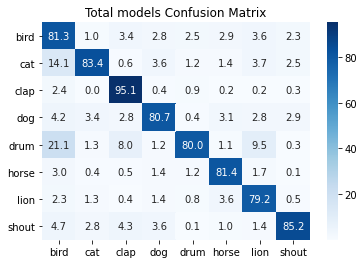

In [162]:
## 라벨별 정확도 확인
for idx in range(len(np.unique(pct_under_50['label']))):
    label_name = np.unique(pct_under_50['label'])[idx]
    print(f"------{label_name}------")
    tmp_df = pct_under_50[pct_under_50['label']==label_name].copy()
cf = confusion_matrix(final_result['label'], final_result['y_pred'],)
ax = sns.heatmap(cf/cf.sum(1)*100, annot=True, xticklabels=np.unique(final_result['label']), yticklabels=np.unique(final_result['label']), fmt='.1f', cmap="Blues")
plt.title("Total models Confusion Matrix")
plt.show()

In [123]:
# 초 구간대별 오답률
round(pred_df[pred_df['answer']!=True].groupby(['start','end']).count()/pred_df.groupby(['start','end']).count()*100,2)[['answer']]

,,answer
start,end,
0,3,22.51
1,4,18.32
2,5,22.74
3,6,19.01
4,7,20.23
5,8,18.42
6,9,17.25
7,10,19.46
8,11,22.57


In [110]:
final_result_detail[final_result_detail['name']=='hanseungsu_dog_50']

,bird,cat,clap,dog,drum,horse,lion,shout,label,name,y_pred,answer,path,start,end
1213_8_XGB_oversampling_94,0.0,0.0,0.0,0.2,0.0,0.0,0.6,0.0,dog,hanseungsu_dog_50,lion,False,../../tracks/1213_trial6/hanseungsu_dog_50/0_3...,0,3
1213_8_XGB_93,0.0,0.0,0.1,0.4,0.0,0.0,0.6,0.0,dog,hanseungsu_dog_50,lion,False,../../tracks/1213_trial6/hanseungsu_dog_50/0_3...,0,3
1213_8_RF_oversampling_92,0.0,0.1,0.3,0.3,0.0,0.0,0.2,0.0,dog,hanseungsu_dog_50,dog,True,../../tracks/1213_trial6/hanseungsu_dog_50/0_3...,0,3
1213_8_RF_87,0.1,0.0,0.4,0.2,0.2,0.0,0.1,0.0,dog,hanseungsu_dog_50,clap,False,../../tracks/1213_trial6/hanseungsu_dog_50/0_3...,0,3
1213_8_XGB_oversampling_94,0.0,0.0,0.0,0.9,0.0,0.0,0.1,0.0,dog,hanseungsu_dog_50,dog,True,../../tracks/1213_trial6/hanseungsu_dog_50/1_4...,1,4
1213_8_XGB_93,0.0,0.0,0.0,0.7,0.0,0.0,0.2,0.0,dog,hanseungsu_dog_50,dog,True,../../tracks/1213_trial6/hanseungsu_dog_50/1_4...,1,4
1213_8_RF_oversampling_92,0.1,0.1,0.1,0.5,0.1,0.0,0.1,0.0,dog,hanseungsu_dog_50,dog,True,../../tracks/1213_trial6/hanseungsu_dog_50/1_4...,1,4
1213_8_RF_87,0.1,0.1,0.1,0.4,0.0,0.0,0.3,0.0,dog,hanseungsu_dog_50,dog,True,../../tracks/1213_trial6/hanseungsu_dog_50/1_4...,1,4
1213_8_XGB_oversampling_94,0.0,0.1,0.0,0.7,0.0,0.0,0.0,0.0,dog,hanseungsu_dog_50,dog,True,../../tracks/1213_trial6/hanseungsu_dog_50/2_5...,2,5
1213_8_XGB_93,0.0,0.1,0.1,0.7,0.0,0.0,0.1,0.0,dog,hanseungsu_dog_50,dog,True,../../tracks/1213_trial6/hanseungsu_dog_50/2_5...,2,5


In [153]:
pct_under_50

,label,y_pred,name,path,model,start,end,bird,cat,clap,dog,drum,horse,lion,shout,answer
0,bird,bird,1-100038-A-14,../../tracks/1213_trial6/1-100038-A-14/0_3.wav,1213_8_RF_87,0,3,15.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,25.0
1,bird,bird,1-100038-A-14,../../tracks/1213_trial6/1-100038-A-14/0_3.wav,1213_8_RF_oversampling_92,0,3,10.0,5.0,0.0,0.0,0.0,0.0,2.5,2.5,25.0
2,bird,bird,1-100038-A-14,../../tracks/1213_trial6/1-100038-A-14/0_3.wav,1213_8_XGB_93,0,3,20.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0
3,bird,bird,1-100038-A-14,../../tracks/1213_trial6/1-100038-A-14/0_3.wav,1213_8_XGB_oversampling_94,0,3,22.5,2.5,0.0,0.0,0.0,0.0,0.0,0.0,25.0
4,bird,bird,1-100038-A-14,../../tracks/1213_trial6/1-100038-A-14/1_4.wav,1213_8_RF_87,1,4,12.5,2.5,2.5,2.5,2.5,2.5,0.0,0.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23235,shout,shout,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,1213_8_RF_oversampling_92,7,10,2.5,5.0,0.0,5.0,0.0,2.5,0.0,10.0,25.0
23236,shout,shout,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,1213_8_RF_87,8,11,5.0,0.0,0.0,2.5,0.0,0.0,0.0,17.5,25.0
23237,shout,shout,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,1213_8_RF_oversampling_92,8,11,2.5,2.5,0.0,2.5,2.5,0.0,2.5,12.5,25.0
23238,shout,shout,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,1213_8_XGB_93,8,11,0.0,2.5,0.0,2.5,0.0,0.0,0.0,20.0,25.0


------1213_8_RF_87------
정답률: 0.7871%
오답률: 0.2129%


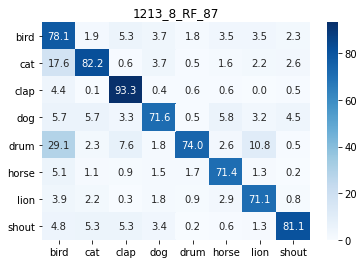

------1213_8_RF_oversampling_92------
정답률: 0.8491%
오답률: 0.1509%


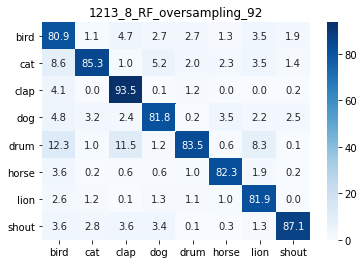

------1213_8_XGB_93------
정답률: 0.8477%
오답률: 0.1523%


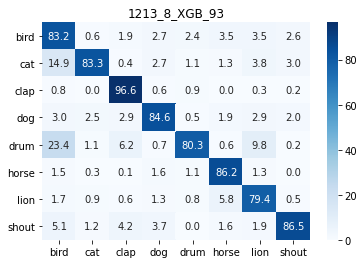

------1213_8_XGB_oversampling_94------
정답률: 0.8528%
오답률: 0.1472%


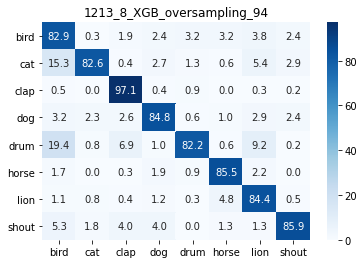

In [151]:
## 모델별 정확도 확인
for idx in range(len(np.unique(final_result_detail['model']))):
    model_name = np.unique(final_result_detail['model'])[idx]
    print(f"------{model_name}------")
    tmp_df = final_result_detail[final_result_detail['model']==model_name].copy()
    print(f"정답률: {round(len(tmp_df[tmp_df['answer']==True])/len(tmp_df),4)}%")
    print(f"오답률: {round(len(tmp_df[tmp_df['answer']!=True])/len(tmp_df),4)}%")
    cf = confusion_matrix(tmp_df['label'], tmp_df['y_pred'],)
    ax = sns.heatmap(cf/cf.sum(1)*100, annot=True, xticklabels=np.unique(tmp_df['label']), yticklabels=np.unique(tmp_df['label']), fmt='.1f', cmap="Blues")
    plt.title(model_name)
    plt.show()

In [22]:
pct_df

,label,y_pred,name,path,start,end,bird,cat,clap,dog,drum,horse,lion,shout,answer
0,bird,bird,1-100038-A-14,../../tracks/1213_trial6/1-100038-A-14/0_3.wav,0,3,67.5,17.5,0.0,0.0,0.0,0.0,2.5,7.5,100.0
1,bird,bird,1-100038-A-14,../../tracks/1213_trial6/1-100038-A-14/1_4.wav,1,4,72.5,10.0,2.5,5.0,2.5,2.5,0.0,2.5,100.0
2,bird,bird,1-100038-A-14,../../tracks/1213_trial6/1-100038-A-14/2_5.wav,2,5,72.5,10.0,5.0,5.0,2.5,2.5,0.0,2.5,100.0
3,bird,bird,1-34495-A-14,../../tracks/1213_trial6/1-34495-A-14/0_3.wav,0,3,67.5,2.5,0.0,5.0,10.0,5.0,5.0,0.0,100.0
4,bird,bird,1-34495-A-14,../../tracks/1213_trial6/1-34495-A-14/1_4.wav,1,4,67.5,2.5,0.0,7.5,7.5,12.5,2.5,0.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7408,shout,shout,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,4,7,10.0,22.5,0.0,15.0,0.0,7.5,2.5,37.5,100.0
7409,shout,shout,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,5,8,5.0,20.0,0.0,5.0,0.0,7.5,0.0,37.5,75.0
7410,shout,shout,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,6,9,7.5,25.0,0.0,17.5,0.0,5.0,2.5,37.5,100.0
7411,shout,shout,parkseongyoung_shout_98,../../tracks/1213_trial6/parkseongyoung_shout_...,7,10,2.5,12.5,0.0,5.0,0.0,5.0,0.0,25.0,50.0


In [27]:
pct_df.groupby(['label','name','path']).count()

y_pred  path  start  end  \
label name                                                                    
bird  1-100038-A-14                                     3     3      3    3   
      1-34495-A-14                                      3     3      3    3   
      1-38560-A-14                                      3     3      3    3   
      1-54918-A-14                                      3     3      3    3   
      14.Birds 01 by deleted_user_229898 Id-34207       2     2      2    2   
...                                                   ...   ...    ...  ...   
shout parkseongyoung_shout_87                           5     5      5    5   
      parkseongyoung_shout_89                           3     3      3    3   
      parkseongyoung_shout_9                            7     7      7    7   
      parkseongyoung_shout_92                           4     4      4    4   
      parkseongyoung_shout_98                          13    13     13   13   

                                                   bird  cat  clap  dog  drum  \
label name                                                                      
bird  1-100038-A-14                                   3    3     3    3     3   
      1-34495-A-14                                    3    3     3    3     3   
      1-38560-A-14                                    3    3     3    3     3   
      1-54918-A-14                                    3    3     3    3     3   
      14.Birds 01 by deleted_user_229898 Id-34207     2    2     2    2     2   
...                                                 ...  ...   ...  ...   ...   
shout parkseongyoung_shout_87                         5    5     5    5     5   
      parkseongyoung_shout_89                         3    3     3    3     3   
      parkseongyoung_shout_9                          7    7     7    7     7   
      parkseongyoung_shout_92                         4    4     4    4     4   
      parkseongyoung_shout_98                        13   13    13   13    13   

                                                   horse  lion  shout  answer  
label name                                                                     
bird  1-100038-A-14                                    3     3      3       3  
      1-34495-A-14                                     3     3      3       3  
      1-38560-A-14                                     3     3      3       3  
      1-54918-A-14                                     3     3      3       3  
      14.Birds 01 by deleted_user_229898 Id-34207      2     2      2       2  
...                                                  ...   ...    ...     ...  
shout parkseongyoung_shout_87                          5     5      5       5  
      parkseongyoung_shout_89                          3     3      3       3  
      parkseongyoung_shout_9                           7     7      7       7  
      parkseongyoung_shout_92                          4     4      4       4  
      parkseongyoung_shout_98                         13    13     13      13  

[942 rows x 13 columns]

In [35]:
pct_df.groupby(['label','name']).sum()

start  end   bird    cat  \
label name                                                                    
bird  1-100038-A-14                                    3   12  212.5   37.5   
      1-34495-A-14                                     3   12  207.5    7.5   
      1-38560-A-14                                     3   12  200.0   25.0   
      1-54918-A-14                                     3   12  220.0   47.5   
      14.Birds 01 by deleted_user_229898 Id-34207      0    6   62.5   22.5   
...                                                  ...  ...    ...    ...   
shout parkseongyoung_shout_87                         10   25    0.0   20.0   
      parkseongyoung_shout_89                          3   12   12.5    7.5   
      parkseongyoung_shout_9                          21   42   47.5   12.5   
      parkseongyoung_shout_92                          6   18   15.0    7.5   
      parkseongyoung_shout_98                         52   91   75.0  222.5   

                                                   clap    dog  drum  horse  \
label name                                                                    
bird  1-100038-A-14                                 7.5   10.0   5.0    5.0   
      1-34495-A-14                                  0.0   20.0  22.5   30.0   
      1-38560-A-14                                 25.0   12.5  22.5    0.0   
      1-54918-A-14                                  0.0   10.0   7.5    7.5   
      14.Birds 01 by deleted_user_229898 Id-34207   0.0    2.5   2.5    5.0   
...                                                 ...    ...   ...    ...   
shout parkseongyoung_shout_87                       0.0   12.5   0.0    0.0   
      parkseongyoung_shout_89                       0.0    5.0   0.0    0.0   
      parkseongyoung_shout_9                        0.0   17.5  10.0   15.0   
      parkseongyoung_shout_92                       0.0    7.5   0.0    0.0   
      parkseongyoung_shout_98                       0.0  102.5   2.5   62.5   

                                                   lion  shout  answer  
label name                                                              
bird  1-100038-A-14                                 2.5   12.5   300.0  
      1-34495-A-14                                  7.5    0.0   300.0  
      1-38560-A-14                                  5.0    2.5   300.0  
      1-54918-A-14                                  0.0    0.0   300.0  
      14.Birds 01 by deleted_user_229898 Id-34207   0.0    5.0    75.0  
...                                                 ...    ...     ...  
shout parkseongyoung_shout_87                       0.0  460.0   500.0  
      parkseongyoung_shout_89                       2.5  270.0   300.0  
      parkseongyoung_shout_9                        0.0  595.0   700.0  
      parkseongyoung_shout_92                      10.0  360.0   400.0  
      parkseongyoung_shout_98                      12.5  390.0   775.0  

[942 rows x 11 columns]

In [59]:
pct_by_songs = round(pct_df.groupby(['label','name']).sum() / pct_df.groupby(['label','name']).count(),2)[["bird", "cat", "clap", "dog", "drum", "horse", "lion", "shout", "answer"]]
pct_by_songs

bird    cat  clap   dog  \
label name                                                                    
bird  1-100038-A-14                                70.83  12.50  2.50  3.33   
      1-34495-A-14                                 69.17   2.50  0.00  6.67   
      1-38560-A-14                                 66.67   8.33  8.33  4.17   
      1-54918-A-14                                 73.33  15.83  0.00  3.33   
      14.Birds 01 by deleted_user_229898 Id-34207  31.25  11.25  0.00  1.25   
...                                                  ...    ...   ...   ...   
shout parkseongyoung_shout_87                       0.00   4.00  0.00  2.50   
      parkseongyoung_shout_89                       4.17   2.50  0.00  1.67   
      parkseongyoung_shout_9                        6.79   1.79  0.00  2.50   
      parkseongyoung_shout_92                       3.75   1.88  0.00  1.88   
      parkseongyoung_shout_98                       5.77  17.12  0.00  7.88   

                                                   drum  horse  lion  shout  \
label name                                                                    
bird  1-100038-A-14                                1.67   1.67  0.83   4.17   
      1-34495-A-14                                 7.50  10.00  2.50   0.00   
      1-38560-A-14                                 7.50   0.00  1.67   0.83   
      1-54918-A-14                                 2.50   2.50  0.00   0.00   
      14.Birds 01 by deleted_user_229898 Id-34207  1.25   2.50  0.00   2.50   
...                                                 ...    ...   ...    ...   
shout parkseongyoung_shout_87                      0.00   0.00  0.00  92.00   
      parkseongyoung_shout_89                      0.00   0.00  0.83  90.00   
      parkseongyoung_shout_9                       1.43   2.14  0.00  85.00   
      parkseongyoung_shout_92                      0.00   0.00  2.50  90.00   
      parkseongyoung_shout_98                      0.19   4.81  0.96  30.00   

                                                   answer  
label name                                                 
bird  1-100038-A-14                                100.00  
      1-34495-A-14                                 100.00  
      1-38560-A-14                                 100.00  
      1-54918-A-14                                 100.00  
      14.Birds 01 by deleted_user_229898 Id-34207   37.50  
...                                                   ...  
shout parkseongyoung_shout_87                      100.00  
      parkseongyoung_shout_89                      100.00  
      parkseongyoung_shout_9                       100.00  
      parkseongyoung_shout_92                      100.00  
      parkseongyoung_shout_98                       59.62  

[942 rows x 9 columns]

count    942.000000
mean      75.659151
std       32.092871
min        0.000000
25%       52.865000
50%      100.000000
75%      100.000000
max      100.000000
Name: answer, dtype: float64


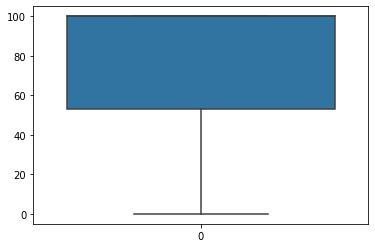

In [60]:
print(pct_by_songs['answer'].describe())
sns.boxplot(data=pct_by_songs['answer']);

In [61]:
pct_by_songs[pct_by_songs['answer']==100].groupby('label').count()[['answer']]

,answer
label,
bird,76
cat,58
clap,106
dog,72
drum,52
horse,33
lion,37
shout,74


In [65]:
acc100_songs = pct_by_songs[pct_by_songs['answer']==100]
acc100_songs.drop('answer', axis=1, inplace=True)
acc100_songs['max_score'] = acc100_songs.max(axis=1)
acc100_songs

bird    cat  clap   dog   drum  horse  lion  \
label name                                                                    
bird  1-100038-A-14            70.83  12.50  2.50  3.33   1.67   1.67  0.83   
      1-34495-A-14             69.17   2.50  0.00  6.67   7.50  10.00  2.50   
      1-38560-A-14             66.67   8.33  8.33  4.17   7.50   0.00  1.67   
      1-54918-A-14             73.33  15.83  0.00  3.33   2.50   2.50  0.00   
      2-108761-A-14            65.83   7.50  4.17  0.00  12.50   3.33  3.33   
...                              ...    ...   ...   ...    ...    ...   ...   
shout parkseongyoung_shout_86   6.88   5.62  0.00  2.50   1.88   0.00  0.00   
      parkseongyoung_shout_87   0.00   4.00  0.00  2.50   0.00   0.00  0.00   
      parkseongyoung_shout_89   4.17   2.50  0.00  1.67   0.00   0.00  0.83   
      parkseongyoung_shout_9    6.79   1.79  0.00  2.50   1.43   2.14  0.00   
      parkseongyoung_shout_92   3.75   1.88  0.00  1.88   0.00   0.00  2.50   

                               shout  max_score  
label name                                       
bird  1-100038-A-14             4.17      70.83  
      1-34495-A-14              0.00      69.17  
      1-38560-A-14              0.83      66.67  
      1-54918-A-14              0.00      73.33  
      2-108761-A-14             0.83      65.83  
...                              ...        ...  
shout parkseongyoung_shout_86  83.12      83.12  
      parkseongyoung_shout_87  92.00      92.00  
      parkseongyoung_shout_89  90.00      90.00  
      parkseongyoung_shout_9   85.00      85.00  
      parkseongyoung_shout_92  90.00      90.00  

[508 rows x 9 columns]

count    508.000000
mean      85.414528
std        9.208148
min       37.500000
25%       80.762500
50%       86.880000
75%       91.670000
max      100.000000
Name: max_score, dtype: float64


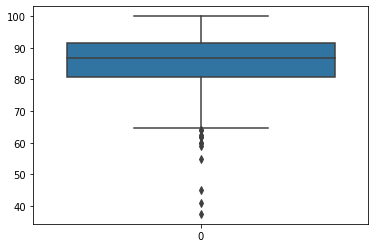

In [66]:
print(acc100_songs['max_score'].describe())
sns.boxplot(data=acc100_songs['max_score']);

In [68]:
acc100_songs.groupby('label').count()[['max_score']]

,max_score
label,
bird,76
cat,58
clap,106
dog,72
drum,52
horse,33
lion,37
shout,74


In [69]:
acc100_songs[acc100_songs['max_score']>=85].groupby('label').count()[['max_score']]

,max_score
label,
bird,37
cat,30
clap,72
dog,34
drum,35
horse,13
lion,25
shout,54


In [71]:
acc100_songs.reset_index().to_csv("../files/4models_accuracy100_songs.csv", encoding='utf-8-sig', index=False)
acc100_songs[acc100_songs['max_score']>=85].reset_index().to_csv("../files/4models_accuracy100_prob_over85.csv", encoding='utf-8-sig', index=False)